The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j113736m1125'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.2-c1b-07-123.0-F105W 4
CL1138-11.2-c1b-07-123.0-G102 4

 == Grism groups ==

ic1b-123.0-f105w 4 ic1b-123.0-g102 4


ic1b-123.0-f105w                4
ic1b-123.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.2-c1b-07-123.0-F105W 4
CL1138-11.2-c1b-07-123.0-G102 4

 == Grism groups ==

cl1138-11.2-c1b-07-123.0-f105w 4 cl1138-11.2-c1b-07-123.0-g102 4


cl1138-11.2-c1b-07-123.0-f105w  4
cl1138-11.2-c1b-07-123.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1138-11.2-c1b-07-123.0-f105w 4 cl1138-11.2-c1b-07-123.0-g102 4
Skip cl1138-11.2-c1b-07-123.0-f105w
Skip cl1138-11.2-c1b-07-123.0-f105w
Skip cl1138-11.2-c1b-07-123.0-g102
utils.fix_flt_nan: ic1b07a1q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07zuq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07a9q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07zkq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07abq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07zsq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07a3q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b07znq_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1138-11.2-c1b-07-123.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b07zkq_flt.fits'] = ['ic1b07znq_flt.fits']
# match['ic1b07zsq_flt.fits'] = ['ic1b07zuq_flt.fits']
# match['ic1b07a1q_flt.fits'] = ['ic1b07a3q_flt.fits']
# match['ic1b07a9q_flt.fits'] = ['ic1b07abq_flt.fits']
ic1b07zkq_flt.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b07zsq_flt.fits  -0.007  -0.032  0.00000  1.00000    45  0.033  0.041
ic1b07a1q_flt.fits  -0.015   0.028  0.00000  1.00000    43  0.038  0.054
ic1b07a9q_flt.fits  -0.002  -0.051  0.00000  1.00000    43  0.033  0.036


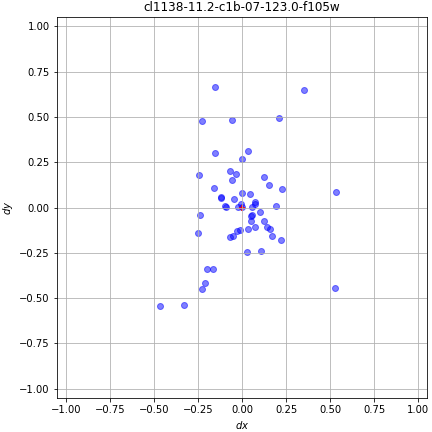

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1138-11.2-c1b-07-123.0-f105w_wcs.png") 


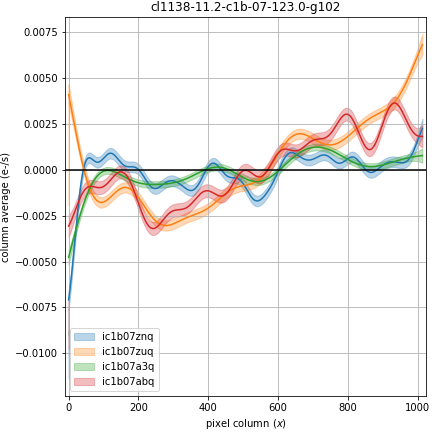

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1138-11.2-c1b-07-123.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -3.4268 -1.5629 0.0044 1.00005 0.150 57


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

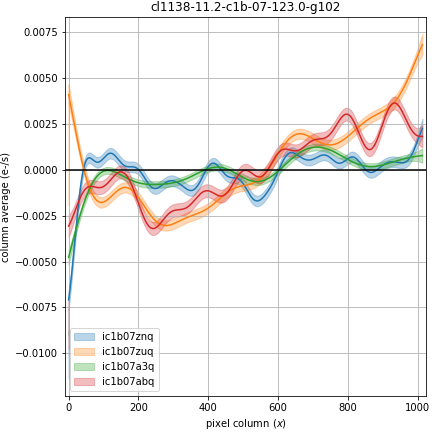

In [18]:
from IPython.display import Image
Image(filename = "./cl1138-11.2-c1b-07-123.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1138-11.2-c1b-07-123.0-f105w        -0.04    0.00


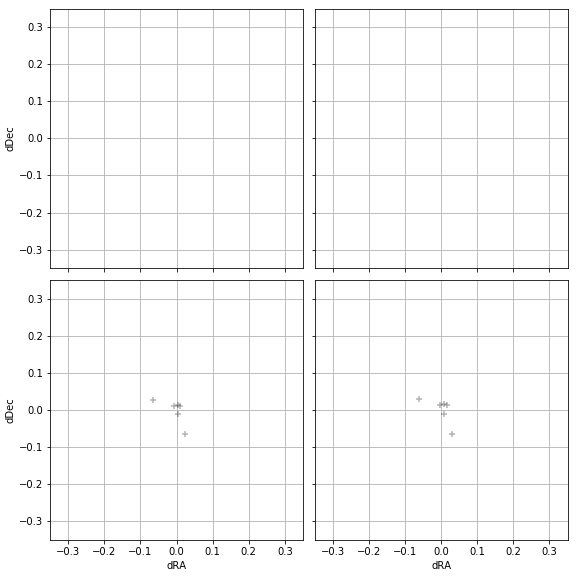

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j113736m1125-f105w_drz_sci.fits
j113736m1125-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j113736m1125-ir_drz_wht.fits
j113736m1125-ir_bkg.fits
j113736m1125-ir_seg.fits
j113736m1125-ir.cat.fits
j113736m1125-ir_drz_sci.fits
j113736m1125_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j113736m1125-ir_drz_sci.fits
WHT_FILE:	j113736m1125-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5086607933044434
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j113736m1125-f105w_drz_sci.fits
F105W_WHT_FILE:	j113736m1125-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5086607933044434
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b07abq.01.GrismFLT.fits!
Load ic1b07a3q.01.GrismFLT.fits!
Load ic1b07znq.01.GrismFLT.fits!
Load ic1b07zuq.01.GrismFLT.fits!
Files loaded - 3.76 sec.


### The final contamination model ###

IndexError: list index out of range

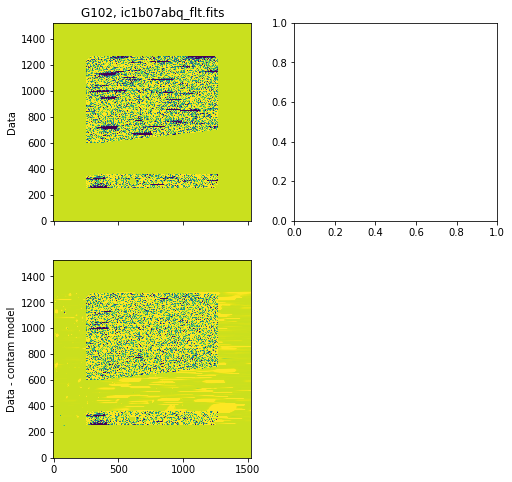

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [27]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j113736m1125/Extractions/c_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [28]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [29]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j113736m1125-f105w_psf.fits'] 

Filename: j113736m1125-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


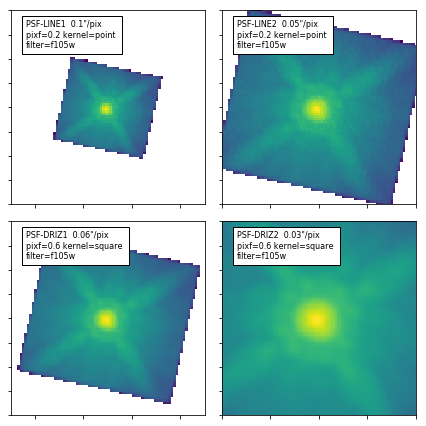

In [30]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [31]:
os.chdir('../Extractions')

In [32]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [33]:
for id_i in idx:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/192: 281 4
j113736m1125_00281.beams.fits
1/192: 336 4
j113736m1125_00336.beams.fits
2/192: 270 4
j113736m1125_00270.beams.fits
3/192: 532 3
j113736m1125_00532.beams.fits
4/192: 34 4
j113736m1125_00034.beams.fits
5/192: 35 4
j113736m1125_00035.beams.fits
6/192: 405 3
j113736m1125_00405.beams.fits
7/192: 251 4
j113736m1125_00251.beams.fits
8/192: 354 3
j113736m1125_00354.beams.fits
9/192: 413 0
10/192: 357 3
j113736m1125_00357.beams.fits
11/192: 20 4
j113736m1125_00020.beams.fits
12/192: 480 4
j113736m1125_00480.beams.fits
13/192: 29 4
j113736m1125_00029.beams.fits
14/192: 170 4
j113736m1125_00170.beams.fits
15/192: 434 3
j113736m1125_00434.beams.fits
16/192: 99 0
17/192: 531 4
j113736m1125_00531.beams.fits
18/192: 316 4
j113736m1125_00316.beams.fits
19/192: 535 4
j113736m1125_00535.beams.fits
20/192: 147 4
j113736m1125_00147.beams.fits
21/192: 423 3
j113736m1125_00423.beams.fits
22/192: 455 3
j113736m1125_00455.beams.fits
23/192: 211 4
j113736m1125_00211.beams.fits
24/192: 63 4
j11373

4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000  191497.4 (0.1000) 1/341
  0.1044  191550.5 (0.1000) 2/341
  0.1088  191602.5 (0.1000) 3/341
  0.1133  191650.3 (0.1000) 4/341
  0.1177  191634.0 (0.1000) 5/341
  0.1222  191639.7 (0.1000) 6/341
  0.1267  191607.6 (0.1000) 7/341
  0.1312  191559.7 (0.1000) 8/341
  0.1358  191472.5 (0.1358) 9/341
  0.1403  191421.8 (0.1403) 10/341
  0.1449  191316.8 (0.1449) 11/341
  0.1495  191231.2 (0.1495) 12/341
  0.1541  191233.3 (0.1495) 13/341
  0.1587  191240.0 (0.1495) 14/341
  0.1634  191208.7 (0.1634) 15/341
  0.1680  191273.8 (0.1634) 16/341
  0.1727  191342.4 (0.1634) 17/341
  0.1774  191379.5 (0.1634) 18/341
  0.1821  191415.1 (0.1634) 19/341
  0.1869  191529.3 (0.1634) 20/341
  0.1916  191574.9 (0.1634) 21/341
  0.1964  191671.0 (0.1634) 22/341
  0.2012  191733.3 (0.1634) 23/341
  0.2060  191764.1 (0.1634) 24/341
  0.2108  191846.1 (0.1634) 25/341
  0.2157  191931.9 (0.1634) 26/341
  0.2206  191926.8 (0.1634) 27/341
  0.2255  19182

  1.3710  192252.0 (0.7495) 193/341
  1.3805  192169.2 (0.7495) 194/341
  1.3900  192281.0 (0.7495) 195/341
  1.3996  192367.9 (0.7495) 196/341
  1.4092  192414.0 (0.7495) 197/341
  1.4189  192477.5 (0.7495) 198/341
  1.4286  192572.8 (0.7495) 199/341
  1.4383  192537.0 (0.7495) 200/341
  1.4481  192581.8 (0.7495) 201/341
  1.4579  192588.4 (0.7495) 202/341
  1.4678  192784.3 (0.7495) 203/341
  1.4776  192851.5 (0.7495) 204/341
  1.4876  192790.4 (0.7495) 205/341
  1.4975  192686.3 (0.7495) 206/341
  1.5076  192653.2 (0.7495) 207/341
  1.5176  192691.4 (0.7495) 208/341
  1.5277  192815.3 (0.7495) 209/341
  1.5378  193112.5 (0.7495) 210/341
  1.5480  193376.3 (0.7495) 211/341
  1.5582  193547.9 (0.7495) 212/341
  1.5685  193885.8 (0.7495) 213/341
  1.5788  194182.6 (0.7495) 214/341
  1.5891  194326.3 (0.7495) 215/341
  1.5995  194580.3 (0.7495) 216/341
  1.6099  194993.0 (0.7495) 217/341
  1.6204  195519.9 (0.7495) 218/341
  1.6309  195685.9 (0.7495) 219/341
  1.6414  196049.9 (0.7495) 

  0.1044   15871.1 (0.1044) 2/341
  0.1088   15844.3 (0.1088) 3/341
  0.1133   15813.7 (0.1133) 4/341
  0.1177   15773.2 (0.1177) 5/341
  0.1222   15727.1 (0.1222) 6/341
  0.1267   15684.4 (0.1267) 7/341
  0.1312   15665.7 (0.1312) 8/341
  0.1358   15690.5 (0.1312) 9/341
  0.1403   15731.6 (0.1312) 10/341
  0.1449   15778.2 (0.1312) 11/341
  0.1495   15836.5 (0.1312) 12/341
  0.1541   15913.2 (0.1312) 13/341
  0.1587   16015.5 (0.1312) 14/341
  0.1634   16165.2 (0.1312) 15/341
  0.1680   16281.5 (0.1312) 16/341
  0.1727   16347.3 (0.1312) 17/341
  0.1774   16392.9 (0.1312) 18/341
  0.1821   16394.3 (0.1312) 19/341
  0.1869   16327.3 (0.1312) 20/341
  0.1916   16260.6 (0.1312) 21/341
  0.1964   16208.3 (0.1312) 22/341
  0.2012   16147.3 (0.1312) 23/341
  0.2060   16030.2 (0.1312) 24/341
  0.2108   15865.5 (0.1312) 25/341
  0.2157   15687.4 (0.1312) 26/341
  0.2206   15507.7 (0.2206) 27/341
  0.2255   15346.1 (0.2255) 28/341
  0.2304   15165.8 (0.2304) 29/341
  0.2353   14953.7 (0.2353) 

  1.3615   19868.5 (0.2502) 192/341
  1.3710   20122.7 (0.2502) 193/341
  1.3805   20267.2 (0.2502) 194/341
  1.3900   20305.8 (0.2502) 195/341
  1.3996   20311.7 (0.2502) 196/341
  1.4092   20258.9 (0.2502) 197/341
  1.4189   20193.3 (0.2502) 198/341
  1.4286   20226.8 (0.2502) 199/341
  1.4383   20320.7 (0.2502) 200/341
  1.4481   20518.4 (0.2502) 201/341
  1.4579   20875.8 (0.2502) 202/341
  1.4678   21414.0 (0.2502) 203/341
  1.4776   22032.9 (0.2502) 204/341
  1.4876   22511.2 (0.2502) 205/341
  1.4975   22834.1 (0.2502) 206/341
  1.5076   23289.2 (0.2502) 207/341
  1.5176   23807.8 (0.2502) 208/341
  1.5277   24322.6 (0.2502) 209/341
  1.5378   24930.3 (0.2502) 210/341
  1.5480   25624.0 (0.2502) 211/341
  1.5582   26463.3 (0.2502) 212/341
  1.5685   27038.4 (0.2502) 213/341
  1.5788   27474.8 (0.2502) 214/341
  1.5891   27718.6 (0.2502) 215/341
  1.5995   28021.8 (0.2502) 216/341
  1.6099   28305.2 (0.2502) 217/341
  1.6204   28477.1 (0.2502) 218/341
  1.6309   28555.4 (0.2502) 

4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000   16799.9 (0.1000) 1/341
  0.1044   16745.5 (0.1044) 2/341
  0.1088   16676.1 (0.1088) 3/341
  0.1133   16614.7 (0.1133) 4/341
  0.1177   16545.4 (0.1177) 5/341
  0.1222   16504.9 (0.1222) 6/341
  0.1267   16563.5 (0.1222) 7/341
  0.1312   16685.3 (0.1222) 8/341
  0.1358   16771.3 (0.1222) 9/341
  0.1403   16817.3 (0.1222) 10/341
  0.1449   16856.6 (0.1222) 11/341
  0.1495   16911.3 (0.1222) 12/341
  0.1541   16991.4 (0.1222) 13/341
  0.1587   17059.3 (0.1222) 14/341
  0.1634   17097.2 (0.1222) 15/341
  0.1680   17117.0 (0.1222) 16/341
  0.1727   17127.6 (0.1222) 17/341
  0.1774   17133.6 (0.1222) 18/341
  0.1821   17140.7 (0.1222) 19/341
  0.1869   17107.7 (0.1222) 20/341
  0.1916   17056.3 (0.1222) 21/341
  0.1964   17020.6 (0.1222) 22/341
  0.2012   16996.4 (0.1222) 23/341
  0.2060   16935.6 (0.1222) 24/341
  0.2108   16887.4 (0.1222) 25/341
  0.2157   16834.5 (0.1222) 26/341
  0.2206   16798.4 (0.1222) 27/341
  0.2255   1678

  1.3521   18749.0 (0.1222) 191/341
  1.3615   18928.5 (0.1222) 192/341
  1.3710   19015.9 (0.1222) 193/341
  1.3805   19069.5 (0.1222) 194/341
  1.3900   19107.0 (0.1222) 195/341
  1.3996   19133.2 (0.1222) 196/341
  1.4092   19186.8 (0.1222) 197/341
  1.4189   19202.0 (0.1222) 198/341
  1.4286   19260.0 (0.1222) 199/341
  1.4383   19359.8 (0.1222) 200/341
  1.4481   19585.7 (0.1222) 201/341
  1.4579   19866.4 (0.1222) 202/341
  1.4678   20169.9 (0.1222) 203/341
  1.4776   20453.7 (0.1222) 204/341
  1.4876   20615.5 (0.1222) 205/341
  1.4975   20610.1 (0.1222) 206/341
  1.5076   20604.2 (0.1222) 207/341
  1.5176   20722.8 (0.1222) 208/341
  1.5277   20882.8 (0.1222) 209/341
  1.5378   21197.4 (0.1222) 210/341
  1.5480   21542.6 (0.1222) 211/341
  1.5582   21826.3 (0.1222) 212/341
  1.5685   22057.3 (0.1222) 213/341
  1.5788   22148.8 (0.1222) 214/341
  1.5891   22270.9 (0.1222) 215/341
  1.5995   22526.4 (0.1222) 216/341
  1.6099   22886.7 (0.1222) 217/341
  1.6204   23138.3 (0.1222) 

- 0.5447   16528.7 (0.1218) 39/99
- 0.5452   16527.2 (0.1218) 40/99
- 0.5457   16526.2 (0.1218) 41/99
- 0.5462   16523.8 (0.1218) 42/99
- 0.5467   16521.2 (0.1218) 43/99
- 0.5472   16518.9 (0.1218) 44/99
- 0.5477   16515.7 (0.1218) 45/99
- 0.5482   16512.6 (0.1218) 46/99
- 0.5487   16511.7 (0.1218) 47/99
- 0.5492   16511.9 (0.1218) 48/99
- 0.5497   16512.4 (0.1218) 49/99
- 0.5502   16512.8 (0.1218) 50/99
- 0.5507   16512.3 (0.1218) 51/99
- 0.5512   16510.9 (0.1218) 52/99
- 0.5517   16509.4 (0.1218) 53/99
- 0.5522   16511.2 (0.1218) 54/99
- 0.5527   16514.4 (0.1218) 55/99
- 0.5532   16517.4 (0.1218) 56/99
- 0.5537   16521.2 (0.1218) 57/99
- 0.5542   16524.9 (0.1218) 58/99
- 0.5547   16526.4 (0.1218) 59/99
- 0.5552   16528.5 (0.1218) 60/99
- 0.5557   16532.6 (0.1218) 61/99
- 0.5562   16538.1 (0.1218) 62/99
- 0.5567   16543.4 (0.1218) 63/99
- 0.5572   16548.8 (0.1218) 64/99
- 0.5577   16555.0 (0.1218) 65/99
- 0.5582   16557.5 (0.1218) 66/99
- 2.0990   16513.2 (0.1218) 67/99
- 2.0995   165

  0.8282    2519.1 (0.1680) 128/341
  0.8355    2510.3 (0.1680) 129/341
  0.8428    2502.6 (0.1680) 130/341
  0.8502    2507.5 (0.1680) 131/341
  0.8576    2519.1 (0.1680) 132/341
  0.8651    2534.1 (0.1680) 133/341
  0.8726    2531.0 (0.1680) 134/341
  0.8801    2534.8 (0.1680) 135/341
  0.8876    2532.4 (0.1680) 136/341
  0.8952    2527.1 (0.1680) 137/341
  0.9028    2527.9 (0.1680) 138/341
  0.9104    2526.5 (0.1680) 139/341
  0.9181    2522.6 (0.1680) 140/341
  0.9257    2501.6 (0.1680) 141/341
  0.9335    2486.1 (0.1680) 142/341
  0.9412    2473.1 (0.1680) 143/341
  0.9490    2469.1 (0.9490) 144/341
  0.9568    2483.9 (0.9490) 145/341
  0.9646    2502.4 (0.9490) 146/341
  0.9725    2522.3 (0.9490) 147/341
  0.9804    2536.1 (0.9490) 148/341
  0.9884    2544.4 (0.9490) 149/341
  0.9963    2555.5 (0.9490) 150/341
  1.0043    2568.6 (0.9490) 151/341
  1.0124    2556.0 (0.9490) 152/341
  1.0204    2548.4 (0.9490) 153/341
  1.0285    2531.3 (0.9490) 154/341
  1.0367    2549.9 (0.9490) 

  2.8935    2481.3 (0.9490) 317/341
  2.9091    2482.4 (0.9490) 318/341
  2.9248    2483.0 (0.9490) 319/341
  2.9405    2480.3 (0.9490) 320/341
  2.9563    2478.2 (0.9490) 321/341
  2.9722    2484.8 (0.9490) 322/341
  2.9881    2490.4 (0.9490) 323/341
  3.0041    2494.7 (0.9490) 324/341
  3.0201    2500.4 (0.9490) 325/341
  3.0362    2503.4 (0.9490) 326/341
  3.0524    2504.6 (0.9490) 327/341
  3.0686    2503.4 (0.9490) 328/341
  3.0850    2495.3 (0.9490) 329/341
  3.1013    2490.3 (0.9490) 330/341
  3.1178    2493.3 (0.9490) 331/341
  3.1343    2497.8 (0.9490) 332/341
  3.1508    2493.6 (0.9490) 333/341
  3.1675    2489.9 (0.9490) 334/341
  3.1842    2495.4 (0.9490) 335/341
  3.2009    2500.4 (0.9490) 336/341
  3.2178    2501.3 (0.9490) 337/341
  3.2347    2505.3 (0.9490) 338/341
  3.2517    2515.1 (0.9490) 339/341
  3.2687    2520.4 (0.9490) 340/341
  3.2858    2513.0 (0.9490) 341/341
First iteration: z_best=0.9490

- 0.1613    2488.5 (0.1613) 1/99
- 0.1618    2487.0 (0.1618) 2/99
- 

  0.4040   58405.0 (0.2552) 62/341
  0.4096   58450.3 (0.2552) 63/341
  0.4153   58467.9 (0.2552) 64/341
  0.4209   58470.6 (0.2552) 65/341
  0.4266   58493.8 (0.2552) 66/341
  0.4323   58505.8 (0.2552) 67/341
  0.4381   58470.1 (0.2552) 68/341
  0.4438   58427.2 (0.2552) 69/341
  0.4496   58410.7 (0.2552) 70/341
  0.4554   58347.5 (0.2552) 71/341
  0.4613   58346.2 (0.2552) 72/341
  0.4671   58342.5 (0.2552) 73/341
  0.4730   58319.2 (0.2552) 74/341
  0.4789   58271.9 (0.2552) 75/341
  0.4848   58197.2 (0.2552) 76/341
  0.4908   58188.5 (0.2552) 77/341
  0.4968   58159.2 (0.2552) 78/341
  0.5028   58128.2 (0.2552) 79/341
  0.5088   58093.9 (0.2552) 80/341
  0.5148   58023.0 (0.2552) 81/341
  0.5209   57950.0 (0.2552) 82/341
  0.5270   57917.1 (0.2552) 83/341
  0.5331   57901.8 (0.2552) 84/341
  0.5393   57856.4 (0.2552) 85/341
  0.5454   57836.5 (0.2552) 86/341
  0.5516   57846.8 (0.2552) 87/341
  0.5579   57828.9 (0.2552) 88/341
  0.5641   57805.4 (0.2552) 89/341
  0.5704   57777.7 (

  1.9901   60831.0 (0.6476) 251/341
  2.0021   60302.1 (0.6476) 252/341
  2.0141   59924.0 (0.6476) 253/341
  2.0262   59297.1 (0.6476) 254/341
  2.0383   58687.6 (0.6476) 255/341
  2.0505   58340.7 (0.6476) 256/341
  2.0627   58128.6 (0.6476) 257/341
  2.0750   57951.2 (0.6476) 258/341
  2.0873   57748.0 (0.6476) 259/341
  2.0997   57687.9 (0.6476) 260/341
  2.1121   57667.5 (0.6476) 261/341
  2.1246   57673.8 (0.6476) 262/341
  2.1371   57690.5 (0.6476) 263/341
  2.1497   57724.0 (0.6476) 264/341
  2.1623   57772.7 (0.6476) 265/341
  2.1750   57818.3 (0.6476) 266/341
  2.1877   57848.0 (0.6476) 267/341
  2.2005   57868.0 (0.6476) 268/341
  2.2133   57883.0 (0.6476) 269/341
  2.2262   57874.2 (0.6476) 270/341
  2.2391   57862.6 (0.6476) 271/341
  2.2521   57862.3 (0.6476) 272/341
  2.2652   57848.3 (0.6476) 273/341
  2.2783   57850.4 (0.6476) 274/341
  2.2914   57826.1 (0.6476) 275/341
  2.3046   57789.8 (0.6476) 276/341
  2.3178   57762.8 (0.6476) 277/341
  2.3311   57744.1 (0.6476) 

  0.3872   27463.7 (0.2552) 59/341
  0.3928   27505.9 (0.2552) 60/341
  0.3984   27545.8 (0.2552) 61/341
  0.4040   27557.3 (0.2552) 62/341
  0.4096   27547.6 (0.2552) 63/341
  0.4153   27512.2 (0.2552) 64/341
  0.4209   27470.2 (0.2552) 65/341
  0.4266   27427.2 (0.2552) 66/341
  0.4323   27364.6 (0.2552) 67/341
  0.4381   27305.1 (0.2552) 68/341
  0.4438   27235.3 (0.2552) 69/341
  0.4496   27150.8 (0.2552) 70/341
  0.4554   27081.6 (0.2552) 71/341
  0.4613   27073.7 (0.2552) 72/341
  0.4671   27144.3 (0.2552) 73/341
  0.4730   27219.9 (0.2552) 74/341
  0.4789   27276.5 (0.2552) 75/341
  0.4848   27320.3 (0.2552) 76/341
  0.4908   27313.3 (0.2552) 77/341
  0.4968   27288.9 (0.2552) 78/341
  0.5028   27256.2 (0.2552) 79/341
  0.5088   27196.5 (0.2552) 80/341
  0.5148   27127.0 (0.2552) 81/341
  0.5209   27090.1 (0.2552) 82/341
  0.5270   27063.4 (0.2552) 83/341
  0.5331   27030.3 (0.2552) 84/341
  0.5393   26979.4 (0.2552) 85/341
  0.5454   26913.8 (0.2552) 86/341
  0.5516   26822.0 (

  1.9663   29807.2 (1.4092) 249/341
  1.9782   29541.5 (1.4092) 250/341
  1.9901   29264.1 (1.4092) 251/341
  2.0021   28883.3 (1.4092) 252/341
  2.0141   28419.8 (1.4092) 253/341
  2.0262   28036.4 (1.4092) 254/341
  2.0383   27710.1 (1.4092) 255/341
  2.0505   27405.3 (1.4092) 256/341
  2.0627   27080.8 (1.4092) 257/341
  2.0750   26872.9 (1.4092) 258/341
  2.0873   26767.3 (1.4092) 259/341
  2.0997   26686.2 (1.4092) 260/341
  2.1121   26637.2 (1.4092) 261/341
  2.1246   26656.7 (1.4092) 262/341
  2.1371   26687.9 (1.4092) 263/341
  2.1497   26721.4 (1.4092) 264/341
  2.1623   26741.7 (1.4092) 265/341
  2.1750   26739.2 (1.4092) 266/341
  2.1877   26716.5 (1.4092) 267/341
  2.2005   26670.4 (1.4092) 268/341
  2.2133   26613.2 (1.4092) 269/341
  2.2262   26553.6 (1.4092) 270/341
  2.2391   26501.6 (1.4092) 271/341
  2.2521   26476.9 (1.4092) 272/341
  2.2652   26486.3 (1.4092) 273/341
  2.2783   26526.5 (1.4092) 274/341
  2.2914   26584.9 (1.4092) 275/341
  2.3046   26646.9 (1.4092) 

  0.4209   37009.1 (0.2603) 65/341
  0.4266   37001.1 (0.2603) 66/341
  0.4323   36978.6 (0.2603) 67/341
  0.4381   36964.2 (0.2603) 68/341
  0.4438   36918.7 (0.2603) 69/341
  0.4496   36859.9 (0.2603) 70/341
  0.4554   36816.7 (0.2603) 71/341
  0.4613   36741.9 (0.2603) 72/341
  0.4671   36746.2 (0.2603) 73/341
  0.4730   36817.1 (0.2603) 74/341
  0.4789   36805.2 (0.2603) 75/341
  0.4848   36743.0 (0.2603) 76/341
  0.4908   36684.3 (0.2603) 77/341
  0.4968   36637.6 (0.2603) 78/341
  0.5028   36651.9 (0.2603) 79/341
  0.5088   36703.1 (0.2603) 80/341
  0.5148   36693.9 (0.2603) 81/341
  0.5209   36683.4 (0.2603) 82/341
  0.5270   36685.1 (0.2603) 83/341
  0.5331   36691.0 (0.2603) 84/341
  0.5393   36715.8 (0.2603) 85/341
  0.5454   36733.2 (0.2603) 86/341
  0.5516   36726.3 (0.2603) 87/341
  0.5579   36702.0 (0.2603) 88/341
  0.5641   36718.5 (0.2603) 89/341
  0.5704   36696.2 (0.2603) 90/341
  0.5767   36665.7 (0.2603) 91/341
  0.5830   36660.3 (0.2603) 92/341
  0.5893   36665.0 (

  2.0021   38054.0 (0.2603) 252/341
  2.0141   37815.1 (0.2603) 253/341
  2.0262   37542.5 (0.2603) 254/341
  2.0383   37198.3 (0.2603) 255/341
  2.0505   36914.5 (0.2603) 256/341
  2.0627   36741.6 (0.2603) 257/341
  2.0750   36674.0 (0.2603) 258/341
  2.0873   36634.0 (0.2603) 259/341
  2.0997   36590.2 (0.2603) 260/341
  2.1121   36561.5 (0.2603) 261/341
  2.1246   36554.6 (0.2603) 262/341
  2.1371   36601.8 (0.2603) 263/341
  2.1497   36628.9 (0.2603) 264/341
  2.1623   36638.2 (0.2603) 265/341
  2.1750   36628.4 (0.2603) 266/341
  2.1877   36639.4 (0.2603) 267/341
  2.2005   36656.2 (0.2603) 268/341
  2.2133   36662.4 (0.2603) 269/341
  2.2262   36660.0 (0.2603) 270/341
  2.2391   36660.8 (0.2603) 271/341
  2.2521   36667.3 (0.2603) 272/341
  2.2652   36679.4 (0.2603) 273/341
  2.2783   36699.7 (0.2603) 274/341
  2.2914   36705.5 (0.2603) 275/341
  2.3046   36721.0 (0.2603) 276/341
  2.3178   36749.7 (0.2603) 277/341
  2.3311   36767.3 (0.2603) 278/341
  2.3445   36772.2 (0.2603) 

  0.4040   37370.9 (0.3984) 62/341
  0.4096   37399.2 (0.3984) 63/341
  0.4153   37371.4 (0.3984) 64/341
  0.4209   37340.5 (0.3984) 65/341
  0.4266   37336.0 (0.3984) 66/341
  0.4323   37373.5 (0.3984) 67/341
  0.4381   37367.7 (0.3984) 68/341
  0.4438   37335.5 (0.3984) 69/341
  0.4496   37315.2 (0.4496) 70/341
  0.4554   37282.1 (0.4554) 71/341
  0.4613   37250.6 (0.4613) 72/341
  0.4671   37224.9 (0.4671) 73/341
  0.4730   37187.8 (0.4730) 74/341
  0.4789   37122.1 (0.4789) 75/341
  0.4848   37100.0 (0.4848) 76/341
  0.4908   37092.2 (0.4908) 77/341
  0.4968   37082.5 (0.4968) 78/341
  0.5028   37060.9 (0.5028) 79/341
  0.5088   37032.1 (0.5088) 80/341
  0.5148   37018.0 (0.5148) 81/341
  0.5209   37021.2 (0.5148) 82/341
  0.5270   37003.0 (0.5270) 83/341
  0.5331   36990.4 (0.5331) 84/341
  0.5393   37000.9 (0.5331) 85/341
  0.5454   37032.4 (0.5331) 86/341
  0.5516   37085.2 (0.5331) 87/341
  0.5579   37113.0 (0.5331) 88/341
  0.5641   37102.7 (0.5331) 89/341
  0.5704   37081.9 (

  1.9901   38863.7 (0.5331) 251/341
  2.0021   38266.1 (0.5331) 252/341
  2.0141   37851.4 (0.5331) 253/341
  2.0262   37607.3 (0.5331) 254/341
  2.0383   37415.2 (0.5331) 255/341
  2.0505   37294.4 (0.5331) 256/341
  2.0627   37249.0 (0.5331) 257/341
  2.0750   37222.4 (0.5331) 258/341
  2.0873   37216.6 (0.5331) 259/341
  2.0997   37228.3 (0.5331) 260/341
  2.1121   37242.8 (0.5331) 261/341
  2.1246   37262.9 (0.5331) 262/341
  2.1371   37271.3 (0.5331) 263/341
  2.1497   37293.1 (0.5331) 264/341
  2.1623   37304.0 (0.5331) 265/341
  2.1750   37311.9 (0.5331) 266/341
  2.1877   37313.6 (0.5331) 267/341
  2.2005   37324.5 (0.5331) 268/341
  2.2133   37342.8 (0.5331) 269/341
  2.2262   37366.8 (0.5331) 270/341
  2.2391   37354.8 (0.5331) 271/341
  2.2521   37368.0 (0.5331) 272/341
  2.2652   37426.1 (0.5331) 273/341
  2.2783   37458.0 (0.5331) 274/341
  2.2914   37445.1 (0.5331) 275/341
  2.3046   37415.3 (0.5331) 276/341
  2.3178   37430.6 (0.5331) 277/341
  2.3311   37435.5 (0.5331) 

  0.4040    8964.7 (0.3598) 62/341
  0.4096    8965.3 (0.3598) 63/341
  0.4153    8964.3 (0.3598) 64/341
  0.4209    8970.0 (0.3598) 65/341
  0.4266    8974.1 (0.3598) 66/341
  0.4323    8974.0 (0.3598) 67/341
  0.4381    8965.5 (0.3598) 68/341
  0.4438    8956.6 (0.3598) 69/341
  0.4496    8946.0 (0.3598) 70/341
  0.4554    8929.1 (0.3598) 71/341
  0.4613    8909.0 (0.3598) 72/341
  0.4671    8896.7 (0.3598) 73/341
  0.4730    8888.6 (0.3598) 74/341
  0.4789    8878.6 (0.3598) 75/341
  0.4848    8885.3 (0.3598) 76/341
  0.4908    8892.7 (0.3598) 77/341
  0.4968    8903.5 (0.3598) 78/341
  0.5028    8910.8 (0.3598) 79/341
  0.5088    8915.4 (0.3598) 80/341
  0.5148    8909.9 (0.3598) 81/341
  0.5209    8905.2 (0.3598) 82/341
  0.5270    8891.0 (0.3598) 83/341
  0.5331    8863.6 (0.3598) 84/341
  0.5393    8864.3 (0.3598) 85/341
  0.5454    8879.4 (0.3598) 86/341
  0.5516    8878.3 (0.3598) 87/341
  0.5579    8879.5 (0.3598) 88/341
  0.5641    8870.7 (0.3598) 89/341
  0.5704    8870.3 (

  1.9901    9741.7 (0.3598) 251/341
  2.0021    9620.9 (0.3598) 252/341
  2.0141    9428.2 (0.3598) 253/341
  2.0262    9245.0 (0.3598) 254/341
  2.0383    9115.9 (0.3598) 255/341
  2.0505    9039.7 (0.3598) 256/341
  2.0627    8983.1 (0.3598) 257/341
  2.0750    8946.2 (0.3598) 258/341
  2.0873    8925.8 (0.3598) 259/341
  2.0997    8909.5 (0.3598) 260/341
  2.1121    8903.3 (0.3598) 261/341
  2.1246    8911.7 (0.3598) 262/341
  2.1371    8912.4 (0.3598) 263/341
  2.1497    8916.1 (0.3598) 264/341
  2.1623    8920.5 (0.3598) 265/341
  2.1750    8925.9 (0.3598) 266/341
  2.1877    8928.3 (0.3598) 267/341
  2.2005    8928.1 (0.3598) 268/341
  2.2133    8928.3 (0.3598) 269/341
  2.2262    8923.8 (0.3598) 270/341
  2.2391    8914.2 (0.3598) 271/341
  2.2521    8908.5 (0.3598) 272/341
  2.2652    8908.2 (0.3598) 273/341
  2.2783    8903.9 (0.3598) 274/341
  2.2914    8896.3 (0.3598) 275/341
  2.3046    8892.3 (0.3598) 276/341
  2.3178    8888.9 (0.3598) 277/341
  2.3311    8880.1 (0.3598) 

  0.4496   22927.8 (0.4209) 70/341
  0.4554   22702.3 (0.4209) 71/341
  0.4613   21554.6 (0.4613) 72/341
  0.4671   21315.5 (0.4671) 73/341
  0.4730   23037.8 (0.4671) 74/341
  0.4789   23354.1 (0.4671) 75/341
  0.4848   23335.5 (0.4671) 76/341
  0.4908   23268.2 (0.4671) 77/341
  0.4968   23196.1 (0.4671) 78/341
  0.5028   23198.1 (0.4671) 79/341
  0.5088   23242.8 (0.4671) 80/341
  0.5148   23265.9 (0.4671) 81/341
  0.5209   23269.4 (0.4671) 82/341
  0.5270   23230.7 (0.4671) 83/341
  0.5331   23227.1 (0.4671) 84/341
  0.5393   23224.3 (0.4671) 85/341
  0.5454   23225.3 (0.4671) 86/341
  0.5516   23194.5 (0.4671) 87/341
  0.5579   23187.8 (0.4671) 88/341
  0.5641   23147.2 (0.4671) 89/341
  0.5704   23117.8 (0.4671) 90/341
  0.5767   23181.5 (0.4671) 91/341
  0.5830   23253.8 (0.4671) 92/341
  0.5893   23237.8 (0.4671) 93/341
  0.5957   23205.6 (0.4671) 94/341
  0.6021   23218.0 (0.4671) 95/341
  0.6085   23290.7 (0.4671) 96/341
  0.6150   23335.4 (0.4671) 97/341
  0.6214   23295.6 (

  2.1246   23124.6 (0.9181) 262/341
  2.1371   23148.1 (0.9181) 263/341
  2.1497   23172.3 (0.9181) 264/341
  2.1623   23194.3 (0.9181) 265/341
  2.1750   23210.6 (0.9181) 266/341
  2.1877   23213.6 (0.9181) 267/341
  2.2005   23219.6 (0.9181) 268/341
  2.2133   23230.9 (0.9181) 269/341
  2.2262   23250.0 (0.9181) 270/341
  2.2391   23276.0 (0.9181) 271/341
  2.2521   23310.0 (0.9181) 272/341
  2.2652   23345.8 (0.9181) 273/341
  2.2783   23362.3 (0.9181) 274/341
  2.2914   23362.6 (0.9181) 275/341
  2.3046   23392.8 (0.9181) 276/341
  2.3178   23452.2 (0.9181) 277/341
  2.3311   23525.3 (0.9181) 278/341
  2.3445   23544.5 (0.9181) 279/341
  2.3579   23517.7 (0.9181) 280/341
  2.3713   23511.7 (0.9181) 281/341
  2.3849   23535.9 (0.9181) 282/341
  2.3984   23541.8 (0.9181) 283/341
  2.4120   23533.2 (0.9181) 284/341
  2.4257   23550.9 (0.9181) 285/341
  2.4394   23563.6 (0.9181) 286/341
  2.4532   23536.1 (0.9181) 287/341
  2.4671   23471.6 (0.9181) 288/341
  2.4810   23429.4 (0.9181) 

  0.4496   22748.7 (0.1821) 70/341
  0.4554   22751.8 (0.1821) 71/341
  0.4613   22747.5 (0.1821) 72/341
  0.4671   22729.4 (0.1821) 73/341
  0.4730   22722.9 (0.1821) 74/341
  0.4789   22724.7 (0.1821) 75/341
  0.4848   22706.3 (0.1821) 76/341
  0.4908   22690.4 (0.1821) 77/341
  0.4968   22649.6 (0.1821) 78/341
  0.5028   22610.5 (0.1821) 79/341
  0.5088   22590.1 (0.1821) 80/341
  0.5148   22560.4 (0.1821) 81/341
  0.5209   22537.9 (0.1821) 82/341
  0.5270   22506.4 (0.1821) 83/341
  0.5331   22498.2 (0.1821) 84/341
  0.5393   22498.3 (0.1821) 85/341
  0.5454   22518.1 (0.1821) 86/341
  0.5516   22518.6 (0.1821) 87/341
  0.5579   22527.7 (0.1821) 88/341
  0.5641   22518.4 (0.1821) 89/341
  0.5704   22520.0 (0.1821) 90/341
  0.5767   22525.7 (0.1821) 91/341
  0.5830   22510.8 (0.1821) 92/341
  0.5893   22492.2 (0.1821) 93/341
  0.5957   22533.0 (0.1821) 94/341
  0.6021   22575.7 (0.1821) 95/341
  0.6085   22568.1 (0.1821) 96/341
  0.6150   22552.0 (0.1821) 97/341
  0.6214   22537.3 (

  2.1877   22604.0 (2.0873) 267/341
  2.2005   22625.2 (2.0873) 268/341
  2.2133   22635.6 (2.0873) 269/341
  2.2262   22625.5 (2.0873) 270/341
  2.2391   22613.8 (2.0873) 271/341
  2.2521   22605.8 (2.0873) 272/341
  2.2652   22604.2 (2.0873) 273/341
  2.2783   22604.1 (2.0873) 274/341
  2.2914   22602.5 (2.0873) 275/341
  2.3046   22596.9 (2.0873) 276/341
  2.3178   22586.6 (2.0873) 277/341
  2.3311   22574.7 (2.0873) 278/341
  2.3445   22557.2 (2.0873) 279/341
  2.3579   22533.1 (2.0873) 280/341
  2.3713   22526.5 (2.0873) 281/341
  2.3849   22534.5 (2.0873) 282/341
  2.3984   22542.3 (2.0873) 283/341
  2.4120   22536.3 (2.0873) 284/341
  2.4257   22524.8 (2.0873) 285/341
  2.4394   22532.8 (2.0873) 286/341
  2.4532   22546.3 (2.0873) 287/341
  2.4671   22538.1 (2.0873) 288/341
  2.4810   22515.1 (2.0873) 289/341
  2.4949   22525.7 (2.0873) 290/341
  2.5089   22552.5 (2.0873) 291/341
  2.5230   22544.2 (2.0873) 292/341
  2.5371   22516.0 (2.0873) 293/341
  2.5513   22512.0 (2.0873) 

  0.5028    9588.0 (0.2909) 79/341
  0.5088    9562.4 (0.2909) 80/341
  0.5148    9534.3 (0.2909) 81/341
  0.5209    9554.6 (0.2909) 82/341
  0.5270    9531.9 (0.2909) 83/341
  0.5331    9541.2 (0.2909) 84/341
  0.5393    9559.7 (0.2909) 85/341
  0.5454    9563.8 (0.2909) 86/341
  0.5516    9565.7 (0.2909) 87/341
  0.5579    9566.5 (0.2909) 88/341
  0.5641    9533.5 (0.2909) 89/341
  0.5704    9528.9 (0.2909) 90/341
  0.5767    9556.6 (0.2909) 91/341
  0.5830    9592.6 (0.2909) 92/341
  0.5893    9628.6 (0.2909) 93/341
  0.5957    9637.3 (0.2909) 94/341
  0.6021    9652.4 (0.2909) 95/341
  0.6085    9650.1 (0.2909) 96/341
  0.6150    9624.4 (0.2909) 97/341
  0.6214    9601.1 (0.2909) 98/341
  0.6279    9597.9 (0.2909) 99/341
  0.6345    9589.7 (0.2909) 100/341
  0.6410    9585.2 (0.2909) 101/341
  0.6476    9573.2 (0.2909) 102/341
  0.6542    9596.6 (0.2909) 103/341
  0.6608    9606.9 (0.2909) 104/341
  0.6675    9600.6 (0.2909) 105/341
  0.6742    9601.9 (0.2909) 106/341
  0.6809    9

  2.2391    9567.3 (2.0997) 271/341
  2.2521    9555.1 (2.0997) 272/341
  2.2652    9576.9 (2.0997) 273/341
  2.2783    9613.3 (2.0997) 274/341
  2.2914    9628.2 (2.0997) 275/341
  2.3046    9628.2 (2.0997) 276/341
  2.3178    9633.1 (2.0997) 277/341
  2.3311    9645.4 (2.0997) 278/341
  2.3445    9665.2 (2.0997) 279/341
  2.3579    9683.7 (2.0997) 280/341
  2.3713    9687.7 (2.0997) 281/341
  2.3849    9685.3 (2.0997) 282/341
  2.3984    9681.4 (2.0997) 283/341
  2.4120    9680.0 (2.0997) 284/341
  2.4257    9674.4 (2.0997) 285/341
  2.4394    9653.9 (2.0997) 286/341
  2.4532    9617.4 (2.0997) 287/341
  2.4671    9605.5 (2.0997) 288/341
  2.4810    9608.7 (2.0997) 289/341
  2.4949    9608.1 (2.0997) 290/341
  2.5089    9610.4 (2.0997) 291/341
  2.5230    9638.4 (2.0997) 292/341
  2.5371    9631.5 (2.0997) 293/341
  2.5513    9605.6 (2.0997) 294/341
  2.5655    9607.1 (2.0997) 295/341
  2.5798    9603.9 (2.0997) 296/341
  2.5942    9599.8 (2.0997) 297/341
  2.6086    9596.4 (2.0997) 

  0.5270   16097.9 (0.5209) 83/341
  0.5331   16094.1 (0.5209) 84/341
  0.5393   16075.9 (0.5393) 85/341
  0.5454   16091.3 (0.5393) 86/341
  0.5516   16113.1 (0.5393) 87/341
  0.5579   16102.1 (0.5393) 88/341
  0.5641   16100.6 (0.5393) 89/341
  0.5704   16093.0 (0.5393) 90/341
  0.5767   16083.9 (0.5393) 91/341
  0.5830   16085.5 (0.5393) 92/341
  0.5893   16107.0 (0.5393) 93/341
  0.5957   16116.9 (0.5393) 94/341
  0.6021   16139.8 (0.5393) 95/341
  0.6085   16151.2 (0.5393) 96/341
  0.6150   16151.7 (0.5393) 97/341
  0.6214   16149.7 (0.5393) 98/341
  0.6279   16143.1 (0.5393) 99/341
  0.6345   16141.2 (0.5393) 100/341
  0.6410   16118.8 (0.5393) 101/341
  0.6476   16113.3 (0.5393) 102/341
  0.6542   16147.1 (0.5393) 103/341
  0.6608   16159.9 (0.5393) 104/341
  0.6675   16181.1 (0.5393) 105/341
  0.6742   16163.6 (0.5393) 106/341
  0.6809   16139.5 (0.5393) 107/341
  0.6876   16134.0 (0.5393) 108/341
  0.6944   16150.6 (0.5393) 109/341
  0.7012   16153.3 (0.5393) 110/341
  0.7080 

  2.2391   16170.6 (2.0750) 271/341
  2.2521   16161.8 (2.0750) 272/341
  2.2652   16160.6 (2.0750) 273/341
  2.2783   16170.5 (2.0750) 274/341
  2.2914   16171.4 (2.0750) 275/341
  2.3046   16169.9 (2.0750) 276/341
  2.3178   16170.2 (2.0750) 277/341
  2.3311   16171.4 (2.0750) 278/341
  2.3445   16168.3 (2.0750) 279/341
  2.3579   16164.8 (2.0750) 280/341
  2.3713   16163.9 (2.0750) 281/341
  2.3849   16167.3 (2.0750) 282/341
  2.3984   16168.6 (2.0750) 283/341
  2.4120   16172.2 (2.0750) 284/341
  2.4257   16172.6 (2.0750) 285/341
  2.4394   16148.8 (2.0750) 286/341
  2.4532   16135.1 (2.0750) 287/341
  2.4671   16137.9 (2.0750) 288/341
  2.4810   16134.9 (2.0750) 289/341
  2.4949   16125.4 (2.0750) 290/341
  2.5089   16113.9 (2.0750) 291/341
  2.5230   16115.1 (2.0750) 292/341
  2.5371   16119.2 (2.0750) 293/341
  2.5513   16116.2 (2.0750) 294/341
  2.5655   16113.4 (2.0750) 295/341
  2.5798   16124.9 (2.0750) 296/341
  2.5942   16127.1 (2.0750) 297/341
  2.6086   16124.7 (2.0750) 

  0.5393    5065.8 (0.3169) 85/341
  0.5454    5045.0 (0.5454) 86/341
  0.5516    5078.1 (0.5454) 87/341
  0.5579    5069.3 (0.5454) 88/341
  0.5641    5030.7 (0.5641) 89/341
  0.5704    5025.9 (0.5704) 90/341
  0.5767    5021.1 (0.5767) 91/341
  0.5830    5022.1 (0.5767) 92/341
  0.5893    5023.6 (0.5767) 93/341
  0.5957    5029.3 (0.5767) 94/341
  0.6021    5051.6 (0.5767) 95/341
  0.6085    5077.6 (0.5767) 96/341
  0.6150    5087.5 (0.5767) 97/341
  0.6214    5098.1 (0.5767) 98/341
  0.6279    5106.8 (0.5767) 99/341
  0.6345    5099.6 (0.5767) 100/341
  0.6410    5107.4 (0.5767) 101/341
  0.6476    5109.4 (0.5767) 102/341
  0.6542    5108.4 (0.5767) 103/341
  0.6608    5114.8 (0.5767) 104/341
  0.6675    5117.1 (0.5767) 105/341
  0.6742    5105.3 (0.5767) 106/341
  0.6809    5115.1 (0.5767) 107/341
  0.6876    5118.4 (0.5767) 108/341
  0.6944    5108.9 (0.5767) 109/341
  0.7012    5099.4 (0.5767) 110/341
  0.7080    5099.6 (0.5767) 111/341
  0.7148    5099.0 (0.5767) 112/341
  0.721

  2.2521    5165.9 (0.5767) 272/341
  2.2652    5174.5 (0.5767) 273/341
  2.2783    5177.8 (0.5767) 274/341
  2.2914    5176.3 (0.5767) 275/341
  2.3046    5171.1 (0.5767) 276/341
  2.3178    5168.4 (0.5767) 277/341
  2.3311    5170.6 (0.5767) 278/341
  2.3445    5169.7 (0.5767) 279/341
  2.3579    5172.1 (0.5767) 280/341
  2.3713    5171.0 (0.5767) 281/341
  2.3849    5165.2 (0.5767) 282/341
  2.3984    5154.7 (0.5767) 283/341
  2.4120    5141.7 (0.5767) 284/341
  2.4257    5135.8 (0.5767) 285/341
  2.4394    5129.0 (0.5767) 286/341
  2.4532    5123.2 (0.5767) 287/341
  2.4671    5114.1 (0.5767) 288/341
  2.4810    5109.3 (0.5767) 289/341
  2.4949    5101.5 (0.5767) 290/341
  2.5089    5094.5 (0.5767) 291/341
  2.5230    5097.4 (0.5767) 292/341
  2.5371    5090.5 (0.5767) 293/341
  2.5513    5082.6 (0.5767) 294/341
  2.5655    5077.8 (0.5767) 295/341
  2.5798    5071.5 (0.5767) 296/341
  2.5942    5064.0 (0.5767) 297/341
  2.6086    5056.9 (0.5767) 298/341
  2.6230    5051.6 (0.5767) 

  0.5270    4398.9 (0.2960) 83/341
  0.5331    4404.2 (0.2960) 84/341
  0.5393    4403.1 (0.2960) 85/341
  0.5454    4402.9 (0.2960) 86/341
  0.5516    4405.8 (0.2960) 87/341
  0.5579    4402.1 (0.2960) 88/341
  0.5641    4398.8 (0.2960) 89/341
  0.5704    4395.0 (0.2960) 90/341
  0.5767    4394.5 (0.2960) 91/341
  0.5830    4397.0 (0.2960) 92/341
  0.5893    4400.8 (0.2960) 93/341
  0.5957    4399.2 (0.2960) 94/341
  0.6021    4395.9 (0.2960) 95/341
  0.6085    4399.7 (0.2960) 96/341
  0.6150    4402.2 (0.2960) 97/341
  0.6214    4403.7 (0.2960) 98/341
  0.6279    4404.6 (0.2960) 99/341
  0.6345    4405.2 (0.2960) 100/341
  0.6410    4405.1 (0.2960) 101/341
  0.6476    4402.8 (0.2960) 102/341
  0.6542    4403.8 (0.2960) 103/341
  0.6608    4403.0 (0.2960) 104/341
  0.6675    4403.1 (0.2960) 105/341
  0.6742    4402.7 (0.2960) 106/341
  0.6809    4403.3 (0.2960) 107/341
  0.6876    4404.5 (0.2960) 108/341
  0.6944    4402.8 (0.2960) 109/341
  0.7012    4401.8 (0.2960) 110/341
  0.7080 

  2.3046    4401.7 (0.2960) 276/341
  2.3178    4402.4 (0.2960) 277/341
  2.3311    4406.9 (0.2960) 278/341
  2.3445    4410.9 (0.2960) 279/341
  2.3579    4411.8 (0.2960) 280/341
  2.3713    4411.6 (0.2960) 281/341
  2.3849    4415.2 (0.2960) 282/341
  2.3984    4417.3 (0.2960) 283/341
  2.4120    4415.9 (0.2960) 284/341
  2.4257    4417.3 (0.2960) 285/341
  2.4394    4420.2 (0.2960) 286/341
  2.4532    4420.0 (0.2960) 287/341
  2.4671    4418.6 (0.2960) 288/341
  2.4810    4418.7 (0.2960) 289/341
  2.4949    4419.4 (0.2960) 290/341
  2.5089    4418.2 (0.2960) 291/341
  2.5230    4413.9 (0.2960) 292/341
  2.5371    4407.4 (0.2960) 293/341
  2.5513    4405.6 (0.2960) 294/341
  2.5655    4401.8 (0.2960) 295/341
  2.5798    4396.5 (0.2960) 296/341
  2.5942    4396.6 (0.2960) 297/341
  2.6086    4399.8 (0.2960) 298/341
  2.6230    4401.5 (0.2960) 299/341
  2.6375    4396.4 (0.2960) 300/341
  2.6521    4392.8 (0.2960) 301/341
  2.6668    4395.7 (0.2960) 302/341
  2.6815    4401.8 (0.2960) 

- 0.5781    4395.2 (0.2964) 123/297
- 0.5786    4395.4 (0.2964) 124/297
- 0.5791    4395.5 (0.2964) 125/297
- 0.5796    4395.5 (0.2964) 126/297
- 0.5801    4395.6 (0.2964) 127/297
- 0.5806    4395.9 (0.2964) 128/297
- 0.5811    4396.1 (0.2964) 129/297
- 0.5816    4396.3 (0.2964) 130/297
- 0.5821    4396.4 (0.2964) 131/297
- 0.5826    4396.6 (0.2964) 132/297
- 0.9051    4406.2 (0.2964) 133/297
- 0.9056    4405.5 (0.2964) 134/297
- 0.9061    4404.8 (0.2964) 135/297
- 0.9066    4404.1 (0.2964) 136/297
- 0.9071    4403.4 (0.2964) 137/297
- 0.9076    4402.7 (0.2964) 138/297
- 0.9081    4402.1 (0.2964) 139/297
- 0.9086    4401.4 (0.2964) 140/297
- 0.9091    4400.6 (0.2964) 141/297
- 0.9096    4399.7 (0.2964) 142/297
- 0.9101    4399.1 (0.2964) 143/297
- 0.9106    4398.6 (0.2964) 144/297
- 0.9111    4398.3 (0.2964) 145/297
- 0.9116    4398.2 (0.2964) 146/297
- 0.9121    4398.0 (0.2964) 147/297
- 0.9126    4398.0 (0.2964) 148/297
- 0.9131    4398.0 (0.2964) 149/297
- 0.9136    4397.9 (0.2964) 

  0.1312    2688.0 (0.1000) 8/341
  0.1358    2687.9 (0.1000) 9/341
  0.1403    2687.0 (0.1000) 10/341
  0.1449    2687.8 (0.1000) 11/341
  0.1495    2688.2 (0.1000) 12/341
  0.1541    2686.0 (0.1000) 13/341
  0.1587    2683.7 (0.1000) 14/341
  0.1634    2681.8 (0.1000) 15/341
  0.1680    2677.1 (0.1000) 16/341
  0.1727    2676.5 (0.1000) 17/341
  0.1774    2677.7 (0.1000) 18/341
  0.1821    2676.6 (0.1000) 19/341
  0.1869    2676.6 (0.1000) 20/341
  0.1916    2676.1 (0.1000) 21/341
  0.1964    2674.3 (0.1964) 22/341
  0.2012    2675.0 (0.1964) 23/341
  0.2060    2674.9 (0.1964) 24/341
  0.2108    2674.2 (0.2108) 25/341
  0.2157    2675.2 (0.2108) 26/341
  0.2206    2676.1 (0.2108) 27/341
  0.2255    2679.2 (0.2108) 28/341
  0.2304    2682.5 (0.2108) 29/341
  0.2353    2685.3 (0.2108) 30/341
  0.2402    2686.0 (0.2108) 31/341
  0.2452    2685.3 (0.2108) 32/341
  0.2502    2684.8 (0.2108) 33/341
  0.2552    2684.1 (0.2108) 34/341
  0.2603    2683.1 (0.2108) 35/341
  0.2653    2683.9 (0.

  1.4092    2763.4 (0.6542) 197/341
  1.4189    2750.0 (0.6542) 198/341
  1.4286    2754.9 (0.6542) 199/341
  1.4383    2744.6 (0.6542) 200/341
  1.4481    2740.7 (0.6542) 201/341
  1.4579    2744.7 (0.6542) 202/341
  1.4678    2749.1 (0.6542) 203/341
  1.4776    2733.1 (0.6542) 204/341
  1.4876    2719.3 (0.6542) 205/341
  1.4975    2703.8 (0.6542) 206/341
  1.5076    2702.8 (0.6542) 207/341
  1.5176    2703.6 (0.6542) 208/341
  1.5277    2704.8 (0.6542) 209/341
  1.5378    2700.9 (0.6542) 210/341
  1.5480    2696.8 (0.6542) 211/341
  1.5582    2689.5 (0.6542) 212/341
  1.5685    2684.7 (0.6542) 213/341
  1.5788    2680.6 (0.6542) 214/341
  1.5891    2679.2 (0.6542) 215/341
  1.5995    2679.4 (0.6542) 216/341
  1.6099    2679.6 (0.6542) 217/341
  1.6204    2680.5 (0.6542) 218/341
  1.6309    2680.7 (0.6542) 219/341
  1.6414    2680.7 (0.6542) 220/341
  1.6520    2680.4 (0.6542) 221/341
  1.6626    2680.4 (0.6542) 222/341
  1.6733    2680.1 (0.6542) 223/341
  1.6840    2679.4 (0.6542) 

- 0.3015    2672.8 (0.3015) 44/528
- 0.3020    2672.4 (0.3020) 45/528
- 0.3025    2672.2 (0.3025) 46/528
- 0.3030    2672.1 (0.3030) 47/528
- 0.3035    2672.0 (0.3035) 48/528
- 0.3040    2672.0 (0.3040) 49/528
- 0.3045    2672.0 (0.3040) 50/528
- 0.3050    2671.9 (0.3050) 51/528
- 0.3055    2672.1 (0.3050) 52/528
- 0.3060    2672.2 (0.3050) 53/528
- 0.3065    2672.4 (0.3050) 54/528
- 0.3070    2672.7 (0.3050) 55/528
- 0.3075    2673.3 (0.3050) 56/528
- 0.3080    2674.2 (0.3050) 57/528
- 0.3085    2674.7 (0.3050) 58/528
- 0.3090    2675.1 (0.3050) 59/528
- 0.3095    2675.3 (0.3050) 60/528
- 0.3100    2675.3 (0.3050) 61/528
- 0.3105    2675.4 (0.3050) 62/528
- 0.3110    2675.6 (0.3050) 63/528
- 0.3115    2676.1 (0.3050) 64/528
- 0.3120    2676.5 (0.3050) 65/528
- 0.3125    2676.4 (0.3050) 66/528
- 0.3631    2678.0 (0.3050) 67/528
- 0.3636    2677.8 (0.3050) 68/528
- 0.3641    2677.3 (0.3050) 69/528
- 0.3646    2677.0 (0.3050) 70/528
- 0.3651    2676.7 (0.3050) 71/528
- 0.3656    2676.4 (

- 0.7544    2678.9 (0.6545) 239/528
- 0.7549    2678.5 (0.6545) 240/528
- 0.7554    2678.0 (0.6545) 241/528
- 0.7559    2677.4 (0.6545) 242/528
- 0.7564    2676.9 (0.6545) 243/528
- 0.7569    2676.4 (0.6545) 244/528
- 0.7574    2676.1 (0.6545) 245/528
- 0.7579    2675.9 (0.6545) 246/528
- 0.7584    2675.8 (0.6545) 247/528
- 0.7589    2675.8 (0.6545) 248/528
- 0.7594    2675.8 (0.6545) 249/528
- 0.7599    2675.9 (0.6545) 250/528
- 0.7604    2676.0 (0.6545) 251/528
- 0.7609    2676.3 (0.6545) 252/528
- 0.7614    2676.6 (0.6545) 253/528
- 0.7619    2676.9 (0.6545) 254/528
- 0.7624    2677.3 (0.6545) 255/528
- 0.7629    2677.7 (0.6545) 256/528
- 0.7634    2677.9 (0.6545) 257/528
- 0.7639    2678.2 (0.6545) 258/528
- 0.7644    2678.4 (0.6545) 259/528
- 0.7649    2679.0 (0.6545) 260/528
- 0.7654    2680.0 (0.6545) 261/528
- 0.7659    2681.0 (0.6545) 262/528
- 0.7664    2681.5 (0.6545) 263/528
- 0.7669    2681.7 (0.6545) 264/528
- 0.9620    2673.6 (0.6545) 265/528
- 0.9625    2673.4 (0.6545) 

- 2.6833    2674.5 (0.6545) 426/528
- 2.6838    2674.6 (0.6545) 427/528
- 2.6843    2674.7 (0.6545) 428/528
- 2.6848    2674.8 (0.6545) 429/528
- 2.8508    2678.7 (0.6545) 430/528
- 2.8513    2678.7 (0.6545) 431/528
- 2.8518    2678.6 (0.6545) 432/528
- 2.8523    2678.5 (0.6545) 433/528
- 2.8528    2678.5 (0.6545) 434/528
- 2.8533    2678.5 (0.6545) 435/528
- 2.8538    2678.4 (0.6545) 436/528
- 2.8543    2678.4 (0.6545) 437/528
- 2.8548    2678.4 (0.6545) 438/528
- 2.8553    2678.4 (0.6545) 439/528
- 2.8558    2678.4 (0.6545) 440/528
- 2.8563    2678.4 (0.6545) 441/528
- 2.8568    2678.4 (0.6545) 442/528
- 2.8573    2678.4 (0.6545) 443/528
- 2.8578    2678.4 (0.6545) 444/528
- 2.8583    2678.4 (0.6545) 445/528
- 2.8588    2678.5 (0.6545) 446/528
- 2.8593    2678.5 (0.6545) 447/528
- 2.8598    2678.5 (0.6545) 448/528
- 2.8603    2678.6 (0.6545) 449/528
- 2.8608    2678.6 (0.6545) 450/528
- 2.8613    2678.6 (0.6545) 451/528
- 2.8618    2678.7 (0.6545) 452/528
- 2.8623    2678.7 (0.6545) 

  0.5516    9253.0 (0.2304) 87/341
  0.5579    9239.2 (0.2304) 88/341
  0.5641    9233.7 (0.2304) 89/341
  0.5704    9236.8 (0.2304) 90/341
  0.5767    9232.6 (0.2304) 91/341
  0.5830    9212.6 (0.2304) 92/341
  0.5893    9209.2 (0.2304) 93/341
  0.5957    9211.1 (0.2304) 94/341
  0.6021    9201.1 (0.2304) 95/341
  0.6085    9207.4 (0.2304) 96/341
  0.6150    9195.8 (0.2304) 97/341
  0.6214    9210.7 (0.2304) 98/341
  0.6279    9202.2 (0.2304) 99/341
  0.6345    9228.3 (0.2304) 100/341
  0.6410    9234.6 (0.2304) 101/341
  0.6476    9223.8 (0.2304) 102/341
  0.6542    9230.3 (0.2304) 103/341
  0.6608    9244.3 (0.2304) 104/341
  0.6675    9223.5 (0.2304) 105/341
  0.6742    9232.9 (0.2304) 106/341
  0.6809    9216.0 (0.2304) 107/341
  0.6876    9203.2 (0.2304) 108/341
  0.6944    9221.9 (0.2304) 109/341
  0.7012    9228.9 (0.2304) 110/341
  0.7080    9222.4 (0.2304) 111/341
  0.7148    9253.3 (0.2304) 112/341
  0.7217    9279.4 (0.2304) 113/341
  0.7286    9279.2 (0.2304) 114/341
  0.7

  2.3311    9295.0 (0.2304) 278/341
  2.3445    9286.5 (0.2304) 279/341
  2.3579    9279.5 (0.2304) 280/341
  2.3713    9279.4 (0.2304) 281/341
  2.3849    9285.7 (0.2304) 282/341
  2.3984    9284.1 (0.2304) 283/341
  2.4120    9272.3 (0.2304) 284/341
  2.4257    9265.3 (0.2304) 285/341
  2.4394    9264.8 (0.2304) 286/341
  2.4532    9272.8 (0.2304) 287/341
  2.4671    9274.7 (0.2304) 288/341
  2.4810    9272.0 (0.2304) 289/341
  2.4949    9274.7 (0.2304) 290/341
  2.5089    9271.9 (0.2304) 291/341
  2.5230    9257.8 (0.2304) 292/341
  2.5371    9247.3 (0.2304) 293/341
  2.5513    9244.2 (0.2304) 294/341
  2.5655    9242.0 (0.2304) 295/341
  2.5798    9236.2 (0.2304) 296/341
  2.5942    9234.8 (0.2304) 297/341
  2.6086    9244.8 (0.2304) 298/341
  2.6230    9248.6 (0.2304) 299/341
  2.6375    9243.5 (0.2304) 300/341
  2.6521    9237.7 (0.2304) 301/341
  2.6668    9236.0 (0.2304) 302/341
  2.6815    9229.4 (0.2304) 303/341
  2.6962    9237.9 (0.2304) 304/341
  2.7110    9242.2 (0.2304) 

  0.6150    3034.4 (0.2255) 97/341
  0.6214    3040.2 (0.2255) 98/341
  0.6279    3058.9 (0.2255) 99/341
  0.6345    3039.5 (0.2255) 100/341
  0.6410    3021.5 (0.2255) 101/341
  0.6476    3028.9 (0.2255) 102/341
  0.6542    3027.9 (0.2255) 103/341
  0.6608    3016.4 (0.2255) 104/341
  0.6675    3023.0 (0.2255) 105/341
  0.6742    3028.9 (0.2255) 106/341
  0.6809    3014.9 (0.2255) 107/341
  0.6876    3016.1 (0.2255) 108/341
  0.6944    3066.5 (0.2255) 109/341
  0.7012    3067.0 (0.2255) 110/341
  0.7080    3056.0 (0.2255) 111/341
  0.7148    3068.3 (0.2255) 112/341
  0.7217    3057.1 (0.2255) 113/341
  0.7286    3035.0 (0.2255) 114/341
  0.7355    3022.7 (0.2255) 115/341
  0.7425    3011.9 (0.7425) 116/341
  0.7495    3030.1 (0.7425) 117/341
  0.7565    3076.6 (0.7425) 118/341
  0.7635    3094.6 (0.7425) 119/341
  0.7706    3080.5 (0.7425) 120/341
  0.7777    3069.9 (0.7425) 121/341
  0.7848    3084.6 (0.7425) 122/341
  0.7920    3060.6 (0.7425) 123/341
  0.7991    3077.9 (0.7425) 124

  2.4810    3090.9 (2.1121) 289/341
  2.4949    3075.5 (2.1121) 290/341
  2.5089    3063.2 (2.1121) 291/341
  2.5230    3060.0 (2.1121) 292/341
  2.5371    3051.6 (2.1121) 293/341
  2.5513    3044.0 (2.1121) 294/341
  2.5655    3041.4 (2.1121) 295/341
  2.5798    3029.7 (2.1121) 296/341
  2.5942    3017.8 (2.1121) 297/341
  2.6086    3011.5 (2.1121) 298/341
  2.6230    3005.3 (2.1121) 299/341
  2.6375    3012.9 (2.1121) 300/341
  2.6521    3024.1 (2.1121) 301/341
  2.6668    3029.4 (2.1121) 302/341
  2.6815    3024.9 (2.1121) 303/341
  2.6962    3019.8 (2.1121) 304/341
  2.7110    3016.1 (2.1121) 305/341
  2.7259    3002.6 (2.1121) 306/341
  2.7408    3001.9 (2.1121) 307/341
  2.7558    3013.2 (2.1121) 308/341
  2.7709    3026.8 (2.1121) 309/341
  2.7860    3037.4 (2.1121) 310/341
  2.8012    3030.1 (2.1121) 311/341
  2.8164    3025.3 (2.1121) 312/341
  2.8317    3026.4 (2.1121) 313/341
  2.8471    3022.9 (2.1121) 314/341
  2.8625    3003.1 (2.1121) 315/341
  2.8780    3005.8 (2.1121) 

  0.6410   12878.5 (0.4613) 101/341
  0.6476   12885.5 (0.4613) 102/341
  0.6542   12897.2 (0.4613) 103/341
  0.6608   12908.7 (0.4613) 104/341
  0.6675   12919.6 (0.4613) 105/341
  0.6742   12934.0 (0.4613) 106/341
  0.6809   12953.4 (0.4613) 107/341
  0.6876   12968.2 (0.4613) 108/341
  0.6944   12977.7 (0.4613) 109/341
  0.7012   12985.6 (0.4613) 110/341
  0.7080   12994.5 (0.4613) 111/341
  0.7148   12994.2 (0.4613) 112/341
  0.7217   12980.4 (0.4613) 113/341
  0.7286   12966.6 (0.4613) 114/341
  0.7355   12962.0 (0.4613) 115/341
  0.7425   12972.1 (0.4613) 116/341
  0.7495   12991.0 (0.4613) 117/341
  0.7565   13000.3 (0.4613) 118/341
  0.7635   13002.0 (0.4613) 119/341
  0.7706   13001.5 (0.4613) 120/341
  0.7777   13011.1 (0.4613) 121/341
  0.7848   13022.7 (0.4613) 122/341
  0.7920   13031.4 (0.4613) 123/341
  0.7991   13038.3 (0.4613) 124/341
  0.8064   13045.5 (0.4613) 125/341
  0.8136   13052.7 (0.4613) 126/341
  0.8209   13051.8 (0.4613) 127/341
  0.8282   13052.0 (0.4613) 

  2.5371   12986.8 (0.9181) 293/341
  2.5513   12975.0 (0.9181) 294/341
  2.5655   12957.2 (0.9181) 295/341
  2.5798   12939.8 (0.9181) 296/341
  2.5942   12932.1 (0.9181) 297/341
  2.6086   12930.5 (0.9181) 298/341
  2.6230   12935.0 (0.9181) 299/341
  2.6375   12947.4 (0.9181) 300/341
  2.6521   12965.1 (0.9181) 301/341
  2.6668   12981.0 (0.9181) 302/341
  2.6815   12991.1 (0.9181) 303/341
  2.6962   13000.0 (0.9181) 304/341
  2.7110   13011.6 (0.9181) 305/341
  2.7259   13028.8 (0.9181) 306/341
  2.7408   13048.9 (0.9181) 307/341
  2.7558   13071.0 (0.9181) 308/341
  2.7709   13093.2 (0.9181) 309/341
  2.7860   13112.0 (0.9181) 310/341
  2.8012   13124.8 (0.9181) 311/341
  2.8164   13135.9 (0.9181) 312/341
  2.8317   13150.4 (0.9181) 313/341
  2.8471   13166.8 (0.9181) 314/341
  2.8625   13181.0 (0.9181) 315/341
  2.8780   13191.7 (0.9181) 316/341
  2.8935   13202.2 (0.9181) 317/341
  2.9091   13215.5 (0.9181) 318/341
  2.9248   13229.1 (0.9181) 319/341
  2.9405   13239.4 (0.9181) 

  0.7217    5800.2 (0.3928) 113/341
  0.7286    5792.2 (0.3928) 114/341
  0.7355    5771.5 (0.3928) 115/341
  0.7425    5781.3 (0.3928) 116/341
  0.7495    5792.6 (0.3928) 117/341
  0.7565    5764.4 (0.3928) 118/341
  0.7635    5771.8 (0.3928) 119/341
  0.7706    5777.8 (0.3928) 120/341
  0.7777    5762.8 (0.3928) 121/341
  0.7848    5778.8 (0.3928) 122/341
  0.7920    5805.9 (0.3928) 123/341
  0.7991    5823.1 (0.3928) 124/341
  0.8064    5822.8 (0.3928) 125/341
  0.8136    5810.9 (0.3928) 126/341
  0.8209    5820.3 (0.3928) 127/341
  0.8282    5831.2 (0.3928) 128/341
  0.8355    5833.1 (0.3928) 129/341
  0.8428    5842.2 (0.3928) 130/341
  0.8502    5855.9 (0.3928) 131/341
  0.8576    5832.7 (0.3928) 132/341
  0.8651    5823.0 (0.3928) 133/341
  0.8726    5831.5 (0.3928) 134/341
  0.8801    5828.8 (0.3928) 135/341
  0.8876    5837.4 (0.3928) 136/341
  0.8952    5848.3 (0.3928) 137/341
  0.9028    5818.1 (0.3928) 138/341
  0.9104    5825.9 (0.3928) 139/341
  0.9181    5850.0 (0.3928) 

  2.7259    5807.6 (2.4810) 306/341
  2.7408    5820.2 (2.4810) 307/341
  2.7558    5811.2 (2.4810) 308/341
  2.7709    5807.5 (2.4810) 309/341
  2.7860    5808.9 (2.4810) 310/341
  2.8012    5800.7 (2.4810) 311/341
  2.8164    5780.2 (2.4810) 312/341
  2.8317    5779.2 (2.4810) 313/341
  2.8471    5797.2 (2.4810) 314/341
  2.8625    5808.0 (2.4810) 315/341
  2.8780    5785.4 (2.4810) 316/341
  2.8935    5770.6 (2.4810) 317/341
  2.9091    5771.2 (2.4810) 318/341
  2.9248    5766.2 (2.4810) 319/341
  2.9405    5763.1 (2.4810) 320/341
  2.9563    5764.0 (2.4810) 321/341
  2.9722    5794.4 (2.4810) 322/341
  2.9881    5803.9 (2.4810) 323/341
  3.0041    5810.6 (2.4810) 324/341
  3.0201    5803.9 (2.4810) 325/341
  3.0362    5801.8 (2.4810) 326/341
  3.0524    5825.0 (2.4810) 327/341
  3.0686    5830.8 (2.4810) 328/341
  3.0850    5818.2 (2.4810) 329/341
  3.1013    5818.0 (2.4810) 330/341
  3.1178    5819.4 (2.4810) 331/341
  3.1343    5819.4 (2.4810) 332/341
  3.1508    5808.3 (2.4810) 

  0.2012    8971.1 (0.1267) 23/341
  0.2060    8963.7 (0.1267) 24/341
  0.2108    8955.2 (0.1267) 25/341
  0.2157    8945.3 (0.1267) 26/341
  0.2206    8935.2 (0.1267) 27/341
  0.2255    8928.0 (0.1267) 28/341
  0.2304    8922.2 (0.1267) 29/341
  0.2353    8915.8 (0.2353) 30/341
  0.2402    8914.2 (0.2402) 31/341
  0.2452    8919.3 (0.2402) 32/341
  0.2502    8928.4 (0.2402) 33/341
  0.2552    8937.9 (0.2402) 34/341
  0.2603    8945.7 (0.2402) 35/341
  0.2653    8949.4 (0.2402) 36/341
  0.2704    8952.5 (0.2402) 37/341
  0.2755    8956.9 (0.2402) 38/341
  0.2806    8956.9 (0.2402) 39/341
  0.2857    8953.5 (0.2402) 40/341
  0.2909    8952.4 (0.2402) 41/341
  0.2960    8954.4 (0.2402) 42/341
  0.3012    8957.2 (0.2402) 43/341
  0.3064    8959.1 (0.2402) 44/341
  0.3117    8957.8 (0.2402) 45/341
  0.3169    8954.2 (0.2402) 46/341
  0.3222    8954.4 (0.2402) 47/341
  0.3275    8957.8 (0.2402) 48/341
  0.3328    8958.8 (0.2402) 49/341
  0.3382    8957.2 (0.2402) 50/341
  0.3435    8954.5 (

  1.5788    9774.2 (0.2402) 214/341
  1.5891    9798.3 (0.2402) 215/341
  1.5995    9832.2 (0.2402) 216/341
  1.6099    9857.5 (0.2402) 217/341
  1.6204    9856.9 (0.2402) 218/341
  1.6309    9831.9 (0.2402) 219/341
  1.6414    9825.1 (0.2402) 220/341
  1.6520    9843.6 (0.2402) 221/341
  1.6626    9870.2 (0.2402) 222/341
  1.6733    9885.6 (0.2402) 223/341
  1.6840    9897.9 (0.2402) 224/341
  1.6948    9929.6 (0.2402) 225/341
  1.7056    9967.7 (0.2402) 226/341
  1.7164   10023.7 (0.2402) 227/341
  1.7273   10097.9 (0.2402) 228/341
  1.7382   10173.1 (0.2402) 229/341
  1.7492   10222.3 (0.2402) 230/341
  1.7602   10246.9 (0.2402) 231/341
  1.7713   10261.3 (0.2402) 232/341
  1.7824   10279.1 (0.2402) 233/341
  1.7935   10301.5 (0.2402) 234/341
  1.8047   10296.1 (0.2402) 235/341
  1.8160   10266.2 (0.2402) 236/341
  1.8273   10228.3 (0.2402) 237/341
  1.8386   10180.0 (0.2402) 238/341
  1.8500   10095.9 (0.2402) 239/341
  1.8614    9978.1 (0.2402) 240/341
  1.8729    9867.4 (0.2402) 

- 0.2445    8918.1 (0.2390) 61/165
- 0.2450    8918.9 (0.2390) 62/165
- 0.2455    8919.7 (0.2390) 63/165
- 0.2460    8920.6 (0.2390) 64/165
- 0.2465    8921.5 (0.2390) 65/165
- 0.2470    8922.4 (0.2390) 66/165
- 0.5254    8927.5 (0.2390) 67/165
- 0.5259    8926.9 (0.2390) 68/165
- 0.5264    8926.5 (0.2390) 69/165
- 0.5269    8926.2 (0.2390) 70/165
- 0.5274    8926.0 (0.2390) 71/165
- 0.5279    8925.6 (0.2390) 72/165
- 0.5284    8925.2 (0.2390) 73/165
- 0.5289    8924.8 (0.2390) 74/165
- 0.5294    8924.3 (0.2390) 75/165
- 0.5299    8923.9 (0.2390) 76/165
- 0.5304    8923.7 (0.2390) 77/165
- 0.5309    8923.6 (0.2390) 78/165
- 0.5314    8923.3 (0.2390) 79/165
- 0.5319    8923.1 (0.2390) 80/165
- 0.5324    8922.8 (0.2390) 81/165
- 0.5329    8922.7 (0.2390) 82/165
- 0.5334    8922.6 (0.2390) 83/165
- 0.5339    8922.5 (0.2390) 84/165
- 0.5344    8922.6 (0.2390) 85/165
- 0.5349    8922.7 (0.2390) 86/165
- 0.5354    8922.7 (0.2390) 87/165
- 0.5359    8922.8 (0.2390) 88/165
- 0.5364    8923.2 (

  0.5148   15325.3 (0.4671) 81/341
  0.5209   15323.1 (0.4671) 82/341
  0.5270   15321.4 (0.4671) 83/341
  0.5331   15320.1 (0.4671) 84/341
  0.5393   15319.1 (0.4671) 85/341
  0.5454   15316.6 (0.4671) 86/341
  0.5516   15313.7 (0.4671) 87/341
  0.5579   15311.0 (0.4671) 88/341
  0.5641   15306.6 (0.4671) 89/341
  0.5704   15301.1 (0.4671) 90/341
  0.5767   15294.2 (0.4671) 91/341
  0.5830   15285.5 (0.4671) 92/341
  0.5893   15281.8 (0.4671) 93/341
  0.5957   15273.8 (0.4671) 94/341
  0.6021   15272.2 (0.4671) 95/341
  0.6085   15274.8 (0.4671) 96/341
  0.6150   15278.9 (0.4671) 97/341
  0.6214   15291.7 (0.4671) 98/341
  0.6279   15301.3 (0.4671) 99/341
  0.6345   15303.2 (0.4671) 100/341
  0.6410   15298.7 (0.4671) 101/341
  0.6476   15293.4 (0.4671) 102/341
  0.6542   15287.6 (0.4671) 103/341
  0.6608   15283.0 (0.4671) 104/341
  0.6675   15275.8 (0.4671) 105/341
  0.6742   15272.8 (0.4671) 106/341
  0.6809   15275.6 (0.4671) 107/341
  0.6876   15279.0 (0.4671) 108/341
  0.6944   

  2.2652   15288.6 (0.4671) 273/341
  2.2783   15290.2 (0.4671) 274/341
  2.2914   15291.4 (0.4671) 275/341
  2.3046   15293.8 (0.4671) 276/341
  2.3178   15299.1 (0.4671) 277/341
  2.3311   15304.5 (0.4671) 278/341
  2.3445   15307.5 (0.4671) 279/341
  2.3579   15310.2 (0.4671) 280/341
  2.3713   15312.8 (0.4671) 281/341
  2.3849   15313.8 (0.4671) 282/341
  2.3984   15313.9 (0.4671) 283/341
  2.4120   15318.9 (0.4671) 284/341
  2.4257   15326.6 (0.4671) 285/341
  2.4394   15329.4 (0.4671) 286/341
  2.4532   15325.0 (0.4671) 287/341
  2.4671   15321.1 (0.4671) 288/341
  2.4810   15321.3 (0.4671) 289/341
  2.4949   15319.7 (0.4671) 290/341
  2.5089   15315.4 (0.4671) 291/341
  2.5230   15310.4 (0.4671) 292/341
  2.5371   15305.6 (0.4671) 293/341
  2.5513   15298.9 (0.4671) 294/341
  2.5655   15292.1 (0.4671) 295/341
  2.5798   15288.2 (0.4671) 296/341
  2.5942   15285.3 (0.4671) 297/341
  2.6086   15282.2 (0.4671) 298/341
  2.6230   15279.0 (0.4671) 299/341
  2.6375   15278.5 (0.4671) 

  0.5270    7127.7 (0.2402) 83/341
  0.5331    7120.3 (0.2402) 84/341
  0.5393    7114.3 (0.2402) 85/341
  0.5454    7113.5 (0.2402) 86/341
  0.5516    7112.1 (0.2402) 87/341
  0.5579    7113.9 (0.2402) 88/341
  0.5641    7111.1 (0.2402) 89/341
  0.5704    7106.8 (0.2402) 90/341
  0.5767    7104.0 (0.5767) 91/341
  0.5830    7103.4 (0.5830) 92/341
  0.5893    7105.7 (0.5830) 93/341
  0.5957    7104.5 (0.5830) 94/341
  0.6021    7104.0 (0.5830) 95/341
  0.6085    7103.6 (0.5830) 96/341
  0.6150    7109.0 (0.5830) 97/341
  0.6214    7110.0 (0.5830) 98/341
  0.6279    7105.2 (0.5830) 99/341
  0.6345    7097.7 (0.6345) 100/341
  0.6410    7094.4 (0.6410) 101/341
  0.6476    7088.0 (0.6476) 102/341
  0.6542    7082.5 (0.6542) 103/341
  0.6608    7082.2 (0.6608) 104/341
  0.6675    7083.2 (0.6608) 105/341
  0.6742    7082.3 (0.6608) 106/341
  0.6809    7089.3 (0.6608) 107/341
  0.6876    7093.2 (0.6608) 108/341
  0.6944    7099.8 (0.6608) 109/341
  0.7012    7109.9 (0.6608) 110/341
  0.7080 

  2.2652    7107.5 (1.3805) 273/341
  2.2783    7113.2 (1.3805) 274/341
  2.2914    7118.3 (1.3805) 275/341
  2.3046    7122.3 (1.3805) 276/341
  2.3178    7125.7 (1.3805) 277/341
  2.3311    7128.5 (1.3805) 278/341
  2.3445    7131.7 (1.3805) 279/341
  2.3579    7133.8 (1.3805) 280/341
  2.3713    7133.7 (1.3805) 281/341
  2.3849    7134.4 (1.3805) 282/341
  2.3984    7135.7 (1.3805) 283/341
  2.4120    7137.0 (1.3805) 284/341
  2.4257    7135.6 (1.3805) 285/341
  2.4394    7132.5 (1.3805) 286/341
  2.4532    7131.4 (1.3805) 287/341
  2.4671    7131.1 (1.3805) 288/341
  2.4810    7129.9 (1.3805) 289/341
  2.4949    7127.3 (1.3805) 290/341
  2.5089    7124.4 (1.3805) 291/341
  2.5230    7122.2 (1.3805) 292/341
  2.5371    7119.3 (1.3805) 293/341
  2.5513    7115.8 (1.3805) 294/341
  2.5655    7112.3 (1.3805) 295/341
  2.5798    7109.6 (1.3805) 296/341
  2.5942    7107.5 (1.3805) 297/341
  2.6086    7107.2 (1.3805) 298/341
  2.6230    7106.9 (1.3805) 299/341
  2.6375    7103.8 (1.3805) 

- 2.0804    7087.8 (1.3805) 123/132
- 2.0809    7088.1 (1.3805) 124/132
- 2.0814    7088.2 (1.3805) 125/132
- 2.0819    7088.4 (1.3805) 126/132
- 2.0824    7088.6 (1.3805) 127/132
- 2.0829    7088.9 (1.3805) 128/132
- 2.0834    7089.2 (1.3805) 129/132
- 2.0839    7089.5 (1.3805) 130/132
- 2.0844    7089.7 (1.3805) 131/132
- 2.0849    7090.0 (1.3805) 132/132
Drizzle line -> Hg   (1.53 7.70)
Drizzle line -> Hd   (1.72 8.87)
Drizzle line -> NeIII-3867 (10.07 13.73)
Drizzle line -> OII  (14.24 14.57)
Drizzle line -> NeVI-3426 (50.48 39.43)
Drizzle line -> NeV-3346 (23.64 57.45)
Get linemap PSF: F105W
25/192: 122
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000   24300.3 (0.1000) 1/341
  0.1044   24328.1 (0.1000) 2/341
  0.1088   24336.9 (0.1000) 3/341
  0.1133   24372.7 (0.1000) 4/341
  0.1177   24432.4 (0.1000) 5/341
  0.1222   24474.2 (0.1000) 6/341
  0.1267   24508.0 (0.1000) 7/341
  0.1312   24554.9 

  1.1975   24169.2 (0.6085) 174/341
  1.2063   24740.6 (0.6085) 175/341
  1.2151   25225.4 (0.6085) 176/341
  1.2240   25574.4 (0.6085) 177/341
  1.2329   25807.1 (0.6085) 178/341
  1.2419   25888.4 (0.6085) 179/341
  1.2509   25878.6 (0.6085) 180/341
  1.2599   25821.3 (0.6085) 181/341
  1.2689   25743.8 (0.6085) 182/341
  1.2780   25670.9 (0.6085) 183/341
  1.2872   25629.4 (0.6085) 184/341
  1.2963   25541.4 (0.6085) 185/341
  1.3055   25479.2 (0.6085) 186/341
  1.3148   25436.8 (0.6085) 187/341
  1.3240   25369.5 (0.6085) 188/341
  1.3334   25325.8 (0.6085) 189/341
  1.3427   25299.6 (0.6085) 190/341
  1.3521   25305.0 (0.6085) 191/341
  1.3615   25293.9 (0.6085) 192/341
  1.3710   25223.8 (0.6085) 193/341
  1.3805   25067.4 (0.6085) 194/341
  1.3900   24933.8 (0.6085) 195/341
  1.3996   24816.4 (0.6085) 196/341
  1.4092   24764.4 (0.6085) 197/341
  1.4189   24785.8 (0.6085) 198/341
  1.4286   24849.0 (0.6085) 199/341
  1.4383   24905.4 (0.6085) 200/341
  1.4481   24905.4 (0.6085) 

- 0.6078   17947.2 (0.6043) 22/33
- 0.6083   17946.9 (0.6043) 23/33
- 0.6088   17955.0 (0.6043) 24/33
- 0.6093   17975.3 (0.6043) 25/33
- 0.6098   18005.7 (0.6043) 26/33
- 0.6103   18042.9 (0.6043) 27/33
- 0.6108   18086.5 (0.6043) 28/33
- 0.6113   18129.6 (0.6043) 29/33
- 0.6118   18166.5 (0.6043) 30/33
- 0.6123   18196.9 (0.6043) 31/33
- 0.6128   18224.5 (0.6043) 32/33
- 0.6133   18256.7 (0.6043) 33/33
Drizzle line -> OIII (1210.16 13.06)
Drizzle line -> Hb   (2200.37 48.84)
Get linemap PSF: F105W
26/192: 516
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    6284.3 (0.1000) 1/341
  0.1044    6273.7 (0.1044) 2/341
  0.1088    6281.0 (0.1044) 3/341
  0.1133    6282.1 (0.1044) 4/341
  0.1177    6284.5 (0.1044) 5/341
  0.1222    6313.7 (0.1044) 6/341
  0.1267    6348.2 (0.1044) 7/341
  0.1312    6356.9 (0.1044) 8/341
  0.1358    6356.6 (0.1044) 9/341
  0.1403    6348.2 (0.1044) 10/341
  0.1449    633

  1.2063    6468.4 (0.6876) 175/341
  1.2151    6503.2 (0.6876) 176/341
  1.2240    6556.9 (0.6876) 177/341
  1.2329    6554.7 (0.6876) 178/341
  1.2419    6460.3 (0.6876) 179/341
  1.2509    6448.0 (0.6876) 180/341
  1.2599    6433.4 (0.6876) 181/341
  1.2689    6423.3 (0.6876) 182/341
  1.2780    6377.4 (0.6876) 183/341
  1.2872    6319.9 (0.6876) 184/341
  1.2963    6354.9 (0.6876) 185/341
  1.3055    6329.9 (0.6876) 186/341
  1.3148    6323.6 (0.6876) 187/341
  1.3240    6360.1 (0.6876) 188/341
  1.3334    6353.2 (0.6876) 189/341
  1.3427    6357.5 (0.6876) 190/341
  1.3521    6375.8 (0.6876) 191/341
  1.3615    6359.0 (0.6876) 192/341
  1.3710    6307.3 (0.6876) 193/341
  1.3805    6314.3 (0.6876) 194/341
  1.3900    6423.4 (0.6876) 195/341
  1.3996    6476.4 (0.6876) 196/341
  1.4092    6489.9 (0.6876) 197/341
  1.4189    6421.1 (0.6876) 198/341
  1.4286    6491.9 (0.6876) 199/341
  1.4383    6539.2 (0.6876) 200/341
  1.4481    6536.8 (0.6876) 201/341
  1.4579    6678.8 (0.6876) 

- 0.6905    6204.8 (0.6865) 26/33
- 0.6910    6215.2 (0.6865) 27/33
- 0.6915    6223.4 (0.6865) 28/33
- 0.6920    6227.9 (0.6865) 29/33
- 0.6925    6230.7 (0.6865) 30/33
- 0.6930    6234.0 (0.6865) 31/33
- 0.6935    6237.1 (0.6865) 32/33
- 0.6940    6241.0 (0.6865) 33/33
Drizzle line -> Ha   (3.13 0.78)
Drizzle line -> OI-6302 (3.99 0.97)
Drizzle line -> Hb   (4.11 2.55)
Get linemap PSF: F105W
27/192: 120
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4697.3 (0.1000) 1/341
  0.1044    4697.2 (0.1044) 2/341
  0.1088    4697.9 (0.1044) 3/341
  0.1133    4700.2 (0.1044) 4/341
  0.1177    4705.7 (0.1044) 5/341
  0.1222    4712.2 (0.1044) 6/341
  0.1267    4717.7 (0.1044) 7/341
  0.1312    4718.8 (0.1044) 8/341
  0.1358    4718.1 (0.1044) 9/341
  0.1403    4718.2 (0.1044) 10/341
  0.1449    4720.8 (0.1044) 11/341
  0.1495    4720.3 (0.1044) 12/341
  0.1541    4724.8 (0.1044) 13/341
  0.1587    4737.5

  1.2329    4794.5 (0.4908) 178/341
  1.2419    4800.4 (0.4908) 179/341
  1.2509    4783.0 (0.4908) 180/341
  1.2599    4786.6 (0.4908) 181/341
  1.2689    4796.4 (0.4908) 182/341
  1.2780    4810.5 (0.4908) 183/341
  1.2872    4824.7 (0.4908) 184/341
  1.2963    4842.9 (0.4908) 185/341
  1.3055    4868.7 (0.4908) 186/341
  1.3148    4873.4 (0.4908) 187/341
  1.3240    4843.2 (0.4908) 188/341
  1.3334    4835.5 (0.4908) 189/341
  1.3427    4834.3 (0.4908) 190/341
  1.3521    4854.8 (0.4908) 191/341
  1.3615    4891.2 (0.4908) 192/341
  1.3710    4921.6 (0.4908) 193/341
  1.3805    4944.4 (0.4908) 194/341
  1.3900    4951.1 (0.4908) 195/341
  1.3996    4958.8 (0.4908) 196/341
  1.4092    4984.5 (0.4908) 197/341
  1.4189    5021.5 (0.4908) 198/341
  1.4286    5062.1 (0.4908) 199/341
  1.4383    5098.0 (0.4908) 200/341
  1.4481    5148.2 (0.4908) 201/341
  1.4579    5198.9 (0.4908) 202/341
  1.4678    5247.5 (0.4908) 203/341
  1.4776    5290.8 (0.4908) 204/341
  1.4876    5316.9 (0.4908) 

- 3.2323    4584.2 (3.2203) 26/33
- 3.2328    4584.2 (3.2328) 27/33
- 3.2333    4584.2 (3.2333) 28/33
- 3.2338    4584.2 (3.2338) 29/33
- 3.2343    4584.1 (3.2343) 30/33
- 3.2348    4584.1 (3.2348) 31/33
- 3.2353    4584.1 (3.2353) 32/33
- 3.2358    4584.1 (3.2358) 33/33
Drizzle line -> MgII (84821.98 36319.59)
Drizzle line -> CIII-1908 (16.81 17.13)
Get linemap PSF: F105W
28/192: 179
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    5671.8 (0.1000) 1/341
  0.1044    5674.2 (0.1000) 2/341
  0.1088    5675.3 (0.1000) 3/341
  0.1133    5674.6 (0.1000) 4/341
  0.1177    5675.7 (0.1000) 5/341
  0.1222    5674.4 (0.1000) 6/341
  0.1267    5676.9 (0.1000) 7/341
  0.1312    5680.2 (0.1000) 8/341
  0.1358    5677.2 (0.1000) 9/341
  0.1403    5678.8 (0.1000) 10/341
  0.1449    5682.6 (0.1000) 11/341
  0.1495    5685.3 (0.1000) 12/341
  0.1541    5683.1 (0.1000) 13/341
  0.1587    5681.9 (0.1000) 14/341
  0.

  1.2419    5731.4 (0.2552) 179/341
  1.2509    5740.8 (0.2552) 180/341
  1.2599    5760.8 (0.2552) 181/341
  1.2689    5764.9 (0.2552) 182/341
  1.2780    5768.2 (0.2552) 183/341
  1.2872    5780.2 (0.2552) 184/341
  1.2963    5807.7 (0.2552) 185/341
  1.3055    5818.0 (0.2552) 186/341
  1.3148    5800.5 (0.2552) 187/341
  1.3240    5794.2 (0.2552) 188/341
  1.3334    5804.3 (0.2552) 189/341
  1.3427    5803.7 (0.2552) 190/341
  1.3521    5816.0 (0.2552) 191/341
  1.3615    5829.7 (0.2552) 192/341
  1.3710    5826.4 (0.2552) 193/341
  1.3805    5843.9 (0.2552) 194/341
  1.3900    5855.1 (0.2552) 195/341
  1.3996    5850.5 (0.2552) 196/341
  1.4092    5838.2 (0.2552) 197/341
  1.4189    5834.8 (0.2552) 198/341
  1.4286    5852.7 (0.2552) 199/341
  1.4383    5872.9 (0.2552) 200/341
  1.4481    5882.0 (0.2552) 201/341
  1.4579    5899.5 (0.2552) 202/341
  1.4678    5919.0 (0.2552) 203/341
  1.4776    5938.1 (0.2552) 204/341
  1.4876    5965.6 (0.2552) 205/341
  1.4975    5956.5 (0.2552) 

- 0.2624    5669.4 (0.2554) 33/198
- 0.4706    5673.5 (0.2554) 34/198
- 0.4711    5672.3 (0.2554) 35/198
- 0.4716    5671.3 (0.2554) 36/198
- 0.4721    5670.2 (0.2554) 37/198
- 0.4726    5669.0 (0.2554) 38/198
- 0.4731    5668.2 (0.2554) 39/198
- 0.4736    5667.2 (0.2554) 40/198
- 0.4741    5666.2 (0.2554) 41/198
- 0.4746    5665.4 (0.2554) 42/198
- 0.4751    5664.9 (0.2554) 43/198
- 0.4756    5664.5 (0.2554) 44/198
- 0.4761    5664.2 (0.2554) 45/198
- 0.4766    5663.9 (0.2554) 46/198
- 0.4771    5663.2 (0.2554) 47/198
- 0.4776    5663.0 (0.2554) 48/198
- 0.4781    5663.3 (0.2554) 49/198
- 0.4786    5663.8 (0.2554) 50/198
- 0.4791    5664.6 (0.2554) 51/198
- 0.4796    5665.3 (0.2554) 52/198
- 0.4801    5665.8 (0.2554) 53/198
- 0.4806    5666.2 (0.2554) 54/198
- 0.4811    5666.2 (0.2554) 55/198
- 0.4816    5666.6 (0.2554) 56/198
- 0.4821    5667.2 (0.2554) 57/198
- 0.4826    5667.6 (0.2554) 58/198
- 0.4831    5668.0 (0.2554) 59/198
- 0.4836    5668.5 (0.2554) 60/198
- 0.4841    5668.8 (

  0.2012    8933.9 (0.1680) 23/341
  0.2060    8978.1 (0.1680) 24/341
  0.2108    8987.0 (0.1680) 25/341
  0.2157    8980.5 (0.1680) 26/341
  0.2206    8961.0 (0.1680) 27/341
  0.2255    8933.2 (0.1680) 28/341
  0.2304    8898.8 (0.1680) 29/341
  0.2353    8856.2 (0.1680) 30/341
  0.2402    8808.0 (0.1680) 31/341
  0.2452    8756.0 (0.1680) 32/341
  0.2502    8708.0 (0.1680) 33/341
  0.2552    8665.4 (0.1680) 34/341
  0.2603    8625.9 (0.1680) 35/341
  0.2653    8578.5 (0.1680) 36/341
  0.2704    8516.5 (0.1680) 37/341
  0.2755    8439.7 (0.1680) 38/341
  0.2806    8358.9 (0.2806) 39/341
  0.2857    8274.7 (0.2857) 40/341
  0.2909    8202.7 (0.2909) 41/341
  0.2960    8127.9 (0.2960) 42/341
  0.3012    8072.8 (0.3012) 43/341
  0.3064    8042.4 (0.3064) 44/341
  0.3117    8040.1 (0.3117) 45/341
  0.3169    8073.4 (0.3117) 46/341
  0.3222    8138.6 (0.3117) 47/341
  0.3275    8231.0 (0.3117) 48/341
  0.3328    8339.5 (0.3117) 49/341
  0.3382    8450.3 (0.3117) 50/341
  0.3435    8566.2 (

  1.5891    9619.4 (0.7217) 215/341
  1.5995    9485.4 (0.7217) 216/341
  1.6099    9351.2 (0.7217) 217/341
  1.6204    9216.3 (0.7217) 218/341
  1.6309    9078.4 (0.7217) 219/341
  1.6414    8943.9 (0.7217) 220/341
  1.6520    8819.0 (0.7217) 221/341
  1.6626    8708.4 (0.7217) 222/341
  1.6733    8606.4 (0.7217) 223/341
  1.6840    8512.7 (0.7217) 224/341
  1.6948    8429.3 (0.7217) 225/341
  1.7056    8353.3 (0.7217) 226/341
  1.7164    8285.2 (0.7217) 227/341
  1.7273    8222.4 (0.7217) 228/341
  1.7382    8164.7 (0.7217) 229/341
  1.7492    8115.0 (0.7217) 230/341
  1.7602    8071.1 (0.7217) 231/341
  1.7713    8033.0 (0.7217) 232/341
  1.7824    7999.0 (0.7217) 233/341
  1.7935    7971.8 (0.7217) 234/341
  1.8047    7956.0 (0.7217) 235/341
  1.8160    7951.5 (0.7217) 236/341
  1.8273    7954.1 (0.7217) 237/341
  1.8386    7962.2 (0.7217) 238/341
  1.8500    7973.7 (0.7217) 239/341
  1.8614    7988.9 (0.7217) 240/341
  1.8729    7999.6 (0.7217) 241/341
  1.8844    8010.2 (0.7217) 

  0.2402    5690.7 (0.1044) 31/341
  0.2452    5702.4 (0.1044) 32/341
  0.2502    5683.5 (0.1044) 33/341
  0.2552    5624.9 (0.2552) 34/341
  0.2603    5607.7 (0.2603) 35/341
  0.2653    5606.6 (0.2653) 36/341
  0.2704    5577.3 (0.2704) 37/341
  0.2755    5566.6 (0.2755) 38/341
  0.2806    5560.0 (0.2806) 39/341
  0.2857    5539.4 (0.2857) 40/341
  0.2909    5529.3 (0.2909) 41/341
  0.2960    5556.7 (0.2909) 42/341
  0.3012    5544.5 (0.2909) 43/341
  0.3064    5541.3 (0.2909) 44/341
  0.3117    5552.6 (0.2909) 45/341
  0.3169    5556.9 (0.2909) 46/341
  0.3222    5561.9 (0.2909) 47/341
  0.3275    5566.0 (0.2909) 48/341
  0.3328    5578.5 (0.2909) 49/341
  0.3382    5585.3 (0.2909) 50/341
  0.3435    5587.4 (0.2909) 51/341
  0.3489    5595.2 (0.2909) 52/341
  0.3543    5587.3 (0.2909) 53/341
  0.3598    5585.4 (0.2909) 54/341
  0.3652    5600.1 (0.2909) 55/341
  0.3707    5608.2 (0.2909) 56/341
  0.3762    5610.7 (0.2909) 57/341
  0.3817    5608.2 (0.2909) 58/341
  0.3872    5602.3 (

  1.7602    9788.4 (0.6410) 231/341
  1.7713    9728.9 (0.6410) 232/341
  1.7824    9818.0 (0.6410) 233/341
  1.7935    9680.5 (0.6410) 234/341
  1.8047    9473.8 (0.6410) 235/341
  1.8160    9353.1 (0.6410) 236/341
  1.8273    9203.0 (0.6410) 237/341
  1.8386    9100.4 (0.6410) 238/341
  1.8500    8830.8 (0.6410) 239/341
  1.8614    8502.9 (0.6410) 240/341
  1.8729    8303.6 (0.6410) 241/341
  1.8844    8153.4 (0.6410) 242/341
  1.8959    7837.0 (0.6410) 243/341
  1.9075    7613.1 (0.6410) 244/341
  1.9192    7367.3 (0.6410) 245/341
  1.9309    7081.7 (0.6410) 246/341
  1.9426    6845.5 (0.6410) 247/341
  1.9544    6585.0 (0.6410) 248/341
  1.9663    6324.9 (0.6410) 249/341
  1.9782    6106.7 (0.6410) 250/341
  1.9901    5907.0 (0.6410) 251/341
  2.0021    5707.7 (0.6410) 252/341
  2.0141    5573.0 (0.6410) 253/341
  2.0262    5458.8 (0.6410) 254/341
  2.0383    5393.0 (0.6410) 255/341
  2.0505    5351.4 (0.6410) 256/341
  2.0627    5315.6 (0.6410) 257/341
  2.0750    5292.0 (0.6410) 

  0.1449    4943.5 (0.1222) 11/341
  0.1495    4950.5 (0.1222) 12/341
  0.1541    4954.7 (0.1222) 13/341
  0.1587    4954.7 (0.1222) 14/341
  0.1634    4943.4 (0.1222) 15/341
  0.1680    4943.6 (0.1222) 16/341
  0.1727    4947.2 (0.1222) 17/341
  0.1774    4944.9 (0.1222) 18/341
  0.1821    4948.2 (0.1222) 19/341
  0.1869    4935.2 (0.1869) 20/341
  0.1916    4939.5 (0.1869) 21/341
  0.1964    4955.7 (0.1869) 22/341
  0.2012    4957.0 (0.1869) 23/341
  0.2060    4943.9 (0.1869) 24/341
  0.2108    4963.9 (0.1869) 25/341
  0.2157    4968.5 (0.1869) 26/341
  0.2206    4974.1 (0.1869) 27/341
  0.2255    4986.8 (0.1869) 28/341
  0.2304    4989.2 (0.1869) 29/341
  0.2353    4978.8 (0.1869) 30/341
  0.2402    4985.1 (0.1869) 31/341
  0.2452    4992.1 (0.1869) 32/341
  0.2502    4984.7 (0.1869) 33/341
  0.2552    4975.8 (0.1869) 34/341
  0.2603    4974.7 (0.1869) 35/341
  0.2653    4978.5 (0.1869) 36/341
  0.2704    4983.0 (0.1869) 37/341
  0.2755    4982.1 (0.1869) 38/341
  0.2806    4974.8 (

  1.4678    5463.6 (0.7495) 203/341
  1.4776    5482.9 (0.7495) 204/341
  1.4876    5541.8 (0.7495) 205/341
  1.4975    5532.9 (0.7495) 206/341
  1.5076    5516.2 (0.7495) 207/341
  1.5176    5548.1 (0.7495) 208/341
  1.5277    5544.0 (0.7495) 209/341
  1.5378    5543.0 (0.7495) 210/341
  1.5480    5577.4 (0.7495) 211/341
  1.5582    5550.9 (0.7495) 212/341
  1.5685    5585.3 (0.7495) 213/341
  1.5788    5606.5 (0.7495) 214/341
  1.5891    5589.1 (0.7495) 215/341
  1.5995    5590.5 (0.7495) 216/341
  1.6099    5643.3 (0.7495) 217/341
  1.6204    5673.0 (0.7495) 218/341
  1.6309    5751.6 (0.7495) 219/341
  1.6414    5779.2 (0.7495) 220/341
  1.6520    5742.6 (0.7495) 221/341
  1.6626    5760.8 (0.7495) 222/341
  1.6733    5780.1 (0.7495) 223/341
  1.6840    5825.6 (0.7495) 224/341
  1.6948    5828.9 (0.7495) 225/341
  1.7056    5842.2 (0.7495) 226/341
  1.7164    5838.8 (0.7495) 227/341
  1.7273    5949.8 (0.7495) 228/341
  1.7382    5968.0 (0.7495) 229/341
  1.7492    5964.7 (0.7495) 

- 0.7560    4931.0 (0.7510) 61/99
- 0.7565    4930.8 (0.7510) 62/99
- 0.7570    4931.1 (0.7510) 63/99
- 0.7575    4931.6 (0.7510) 64/99
- 0.7580    4931.7 (0.7510) 65/99
- 0.7585    4932.3 (0.7510) 66/99
- 2.9736    4928.3 (0.7510) 67/99
- 2.9741    4928.2 (0.7510) 68/99
- 2.9746    4928.1 (0.7510) 69/99
- 2.9751    4928.0 (0.7510) 70/99
- 2.9756    4927.9 (0.7510) 71/99
- 2.9761    4927.8 (0.7510) 72/99
- 2.9766    4927.7 (0.7510) 73/99
- 2.9771    4927.6 (0.7510) 74/99
- 2.9776    4927.6 (0.7510) 75/99
- 2.9781    4927.5 (0.7510) 76/99
- 2.9786    4927.4 (0.7510) 77/99
- 2.9791    4927.3 (0.7510) 78/99
- 2.9796    4927.3 (0.7510) 79/99
- 2.9801    4927.2 (0.7510) 80/99
- 2.9806    4927.2 (0.7510) 81/99
- 2.9811    4927.2 (0.7510) 82/99
- 2.9816    4927.2 (0.7510) 83/99
- 2.9821    4927.2 (0.7510) 84/99
- 2.9826    4927.2 (0.7510) 85/99
- 2.9831    4927.2 (0.7510) 86/99
- 2.9836    4927.2 (0.7510) 87/99
- 2.9841    4927.3 (0.7510) 88/99
- 2.9846    4927.3 (0.7510) 89/99
- 2.9851    49

  0.9963    8611.7 (0.6345) 150/341
  1.0043    8614.7 (0.6345) 151/341
  1.0124    8616.5 (0.6345) 152/341
  1.0204    8621.5 (0.6345) 153/341
  1.0285    8622.7 (0.6345) 154/341
  1.0367    8616.2 (0.6345) 155/341
  1.0448    8609.4 (0.6345) 156/341
  1.0530    8601.2 (0.6345) 157/341
  1.0612    8589.2 (0.6345) 158/341
  1.0695    8582.7 (0.6345) 159/341
  1.0778    8581.4 (0.6345) 160/341
  1.0861    8584.1 (0.6345) 161/341
  1.0945    8582.6 (0.6345) 162/341
  1.1029    8579.3 (0.6345) 163/341
  1.1113    8579.3 (0.6345) 164/341
  1.1198    8583.6 (0.6345) 165/341
  1.1283    8591.7 (0.6345) 166/341
  1.1368    8596.7 (0.6345) 167/341
  1.1454    8594.9 (0.6345) 168/341
  1.1540    8605.2 (0.6345) 169/341
  1.1626    8614.9 (0.6345) 170/341
  1.1713    8613.5 (0.6345) 171/341
  1.1800    8602.5 (0.6345) 172/341
  1.1887    8598.9 (0.6345) 173/341
  1.1975    8608.3 (0.6345) 174/341
  1.2063    8620.8 (0.6345) 175/341
  1.2151    8624.4 (0.6345) 176/341
  1.2240    8631.1 (0.6345) 

  3.2517    8661.9 (0.6345) 339/341
  3.2687    8656.5 (0.6345) 340/341
  3.2858    8655.1 (0.6345) 341/341
First iteration: z_best=0.6345

- 0.2575    8576.0 (0.2575) 1/132
- 0.2580    8575.7 (0.2580) 2/132
- 0.2585    8575.4 (0.2585) 3/132
- 0.2590    8575.2 (0.2590) 4/132
- 0.2595    8574.9 (0.2595) 5/132
- 0.2600    8574.6 (0.2600) 6/132
- 0.2605    8574.3 (0.2605) 7/132
- 0.2610    8574.0 (0.2610) 8/132
- 0.2615    8573.7 (0.2615) 9/132
- 0.2620    8573.5 (0.2620) 10/132
- 0.2625    8573.2 (0.2625) 11/132
- 0.2630    8573.0 (0.2630) 12/132
- 0.2635    8573.0 (0.2635) 13/132
- 0.2640    8572.9 (0.2640) 14/132
- 0.2645    8572.9 (0.2640) 15/132
- 0.2650    8573.0 (0.2640) 16/132
- 0.2655    8573.1 (0.2640) 17/132
- 0.2660    8573.2 (0.2640) 18/132
- 0.2665    8573.4 (0.2640) 19/132
- 0.2670    8573.5 (0.2640) 20/132
- 0.2675    8573.6 (0.2640) 21/132
- 0.2680    8573.6 (0.2640) 22/132
- 0.2685    8573.8 (0.2640) 23/132
- 0.2690    8573.9 (0.2640) 24/132
- 0.2695    8574.1 (0.2640) 2

  0.3543   11023.5 (0.1587) 53/341
  0.3598   11022.8 (0.1587) 54/341
  0.3652   11022.9 (0.1587) 55/341
  0.3707   11025.1 (0.1587) 56/341
  0.3762   11026.3 (0.1587) 57/341
  0.3817   11025.5 (0.1587) 58/341
  0.3872   11025.2 (0.1587) 59/341
  0.3928   11024.8 (0.1587) 60/341
  0.3984   11023.4 (0.1587) 61/341
  0.4040   11025.4 (0.1587) 62/341
  0.4096   11031.2 (0.1587) 63/341
  0.4153   11032.9 (0.1587) 64/341
  0.4209   11034.2 (0.1587) 65/341
  0.4266   11039.8 (0.1587) 66/341
  0.4323   11044.4 (0.1587) 67/341
  0.4381   11044.5 (0.1587) 68/341
  0.4438   11041.5 (0.1587) 69/341
  0.4496   11037.4 (0.1587) 70/341
  0.4554   11037.9 (0.1587) 71/341
  0.4613   11040.6 (0.1587) 72/341
  0.4671   11044.1 (0.1587) 73/341
  0.4730   11047.2 (0.1587) 74/341
  0.4789   11049.0 (0.1587) 75/341
  0.4848   11050.0 (0.1587) 76/341
  0.4908   11048.2 (0.1587) 77/341
  0.4968   11042.4 (0.1587) 78/341
  0.5028   11032.4 (0.1587) 79/341
  0.5088   11027.1 (0.1587) 80/341
  0.5148   11025.7 (

  1.9192   11188.0 (0.9028) 245/341
  1.9309   11180.1 (0.9028) 246/341
  1.9426   11187.1 (0.9028) 247/341
  1.9544   11204.7 (0.9028) 248/341
  1.9663   11218.9 (0.9028) 249/341
  1.9782   11205.1 (0.9028) 250/341
  1.9901   11191.5 (0.9028) 251/341
  2.0021   11153.9 (0.9028) 252/341
  2.0141   11128.3 (0.9028) 253/341
  2.0262   11095.7 (0.9028) 254/341
  2.0383   11067.7 (0.9028) 255/341
  2.0505   11046.7 (0.9028) 256/341
  2.0627   11032.2 (0.9028) 257/341
  2.0750   11017.8 (0.9028) 258/341
  2.0873   11013.7 (0.9028) 259/341
  2.0997   11014.3 (0.9028) 260/341
  2.1121   11014.4 (0.9028) 261/341
  2.1246   11017.2 (0.9028) 262/341
  2.1371   11022.2 (0.9028) 263/341
  2.1497   11025.6 (0.9028) 264/341
  2.1623   11028.5 (0.9028) 265/341
  2.1750   11030.5 (0.9028) 266/341
  2.1877   11032.4 (0.9028) 267/341
  2.2005   11030.7 (0.9028) 268/341
  2.2133   11026.1 (0.9028) 269/341
  2.2262   11023.7 (0.9028) 270/341
  2.2391   11025.3 (0.9028) 271/341
  2.2521   11020.6 (0.9028) 

  0.3652    7086.4 (0.2157) 55/341
  0.3707    7085.0 (0.2157) 56/341
  0.3762    7080.2 (0.2157) 57/341
  0.3817    7076.1 (0.2157) 58/341
  0.3872    7076.3 (0.2157) 59/341
  0.3928    7077.8 (0.2157) 60/341
  0.3984    7074.0 (0.2157) 61/341
  0.4040    7071.0 (0.2157) 62/341
  0.4096    7064.6 (0.2157) 63/341
  0.4153    7062.0 (0.2157) 64/341
  0.4209    7065.1 (0.2157) 65/341
  0.4266    7064.6 (0.2157) 66/341
  0.4323    7063.8 (0.2157) 67/341
  0.4381    7062.0 (0.2157) 68/341
  0.4438    7052.7 (0.2157) 69/341
  0.4496    7047.3 (0.2157) 70/341
  0.4554    7046.9 (0.2157) 71/341
  0.4613    7049.6 (0.2157) 72/341
  0.4671    7055.7 (0.2157) 73/341
  0.4730    7059.7 (0.2157) 74/341
  0.4789    7058.6 (0.2157) 75/341
  0.4848    7056.7 (0.2157) 76/341
  0.4908    7059.7 (0.2157) 77/341
  0.4968    7057.6 (0.2157) 78/341
  0.5028    7053.9 (0.2157) 79/341
  0.5088    7052.1 (0.2157) 80/341
  0.5148    7047.7 (0.2157) 81/341
  0.5209    7042.8 (0.2157) 82/341
  0.5270    7042.7 (

  1.9426    7130.7 (1.0124) 247/341
  1.9544    7141.5 (1.0124) 248/341
  1.9663    7138.8 (1.0124) 249/341
  1.9782    7134.4 (1.0124) 250/341
  1.9901    7103.3 (1.0124) 251/341
  2.0021    7069.1 (1.0124) 252/341
  2.0141    7056.8 (1.0124) 253/341
  2.0262    7052.2 (1.0124) 254/341
  2.0383    7042.5 (1.0124) 255/341
  2.0505    7040.5 (1.0124) 256/341
  2.0627    7035.2 (1.0124) 257/341
  2.0750    7035.9 (1.0124) 258/341
  2.0873    7035.5 (1.0124) 259/341
  2.0997    7036.2 (1.0124) 260/341
  2.1121    7040.6 (1.0124) 261/341
  2.1246    7047.4 (1.0124) 262/341
  2.1371    7051.9 (1.0124) 263/341
  2.1497    7054.2 (1.0124) 264/341
  2.1623    7058.3 (1.0124) 265/341
  2.1750    7058.7 (1.0124) 266/341
  2.1877    7057.3 (1.0124) 267/341
  2.2005    7055.7 (1.0124) 268/341
  2.2133    7053.6 (1.0124) 269/341
  2.2262    7052.5 (1.0124) 270/341
  2.2391    7052.0 (1.0124) 271/341
  2.2521    7051.1 (1.0124) 272/341
  2.2652    7049.1 (1.0124) 273/341
  2.2783    7051.7 (1.0124) 

- 2.0750    7035.9 (1.0165) 98/99
- 2.0755    7036.2 (1.0165) 99/99
Drizzle line -> OIII (4.92 2.41)
Drizzle line -> Hb   (3.22 2.32)
Drizzle line -> Hg   (6.28 3.75)
Get linemap PSF: F105W
35/192: 60
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    6573.5 (0.1000) 1/341
  0.1044    6575.0 (0.1000) 2/341
  0.1088    6575.1 (0.1000) 3/341
  0.1133    6571.4 (0.1133) 4/341
  0.1177    6571.1 (0.1177) 5/341
  0.1222    6573.3 (0.1177) 6/341
  0.1267    6576.6 (0.1177) 7/341
  0.1312    6579.1 (0.1177) 8/341
  0.1358    6580.5 (0.1177) 9/341
  0.1403    6582.2 (0.1177) 10/341
  0.1449    6583.2 (0.1177) 11/341
  0.1495    6583.1 (0.1177) 12/341
  0.1541    6580.3 (0.1177) 13/341
  0.1587    6577.1 (0.1177) 14/341
  0.1634    6494.5 (0.1634) 15/341
  0.1680    6425.3 (0.1680) 16/341
  0.1727    6544.2 (0.1680) 17/341
  0.1774    6578.3 (0.1680) 18/341
  0.1821    6579.2 (0.1680) 19/341
  0.1869    6579

  1.3240    6602.9 (0.6944) 188/341
  1.3334    6610.8 (0.6944) 189/341
  1.3427    6612.6 (0.6944) 190/341
  1.3521    6611.1 (0.6944) 191/341
  1.3615    6611.2 (0.6944) 192/341
  1.3710    6612.2 (0.6944) 193/341
  1.3805    6614.0 (0.6944) 194/341
  1.3900    6608.5 (0.6944) 195/341
  1.3996    6599.1 (0.6944) 196/341
  1.4092    6594.2 (0.6944) 197/341
  1.4189    6596.6 (0.6944) 198/341
  1.4286    6599.2 (0.6944) 199/341
  1.4383    6590.6 (0.6944) 200/341
  1.4481    6593.0 (0.6944) 201/341
  1.4579    6599.1 (0.6944) 202/341
  1.4678    6610.6 (0.6944) 203/341
  1.4776    6615.8 (0.6944) 204/341
  1.4876    6617.8 (0.6944) 205/341
  1.4975    6614.6 (0.6944) 206/341
  1.5076    6619.9 (0.6944) 207/341
  1.5176    6620.6 (0.6944) 208/341
  1.5277    6619.6 (0.6944) 209/341
  1.5378    6630.7 (0.6944) 210/341
  1.5480    6658.0 (0.6944) 211/341
  1.5582    6688.1 (0.6944) 212/341
  1.5685    6693.6 (0.6944) 213/341
  1.5788    6670.8 (0.6944) 214/341
  1.5891    6669.7 (0.6944) 

Get linemap PSF: F105W
36/192: 506
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000   10348.6 (0.1000) 1/341
  0.1044   10346.9 (0.1044) 2/341
  0.1088   10346.3 (0.1088) 3/341
  0.1133   10346.2 (0.1133) 4/341
  0.1177   10347.7 (0.1133) 5/341
  0.1222   10351.0 (0.1133) 6/341
  0.1267   10354.3 (0.1133) 7/341
  0.1312   10358.4 (0.1133) 8/341
  0.1358   10361.6 (0.1133) 9/341
  0.1403   10364.8 (0.1133) 10/341
  0.1449   10368.1 (0.1133) 11/341
  0.1495   10361.3 (0.1133) 12/341
  0.1541   10334.4 (0.1541) 13/341
  0.1587   10336.9 (0.1541) 14/341
  0.1634   10357.4 (0.1541) 15/341
  0.1680   10365.0 (0.1541) 16/341
  0.1727   10368.4 (0.1541) 17/341
  0.1774   10369.4 (0.1541) 18/341
  0.1821   10370.3 (0.1541) 19/341
  0.1869   10368.6 (0.1541) 20/341
  0.1916   10365.6 (0.1541) 21/341
  0.1964   10358.3 (0.1541) 22/341
  0.2012   10345.9 (0.1541) 23/341
  0.2060   10329.5 (0.2060) 24/341
  0.210

  1.3521   10402.9 (0.6742) 191/341
  1.3615   10397.5 (0.6742) 192/341
  1.3710   10384.6 (0.6742) 193/341
  1.3805   10367.5 (0.6742) 194/341
  1.3900   10358.1 (0.6742) 195/341
  1.3996   10353.4 (0.6742) 196/341
  1.4092   10351.3 (0.6742) 197/341
  1.4189   10351.2 (0.6742) 198/341
  1.4286   10350.8 (0.6742) 199/341
  1.4383   10352.7 (0.6742) 200/341
  1.4481   10354.6 (0.6742) 201/341
  1.4579   10357.9 (0.6742) 202/341
  1.4678   10360.0 (0.6742) 203/341
  1.4776   10360.3 (0.6742) 204/341
  1.4876   10358.5 (0.6742) 205/341
  1.4975   10357.8 (0.6742) 206/341
  1.5076   10361.0 (0.6742) 207/341
  1.5176   10372.2 (0.6742) 208/341
  1.5277   10387.7 (0.6742) 209/341
  1.5378   10399.9 (0.6742) 210/341
  1.5480   10404.7 (0.6742) 211/341
  1.5582   10405.9 (0.6742) 212/341
  1.5685   10402.4 (0.6742) 213/341
  1.5788   10396.1 (0.6742) 214/341
  1.5891   10387.6 (0.6742) 215/341
  1.5995   10379.5 (0.6742) 216/341
  1.6099   10370.3 (0.6742) 217/341
  1.6204   10367.8 (0.6742) 

37/192: 220
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    6285.1 (0.1000) 1/341
  0.1044    6287.9 (0.1000) 2/341
  0.1088    6291.0 (0.1000) 3/341
  0.1133    6296.3 (0.1000) 4/341
  0.1177    6304.4 (0.1000) 5/341
  0.1222    6314.8 (0.1000) 6/341
  0.1267    6314.5 (0.1000) 7/341
  0.1312    6318.8 (0.1000) 8/341
  0.1358    6329.5 (0.1000) 9/341
  0.1403    6335.1 (0.1000) 10/341
  0.1449    6334.4 (0.1000) 11/341
  0.1495    6334.6 (0.1000) 12/341
  0.1541    6328.1 (0.1000) 13/341
  0.1587    6325.3 (0.1000) 14/341
  0.1634    6327.0 (0.1000) 15/341
  0.1680    6325.8 (0.1000) 16/341
  0.1727    6320.5 (0.1000) 17/341
  0.1774    6316.5 (0.1000) 18/341
  0.1821    6314.7 (0.1000) 19/341
  0.1869    6312.9 (0.1000) 20/341
  0.1916    6309.0 (0.1000) 21/341
  0.1964    6308.7 (0.1000) 22/341
  0.2012    6311.7 (0.1000) 23/341
  0.2060    6312.1 (0.1000) 24/341
  0.2108    6312.8 (0.1000) 25

  1.3615    6358.6 (0.4789) 192/341
  1.3710    6374.7 (0.4789) 193/341
  1.3805    6341.6 (0.4789) 194/341
  1.3900    6302.8 (0.4789) 195/341
  1.3996    6266.3 (0.4789) 196/341
  1.4092    6255.8 (0.4789) 197/341
  1.4189    6284.4 (0.4789) 198/341
  1.4286    6299.6 (0.4789) 199/341
  1.4383    6314.2 (0.4789) 200/341
  1.4481    6356.1 (0.4789) 201/341
  1.4579    6347.1 (0.4789) 202/341
  1.4678    6313.8 (0.4789) 203/341
  1.4776    6302.8 (0.4789) 204/341
  1.4876    6316.3 (0.4789) 205/341
  1.4975    6363.6 (0.4789) 206/341
  1.5076    6373.8 (0.4789) 207/341
  1.5176    6327.4 (0.4789) 208/341
  1.5277    6365.4 (0.4789) 209/341
  1.5378    6431.9 (0.4789) 210/341
  1.5480    6462.6 (0.4789) 211/341
  1.5582    6503.0 (0.4789) 212/341
  1.5685    6506.8 (0.4789) 213/341
  1.5788    6502.5 (0.4789) 214/341
  1.5891    6516.3 (0.4789) 215/341
  1.5995    6362.4 (0.4789) 216/341
  1.6099    6186.6 (0.4789) 217/341
  1.6204    6469.1 (0.4789) 218/341
  1.6309    6655.8 (0.4789) 

- 0.9426    5998.7 (0.4819) 48/66
- 0.9431    5995.3 (0.4819) 49/66
- 0.9436    5993.8 (0.4819) 50/66
- 0.9441    5994.0 (0.4819) 51/66
- 0.9446    5996.0 (0.4819) 52/66
- 0.9451    5999.7 (0.4819) 53/66
- 0.9456    6004.9 (0.4819) 54/66
- 0.9461    6011.2 (0.4819) 55/66
- 0.9466    6018.4 (0.4819) 56/66
- 0.9471    6026.7 (0.4819) 57/66
- 0.9476    6036.3 (0.4819) 58/66
- 0.9481    6046.8 (0.4819) 59/66
- 0.9486    6058.0 (0.4819) 60/66
- 0.9491    6069.4 (0.4819) 61/66
- 0.9496    6080.7 (0.4819) 62/66
- 0.9501    6092.0 (0.4819) 63/66
- 0.9506    6102.9 (0.4819) 64/66
- 0.9511    6113.1 (0.4819) 65/66
- 0.9516    6122.5 (0.4819) 66/66
Drizzle line -> SII  (10.47 1.78)
Drizzle line -> Ha   (38.36 2.02)
Drizzle line -> OI-6302 (3.50 2.40)
Get linemap PSF: F105W
38/192: 375
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    5619.4 (0.1000) 1/341
  0.1044    5620.2 (0.1000) 2/341
  0.1088    5619.3 (

  1.1368    5625.6 (1.0530) 167/341
  1.1454    5626.2 (1.0530) 168/341
  1.1540    5632.2 (1.0530) 169/341
  1.1626    5635.6 (1.0530) 170/341
  1.1713    5636.0 (1.0530) 171/341
  1.1800    5633.8 (1.0530) 172/341
  1.1887    5630.9 (1.0530) 173/341
  1.1975    5635.0 (1.0530) 174/341
  1.2063    5635.6 (1.0530) 175/341
  1.2151    5626.8 (1.0530) 176/341
  1.2240    5619.3 (1.0530) 177/341
  1.2329    5625.0 (1.0530) 178/341
  1.2419    5632.5 (1.0530) 179/341
  1.2509    5634.3 (1.0530) 180/341
  1.2599    5636.2 (1.0530) 181/341
  1.2689    5631.1 (1.0530) 182/341
  1.2780    5637.6 (1.0530) 183/341
  1.2872    5648.0 (1.0530) 184/341
  1.2963    5648.7 (1.0530) 185/341
  1.3055    5650.9 (1.0530) 186/341
  1.3148    5654.4 (1.0530) 187/341
  1.3240    5655.9 (1.0530) 188/341
  1.3334    5655.7 (1.0530) 189/341
  1.3427    5656.0 (1.0530) 190/341
  1.3521    5658.3 (1.0530) 191/341
  1.3615    5663.6 (1.0530) 192/341
  1.3710    5659.3 (1.0530) 193/341
  1.3805    5653.4 (1.0530) 

- 0.2635    5605.0 (0.2630) 18/363
- 0.2640    5605.2 (0.2630) 19/363
- 0.2645    5605.5 (0.2630) 20/363
- 0.2650    5605.7 (0.2630) 21/363
- 0.2655    5606.1 (0.2630) 22/363
- 0.2660    5606.5 (0.2630) 23/363
- 0.2665    5606.9 (0.2630) 24/363
- 0.2670    5607.4 (0.2630) 25/363
- 0.2675    5607.9 (0.2630) 26/363
- 0.2680    5608.4 (0.2630) 27/363
- 0.2685    5608.9 (0.2630) 28/363
- 0.2690    5609.3 (0.2630) 29/363
- 0.2695    5609.7 (0.2630) 30/363
- 0.2700    5610.1 (0.2630) 31/363
- 0.2705    5610.5 (0.2630) 32/363
- 0.2710    5610.9 (0.2630) 33/363
- 0.3563    5613.6 (0.2630) 34/363
- 0.3568    5613.5 (0.2630) 35/363
- 0.3573    5613.4 (0.2630) 36/363
- 0.3578    5613.3 (0.2630) 37/363
- 0.3583    5613.2 (0.2630) 38/363
- 0.3588    5613.2 (0.2630) 39/363
- 0.3593    5613.1 (0.2630) 40/363
- 0.3598    5613.1 (0.2630) 41/363
- 0.3603    5613.0 (0.2630) 42/363
- 0.3608    5612.9 (0.2630) 43/363
- 0.3613    5612.8 (0.2630) 44/363
- 0.3618    5612.7 (0.2630) 45/363
- 0.3623    5612.6 (

- 0.8386    5609.2 (0.2630) 214/363
- 0.8391    5609.1 (0.2630) 215/363
- 0.8396    5609.2 (0.2630) 216/363
- 0.8401    5609.3 (0.2630) 217/363
- 0.8406    5609.4 (0.2630) 218/363
- 0.8411    5609.5 (0.2630) 219/363
- 0.8416    5609.6 (0.2630) 220/363
- 0.8421    5609.7 (0.2630) 221/363
- 0.8426    5609.7 (0.2630) 222/363
- 0.8431    5609.7 (0.2630) 223/363
- 0.8436    5609.8 (0.2630) 224/363
- 0.8441    5609.8 (0.2630) 225/363
- 0.8446    5610.0 (0.2630) 226/363
- 0.8451    5610.1 (0.2630) 227/363
- 0.8456    5610.2 (0.2630) 228/363
- 0.8461    5610.2 (0.2630) 229/363
- 0.8466    5610.3 (0.2630) 230/363
- 0.8471    5610.4 (0.2630) 231/363
- 1.0413    5604.2 (1.0413) 232/363
- 1.0418    5604.0 (1.0418) 233/363
- 1.0423    5603.8 (1.0423) 234/363
- 1.0428    5603.6 (1.0428) 235/363
- 1.0433    5603.5 (1.0433) 236/363
- 1.0438    5603.4 (1.0438) 237/363
- 1.0443    5603.4 (1.0443) 238/363
- 1.0448    5603.4 (1.0448) 239/363
- 1.0453    5603.3 (1.0453) 240/363
- 1.0458    5603.2 (1.0458) 

  0.2603   11242.2 (0.1964) 35/341
  0.2653   11244.5 (0.1964) 36/341
  0.2704   11244.2 (0.1964) 37/341
  0.2755   11243.8 (0.1964) 38/341
  0.2806   11244.7 (0.1964) 39/341
  0.2857   11244.0 (0.1964) 40/341
  0.2909   11244.7 (0.1964) 41/341
  0.2960   11244.7 (0.1964) 42/341
  0.3012   11245.7 (0.1964) 43/341
  0.3064   11247.9 (0.1964) 44/341
  0.3117   11250.3 (0.1964) 45/341
  0.3169   11251.4 (0.1964) 46/341
  0.3222   11251.7 (0.1964) 47/341
  0.3275   11254.3 (0.1964) 48/341
  0.3328   11258.1 (0.1964) 49/341
  0.3382   11259.7 (0.1964) 50/341
  0.3435   11259.6 (0.1964) 51/341
  0.3489   11258.8 (0.1964) 52/341
  0.3543   11258.3 (0.1964) 53/341
  0.3598   11258.1 (0.1964) 54/341
  0.3652   11257.7 (0.1964) 55/341
  0.3707   11256.3 (0.1964) 56/341
  0.3762   11253.6 (0.1964) 57/341
  0.3817   11249.2 (0.1964) 58/341
  0.3872   11243.9 (0.1964) 59/341
  0.3928   11241.9 (0.1964) 60/341
  0.3984   11244.3 (0.1964) 61/341
  0.4040   11248.8 (0.1964) 62/341
  0.4096   11250.4 (

  1.6840   11365.8 (0.7355) 224/341
  1.6948   11360.4 (0.7355) 225/341
  1.7056   11356.5 (0.7355) 226/341
  1.7164   11353.0 (0.7355) 227/341
  1.7273   11353.3 (0.7355) 228/341
  1.7382   11357.3 (0.7355) 229/341
  1.7492   11364.4 (0.7355) 230/341
  1.7602   11371.0 (0.7355) 231/341
  1.7713   11371.4 (0.7355) 232/341
  1.7824   11359.3 (0.7355) 233/341
  1.7935   11337.9 (0.7355) 234/341
  1.8047   11316.1 (0.7355) 235/341
  1.8160   11299.5 (0.7355) 236/341
  1.8273   11289.3 (0.7355) 237/341
  1.8386   11283.5 (0.7355) 238/341
  1.8500   11283.7 (0.7355) 239/341
  1.8614   11285.4 (0.7355) 240/341
  1.8729   11280.1 (0.7355) 241/341
  1.8844   11266.6 (0.7355) 242/341
  1.8959   11254.6 (0.7355) 243/341
  1.9075   11242.6 (0.7355) 244/341
  1.9192   11238.4 (0.7355) 245/341
  1.9309   11236.8 (0.7355) 246/341
  1.9426   11228.3 (0.7355) 247/341
  1.9544   11222.0 (0.7355) 248/341
  1.9663   11219.2 (0.7355) 249/341
  1.9782   11210.5 (0.7355) 250/341
  1.9901   11203.3 (0.7355) 

  0.2603   10615.1 (0.2603) 35/341
  0.2653   10614.9 (0.2653) 36/341
  0.2704   10615.6 (0.2653) 37/341
  0.2755   10615.5 (0.2653) 38/341
  0.2806   10615.6 (0.2653) 39/341
  0.2857   10616.2 (0.2653) 40/341
  0.2909   10617.7 (0.2653) 41/341
  0.2960   10619.4 (0.2653) 42/341
  0.3012   10621.7 (0.2653) 43/341
  0.3064   10624.5 (0.2653) 44/341
  0.3117   10627.3 (0.2653) 45/341
  0.3169   10630.6 (0.2653) 46/341
  0.3222   10633.6 (0.2653) 47/341
  0.3275   10636.3 (0.2653) 48/341
  0.3328   10638.7 (0.2653) 49/341
  0.3382   10639.8 (0.2653) 50/341
  0.3435   10640.8 (0.2653) 51/341
  0.3489   10641.7 (0.2653) 52/341
  0.3543   10642.5 (0.2653) 53/341
  0.3598   10643.2 (0.2653) 54/341
  0.3652   10643.3 (0.2653) 55/341
  0.3707   10642.8 (0.2653) 56/341
  0.3762   10642.2 (0.2653) 57/341
  0.3817   10642.0 (0.2653) 58/341
  0.3872   10642.8 (0.2653) 59/341
  0.3928   10643.2 (0.2653) 60/341
  0.3984   10643.0 (0.2653) 61/341
  0.4040   10643.4 (0.2653) 62/341
  0.4096   10643.2 (

  1.7164   11107.7 (0.7635) 227/341
  1.7273   11118.0 (0.7635) 228/341
  1.7382   11124.9 (0.7635) 229/341
  1.7492   11134.5 (0.7635) 230/341
  1.7602   11144.2 (0.7635) 231/341
  1.7713   11157.7 (0.7635) 232/341
  1.7824   11166.1 (0.7635) 233/341
  1.7935   11168.4 (0.7635) 234/341
  1.8047   11163.5 (0.7635) 235/341
  1.8160   11151.3 (0.7635) 236/341
  1.8273   11136.6 (0.7635) 237/341
  1.8386   11110.7 (0.7635) 238/341
  1.8500   11068.7 (0.7635) 239/341
  1.8614   11025.0 (0.7635) 240/341
  1.8729   10990.3 (0.7635) 241/341
  1.8844   10960.5 (0.7635) 242/341
  1.8959   10924.9 (0.7635) 243/341
  1.9075   10885.0 (0.7635) 244/341
  1.9192   10845.3 (0.7635) 245/341
  1.9309   10810.2 (0.7635) 246/341
  1.9426   10781.6 (0.7635) 247/341
  1.9544   10751.6 (0.7635) 248/341
  1.9663   10722.9 (0.7635) 249/341
  1.9782   10699.9 (0.7635) 250/341
  1.9901   10680.5 (0.7635) 251/341
  2.0021   10654.6 (0.7635) 252/341
  2.0141   10631.2 (0.7635) 253/341
  2.0262   10613.9 (0.7635) 

  0.1222   12864.6 (0.1000) 6/341
  0.1267   12866.1 (0.1000) 7/341
  0.1312   12865.8 (0.1000) 8/341
  0.1358   12863.7 (0.1000) 9/341
  0.1403   12861.1 (0.1000) 10/341
  0.1449   12858.4 (0.1000) 11/341
  0.1495   12854.9 (0.1000) 12/341
  0.1541   12851.4 (0.1000) 13/341
  0.1587   12848.7 (0.1000) 14/341
  0.1634   12846.5 (0.1634) 15/341
  0.1680   12844.3 (0.1680) 16/341
  0.1727   12842.9 (0.1727) 17/341
  0.1774   12843.7 (0.1727) 18/341
  0.1821   12844.6 (0.1727) 19/341
  0.1869   12845.2 (0.1727) 20/341
  0.1916   12846.3 (0.1727) 21/341
  0.1964   12847.3 (0.1727) 22/341
  0.2012   12848.1 (0.1727) 23/341
  0.2060   12848.3 (0.1727) 24/341
  0.2108   12848.0 (0.1727) 25/341
  0.2157   12845.8 (0.1727) 26/341
  0.2206   12842.7 (0.2206) 27/341
  0.2255   12840.7 (0.2255) 28/341
  0.2304   12840.0 (0.2304) 29/341
  0.2353   12837.8 (0.2353) 30/341
  0.2402   12835.4 (0.2402) 31/341
  0.2452   12833.1 (0.2452) 32/341
  0.2502   12830.5 (0.2502) 33/341
  0.2552   12828.0 (0.25

  1.4481   12848.5 (0.4554) 201/341
  1.4579   12859.6 (0.4554) 202/341
  1.4678   12858.6 (0.4554) 203/341
  1.4776   12862.0 (0.4554) 204/341
  1.4876   12872.4 (0.4554) 205/341
  1.4975   12885.9 (0.4554) 206/341
  1.5076   12889.6 (0.4554) 207/341
  1.5176   12891.9 (0.4554) 208/341
  1.5277   12884.8 (0.4554) 209/341
  1.5378   12885.0 (0.4554) 210/341
  1.5480   12873.6 (0.4554) 211/341
  1.5582   12854.9 (0.4554) 212/341
  1.5685   12882.4 (0.4554) 213/341
  1.5788   12945.6 (0.4554) 214/341
  1.5891   13009.0 (0.4554) 215/341
  1.5995   13054.4 (0.4554) 216/341
  1.6099   13089.3 (0.4554) 217/341
  1.6204   13122.4 (0.4554) 218/341
  1.6309   13157.0 (0.4554) 219/341
  1.6414   13186.0 (0.4554) 220/341
  1.6520   13213.8 (0.4554) 221/341
  1.6626   13231.1 (0.4554) 222/341
  1.6733   13243.3 (0.4554) 223/341
  1.6840   13250.7 (0.4554) 224/341
  1.6948   13253.1 (0.4554) 225/341
  1.7056   13252.5 (0.4554) 226/341
  1.7164   13247.9 (0.4554) 227/341
  1.7273   13238.6 (0.4554) 

  0.1495    4708.6 (0.1000) 12/341
  0.1541    4708.0 (0.1000) 13/341
  0.1587    4707.5 (0.1000) 14/341
  0.1634    4706.4 (0.1000) 15/341
  0.1680    4705.3 (0.1000) 16/341
  0.1727    4703.5 (0.1000) 17/341
  0.1774    4701.4 (0.1000) 18/341
  0.1821    4699.3 (0.1000) 19/341
  0.1869    4699.2 (0.1000) 20/341
  0.1916    4699.0 (0.1000) 21/341
  0.1964    4699.4 (0.1000) 22/341
  0.2012    4700.3 (0.1000) 23/341
  0.2060    4701.9 (0.1000) 24/341
  0.2108    4703.6 (0.1000) 25/341
  0.2157    4704.8 (0.1000) 26/341
  0.2206    4705.2 (0.1000) 27/341
  0.2255    4704.8 (0.1000) 28/341
  0.2304    4703.9 (0.1000) 29/341
  0.2353    4703.3 (0.1000) 30/341
  0.2402    4702.8 (0.1000) 31/341
  0.2452    4702.0 (0.1000) 32/341
  0.2502    4699.8 (0.1000) 33/341
  0.2552    4698.8 (0.1000) 34/341
  0.2603    4699.0 (0.1000) 35/341
  0.2653    4698.9 (0.1000) 36/341
  0.2704    4698.0 (0.1000) 37/341
  0.2755    4696.3 (0.1000) 38/341
  0.2806    4694.4 (0.2806) 39/341
  0.2857    4692.8 (

  1.4876    4696.1 (0.4848) 205/341
  1.4975    4697.2 (0.4848) 206/341
  1.5076    4700.0 (0.4848) 207/341
  1.5176    4701.4 (0.4848) 208/341
  1.5277    4703.2 (0.4848) 209/341
  1.5378    4705.9 (0.4848) 210/341
  1.5480    4709.1 (0.4848) 211/341
  1.5582    4712.7 (0.4848) 212/341
  1.5685    4710.8 (0.4848) 213/341
  1.5788    4704.2 (0.4848) 214/341
  1.5891    4695.7 (0.4848) 215/341
  1.5995    4691.2 (0.4848) 216/341
  1.6099    4691.0 (0.4848) 217/341
  1.6204    4702.8 (0.4848) 218/341
  1.6309    4725.3 (0.4848) 219/341
  1.6414    4749.7 (0.4848) 220/341
  1.6520    4768.2 (0.4848) 221/341
  1.6626    4778.1 (0.4848) 222/341
  1.6733    4784.0 (0.4848) 223/341
  1.6840    4790.0 (0.4848) 224/341
  1.6948    4795.8 (0.4848) 225/341
  1.7056    4799.8 (0.4848) 226/341
  1.7164    4801.2 (0.4848) 227/341
  1.7273    4804.6 (0.4848) 228/341
  1.7382    4809.9 (0.4848) 229/341
  1.7492    4813.7 (0.4848) 230/341
  1.7602    4812.1 (0.4848) 231/341
  1.7713    4808.8 (0.4848) 

- 0.9513    4669.1 (0.4821) 59/66
- 0.9518    4669.4 (0.4821) 60/66
- 0.9523    4669.8 (0.4821) 61/66
- 0.9528    4670.2 (0.4821) 62/66
- 0.9533    4670.7 (0.4821) 63/66
- 0.9538    4671.2 (0.4821) 64/66
- 0.9543    4671.8 (0.4821) 65/66
- 0.9548    4672.3 (0.4821) 66/66
Drizzle line -> SII  (4.97 2.40)
Drizzle line -> Ha   (17.39 2.87)
Get linemap PSF: F105W
43/192: 390
1 ic1b07a3q_flt.fits G102
2 ic1b07znq_flt.fits G102
3 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    6976.3 (0.1000) 1/341
  0.1044    6976.3 (0.1044) 2/341
  0.1088    6976.6 (0.1044) 3/341
  0.1133    6976.9 (0.1044) 4/341
  0.1177    6977.1 (0.1044) 5/341
  0.1222    6977.1 (0.1044) 6/341
  0.1267    6977.5 (0.1044) 7/341
  0.1312    6977.6 (0.1044) 8/341
  0.1358    6977.5 (0.1044) 9/341
  0.1403    6977.4 (0.1044) 10/341
  0.1449    6977.6 (0.1044) 11/341
  0.1495    6977.9 (0.1044) 12/341
  0.1541    6978.5 (0.1044) 13/341
  0.1587    6978.3 (0.1044) 14/341
  0.1634    6977.6 (0.1044) 15/341
  0.1680 

  1.3148    6978.9 (0.9963) 187/341
  1.3240    6978.8 (0.9963) 188/341
  1.3334    6978.1 (0.9963) 189/341
  1.3427    6978.2 (0.9963) 190/341
  1.3521    6978.2 (0.9963) 191/341
  1.3615    6978.4 (0.9963) 192/341
  1.3710    6977.6 (0.9963) 193/341
  1.3805    6976.1 (0.9963) 194/341
  1.3900    6979.4 (0.9963) 195/341
  1.3996    6983.7 (0.9963) 196/341
  1.4092    6986.3 (0.9963) 197/341
  1.4189    6988.4 (0.9963) 198/341
  1.4286    6988.1 (0.9963) 199/341
  1.4383    6990.5 (0.9963) 200/341
  1.4481    6990.5 (0.9963) 201/341
  1.4579    6988.2 (0.9963) 202/341
  1.4678    6983.6 (0.9963) 203/341
  1.4776    6986.9 (0.9963) 204/341
  1.4876    6989.9 (0.9963) 205/341
  1.4975    6992.5 (0.9963) 206/341
  1.5076    6993.2 (0.9963) 207/341
  1.5176    6998.2 (0.9963) 208/341
  1.5277    7003.2 (0.9963) 209/341
  1.5378    7008.2 (0.9963) 210/341
  1.5480    7009.2 (0.9963) 211/341
  1.5582    7008.5 (0.9963) 212/341
  1.5685    7009.0 (0.9963) 213/341
  1.5788    7012.4 (0.9963) 

- 0.1626    6977.8 (0.1020) 40/660
- 0.1631    6977.7 (0.1020) 41/660
- 0.1636    6977.5 (0.1020) 42/660
- 0.1641    6977.4 (0.1020) 43/660
- 0.1646    6977.2 (0.1020) 44/660
- 0.1651    6977.0 (0.1020) 45/660
- 0.1656    6976.8 (0.1020) 46/660
- 0.1661    6976.7 (0.1020) 47/660
- 0.1666    6976.7 (0.1020) 48/660
- 0.1671    6976.7 (0.1020) 49/660
- 0.1676    6976.7 (0.1020) 50/660
- 0.1681    6976.8 (0.1020) 51/660
- 0.1686    6977.0 (0.1020) 52/660
- 0.1691    6977.1 (0.1020) 53/660
- 0.1696    6977.3 (0.1020) 54/660
- 0.1701    6977.5 (0.1020) 55/660
- 0.1706    6977.6 (0.1020) 56/660
- 0.1711    6977.7 (0.1020) 57/660
- 0.1716    6977.8 (0.1020) 58/660
- 0.1721    6977.9 (0.1020) 59/660
- 0.1726    6978.0 (0.1020) 60/660
- 0.1731    6978.1 (0.1020) 61/660
- 0.1736    6978.2 (0.1020) 62/660
- 0.1741    6978.3 (0.1020) 63/660
- 0.1746    6978.4 (0.1020) 64/660
- 0.1751    6978.6 (0.1020) 65/660
- 0.1756    6978.7 (0.1020) 66/660
- 0.2064    6975.1 (0.2064) 67/660
- 0.2069    6975.0 (

- 0.4645    6977.4 (0.2144) 230/660
- 0.4650    6977.5 (0.2144) 231/660
- 0.5132    6976.2 (0.2144) 232/660
- 0.5137    6976.1 (0.2144) 233/660
- 0.5142    6976.1 (0.2144) 234/660
- 0.5147    6976.1 (0.2144) 235/660
- 0.5152    6976.0 (0.2144) 236/660
- 0.5157    6976.0 (0.2144) 237/660
- 0.5162    6975.9 (0.2144) 238/660
- 0.5167    6975.8 (0.2144) 239/660
- 0.5172    6975.6 (0.2144) 240/660
- 0.5177    6975.4 (0.2144) 241/660
- 0.5182    6975.2 (0.2144) 242/660
- 0.5187    6975.0 (0.2144) 243/660
- 0.5192    6974.9 (0.2144) 244/660
- 0.5197    6974.9 (0.2144) 245/660
- 0.5202    6974.8 (0.2144) 246/660
- 0.5207    6974.8 (0.2144) 247/660
- 0.5212    6974.9 (0.2144) 248/660
- 0.5217    6974.9 (0.2144) 249/660
- 0.5222    6975.0 (0.2144) 250/660
- 0.5227    6975.1 (0.2144) 251/660
- 0.5232    6975.2 (0.2144) 252/660
- 0.5237    6975.3 (0.2144) 253/660
- 0.5242    6975.4 (0.2144) 254/660
- 0.5247    6975.5 (0.2144) 255/660
- 0.5252    6975.6 (0.2144) 256/660
- 0.5257    6975.6 (0.2144) 

- 0.9209    6977.9 (0.5791) 428/660
- 0.9214    6978.0 (0.5791) 429/660
- 0.9861    6972.6 (0.9861) 430/660
- 0.9866    6972.5 (0.9866) 431/660
- 0.9871    6972.4 (0.9871) 432/660
- 0.9876    6972.3 (0.9876) 433/660
- 0.9881    6972.2 (0.9881) 434/660
- 0.9886    6972.1 (0.9886) 435/660
- 0.9891    6972.0 (0.9891) 436/660
- 0.9896    6971.9 (0.9896) 437/660
- 0.9901    6971.7 (0.9901) 438/660
- 0.9906    6971.6 (0.9906) 439/660
- 0.9911    6971.5 (0.9911) 440/660
- 0.9916    6971.4 (0.9916) 441/660
- 0.9921    6971.3 (0.9921) 442/660
- 0.9926    6971.3 (0.9926) 443/660
- 0.9931    6971.2 (0.9931) 444/660
- 0.9936    6971.1 (0.9936) 445/660
- 0.9941    6971.1 (0.9941) 446/660
- 0.9946    6971.1 (0.9941) 447/660
- 0.9951    6971.1 (0.9941) 448/660
- 0.9956    6971.2 (0.9941) 449/660
- 0.9961    6971.3 (0.9941) 450/660
- 0.9966    6971.4 (0.9941) 451/660
- 0.9971    6971.4 (0.9941) 452/660
- 0.9976    6971.5 (0.9941) 453/660
- 0.9981    6971.6 (0.9941) 454/660
- 0.9986    6971.8 (0.9941) 

- 2.3838    6976.9 (0.9941) 619/660
- 2.3843    6976.9 (0.9941) 620/660
- 2.3848    6976.9 (0.9941) 621/660
- 2.3853    6976.9 (0.9941) 622/660
- 2.3858    6976.9 (0.9941) 623/660
- 2.3863    6977.0 (0.9941) 624/660
- 2.3868    6977.0 (0.9941) 625/660
- 2.3873    6977.0 (0.9941) 626/660
- 2.3878    6977.0 (0.9941) 627/660
- 2.6863    6975.0 (0.9941) 628/660
- 2.6868    6975.0 (0.9941) 629/660
- 2.6873    6975.0 (0.9941) 630/660
- 2.6878    6975.0 (0.9941) 631/660
- 2.6883    6975.0 (0.9941) 632/660
- 2.6888    6974.9 (0.9941) 633/660
- 2.6893    6974.9 (0.9941) 634/660
- 2.6898    6974.9 (0.9941) 635/660
- 2.6903    6974.9 (0.9941) 636/660
- 2.6908    6974.9 (0.9941) 637/660
- 2.6913    6974.9 (0.9941) 638/660
- 2.6918    6974.9 (0.9941) 639/660
- 2.6923    6974.9 (0.9941) 640/660
- 2.6928    6974.9 (0.9941) 641/660
- 2.6933    6974.9 (0.9941) 642/660
- 2.6938    6974.9 (0.9941) 643/660
- 2.6943    6974.9 (0.9941) 644/660
- 2.6948    6974.9 (0.9941) 645/660
- 2.6953    6974.9 (0.9941) 

  0.9725   12139.8 (0.5893) 147/341
  0.9804   12143.6 (0.5893) 148/341
  0.9884   12144.9 (0.5893) 149/341
  0.9963   12144.2 (0.5893) 150/341
  1.0043   12140.9 (0.5893) 151/341
  1.0124   12138.2 (0.5893) 152/341
  1.0204   12137.9 (0.5893) 153/341
  1.0285   12135.5 (0.5893) 154/341
  1.0367   12131.4 (1.0367) 155/341
  1.0448   12134.9 (1.0367) 156/341
  1.0530   12140.9 (1.0367) 157/341
  1.0612   12143.3 (1.0367) 158/341
  1.0695   12144.5 (1.0367) 159/341
  1.0778   12138.3 (1.0367) 160/341
  1.0861   12132.5 (1.0367) 161/341
  1.0945   12134.5 (1.0367) 162/341
  1.1029   12133.2 (1.0367) 163/341
  1.1113   12135.6 (1.0367) 164/341
  1.1198   12141.4 (1.0367) 165/341
  1.1283   12145.2 (1.0367) 166/341
  1.1368   12146.7 (1.0367) 167/341
  1.1454   12142.9 (1.0367) 168/341
  1.1540   12139.6 (1.0367) 169/341
  1.1626   12136.1 (1.0367) 170/341
  1.1713   12136.9 (1.0367) 171/341
  1.1800   12139.1 (1.0367) 172/341
  1.1887   12141.4 (1.0367) 173/341
  1.1975   12144.4 (1.0367) 

  3.2858   12156.9 (1.2780) 341/341
First iteration: z_best=1.2780

- 0.1214   12142.2 (0.1214) 1/561
- 0.1219   12142.1 (0.1219) 2/561
- 0.1224   12142.0 (0.1224) 3/561
- 0.1229   12141.9 (0.1229) 4/561
- 0.1234   12141.8 (0.1234) 5/561
- 0.1239   12141.6 (0.1239) 6/561
- 0.1244   12141.4 (0.1244) 7/561
- 0.1249   12141.1 (0.1249) 8/561
- 0.1254   12140.7 (0.1254) 9/561
- 0.1259   12140.2 (0.1259) 10/561
- 0.1264   12139.6 (0.1264) 11/561
- 0.1269   12139.0 (0.1269) 12/561
- 0.1274   12138.4 (0.1274) 13/561
- 0.1279   12138.0 (0.1279) 14/561
- 0.1284   12137.7 (0.1284) 15/561
- 0.1289   12137.7 (0.1289) 16/561
- 0.1294   12137.8 (0.1289) 17/561
- 0.1299   12138.1 (0.1289) 18/561
- 0.1304   12138.4 (0.1289) 19/561
- 0.1309   12138.8 (0.1289) 20/561
- 0.1314   12139.2 (0.1289) 21/561
- 0.1319   12139.6 (0.1289) 22/561
- 0.1324   12139.9 (0.1289) 23/561
- 0.1329   12140.1 (0.1289) 24/561
- 0.1334   12140.2 (0.1289) 25/561
- 0.1339   12140.3 (0.1289) 26/561
- 0.1344   12140.3 (0.1289) 27/

- 0.5932   12134.5 (0.5872) 191/561
- 0.5937   12134.9 (0.5872) 192/561
- 0.5942   12135.2 (0.5872) 193/561
- 0.5947   12135.5 (0.5872) 194/561
- 0.5952   12135.9 (0.5872) 195/561
- 0.5957   12136.0 (0.5872) 196/561
- 0.5962   12136.1 (0.5872) 197/561
- 0.5967   12136.2 (0.5872) 198/561
- 0.7065   12137.7 (0.5872) 199/561
- 0.7070   12137.3 (0.5872) 200/561
- 0.7075   12136.8 (0.5872) 201/561
- 0.7080   12136.6 (0.5872) 202/561
- 0.7085   12136.4 (0.5872) 203/561
- 0.7090   12136.2 (0.5872) 204/561
- 0.7095   12135.9 (0.5872) 205/561
- 0.7100   12135.6 (0.5872) 206/561
- 0.7105   12135.4 (0.5872) 207/561
- 0.7110   12135.1 (0.5872) 208/561
- 0.7115   12134.8 (0.5872) 209/561
- 0.7120   12134.6 (0.5872) 210/561
- 0.7125   12134.4 (0.5872) 211/561
- 0.7130   12134.2 (0.5872) 212/561
- 0.7135   12134.1 (0.5872) 213/561
- 0.7140   12134.0 (0.5872) 214/561
- 0.7145   12133.9 (0.5872) 215/561
- 0.7150   12133.9 (0.5872) 216/561
- 0.7155   12134.0 (0.5872) 217/561
- 0.7160   12134.2 (0.5872) 

- 1.3890   12137.8 (1.2808) 383/561
- 1.3895   12138.0 (1.2808) 384/561
- 1.3900   12138.3 (1.2808) 385/561
- 1.3905   12138.7 (1.2808) 386/561
- 1.3910   12139.2 (1.2808) 387/561
- 1.3915   12139.7 (1.2808) 388/561
- 1.3920   12140.1 (1.2808) 389/561
- 1.3925   12140.5 (1.2808) 390/561
- 1.3930   12140.9 (1.2808) 391/561
- 1.3935   12141.2 (1.2808) 392/561
- 1.3940   12141.6 (1.2808) 393/561
- 1.3945   12142.0 (1.2808) 394/561
- 1.3950   12142.4 (1.2808) 395/561
- 1.3955   12142.8 (1.2808) 396/561
- 2.1065   12136.5 (1.2808) 397/561
- 2.1070   12136.4 (1.2808) 398/561
- 2.1075   12136.3 (1.2808) 399/561
- 2.1080   12136.3 (1.2808) 400/561
- 2.1085   12136.2 (1.2808) 401/561
- 2.1090   12136.2 (1.2808) 402/561
- 2.1095   12136.1 (1.2808) 403/561
- 2.1100   12136.1 (1.2808) 404/561
- 2.1105   12136.0 (1.2808) 405/561
- 2.1110   12136.0 (1.2808) 406/561
- 2.1115   12135.9 (1.2808) 407/561
- 2.1120   12135.9 (1.2808) 408/561
- 2.1125   12135.8 (1.2808) 409/561
- 2.1130   12135.7 (1.2808) 

  0.1177   11443.6 (0.1000) 5/341
  0.1222   11444.3 (0.1000) 6/341
  0.1267   11444.3 (0.1000) 7/341
  0.1312   11444.6 (0.1000) 8/341
  0.1358   11445.5 (0.1000) 9/341
  0.1403   11446.3 (0.1000) 10/341
  0.1449   11447.2 (0.1000) 11/341
  0.1495   11449.2 (0.1000) 12/341
  0.1541   11450.9 (0.1000) 13/341
  0.1587   11452.6 (0.1000) 14/341
  0.1634   11454.0 (0.1000) 15/341
  0.1680   11454.7 (0.1000) 16/341
  0.1727   11455.7 (0.1000) 17/341
  0.1774   11456.5 (0.1000) 18/341
  0.1821   11455.8 (0.1000) 19/341
  0.1869   11455.2 (0.1000) 20/341
  0.1916   11454.9 (0.1000) 21/341
  0.1964   11454.3 (0.1000) 22/341
  0.2012   11452.9 (0.1000) 23/341
  0.2060   11451.1 (0.1000) 24/341
  0.2108   11448.4 (0.1000) 25/341
  0.2157   11446.5 (0.1000) 26/341
  0.2206   11444.8 (0.1000) 27/341
  0.2255   11442.5 (0.1000) 28/341
  0.2304   11441.0 (0.1000) 29/341
  0.2353   11440.5 (0.1000) 30/341
  0.2402   11439.7 (0.1000) 31/341
  0.2452   11438.2 (0.2452) 32/341
  0.2502   11436.6 (0.250

  1.4092   11411.8 (1.1113) 197/341
  1.4189   11409.2 (1.1113) 198/341
  1.4286   11413.7 (1.1113) 199/341
  1.4383   11417.2 (1.1113) 200/341
  1.4481   11416.3 (1.1113) 201/341
  1.4579   11412.7 (1.1113) 202/341
  1.4678   11411.2 (1.1113) 203/341
  1.4776   11423.0 (1.1113) 204/341
  1.4876   11431.2 (1.1113) 205/341
  1.4975   11436.9 (1.1113) 206/341
  1.5076   11448.1 (1.1113) 207/341
  1.5176   11456.7 (1.1113) 208/341
  1.5277   11458.8 (1.1113) 209/341
  1.5378   11458.3 (1.1113) 210/341
  1.5480   11452.2 (1.1113) 211/341
  1.5582   11474.5 (1.1113) 212/341
  1.5685   11500.0 (1.1113) 213/341
  1.5788   11511.0 (1.1113) 214/341
  1.5891   11515.0 (1.1113) 215/341
  1.5995   11526.7 (1.1113) 216/341
  1.6099   11539.7 (1.1113) 217/341
  1.6204   11555.0 (1.1113) 218/341
  1.6309   11565.6 (1.1113) 219/341
  1.6414   11573.9 (1.1113) 220/341
  1.6520   11596.5 (1.1113) 221/341
  1.6626   11608.5 (1.1113) 222/341
  1.6733   11609.5 (1.1113) 223/341
  1.6840   11630.0 (1.1113) 

  0.1449    3169.9 (0.1044) 11/341
  0.1495    3171.6 (0.1044) 12/341
  0.1541    3174.5 (0.1044) 13/341
  0.1587    3176.0 (0.1044) 14/341
  0.1634    3175.0 (0.1044) 15/341
  0.1680    3174.0 (0.1044) 16/341
  0.1727    3172.7 (0.1044) 17/341
  0.1774    3168.9 (0.1044) 18/341
  0.1821    3170.2 (0.1044) 19/341
  0.1869    3173.7 (0.1044) 20/341
  0.1916    3175.0 (0.1044) 21/341
  0.1964    3175.5 (0.1044) 22/341
  0.2012    3174.4 (0.1044) 23/341
  0.2060    3171.3 (0.1044) 24/341
  0.2108    3171.5 (0.1044) 25/341
  0.2157    3174.6 (0.1044) 26/341
  0.2206    3176.9 (0.1044) 27/341
  0.2255    3177.1 (0.1044) 28/341
  0.2304    3175.3 (0.1044) 29/341
  0.2353    3172.7 (0.1044) 30/341
  0.2402    3170.8 (0.1044) 31/341
  0.2452    3170.9 (0.1044) 32/341
  0.2502    3169.9 (0.1044) 33/341
  0.2552    3167.9 (0.1044) 34/341
  0.2603    3166.0 (0.1044) 35/341
  0.2653    3164.0 (0.1044) 36/341
  0.2704    3161.2 (0.1044) 37/341
  0.2755    3159.0 (0.2755) 38/341
  0.2806    3155.3 (

  1.4678    3228.6 (1.1113) 203/341
  1.4776    3221.3 (1.1113) 204/341
  1.4876    3223.4 (1.1113) 205/341
  1.4975    3224.7 (1.1113) 206/341
  1.5076    3223.0 (1.1113) 207/341
  1.5176    3223.4 (1.1113) 208/341
  1.5277    3232.7 (1.1113) 209/341
  1.5378    3249.3 (1.1113) 210/341
  1.5480    3257.1 (1.1113) 211/341
  1.5582    3261.1 (1.1113) 212/341
  1.5685    3273.5 (1.1113) 213/341
  1.5788    3283.1 (1.1113) 214/341
  1.5891    3287.0 (1.1113) 215/341
  1.5995    3277.8 (1.1113) 216/341
  1.6099    3275.5 (1.1113) 217/341
  1.6204    3302.1 (1.1113) 218/341
  1.6309    3329.7 (1.1113) 219/341
  1.6414    3344.5 (1.1113) 220/341
  1.6520    3352.4 (1.1113) 221/341
  1.6626    3356.7 (1.1113) 222/341
  1.6733    3370.4 (1.1113) 223/341
  1.6840    3391.5 (1.1113) 224/341
  1.6948    3401.3 (1.1113) 225/341
  1.7056    3402.4 (1.1113) 226/341
  1.7164    3414.6 (1.1113) 227/341
  1.7273    3425.1 (1.1113) 228/341
  1.7382    3426.3 (1.1113) 229/341
  1.7492    3422.7 (1.1113) 

- 0.4830    3143.5 (0.4810) 54/99
- 0.4835    3144.2 (0.4810) 55/99
- 0.4840    3145.1 (0.4810) 56/99
- 0.4845    3146.1 (0.4810) 57/99
- 0.4850    3147.1 (0.4810) 58/99
- 0.4855    3148.3 (0.4810) 59/99
- 0.4860    3149.5 (0.4810) 60/99
- 0.4865    3150.8 (0.4810) 61/99
- 0.4870    3152.1 (0.4810) 62/99
- 0.4875    3153.4 (0.4810) 63/99
- 0.4880    3154.7 (0.4810) 64/99
- 0.4885    3155.9 (0.4810) 65/99
- 0.4890    3157.0 (0.4810) 66/99
- 1.1043    3147.3 (0.4810) 67/99
- 1.1048    3146.9 (0.4810) 68/99
- 1.1053    3146.4 (0.4810) 69/99
- 1.1058    3145.9 (0.4810) 70/99
- 1.1063    3145.4 (0.4810) 71/99
- 1.1068    3144.9 (0.4810) 72/99
- 1.1073    3144.4 (0.4810) 73/99
- 1.1078    3143.9 (0.4810) 74/99
- 1.1083    3143.5 (0.4810) 75/99
- 1.1088    3143.2 (0.4810) 76/99
- 1.1093    3142.9 (0.4810) 77/99
- 1.1098    3142.7 (0.4810) 78/99
- 1.1103    3142.7 (0.4810) 79/99
- 1.1108    3142.7 (0.4810) 80/99
- 1.1113    3142.8 (0.4810) 81/99
- 1.1118    3142.8 (0.4810) 82/99
- 1.1123    31

  0.9412   12179.8 (0.9412) 143/341
  0.9490   12180.3 (0.9412) 144/341
  0.9568   12189.7 (0.9412) 145/341
  0.9646   12201.8 (0.9412) 146/341
  0.9725   12215.5 (0.9412) 147/341
  0.9804   12223.5 (0.9412) 148/341
  0.9884   12232.9 (0.9412) 149/341
  0.9963   12235.8 (0.9412) 150/341
  1.0043   12238.9 (0.9412) 151/341
  1.0124   12237.9 (0.9412) 152/341
  1.0204   12239.3 (0.9412) 153/341
  1.0285   12236.7 (0.9412) 154/341
  1.0367   12236.2 (0.9412) 155/341
  1.0448   12236.5 (0.9412) 156/341
  1.0530   12237.3 (0.9412) 157/341
  1.0612   12236.8 (0.9412) 158/341
  1.0695   12236.6 (0.9412) 159/341
  1.0778   12235.5 (0.9412) 160/341
  1.0861   12231.9 (0.9412) 161/341
  1.0945   12230.1 (0.9412) 162/341
  1.1029   12228.2 (0.9412) 163/341
  1.1113   12226.2 (0.9412) 164/341
  1.1198   12225.4 (0.9412) 165/341
  1.1283   12227.4 (0.9412) 166/341
  1.1368   12227.7 (0.9412) 167/341
  1.1454   12232.4 (0.9412) 168/341
  1.1540   12241.5 (0.9412) 169/341
  1.1626   12247.1 (0.9412) 

  3.2517   12256.4 (0.9412) 339/341
  3.2687   12255.2 (0.9412) 340/341
  3.2858   12253.3 (0.9412) 341/341
First iteration: z_best=0.9412

- 0.4660   12186.2 (0.4660) 1/66
- 0.4665   12185.6 (0.4665) 2/66
- 0.4670   12185.1 (0.4670) 3/66
- 0.4675   12184.6 (0.4675) 4/66
- 0.4680   12184.1 (0.4680) 5/66
- 0.4685   12183.7 (0.4685) 6/66
- 0.4690   12183.3 (0.4690) 7/66
- 0.4695   12183.0 (0.4695) 8/66
- 0.4700   12182.6 (0.4700) 9/66
- 0.4705   12182.1 (0.4705) 10/66
- 0.4710   12181.7 (0.4710) 11/66
- 0.4715   12181.3 (0.4715) 12/66
- 0.4720   12180.9 (0.4720) 13/66
- 0.4725   12180.6 (0.4725) 14/66
- 0.4730   12180.4 (0.4730) 15/66
- 0.4735   12180.3 (0.4735) 16/66
- 0.4740   12180.3 (0.4735) 17/66
- 0.4745   12180.4 (0.4735) 18/66
- 0.4750   12180.6 (0.4735) 19/66
- 0.4755   12180.8 (0.4735) 20/66
- 0.4760   12181.1 (0.4735) 21/66
- 0.4765   12181.4 (0.4735) 22/66
- 0.4770   12181.8 (0.4735) 23/66
- 0.4775   12182.1 (0.4735) 24/66
- 0.4780   12182.3 (0.4735) 25/66
- 0.4785   12182.5 

  0.7565    8049.1 (0.5767) 118/341
  0.7635    8049.5 (0.5767) 119/341
  0.7706    8049.0 (0.5767) 120/341
  0.7777    8048.4 (0.5767) 121/341
  0.7848    8047.4 (0.5767) 122/341
  0.7920    8046.8 (0.5767) 123/341
  0.7991    8046.1 (0.5767) 124/341
  0.8064    8043.4 (0.5767) 125/341
  0.8136    8042.7 (0.5767) 126/341
  0.8209    8043.9 (0.5767) 127/341
  0.8282    8044.5 (0.5767) 128/341
  0.8355    8045.5 (0.5767) 129/341
  0.8428    8045.2 (0.5767) 130/341
  0.8502    8046.2 (0.5767) 131/341
  0.8576    8047.9 (0.5767) 132/341
  0.8651    8050.0 (0.5767) 133/341
  0.8726    8050.5 (0.5767) 134/341
  0.8801    8050.0 (0.5767) 135/341
  0.8876    8048.0 (0.5767) 136/341
  0.8952    8046.1 (0.5767) 137/341
  0.9028    8044.7 (0.5767) 138/341
  0.9104    8044.0 (0.5767) 139/341
  0.9181    8043.7 (0.5767) 140/341
  0.9257    8044.4 (0.5767) 141/341
  0.9335    8045.7 (0.5767) 142/341
  0.9412    8047.1 (0.5767) 143/341
  0.9490    8048.4 (0.5767) 144/341
  0.9568    8048.6 (0.5767) 

  2.7558    8056.4 (0.5767) 308/341
  2.7709    8056.0 (0.5767) 309/341
  2.7860    8055.3 (0.5767) 310/341
  2.8012    8054.5 (0.5767) 311/341
  2.8164    8053.3 (0.5767) 312/341
  2.8317    8051.9 (0.5767) 313/341
  2.8471    8050.3 (0.5767) 314/341
  2.8625    8048.3 (0.5767) 315/341
  2.8780    8046.1 (0.5767) 316/341
  2.8935    8044.6 (0.5767) 317/341
  2.9091    8044.4 (0.5767) 318/341
  2.9248    8045.3 (0.5767) 319/341
  2.9405    8046.1 (0.5767) 320/341
  2.9563    8044.5 (0.5767) 321/341
  2.9722    8042.8 (0.5767) 322/341
  2.9881    8043.2 (0.5767) 323/341
  3.0041    8045.4 (0.5767) 324/341
  3.0201    8047.4 (0.5767) 325/341
  3.0362    8048.4 (0.5767) 326/341
  3.0524    8048.9 (0.5767) 327/341
  3.0686    8049.1 (0.5767) 328/341
  3.0850    8049.1 (0.5767) 329/341
  3.1013    8049.1 (0.5767) 330/341
  3.1178    8049.4 (0.5767) 331/341
  3.1343    8049.9 (0.5767) 332/341
  3.1508    8050.3 (0.5767) 333/341
  3.1675    8049.9 (0.5767) 334/341
  3.1842    8048.9 (0.5767) 

- 1.7714    8030.6 (0.5763) 160/165
- 1.7719    8030.6 (0.5763) 161/165
- 1.7724    8030.6 (0.5763) 162/165
- 1.7729    8030.6 (0.5763) 163/165
- 1.7734    8030.7 (0.5763) 164/165
- 1.7739    8030.7 (0.5763) 165/165
Drizzle line -> SII  (4.65 2.05)
Drizzle line -> Ha   (10.23 2.07)
Drizzle line -> OIII (8.23 22.48)
Drizzle line -> Hb   (3165.31 2059.34)
Get linemap PSF: F105W
49/192: 171
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    6756.4 (0.1000) 1/341
  0.1044    6758.4 (0.1000) 2/341
  0.1088    6759.0 (0.1000) 3/341
  0.1133    6758.9 (0.1000) 4/341
  0.1177    6759.1 (0.1000) 5/341
  0.1222    6759.7 (0.1000) 6/341
  0.1267    6760.9 (0.1000) 7/341
  0.1312    6760.7 (0.1000) 8/341
  0.1358    6759.8 (0.1000) 9/341
  0.1403    6758.6 (0.1000) 10/341
  0.1449    6758.0 (0.1000) 11/341
  0.1495    6756.9 (0.1000) 12/341
  0.1541    6756.7 (0.1000) 13/341
  0.1587    6756.6 (0.1000) 14/341
 

  1.2419    6757.5 (0.4496) 179/341
  1.2509    6757.9 (0.4496) 180/341
  1.2599    6755.4 (0.4496) 181/341
  1.2689    6753.2 (0.4496) 182/341
  1.2780    6752.5 (0.4496) 183/341
  1.2872    6754.0 (0.4496) 184/341
  1.2963    6756.8 (0.4496) 185/341
  1.3055    6757.2 (0.4496) 186/341
  1.3148    6756.2 (0.4496) 187/341
  1.3240    6755.1 (0.4496) 188/341
  1.3334    6752.1 (0.4496) 189/341
  1.3427    6749.5 (0.4496) 190/341
  1.3521    6746.9 (0.4496) 191/341
  1.3615    6745.3 (0.4496) 192/341
  1.3710    6746.5 (0.4496) 193/341
  1.3805    6748.4 (0.4496) 194/341
  1.3900    6751.6 (0.4496) 195/341
  1.3996    6756.1 (0.4496) 196/341
  1.4092    6758.4 (0.4496) 197/341
  1.4189    6759.1 (0.4496) 198/341
  1.4286    6757.8 (0.4496) 199/341
  1.4383    6757.0 (0.4496) 200/341
  1.4481    6756.3 (0.4496) 201/341
  1.4579    6756.7 (0.4496) 202/341
  1.4678    6758.6 (0.4496) 203/341
  1.4776    6760.2 (0.4496) 204/341
  1.4876    6763.8 (0.4496) 205/341
  1.4975    6767.0 (0.4496) 

- 0.2616    6752.7 (0.2566) 25/330
- 0.2621    6752.7 (0.2566) 26/330
- 0.2626    6752.7 (0.2566) 27/330
- 0.2631    6752.7 (0.2566) 28/330
- 0.2636    6752.8 (0.2566) 29/330
- 0.2641    6752.8 (0.2566) 30/330
- 0.2646    6752.8 (0.2566) 31/330
- 0.2651    6752.8 (0.2566) 32/330
- 0.2656    6752.8 (0.2566) 33/330
- 0.4441    6746.1 (0.4441) 34/330
- 0.4446    6745.8 (0.4446) 35/330
- 0.4451    6745.6 (0.4451) 36/330
- 0.4456    6745.3 (0.4456) 37/330
- 0.4461    6745.0 (0.4461) 38/330
- 0.4466    6744.7 (0.4466) 39/330
- 0.4471    6744.4 (0.4471) 40/330
- 0.4476    6744.1 (0.4476) 41/330
- 0.4481    6743.8 (0.4481) 42/330
- 0.4486    6743.5 (0.4486) 43/330
- 0.4491    6743.3 (0.4491) 44/330
- 0.4496    6743.1 (0.4496) 45/330
- 0.4501    6742.9 (0.4501) 46/330
- 0.4506    6742.8 (0.4506) 47/330
- 0.4511    6742.7 (0.4511) 48/330
- 0.4516    6742.6 (0.4516) 49/330
- 0.4521    6742.6 (0.4521) 50/330
- 0.4526    6742.6 (0.4526) 51/330
- 0.4531    6742.6 (0.4526) 52/330
- 0.4536    6742.7 (

- 1.0723    6749.9 (0.4526) 221/330
- 1.0728    6750.0 (0.4526) 222/330
- 1.0733    6750.1 (0.4526) 223/330
- 1.0738    6750.1 (0.4526) 224/330
- 1.0743    6750.1 (0.4526) 225/330
- 1.0748    6750.0 (0.4526) 226/330
- 1.0753    6750.0 (0.4526) 227/330
- 1.0758    6750.0 (0.4526) 228/330
- 1.0763    6750.0 (0.4526) 229/330
- 1.0768    6750.0 (0.4526) 230/330
- 1.0773    6750.1 (0.4526) 231/330
- 1.2685    6753.3 (0.4526) 232/330
- 1.2690    6753.2 (0.4526) 233/330
- 1.2695    6753.2 (0.4526) 234/330
- 1.2700    6753.1 (0.4526) 235/330
- 1.2705    6753.0 (0.4526) 236/330
- 1.2710    6753.0 (0.4526) 237/330
- 1.2715    6753.0 (0.4526) 238/330
- 1.2720    6753.0 (0.4526) 239/330
- 1.2725    6753.1 (0.4526) 240/330
- 1.2730    6753.1 (0.4526) 241/330
- 1.2735    6753.1 (0.4526) 242/330
- 1.2740    6753.0 (0.4526) 243/330
- 1.2745    6753.0 (0.4526) 244/330
- 1.2750    6752.9 (0.4526) 245/330
- 1.2755    6752.8 (0.4526) 246/330
- 1.2760    6752.7 (0.4526) 247/330
- 1.2765    6752.6 (0.4526) 

  0.5209    2633.3 (0.1044) 82/341
  0.5270    2633.0 (0.1044) 83/341
  0.5331    2632.0 (0.1044) 84/341
  0.5393    2631.6 (0.1044) 85/341
  0.5454    2631.6 (0.1044) 86/341
  0.5516    2630.8 (0.1044) 87/341
  0.5579    2629.7 (0.1044) 88/341
  0.5641    2629.2 (0.5641) 89/341
  0.5704    2629.3 (0.5641) 90/341
  0.5767    2629.9 (0.5641) 91/341
  0.5830    2629.3 (0.5641) 92/341
  0.5893    2629.4 (0.5641) 93/341
  0.5957    2629.7 (0.5641) 94/341
  0.6021    2630.1 (0.5641) 95/341
  0.6085    2630.8 (0.5641) 96/341
  0.6150    2631.3 (0.5641) 97/341
  0.6214    2631.2 (0.5641) 98/341
  0.6279    2631.0 (0.5641) 99/341
  0.6345    2631.2 (0.5641) 100/341
  0.6410    2631.1 (0.5641) 101/341
  0.6476    2631.2 (0.5641) 102/341
  0.6542    2630.7 (0.5641) 103/341
  0.6608    2629.8 (0.5641) 104/341
  0.6675    2629.5 (0.5641) 105/341
  0.6742    2629.3 (0.5641) 106/341
  0.6809    2629.8 (0.5641) 107/341
  0.6876    2630.1 (0.5641) 108/341
  0.6944    2630.6 (0.5641) 109/341
  0.7012  

  2.3445    2629.4 (1.3900) 279/341
  2.3579    2629.5 (1.3900) 280/341
  2.3713    2629.6 (1.3900) 281/341
  2.3849    2629.8 (1.3900) 282/341
  2.3984    2629.9 (1.3900) 283/341
  2.4120    2629.9 (1.3900) 284/341
  2.4257    2629.6 (1.3900) 285/341
  2.4394    2629.6 (1.3900) 286/341
  2.4532    2629.8 (1.3900) 287/341
  2.4671    2629.8 (1.3900) 288/341
  2.4810    2629.5 (1.3900) 289/341
  2.4949    2629.1 (1.3900) 290/341
  2.5089    2629.0 (1.3900) 291/341
  2.5230    2628.9 (1.3900) 292/341
  2.5371    2628.9 (1.3900) 293/341
  2.5513    2628.8 (1.3900) 294/341
  2.5655    2628.5 (1.3900) 295/341
  2.5798    2628.3 (1.3900) 296/341
  2.5942    2628.0 (1.3900) 297/341
  2.6086    2627.6 (1.3900) 298/341
  2.6230    2627.5 (1.3900) 299/341
  2.6375    2627.6 (1.3900) 300/341
  2.6521    2627.8 (1.3900) 301/341
  2.6668    2627.9 (1.3900) 302/341
  2.6815    2628.2 (1.3900) 303/341
  2.6962    2628.4 (1.3900) 304/341
  2.7110    2628.1 (1.3900) 305/341
  2.7259    2627.9 (1.3900) 

- 1.3868    2619.4 (1.3868) 134/198
- 1.3873    2619.1 (1.3873) 135/198
- 1.3878    2618.8 (1.3878) 136/198
- 1.3883    2618.5 (1.3883) 137/198
- 1.3888    2618.3 (1.3888) 138/198
- 1.3893    2618.1 (1.3893) 139/198
- 1.3898    2618.0 (1.3898) 140/198
- 1.3903    2617.9 (1.3903) 141/198
- 1.3908    2617.8 (1.3908) 142/198
- 1.3913    2617.7 (1.3913) 143/198
- 1.3918    2617.7 (1.3918) 144/198
- 1.3923    2617.7 (1.3923) 145/198
- 1.3928    2617.7 (1.3923) 146/198
- 1.3933    2617.7 (1.3923) 147/198
- 1.3938    2617.7 (1.3923) 148/198
- 1.3943    2617.8 (1.3923) 149/198
- 1.3948    2617.9 (1.3923) 150/198
- 1.3953    2617.9 (1.3923) 151/198
- 1.3958    2618.0 (1.3923) 152/198
- 1.3963    2618.0 (1.3923) 153/198
- 1.3968    2618.1 (1.3923) 154/198
- 1.3973    2618.1 (1.3923) 155/198
- 1.3978    2618.1 (1.3923) 156/198
- 1.3983    2618.1 (1.3923) 157/198
- 1.3988    2618.2 (1.3923) 158/198
- 1.3993    2618.2 (1.3923) 159/198
- 1.3998    2618.3 (1.3923) 160/198
- 1.4003    2618.4 (1.3923) 

  0.7777    5932.9 (0.5704) 121/341
  0.7848    5931.1 (0.5704) 122/341
  0.7920    5931.3 (0.5704) 123/341
  0.7991    5933.6 (0.5704) 124/341
  0.8064    5934.9 (0.5704) 125/341
  0.8136    5937.0 (0.5704) 126/341
  0.8209    5939.2 (0.5704) 127/341
  0.8282    5940.3 (0.5704) 128/341
  0.8355    5939.9 (0.5704) 129/341
  0.8428    5940.0 (0.5704) 130/341
  0.8502    5937.9 (0.5704) 131/341
  0.8576    5936.6 (0.5704) 132/341
  0.8651    5934.1 (0.5704) 133/341
  0.8726    5931.2 (0.5704) 134/341
  0.8801    5931.1 (0.5704) 135/341
  0.8876    5929.3 (0.5704) 136/341
  0.8952    5928.3 (0.5704) 137/341
  0.9028    5929.5 (0.5704) 138/341
  0.9104    5929.5 (0.5704) 139/341
  0.9181    5931.7 (0.5704) 140/341
  0.9257    5934.6 (0.5704) 141/341
  0.9335    5939.1 (0.5704) 142/341
  0.9412    5945.2 (0.5704) 143/341
  0.9490    5951.0 (0.5704) 144/341
  0.9568    5956.9 (0.5704) 145/341
  0.9646    5962.2 (0.5704) 146/341
  0.9725    5967.6 (0.5704) 147/341
  0.9804    5970.9 (0.5704) 

  2.8780    5820.3 (2.8780) 316/341
  2.8935    5840.0 (2.8780) 317/341
  2.9091    5867.3 (2.8780) 318/341
  2.9248    5891.3 (2.8780) 319/341
  2.9405    5914.3 (2.8780) 320/341
  2.9563    5927.7 (2.8780) 321/341
  2.9722    5932.5 (2.8780) 322/341
  2.9881    5934.1 (2.8780) 323/341
  3.0041    5934.7 (2.8780) 324/341
  3.0201    5934.8 (2.8780) 325/341
  3.0362    5933.8 (2.8780) 326/341
  3.0524    5931.9 (2.8780) 327/341
  3.0686    5929.4 (2.8780) 328/341
  3.0850    5925.8 (2.8780) 329/341
  3.1013    5922.2 (2.8780) 330/341
  3.1178    5918.2 (2.8780) 331/341
  3.1343    5914.3 (2.8780) 332/341
  3.1508    5909.6 (2.8780) 333/341
  3.1675    5906.1 (2.8780) 334/341
  3.1842    5903.7 (2.8780) 335/341
  3.2009    5902.4 (2.8780) 336/341
  3.2178    5901.7 (2.8780) 337/341
  3.2347    5901.4 (2.8780) 338/341
  3.2517    5901.8 (2.8780) 339/341
  3.2687    5903.3 (2.8780) 340/341
  3.2858    5905.9 (2.8780) 341/341
First iteration: z_best=2.8780

- 2.8635    5821.6 (2.8635) 1/33

  0.8726    6240.2 (0.7706) 134/341
  0.8801    6242.2 (0.7706) 135/341
  0.8876    6241.8 (0.7706) 136/341
  0.8952    6242.3 (0.7706) 137/341
  0.9028    6241.2 (0.7706) 138/341
  0.9104    6235.2 (0.7706) 139/341
  0.9181    6233.5 (0.7706) 140/341
  0.9257    6235.5 (0.7706) 141/341
  0.9335    6239.6 (0.7706) 142/341
  0.9412    6242.3 (0.7706) 143/341
  0.9490    6244.2 (0.7706) 144/341
  0.9568    6246.5 (0.7706) 145/341
  0.9646    6248.6 (0.7706) 146/341
  0.9725    6249.9 (0.7706) 147/341
  0.9804    6248.4 (0.7706) 148/341
  0.9884    6247.0 (0.7706) 149/341
  0.9963    6245.8 (0.7706) 150/341
  1.0043    6247.4 (0.7706) 151/341
  1.0124    6246.5 (0.7706) 152/341
  1.0204    6242.7 (0.7706) 153/341
  1.0285    6239.7 (0.7706) 154/341
  1.0367    6239.3 (0.7706) 155/341
  1.0448    6242.9 (0.7706) 156/341
  1.0530    6245.1 (0.7706) 157/341
  1.0612    6246.2 (0.7706) 158/341
  1.0695    6245.1 (0.7706) 159/341
  1.0778    6243.9 (0.7706) 160/341
  1.0861    6242.9 (0.7706) 

  2.9722    6244.9 (0.7706) 322/341
  2.9881    6244.2 (0.7706) 323/341
  3.0041    6244.1 (0.7706) 324/341
  3.0201    6245.0 (0.7706) 325/341
  3.0362    6245.8 (0.7706) 326/341
  3.0524    6245.7 (0.7706) 327/341
  3.0686    6244.4 (0.7706) 328/341
  3.0850    6243.4 (0.7706) 329/341
  3.1013    6243.5 (0.7706) 330/341
  3.1178    6243.9 (0.7706) 331/341
  3.1343    6243.8 (0.7706) 332/341
  3.1508    6244.0 (0.7706) 333/341
  3.1675    6244.2 (0.7706) 334/341
  3.1842    6244.6 (0.7706) 335/341
  3.2009    6244.8 (0.7706) 336/341
  3.2178    6244.9 (0.7706) 337/341
  3.2347    6245.4 (0.7706) 338/341
  3.2517    6246.0 (0.7706) 339/341
  3.2687    6246.5 (0.7706) 340/341
  3.2858    6247.7 (0.7706) 341/341
First iteration: z_best=0.7706

- 0.1359    6240.7 (0.1359) 1/330
- 0.1364    6240.8 (0.1359) 2/330
- 0.1369    6240.8 (0.1359) 3/330
- 0.1374    6240.7 (0.1359) 4/330
- 0.1379    6240.5 (0.1379) 5/330
- 0.1384    6240.1 (0.1384) 6/330
- 0.1389    6239.4 (0.1389) 7/330
- 0.1394  

- 0.7703    6230.2 (0.7703) 177/330
- 0.7708    6229.7 (0.7708) 178/330
- 0.7713    6229.3 (0.7713) 179/330
- 0.7718    6229.1 (0.7718) 180/330
- 0.7723    6229.0 (0.7723) 181/330
- 0.7728    6229.0 (0.7728) 182/330
- 0.7733    6229.0 (0.7728) 183/330
- 0.7738    6229.1 (0.7728) 184/330
- 0.7743    6229.2 (0.7728) 185/330
- 0.7748    6229.5 (0.7728) 186/330
- 0.7753    6229.9 (0.7728) 187/330
- 0.7758    6230.4 (0.7728) 188/330
- 0.7763    6230.8 (0.7728) 189/330
- 0.7768    6231.3 (0.7728) 190/330
- 0.7773    6231.6 (0.7728) 191/330
- 0.7778    6232.0 (0.7728) 192/330
- 0.7783    6232.3 (0.7728) 193/330
- 0.7788    6232.7 (0.7728) 194/330
- 0.7793    6233.1 (0.7728) 195/330
- 0.7798    6233.4 (0.7728) 196/330
- 0.7803    6233.7 (0.7728) 197/330
- 0.7808    6234.0 (0.7728) 198/330
- 0.9098    6236.0 (0.7728) 199/330
- 0.9103    6235.4 (0.7728) 200/330
- 0.9108    6234.9 (0.7728) 201/330
- 0.9113    6234.4 (0.7728) 202/330
- 0.9118    6234.0 (0.7728) 203/330
- 0.9123    6233.7 (0.7728) 

  0.2304    7594.2 (0.1727) 29/341
  0.2353    7596.4 (0.1727) 30/341
  0.2402    7597.5 (0.1727) 31/341
  0.2452    7597.0 (0.1727) 32/341
  0.2502    7596.3 (0.1727) 33/341
  0.2552    7595.9 (0.1727) 34/341
  0.2603    7596.5 (0.1727) 35/341
  0.2653    7596.3 (0.1727) 36/341
  0.2704    7595.0 (0.1727) 37/341
  0.2755    7594.4 (0.1727) 38/341
  0.2806    7593.5 (0.1727) 39/341
  0.2857    7593.4 (0.1727) 40/341
  0.2909    7593.0 (0.1727) 41/341
  0.2960    7592.9 (0.1727) 42/341
  0.3012    7593.1 (0.1727) 43/341
  0.3064    7593.3 (0.1727) 44/341
  0.3117    7593.3 (0.1727) 45/341
  0.3169    7593.0 (0.1727) 46/341
  0.3222    7592.7 (0.1727) 47/341
  0.3275    7593.1 (0.1727) 48/341
  0.3328    7593.6 (0.1727) 49/341
  0.3382    7593.4 (0.1727) 50/341
  0.3435    7592.3 (0.1727) 51/341
  0.3489    7589.9 (0.1727) 52/341
  0.3543    7586.9 (0.1727) 53/341
  0.3598    7578.9 (0.3598) 54/341
  0.3652    7566.9 (0.3652) 55/341
  0.3707    7557.3 (0.3707) 56/341
  0.3762    7552.5 (

  1.6414    7687.0 (0.8136) 220/341
  1.6520    7689.4 (0.8136) 221/341
  1.6626    7687.9 (0.8136) 222/341
  1.6733    7686.7 (0.8136) 223/341
  1.6840    7684.1 (0.8136) 224/341
  1.6948    7684.2 (0.8136) 225/341
  1.7056    7688.2 (0.8136) 226/341
  1.7164    7697.0 (0.8136) 227/341
  1.7273    7700.1 (0.8136) 228/341
  1.7382    7693.7 (0.8136) 229/341
  1.7492    7684.4 (0.8136) 230/341
  1.7602    7682.8 (0.8136) 231/341
  1.7713    7683.3 (0.8136) 232/341
  1.7824    7684.7 (0.8136) 233/341
  1.7935    7684.2 (0.8136) 234/341
  1.8047    7683.6 (0.8136) 235/341
  1.8160    7683.0 (0.8136) 236/341
  1.8273    7676.7 (0.8136) 237/341
  1.8386    7668.5 (0.8136) 238/341
  1.8500    7663.4 (0.8136) 239/341
  1.8614    7662.4 (0.8136) 240/341
  1.8729    7661.7 (0.8136) 241/341
  1.8844    7657.0 (0.8136) 242/341
  1.8959    7648.8 (0.8136) 243/341
  1.9075    7645.1 (0.8136) 244/341
  1.9192    7638.9 (0.8136) 245/341
  1.9309    7632.7 (0.8136) 246/341
  1.9426    7624.4 (0.8136) 

Get linemap PSF: F105W
55/192: 146
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3667.3 (0.1000) 1/341
  0.1044    3666.5 (0.1044) 2/341
  0.1088    3665.7 (0.1088) 3/341
  0.1133    3664.8 (0.1133) 4/341
  0.1177    3663.6 (0.1177) 5/341
  0.1222    3661.8 (0.1222) 6/341
  0.1267    3660.9 (0.1267) 7/341
  0.1312    3660.7 (0.1312) 8/341
  0.1358    3660.1 (0.1358) 9/341
  0.1403    3658.6 (0.1403) 10/341
  0.1449    3657.1 (0.1449) 11/341
  0.1495    3655.4 (0.1495) 12/341
  0.1541    3653.4 (0.1541) 13/341
  0.1587    3651.7 (0.1587) 14/341
  0.1634    3650.8 (0.1634) 15/341
  0.1680    3649.9 (0.1680) 16/341
  0.1727    3648.8 (0.1727) 17/341
  0.1774    3647.4 (0.1774) 18/341
  0.1821    3645.4 (0.1821) 19/341
  0.1869    3644.6 (0.1869) 20/341
  0.1916    3645.9 (0.1869) 21/341
  0.1964    3646.3 (0.1869) 22/341
  0.2012    3648.3 (0.1869) 23/341
  0.2060    3649.9 (0.1869) 24/341
  0.210

  1.3900    3683.5 (0.8502) 195/341
  1.3996    3677.4 (0.8502) 196/341
  1.4092    3692.9 (0.8502) 197/341
  1.4189    3722.8 (0.8502) 198/341
  1.4286    3731.9 (0.8502) 199/341
  1.4383    3749.1 (0.8502) 200/341
  1.4481    3760.5 (0.8502) 201/341
  1.4579    3762.3 (0.8502) 202/341
  1.4678    3758.5 (0.8502) 203/341
  1.4776    3743.0 (0.8502) 204/341
  1.4876    3735.5 (0.8502) 205/341
  1.4975    3763.5 (0.8502) 206/341
  1.5076    3814.9 (0.8502) 207/341
  1.5176    3837.1 (0.8502) 208/341
  1.5277    3838.2 (0.8502) 209/341
  1.5378    3837.9 (0.8502) 210/341
  1.5480    3836.5 (0.8502) 211/341
  1.5582    3833.5 (0.8502) 212/341
  1.5685    3829.8 (0.8502) 213/341
  1.5788    3825.4 (0.8502) 214/341
  1.5891    3820.0 (0.8502) 215/341
  1.5995    3813.0 (0.8502) 216/341
  1.6099    3806.7 (0.8502) 217/341
  1.6204    3803.7 (0.8502) 218/341
  1.6309    3797.9 (0.8502) 219/341
  1.6414    3791.0 (0.8502) 220/341
  1.6520    3784.8 (0.8502) 221/341
  1.6626    3778.6 (0.8502) 

User templates! N=17 

  0.1000    2628.0 (0.1000) 1/341
  0.1044    2632.8 (0.1000) 2/341
  0.1088    2634.3 (0.1000) 3/341
  0.1133    2633.8 (0.1000) 4/341
  0.1177    2633.2 (0.1000) 5/341
  0.1222    2633.1 (0.1000) 6/341
  0.1267    2633.9 (0.1000) 7/341
  0.1312    2637.6 (0.1000) 8/341
  0.1358    2639.4 (0.1000) 9/341
  0.1403    2636.3 (0.1000) 10/341
  0.1449    2638.4 (0.1000) 11/341
  0.1495    2641.9 (0.1000) 12/341
  0.1541    2640.2 (0.1000) 13/341
  0.1587    2636.6 (0.1000) 14/341
  0.1634    2635.3 (0.1000) 15/341
  0.1680    2626.7 (0.1680) 16/341
  0.1727    2626.7 (0.1727) 17/341
  0.1774    2632.1 (0.1727) 18/341
  0.1821    2630.0 (0.1727) 19/341
  0.1869    2627.0 (0.1727) 20/341
  0.1916    2625.6 (0.1916) 21/341
  0.1964    2628.4 (0.1916) 22/341
  0.2012    2628.5 (0.1916) 23/341
  0.2060    2632.9 (0.1916) 24/341
  0.2108    2629.4 (0.1916) 25/341
  0.2157    2636.0 (0.1916) 26/341
  0.2206    2632.7 (0.1916) 27/341
  0.2255    2635.1 (0.1916) 28/341
  0.23

  1.4678    2659.5 (0.6876) 203/341
  1.4776    2686.0 (0.6876) 204/341
  1.4876    2684.3 (0.6876) 205/341
  1.4975    2684.6 (0.6876) 206/341
  1.5076    2688.4 (0.6876) 207/341
  1.5176    2707.2 (0.6876) 208/341
  1.5277    2733.7 (0.6876) 209/341
  1.5378    2734.0 (0.6876) 210/341
  1.5480    2714.1 (0.6876) 211/341
  1.5582    2711.4 (0.6876) 212/341
  1.5685    2740.5 (0.6876) 213/341
  1.5788    2740.4 (0.6876) 214/341
  1.5891    2753.9 (0.6876) 215/341
  1.5995    2765.7 (0.6876) 216/341
  1.6099    2759.8 (0.6876) 217/341
  1.6204    2784.4 (0.6876) 218/341
  1.6309    2785.8 (0.6876) 219/341
  1.6414    2753.4 (0.6876) 220/341
  1.6520    2793.8 (0.6876) 221/341
  1.6626    2822.0 (0.6876) 222/341
  1.6733    2817.0 (0.6876) 223/341
  1.6840    2817.8 (0.6876) 224/341
  1.6948    2805.0 (0.6876) 225/341
  1.7056    2798.3 (0.6876) 226/341
  1.7164    2820.1 (0.6876) 227/341
  1.7273    2827.5 (0.6876) 228/341
  1.7382    2819.9 (0.6876) 229/341
  1.7492    2821.9 (0.6876) 

- 2.1229    2593.3 (2.1139) 61/66
- 2.1234    2593.4 (2.1139) 62/66
- 2.1239    2593.6 (2.1139) 63/66
- 2.1244    2593.8 (2.1139) 64/66
- 2.1249    2594.1 (2.1139) 65/66
- 2.1254    2594.5 (2.1139) 66/66
Drizzle line -> OII  (24.31 5.99)
Drizzle line -> NeV-3346 (0.63 0.66)
Get linemap PSF: F105W
57/192: 291
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4087.5 (0.1000) 1/341
  0.1044    4087.3 (0.1044) 2/341
  0.1088    4088.6 (0.1044) 3/341
  0.1133    4088.9 (0.1044) 4/341
  0.1177    4088.6 (0.1044) 5/341
  0.1222    4089.2 (0.1044) 6/341
  0.1267    4089.8 (0.1044) 7/341
  0.1312    4089.9 (0.1044) 8/341
  0.1358    4089.3 (0.1044) 9/341
  0.1403    4089.5 (0.1044) 10/341
  0.1449    4089.7 (0.1044) 11/341
  0.1495    4089.9 (0.1044) 12/341
  0.1541    4091.4 (0.1044) 13/341
  0.1587    4091.7 (0.1044) 14/341
  0.1634    4090.5 (0.1044) 15/341
  0.1680    4091.4 (0.1044) 16/341
  0.1727    

  1.2599    4104.0 (0.5893) 181/341
  1.2689    4100.5 (0.5893) 182/341
  1.2780    4101.6 (0.5893) 183/341
  1.2872    4100.8 (0.5893) 184/341
  1.2963    4099.7 (0.5893) 185/341
  1.3055    4103.2 (0.5893) 186/341
  1.3148    4107.0 (0.5893) 187/341
  1.3240    4110.1 (0.5893) 188/341
  1.3334    4107.3 (0.5893) 189/341
  1.3427    4100.5 (0.5893) 190/341
  1.3521    4100.3 (0.5893) 191/341
  1.3615    4100.4 (0.5893) 192/341
  1.3710    4098.8 (0.5893) 193/341
  1.3805    4099.4 (0.5893) 194/341
  1.3900    4101.9 (0.5893) 195/341
  1.3996    4103.8 (0.5893) 196/341
  1.4092    4101.8 (0.5893) 197/341
  1.4189    4101.1 (0.5893) 198/341
  1.4286    4098.9 (0.5893) 199/341
  1.4383    4102.4 (0.5893) 200/341
  1.4481    4106.9 (0.5893) 201/341
  1.4579    4102.7 (0.5893) 202/341
  1.4678    4097.8 (0.5893) 203/341
  1.4776    4091.6 (0.5893) 204/341
  1.4876    4096.0 (0.5893) 205/341
  1.4975    4103.0 (0.5893) 206/341
  1.5076    4105.1 (0.5893) 207/341
  1.5176    4108.5 (0.5893) 

- 0.1077    4088.2 (0.1022) 27/660
- 0.1082    4088.4 (0.1022) 28/660
- 0.1087    4088.5 (0.1022) 29/660
- 0.1092    4088.7 (0.1022) 30/660
- 0.1097    4088.8 (0.1022) 31/660
- 0.1102    4088.9 (0.1022) 32/660
- 0.1107    4089.0 (0.1022) 33/660
- 0.1556    4091.8 (0.1022) 34/660
- 0.1561    4091.8 (0.1022) 35/660
- 0.1566    4091.9 (0.1022) 36/660
- 0.1571    4091.9 (0.1022) 37/660
- 0.1576    4091.9 (0.1022) 38/660
- 0.1581    4091.8 (0.1022) 39/660
- 0.1586    4091.7 (0.1022) 40/660
- 0.1591    4091.6 (0.1022) 41/660
- 0.1596    4091.4 (0.1022) 42/660
- 0.1601    4091.2 (0.1022) 43/660
- 0.1606    4091.0 (0.1022) 44/660
- 0.1611    4090.8 (0.1022) 45/660
- 0.1616    4090.7 (0.1022) 46/660
- 0.1621    4090.6 (0.1022) 47/660
- 0.1626    4090.5 (0.1022) 48/660
- 0.1631    4090.5 (0.1022) 49/660
- 0.1636    4090.5 (0.1022) 50/660
- 0.1641    4090.6 (0.1022) 51/660
- 0.1646    4090.8 (0.1022) 52/660
- 0.1651    4090.9 (0.1022) 53/660
- 0.1656    4091.1 (0.1022) 54/660
- 0.1661    4091.2 (

- 0.5286    4085.7 (0.2146) 218/660
- 0.5291    4085.9 (0.2146) 219/660
- 0.5296    4086.1 (0.2146) 220/660
- 0.5301    4086.3 (0.2146) 221/660
- 0.5306    4086.5 (0.2146) 222/660
- 0.5311    4086.8 (0.2146) 223/660
- 0.5316    4087.1 (0.2146) 224/660
- 0.5321    4087.4 (0.2146) 225/660
- 0.5326    4087.6 (0.2146) 226/660
- 0.5331    4087.8 (0.2146) 227/660
- 0.5336    4088.0 (0.2146) 228/660
- 0.5341    4088.2 (0.2146) 229/660
- 0.5346    4088.4 (0.2146) 230/660
- 0.5351    4088.6 (0.2146) 231/660
- 0.5816    4084.9 (0.2146) 232/660
- 0.5821    4084.8 (0.2146) 233/660
- 0.5826    4084.7 (0.2146) 234/660
- 0.5831    4084.4 (0.2146) 235/660
- 0.5836    4084.2 (0.2146) 236/660
- 0.5841    4084.0 (0.2146) 237/660
- 0.5846    4083.7 (0.2146) 238/660
- 0.5851    4083.4 (0.2146) 239/660
- 0.5856    4083.2 (0.2146) 240/660
- 0.5861    4083.0 (0.5861) 241/660
- 0.5866    4082.8 (0.5866) 242/660
- 0.5871    4082.7 (0.5871) 243/660
- 0.5876    4082.5 (0.5876) 244/660
- 0.5881    4082.4 (0.5881) 

- 1.0841    4083.5 (0.5891) 405/660
- 1.0846    4083.4 (0.5891) 406/660
- 1.0851    4083.2 (0.5891) 407/660
- 1.0856    4083.1 (0.5891) 408/660
- 1.0861    4083.1 (0.5891) 409/660
- 1.0866    4083.0 (0.5891) 410/660
- 1.0871    4082.9 (0.5891) 411/660
- 1.0876    4082.9 (0.5891) 412/660
- 1.0881    4082.8 (0.5891) 413/660
- 1.0886    4082.8 (0.5891) 414/660
- 1.0891    4082.8 (0.5891) 415/660
- 1.0896    4082.8 (0.5891) 416/660
- 1.0901    4082.9 (0.5891) 417/660
- 1.0906    4083.0 (0.5891) 418/660
- 1.0911    4083.1 (0.5891) 419/660
- 1.0916    4083.2 (0.5891) 420/660
- 1.0921    4083.4 (0.5891) 421/660
- 1.0926    4083.5 (0.5891) 422/660
- 1.0931    4083.6 (0.5891) 423/660
- 1.0936    4083.7 (0.5891) 424/660
- 1.0941    4083.9 (0.5891) 425/660
- 1.0946    4084.1 (0.5891) 426/660
- 1.0951    4084.4 (0.5891) 427/660
- 1.0956    4084.7 (0.5891) 428/660
- 1.0961    4084.9 (0.5891) 429/660
- 1.1535    4089.8 (0.5891) 430/660
- 1.1540    4089.7 (0.5891) 431/660
- 1.1545    4089.5 (0.5891) 

- 3.0189    4084.4 (0.5891) 596/660
- 3.0194    4084.4 (0.5891) 597/660
- 3.0199    4084.3 (0.5891) 598/660
- 3.0204    4084.3 (0.5891) 599/660
- 3.0209    4084.3 (0.5891) 600/660
- 3.0214    4084.3 (0.5891) 601/660
- 3.0219    4084.2 (0.5891) 602/660
- 3.0224    4084.2 (0.5891) 603/660
- 3.0229    4084.2 (0.5891) 604/660
- 3.0234    4084.2 (0.5891) 605/660
- 3.0239    4084.2 (0.5891) 606/660
- 3.0244    4084.1 (0.5891) 607/660
- 3.0249    4084.1 (0.5891) 608/660
- 3.0254    4084.1 (0.5891) 609/660
- 3.0259    4084.1 (0.5891) 610/660
- 3.0264    4084.1 (0.5891) 611/660
- 3.0269    4084.1 (0.5891) 612/660
- 3.0274    4084.1 (0.5891) 613/660
- 3.0279    4084.1 (0.5891) 614/660
- 3.0284    4084.1 (0.5891) 615/660
- 3.0289    4084.2 (0.5891) 616/660
- 3.0294    4084.2 (0.5891) 617/660
- 3.0299    4084.2 (0.5891) 618/660
- 3.0304    4084.2 (0.5891) 619/660
- 3.0309    4084.2 (0.5891) 620/660
- 3.0314    4084.2 (0.5891) 621/660
- 3.0319    4084.2 (0.5891) 622/660
- 3.0324    4084.3 (0.5891) 

  0.7706   10202.4 (0.7706) 120/341
  0.7777   10207.5 (0.7706) 121/341
  0.7848   10202.0 (0.7848) 122/341
  0.7920   10198.9 (0.7920) 123/341
  0.7991   10210.2 (0.7920) 124/341
  0.8064   10216.3 (0.7920) 125/341
  0.8136   10213.8 (0.7920) 126/341
  0.8209   10215.2 (0.7920) 127/341
  0.8282   10221.7 (0.7920) 128/341
  0.8355   10224.0 (0.7920) 129/341
  0.8428   10226.0 (0.7920) 130/341
  0.8502   10225.9 (0.7920) 131/341
  0.8576   10224.9 (0.7920) 132/341
  0.8651   10225.0 (0.7920) 133/341
  0.8726   10225.4 (0.7920) 134/341
  0.8801   10224.8 (0.7920) 135/341
  0.8876   10220.3 (0.7920) 136/341
  0.8952   10218.9 (0.7920) 137/341
  0.9028   10219.6 (0.7920) 138/341
  0.9104   10221.1 (0.7920) 139/341
  0.9181   10222.7 (0.7920) 140/341
  0.9257   10223.3 (0.7920) 141/341
  0.9335   10222.5 (0.7920) 142/341
  0.9412   10222.0 (0.7920) 143/341
  0.9490   10220.3 (0.7920) 144/341
  0.9568   10224.9 (0.7920) 145/341
  0.9646   10224.4 (0.7920) 146/341
  0.9725   10223.5 (0.7920) 

  2.8164   10228.1 (0.7920) 312/341
  2.8317   10227.9 (0.7920) 313/341
  2.8471   10227.5 (0.7920) 314/341
  2.8625   10226.9 (0.7920) 315/341
  2.8780   10226.3 (0.7920) 316/341
  2.8935   10225.9 (0.7920) 317/341
  2.9091   10225.9 (0.7920) 318/341
  2.9248   10225.6 (0.7920) 319/341
  2.9405   10225.2 (0.7920) 320/341
  2.9563   10224.8 (0.7920) 321/341
  2.9722   10224.5 (0.7920) 322/341
  2.9881   10224.1 (0.7920) 323/341
  3.0041   10224.0 (0.7920) 324/341
  3.0201   10224.0 (0.7920) 325/341
  3.0362   10224.2 (0.7920) 326/341
  3.0524   10224.5 (0.7920) 327/341
  3.0686   10224.9 (0.7920) 328/341
  3.0850   10224.7 (0.7920) 329/341
  3.1013   10224.4 (0.7920) 330/341
  3.1178   10224.0 (0.7920) 331/341
  3.1343   10223.7 (0.7920) 332/341
  3.1508   10224.1 (0.7920) 333/341
  3.1675   10224.5 (0.7920) 334/341
  3.1842   10224.7 (0.7920) 335/341
  3.2009   10224.7 (0.7920) 336/341
  3.2178   10224.3 (0.7920) 337/341
  3.2347   10223.9 (0.7920) 338/341
  3.2517   10224.2 (0.7920) 

  0.7991    2395.1 (0.6150) 124/341
  0.8064    2394.2 (0.6150) 125/341
  0.8136    2398.1 (0.6150) 126/341
  0.8209    2403.5 (0.6150) 127/341
  0.8282    2402.0 (0.6150) 128/341
  0.8355    2397.6 (0.6150) 129/341
  0.8428    2403.5 (0.6150) 130/341
  0.8502    2404.3 (0.6150) 131/341
  0.8576    2399.0 (0.6150) 132/341
  0.8651    2401.1 (0.6150) 133/341
  0.8726    2399.5 (0.6150) 134/341
  0.8801    2396.7 (0.6150) 135/341
  0.8876    2405.5 (0.6150) 136/341
  0.8952    2403.0 (0.6150) 137/341
  0.9028    2402.4 (0.6150) 138/341
  0.9104    2398.6 (0.6150) 139/341
  0.9181    2394.5 (0.6150) 140/341
  0.9257    2402.6 (0.6150) 141/341
  0.9335    2406.2 (0.6150) 142/341
  0.9412    2397.7 (0.6150) 143/341
  0.9490    2399.2 (0.6150) 144/341
  0.9568    2399.3 (0.6150) 145/341
  0.9646    2402.7 (0.6150) 146/341
  0.9725    2406.9 (0.6150) 147/341
  0.9804    2397.7 (0.6150) 148/341
  0.9884    2391.8 (0.6150) 149/341
  0.9963    2394.1 (0.6150) 150/341
  1.0043    2399.0 (0.6150) 

  2.9091    2394.3 (0.6150) 318/341
  2.9248    2393.0 (0.6150) 319/341
  2.9405    2392.2 (0.6150) 320/341
  2.9563    2394.9 (0.6150) 321/341
  2.9722    2392.8 (0.6150) 322/341
  2.9881    2392.3 (0.6150) 323/341
  3.0041    2394.8 (0.6150) 324/341
  3.0201    2397.9 (0.6150) 325/341
  3.0362    2398.0 (0.6150) 326/341
  3.0524    2397.1 (0.6150) 327/341
  3.0686    2393.6 (0.6150) 328/341
  3.0850    2395.9 (0.6150) 329/341
  3.1013    2395.4 (0.6150) 330/341
  3.1178    2398.1 (0.6150) 331/341
  3.1343    2400.3 (0.6150) 332/341
  3.1508    2398.8 (0.6150) 333/341
  3.1675    2399.0 (0.6150) 334/341
  3.1842    2394.9 (0.6150) 335/341
  3.2009    2399.3 (0.6150) 336/341
  3.2178    2403.9 (0.6150) 337/341
  3.2347    2404.5 (0.6150) 338/341
  3.2517    2408.5 (0.6150) 339/341
  3.2687    2404.2 (0.6150) 340/341
  3.2858    2401.2 (0.6150) 341/341
First iteration: z_best=0.6150

- 0.2147    2396.4 (0.2147) 1/132
- 0.2152    2396.1 (0.2152) 2/132
- 0.2157    2395.5 (0.2157) 3/132
- 

  0.2206    6123.4 (0.1821) 27/341
  0.2255    6122.6 (0.1821) 28/341
  0.2304    6122.7 (0.1821) 29/341
  0.2353    6122.1 (0.1821) 30/341
  0.2402    6121.2 (0.1821) 31/341
  0.2452    6123.1 (0.1821) 32/341
  0.2502    6123.1 (0.1821) 33/341
  0.2552    6121.1 (0.1821) 34/341
  0.2603    6119.3 (0.1821) 35/341
  0.2653    6120.7 (0.1821) 36/341
  0.2704    6119.6 (0.1821) 37/341
  0.2755    6116.0 (0.1821) 38/341
  0.2806    6111.3 (0.2806) 39/341
  0.2857    6107.7 (0.2857) 40/341
  0.2909    6106.2 (0.2909) 41/341
  0.2960    6107.9 (0.2909) 42/341
  0.3012    6110.0 (0.2909) 43/341
  0.3064    6112.1 (0.2909) 44/341
  0.3117    6117.8 (0.2909) 45/341
  0.3169    6120.9 (0.2909) 46/341
  0.3222    6122.8 (0.2909) 47/341
  0.3275    6122.4 (0.2909) 48/341
  0.3328    6121.2 (0.2909) 49/341
  0.3382    6120.5 (0.2909) 50/341
  0.3435    6121.0 (0.2909) 51/341
  0.3489    6121.9 (0.2909) 52/341
  0.3543    6122.5 (0.2909) 53/341
  0.3598    6123.5 (0.2909) 54/341
  0.3652    6124.6 (

  1.6414    6153.9 (0.9490) 220/341
  1.6520    6153.1 (0.9490) 221/341
  1.6626    6151.8 (0.9490) 222/341
  1.6733    6157.1 (0.9490) 223/341
  1.6840    6160.5 (0.9490) 224/341
  1.6948    6166.3 (0.9490) 225/341
  1.7056    6161.5 (0.9490) 226/341
  1.7164    6160.3 (0.9490) 227/341
  1.7273    6164.7 (0.9490) 228/341
  1.7382    6174.0 (0.9490) 229/341
  1.7492    6174.4 (0.9490) 230/341
  1.7602    6169.0 (0.9490) 231/341
  1.7713    6175.3 (0.9490) 232/341
  1.7824    6176.5 (0.9490) 233/341
  1.7935    6180.2 (0.9490) 234/341
  1.8047    6178.2 (0.9490) 235/341
  1.8160    6182.7 (0.9490) 236/341
  1.8273    6191.1 (0.9490) 237/341
  1.8386    6193.1 (0.9490) 238/341
  1.8500    6184.7 (0.9490) 239/341
  1.8614    6172.8 (0.9490) 240/341
  1.8729    6158.0 (0.9490) 241/341
  1.8844    6149.5 (0.9490) 242/341
  1.8959    6149.9 (0.9490) 243/341
  1.9075    6135.1 (0.9490) 244/341
  1.9192    6131.3 (0.9490) 245/341
  1.9309    6134.9 (0.9490) 246/341
  1.9426    6136.2 (0.9490) 

  0.2653    6008.3 (0.1000) 36/341
  0.2704    6008.1 (0.1000) 37/341
  0.2755    6008.0 (0.1000) 38/341
  0.2806    6007.8 (0.1000) 39/341
  0.2857    6007.6 (0.1000) 40/341
  0.2909    6007.6 (0.1000) 41/341
  0.2960    6007.8 (0.1000) 42/341
  0.3012    6008.6 (0.1000) 43/341
  0.3064    6009.0 (0.1000) 44/341
  0.3117    6009.0 (0.1000) 45/341
  0.3169    6008.7 (0.1000) 46/341
  0.3222    6009.3 (0.1000) 47/341
  0.3275    6009.5 (0.1000) 48/341
  0.3328    6009.5 (0.1000) 49/341
  0.3382    6009.5 (0.1000) 50/341
  0.3435    6009.6 (0.1000) 51/341
  0.3489    6009.8 (0.1000) 52/341
  0.3543    6009.8 (0.1000) 53/341
  0.3598    6009.8 (0.1000) 54/341
  0.3652    6009.3 (0.1000) 55/341
  0.3707    6009.1 (0.1000) 56/341
  0.3762    6008.9 (0.1000) 57/341
  0.3817    6007.8 (0.1000) 58/341
  0.3872    6007.0 (0.1000) 59/341
  0.3928    6007.2 (0.1000) 60/341
  0.3984    6008.0 (0.1000) 61/341
  0.4040    6009.0 (0.1000) 62/341
  0.4096    6009.7 (0.1000) 63/341
  0.4153    6010.2 (

  1.7164    6030.3 (1.0778) 227/341
  1.7273    6029.8 (1.0778) 228/341
  1.7382    6030.0 (1.0778) 229/341
  1.7492    6028.9 (1.0778) 230/341
  1.7602    6024.7 (1.0778) 231/341
  1.7713    6021.2 (1.0778) 232/341
  1.7824    6021.5 (1.0778) 233/341
  1.7935    6026.8 (1.0778) 234/341
  1.8047    6033.8 (1.0778) 235/341
  1.8160    6035.7 (1.0778) 236/341
  1.8273    6039.8 (1.0778) 237/341
  1.8386    6042.7 (1.0778) 238/341
  1.8500    6040.7 (1.0778) 239/341
  1.8614    6038.1 (1.0778) 240/341
  1.8729    6038.3 (1.0778) 241/341
  1.8844    6036.4 (1.0778) 242/341
  1.8959    6034.8 (1.0778) 243/341
  1.9075    6034.2 (1.0778) 244/341
  1.9192    6030.0 (1.0778) 245/341
  1.9309    6024.3 (1.0778) 246/341
  1.9426    6020.4 (1.0778) 247/341
  1.9544    6018.3 (1.0778) 248/341
  1.9663    6017.5 (1.0778) 249/341
  1.9782    6018.1 (1.0778) 250/341
  1.9901    6019.2 (1.0778) 251/341
  2.0021    6019.1 (1.0778) 252/341
  2.0141    6019.5 (1.0778) 253/341
  2.0262    6017.7 (1.0778) 

- 0.5782    6000.6 (0.5772) 81/363
- 0.5787    6000.5 (0.5787) 82/363
- 0.5792    6000.5 (0.5792) 83/363
- 0.5797    6000.5 (0.5797) 84/363
- 0.5802    6000.5 (0.5797) 85/363
- 0.5807    6000.6 (0.5797) 86/363
- 0.5812    6000.6 (0.5797) 87/363
- 0.5817    6000.7 (0.5797) 88/363
- 0.5822    6000.8 (0.5797) 89/363
- 0.5827    6000.8 (0.5797) 90/363
- 0.5832    6000.8 (0.5797) 91/363
- 0.5837    6000.8 (0.5797) 92/363
- 0.5842    6000.9 (0.5797) 93/363
- 0.5847    6000.9 (0.5797) 94/363
- 0.5852    6000.9 (0.5797) 95/363
- 0.5857    6001.0 (0.5797) 96/363
- 0.5862    6001.1 (0.5797) 97/363
- 0.5867    6001.2 (0.5797) 98/363
- 0.5872    6001.2 (0.5797) 99/363
- 0.6973    6005.5 (0.5797) 100/363
- 0.6978    6005.4 (0.5797) 101/363
- 0.6983    6005.3 (0.5797) 102/363
- 0.6988    6005.2 (0.5797) 103/363
- 0.6993    6005.2 (0.5797) 104/363
- 0.6998    6005.2 (0.5797) 105/363
- 0.7003    6005.2 (0.5797) 106/363
- 0.7008    6005.2 (0.5797) 107/363
- 0.7013    6005.2 (0.5797) 108/363
- 0.7018   

- 1.4479    6003.3 (1.0771) 275/363
- 1.4484    6003.3 (1.0771) 276/363
- 1.4489    6003.3 (1.0771) 277/363
- 1.4494    6003.3 (1.0771) 278/363
- 1.4499    6003.2 (1.0771) 279/363
- 1.4504    6003.2 (1.0771) 280/363
- 1.4509    6003.1 (1.0771) 281/363
- 1.4514    6003.1 (1.0771) 282/363
- 1.4519    6003.0 (1.0771) 283/363
- 1.4524    6003.0 (1.0771) 284/363
- 1.4529    6003.0 (1.0771) 285/363
- 1.4534    6003.0 (1.0771) 286/363
- 1.4539    6003.0 (1.0771) 287/363
- 1.4544    6003.0 (1.0771) 288/363
- 1.4549    6003.0 (1.0771) 289/363
- 1.4554    6003.1 (1.0771) 290/363
- 1.4559    6003.1 (1.0771) 291/363
- 1.4564    6003.2 (1.0771) 292/363
- 1.4569    6003.0 (1.0771) 293/363
- 1.4574    6002.9 (1.0771) 294/363
- 1.4579    6003.6 (1.0771) 295/363
- 1.4584    6003.7 (1.0771) 296/363
- 1.4589    6003.7 (1.0771) 297/363
- 2.1411    6004.8 (1.0771) 298/363
- 2.1416    6004.8 (1.0771) 299/363
- 2.1421    6004.7 (1.0771) 300/363
- 2.1426    6004.7 (1.0771) 301/363
- 2.1431    6004.7 (1.0771) 

  0.6542    3092.5 (0.4381) 103/341
  0.6608    3092.2 (0.4381) 104/341
  0.6675    3087.9 (0.4381) 105/341
  0.6742    3090.8 (0.4381) 106/341
  0.6809    3090.6 (0.4381) 107/341
  0.6876    3092.6 (0.4381) 108/341
  0.6944    3094.2 (0.4381) 109/341
  0.7012    3093.8 (0.4381) 110/341
  0.7080    3091.3 (0.4381) 111/341
  0.7148    3094.7 (0.4381) 112/341
  0.7217    3095.4 (0.4381) 113/341
  0.7286    3096.2 (0.4381) 114/341
  0.7355    3097.4 (0.4381) 115/341
  0.7425    3096.3 (0.4381) 116/341
  0.7495    3095.0 (0.4381) 117/341
  0.7565    3091.2 (0.4381) 118/341
  0.7635    3092.8 (0.4381) 119/341
  0.7706    3094.0 (0.4381) 120/341
  0.7777    3091.8 (0.4381) 121/341
  0.7848    3092.1 (0.4381) 122/341
  0.7920    3093.4 (0.4381) 123/341
  0.7991    3094.0 (0.4381) 124/341
  0.8064    3093.7 (0.4381) 125/341
  0.8136    3096.1 (0.4381) 126/341
  0.8209    3096.7 (0.4381) 127/341
  0.8282    3094.5 (0.4381) 128/341
  0.8355    3092.8 (0.4381) 129/341
  0.8428    3091.7 (0.4381) 

  2.6668    3093.8 (0.8876) 302/341
  2.6815    3093.1 (0.8876) 303/341
  2.6962    3092.8 (0.8876) 304/341
  2.7110    3092.4 (0.8876) 305/341
  2.7259    3092.1 (0.8876) 306/341
  2.7408    3093.3 (0.8876) 307/341
  2.7558    3094.0 (0.8876) 308/341
  2.7709    3093.9 (0.8876) 309/341
  2.7860    3092.7 (0.8876) 310/341
  2.8012    3093.3 (0.8876) 311/341
  2.8164    3096.0 (0.8876) 312/341
  2.8317    3097.7 (0.8876) 313/341
  2.8471    3095.4 (0.8876) 314/341
  2.8625    3092.7 (0.8876) 315/341
  2.8780    3092.3 (0.8876) 316/341
  2.8935    3096.2 (0.8876) 317/341
  2.9091    3099.3 (0.8876) 318/341
  2.9248    3099.4 (0.8876) 319/341
  2.9405    3098.6 (0.8876) 320/341
  2.9563    3096.5 (0.8876) 321/341
  2.9722    3094.6 (0.8876) 322/341
  2.9881    3095.2 (0.8876) 323/341
  3.0041    3097.3 (0.8876) 324/341
  3.0201    3098.2 (0.8876) 325/341
  3.0362    3097.3 (0.8876) 326/341
  3.0524    3095.0 (0.8876) 327/341
  3.0686    3090.7 (0.8876) 328/341
  3.0850    3089.5 (0.8876) 

- 0.4959    3091.4 (0.4397) 158/528
- 0.4964    3091.4 (0.4397) 159/528
- 0.4969    3091.5 (0.4397) 160/528
- 0.4974    3091.4 (0.4397) 161/528
- 0.4979    3091.5 (0.4397) 162/528
- 0.4984    3091.5 (0.4397) 163/528
- 0.4989    3091.5 (0.4397) 164/528
- 0.4994    3091.4 (0.4397) 165/528
- 0.5613    3088.7 (0.4397) 166/528
- 0.5618    3088.7 (0.4397) 167/528
- 0.5623    3088.7 (0.4397) 168/528
- 0.5628    3088.8 (0.4397) 169/528
- 0.5633    3088.7 (0.4397) 170/528
- 0.5638    3088.7 (0.4397) 171/528
- 0.5643    3088.6 (0.4397) 172/528
- 0.5648    3088.5 (0.4397) 173/528
- 0.5653    3088.2 (0.4397) 174/528
- 0.5658    3088.2 (0.4397) 175/528
- 0.5663    3088.2 (0.4397) 176/528
- 0.5668    3088.2 (0.4397) 177/528
- 0.5673    3088.2 (0.4397) 178/528
- 0.5678    3088.1 (0.4397) 179/528
- 0.5683    3088.1 (0.4397) 180/528
- 0.5688    3088.0 (0.4397) 181/528
- 0.5693    3087.9 (0.4397) 182/528
- 0.5698    3087.8 (0.4397) 183/528
- 0.5703    3087.8 (0.4397) 184/528
- 0.5708    3087.9 (0.4397) 

- 1.0809    3090.3 (0.8854) 351/528
- 1.0814    3090.4 (0.8854) 352/528
- 1.0819    3090.6 (0.8854) 353/528
- 1.0824    3090.8 (0.8854) 354/528
- 1.0829    3090.9 (0.8854) 355/528
- 1.0834    3090.8 (0.8854) 356/528
- 1.0839    3090.7 (0.8854) 357/528
- 1.0844    3090.6 (0.8854) 358/528
- 1.0849    3090.7 (0.8854) 359/528
- 1.0854    3090.9 (0.8854) 360/528
- 1.0859    3091.2 (0.8854) 361/528
- 1.0864    3091.6 (0.8854) 362/528
- 1.0869    3091.9 (0.8854) 363/528
- 2.0890    3087.1 (0.8854) 364/528
- 2.0895    3087.0 (0.8854) 365/528
- 2.0900    3086.9 (0.8854) 366/528
- 2.0905    3086.8 (0.8854) 367/528
- 2.0910    3086.6 (0.8854) 368/528
- 2.0915    3086.4 (0.8854) 369/528
- 2.0920    3086.2 (0.8854) 370/528
- 2.0925    3086.0 (0.8854) 371/528
- 2.0930    3085.8 (0.8854) 372/528
- 2.0935    3085.7 (0.8854) 373/528
- 2.0940    3085.6 (0.8854) 374/528
- 2.0945    3085.5 (0.8854) 375/528
- 2.0950    3085.4 (0.8854) 376/528
- 2.0955    3085.3 (0.8854) 377/528
- 2.0960    3085.3 (0.8854) 

  0.1222    1290.6 (0.1000) 6/341
  0.1267    1291.3 (0.1000) 7/341
  0.1312    1291.7 (0.1000) 8/341
  0.1358    1292.0 (0.1000) 9/341
  0.1403    1292.4 (0.1000) 10/341
  0.1449    1292.8 (0.1000) 11/341
  0.1495    1293.1 (0.1000) 12/341
  0.1541    1292.6 (0.1000) 13/341
  0.1587    1291.9 (0.1000) 14/341
  0.1634    1291.6 (0.1000) 15/341
  0.1680    1290.7 (0.1000) 16/341
  0.1727    1290.3 (0.1000) 17/341
  0.1774    1289.8 (0.1000) 18/341
  0.1821    1289.9 (0.1000) 19/341
  0.1869    1289.7 (0.1000) 20/341
  0.1916    1290.2 (0.1000) 21/341
  0.1964    1290.3 (0.1000) 22/341
  0.2012    1290.9 (0.1000) 23/341
  0.2060    1290.9 (0.1000) 24/341
  0.2108    1290.8 (0.1000) 25/341
  0.2157    1290.1 (0.1000) 26/341
  0.2206    1290.0 (0.1000) 27/341
  0.2255    1290.1 (0.1000) 28/341
  0.2304    1290.4 (0.1000) 29/341
  0.2353    1290.1 (0.1000) 30/341
  0.2402    1289.7 (0.1000) 31/341
  0.2452    1289.0 (0.2452) 32/341
  0.2502    1289.4 (0.2452) 33/341
  0.2552    1290.0 (0.24

  1.4975    1318.0 (0.9490) 206/341
  1.5076    1316.3 (0.9490) 207/341
  1.5176    1318.8 (0.9490) 208/341
  1.5277    1315.8 (0.9490) 209/341
  1.5378    1319.6 (0.9490) 210/341
  1.5480    1320.2 (0.9490) 211/341
  1.5582    1327.0 (0.9490) 212/341
  1.5685    1328.8 (0.9490) 213/341
  1.5788    1325.5 (0.9490) 214/341
  1.5891    1330.8 (0.9490) 215/341
  1.5995    1330.2 (0.9490) 216/341
  1.6099    1329.4 (0.9490) 217/341
  1.6204    1327.4 (0.9490) 218/341
  1.6309    1335.9 (0.9490) 219/341
  1.6414    1343.7 (0.9490) 220/341
  1.6520    1347.1 (0.9490) 221/341
  1.6626    1350.7 (0.9490) 222/341
  1.6733    1349.5 (0.9490) 223/341
  1.6840    1352.7 (0.9490) 224/341
  1.6948    1354.4 (0.9490) 225/341
  1.7056    1354.4 (0.9490) 226/341
  1.7164    1352.5 (0.9490) 227/341
  1.7273    1349.6 (0.9490) 228/341
  1.7382    1348.3 (0.9490) 229/341
  1.7492    1348.5 (0.9490) 230/341
  1.7602    1347.3 (0.9490) 231/341
  1.7713    1345.3 (0.9490) 232/341
  1.7824    1345.6 (0.9490) 

- 0.6346    1282.1 (0.4875) 71/297
- 0.6351    1282.1 (0.4875) 72/297
- 0.6356    1282.0 (0.4875) 73/297
- 0.6361    1282.0 (0.4875) 74/297
- 0.6366    1282.0 (0.4875) 75/297
- 0.6371    1281.9 (0.4875) 76/297
- 0.6376    1281.9 (0.4875) 77/297
- 0.6381    1281.9 (0.4875) 78/297
- 0.6386    1281.8 (0.4875) 79/297
- 0.6391    1281.8 (0.4875) 80/297
- 0.6396    1281.8 (0.4875) 81/297
- 0.6401    1281.8 (0.4875) 82/297
- 0.6406    1281.8 (0.4875) 83/297
- 0.6411    1281.8 (0.4875) 84/297
- 0.6416    1281.8 (0.4875) 85/297
- 0.6421    1281.9 (0.4875) 86/297
- 0.6426    1281.8 (0.4875) 87/297
- 0.6431    1281.8 (0.4875) 88/297
- 0.6436    1281.9 (0.4875) 89/297
- 0.6441    1281.9 (0.4875) 90/297
- 0.6446    1281.9 (0.4875) 91/297
- 0.6451    1281.9 (0.4875) 92/297
- 0.6456    1281.9 (0.4875) 93/297
- 0.6461    1282.0 (0.4875) 94/297
- 0.6466    1282.1 (0.4875) 95/297
- 0.6471    1282.1 (0.4875) 96/297
- 0.6476    1282.2 (0.4875) 97/297
- 0.6481    1282.2 (0.4875) 98/297
- 0.6486    1282.2 (

- 2.3403    1282.8 (0.9515) 273/297
- 2.3408    1282.8 (0.9515) 274/297
- 2.3413    1282.8 (0.9515) 275/297
- 2.3418    1282.8 (0.9515) 276/297
- 2.3423    1282.8 (0.9515) 277/297
- 2.3428    1282.8 (0.9515) 278/297
- 2.3433    1282.8 (0.9515) 279/297
- 2.3438    1282.8 (0.9515) 280/297
- 2.3443    1282.8 (0.9515) 281/297
- 2.3448    1282.8 (0.9515) 282/297
- 2.3453    1282.8 (0.9515) 283/297
- 2.3458    1282.8 (0.9515) 284/297
- 2.3463    1282.8 (0.9515) 285/297
- 2.3468    1282.8 (0.9515) 286/297
- 2.3473    1282.8 (0.9515) 287/297
- 2.3478    1282.8 (0.9515) 288/297
- 2.3483    1282.8 (0.9515) 289/297
- 2.3488    1282.8 (0.9515) 290/297
- 2.3493    1282.8 (0.9515) 291/297
- 2.3498    1282.8 (0.9515) 292/297
- 2.3503    1282.8 (0.9515) 293/297
- 2.3508    1282.8 (0.9515) 294/297
- 2.3513    1282.8 (0.9515) 295/297
- 2.3518    1282.8 (0.9515) 296/297
- 2.3523    1282.8 (0.9515) 297/297
Drizzle line -> OIII (11.73 3.56)
Drizzle line -> Hb   (8.52 3.57)
Drizzle line -> OIII-4363 (2.06 1

  1.1368    4232.5 (1.0861) 167/341
  1.1454    4230.2 (1.0861) 168/341
  1.1540    4226.0 (1.0861) 169/341
  1.1626    4229.5 (1.0861) 170/341
  1.1713    4238.0 (1.0861) 171/341
  1.1800    4237.3 (1.0861) 172/341
  1.1887    4236.2 (1.0861) 173/341
  1.1975    4233.5 (1.0861) 174/341
  1.2063    4235.1 (1.0861) 175/341
  1.2151    4239.2 (1.0861) 176/341
  1.2240    4239.2 (1.0861) 177/341
  1.2329    4237.6 (1.0861) 178/341
  1.2419    4241.1 (1.0861) 179/341
  1.2509    4243.6 (1.0861) 180/341
  1.2599    4246.1 (1.0861) 181/341
  1.2689    4244.7 (1.0861) 182/341
  1.2780    4242.3 (1.0861) 183/341
  1.2872    4243.5 (1.0861) 184/341
  1.2963    4244.8 (1.0861) 185/341
  1.3055    4241.8 (1.0861) 186/341
  1.3148    4240.5 (1.0861) 187/341
  1.3240    4241.9 (1.0861) 188/341
  1.3334    4240.6 (1.0861) 189/341
  1.3427    4238.6 (1.0861) 190/341
  1.3521    4235.7 (1.0861) 191/341
  1.3615    4233.7 (1.0861) 192/341
  1.3710    4236.7 (1.0861) 193/341
  1.3805    4240.8 (1.0861) 

- 0.1042    4225.0 (0.1042) 15/528
- 0.1047    4224.8 (0.1047) 16/528
- 0.1052    4224.8 (0.1047) 17/528
- 0.1057    4225.0 (0.1047) 18/528
- 0.1062    4225.3 (0.1047) 19/528
- 0.1067    4225.7 (0.1047) 20/528
- 0.1072    4226.2 (0.1047) 21/528
- 0.1077    4226.8 (0.1047) 22/528
- 0.1082    4227.3 (0.1047) 23/528
- 0.1087    4227.9 (0.1047) 24/528
- 0.1092    4228.4 (0.1047) 25/528
- 0.1097    4228.9 (0.1047) 26/528
- 0.1102    4229.4 (0.1047) 27/528
- 0.1107    4229.8 (0.1047) 28/528
- 0.1112    4230.2 (0.1047) 29/528
- 0.1117    4230.5 (0.1047) 30/528
- 0.1122    4230.8 (0.1047) 31/528
- 0.1127    4231.1 (0.1047) 32/528
- 0.1132    4231.3 (0.1047) 33/528
- 0.2171    4232.2 (0.1047) 34/528
- 0.2176    4231.9 (0.1047) 35/528
- 0.2181    4231.5 (0.1047) 36/528
- 0.2186    4231.1 (0.1047) 37/528
- 0.2191    4230.7 (0.1047) 38/528
- 0.2196    4230.2 (0.1047) 39/528
- 0.2201    4229.7 (0.1047) 40/528
- 0.2206    4229.1 (0.1047) 41/528
- 0.2211    4228.5 (0.1047) 42/528
- 0.2216    4227.8 (

- 0.7368    4224.4 (0.6408) 207/528
- 0.7373    4224.3 (0.6408) 208/528
- 0.7378    4224.3 (0.6408) 209/528
- 0.7383    4224.3 (0.6408) 210/528
- 0.7388    4224.3 (0.6408) 211/528
- 0.7393    4224.3 (0.6408) 212/528
- 0.7398    4224.3 (0.6408) 213/528
- 0.7403    4224.3 (0.6408) 214/528
- 0.7408    4224.3 (0.6408) 215/528
- 0.7413    4224.3 (0.6408) 216/528
- 0.7418    4224.3 (0.6408) 217/528
- 0.7423    4224.3 (0.6408) 218/528
- 0.7428    4224.4 (0.6408) 219/528
- 0.7433    4224.5 (0.6408) 220/528
- 0.7438    4224.6 (0.6408) 221/528
- 0.7443    4224.7 (0.6408) 222/528
- 0.7448    4224.9 (0.6408) 223/528
- 0.7453    4225.0 (0.6408) 224/528
- 0.7458    4225.0 (0.6408) 225/528
- 0.7463    4225.1 (0.6408) 226/528
- 0.7468    4225.2 (0.6408) 227/528
- 0.7473    4225.2 (0.6408) 228/528
- 0.7478    4225.2 (0.6408) 229/528
- 0.7483    4225.4 (0.6408) 230/528
- 0.7488    4225.6 (0.6408) 231/528
- 0.9969    4230.9 (0.6408) 232/528
- 0.9974    4230.8 (0.6408) 233/528
- 0.9979    4230.7 (0.6408) 

- 2.2207    4224.2 (1.0831) 405/528
- 2.2212    4224.2 (1.0831) 406/528
- 2.2217    4224.1 (1.0831) 407/528
- 2.2222    4224.1 (1.0831) 408/528
- 2.2227    4224.1 (1.0831) 409/528
- 2.2232    4224.1 (1.0831) 410/528
- 2.2237    4224.1 (1.0831) 411/528
- 2.2242    4224.1 (1.0831) 412/528
- 2.2247    4224.1 (1.0831) 413/528
- 2.2252    4224.1 (1.0831) 414/528
- 2.2257    4224.2 (1.0831) 415/528
- 2.2262    4224.2 (1.0831) 416/528
- 2.2267    4224.2 (1.0831) 417/528
- 2.2272    4224.2 (1.0831) 418/528
- 2.2277    4224.2 (1.0831) 419/528
- 2.2282    4224.3 (1.0831) 420/528
- 2.2287    4224.3 (1.0831) 421/528
- 2.2292    4224.3 (1.0831) 422/528
- 2.2297    4224.4 (1.0831) 423/528
- 2.2302    4224.4 (1.0831) 424/528
- 2.2307    4224.4 (1.0831) 425/528
- 2.2312    4224.5 (1.0831) 426/528
- 2.2317    4224.5 (1.0831) 427/528
- 2.2322    4224.6 (1.0831) 428/528
- 2.2327    4224.6 (1.0831) 429/528
- 2.7187    4229.8 (1.0831) 430/528
- 2.7192    4229.8 (1.0831) 431/528
- 2.7197    4229.7 (1.0831) 

  0.3928    8252.3 (0.1449) 60/341
  0.3984    8251.5 (0.1449) 61/341
  0.4040    8251.3 (0.1449) 62/341
  0.4096    8251.6 (0.1449) 63/341
  0.4153    8251.9 (0.1449) 64/341
  0.4209    8254.2 (0.1449) 65/341
  0.4266    8255.7 (0.1449) 66/341
  0.4323    8257.2 (0.1449) 67/341
  0.4381    8258.4 (0.1449) 68/341
  0.4438    8261.0 (0.1449) 69/341
  0.4496    8264.1 (0.1449) 70/341
  0.4554    8267.2 (0.1449) 71/341
  0.4613    8270.1 (0.1449) 72/341
  0.4671    8271.7 (0.1449) 73/341
  0.4730    8272.8 (0.1449) 74/341
  0.4789    8272.9 (0.1449) 75/341
  0.4848    8273.7 (0.1449) 76/341
  0.4908    8273.8 (0.1449) 77/341
  0.4968    8273.1 (0.1449) 78/341
  0.5028    8272.5 (0.1449) 79/341
  0.5088    8271.9 (0.1449) 80/341
  0.5148    8270.8 (0.1449) 81/341
  0.5209    8269.7 (0.1449) 82/341
  0.5270    8268.6 (0.1449) 83/341
  0.5331    8268.0 (0.1449) 84/341
  0.5393    8267.6 (0.1449) 85/341
  0.5454    8266.2 (0.1449) 86/341
  0.5516    8262.6 (0.1449) 87/341
  0.5579    8258.9 (

  2.0021    8320.1 (1.3055) 252/341
  2.0141    8313.3 (1.3055) 253/341
  2.0262    8304.8 (1.3055) 254/341
  2.0383    8295.6 (1.3055) 255/341
  2.0505    8286.3 (1.3055) 256/341
  2.0627    8276.3 (1.3055) 257/341
  2.0750    8270.4 (1.3055) 258/341
  2.0873    8266.8 (1.3055) 259/341
  2.0997    8264.9 (1.3055) 260/341
  2.1121    8264.5 (1.3055) 261/341
  2.1246    8264.6 (1.3055) 262/341
  2.1371    8264.5 (1.3055) 263/341
  2.1497    8264.7 (1.3055) 264/341
  2.1623    8265.0 (1.3055) 265/341
  2.1750    8265.1 (1.3055) 266/341
  2.1877    8265.1 (1.3055) 267/341
  2.2005    8264.9 (1.3055) 268/341
  2.2133    8264.7 (1.3055) 269/341
  2.2262    8262.7 (1.3055) 270/341
  2.2391    8263.3 (1.3055) 271/341
  2.2521    8264.0 (1.3055) 272/341
  2.2652    8263.4 (1.3055) 273/341
  2.2783    8262.7 (1.3055) 274/341
  2.2914    8262.2 (1.3055) 275/341
  2.3046    8262.0 (1.3055) 276/341
  2.3178    8261.7 (1.3055) 277/341
  2.3311    8261.2 (1.3055) 278/341
  2.3445    8260.5 (1.3055) 

66/192: 96
67/192: 62
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4093.6 (0.1000) 1/341
  0.1044    4091.6 (0.1044) 2/341
  0.1088    4087.5 (0.1088) 3/341
  0.1133    4081.2 (0.1133) 4/341
  0.1177    4076.1 (0.1177) 5/341
  0.1222    4066.0 (0.1222) 6/341
  0.1267    4066.3 (0.1222) 7/341
  0.1312    4070.4 (0.1222) 8/341
  0.1358    4071.6 (0.1222) 9/341
  0.1403    4072.2 (0.1222) 10/341
  0.1449    4069.8 (0.1222) 11/341
  0.1495    4067.2 (0.1222) 12/341
  0.1541    4067.6 (0.1222) 13/341
  0.1587    4066.2 (0.1222) 14/341
  0.1634    4058.2 (0.1634) 15/341
  0.1680    4048.0 (0.1680) 16/341
  0.1727    4042.5 (0.1727) 17/341
  0.1774    4026.1 (0.1774) 18/341
  0.1821    4007.3 (0.1821) 19/341
  0.1869    4006.1 (0.1869) 20/341
  0.1916    4014.0 (0.1869) 21/341
  0.1964    4013.6 (0.1869) 22/341
  0.2012    4014.2 (0.1869) 23/341
  0.2060    4017.4 (0.1869) 24/341
  0.2108    4015.1 (

  1.3240    3944.3 (1.1540) 188/341
  1.3334    3944.9 (1.1540) 189/341
  1.3427    3944.3 (1.1540) 190/341
  1.3521    3943.1 (1.1540) 191/341
  1.3615    3943.1 (1.1540) 192/341
  1.3710    3940.8 (1.1540) 193/341
  1.3805    3940.1 (1.1540) 194/341
  1.3900    3938.9 (1.1540) 195/341
  1.3996    3937.3 (1.1540) 196/341
  1.4092    3935.7 (1.1540) 197/341
  1.4189    3934.1 (1.1540) 198/341
  1.4286    3932.1 (1.1540) 199/341
  1.4383    3931.0 (1.1540) 200/341
  1.4481    3930.6 (1.1540) 201/341
  1.4579    3929.9 (1.1540) 202/341
  1.4678    3929.8 (1.1540) 203/341
  1.4776    3928.6 (1.1540) 204/341
  1.4876    3928.0 (1.1540) 205/341
  1.4975    3925.9 (1.1540) 206/341
  1.5076    3924.0 (1.5076) 207/341
  1.5176    3923.1 (1.5176) 208/341
  1.5277    3923.5 (1.5176) 209/341
  1.5378    3924.4 (1.5176) 210/341
  1.5480    3923.5 (1.5176) 211/341
  1.5582    3924.8 (1.5176) 212/341
  1.5685    3925.1 (1.5176) 213/341
  1.5788    3926.6 (1.5176) 214/341
  1.5891    3929.1 (1.5176) 

68/192: 31
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4873.7 (0.1000) 1/341
  0.1044    4872.5 (0.1044) 2/341
  0.1088    4871.1 (0.1088) 3/341
  0.1133    4869.6 (0.1133) 4/341
  0.1177    4868.2 (0.1177) 5/341
  0.1222    4865.7 (0.1222) 6/341
  0.1267    4859.4 (0.1267) 7/341
  0.1312    4856.9 (0.1312) 8/341
  0.1358    4857.8 (0.1312) 9/341
  0.1403    4861.8 (0.1312) 10/341
  0.1449    4864.0 (0.1312) 11/341
  0.1495    4863.8 (0.1312) 12/341
  0.1541    4862.1 (0.1312) 13/341
  0.1587    4858.8 (0.1312) 14/341
  0.1634    4853.6 (0.1634) 15/341
  0.1680    4847.4 (0.1680) 16/341
  0.1727    4837.8 (0.1727) 17/341
  0.1774    4833.0 (0.1774) 18/341
  0.1821    4831.9 (0.1821) 19/341
  0.1869    4832.5 (0.1821) 20/341
  0.1916    4832.6 (0.1821) 21/341
  0.1964    4834.4 (0.1821) 22/341
  0.2012    4839.6 (0.1821) 23/341
  0.2060    4844.2 (0.1821) 24/341
  0.2108    4843.5 (0.1821) 25/

  1.3805    4797.2 (1.3805) 194/341
  1.3900    4798.2 (1.3805) 195/341
  1.3996    4802.1 (1.3805) 196/341
  1.4092    4805.3 (1.3805) 197/341
  1.4189    4805.8 (1.3805) 198/341
  1.4286    4809.0 (1.3805) 199/341
  1.4383    4811.7 (1.3805) 200/341
  1.4481    4814.5 (1.3805) 201/341
  1.4579    4815.1 (1.3805) 202/341
  1.4678    4817.4 (1.3805) 203/341
  1.4776    4819.2 (1.3805) 204/341
  1.4876    4824.4 (1.3805) 205/341
  1.4975    4828.9 (1.3805) 206/341
  1.5076    4827.8 (1.3805) 207/341
  1.5176    4826.5 (1.3805) 208/341
  1.5277    4822.1 (1.3805) 209/341
  1.5378    4818.5 (1.3805) 210/341
  1.5480    4815.4 (1.3805) 211/341
  1.5582    4813.0 (1.3805) 212/341
  1.5685    4811.4 (1.3805) 213/341
  1.5788    4808.9 (1.3805) 214/341
  1.5891    4806.7 (1.3805) 215/341
  1.5995    4803.7 (1.3805) 216/341
  1.6099    4799.1 (1.3805) 217/341
  1.6204    4790.6 (1.6204) 218/341
  1.6309    4784.9 (1.6309) 219/341
  1.6414    4781.4 (1.6414) 220/341
  1.6520    4779.3 (1.6520) 

- 1.7688    4779.4 (1.6706) 48/132
- 1.7693    4779.5 (1.6706) 49/132
- 1.7698    4779.7 (1.6706) 50/132
- 1.7703    4779.8 (1.6706) 51/132
- 1.7708    4779.9 (1.6706) 52/132
- 1.7713    4780.1 (1.6706) 53/132
- 1.7718    4780.3 (1.6706) 54/132
- 1.7723    4780.5 (1.6706) 55/132
- 1.7728    4780.7 (1.6706) 56/132
- 1.7733    4780.9 (1.6706) 57/132
- 1.7738    4781.0 (1.6706) 58/132
- 1.7743    4781.2 (1.6706) 59/132
- 1.7748    4781.3 (1.6706) 60/132
- 1.7753    4781.4 (1.6706) 61/132
- 1.7758    4781.5 (1.6706) 62/132
- 1.7763    4781.6 (1.6706) 63/132
- 1.7768    4781.8 (1.6706) 64/132
- 1.7773    4781.9 (1.6706) 65/132
- 1.7778    4782.1 (1.6706) 66/132
- 1.8735    4772.4 (1.8735) 67/132
- 1.8740    4772.3 (1.8740) 68/132
- 1.8745    4772.2 (1.8745) 69/132
- 1.8750    4772.1 (1.8750) 70/132
- 1.8755    4772.1 (1.8755) 71/132
- 1.8760    4772.0 (1.8760) 72/132
- 1.8765    4772.0 (1.8765) 73/132
- 1.8770    4772.0 (1.8770) 74/132
- 1.8775    4772.0 (1.8775) 75/132
- 1.8780    4771.9 (

  0.6214    8980.9 (0.1634) 98/341
  0.6279    8982.9 (0.1634) 99/341
  0.6345    8980.6 (0.1634) 100/341
  0.6410    8979.8 (0.1634) 101/341
  0.6476    8979.5 (0.1634) 102/341
  0.6542    8980.8 (0.1634) 103/341
  0.6608    8981.9 (0.1634) 104/341
  0.6675    8980.9 (0.1634) 105/341
  0.6742    8977.1 (0.1634) 106/341
  0.6809    8961.2 (0.1634) 107/341
  0.6876    8931.7 (0.6876) 108/341
  0.6944    8957.4 (0.6876) 109/341
  0.7012    8978.6 (0.6876) 110/341
  0.7080    8980.7 (0.6876) 111/341
  0.7148    8980.1 (0.6876) 112/341
  0.7217    8980.7 (0.6876) 113/341
  0.7286    8982.3 (0.6876) 114/341
  0.7355    8982.2 (0.6876) 115/341
  0.7425    8979.9 (0.6876) 116/341
  0.7495    8978.2 (0.6876) 117/341
  0.7565    8979.8 (0.6876) 118/341
  0.7635    8980.1 (0.6876) 119/341
  0.7706    8980.2 (0.6876) 120/341
  0.7777    8980.6 (0.6876) 121/341
  0.7848    8980.4 (0.6876) 122/341
  0.7920    8980.5 (0.6876) 123/341
  0.7991    8980.4 (0.6876) 124/341
  0.8064    8981.3 (0.6876) 12

  2.5655    8970.9 (0.6876) 295/341
  2.5798    8972.7 (0.6876) 296/341
  2.5942    8973.2 (0.6876) 297/341
  2.6086    8973.8 (0.6876) 298/341
  2.6230    8976.4 (0.6876) 299/341
  2.6375    8978.0 (0.6876) 300/341
  2.6521    8975.9 (0.6876) 301/341
  2.6668    8973.6 (0.6876) 302/341
  2.6815    8974.4 (0.6876) 303/341
  2.6962    8976.2 (0.6876) 304/341
  2.7110    8974.4 (0.6876) 305/341
  2.7259    8971.5 (0.6876) 306/341
  2.7408    8970.5 (0.6876) 307/341
  2.7558    8969.0 (0.6876) 308/341
  2.7709    8963.7 (0.6876) 309/341
  2.7860    8956.6 (0.6876) 310/341
  2.8012    8954.3 (0.6876) 311/341
  2.8164    8958.1 (0.6876) 312/341
  2.8317    8962.5 (0.6876) 313/341
  2.8471    8963.0 (0.6876) 314/341
  2.8625    8966.0 (0.6876) 315/341
  2.8780    8973.8 (0.6876) 316/341
  2.8935    8976.0 (0.6876) 317/341
  2.9091    8974.5 (0.6876) 318/341
  2.9248    8975.1 (0.6876) 319/341
  2.9405    8979.2 (0.6876) 320/341
  2.9563    8982.4 (0.6876) 321/341
  2.9722    8982.1 (0.6876) 

  0.6742   14892.2 (0.4908) 106/341
  0.6809   14893.0 (0.4908) 107/341
  0.6876   14894.1 (0.4908) 108/341
  0.6944   14895.0 (0.4908) 109/341
  0.7012   14895.8 (0.4908) 110/341
  0.7080   14897.6 (0.4908) 111/341
  0.7148   14899.6 (0.4908) 112/341
  0.7217   14902.7 (0.4908) 113/341
  0.7286   14906.1 (0.4908) 114/341
  0.7355   14910.4 (0.4908) 115/341
  0.7425   14917.6 (0.4908) 116/341
  0.7495   14923.9 (0.4908) 117/341
  0.7565   14928.9 (0.4908) 118/341
  0.7635   14933.2 (0.4908) 119/341
  0.7706   14936.9 (0.4908) 120/341
  0.7777   14939.2 (0.4908) 121/341
  0.7848   14941.6 (0.4908) 122/341
  0.7920   14943.4 (0.4908) 123/341
  0.7991   14941.7 (0.4908) 124/341
  0.8064   14938.1 (0.4908) 125/341
  0.8136   14930.8 (0.4908) 126/341
  0.8209   14922.4 (0.4908) 127/341
  0.8282   14910.9 (0.4908) 128/341
  0.8355   14898.5 (0.4908) 129/341
  0.8428   14878.8 (0.4908) 130/341
  0.8502   14864.2 (0.4908) 131/341
  0.8576   14854.7 (0.4908) 132/341
  0.8651   14846.5 (0.4908) 

  2.5655   14917.0 (0.9884) 295/341
  2.5798   14920.4 (0.9884) 296/341
  2.5942   14924.3 (0.9884) 297/341
  2.6086   14928.2 (0.9884) 298/341
  2.6230   14932.1 (0.9884) 299/341
  2.6375   14935.8 (0.9884) 300/341
  2.6521   14939.1 (0.9884) 301/341
  2.6668   14942.2 (0.9884) 302/341
  2.6815   14945.5 (0.9884) 303/341
  2.6962   14949.0 (0.9884) 304/341
  2.7110   14952.0 (0.9884) 305/341
  2.7259   14954.5 (0.9884) 306/341
  2.7408   14957.3 (0.9884) 307/341
  2.7558   14959.2 (0.9884) 308/341
  2.7709   14961.1 (0.9884) 309/341
  2.7860   14962.7 (0.9884) 310/341
  2.8012   14964.4 (0.9884) 311/341
  2.8164   14966.1 (0.9884) 312/341
  2.8317   14967.3 (0.9884) 313/341
  2.8471   14968.1 (0.9884) 314/341
  2.8625   14969.4 (0.9884) 315/341
  2.8780   14970.6 (0.9884) 316/341
  2.8935   14971.1 (0.9884) 317/341
  2.9091   14971.7 (0.9884) 318/341
  2.9248   14971.9 (0.9884) 319/341
  2.9405   14972.0 (0.9884) 320/341
  2.9563   14972.5 (0.9884) 321/341
  2.9722   14973.0 (0.9884) 

  0.6944    4253.3 (0.1495) 109/341
  0.7012    4251.9 (0.1495) 110/341
  0.7080    4253.0 (0.1495) 111/341
  0.7148    4254.9 (0.1495) 112/341
  0.7217    4256.2 (0.1495) 113/341
  0.7286    4256.6 (0.1495) 114/341
  0.7355    4256.0 (0.1495) 115/341
  0.7425    4256.8 (0.1495) 116/341
  0.7495    4258.1 (0.1495) 117/341
  0.7565    4258.8 (0.1495) 118/341
  0.7635    4258.3 (0.1495) 119/341
  0.7706    4258.2 (0.1495) 120/341
  0.7777    4254.8 (0.1495) 121/341
  0.7848    4250.4 (0.1495) 122/341
  0.7920    4253.0 (0.1495) 123/341
  0.7991    4254.4 (0.1495) 124/341
  0.8064    4255.9 (0.1495) 125/341
  0.8136    4256.2 (0.1495) 126/341
  0.8209    4255.9 (0.1495) 127/341
  0.8282    4256.2 (0.1495) 128/341
  0.8355    4252.1 (0.1495) 129/341
  0.8428    4251.0 (0.1495) 130/341
  0.8502    4251.2 (0.1495) 131/341
  0.8576    4253.0 (0.1495) 132/341
  0.8651    4251.9 (0.1495) 133/341
  0.8726    4248.9 (0.1495) 134/341
  0.8801    4249.3 (0.1495) 135/341
  0.8876    4250.1 (0.1495) 

  2.6668    4258.7 (0.1495) 302/341
  2.6815    4258.7 (0.1495) 303/341
  2.6962    4259.8 (0.1495) 304/341
  2.7110    4260.8 (0.1495) 305/341
  2.7259    4260.3 (0.1495) 306/341
  2.7408    4258.7 (0.1495) 307/341
  2.7558    4255.8 (0.1495) 308/341
  2.7709    4254.2 (0.1495) 309/341
  2.7860    4253.9 (0.1495) 310/341
  2.8012    4254.0 (0.1495) 311/341
  2.8164    4253.9 (0.1495) 312/341
  2.8317    4253.6 (0.1495) 313/341
  2.8471    4253.9 (0.1495) 314/341
  2.8625    4253.7 (0.1495) 315/341
  2.8780    4255.0 (0.1495) 316/341
  2.8935    4257.2 (0.1495) 317/341
  2.9091    4258.5 (0.1495) 318/341
  2.9248    4258.5 (0.1495) 319/341
  2.9405    4258.5 (0.1495) 320/341
  2.9563    4259.4 (0.1495) 321/341
  2.9722    4260.2 (0.1495) 322/341
  2.9881    4260.2 (0.1495) 323/341
  3.0041    4259.3 (0.1495) 324/341
  3.0201    4257.6 (0.1495) 325/341
  3.0362    4255.4 (0.1495) 326/341
  3.0524    4251.6 (0.1495) 327/341
  3.0686    4250.4 (0.1495) 328/341
  3.0850    4252.7 (0.1495) 

  0.3489    5523.8 (0.1267) 52/341
  0.3543    5523.7 (0.1267) 53/341
  0.3598    5523.6 (0.1267) 54/341
  0.3652    5523.6 (0.1267) 55/341
  0.3707    5523.8 (0.1267) 56/341
  0.3762    5524.0 (0.1267) 57/341
  0.3817    5524.3 (0.1267) 58/341
  0.3872    5523.5 (0.1267) 59/341
  0.3928    5523.6 (0.1267) 60/341
  0.3984    5524.3 (0.1267) 61/341
  0.4040    5524.8 (0.1267) 62/341
  0.4096    5526.2 (0.1267) 63/341
  0.4153    5528.1 (0.1267) 64/341
  0.4209    5529.9 (0.1267) 65/341
  0.4266    5531.0 (0.1267) 66/341
  0.4323    5531.6 (0.1267) 67/341
  0.4381    5532.2 (0.1267) 68/341
  0.4438    5533.2 (0.1267) 69/341
  0.4496    5534.2 (0.1267) 70/341
  0.4554    5534.6 (0.1267) 71/341
  0.4613    5534.8 (0.1267) 72/341
  0.4671    5534.4 (0.1267) 73/341
  0.4730    5533.8 (0.1267) 74/341
  0.4789    5532.9 (0.1267) 75/341
  0.4848    5532.5 (0.1267) 76/341
  0.4908    5532.9 (0.1267) 77/341
  0.4968    5532.5 (0.1267) 78/341
  0.5028    5532.0 (0.1267) 79/341
  0.5088    5531.9 (

  1.8729    5576.7 (0.7565) 241/341
  1.8844    5574.4 (0.7565) 242/341
  1.8959    5576.8 (0.7565) 243/341
  1.9075    5581.3 (0.7565) 244/341
  1.9192    5575.3 (0.7565) 245/341
  1.9309    5570.6 (0.7565) 246/341
  1.9426    5575.1 (0.7565) 247/341
  1.9544    5571.9 (0.7565) 248/341
  1.9663    5561.7 (0.7565) 249/341
  1.9782    5557.7 (0.7565) 250/341
  1.9901    5553.7 (0.7565) 251/341
  2.0021    5546.2 (0.7565) 252/341
  2.0141    5540.6 (0.7565) 253/341
  2.0262    5532.4 (0.7565) 254/341
  2.0383    5526.3 (0.7565) 255/341
  2.0505    5523.3 (0.7565) 256/341
  2.0627    5522.5 (0.7565) 257/341
  2.0750    5517.2 (0.7565) 258/341
  2.0873    5506.9 (0.7565) 259/341
  2.0997    5515.7 (0.7565) 260/341
  2.1121    5524.0 (0.7565) 261/341
  2.1246    5522.2 (0.7565) 262/341
  2.1371    5522.1 (0.7565) 263/341
  2.1497    5525.0 (0.7565) 264/341
  2.1623    5529.0 (0.7565) 265/341
  2.1750    5528.3 (0.7565) 266/341
  2.1877    5527.9 (0.7565) 267/341
  2.2005    5528.5 (0.7565) 

- 2.0939    5510.2 (0.7543) 95/99
- 2.0944    5510.6 (0.7543) 96/99
- 2.0949    5511.0 (0.7543) 97/99
- 2.0954    5511.4 (0.7543) 98/99
- 2.0959    5511.9 (0.7543) 99/99
Drizzle line -> SII  (22741.98 49677.04)
Drizzle line -> Ha   (26.35 5.65)
Drizzle line -> Hb   (14.57 8.26)
Drizzle line -> OIII-4363 (4279.82 122872.93)
Drizzle line -> Hg   (1319895581.39 3162768250.31)
Get linemap PSF: F105W
73/192: 152
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    7132.9 (0.1000) 1/341
  0.1044    7134.3 (0.1000) 2/341
  0.1088    7135.3 (0.1000) 3/341
  0.1133    7135.7 (0.1000) 4/341
  0.1177    7134.8 (0.1000) 5/341
  0.1222    7135.5 (0.1000) 6/341
  0.1267    7136.8 (0.1000) 7/341
  0.1312    7137.4 (0.1000) 8/341
  0.1358    7137.3 (0.1000) 9/341
  0.1403    7138.5 (0.1000) 10/341
  0.1449    7140.4 (0.1000) 11/341
  0.1495    7142.8 (0.1000) 12/341
  0.1541    7142.8 (0.1000) 13/341
  0.1587    7141

  1.3055    7149.7 (0.7012) 186/341
  1.3148    7152.2 (0.7012) 187/341
  1.3240    7155.8 (0.7012) 188/341
  1.3334    7168.7 (0.7012) 189/341
  1.3427    7175.5 (0.7012) 190/341
  1.3521    7175.6 (0.7012) 191/341
  1.3615    7181.3 (0.7012) 192/341
  1.3710    7185.2 (0.7012) 193/341
  1.3805    7188.9 (0.7012) 194/341
  1.3900    7194.3 (0.7012) 195/341
  1.3996    7190.8 (0.7012) 196/341
  1.4092    7184.1 (0.7012) 197/341
  1.4189    7180.7 (0.7012) 198/341
  1.4286    7181.9 (0.7012) 199/341
  1.4383    7178.1 (0.7012) 200/341
  1.4481    7191.4 (0.7012) 201/341
  1.4579    7199.7 (0.7012) 202/341
  1.4678    7204.8 (0.7012) 203/341
  1.4776    7210.1 (0.7012) 204/341
  1.4876    7210.8 (0.7012) 205/341
  1.4975    7212.8 (0.7012) 206/341
  1.5076    7220.9 (0.7012) 207/341
  1.5176    7220.2 (0.7012) 208/341
  1.5277    7219.2 (0.7012) 209/341
  1.5378    7218.9 (0.7012) 210/341
  1.5480    7227.1 (0.7012) 211/341
  1.5582    7238.6 (0.7012) 212/341
  1.5685    7244.7 (0.7012) 

Drizzle line -> SII  (1.99 1.80)
Drizzle line -> Ha   (8.54 1.33)
Drizzle line -> OIII (16.76 4.13)
Drizzle line -> Hb   (18.41 4.87)
Get linemap PSF: F105W
74/192: 19
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4984.5 (0.1000) 1/341
  0.1044    4984.5 (0.1044) 2/341
  0.1088    4983.0 (0.1088) 3/341
  0.1133    4982.7 (0.1133) 4/341
  0.1177    4982.7 (0.1177) 5/341
  0.1222    4982.9 (0.1177) 6/341
  0.1267    4983.1 (0.1177) 7/341
  0.1312    4982.3 (0.1312) 8/341
  0.1358    4982.5 (0.1312) 9/341
  0.1403    4980.3 (0.1403) 10/341
  0.1449    4980.3 (0.1403) 11/341
  0.1495    4979.9 (0.1495) 12/341
  0.1541    4977.0 (0.1541) 13/341
  0.1587    4974.4 (0.1587) 14/341
  0.1634    4979.6 (0.1587) 15/341
  0.1680    4981.0 (0.1587) 16/341
  0.1727    4981.3 (0.1587) 17/341
  0.1774    4981.6 (0.1587) 18/341
  0.1821    4982.1 (0.1587) 19/341
  0.1869    4982.8 (0.1587) 20/341
  0.1916    49

  1.3521    4975.2 (1.3055) 191/341
  1.3615    4978.8 (1.3055) 192/341
  1.3710    4981.4 (1.3055) 193/341
  1.3805    4977.9 (1.3055) 194/341
  1.3900    4982.0 (1.3055) 195/341
  1.3996    4987.5 (1.3055) 196/341
  1.4092    4991.1 (1.3055) 197/341
  1.4189    4991.6 (1.3055) 198/341
  1.4286    4989.8 (1.3055) 199/341
  1.4383    4986.9 (1.3055) 200/341
  1.4481    4988.6 (1.3055) 201/341
  1.4579    4990.7 (1.3055) 202/341
  1.4678    4987.3 (1.3055) 203/341
  1.4776    4991.8 (1.3055) 204/341
  1.4876    4992.3 (1.3055) 205/341
  1.4975    4991.9 (1.3055) 206/341
  1.5076    4993.6 (1.3055) 207/341
  1.5176    4993.8 (1.3055) 208/341
  1.5277    4995.5 (1.3055) 209/341
  1.5378    4999.3 (1.3055) 210/341
  1.5480    5002.2 (1.3055) 211/341
  1.5582    5001.3 (1.3055) 212/341
  1.5685    4993.9 (1.3055) 213/341
  1.5788    4988.6 (1.3055) 214/341
  1.5891    4992.5 (1.3055) 215/341
  1.5995    4992.5 (1.3055) 216/341
  1.6099    4994.4 (1.3055) 217/341
  1.6204    4995.1 (1.3055) 

- 1.3011    4960.4 (1.3011) 47/66
- 1.3016    4960.2 (1.3016) 48/66
- 1.3021    4960.1 (1.3021) 49/66
- 1.3026    4960.2 (1.3021) 50/66
- 1.3031    4960.3 (1.3021) 51/66
- 1.3036    4960.6 (1.3021) 52/66
- 1.3041    4961.0 (1.3021) 53/66
- 1.3046    4961.5 (1.3021) 54/66
- 1.3051    4962.1 (1.3021) 55/66
- 1.3056    4962.8 (1.3021) 56/66
- 1.3061    4963.6 (1.3021) 57/66
- 1.3066    4964.5 (1.3021) 58/66
- 1.3071    4965.4 (1.3021) 59/66
- 1.3076    4966.3 (1.3021) 60/66
- 1.3081    4967.4 (1.3021) 61/66
- 1.3086    4968.4 (1.3021) 62/66
- 1.3091    4969.5 (1.3021) 63/66
- 1.3096    4970.5 (1.3021) 64/66
- 1.3101    4971.5 (1.3021) 65/66
- 1.3106    4972.4 (1.3021) 66/66
Drizzle line -> Hb   (0.49 1.23)
Drizzle line -> OIII-4363 (0.81 1.36)
Drizzle line -> Hd   (0.17 1.92)
Drizzle line -> NeIII-3867 (3.26 2.46)
Drizzle line -> OII  (14.17 3.41)
Drizzle line -> NeVI-3426 (11.70 11.74)
Drizzle line -> NeV-3346 (1029.80 1572.37)
Get linemap PSF: F105W
75/192: 202
1 ic1b07abq_flt.fits G102

  1.1713    5663.6 (1.0695) 171/341
  1.1800    5662.9 (1.0695) 172/341
  1.1887    5662.6 (1.0695) 173/341
  1.1975    5663.5 (1.0695) 174/341
  1.2063    5664.3 (1.0695) 175/341
  1.2151    5664.4 (1.0695) 176/341
  1.2240    5664.2 (1.0695) 177/341
  1.2329    5664.8 (1.0695) 178/341
  1.2419    5664.0 (1.0695) 179/341
  1.2509    5663.0 (1.0695) 180/341
  1.2599    5663.1 (1.0695) 181/341
  1.2689    5662.8 (1.0695) 182/341
  1.2780    5661.7 (1.0695) 183/341
  1.2872    5662.8 (1.0695) 184/341
  1.2963    5663.3 (1.0695) 185/341
  1.3055    5663.0 (1.0695) 186/341
  1.3148    5661.5 (1.0695) 187/341
  1.3240    5661.2 (1.0695) 188/341
  1.3334    5663.2 (1.0695) 189/341
  1.3427    5663.5 (1.0695) 190/341
  1.3521    5663.2 (1.0695) 191/341
  1.3615    5663.3 (1.0695) 192/341
  1.3710    5664.3 (1.0695) 193/341
  1.3805    5665.4 (1.0695) 194/341
  1.3900    5664.4 (1.0695) 195/341
  1.3996    5663.4 (1.0695) 196/341
  1.4092    5664.1 (1.0695) 197/341
  1.4189    5664.8 (1.0695) 

- 0.1294    5663.5 (0.1289) 21/231
- 0.1299    5663.7 (0.1289) 22/231
- 0.1304    5664.0 (0.1289) 23/231
- 0.1309    5664.5 (0.1289) 24/231
- 0.1314    5665.1 (0.1289) 25/231
- 0.1319    5665.7 (0.1289) 26/231
- 0.1324    5666.3 (0.1289) 27/231
- 0.1329    5666.9 (0.1289) 28/231
- 0.1334    5667.4 (0.1289) 29/231
- 0.1339    5667.7 (0.1289) 30/231
- 0.1344    5668.0 (0.1289) 31/231
- 0.1349    5668.1 (0.1289) 32/231
- 0.1354    5668.2 (0.1289) 33/231
- 0.5673    5659.5 (0.5673) 34/231
- 0.5678    5659.4 (0.5678) 35/231
- 0.5683    5659.2 (0.5683) 36/231
- 0.5688    5659.1 (0.5688) 37/231
- 0.5693    5659.0 (0.5693) 38/231
- 0.5698    5659.0 (0.5698) 39/231
- 0.5703    5659.0 (0.5703) 40/231
- 0.5708    5659.0 (0.5703) 41/231
- 0.5713    5659.0 (0.5703) 42/231
- 0.5718    5659.0 (0.5703) 43/231
- 0.5723    5659.0 (0.5703) 44/231
- 0.5728    5659.0 (0.5703) 45/231
- 0.5733    5659.0 (0.5703) 46/231
- 0.5738    5659.0 (0.5703) 47/231
- 0.5743    5659.0 (0.5703) 48/231
- 0.5748    5659.0 (

- 1.5975    5662.5 (1.0721) 220/231
- 1.5980    5662.6 (1.0721) 221/231
- 1.5985    5662.7 (1.0721) 222/231
- 1.5990    5662.8 (1.0721) 223/231
- 1.5995    5662.9 (1.0721) 224/231
- 1.6000    5663.1 (1.0721) 225/231
- 1.6005    5663.4 (1.0721) 226/231
- 1.6010    5663.6 (1.0721) 227/231
- 1.6015    5663.9 (1.0721) 228/231
- 1.6020    5664.2 (1.0721) 229/231
- 1.6025    5664.5 (1.0721) 230/231
- 1.6030    5664.8 (1.0721) 231/231
Drizzle line -> OIII (7.17 2.11)
Drizzle line -> Hb   (3.27 2.06)
Drizzle line -> NeIII-3867 (1.81 10.00)
Get linemap PSF: F105W
76/192: 376
1 ic1b07a3q_flt.fits G102
2 ic1b07znq_flt.fits G102
3 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3865.3 (0.1000) 1/341
  0.1044    3865.0 (0.1044) 2/341
  0.1088    3865.3 (0.1044) 3/341
  0.1133    3865.8 (0.1044) 4/341
  0.1177    3866.9 (0.1044) 5/341
  0.1222    3867.7 (0.1044) 6/341
  0.1267    3868.6 (0.1044) 7/341
  0.1312    3869.5 (0.1044) 8/341
  0.1358    3870.3 (0.1044) 9/341
  0.1403    3870.7 (

  1.2419    3856.0 (1.2151) 179/341
  1.2509    3866.5 (1.2151) 180/341
  1.2599    3871.5 (1.2151) 181/341
  1.2689    3874.5 (1.2151) 182/341
  1.2780    3876.0 (1.2151) 183/341
  1.2872    3877.1 (1.2151) 184/341
  1.2963    3874.3 (1.2151) 185/341
  1.3055    3873.1 (1.2151) 186/341
  1.3148    3870.9 (1.2151) 187/341
  1.3240    3869.6 (1.2151) 188/341
  1.3334    3867.2 (1.2151) 189/341
  1.3427    3866.0 (1.2151) 190/341
  1.3521    3866.2 (1.2151) 191/341
  1.3615    3866.1 (1.2151) 192/341
  1.3710    3865.0 (1.2151) 193/341
  1.3805    3864.9 (1.2151) 194/341
  1.3900    3863.8 (1.2151) 195/341
  1.3996    3863.5 (1.2151) 196/341
  1.4092    3864.4 (1.2151) 197/341
  1.4189    3863.0 (1.2151) 198/341
  1.4286    3859.4 (1.2151) 199/341
  1.4383    3858.6 (1.2151) 200/341
  1.4481    3858.5 (1.2151) 201/341
  1.4579    3861.3 (1.2151) 202/341
  1.4678    3866.9 (1.2151) 203/341
  1.4776    3869.9 (1.2151) 204/341
  1.4876    3873.4 (1.2151) 205/341
  1.4975    3876.5 (1.2151) 

- 1.2082    3824.0 (0.6876) 38/132
- 1.2087    3822.2 (0.6876) 39/132
- 1.2092    3820.4 (0.6876) 40/132
- 1.2097    3818.6 (0.6876) 41/132
- 1.2102    3816.9 (0.6876) 42/132
- 1.2107    3815.4 (0.6876) 43/132
- 1.2112    3814.0 (0.6876) 44/132
- 1.2117    3812.8 (0.6876) 45/132
- 1.2122    3811.9 (1.2122) 46/132
- 1.2127    3811.2 (1.2127) 47/132
- 1.2132    3810.7 (1.2132) 48/132
- 1.2137    3810.5 (1.2137) 49/132
- 1.2142    3810.6 (1.2137) 50/132
- 1.2147    3811.0 (1.2137) 51/132
- 1.2152    3811.7 (1.2137) 52/132
- 1.2157    3812.6 (1.2137) 53/132
- 1.2162    3813.7 (1.2137) 54/132
- 1.2167    3814.9 (1.2137) 55/132
- 1.2172    3816.4 (1.2137) 56/132
- 1.2177    3818.0 (1.2137) 57/132
- 1.2182    3819.7 (1.2137) 58/132
- 1.2187    3821.6 (1.2137) 59/132
- 1.2192    3823.5 (1.2137) 60/132
- 1.2197    3825.4 (1.2137) 61/132
- 1.2202    3827.4 (1.2137) 62/132
- 1.2207    3829.3 (1.2137) 63/132
- 1.2212    3831.2 (1.2137) 64/132
- 1.2217    3833.0 (1.2137) 65/132
- 1.2222    3834.7 (

  0.5704    8125.7 (0.5704) 90/341
  0.5767    8138.9 (0.5704) 91/341
  0.5830    8142.5 (0.5704) 92/341
  0.5893    8141.6 (0.5704) 93/341
  0.5957    8131.8 (0.5704) 94/341
  0.6021    8128.7 (0.5704) 95/341
  0.6085    8121.8 (0.6085) 96/341
  0.6150    8120.9 (0.6150) 97/341
  0.6214    8131.6 (0.6150) 98/341
  0.6279    8154.6 (0.6150) 99/341
  0.6345    8163.0 (0.6150) 100/341
  0.6410    8192.8 (0.6150) 101/341
  0.6476    8236.5 (0.6150) 102/341
  0.6542    8262.9 (0.6150) 103/341
  0.6608    8267.6 (0.6150) 104/341
  0.6675    8260.5 (0.6150) 105/341
  0.6742    8255.6 (0.6150) 106/341
  0.6809    8250.5 (0.6150) 107/341
  0.6876    8247.0 (0.6150) 108/341
  0.6944    8244.6 (0.6150) 109/341
  0.7012    8242.7 (0.6150) 110/341
  0.7080    8238.6 (0.6150) 111/341
  0.7148    8232.8 (0.6150) 112/341
  0.7217    8226.5 (0.6150) 113/341
  0.7286    8219.4 (0.6150) 114/341
  0.7355    8213.6 (0.6150) 115/341
  0.7425    8209.3 (0.6150) 116/341
  0.7495    8204.0 (0.6150) 117/341
  

  2.4257    8095.8 (1.1283) 285/341
  2.4394    8083.7 (1.1283) 286/341
  2.4532    8068.9 (1.1283) 287/341
  2.4671    8053.5 (1.1283) 288/341
  2.4810    8041.0 (1.1283) 289/341
  2.4949    8037.0 (1.1283) 290/341
  2.5089    8045.3 (1.1283) 291/341
  2.5230    8062.3 (1.1283) 292/341
  2.5371    8088.1 (1.1283) 293/341
  2.5513    8125.4 (1.1283) 294/341
  2.5655    8170.4 (1.1283) 295/341
  2.5798    8211.7 (1.1283) 296/341
  2.5942    8229.9 (1.1283) 297/341
  2.6086    8235.1 (1.1283) 298/341
  2.6230    8239.7 (1.1283) 299/341
  2.6375    8243.6 (1.1283) 300/341
  2.6521    8247.5 (1.1283) 301/341
  2.6668    8251.5 (1.1283) 302/341
  2.6815    8253.8 (1.1283) 303/341
  2.6962    8254.2 (1.1283) 304/341
  2.7110    8254.0 (1.1283) 305/341
  2.7259    8253.8 (1.1283) 306/341
  2.7408    8252.5 (1.1283) 307/341
  2.7558    8249.5 (1.1283) 308/341
  2.7709    8245.5 (1.1283) 309/341
  2.7860    8241.1 (1.1283) 310/341
  2.8012    8236.3 (1.1283) 311/341
  2.8164    8231.5 (1.1283) 

  0.6085    6938.7 (0.4153) 96/341
  0.6150    6938.5 (0.4153) 97/341
  0.6214    6938.7 (0.4153) 98/341
  0.6279    6938.4 (0.4153) 99/341
  0.6345    6938.1 (0.4153) 100/341
  0.6410    6937.6 (0.4153) 101/341
  0.6476    6938.3 (0.4153) 102/341
  0.6542    6938.5 (0.4153) 103/341
  0.6608    6938.7 (0.4153) 104/341
  0.6675    6939.1 (0.4153) 105/341
  0.6742    6938.6 (0.4153) 106/341
  0.6809    6939.2 (0.4153) 107/341
  0.6876    6939.7 (0.4153) 108/341
  0.6944    6939.8 (0.4153) 109/341
  0.7012    6939.1 (0.4153) 110/341
  0.7080    6938.6 (0.4153) 111/341
  0.7148    6938.1 (0.4153) 112/341
  0.7217    6937.5 (0.4153) 113/341
  0.7286    6938.8 (0.4153) 114/341
  0.7355    6940.0 (0.4153) 115/341
  0.7425    6940.1 (0.4153) 116/341
  0.7495    6940.7 (0.4153) 117/341
  0.7565    6941.8 (0.4153) 118/341
  0.7635    6942.0 (0.4153) 119/341
  0.7706    6940.8 (0.4153) 120/341
  0.7777    6941.2 (0.4153) 121/341
  0.7848    6941.6 (0.4153) 122/341
  0.7920    6941.5 (0.4153) 123/

  2.4394    6939.4 (1.4876) 286/341
  2.4532    6939.0 (1.4876) 287/341
  2.4671    6939.2 (1.4876) 288/341
  2.4810    6939.4 (1.4876) 289/341
  2.4949    6938.8 (1.4876) 290/341
  2.5089    6938.3 (1.4876) 291/341
  2.5230    6938.3 (1.4876) 292/341
  2.5371    6938.3 (1.4876) 293/341
  2.5513    6938.3 (1.4876) 294/341
  2.5655    6938.4 (1.4876) 295/341
  2.5798    6938.3 (1.4876) 296/341
  2.5942    6937.7 (1.4876) 297/341
  2.6086    6936.9 (1.4876) 298/341
  2.6230    6936.3 (1.4876) 299/341
  2.6375    6936.5 (1.4876) 300/341
  2.6521    6936.7 (1.4876) 301/341
  2.6668    6936.3 (1.4876) 302/341
  2.6815    6935.9 (1.4876) 303/341
  2.6962    6936.3 (1.4876) 304/341
  2.7110    6937.1 (1.4876) 305/341
  2.7259    6937.0 (1.4876) 306/341
  2.7408    6936.7 (1.4876) 307/341
  2.7558    6936.4 (1.4876) 308/341
  2.7709    6936.5 (1.4876) 309/341
  2.7860    6936.9 (1.4876) 310/341
  2.8012    6937.3 (1.4876) 311/341
  2.8164    6937.9 (1.4876) 312/341
  2.8317    6938.2 (1.4876) 

- 2.1550    6930.5 (1.4867) 133/165
- 2.1555    6930.5 (1.4867) 134/165
- 2.1560    6930.4 (1.4867) 135/165
- 2.1565    6930.4 (1.4867) 136/165
- 2.1570    6930.3 (1.4867) 137/165
- 2.1575    6930.2 (1.4867) 138/165
- 2.1580    6930.1 (1.4867) 139/165
- 2.1585    6930.1 (1.4867) 140/165
- 2.1590    6930.0 (1.4867) 141/165
- 2.1595    6929.9 (1.4867) 142/165
- 2.1600    6929.8 (1.4867) 143/165
- 2.1605    6929.8 (1.4867) 144/165
- 2.1610    6929.8 (1.4867) 145/165
- 2.1615    6929.8 (1.4867) 146/165
- 2.1620    6929.7 (1.4867) 147/165
- 2.1625    6929.7 (1.4867) 148/165
- 2.1630    6929.7 (1.4867) 149/165
- 2.1635    6929.6 (1.4867) 150/165
- 2.1640    6929.6 (1.4867) 151/165
- 2.1645    6929.6 (1.4867) 152/165
- 2.1650    6929.5 (1.4867) 153/165
- 2.1655    6929.5 (1.4867) 154/165
- 2.1660    6929.5 (1.4867) 155/165
- 2.1665    6929.5 (1.4867) 156/165
- 2.1670    6929.5 (1.4867) 157/165
- 2.1675    6929.5 (1.4867) 158/165
- 2.1680    6929.6 (1.4867) 159/165
- 2.1685    6929.6 (1.4867) 

  1.0124    3967.7 (0.7080) 152/341
  1.0204    3963.6 (0.7080) 153/341
  1.0285    3955.1 (0.7080) 154/341
  1.0367    3956.6 (0.7080) 155/341
  1.0448    3956.5 (0.7080) 156/341
  1.0530    3958.5 (0.7080) 157/341
  1.0612    3964.2 (0.7080) 158/341
  1.0695    3961.0 (0.7080) 159/341
  1.0778    3969.4 (0.7080) 160/341
  1.0861    3965.7 (0.7080) 161/341
  1.0945    3957.5 (0.7080) 162/341
  1.1029    3962.5 (0.7080) 163/341
  1.1113    3962.4 (0.7080) 164/341
  1.1198    3966.4 (0.7080) 165/341
  1.1283    3970.9 (0.7080) 166/341
  1.1368    3968.5 (0.7080) 167/341
  1.1454    3965.8 (0.7080) 168/341
  1.1540    3965.9 (0.7080) 169/341
  1.1626    3963.6 (0.7080) 170/341
  1.1713    3968.6 (0.7080) 171/341
  1.1800    3973.8 (0.7080) 172/341
  1.1887    3969.8 (0.7080) 173/341
  1.1975    3969.4 (0.7080) 174/341
  1.2063    3965.1 (0.7080) 175/341
  1.2151    3957.1 (0.7080) 176/341
  1.2240    3960.8 (0.7080) 177/341
  1.2329    3965.0 (0.7080) 178/341
  1.2419    3960.0 (0.7080) 

- 0.1329    3961.3 (0.1329) 4/693
- 0.1334    3961.4 (0.1329) 5/693
- 0.1339    3961.6 (0.1329) 6/693
- 0.1344    3961.7 (0.1329) 7/693
- 0.1349    3962.0 (0.1329) 8/693
- 0.1354    3962.2 (0.1329) 9/693
- 0.1359    3962.3 (0.1329) 10/693
- 0.1364    3962.4 (0.1329) 11/693
- 0.1369    3962.5 (0.1329) 12/693
- 0.1374    3962.4 (0.1329) 13/693
- 0.1379    3962.0 (0.1329) 14/693
- 0.1384    3961.3 (0.1384) 15/693
- 0.1389    3960.7 (0.1389) 16/693
- 0.1394    3960.2 (0.1394) 17/693
- 0.1399    3960.1 (0.1399) 18/693
- 0.1404    3960.4 (0.1399) 19/693
- 0.1409    3960.9 (0.1399) 20/693
- 0.1414    3961.5 (0.1399) 21/693
- 0.1419    3962.1 (0.1399) 22/693
- 0.1424    3962.7 (0.1399) 23/693
- 0.1429    3963.2 (0.1399) 24/693
- 0.1434    3963.7 (0.1399) 25/693
- 0.1439    3964.1 (0.1399) 26/693
- 0.1444    3964.6 (0.1399) 27/693
- 0.1449    3965.1 (0.1399) 28/693
- 0.1454    3965.7 (0.1399) 29/693
- 0.1459    3966.2 (0.1399) 30/693
- 0.1464    3966.7 (0.1399) 31/693
- 0.1469    3967.1 (0.1399

- 0.5449    3960.9 (0.4936) 200/693
- 0.5454    3960.9 (0.4936) 201/693
- 0.5459    3960.6 (0.4936) 202/693
- 0.5464    3960.0 (0.4936) 203/693
- 0.5469    3959.4 (0.4936) 204/693
- 0.5474    3959.0 (0.4936) 205/693
- 0.5479    3958.7 (0.4936) 206/693
- 0.5484    3958.6 (0.4936) 207/693
- 0.5489    3958.4 (0.4936) 208/693
- 0.5494    3958.2 (0.4936) 209/693
- 0.5499    3958.2 (0.4936) 210/693
- 0.5504    3958.0 (0.4936) 211/693
- 0.5509    3957.9 (0.4936) 212/693
- 0.5514    3957.9 (0.4936) 213/693
- 0.5519    3957.9 (0.4936) 214/693
- 0.5524    3958.0 (0.4936) 215/693
- 0.5529    3958.2 (0.4936) 216/693
- 0.5534    3958.3 (0.4936) 217/693
- 0.5539    3958.6 (0.4936) 218/693
- 0.5544    3959.1 (0.4936) 219/693
- 0.5549    3959.3 (0.4936) 220/693
- 0.5554    3959.3 (0.4936) 221/693
- 0.5559    3959.6 (0.4936) 222/693
- 0.5564    3959.7 (0.4936) 223/693
- 0.5569    3959.8 (0.4936) 224/693
- 0.5574    3959.8 (0.4936) 225/693
- 0.5579    3959.7 (0.4936) 226/693
- 0.5584    3959.7 (0.4936) 

- 1.0389    3955.6 (0.4936) 395/693
- 1.0394    3955.1 (0.4936) 396/693
- 1.0992    3961.5 (0.4936) 397/693
- 1.0997    3961.8 (0.4936) 398/693
- 1.1002    3962.1 (0.4936) 399/693
- 1.1007    3962.3 (0.4936) 400/693
- 1.1012    3962.4 (0.4936) 401/693
- 1.1017    3962.4 (0.4936) 402/693
- 1.1022    3962.4 (0.4936) 403/693
- 1.1027    3962.5 (0.4936) 404/693
- 1.1032    3962.4 (0.4936) 405/693
- 1.1037    3962.3 (0.4936) 406/693
- 1.1042    3962.3 (0.4936) 407/693
- 1.1047    3962.2 (0.4936) 408/693
- 1.1052    3962.2 (0.4936) 409/693
- 1.1057    3962.3 (0.4936) 410/693
- 1.1062    3962.3 (0.4936) 411/693
- 1.1067    3962.3 (0.4936) 412/693
- 1.1072    3962.4 (0.4936) 413/693
- 1.1077    3962.5 (0.4936) 414/693
- 1.1082    3962.6 (0.4936) 415/693
- 1.1087    3962.6 (0.4936) 416/693
- 1.1092    3962.5 (0.4936) 417/693
- 1.1097    3962.4 (0.4936) 418/693
- 1.1102    3962.3 (0.4936) 419/693
- 1.1107    3962.4 (0.4936) 420/693
- 1.1112    3962.4 (0.4936) 421/693
- 1.1117    3962.4 (0.4936) 

- 2.6739    3961.1 (0.4936) 589/693
- 2.6744    3961.1 (0.4936) 590/693
- 2.6749    3961.1 (0.4936) 591/693
- 2.6754    3961.1 (0.4936) 592/693
- 2.6759    3961.2 (0.4936) 593/693
- 2.6764    3961.2 (0.4936) 594/693
- 2.7953    3959.4 (0.4936) 595/693
- 2.7958    3959.4 (0.4936) 596/693
- 2.7963    3959.3 (0.4936) 597/693
- 2.7968    3959.3 (0.4936) 598/693
- 2.7973    3959.3 (0.4936) 599/693
- 2.7978    3959.3 (0.4936) 600/693
- 2.7983    3959.2 (0.4936) 601/693
- 2.7988    3959.2 (0.4936) 602/693
- 2.7993    3959.2 (0.4936) 603/693
- 2.7998    3959.2 (0.4936) 604/693
- 2.8003    3959.2 (0.4936) 605/693
- 2.8008    3959.2 (0.4936) 606/693
- 2.8013    3959.1 (0.4936) 607/693
- 2.8018    3959.1 (0.4936) 608/693
- 2.8023    3959.1 (0.4936) 609/693
- 2.8028    3959.1 (0.4936) 610/693
- 2.8033    3959.1 (0.4936) 611/693
- 2.8038    3959.1 (0.4936) 612/693
- 2.8043    3959.1 (0.4936) 613/693
- 2.8048    3959.1 (0.4936) 614/693
- 2.8053    3959.1 (0.4936) 615/693
- 2.8058    3959.1 (0.4936) 

  0.5209    2243.8 (0.3489) 82/341
  0.5270    2246.3 (0.3489) 83/341
  0.5331    2246.6 (0.3489) 84/341
  0.5393    2244.5 (0.3489) 85/341
  0.5454    2242.7 (0.3489) 86/341
  0.5516    2237.3 (0.5516) 87/341
  0.5579    2239.9 (0.5516) 88/341
  0.5641    2242.7 (0.5516) 89/341
  0.5704    2243.6 (0.5516) 90/341
  0.5767    2238.9 (0.5516) 91/341
  0.5830    2242.9 (0.5516) 92/341
  0.5893    2246.2 (0.5516) 93/341
  0.5957    2246.3 (0.5516) 94/341
  0.6021    2245.7 (0.5516) 95/341
  0.6085    2242.0 (0.5516) 96/341
  0.6150    2243.7 (0.5516) 97/341
  0.6214    2243.6 (0.5516) 98/341
  0.6279    2243.2 (0.5516) 99/341
  0.6345    2243.6 (0.5516) 100/341
  0.6410    2241.2 (0.5516) 101/341
  0.6476    2240.0 (0.5516) 102/341
  0.6542    2241.1 (0.5516) 103/341
  0.6608    2242.0 (0.5516) 104/341
  0.6675    2239.7 (0.5516) 105/341
  0.6742    2231.8 (0.6742) 106/341
  0.6809    2241.1 (0.6742) 107/341
  0.6876    2241.6 (0.6742) 108/341
  0.6944    2240.3 (0.6742) 109/341
  0.7012  

  2.2783    2242.3 (0.6742) 274/341
  2.2914    2241.4 (0.6742) 275/341
  2.3046    2241.0 (0.6742) 276/341
  2.3178    2240.9 (0.6742) 277/341
  2.3311    2240.7 (0.6742) 278/341
  2.3445    2240.8 (0.6742) 279/341
  2.3579    2242.5 (0.6742) 280/341
  2.3713    2242.5 (0.6742) 281/341
  2.3849    2241.5 (0.6742) 282/341
  2.3984    2240.9 (0.6742) 283/341
  2.4120    2241.2 (0.6742) 284/341
  2.4257    2242.2 (0.6742) 285/341
  2.4394    2242.6 (0.6742) 286/341
  2.4532    2241.6 (0.6742) 287/341
  2.4671    2242.5 (0.6742) 288/341
  2.4810    2243.9 (0.6742) 289/341
  2.4949    2245.1 (0.6742) 290/341
  2.5089    2245.0 (0.6742) 291/341
  2.5230    2244.8 (0.6742) 292/341
  2.5371    2245.9 (0.6742) 293/341
  2.5513    2245.9 (0.6742) 294/341
  2.5655    2246.6 (0.6742) 295/341
  2.5798    2246.8 (0.6742) 296/341
  2.5942    2246.3 (0.6742) 297/341
  2.6086    2245.8 (0.6742) 298/341
  2.6230    2244.5 (0.6742) 299/341
  2.6375    2244.9 (0.6742) 300/341
  2.6521    2245.9 (0.6742) 

- 0.7664    2241.7 (0.6734) 133/330
- 0.7669    2241.5 (0.6734) 134/330
- 0.7674    2241.2 (0.6734) 135/330
- 0.7679    2240.9 (0.6734) 136/330
- 0.7684    2240.6 (0.6734) 137/330
- 0.7689    2240.3 (0.6734) 138/330
- 0.7694    2240.1 (0.6734) 139/330
- 0.7699    2239.9 (0.6734) 140/330
- 0.7704    2239.9 (0.6734) 141/330
- 0.7709    2239.8 (0.6734) 142/330
- 0.7714    2239.7 (0.6734) 143/330
- 0.7719    2239.6 (0.6734) 144/330
- 0.7724    2239.4 (0.6734) 145/330
- 0.7729    2239.4 (0.6734) 146/330
- 0.7734    2239.4 (0.6734) 147/330
- 0.7739    2239.4 (0.6734) 148/330
- 0.7744    2239.5 (0.6734) 149/330
- 0.7749    2239.5 (0.6734) 150/330
- 0.7754    2239.6 (0.6734) 151/330
- 0.7759    2239.6 (0.6734) 152/330
- 0.7764    2239.5 (0.6734) 153/330
- 0.7769    2239.5 (0.6734) 154/330
- 0.7774    2239.6 (0.6734) 155/330
- 0.7779    2239.9 (0.6734) 156/330
- 0.7784    2240.1 (0.6734) 157/330
- 0.7789    2240.4 (0.6734) 158/330
- 0.7794    2240.8 (0.6734) 159/330
- 0.7799    2241.1 (0.6734) 

- 2.3417    2240.6 (1.0668) 330/330
Drizzle line -> OIII (2.22 0.96)
Drizzle line -> Hb   (0.96 0.83)
Drizzle line -> OIII-4363 (0.21 1.30)
Drizzle line -> OII  (2320.94 8256.36)
Get linemap PSF: F105W
81/192: 33
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    2473.2 (0.1000) 1/341
  0.1044    2472.4 (0.1044) 2/341
  0.1088    2472.1 (0.1088) 3/341
  0.1133    2472.1 (0.1133) 4/341
  0.1177    2468.7 (0.1177) 5/341
  0.1222    2469.1 (0.1177) 6/341
  0.1267    2468.5 (0.1267) 7/341
  0.1312    2468.9 (0.1267) 8/341
  0.1358    2469.6 (0.1267) 9/341
  0.1403    2470.5 (0.1267) 10/341
  0.1449    2470.0 (0.1267) 11/341
  0.1495    2469.3 (0.1267) 12/341
  0.1541    2468.7 (0.1267) 13/341
  0.1587    2468.9 (0.1267) 14/341
  0.1634    2466.7 (0.1634) 15/341
  0.1680    2465.2 (0.1680) 16/341
  0.1727    2463.5 (0.1727) 17/341
  0.1774    2463.8 (0.1727) 18/341
  0.1821    2465.1 (0.1727) 19/341
  0.

  1.2689    2463.6 (1.0861) 182/341
  1.2780    2458.6 (1.0861) 183/341
  1.2872    2455.8 (1.2872) 184/341
  1.2963    2463.2 (1.2872) 185/341
  1.3055    2455.1 (1.3055) 186/341
  1.3148    2459.2 (1.3055) 187/341
  1.3240    2457.2 (1.3055) 188/341
  1.3334    2454.9 (1.3334) 189/341
  1.3427    2456.6 (1.3334) 190/341
  1.3521    2461.3 (1.3334) 191/341
  1.3615    2460.8 (1.3334) 192/341
  1.3710    2463.4 (1.3334) 193/341
  1.3805    2466.2 (1.3334) 194/341
  1.3900    2464.0 (1.3334) 195/341
  1.3996    2471.7 (1.3334) 196/341
  1.4092    2468.4 (1.3334) 197/341
  1.4189    2462.7 (1.3334) 198/341
  1.4286    2463.5 (1.3334) 199/341
  1.4383    2458.5 (1.3334) 200/341
  1.4481    2466.2 (1.3334) 201/341
  1.4579    2473.6 (1.3334) 202/341
  1.4678    2471.7 (1.3334) 203/341
  1.4776    2470.2 (1.3334) 204/341
  1.4876    2472.7 (1.3334) 205/341
  1.4975    2465.4 (1.3334) 206/341
  1.5076    2476.9 (1.3334) 207/341
  1.5176    2463.1 (1.3334) 208/341
  1.5277    2461.3 (1.3334) 

- 0.5827    2467.9 (0.1748) 35/396
- 0.5832    2467.6 (0.1748) 36/396
- 0.5837    2467.1 (0.1748) 37/396
- 0.5842    2466.5 (0.1748) 38/396
- 0.5847    2465.9 (0.1748) 39/396
- 0.5852    2465.2 (0.1748) 40/396
- 0.5857    2464.2 (0.1748) 41/396
- 0.5862    2463.3 (0.1748) 42/396
- 0.5867    2462.5 (0.5867) 43/396
- 0.5872    2461.7 (0.5872) 44/396
- 0.5877    2460.9 (0.5877) 45/396
- 0.5882    2460.4 (0.5882) 46/396
- 0.5887    2460.0 (0.5887) 47/396
- 0.5892    2459.6 (0.5892) 48/396
- 0.5897    2459.3 (0.5897) 49/396
- 0.5902    2459.4 (0.5897) 50/396
- 0.5907    2459.6 (0.5897) 51/396
- 0.5912    2460.0 (0.5897) 52/396
- 0.5917    2460.6 (0.5897) 53/396
- 0.5922    2461.3 (0.5897) 54/396
- 0.5927    2461.9 (0.5897) 55/396
- 0.5932    2462.3 (0.5897) 56/396
- 0.5937    2462.7 (0.5897) 57/396
- 0.5942    2463.1 (0.5897) 58/396
- 0.5947    2463.4 (0.5897) 59/396
- 0.5952    2463.8 (0.5897) 60/396
- 0.5957    2464.2 (0.5897) 61/396
- 0.5962    2464.3 (0.5897) 62/396
- 0.5967    2464.5 (

- 1.5162    2465.7 (1.3391) 232/396
- 1.5167    2464.8 (1.3391) 233/396
- 1.5172    2463.9 (1.3391) 234/396
- 1.5177    2462.9 (1.3391) 235/396
- 1.5182    2462.0 (1.3391) 236/396
- 1.5187    2461.3 (1.3391) 237/396
- 1.5192    2460.6 (1.3391) 238/396
- 1.5197    2460.2 (1.3391) 239/396
- 1.5202    2459.9 (1.3391) 240/396
- 1.5207    2459.6 (1.3391) 241/396
- 1.5212    2459.4 (1.3391) 242/396
- 1.5217    2459.2 (1.3391) 243/396
- 1.5222    2459.1 (1.3391) 244/396
- 1.5227    2459.0 (1.3391) 245/396
- 1.5232    2458.9 (1.3391) 246/396
- 1.5237    2458.7 (1.3391) 247/396
- 1.5242    2458.7 (1.3391) 248/396
- 1.5247    2458.9 (1.3391) 249/396
- 1.5252    2459.2 (1.3391) 250/396
- 1.5257    2459.7 (1.3391) 251/396
- 1.5262    2460.1 (1.3391) 252/396
- 1.5267    2460.5 (1.3391) 253/396
- 1.5272    2460.9 (1.3391) 254/396
- 1.5277    2461.3 (1.3391) 255/396
- 1.5282    2461.6 (1.3391) 256/396
- 1.5287    2461.8 (1.3391) 257/396
- 1.5292    2462.1 (1.3391) 258/396
- 1.5297    2462.4 (1.3391) 

  0.2060    4302.7 (0.2060) 24/341
  0.2108    4305.3 (0.2060) 25/341
  0.2157    4309.9 (0.2060) 26/341
  0.2206    4306.7 (0.2060) 27/341
  0.2255    4308.8 (0.2060) 28/341
  0.2304    4309.4 (0.2060) 29/341
  0.2353    4306.9 (0.2060) 30/341
  0.2402    4306.2 (0.2060) 31/341
  0.2452    4304.5 (0.2060) 32/341
  0.2502    4303.9 (0.2060) 33/341
  0.2552    4308.7 (0.2060) 34/341
  0.2603    4316.5 (0.2060) 35/341
  0.2653    4317.8 (0.2060) 36/341
  0.2704    4318.1 (0.2060) 37/341
  0.2755    4318.6 (0.2060) 38/341
  0.2806    4318.6 (0.2060) 39/341
  0.2857    4318.0 (0.2060) 40/341
  0.2909    4318.9 (0.2060) 41/341
  0.2960    4318.7 (0.2060) 42/341
  0.3012    4318.3 (0.2060) 43/341
  0.3064    4318.0 (0.2060) 44/341
  0.3117    4318.1 (0.2060) 45/341
  0.3169    4318.3 (0.2060) 46/341
  0.3222    4318.9 (0.2060) 47/341
  0.3275    4319.3 (0.2060) 48/341
  0.3328    4319.2 (0.2060) 49/341
  0.3382    4318.6 (0.2060) 50/341
  0.3435    4317.9 (0.2060) 51/341
  0.3489    4316.8 (

  1.6309    4315.0 (0.6345) 219/341
  1.6414    4314.1 (0.6345) 220/341
  1.6520    4310.6 (0.6345) 221/341
  1.6626    4308.8 (0.6345) 222/341
  1.6733    4307.7 (0.6345) 223/341
  1.6840    4307.4 (0.6345) 224/341
  1.6948    4309.6 (0.6345) 225/341
  1.7056    4311.0 (0.6345) 226/341
  1.7164    4310.8 (0.6345) 227/341
  1.7273    4309.9 (0.6345) 228/341
  1.7382    4308.0 (0.6345) 229/341
  1.7492    4305.9 (0.6345) 230/341
  1.7602    4306.3 (0.6345) 231/341
  1.7713    4310.0 (0.6345) 232/341
  1.7824    4312.1 (0.6345) 233/341
  1.7935    4312.9 (0.6345) 234/341
  1.8047    4312.5 (0.6345) 235/341
  1.8160    4313.9 (0.6345) 236/341
  1.8273    4312.0 (0.6345) 237/341
  1.8386    4312.7 (0.6345) 238/341
  1.8500    4315.4 (0.6345) 239/341
  1.8614    4316.3 (0.6345) 240/341
  1.8729    4317.4 (0.6345) 241/341
  1.8844    4317.2 (0.6345) 242/341
  1.8959    4316.5 (0.6345) 243/341
  1.9075    4317.2 (0.6345) 244/341
  1.9192    4317.9 (0.6345) 245/341
  1.9309    4316.8 (0.6345) 

- 0.6287    4298.5 (0.6287) 67/165
- 0.6292    4298.1 (0.6292) 68/165
- 0.6297    4297.8 (0.6297) 69/165
- 0.6302    4297.4 (0.6302) 70/165
- 0.6307    4297.2 (0.6307) 71/165
- 0.6312    4297.0 (0.6312) 72/165
- 0.6317    4296.9 (0.6317) 73/165
- 0.6322    4296.7 (0.6322) 74/165
- 0.6327    4296.5 (0.6327) 75/165
- 0.6332    4296.5 (0.6332) 76/165
- 0.6337    4296.4 (0.6337) 77/165
- 0.6342    4296.6 (0.6337) 78/165
- 0.6347    4296.9 (0.6337) 79/165
- 0.6352    4297.2 (0.6337) 80/165
- 0.6357    4297.5 (0.6337) 81/165
- 0.6362    4297.8 (0.6337) 82/165
- 0.6367    4297.9 (0.6337) 83/165
- 0.6372    4297.9 (0.6337) 84/165
- 0.6377    4297.9 (0.6337) 85/165
- 0.6382    4297.7 (0.6337) 86/165
- 0.6387    4297.5 (0.6337) 87/165
- 0.6392    4297.3 (0.6337) 88/165
- 0.6397    4297.1 (0.6337) 89/165
- 0.6402    4297.0 (0.6337) 90/165
- 0.6407    4297.1 (0.6337) 91/165
- 0.6412    4297.2 (0.6337) 92/165
- 0.6417    4297.5 (0.6337) 93/165
- 0.6422    4297.9 (0.6337) 94/165
- 0.6427    4298.5 (

  0.5454    7111.2 (0.3489) 86/341
  0.5516    7110.9 (0.3489) 87/341
  0.5579    7111.2 (0.3489) 88/341
  0.5641    7110.0 (0.3489) 89/341
  0.5704    7109.7 (0.3489) 90/341
  0.5767    7110.9 (0.3489) 91/341
  0.5830    7110.9 (0.3489) 92/341
  0.5893    7110.4 (0.3489) 93/341
  0.5957    7110.6 (0.3489) 94/341
  0.6021    7110.7 (0.3489) 95/341
  0.6085    7110.6 (0.3489) 96/341
  0.6150    7110.1 (0.3489) 97/341
  0.6214    7109.7 (0.3489) 98/341
  0.6279    7109.3 (0.3489) 99/341
  0.6345    7109.1 (0.3489) 100/341
  0.6410    7109.1 (0.3489) 101/341
  0.6476    7109.4 (0.3489) 102/341
  0.6542    7109.1 (0.3489) 103/341
  0.6608    7109.2 (0.3489) 104/341
  0.6675    7108.7 (0.3489) 105/341
  0.6742    7108.4 (0.3489) 106/341
  0.6809    7108.8 (0.3489) 107/341
  0.6876    7108.5 (0.3489) 108/341
  0.6944    7108.1 (0.3489) 109/341
  0.7012    7109.2 (0.3489) 110/341
  0.7080    7109.9 (0.3489) 111/341
  0.7148    7108.4 (0.3489) 112/341
  0.7217    7106.0 (0.7217) 113/341
  0.72

  2.3579    7108.7 (0.9804) 280/341
  2.3713    7109.1 (0.9804) 281/341
  2.3849    7109.3 (0.9804) 282/341
  2.3984    7109.6 (0.9804) 283/341
  2.4120    7110.0 (0.9804) 284/341
  2.4257    7110.1 (0.9804) 285/341
  2.4394    7110.4 (0.9804) 286/341
  2.4532    7110.8 (0.9804) 287/341
  2.4671    7111.1 (0.9804) 288/341
  2.4810    7111.3 (0.9804) 289/341
  2.4949    7111.3 (0.9804) 290/341
  2.5089    7111.4 (0.9804) 291/341
  2.5230    7111.5 (0.9804) 292/341
  2.5371    7111.6 (0.9804) 293/341
  2.5513    7111.7 (0.9804) 294/341
  2.5655    7111.6 (0.9804) 295/341
  2.5798    7112.0 (0.9804) 296/341
  2.5942    7112.3 (0.9804) 297/341
  2.6086    7112.4 (0.9804) 298/341
  2.6230    7112.4 (0.9804) 299/341
  2.6375    7112.5 (0.9804) 300/341
  2.6521    7112.8 (0.9804) 301/341
  2.6668    7112.9 (0.9804) 302/341
  2.6815    7113.1 (0.9804) 303/341
  2.6962    7113.4 (0.9804) 304/341
  2.7110    7113.7 (0.9804) 305/341
  2.7259    7114.0 (0.9804) 306/341
  2.7408    7113.8 (0.9804) 

- 0.6306    7109.2 (0.3460) 136/429
- 0.6311    7109.2 (0.3460) 137/429
- 0.6316    7109.2 (0.3460) 138/429
- 0.6321    7109.2 (0.3460) 139/429
- 0.6326    7109.2 (0.3460) 140/429
- 0.6331    7109.2 (0.3460) 141/429
- 0.6336    7109.2 (0.3460) 142/429
- 0.6341    7109.1 (0.3460) 143/429
- 0.6346    7109.1 (0.3460) 144/429
- 0.6351    7109.1 (0.3460) 145/429
- 0.6356    7109.1 (0.3460) 146/429
- 0.6361    7109.2 (0.3460) 147/429
- 0.6366    7109.2 (0.3460) 148/429
- 0.6371    7109.2 (0.3460) 149/429
- 0.6376    7109.2 (0.3460) 150/429
- 0.6381    7109.1 (0.3460) 151/429
- 0.6386    7109.1 (0.3460) 152/429
- 0.6391    7109.1 (0.3460) 153/429
- 0.6396    7109.1 (0.3460) 154/429
- 0.6401    7109.1 (0.3460) 155/429
- 0.6406    7109.1 (0.3460) 156/429
- 0.6411    7109.1 (0.3460) 157/429
- 0.6416    7109.2 (0.3460) 158/429
- 0.6421    7109.2 (0.3460) 159/429
- 0.6426    7109.3 (0.3460) 160/429
- 0.6431    7109.3 (0.3460) 161/429
- 0.6436    7109.3 (0.3460) 162/429
- 0.6441    7109.3 (0.3460) 

- 1.1085    7107.6 (0.8074) 329/429
- 1.1090    7107.6 (0.8074) 330/429
- 1.2283    7109.3 (0.8074) 331/429
- 1.2288    7109.1 (0.8074) 332/429
- 1.2293    7109.0 (0.8074) 333/429
- 1.2298    7108.8 (0.8074) 334/429
- 1.2303    7108.7 (0.8074) 335/429
- 1.2308    7108.5 (0.8074) 336/429
- 1.2313    7108.3 (0.8074) 337/429
- 1.2318    7108.2 (0.8074) 338/429
- 1.2323    7108.1 (0.8074) 339/429
- 1.2328    7108.0 (0.8074) 340/429
- 1.2333    7107.9 (0.8074) 341/429
- 1.2338    7107.9 (0.8074) 342/429
- 1.2343    7107.8 (0.8074) 343/429
- 1.2348    7107.8 (0.8074) 344/429
- 1.2353    7107.8 (0.8074) 345/429
- 1.2358    7107.8 (0.8074) 346/429
- 1.2363    7107.9 (0.8074) 347/429
- 1.2368    7107.9 (0.8074) 348/429
- 1.2373    7107.9 (0.8074) 349/429
- 1.2378    7107.9 (0.8074) 350/429
- 1.2383    7107.9 (0.8074) 351/429
- 1.2388    7108.0 (0.8074) 352/429
- 1.2393    7108.1 (0.8074) 353/429
- 1.2398    7108.1 (0.8074) 354/429
- 1.2403    7108.2 (0.8074) 355/429
- 1.2408    7108.2 (0.8074) 

  0.5393    4382.1 (0.4381) 85/341
  0.5454    4382.2 (0.4381) 86/341
  0.5516    4381.9 (0.4381) 87/341
  0.5579    4381.1 (0.4381) 88/341
  0.5641    4380.7 (0.4381) 89/341
  0.5704    4379.4 (0.4381) 90/341
  0.5767    4379.4 (0.4381) 91/341
  0.5830    4380.5 (0.4381) 92/341
  0.5893    4382.2 (0.4381) 93/341
  0.5957    4383.9 (0.4381) 94/341
  0.6021    4384.5 (0.4381) 95/341
  0.6085    4384.1 (0.4381) 96/341
  0.6150    4384.3 (0.4381) 97/341
  0.6214    4384.6 (0.4381) 98/341
  0.6279    4384.7 (0.4381) 99/341
  0.6345    4384.2 (0.4381) 100/341
  0.6410    4383.9 (0.4381) 101/341
  0.6476    4383.8 (0.4381) 102/341
  0.6542    4382.1 (0.4381) 103/341
  0.6608    4380.0 (0.4381) 104/341
  0.6675    4378.7 (0.4381) 105/341
  0.6742    4378.6 (0.4381) 106/341
  0.6809    4380.1 (0.4381) 107/341
  0.6876    4381.8 (0.4381) 108/341
  0.6944    4382.8 (0.4381) 109/341
  0.7012    4383.0 (0.4381) 110/341
  0.7080    4383.5 (0.4381) 111/341
  0.7148    4383.1 (0.4381) 112/341
  0.721

  2.2783    4385.7 (0.8876) 274/341
  2.2914    4386.0 (0.8876) 275/341
  2.3046    4386.1 (0.8876) 276/341
  2.3178    4386.2 (0.8876) 277/341
  2.3311    4386.3 (0.8876) 278/341
  2.3445    4386.5 (0.8876) 279/341
  2.3579    4386.6 (0.8876) 280/341
  2.3713    4386.7 (0.8876) 281/341
  2.3849    4386.6 (0.8876) 282/341
  2.3984    4386.2 (0.8876) 283/341
  2.4120    4385.6 (0.8876) 284/341
  2.4257    4384.8 (0.8876) 285/341
  2.4394    4383.6 (0.8876) 286/341
  2.4532    4382.3 (0.8876) 287/341
  2.4671    4381.3 (0.8876) 288/341
  2.4810    4381.4 (0.8876) 289/341
  2.4949    4381.5 (0.8876) 290/341
  2.5089    4381.2 (0.8876) 291/341
  2.5230    4380.7 (0.8876) 292/341
  2.5371    4380.5 (0.8876) 293/341
  2.5513    4381.4 (0.8876) 294/341
  2.5655    4382.7 (0.8876) 295/341
  2.5798    4384.1 (0.8876) 296/341
  2.5942    4384.8 (0.8876) 297/341
  2.6086    4385.2 (0.8876) 298/341
  2.6230    4385.4 (0.8876) 299/341
  2.6375    4385.3 (0.8876) 300/341
  2.6521    4385.4 (0.8876) 

- 0.8935    4369.0 (0.8910) 124/264
- 0.8940    4369.4 (0.8910) 125/264
- 0.8945    4369.8 (0.8910) 126/264
- 0.8950    4370.2 (0.8910) 127/264
- 0.8955    4370.7 (0.8910) 128/264
- 0.8960    4371.2 (0.8910) 129/264
- 0.8965    4371.7 (0.8910) 130/264
- 0.8970    4372.2 (0.8910) 131/264
- 0.8975    4372.6 (0.8910) 132/264
- 1.0351    4377.1 (0.8910) 133/264
- 1.0356    4377.0 (0.8910) 134/264
- 1.0361    4376.9 (0.8910) 135/264
- 1.0366    4376.9 (0.8910) 136/264
- 1.0371    4376.8 (0.8910) 137/264
- 1.0376    4376.7 (0.8910) 138/264
- 1.0381    4376.7 (0.8910) 139/264
- 1.0386    4376.6 (0.8910) 140/264
- 1.0391    4376.5 (0.8910) 141/264
- 1.0396    4376.4 (0.8910) 142/264
- 1.0401    4376.3 (0.8910) 143/264
- 1.0406    4376.2 (0.8910) 144/264
- 1.0411    4376.1 (0.8910) 145/264
- 1.0416    4376.0 (0.8910) 146/264
- 1.0421    4376.0 (0.8910) 147/264
- 1.0426    4376.0 (0.8910) 148/264
- 1.0431    4376.0 (0.8910) 149/264
- 1.0436    4376.1 (0.8910) 150/264
- 1.0441    4376.1 (0.8910) 

  0.3435    4076.8 (0.1177) 51/341
  0.3489    4076.1 (0.1177) 52/341
  0.3543    4074.2 (0.1177) 53/341
  0.3598    4072.7 (0.1177) 54/341
  0.3652    4072.9 (0.1177) 55/341
  0.3707    4073.4 (0.1177) 56/341
  0.3762    4073.1 (0.1177) 57/341
  0.3817    4073.6 (0.1177) 58/341
  0.3872    4074.5 (0.1177) 59/341
  0.3928    4073.7 (0.1177) 60/341
  0.3984    4068.5 (0.1177) 61/341
  0.4040    4069.1 (0.1177) 62/341
  0.4096    4072.0 (0.1177) 63/341
  0.4153    4072.0 (0.1177) 64/341
  0.4209    4072.4 (0.1177) 65/341
  0.4266    4073.3 (0.1177) 66/341
  0.4323    4074.0 (0.1177) 67/341
  0.4381    4076.4 (0.1177) 68/341
  0.4438    4078.0 (0.1177) 69/341
  0.4496    4076.5 (0.1177) 70/341
  0.4554    4073.3 (0.1177) 71/341
  0.4613    4074.6 (0.1177) 72/341
  0.4671    4076.0 (0.1177) 73/341
  0.4730    4076.3 (0.1177) 74/341
  0.4789    4077.0 (0.1177) 75/341
  0.4848    4077.9 (0.1177) 76/341
  0.4908    4077.3 (0.1177) 77/341
  0.4968    4076.7 (0.1177) 78/341
  0.5028    4075.5 (

  1.9663    4092.1 (0.6214) 249/341
  1.9782    4091.7 (0.6214) 250/341
  1.9901    4089.7 (0.6214) 251/341
  2.0021    4080.5 (0.6214) 252/341
  2.0141    4079.3 (0.6214) 253/341
  2.0262    4076.3 (0.6214) 254/341
  2.0383    4078.7 (0.6214) 255/341
  2.0505    4077.8 (0.6214) 256/341
  2.0627    4080.3 (0.6214) 257/341
  2.0750    4080.5 (0.6214) 258/341
  2.0873    4080.0 (0.6214) 259/341
  2.0997    4079.6 (0.6214) 260/341
  2.1121    4079.0 (0.6214) 261/341
  2.1246    4077.2 (0.6214) 262/341
  2.1371    4074.1 (0.6214) 263/341
  2.1497    4071.2 (0.6214) 264/341
  2.1623    4068.7 (0.6214) 265/341
  2.1750    4073.2 (0.6214) 266/341
  2.1877    4070.9 (0.6214) 267/341
  2.2005    4069.4 (0.6214) 268/341
  2.2133    4073.9 (0.6214) 269/341
  2.2262    4075.9 (0.6214) 270/341
  2.2391    4074.9 (0.6214) 271/341
  2.2521    4075.3 (0.6214) 272/341
  2.2652    4077.1 (0.6214) 273/341
  2.2783    4078.4 (0.6214) 274/341
  2.2914    4078.6 (0.6214) 275/341
  2.3046    4078.4 (0.6214) 

  0.4496    3717.3 (0.1222) 70/341
  0.4554    3717.8 (0.1222) 71/341
  0.4613    3718.7 (0.1222) 72/341
  0.4671    3718.6 (0.1222) 73/341
  0.4730    3718.7 (0.1222) 74/341
  0.4789    3720.1 (0.1222) 75/341
  0.4848    3719.5 (0.1222) 76/341
  0.4908    3717.8 (0.1222) 77/341
  0.4968    3720.6 (0.1222) 78/341
  0.5028    3720.6 (0.1222) 79/341
  0.5088    3720.0 (0.1222) 80/341
  0.5148    3717.3 (0.1222) 81/341
  0.5209    3717.7 (0.1222) 82/341
  0.5270    3718.7 (0.1222) 83/341
  0.5331    3720.4 (0.1222) 84/341
  0.5393    3720.4 (0.1222) 85/341
  0.5454    3720.0 (0.1222) 86/341
  0.5516    3720.0 (0.1222) 87/341
  0.5579    3720.6 (0.1222) 88/341
  0.5641    3721.1 (0.1222) 89/341
  0.5704    3721.3 (0.1222) 90/341
  0.5767    3720.1 (0.1222) 91/341
  0.5830    3720.5 (0.1222) 92/341
  0.5893    3720.4 (0.1222) 93/341
  0.5957    3720.6 (0.1222) 94/341
  0.6021    3719.6 (0.1222) 95/341
  0.6085    3720.2 (0.1222) 96/341
  0.6150    3720.2 (0.1222) 97/341
  0.6214    3719.8 (

  2.0750    3723.4 (0.6279) 258/341
  2.0873    3723.1 (0.6279) 259/341
  2.0997    3722.3 (0.6279) 260/341
  2.1121    3722.1 (0.6279) 261/341
  2.1246    3722.2 (0.6279) 262/341
  2.1371    3721.9 (0.6279) 263/341
  2.1497    3721.4 (0.6279) 264/341
  2.1623    3720.9 (0.6279) 265/341
  2.1750    3721.1 (0.6279) 266/341
  2.1877    3721.0 (0.6279) 267/341
  2.2005    3719.7 (0.6279) 268/341
  2.2133    3719.1 (0.6279) 269/341
  2.2262    3720.4 (0.6279) 270/341
  2.2391    3720.8 (0.6279) 271/341
  2.2521    3721.0 (0.6279) 272/341
  2.2652    3721.0 (0.6279) 273/341
  2.2783    3721.0 (0.6279) 274/341
  2.2914    3721.3 (0.6279) 275/341
  2.3046    3721.4 (0.6279) 276/341
  2.3178    3721.1 (0.6279) 277/341
  2.3311    3719.9 (0.6279) 278/341
  2.3445    3716.9 (0.6279) 279/341
  2.3579    3716.1 (0.6279) 280/341
  2.3713    3716.5 (0.6279) 281/341
  2.3849    3717.7 (0.6279) 282/341
  2.3984    3718.3 (0.6279) 283/341
  2.4120    3717.9 (0.6279) 284/341
  2.4257    3717.5 (0.6279) 

- 0.3107    3716.3 (0.1224) 110/627
- 0.3112    3715.9 (0.1224) 111/627
- 0.3117    3715.5 (0.1224) 112/627
- 0.3122    3715.2 (0.1224) 113/627
- 0.3127    3714.9 (0.1224) 114/627
- 0.3132    3714.8 (0.1224) 115/627
- 0.3137    3714.8 (0.1224) 116/627
- 0.3142    3714.9 (0.1224) 117/627
- 0.3147    3715.0 (0.1224) 118/627
- 0.3152    3715.2 (0.1224) 119/627
- 0.3157    3715.5 (0.1224) 120/627
- 0.3162    3715.7 (0.1224) 121/627
- 0.3167    3715.9 (0.1224) 122/627
- 0.3172    3716.2 (0.1224) 123/627
- 0.3177    3716.5 (0.1224) 124/627
- 0.3182    3716.7 (0.1224) 125/627
- 0.3187    3716.9 (0.1224) 126/627
- 0.3192    3717.1 (0.1224) 127/627
- 0.3197    3717.4 (0.1224) 128/627
- 0.3202    3717.6 (0.1224) 129/627
- 0.3207    3717.7 (0.1224) 130/627
- 0.3212    3717.8 (0.1224) 131/627
- 0.3217    3717.8 (0.1224) 132/627
- 0.3858    3720.5 (0.1224) 133/627
- 0.3863    3720.2 (0.1224) 134/627
- 0.3868    3720.0 (0.1224) 135/627
- 0.3873    3719.8 (0.1224) 136/627
- 0.3878    3719.6 (0.1224) 

- 0.8328    3712.6 (0.6290) 304/627
- 0.8333    3712.4 (0.6290) 305/627
- 0.8338    3712.1 (0.6290) 306/627
- 0.8343    3711.8 (0.6290) 307/627
- 0.8348    3711.6 (0.6290) 308/627
- 0.8353    3711.4 (0.6290) 309/627
- 0.8358    3711.3 (0.6290) 310/627
- 0.8363    3711.3 (0.6290) 311/627
- 0.8368    3711.2 (0.6290) 312/627
- 0.8373    3711.1 (0.6290) 313/627
- 0.8378    3711.1 (0.6290) 314/627
- 0.8383    3711.1 (0.6290) 315/627
- 0.8388    3711.2 (0.6290) 316/627
- 0.8393    3711.3 (0.6290) 317/627
- 0.8398    3711.4 (0.6290) 318/627
- 0.8403    3711.5 (0.6290) 319/627
- 0.8408    3711.7 (0.6290) 320/627
- 0.8413    3711.8 (0.6290) 321/627
- 0.8418    3711.9 (0.6290) 322/627
- 0.8423    3712.0 (0.6290) 323/627
- 0.8428    3712.2 (0.6290) 324/627
- 0.8433    3712.4 (0.6290) 325/627
- 0.8438    3712.6 (0.6290) 326/627
- 0.8443    3712.9 (0.6290) 327/627
- 0.8448    3713.1 (0.6290) 328/627
- 0.8453    3713.4 (0.6290) 329/627
- 0.8458    3713.7 (0.6290) 330/627
- 0.9490    3716.6 (0.6290) 

- 2.3659    3716.2 (0.6290) 491/627
- 2.3664    3716.3 (0.6290) 492/627
- 2.3669    3716.3 (0.6290) 493/627
- 2.3674    3716.3 (0.6290) 494/627
- 2.3679    3716.3 (0.6290) 495/627
- 2.6626    3719.2 (0.6290) 496/627
- 2.6631    3719.2 (0.6290) 497/627
- 2.6636    3719.1 (0.6290) 498/627
- 2.6641    3719.1 (0.6290) 499/627
- 2.6646    3719.0 (0.6290) 500/627
- 2.6651    3719.0 (0.6290) 501/627
- 2.6656    3719.0 (0.6290) 502/627
- 2.6661    3718.9 (0.6290) 503/627
- 2.6666    3718.9 (0.6290) 504/627
- 2.6671    3718.9 (0.6290) 505/627
- 2.6676    3718.9 (0.6290) 506/627
- 2.6681    3718.8 (0.6290) 507/627
- 2.6686    3718.8 (0.6290) 508/627
- 2.6691    3718.8 (0.6290) 509/627
- 2.6696    3718.8 (0.6290) 510/627
- 2.6701    3718.8 (0.6290) 511/627
- 2.6706    3718.8 (0.6290) 512/627
- 2.6711    3718.8 (0.6290) 513/627
- 2.6716    3718.8 (0.6290) 514/627
- 2.6721    3718.8 (0.6290) 515/627
- 2.6726    3718.8 (0.6290) 516/627
- 2.6731    3718.8 (0.6290) 517/627
- 2.6736    3718.8 (0.6290) 

  0.3328    1094.7 (0.1821) 49/341
  0.3382    1094.1 (0.1821) 50/341
  0.3435    1097.5 (0.1821) 51/341
  0.3489    1096.0 (0.1821) 52/341
  0.3543    1093.9 (0.1821) 53/341
  0.3598    1097.2 (0.1821) 54/341
  0.3652    1094.2 (0.1821) 55/341
  0.3707    1096.3 (0.1821) 56/341
  0.3762    1094.9 (0.1821) 57/341
  0.3817    1094.8 (0.1821) 58/341
  0.3872    1096.3 (0.1821) 59/341
  0.3928    1093.4 (0.1821) 60/341
  0.3984    1094.4 (0.1821) 61/341
  0.4040    1096.6 (0.1821) 62/341
  0.4096    1096.7 (0.1821) 63/341
  0.4153    1095.9 (0.1821) 64/341
  0.4209    1096.0 (0.1821) 65/341
  0.4266    1094.7 (0.1821) 66/341
  0.4323    1095.7 (0.1821) 67/341
  0.4381    1097.2 (0.1821) 68/341
  0.4438    1097.2 (0.1821) 69/341
  0.4496    1096.8 (0.1821) 70/341
  0.4554    1095.9 (0.1821) 71/341
  0.4613    1095.4 (0.1821) 72/341
  0.4671    1094.1 (0.1821) 73/341
  0.4730    1096.6 (0.1821) 74/341
  0.4789    1096.8 (0.1821) 75/341
  0.4848    1096.3 (0.1821) 76/341
  0.4908    1095.0 (

  1.8500    1098.2 (0.1821) 239/341
  1.8614    1097.9 (0.1821) 240/341
  1.8729    1097.5 (0.1821) 241/341
  1.8844    1096.5 (0.1821) 242/341
  1.8959    1096.2 (0.1821) 243/341
  1.9075    1096.3 (0.1821) 244/341
  1.9192    1096.1 (0.1821) 245/341
  1.9309    1095.1 (0.1821) 246/341
  1.9426    1094.9 (0.1821) 247/341
  1.9544    1095.8 (0.1821) 248/341
  1.9663    1096.6 (0.1821) 249/341
  1.9782    1096.9 (0.1821) 250/341
  1.9901    1096.9 (0.1821) 251/341
  2.0021    1096.8 (0.1821) 252/341
  2.0141    1097.0 (0.1821) 253/341
  2.0262    1096.7 (0.1821) 254/341
  2.0383    1095.3 (0.1821) 255/341
  2.0505    1095.0 (0.1821) 256/341
  2.0627    1096.2 (0.1821) 257/341
  2.0750    1096.4 (0.1821) 258/341
  2.0873    1096.1 (0.1821) 259/341
  2.0997    1097.5 (0.1821) 260/341
  2.1121    1098.6 (0.1821) 261/341
  2.1246    1097.2 (0.1821) 262/341
  2.1371    1095.3 (0.1821) 263/341
  2.1497    1096.4 (0.1821) 264/341
  2.1623    1098.2 (0.1821) 265/341
  2.1750    1098.3 (0.1821) 

- 0.2584    1095.3 (0.1842) 88/660
- 0.2589    1095.4 (0.1842) 89/660
- 0.2594    1095.4 (0.1842) 90/660
- 0.2599    1095.5 (0.1842) 91/660
- 0.2604    1095.5 (0.1842) 92/660
- 0.2609    1095.5 (0.1842) 93/660
- 0.2614    1095.5 (0.1842) 94/660
- 0.2619    1095.3 (0.1842) 95/660
- 0.2624    1095.2 (0.1842) 96/660
- 0.2629    1095.2 (0.1842) 97/660
- 0.2634    1095.2 (0.1842) 98/660
- 0.2639    1095.1 (0.1842) 99/660
- 0.3043    1095.7 (0.1842) 100/660
- 0.3048    1095.9 (0.1842) 101/660
- 0.3053    1095.9 (0.1842) 102/660
- 0.3058    1095.8 (0.1842) 103/660
- 0.3063    1095.7 (0.1842) 104/660
- 0.3068    1095.5 (0.1842) 105/660
- 0.3073    1095.3 (0.1842) 106/660
- 0.3078    1094.9 (0.1842) 107/660
- 0.3083    1094.6 (0.1842) 108/660
- 0.3088    1094.4 (0.1842) 109/660
- 0.3093    1094.1 (0.1842) 110/660
- 0.3098    1093.9 (0.1842) 111/660
- 0.3103    1093.7 (0.1842) 112/660
- 0.3108    1093.6 (0.1842) 113/660
- 0.3113    1093.6 (0.1842) 114/660
- 0.3118    1093.6 (0.1842) 115/660
- 0.

- 0.7949    1092.0 (0.1842) 284/660
- 0.7954    1092.3 (0.1842) 285/660
- 0.7959    1092.6 (0.1842) 286/660
- 0.7964    1093.0 (0.1842) 287/660
- 0.7969    1093.4 (0.1842) 288/660
- 0.7974    1093.8 (0.1842) 289/660
- 0.7979    1093.9 (0.1842) 290/660
- 0.7984    1093.8 (0.1842) 291/660
- 0.7989    1093.6 (0.1842) 292/660
- 0.7994    1093.4 (0.1842) 293/660
- 0.7999    1093.0 (0.1842) 294/660
- 0.8004    1092.7 (0.1842) 295/660
- 0.8009    1092.5 (0.1842) 296/660
- 0.8014    1092.4 (0.1842) 297/660
- 0.9158    1094.0 (0.1842) 298/660
- 0.9163    1093.9 (0.1842) 299/660
- 0.9168    1093.8 (0.1842) 300/660
- 0.9173    1093.7 (0.1842) 301/660
- 0.9178    1093.6 (0.1842) 302/660
- 0.9183    1093.4 (0.1842) 303/660
- 0.9188    1093.1 (0.1842) 304/660
- 0.9193    1092.8 (0.1842) 305/660
- 0.9198    1092.5 (0.1842) 306/660
- 0.9203    1092.3 (0.1842) 307/660
- 0.9208    1092.1 (0.1842) 308/660
- 0.9213    1091.9 (0.1842) 309/660
- 0.9218    1091.8 (0.1842) 310/660
- 0.9223    1091.8 (0.1842) 

- 1.9419    1094.8 (0.1842) 484/660
- 1.9424    1094.9 (0.1842) 485/660
- 1.9429    1094.9 (0.1842) 486/660
- 1.9434    1094.9 (0.1842) 487/660
- 1.9439    1094.9 (0.1842) 488/660
- 1.9444    1095.0 (0.1842) 489/660
- 1.9449    1095.0 (0.1842) 490/660
- 1.9454    1095.0 (0.1842) 491/660
- 1.9459    1095.1 (0.1842) 492/660
- 1.9464    1095.1 (0.1842) 493/660
- 1.9469    1095.2 (0.1842) 494/660
- 1.9474    1095.2 (0.1842) 495/660
- 2.0387    1095.3 (0.1842) 496/660
- 2.0392    1095.2 (0.1842) 497/660
- 2.0397    1095.2 (0.1842) 498/660
- 2.0402    1095.1 (0.1842) 499/660
- 2.0407    1095.1 (0.1842) 500/660
- 2.0412    1095.0 (0.1842) 501/660
- 2.0417    1095.0 (0.1842) 502/660
- 2.0422    1095.0 (0.1842) 503/660
- 2.0427    1094.9 (0.1842) 504/660
- 2.0432    1094.9 (0.1842) 505/660
- 2.0437    1094.9 (0.1842) 506/660
- 2.0442    1094.9 (0.1842) 507/660
- 2.0447    1094.9 (0.1842) 508/660
- 2.0452    1094.9 (0.1842) 509/660
- 2.0457    1094.9 (0.1842) 510/660
- 2.0462    1094.9 (0.1842) 

  0.1358    6141.3 (0.1358) 9/341
  0.1403    6141.4 (0.1358) 10/341
  0.1449    6141.4 (0.1358) 11/341
  0.1495    6141.1 (0.1495) 12/341
  0.1541    6140.6 (0.1541) 13/341
  0.1587    6140.5 (0.1587) 14/341
  0.1634    6140.4 (0.1634) 15/341
  0.1680    6140.9 (0.1634) 16/341
  0.1727    6141.8 (0.1634) 17/341
  0.1774    6142.0 (0.1634) 18/341
  0.1821    6142.3 (0.1634) 19/341
  0.1869    6142.1 (0.1634) 20/341
  0.1916    6142.2 (0.1634) 21/341
  0.1964    6143.4 (0.1634) 22/341
  0.2012    6144.0 (0.1634) 23/341
  0.2060    6143.1 (0.1634) 24/341
  0.2108    6141.0 (0.1634) 25/341
  0.2157    6139.9 (0.2157) 26/341
  0.2206    6138.8 (0.2206) 27/341
  0.2255    6141.7 (0.2206) 28/341
  0.2304    6143.1 (0.2206) 29/341
  0.2353    6141.9 (0.2206) 30/341
  0.2402    6138.4 (0.2402) 31/341
  0.2452    6133.4 (0.2452) 32/341
  0.2502    6130.0 (0.2502) 33/341
  0.2552    6132.8 (0.2502) 34/341
  0.2603    6134.5 (0.2502) 35/341
  0.2653    6136.1 (0.2502) 36/341
  0.2704    6139.9 (0

  1.4286    6166.7 (0.7920) 199/341
  1.4383    6166.7 (0.7920) 200/341
  1.4481    6167.7 (0.7920) 201/341
  1.4579    6170.3 (0.7920) 202/341
  1.4678    6169.3 (0.7920) 203/341
  1.4776    6169.8 (0.7920) 204/341
  1.4876    6171.8 (0.7920) 205/341
  1.4975    6172.5 (0.7920) 206/341
  1.5076    6170.3 (0.7920) 207/341
  1.5176    6169.3 (0.7920) 208/341
  1.5277    6169.9 (0.7920) 209/341
  1.5378    6169.2 (0.7920) 210/341
  1.5480    6171.8 (0.7920) 211/341
  1.5582    6173.0 (0.7920) 212/341
  1.5685    6171.7 (0.7920) 213/341
  1.5788    6171.8 (0.7920) 214/341
  1.5891    6174.1 (0.7920) 215/341
  1.5995    6174.2 (0.7920) 216/341
  1.6099    6170.5 (0.7920) 217/341
  1.6204    6168.5 (0.7920) 218/341
  1.6309    6167.5 (0.7920) 219/341
  1.6414    6180.4 (0.7920) 220/341
  1.6520    6179.1 (0.7920) 221/341
  1.6626    6177.7 (0.7920) 222/341
  1.6733    6176.4 (0.7920) 223/341
  1.6840    6176.1 (0.7920) 224/341
  1.6948    6175.0 (0.7920) 225/341
  1.7056    6172.6 (0.7920) 

- 0.3680    6129.0 (0.3680) 48/231
- 0.3685    6128.8 (0.3685) 49/231
- 0.3690    6128.8 (0.3690) 50/231
- 0.3695    6128.9 (0.3690) 51/231
- 0.3700    6129.2 (0.3690) 52/231
- 0.3705    6129.7 (0.3690) 53/231
- 0.3710    6130.4 (0.3690) 54/231
- 0.3715    6131.2 (0.3690) 55/231
- 0.3720    6132.1 (0.3690) 56/231
- 0.3725    6133.1 (0.3690) 57/231
- 0.3730    6134.2 (0.3690) 58/231
- 0.3735    6135.2 (0.3690) 59/231
- 0.3740    6136.1 (0.3690) 60/231
- 0.3745    6137.1 (0.3690) 61/231
- 0.3750    6137.9 (0.3690) 62/231
- 0.3755    6138.6 (0.3690) 63/231
- 0.3760    6139.1 (0.3690) 64/231
- 0.3765    6139.5 (0.3690) 65/231
- 0.3770    6139.7 (0.3690) 66/231
- 0.6365    6125.5 (0.6365) 67/231
- 0.6370    6125.1 (0.6370) 68/231
- 0.6375    6124.7 (0.6375) 69/231
- 0.6380    6124.3 (0.6380) 70/231
- 0.6385    6124.1 (0.6385) 71/231
- 0.6390    6123.9 (0.6390) 72/231
- 0.6395    6123.7 (0.6395) 73/231
- 0.6400    6123.5 (0.6400) 74/231
- 0.6405    6123.4 (0.6405) 75/231
- 0.6410    6123.3 (

Get linemap PSF: F105W
89/192: 198
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000   10859.5 (0.1000) 1/341
  0.1044   10860.0 (0.1000) 2/341
  0.1088   10860.2 (0.1000) 3/341
  0.1133   10860.4 (0.1000) 4/341
  0.1177   10860.6 (0.1000) 5/341
  0.1222   10860.4 (0.1000) 6/341
  0.1267   10860.6 (0.1000) 7/341
  0.1312   10860.6 (0.1000) 8/341
  0.1358   10860.6 (0.1000) 9/341
  0.1403   10860.3 (0.1000) 10/341
  0.1449   10860.0 (0.1000) 11/341
  0.1495   10859.7 (0.1000) 12/341
  0.1541   10859.8 (0.1000) 13/341
  0.1587   10859.6 (0.1000) 14/341
  0.1634   10859.6 (0.1000) 15/341
  0.1680   10859.5 (0.1680) 16/341
  0.1727   10859.9 (0.1680) 17/341
  0.1774   10860.3 (0.1680) 18/341
  0.1821   10860.9 (0.1680) 19/341
  0.1869   10861.5 (0.1680) 20/341
  0.1916   10862.2 (0.1680) 21/341
  0.1964   10862.8 (0.1680) 22/341
  0.2012   10863.3 (0.1680) 23/341
  0.2060   10863.8 (0.1680) 24/341
  0.210

  1.3055   10835.4 (1.2872) 186/341
  1.3148   10840.0 (1.2872) 187/341
  1.3240   10842.6 (1.2872) 188/341
  1.3334   10845.2 (1.2872) 189/341
  1.3427   10847.3 (1.2872) 190/341
  1.3521   10844.1 (1.2872) 191/341
  1.3615   10845.3 (1.2872) 192/341
  1.3710   10841.8 (1.2872) 193/341
  1.3805   10844.3 (1.2872) 194/341
  1.3900   10849.0 (1.2872) 195/341
  1.3996   10848.9 (1.2872) 196/341
  1.4092   10850.5 (1.2872) 197/341
  1.4189   10851.6 (1.2872) 198/341
  1.4286   10855.0 (1.2872) 199/341
  1.4383   10856.9 (1.2872) 200/341
  1.4481   10857.8 (1.2872) 201/341
  1.4579   10851.1 (1.2872) 202/341
  1.4678   10854.5 (1.2872) 203/341
  1.4776   10856.5 (1.2872) 204/341
  1.4876   10857.2 (1.2872) 205/341
  1.4975   10859.8 (1.2872) 206/341
  1.5076   10860.0 (1.2872) 207/341
  1.5176   10865.2 (1.2872) 208/341
  1.5277   10867.9 (1.2872) 209/341
  1.5378   10869.0 (1.2872) 210/341
  1.5480   10869.5 (1.2872) 211/341
  1.5582   10871.8 (1.2872) 212/341
  1.5685   10873.3 (1.2872) 

- 1.2824   10835.3 (1.2824) 34/99
- 1.2829   10835.2 (1.2829) 35/99
- 1.2834   10835.2 (1.2834) 36/99
- 1.2839   10835.1 (1.2839) 37/99
- 1.2844   10835.0 (1.2844) 38/99
- 1.2849   10835.0 (1.2849) 39/99
- 1.2854   10834.9 (1.2854) 40/99
- 1.2859   10834.8 (1.2859) 41/99
- 1.2864   10834.8 (1.2864) 42/99
- 1.2869   10834.8 (1.2869) 43/99
- 1.2874   10834.8 (1.2869) 44/99
- 1.2879   10834.8 (1.2869) 45/99
- 1.2884   10834.9 (1.2869) 46/99
- 1.2889   10834.9 (1.2869) 47/99
- 1.2894   10834.9 (1.2869) 48/99
- 1.2899   10835.0 (1.2869) 49/99
- 1.2904   10835.0 (1.2869) 50/99
- 1.2909   10835.0 (1.2869) 51/99
- 1.2914   10835.0 (1.2869) 52/99
- 1.2919   10835.0 (1.2869) 53/99
- 1.2924   10835.1 (1.2869) 54/99
- 1.2929   10835.2 (1.2869) 55/99
- 1.2934   10835.2 (1.2869) 56/99
- 1.2939   10835.2 (1.2869) 57/99
- 1.2944   10835.2 (1.2869) 58/99
- 1.2949   10835.2 (1.2869) 59/99
- 1.2954   10835.2 (1.2869) 60/99
- 1.2959   10835.2 (1.2869) 61/99
- 1.2964   10835.2 (1.2869) 62/99
- 1.2969   108

  0.7706    1029.1 (0.4438) 120/341
  0.7777    1024.2 (0.7777) 121/341
  0.7848    1022.1 (0.7848) 122/341
  0.7920    1021.7 (0.7920) 123/341
  0.7991    1023.8 (0.7920) 124/341
  0.8064    1021.3 (0.8064) 125/341
  0.8136    1027.7 (0.8064) 126/341
  0.8209    1028.1 (0.8064) 127/341
  0.8282    1032.2 (0.8064) 128/341
  0.8355    1032.4 (0.8064) 129/341
  0.8428    1033.3 (0.8064) 130/341
  0.8502    1033.2 (0.8064) 131/341
  0.8576    1032.8 (0.8064) 132/341
  0.8651    1033.3 (0.8064) 133/341
  0.8726    1030.4 (0.8064) 134/341
  0.8801    1030.0 (0.8064) 135/341
  0.8876    1029.9 (0.8064) 136/341
  0.8952    1030.3 (0.8064) 137/341
  0.9028    1031.2 (0.8064) 138/341
  0.9104    1031.9 (0.8064) 139/341
  0.9181    1031.5 (0.8064) 140/341
  0.9257    1035.3 (0.8064) 141/341
  0.9335    1033.8 (0.8064) 142/341
  0.9412    1035.5 (0.8064) 143/341
  0.9490    1035.4 (0.8064) 144/341
  0.9568    1034.2 (0.8064) 145/341
  0.9646    1034.1 (0.8064) 146/341
  0.9725    1033.5 (0.8064) 

  2.8012    1034.8 (2.3046) 311/341
  2.8164    1034.3 (2.3046) 312/341
  2.8317    1035.4 (2.3046) 313/341
  2.8471    1037.1 (2.3046) 314/341
  2.8625    1037.4 (2.3046) 315/341
  2.8780    1037.2 (2.3046) 316/341
  2.8935    1037.1 (2.3046) 317/341
  2.9091    1036.3 (2.3046) 318/341
  2.9248    1035.8 (2.3046) 319/341
  2.9405    1033.1 (2.3046) 320/341
  2.9563    1031.5 (2.3046) 321/341
  2.9722    1030.7 (2.3046) 322/341
  2.9881    1028.5 (2.3046) 323/341
  3.0041    1025.7 (2.3046) 324/341
  3.0201    1022.8 (2.3046) 325/341
  3.0362    1022.5 (2.3046) 326/341
  3.0524    1019.5 (2.3046) 327/341
  3.0686    1020.0 (2.3046) 328/341
  3.0850    1023.2 (2.3046) 329/341
  3.1013    1025.5 (2.3046) 330/341
  3.1178    1027.6 (2.3046) 331/341
  3.1343    1029.1 (2.3046) 332/341
  3.1508    1030.5 (2.3046) 333/341
  3.1675    1033.1 (2.3046) 334/341
  3.1842    1034.2 (2.3046) 335/341
  3.2009    1034.8 (2.3046) 336/341
  3.2178    1035.7 (2.3046) 337/341
  3.2347    1036.2 (2.3046) 

- 1.5927    1018.8 (1.1737) 161/264
- 1.5932    1019.0 (1.1737) 162/264
- 1.5937    1019.3 (1.1737) 163/264
- 1.5942    1019.7 (1.1737) 164/264
- 1.5947    1020.1 (1.1737) 165/264
- 2.2906    1013.2 (2.2906) 166/264
- 2.2911    1013.1 (2.2911) 167/264
- 2.2916    1013.0 (2.2916) 168/264
- 2.2921    1013.0 (2.2921) 169/264
- 2.2926    1012.9 (2.2926) 170/264
- 2.2931    1012.9 (2.2931) 171/264
- 2.2936    1012.8 (2.2936) 172/264
- 2.2941    1012.8 (2.2941) 173/264
- 2.2946    1012.7 (2.2946) 174/264
- 2.2951    1012.7 (2.2951) 175/264
- 2.2956    1012.7 (2.2956) 176/264
- 2.2961    1012.7 (2.2961) 177/264
- 2.2966    1012.6 (2.2966) 178/264
- 2.2971    1012.6 (2.2971) 179/264
- 2.2976    1012.6 (2.2976) 180/264
- 2.2981    1012.6 (2.2981) 181/264
- 2.2986    1012.6 (2.2986) 182/264
- 2.2991    1012.6 (2.2991) 183/264
- 2.2996    1012.6 (2.2991) 184/264
- 2.3001    1012.6 (2.2991) 185/264
- 2.3006    1012.6 (2.2991) 186/264
- 2.3011    1012.6 (2.2991) 187/264
- 2.3016    1012.6 (2.2991) 

  0.5641    2832.8 (0.4153) 89/341
  0.5704    2831.8 (0.4153) 90/341
  0.5767    2827.9 (0.4153) 91/341
  0.5830    2828.4 (0.4153) 92/341
  0.5893    2831.1 (0.4153) 93/341
  0.5957    2827.1 (0.4153) 94/341
  0.6021    2831.7 (0.4153) 95/341
  0.6085    2828.2 (0.4153) 96/341
  0.6150    2827.7 (0.4153) 97/341
  0.6214    2825.7 (0.4153) 98/341
  0.6279    2825.9 (0.4153) 99/341
  0.6345    2830.0 (0.4153) 100/341
  0.6410    2828.5 (0.4153) 101/341
  0.6476    2827.8 (0.4153) 102/341
  0.6542    2826.1 (0.4153) 103/341
  0.6608    2827.2 (0.4153) 104/341
  0.6675    2829.4 (0.4153) 105/341
  0.6742    2829.1 (0.4153) 106/341
  0.6809    2827.4 (0.4153) 107/341
  0.6876    2826.9 (0.4153) 108/341
  0.6944    2827.9 (0.4153) 109/341
  0.7012    2825.4 (0.4153) 110/341
  0.7080    2823.7 (0.4153) 111/341
  0.7148    2822.9 (0.4153) 112/341
  0.7217    2819.6 (0.4153) 113/341
  0.7286    2821.7 (0.4153) 114/341
  0.7355    2820.5 (0.4153) 115/341
  0.7425    2818.6 (0.4153) 116/341
  0

  2.4810    2809.5 (1.6414) 289/341
  2.4949    2809.5 (1.6414) 290/341
  2.5089    2809.7 (1.6414) 291/341
  2.5230    2807.1 (1.6414) 292/341
  2.5371    2806.0 (1.6414) 293/341
  2.5513    2804.2 (1.6414) 294/341
  2.5655    2807.8 (1.6414) 295/341
  2.5798    2812.5 (1.6414) 296/341
  2.5942    2813.6 (1.6414) 297/341
  2.6086    2812.6 (1.6414) 298/341
  2.6230    2812.2 (1.6414) 299/341
  2.6375    2814.2 (1.6414) 300/341
  2.6521    2815.8 (1.6414) 301/341
  2.6668    2814.9 (1.6414) 302/341
  2.6815    2814.7 (1.6414) 303/341
  2.6962    2816.9 (1.6414) 304/341
  2.7110    2818.3 (1.6414) 305/341
  2.7259    2816.5 (1.6414) 306/341
  2.7408    2815.9 (1.6414) 307/341
  2.7558    2816.5 (1.6414) 308/341
  2.7709    2817.9 (1.6414) 309/341
  2.7860    2817.9 (1.6414) 310/341
  2.8012    2816.4 (1.6414) 311/341
  2.8164    2816.4 (1.6414) 312/341
  2.8317    2814.2 (1.6414) 313/341
  2.8471    2811.3 (1.6414) 314/341
  2.8625    2809.6 (1.6414) 315/341
  2.8780    2808.4 (1.6414) 

  0.4554    5280.2 (0.1680) 71/341
  0.4613    5279.7 (0.1680) 72/341
  0.4671    5280.2 (0.1680) 73/341
  0.4730    5280.5 (0.1680) 74/341
  0.4789    5280.6 (0.1680) 75/341
  0.4848    5280.4 (0.1680) 76/341
  0.4908    5280.5 (0.1680) 77/341
  0.4968    5280.9 (0.1680) 78/341
  0.5028    5281.2 (0.1680) 79/341
  0.5088    5281.4 (0.1680) 80/341
  0.5148    5281.3 (0.1680) 81/341
  0.5209    5281.0 (0.1680) 82/341
  0.5270    5281.1 (0.1680) 83/341
  0.5331    5280.9 (0.1680) 84/341
  0.5393    5280.7 (0.1680) 85/341
  0.5454    5280.9 (0.1680) 86/341
  0.5516    5281.7 (0.1680) 87/341
  0.5579    5280.6 (0.1680) 88/341
  0.5641    5280.9 (0.1680) 89/341
  0.5704    5281.0 (0.1680) 90/341
  0.5767    5279.8 (0.1680) 91/341
  0.5830    5279.4 (0.1680) 92/341
  0.5893    5279.7 (0.1680) 93/341
  0.5957    5280.1 (0.1680) 94/341
  0.6021    5280.5 (0.1680) 95/341
  0.6085    5280.5 (0.1680) 96/341
  0.6150    5281.2 (0.1680) 97/341
  0.6214    5281.8 (0.1680) 98/341
  0.6279    5281.7 (

  2.1877    5281.8 (0.6944) 267/341
  2.2005    5281.9 (0.6944) 268/341
  2.2133    5281.9 (0.6944) 269/341
  2.2262    5281.9 (0.6944) 270/341
  2.2391    5282.0 (0.6944) 271/341
  2.2521    5282.0 (0.6944) 272/341
  2.2652    5282.2 (0.6944) 273/341
  2.2783    5282.2 (0.6944) 274/341
  2.2914    5282.0 (0.6944) 275/341
  2.3046    5281.9 (0.6944) 276/341
  2.3178    5281.7 (0.6944) 277/341
  2.3311    5281.5 (0.6944) 278/341
  2.3445    5281.3 (0.6944) 279/341
  2.3579    5281.3 (0.6944) 280/341
  2.3713    5281.0 (0.6944) 281/341
  2.3849    5280.5 (0.6944) 282/341
  2.3984    5280.4 (0.6944) 283/341
  2.4120    5280.9 (0.6944) 284/341
  2.4257    5281.5 (0.6944) 285/341
  2.4394    5281.6 (0.6944) 286/341
  2.4532    5281.5 (0.6944) 287/341
  2.4671    5281.6 (0.6944) 288/341
  2.4810    5281.6 (0.6944) 289/341
  2.4949    5281.6 (0.6944) 290/341
  2.5089    5281.7 (0.6944) 291/341
  2.5230    5281.8 (0.6944) 292/341
  2.5371    5281.8 (0.6944) 293/341
  2.5513    5281.8 (0.6944) 

- 0.3027    5281.2 (0.1671) 120/660
- 0.3032    5281.3 (0.1671) 121/660
- 0.3037    5281.4 (0.1671) 122/660
- 0.3042    5281.5 (0.1671) 123/660
- 0.3047    5281.6 (0.1671) 124/660
- 0.3052    5281.8 (0.1671) 125/660
- 0.3057    5281.9 (0.1671) 126/660
- 0.3062    5282.0 (0.1671) 127/660
- 0.3067    5282.1 (0.1671) 128/660
- 0.3072    5282.1 (0.1671) 129/660
- 0.3077    5282.2 (0.1671) 130/660
- 0.3082    5282.2 (0.1671) 131/660
- 0.3087    5282.2 (0.1671) 132/660
- 0.3536    5280.7 (0.1671) 133/660
- 0.3541    5280.5 (0.1671) 134/660
- 0.3546    5280.4 (0.1671) 135/660
- 0.3551    5280.3 (0.1671) 136/660
- 0.3556    5280.1 (0.1671) 137/660
- 0.3561    5280.0 (0.1671) 138/660
- 0.3566    5279.8 (0.1671) 139/660
- 0.3571    5279.7 (0.1671) 140/660
- 0.3576    5279.5 (0.1671) 141/660
- 0.3581    5279.4 (0.1671) 142/660
- 0.3586    5279.3 (0.1671) 143/660
- 0.3591    5279.2 (0.1671) 144/660
- 0.3596    5279.1 (0.1671) 145/660
- 0.3601    5279.0 (0.1671) 146/660
- 0.3606    5279.0 (0.1671) 

- 0.8410    5279.3 (0.6939) 312/660
- 0.8415    5279.3 (0.6939) 313/660
- 0.8420    5279.4 (0.6939) 314/660
- 0.8425    5279.4 (0.6939) 315/660
- 0.8430    5279.4 (0.6939) 316/660
- 0.8435    5279.4 (0.6939) 317/660
- 0.8440    5279.4 (0.6939) 318/660
- 0.8445    5279.4 (0.6939) 319/660
- 0.8450    5279.4 (0.6939) 320/660
- 0.8455    5279.5 (0.6939) 321/660
- 0.8460    5279.6 (0.6939) 322/660
- 0.8465    5279.6 (0.6939) 323/660
- 0.8470    5279.7 (0.6939) 324/660
- 0.8475    5279.8 (0.6939) 325/660
- 0.8480    5280.0 (0.6939) 326/660
- 0.8485    5280.1 (0.6939) 327/660
- 0.8490    5280.2 (0.6939) 328/660
- 0.8495    5280.2 (0.6939) 329/660
- 0.8500    5280.3 (0.6939) 330/660
- 0.9205    5279.9 (0.6939) 331/660
- 0.9210    5279.9 (0.6939) 332/660
- 0.9215    5279.9 (0.6939) 333/660
- 0.9220    5279.9 (0.6939) 334/660
- 0.9225    5279.9 (0.6939) 335/660
- 0.9230    5279.9 (0.6939) 336/660
- 0.9235    5279.9 (0.6939) 337/660
- 0.9240    5279.9 (0.6939) 338/660
- 0.9245    5279.8 (0.6939) 

- 2.3907    5280.4 (0.6939) 504/660
- 2.3912    5280.4 (0.6939) 505/660
- 2.3917    5280.4 (0.6939) 506/660
- 2.3922    5280.4 (0.6939) 507/660
- 2.3927    5280.4 (0.6939) 508/660
- 2.3932    5280.4 (0.6939) 509/660
- 2.3937    5280.4 (0.6939) 510/660
- 2.3942    5280.4 (0.6939) 511/660
- 2.3947    5280.4 (0.6939) 512/660
- 2.3952    5280.4 (0.6939) 513/660
- 2.3957    5280.4 (0.6939) 514/660
- 2.3962    5280.4 (0.6939) 515/660
- 2.3967    5280.4 (0.6939) 516/660
- 2.3972    5280.4 (0.6939) 517/660
- 2.3977    5280.4 (0.6939) 518/660
- 2.3982    5280.4 (0.6939) 519/660
- 2.3987    5280.4 (0.6939) 520/660
- 2.3992    5280.4 (0.6939) 521/660
- 2.3997    5280.4 (0.6939) 522/660
- 2.4002    5280.4 (0.6939) 523/660
- 2.4007    5280.5 (0.6939) 524/660
- 2.4012    5280.5 (0.6939) 525/660
- 2.4017    5280.5 (0.6939) 526/660
- 2.4022    5280.5 (0.6939) 527/660
- 2.4027    5280.5 (0.6939) 528/660
- 2.7037    5280.2 (0.6939) 529/660
- 2.7042    5280.2 (0.6939) 530/660
- 2.7047    5280.2 (0.6939) 

  0.2206    5019.8 (0.1587) 27/341
  0.2255    5018.7 (0.1587) 28/341
  0.2304    5014.0 (0.2304) 29/341
  0.2353    5015.3 (0.2304) 30/341
  0.2402    5016.0 (0.2304) 31/341
  0.2452    5018.0 (0.2304) 32/341
  0.2502    5020.0 (0.2304) 33/341
  0.2552    5018.8 (0.2304) 34/341
  0.2603    5017.5 (0.2304) 35/341
  0.2653    5017.6 (0.2304) 36/341
  0.2704    5016.6 (0.2304) 37/341
  0.2755    5013.5 (0.2755) 38/341
  0.2806    5017.0 (0.2755) 39/341
  0.2857    5018.9 (0.2755) 40/341
  0.2909    5019.4 (0.2755) 41/341
  0.2960    5019.7 (0.2755) 42/341
  0.3012    5020.2 (0.2755) 43/341
  0.3064    5019.5 (0.2755) 44/341
  0.3117    5019.7 (0.2755) 45/341
  0.3169    5020.6 (0.2755) 46/341
  0.3222    5020.6 (0.2755) 47/341
  0.3275    5020.3 (0.2755) 48/341
  0.3328    5019.7 (0.2755) 49/341
  0.3382    5020.1 (0.2755) 50/341
  0.3435    5020.5 (0.2755) 51/341
  0.3489    5020.4 (0.2755) 52/341
  0.3543    5019.9 (0.2755) 53/341
  0.3598    5019.6 (0.2755) 54/341
  0.3652    5019.3 (

  1.6309    5025.1 (1.0861) 219/341
  1.6414    5028.4 (1.0861) 220/341
  1.6520    5025.2 (1.0861) 221/341
  1.6626    5021.5 (1.0861) 222/341
  1.6733    5021.5 (1.0861) 223/341
  1.6840    5024.4 (1.0861) 224/341
  1.6948    5026.7 (1.0861) 225/341
  1.7056    5028.0 (1.0861) 226/341
  1.7164    5026.1 (1.0861) 227/341
  1.7273    5031.3 (1.0861) 228/341
  1.7382    5033.5 (1.0861) 229/341
  1.7492    5027.0 (1.0861) 230/341
  1.7602    5023.4 (1.0861) 231/341
  1.7713    5024.0 (1.0861) 232/341
  1.7824    5024.4 (1.0861) 233/341
  1.7935    5024.9 (1.0861) 234/341
  1.8047    5027.1 (1.0861) 235/341
  1.8160    5026.8 (1.0861) 236/341
  1.8273    5033.8 (1.0861) 237/341
  1.8386    5034.9 (1.0861) 238/341
  1.8500    5025.5 (1.0861) 239/341
  1.8614    5021.6 (1.0861) 240/341
  1.8729    5023.7 (1.0861) 241/341
  1.8844    5023.8 (1.0861) 242/341
  1.8959    5029.0 (1.0861) 243/341
  1.9075    5025.8 (1.0861) 244/341
  1.9192    5022.2 (1.0861) 245/341
  1.9309    5026.9 (1.0861) 

- 0.2718    5015.3 (0.2302) 76/594
- 0.2723    5014.8 (0.2302) 77/594
- 0.2728    5014.4 (0.2302) 78/594
- 0.2733    5014.1 (0.2302) 79/594
- 0.2738    5013.8 (0.2738) 80/594
- 0.2743    5013.6 (0.2743) 81/594
- 0.2748    5013.5 (0.2748) 82/594
- 0.2753    5013.5 (0.2753) 83/594
- 0.2758    5013.6 (0.2753) 84/594
- 0.2763    5013.7 (0.2753) 85/594
- 0.2768    5014.0 (0.2753) 86/594
- 0.2773    5014.3 (0.2753) 87/594
- 0.2778    5014.7 (0.2753) 88/594
- 0.2783    5015.1 (0.2753) 89/594
- 0.2788    5015.5 (0.2753) 90/594
- 0.2793    5015.9 (0.2753) 91/594
- 0.2798    5016.3 (0.2753) 92/594
- 0.2803    5016.7 (0.2753) 93/594
- 0.2808    5017.2 (0.2753) 94/594
- 0.2813    5017.6 (0.2753) 95/594
- 0.2818    5017.9 (0.2753) 96/594
- 0.2823    5018.2 (0.2753) 97/594
- 0.2828    5018.5 (0.2753) 98/594
- 0.2833    5018.7 (0.2753) 99/594
- 0.3713    5018.6 (0.2753) 100/594
- 0.3718    5018.5 (0.2753) 101/594
- 0.3723    5018.4 (0.2753) 102/594
- 0.3728    5018.2 (0.2753) 103/594
- 0.3733    5018

- 0.9756    5018.8 (0.6710) 265/594
- 0.9761    5018.6 (0.6710) 266/594
- 0.9766    5018.4 (0.6710) 267/594
- 0.9771    5018.2 (0.6710) 268/594
- 0.9776    5018.2 (0.6710) 269/594
- 0.9781    5018.2 (0.6710) 270/594
- 0.9786    5018.2 (0.6710) 271/594
- 0.9791    5018.1 (0.6710) 272/594
- 0.9796    5018.1 (0.6710) 273/594
- 0.9801    5018.2 (0.6710) 274/594
- 0.9806    5018.2 (0.6710) 275/594
- 0.9811    5018.2 (0.6710) 276/594
- 0.9816    5018.2 (0.6710) 277/594
- 0.9821    5018.2 (0.6710) 278/594
- 0.9826    5018.2 (0.6710) 279/594
- 0.9831    5018.3 (0.6710) 280/594
- 0.9836    5018.3 (0.6710) 281/594
- 0.9841    5018.4 (0.6710) 282/594
- 0.9846    5018.4 (0.6710) 283/594
- 0.9851    5018.4 (0.6710) 284/594
- 0.9856    5018.3 (0.6710) 285/594
- 0.9861    5018.2 (0.6710) 286/594
- 0.9866    5018.2 (0.6710) 287/594
- 0.9871    5018.2 (0.6710) 288/594
- 0.9876    5018.3 (0.6710) 289/594
- 0.9881    5018.4 (0.6710) 290/594
- 0.9886    5018.4 (0.6710) 291/594
- 0.9891    5018.4 (0.6710) 

- 1.4615    5015.0 (1.0859) 454/594
- 1.4620    5015.2 (1.0859) 455/594
- 1.4625    5015.4 (1.0859) 456/594
- 1.4630    5015.5 (1.0859) 457/594
- 1.4635    5015.8 (1.0859) 458/594
- 1.4640    5016.0 (1.0859) 459/594
- 1.4645    5016.3 (1.0859) 460/594
- 1.4650    5016.6 (1.0859) 461/594
- 1.4655    5016.8 (1.0859) 462/594
- 1.9567    5016.5 (1.0859) 463/594
- 1.9572    5016.0 (1.0859) 464/594
- 1.9577    5015.6 (1.0859) 465/594
- 1.9582    5015.3 (1.0859) 466/594
- 1.9587    5015.1 (1.0859) 467/594
- 1.9592    5015.0 (1.0859) 468/594
- 1.9597    5014.9 (1.0859) 469/594
- 1.9602    5014.7 (1.0859) 470/594
- 1.9607    5014.7 (1.0859) 471/594
- 1.9612    5014.6 (1.0859) 472/594
- 1.9617    5014.7 (1.0859) 473/594
- 1.9622    5014.7 (1.0859) 474/594
- 1.9627    5014.7 (1.0859) 475/594
- 1.9632    5014.7 (1.0859) 476/594
- 1.9637    5014.6 (1.0859) 477/594
- 1.9642    5014.6 (1.0859) 478/594
- 1.9647    5014.6 (1.0859) 479/594
- 1.9652    5014.7 (1.0859) 480/594
- 1.9657    5014.9 (1.0859) 

  0.3012    1026.9 (0.2402) 43/341
  0.3064    1027.1 (0.2402) 44/341
  0.3117    1028.0 (0.2402) 45/341
  0.3169    1027.7 (0.2402) 46/341
  0.3222    1028.0 (0.2402) 47/341
  0.3275    1027.8 (0.2402) 48/341
  0.3328    1027.3 (0.2402) 49/341
  0.3382    1026.5 (0.2402) 50/341
  0.3435    1026.7 (0.2402) 51/341
  0.3489    1027.4 (0.2402) 52/341
  0.3543    1027.8 (0.2402) 53/341
  0.3598    1027.6 (0.2402) 54/341
  0.3652    1027.6 (0.2402) 55/341
  0.3707    1026.2 (0.2402) 56/341
  0.3762    1025.9 (0.2402) 57/341
  0.3817    1026.1 (0.2402) 58/341
  0.3872    1026.8 (0.2402) 59/341
  0.3928    1027.6 (0.2402) 60/341
  0.3984    1026.8 (0.2402) 61/341
  0.4040    1027.6 (0.2402) 62/341
  0.4096    1028.4 (0.2402) 63/341
  0.4153    1028.2 (0.2402) 64/341
  0.4209    1028.0 (0.2402) 65/341
  0.4266    1028.0 (0.2402) 66/341
  0.4323    1027.3 (0.2402) 67/341
  0.4381    1022.9 (0.2402) 68/341
  0.4438    1024.9 (0.2402) 69/341
  0.4496    1028.1 (0.2402) 70/341
  0.4554    1028.1 (

  1.7824    1027.8 (1.5076) 233/341
  1.7935    1027.7 (1.5076) 234/341
  1.8047    1027.5 (1.5076) 235/341
  1.8160    1027.0 (1.5076) 236/341
  1.8273    1026.6 (1.5076) 237/341
  1.8386    1027.2 (1.5076) 238/341
  1.8500    1027.1 (1.5076) 239/341
  1.8614    1026.9 (1.5076) 240/341
  1.8729    1026.9 (1.5076) 241/341
  1.8844    1026.1 (1.5076) 242/341
  1.8959    1026.5 (1.5076) 243/341
  1.9075    1028.1 (1.5076) 244/341
  1.9192    1029.0 (1.5076) 245/341
  1.9309    1028.9 (1.5076) 246/341
  1.9426    1028.5 (1.5076) 247/341
  1.9544    1028.0 (1.5076) 248/341
  1.9663    1027.6 (1.5076) 249/341
  1.9782    1026.7 (1.5076) 250/341
  1.9901    1027.7 (1.5076) 251/341
  2.0021    1028.3 (1.5076) 252/341
  2.0141    1027.8 (1.5076) 253/341
  2.0262    1027.2 (1.5076) 254/341
  2.0383    1026.2 (1.5076) 255/341
  2.0505    1025.4 (1.5076) 256/341
  2.0627    1025.6 (1.5076) 257/341
  2.0750    1026.4 (1.5076) 258/341
  2.0873    1027.0 (1.5076) 259/341
  2.0997    1026.6 (1.5076) 

- 0.3040    1026.8 (0.2383) 90/693
- 0.3045    1026.9 (0.2383) 91/693
- 0.3050    1027.0 (0.2383) 92/693
- 0.3055    1027.1 (0.2383) 93/693
- 0.3060    1027.1 (0.2383) 94/693
- 0.3065    1027.2 (0.2383) 95/693
- 0.3070    1027.3 (0.2383) 96/693
- 0.3075    1027.5 (0.2383) 97/693
- 0.3080    1027.7 (0.2383) 98/693
- 0.3085    1027.9 (0.2383) 99/693
- 0.3690    1026.5 (0.2383) 100/693
- 0.3695    1026.5 (0.2383) 101/693
- 0.3700    1026.4 (0.2383) 102/693
- 0.3705    1026.2 (0.2383) 103/693
- 0.3710    1026.2 (0.2383) 104/693
- 0.3715    1026.1 (0.2383) 105/693
- 0.3720    1026.1 (0.2383) 106/693
- 0.3725    1026.0 (0.2383) 107/693
- 0.3730    1025.9 (0.2383) 108/693
- 0.3735    1025.9 (0.2383) 109/693
- 0.3740    1025.8 (0.2383) 110/693
- 0.3745    1025.8 (0.2383) 111/693
- 0.3750    1025.9 (0.2383) 112/693
- 0.3755    1025.9 (0.2383) 113/693
- 0.3760    1025.9 (0.2383) 114/693
- 0.3765    1025.9 (0.2383) 115/693
- 0.3770    1025.9 (0.2383) 116/693
- 0.3775    1025.8 (0.2383) 117/693
- 

- 0.8585    1025.9 (0.2383) 278/693
- 0.8590    1025.8 (0.2383) 279/693
- 0.8595    1025.7 (0.2383) 280/693
- 0.8600    1025.6 (0.2383) 281/693
- 0.8605    1025.6 (0.2383) 282/693
- 0.8610    1025.5 (0.2383) 283/693
- 0.8615    1025.6 (0.2383) 284/693
- 0.8620    1025.7 (0.2383) 285/693
- 0.8625    1025.8 (0.2383) 286/693
- 0.8630    1025.9 (0.2383) 287/693
- 0.8635    1026.0 (0.2383) 288/693
- 0.8640    1026.1 (0.2383) 289/693
- 0.8645    1026.2 (0.2383) 290/693
- 0.8650    1026.3 (0.2383) 291/693
- 0.8655    1026.5 (0.2383) 292/693
- 0.8660    1026.6 (0.2383) 293/693
- 0.8665    1026.8 (0.2383) 294/693
- 0.8670    1027.0 (0.2383) 295/693
- 0.8675    1027.3 (0.2383) 296/693
- 0.8680    1027.5 (0.2383) 297/693
- 0.9663    1029.1 (0.2383) 298/693
- 0.9668    1029.0 (0.2383) 299/693
- 0.9673    1029.0 (0.2383) 300/693
- 0.9678    1028.9 (0.2383) 301/693
- 0.9683    1028.9 (0.2383) 302/693
- 0.9688    1028.9 (0.2383) 303/693
- 0.9693    1028.8 (0.2383) 304/693
- 0.9698    1028.6 (0.2383) 

- 1.6864    1026.2 (1.5057) 469/693
- 1.6869    1026.2 (1.5057) 470/693
- 1.6874    1026.2 (1.5057) 471/693
- 1.6879    1026.1 (1.5057) 472/693
- 1.6884    1026.0 (1.5057) 473/693
- 1.6889    1025.9 (1.5057) 474/693
- 1.6894    1025.8 (1.5057) 475/693
- 1.6899    1025.7 (1.5057) 476/693
- 1.6904    1025.7 (1.5057) 477/693
- 1.6909    1025.7 (1.5057) 478/693
- 1.6914    1025.7 (1.5057) 479/693
- 1.6919    1025.7 (1.5057) 480/693
- 1.6924    1025.7 (1.5057) 481/693
- 1.6929    1025.7 (1.5057) 482/693
- 1.6934    1025.7 (1.5057) 483/693
- 1.6939    1025.8 (1.5057) 484/693
- 1.6944    1025.8 (1.5057) 485/693
- 1.6949    1025.8 (1.5057) 486/693
- 1.6954    1025.9 (1.5057) 487/693
- 1.6959    1026.0 (1.5057) 488/693
- 1.6964    1026.1 (1.5057) 489/693
- 1.6969    1026.1 (1.5057) 490/693
- 1.6974    1026.2 (1.5057) 491/693
- 1.6979    1026.3 (1.5057) 492/693
- 1.6984    1026.4 (1.5057) 493/693
- 1.6989    1026.5 (1.5057) 494/693
- 1.6994    1026.6 (1.5057) 495/693
- 1.8785    1026.6 (1.5057) 

- 2.7821    1022.3 (1.5057) 658/693
- 2.7826    1022.4 (1.5057) 659/693
- 2.7831    1022.4 (1.5057) 660/693
- 3.1229    1021.4 (1.5057) 661/693
- 3.1234    1021.3 (1.5057) 662/693
- 3.1239    1021.3 (1.5057) 663/693
- 3.1244    1021.3 (1.5057) 664/693
- 3.1249    1021.3 (1.5057) 665/693
- 3.1254    1021.2 (1.5057) 666/693
- 3.1259    1021.2 (1.5057) 667/693
- 3.1264    1021.2 (1.5057) 668/693
- 3.1269    1021.2 (1.5057) 669/693
- 3.1274    1021.2 (1.5057) 670/693
- 3.1279    1021.2 (1.5057) 671/693
- 3.1284    1021.1 (1.5057) 672/693
- 3.1289    1021.1 (1.5057) 673/693
- 3.1294    1021.1 (1.5057) 674/693
- 3.1299    1021.1 (1.5057) 675/693
- 3.1304    1021.1 (1.5057) 676/693
- 3.1309    1021.1 (1.5057) 677/693
- 3.1314    1021.1 (1.5057) 678/693
- 3.1319    1021.1 (1.5057) 679/693
- 3.1324    1021.1 (1.5057) 680/693
- 3.1329    1021.1 (1.5057) 681/693
- 3.1334    1021.1 (1.5057) 682/693
- 3.1339    1021.1 (1.5057) 683/693
- 3.1344    1021.1 (1.5057) 684/693
- 3.1349    1021.1 (1.5057) 

  1.0124    4549.5 (0.4848) 152/341
  1.0204    4548.6 (0.4848) 153/341
  1.0285    4547.7 (0.4848) 154/341
  1.0367    4547.4 (0.4848) 155/341
  1.0448    4547.6 (0.4848) 156/341
  1.0530    4547.8 (0.4848) 157/341
  1.0612    4548.0 (0.4848) 158/341
  1.0695    4547.3 (0.4848) 159/341
  1.0778    4546.4 (0.4848) 160/341
  1.0861    4548.8 (0.4848) 161/341
  1.0945    4549.7 (0.4848) 162/341
  1.1029    4549.1 (0.4848) 163/341
  1.1113    4549.6 (0.4848) 164/341
  1.1198    4550.0 (0.4848) 165/341
  1.1283    4551.6 (0.4848) 166/341
  1.1368    4554.0 (0.4848) 167/341
  1.1454    4553.6 (0.4848) 168/341
  1.1540    4551.3 (0.4848) 169/341
  1.1626    4551.2 (0.4848) 170/341
  1.1713    4550.9 (0.4848) 171/341
  1.1800    4550.7 (0.4848) 172/341
  1.1887    4553.1 (0.4848) 173/341
  1.1975    4554.8 (0.4848) 174/341
  1.2063    4556.6 (0.4848) 175/341
  1.2151    4555.5 (0.4848) 176/341
  1.2240    4554.8 (0.4848) 177/341
  1.2329    4554.5 (0.4848) 178/341
  1.2419    4551.7 (0.4848) 

- 0.1020    4551.8 (0.1005) 4/693
- 0.1025    4551.9 (0.1005) 5/693
- 0.1030    4551.9 (0.1005) 6/693
- 0.1035    4551.9 (0.1005) 7/693
- 0.1040    4551.9 (0.1005) 8/693
- 0.1045    4551.9 (0.1005) 9/693
- 0.1050    4551.9 (0.1005) 10/693
- 0.1055    4551.8 (0.1005) 11/693
- 0.1060    4551.8 (0.1060) 12/693
- 0.1065    4551.7 (0.1065) 13/693
- 0.1070    4551.7 (0.1070) 14/693
- 0.1075    4551.6 (0.1075) 15/693
- 0.1080    4551.6 (0.1080) 16/693
- 0.1085    4551.5 (0.1085) 17/693
- 0.1090    4551.5 (0.1090) 18/693
- 0.1095    4551.5 (0.1095) 19/693
- 0.1100    4551.5 (0.1095) 20/693
- 0.1105    4551.6 (0.1095) 21/693
- 0.1110    4551.6 (0.1095) 22/693
- 0.1115    4551.7 (0.1095) 23/693
- 0.1120    4551.8 (0.1095) 24/693
- 0.1125    4551.9 (0.1095) 25/693
- 0.1130    4552.0 (0.1095) 26/693
- 0.1135    4552.1 (0.1095) 27/693
- 0.1140    4552.2 (0.1095) 28/693
- 0.1145    4552.3 (0.1095) 29/693
- 0.1150    4552.3 (0.1095) 30/693
- 0.1155    4552.4 (0.1095) 31/693
- 0.1160    4552.5 (0.1095

- 0.7102    4547.2 (0.4833) 204/693
- 0.7107    4547.0 (0.4833) 205/693
- 0.7112    4546.7 (0.4833) 206/693
- 0.7117    4546.5 (0.4833) 207/693
- 0.7122    4546.4 (0.4833) 208/693
- 0.7127    4546.3 (0.4833) 209/693
- 0.7132    4546.2 (0.4833) 210/693
- 0.7137    4546.1 (0.4833) 211/693
- 0.7142    4545.9 (0.4833) 212/693
- 0.7147    4545.7 (0.4833) 213/693
- 0.7152    4545.5 (0.4833) 214/693
- 0.7157    4545.4 (0.4833) 215/693
- 0.7162    4545.3 (0.7162) 216/693
- 0.7167    4545.3 (0.7162) 217/693
- 0.7172    4545.4 (0.7162) 218/693
- 0.7177    4545.5 (0.7162) 219/693
- 0.7182    4545.7 (0.7162) 220/693
- 0.7187    4545.9 (0.7162) 221/693
- 0.7192    4546.1 (0.7162) 222/693
- 0.7197    4546.3 (0.7162) 223/693
- 0.7202    4546.5 (0.7162) 224/693
- 0.7207    4546.8 (0.7162) 225/693
- 0.7212    4547.0 (0.7162) 226/693
- 0.7217    4547.2 (0.7162) 227/693
- 0.7222    4547.4 (0.7162) 228/693
- 0.7227    4547.5 (0.7162) 229/693
- 0.7232    4547.7 (0.7162) 230/693
- 0.7237    4547.8 (0.7162) 

- 1.8004    4552.1 (0.7162) 398/693
- 1.8009    4551.9 (0.7162) 399/693
- 1.8014    4551.8 (0.7162) 400/693
- 1.8019    4551.7 (0.7162) 401/693
- 1.8024    4551.5 (0.7162) 402/693
- 1.8029    4551.4 (0.7162) 403/693
- 1.8034    4551.2 (0.7162) 404/693
- 1.8039    4551.1 (0.7162) 405/693
- 1.8044    4550.9 (0.7162) 406/693
- 1.8049    4550.8 (0.7162) 407/693
- 1.8054    4550.7 (0.7162) 408/693
- 1.8059    4550.6 (0.7162) 409/693
- 1.8064    4550.6 (0.7162) 410/693
- 1.8069    4550.5 (0.7162) 411/693
- 1.8074    4550.5 (0.7162) 412/693
- 1.8079    4550.4 (0.7162) 413/693
- 1.8084    4550.4 (0.7162) 414/693
- 1.8089    4550.5 (0.7162) 415/693
- 1.8094    4550.5 (0.7162) 416/693
- 1.8099    4550.5 (0.7162) 417/693
- 1.8104    4550.6 (0.7162) 418/693
- 1.8109    4550.6 (0.7162) 419/693
- 1.8114    4550.7 (0.7162) 420/693
- 1.8119    4550.8 (0.7162) 421/693
- 1.8124    4550.9 (0.7162) 422/693
- 1.8129    4550.9 (0.7162) 423/693
- 1.8134    4551.0 (0.7162) 424/693
- 1.8139    4551.2 (0.7162) 

- 2.5929    4547.1 (1.9820) 586/693
- 2.5934    4547.1 (1.9820) 587/693
- 2.5939    4547.2 (1.9820) 588/693
- 2.5944    4547.2 (1.9820) 589/693
- 2.5949    4547.2 (1.9820) 590/693
- 2.5954    4547.3 (1.9820) 591/693
- 2.5959    4547.3 (1.9820) 592/693
- 2.5964    4547.3 (1.9820) 593/693
- 2.5969    4547.4 (1.9820) 594/693
- 2.7797    4547.9 (1.9820) 595/693
- 2.7802    4547.9 (1.9820) 596/693
- 2.7807    4547.8 (1.9820) 597/693
- 2.7812    4547.8 (1.9820) 598/693
- 2.7817    4547.8 (1.9820) 599/693
- 2.7822    4547.8 (1.9820) 600/693
- 2.7827    4547.8 (1.9820) 601/693
- 2.7832    4547.7 (1.9820) 602/693
- 2.7837    4547.7 (1.9820) 603/693
- 2.7842    4547.7 (1.9820) 604/693
- 2.7847    4547.7 (1.9820) 605/693
- 2.7852    4547.7 (1.9820) 606/693
- 2.7857    4547.7 (1.9820) 607/693
- 2.7862    4547.7 (1.9820) 608/693
- 2.7867    4547.6 (1.9820) 609/693
- 2.7872    4547.6 (1.9820) 610/693
- 2.7877    4547.6 (1.9820) 611/693
- 2.7882    4547.6 (1.9820) 612/693
- 2.7887    4547.6 (1.9820) 

  0.4848    5683.9 (0.1358) 76/341
  0.4908    5680.5 (0.1358) 77/341
  0.4968    5676.6 (0.4968) 78/341
  0.5028    5681.7 (0.4968) 79/341
  0.5088    5683.3 (0.4968) 80/341
  0.5148    5683.5 (0.4968) 81/341
  0.5209    5683.0 (0.4968) 82/341
  0.5270    5683.1 (0.4968) 83/341
  0.5331    5683.4 (0.4968) 84/341
  0.5393    5683.8 (0.4968) 85/341
  0.5454    5682.2 (0.4968) 86/341
  0.5516    5682.6 (0.4968) 87/341
  0.5579    5683.4 (0.4968) 88/341
  0.5641    5684.1 (0.4968) 89/341
  0.5704    5683.5 (0.4968) 90/341
  0.5767    5684.0 (0.4968) 91/341
  0.5830    5684.0 (0.4968) 92/341
  0.5893    5683.5 (0.4968) 93/341
  0.5957    5682.9 (0.4968) 94/341
  0.6021    5683.0 (0.4968) 95/341
  0.6085    5683.3 (0.4968) 96/341
  0.6150    5683.1 (0.4968) 97/341
  0.6214    5683.2 (0.4968) 98/341
  0.6279    5683.9 (0.4968) 99/341
  0.6345    5684.2 (0.4968) 100/341
  0.6410    5684.5 (0.4968) 101/341
  0.6476    5682.2 (0.4968) 102/341
  0.6542    5683.3 (0.4968) 103/341
  0.6608    5685

  2.2262    5684.3 (0.4968) 270/341
  2.2391    5684.5 (0.4968) 271/341
  2.2521    5684.4 (0.4968) 272/341
  2.2652    5684.5 (0.4968) 273/341
  2.2783    5684.5 (0.4968) 274/341
  2.2914    5684.5 (0.4968) 275/341
  2.3046    5684.7 (0.4968) 276/341
  2.3178    5685.2 (0.4968) 277/341
  2.3311    5685.3 (0.4968) 278/341
  2.3445    5685.3 (0.4968) 279/341
  2.3579    5685.0 (0.4968) 280/341
  2.3713    5684.7 (0.4968) 281/341
  2.3849    5684.4 (0.4968) 282/341
  2.3984    5684.2 (0.4968) 283/341
  2.4120    5684.2 (0.4968) 284/341
  2.4257    5684.2 (0.4968) 285/341
  2.4394    5683.8 (0.4968) 286/341
  2.4532    5683.2 (0.4968) 287/341
  2.4671    5683.0 (0.4968) 288/341
  2.4810    5683.4 (0.4968) 289/341
  2.4949    5684.2 (0.4968) 290/341
  2.5089    5684.9 (0.4968) 291/341
  2.5230    5684.8 (0.4968) 292/341
  2.5371    5684.8 (0.4968) 293/341
  2.5513    5685.1 (0.4968) 294/341
  2.5655    5685.5 (0.4968) 295/341
  2.5798    5685.5 (0.4968) 296/341
  2.5942    5685.2 (0.4968) 

- 0.2939    5681.9 (0.1367) 119/759
- 0.2944    5681.9 (0.1367) 120/759
- 0.2949    5682.0 (0.1367) 121/759
- 0.2954    5682.1 (0.1367) 122/759
- 0.2959    5682.2 (0.1367) 123/759
- 0.2964    5682.3 (0.1367) 124/759
- 0.2969    5682.4 (0.1367) 125/759
- 0.2974    5682.5 (0.1367) 126/759
- 0.2979    5682.6 (0.1367) 127/759
- 0.2984    5682.7 (0.1367) 128/759
- 0.2989    5682.8 (0.1367) 129/759
- 0.2994    5682.8 (0.1367) 130/759
- 0.2999    5682.9 (0.1367) 131/759
- 0.3004    5683.0 (0.1367) 132/759
- 0.3777    5682.7 (0.1367) 133/759
- 0.3782    5682.6 (0.1367) 134/759
- 0.3787    5682.4 (0.1367) 135/759
- 0.3792    5682.3 (0.1367) 136/759
- 0.3797    5682.2 (0.1367) 137/759
- 0.3802    5682.1 (0.1367) 138/759
- 0.3807    5682.0 (0.1367) 139/759
- 0.3812    5681.9 (0.1367) 140/759
- 0.3817    5681.8 (0.1367) 141/759
- 0.3822    5681.7 (0.1367) 142/759
- 0.3827    5681.6 (0.1367) 143/759
- 0.3832    5681.5 (0.1367) 144/759
- 0.3837    5681.5 (0.1367) 145/759
- 0.3842    5681.4 (0.1367) 

- 0.7242    5680.6 (0.4959) 309/759
- 0.7247    5680.4 (0.4959) 310/759
- 0.7252    5680.2 (0.4959) 311/759
- 0.7257    5680.1 (0.4959) 312/759
- 0.7262    5680.0 (0.4959) 313/759
- 0.7267    5680.0 (0.4959) 314/759
- 0.7272    5680.1 (0.4959) 315/759
- 0.7277    5680.2 (0.4959) 316/759
- 0.7282    5680.4 (0.4959) 317/759
- 0.7287    5680.6 (0.4959) 318/759
- 0.7292    5680.9 (0.4959) 319/759
- 0.7297    5681.2 (0.4959) 320/759
- 0.7302    5681.6 (0.4959) 321/759
- 0.7307    5681.9 (0.4959) 322/759
- 0.7312    5682.3 (0.4959) 323/759
- 0.7317    5682.6 (0.4959) 324/759
- 0.7322    5683.0 (0.4959) 325/759
- 0.7327    5683.2 (0.4959) 326/759
- 0.7332    5683.5 (0.4959) 327/759
- 0.7337    5683.7 (0.4959) 328/759
- 0.7342    5683.9 (0.4959) 329/759
- 0.7347    5684.0 (0.4959) 330/759
- 0.8055    5681.9 (0.4959) 331/759
- 0.8060    5681.9 (0.4959) 332/759
- 0.8065    5681.8 (0.4959) 333/759
- 0.8070    5681.7 (0.4959) 334/759
- 0.8075    5681.6 (0.4959) 335/759
- 0.8080    5681.5 (0.4959) 

- 1.4289    5682.1 (0.4959) 500/759
- 1.4294    5682.1 (0.4959) 501/759
- 1.4299    5682.0 (0.4959) 502/759
- 1.4304    5682.0 (0.4959) 503/759
- 1.4309    5681.9 (0.4959) 504/759
- 1.4314    5681.9 (0.4959) 505/759
- 1.4319    5681.9 (0.4959) 506/759
- 1.4324    5681.9 (0.4959) 507/759
- 1.4329    5681.8 (0.4959) 508/759
- 1.4334    5681.8 (0.4959) 509/759
- 1.4339    5681.7 (0.4959) 510/759
- 1.4344    5681.7 (0.4959) 511/759
- 1.4349    5681.6 (0.4959) 512/759
- 1.4354    5681.5 (0.4959) 513/759
- 1.4359    5681.5 (0.4959) 514/759
- 1.4364    5681.4 (0.4959) 515/759
- 1.4369    5681.3 (0.4959) 516/759
- 1.4374    5681.3 (0.4959) 517/759
- 1.4379    5681.3 (0.4959) 518/759
- 1.4384    5681.4 (0.4959) 519/759
- 1.4389    5681.4 (0.4959) 520/759
- 1.4394    5681.5 (0.4959) 521/759
- 1.4399    5681.5 (0.4959) 522/759
- 1.4404    5681.6 (0.4959) 523/759
- 1.4409    5681.7 (0.4959) 524/759
- 1.4414    5681.8 (0.4959) 525/759
- 1.4419    5681.9 (0.4959) 526/759
- 1.4424    5682.0 (0.4959) 

- 2.9853    5684.1 (0.4959) 696/759
- 2.9858    5684.1 (0.4959) 697/759
- 2.9863    5684.0 (0.4959) 698/759
- 2.9868    5684.0 (0.4959) 699/759
- 2.9873    5684.0 (0.4959) 700/759
- 2.9878    5684.0 (0.4959) 701/759
- 2.9883    5684.0 (0.4959) 702/759
- 2.9888    5683.9 (0.4959) 703/759
- 2.9893    5683.9 (0.4959) 704/759
- 2.9898    5683.9 (0.4959) 705/759
- 2.9903    5683.9 (0.4959) 706/759
- 2.9908    5683.9 (0.4959) 707/759
- 2.9913    5683.9 (0.4959) 708/759
- 2.9918    5683.9 (0.4959) 709/759
- 2.9923    5683.9 (0.4959) 710/759
- 2.9928    5683.9 (0.4959) 711/759
- 2.9933    5683.9 (0.4959) 712/759
- 2.9938    5683.9 (0.4959) 713/759
- 2.9943    5683.9 (0.4959) 714/759
- 2.9948    5683.9 (0.4959) 715/759
- 2.9953    5683.9 (0.4959) 716/759
- 2.9958    5683.9 (0.4959) 717/759
- 2.9963    5683.9 (0.4959) 718/759
- 2.9968    5683.9 (0.4959) 719/759
- 2.9973    5683.9 (0.4959) 720/759
- 2.9978    5684.0 (0.4959) 721/759
- 2.9983    5684.0 (0.4959) 722/759
- 2.9988    5684.0 (0.4959) 

  0.8502    5531.0 (0.7635) 131/341
  0.8576    5531.0 (0.7635) 132/341
  0.8651    5531.0 (0.7635) 133/341
  0.8726    5531.0 (0.7635) 134/341
  0.8801    5531.0 (0.7635) 135/341
  0.8876    5531.0 (0.7635) 136/341
  0.8952    5531.0 (0.7635) 137/341
  0.9028    5531.0 (0.7635) 138/341
  0.9104    5531.0 (0.7635) 139/341
  0.9181    5531.0 (0.7635) 140/341
  0.9257    5531.0 (0.7635) 141/341
  0.9335    5531.0 (0.7635) 142/341
  0.9412    5531.0 (0.7635) 143/341
  0.9490    5531.0 (0.7635) 144/341
  0.9568    5531.0 (0.7635) 145/341
  0.9646    5531.0 (0.7635) 146/341
  0.9725    5531.0 (0.7635) 147/341
  0.9804    5531.0 (0.7635) 148/341
  0.9884    5531.0 (0.7635) 149/341
  0.9963    5531.0 (0.7635) 150/341
  1.0043    5531.0 (0.7635) 151/341
  1.0124    5531.0 (0.7635) 152/341
  1.0204    5531.0 (0.7635) 153/341
  1.0285    5531.0 (0.7635) 154/341
  1.0367    5531.0 (0.7635) 155/341
  1.0448    5530.8 (0.7635) 156/341
  1.0530    5530.3 (0.7635) 157/341
  1.0612    5530.5 (0.7635) 

  2.9248    5531.0 (0.7635) 319/341
  2.9405    5531.0 (0.7635) 320/341
  2.9563    5531.0 (0.7635) 321/341
  2.9722    5531.0 (0.7635) 322/341
  2.9881    5531.0 (0.7635) 323/341
  3.0041    5531.0 (0.7635) 324/341
  3.0201    5531.0 (0.7635) 325/341
  3.0362    5531.0 (0.7635) 326/341
  3.0524    5531.0 (0.7635) 327/341
  3.0686    5531.0 (0.7635) 328/341
  3.0850    5531.0 (0.7635) 329/341
  3.1013    5531.0 (0.7635) 330/341
  3.1178    5531.0 (0.7635) 331/341
  3.1343    5531.0 (0.7635) 332/341
  3.1508    5531.0 (0.7635) 333/341
  3.1675    5531.0 (0.7635) 334/341
  3.1842    5531.0 (0.7635) 335/341
  3.2009    5531.0 (0.7635) 336/341
  3.2178    5531.0 (0.7635) 337/341
  3.2347    5531.0 (0.7635) 338/341
  3.2517    5531.0 (0.7635) 339/341
  3.2687    5531.0 (0.7635) 340/341
  3.2858    5531.0 (0.7635) 341/341
First iteration: z_best=0.7635

- 0.3275    5512.0 (0.3275) 1/66
- 0.3280    5510.9 (0.3280) 2/66
- 0.3285    5509.7 (0.3285) 3/66
- 0.3290    5508.4 (0.3290) 4/66
- 0.3295

  0.6608    2149.7 (0.6021) 104/341
  0.6675    2149.6 (0.6021) 105/341
  0.6742    2150.7 (0.6021) 106/341
  0.6809    2149.7 (0.6021) 107/341
  0.6876    2146.2 (0.6876) 108/341
  0.6944    2145.9 (0.6944) 109/341
  0.7012    2152.6 (0.6944) 110/341
  0.7080    2151.3 (0.6944) 111/341
  0.7148    2146.7 (0.6944) 112/341
  0.7217    2147.2 (0.6944) 113/341
  0.7286    2149.8 (0.6944) 114/341
  0.7355    2154.9 (0.6944) 115/341
  0.7425    2153.9 (0.6944) 116/341
  0.7495    2150.5 (0.6944) 117/341
  0.7565    2152.4 (0.6944) 118/341
  0.7635    2154.9 (0.6944) 119/341
  0.7706    2153.4 (0.6944) 120/341
  0.7777    2152.0 (0.6944) 121/341
  0.7848    2151.9 (0.6944) 122/341
  0.7920    2151.1 (0.6944) 123/341
  0.7991    2150.5 (0.6944) 124/341
  0.8064    2151.3 (0.6944) 125/341
  0.8136    2151.9 (0.6944) 126/341
  0.8209    2151.7 (0.6944) 127/341
  0.8282    2151.3 (0.6944) 128/341
  0.8355    2150.8 (0.6944) 129/341
  0.8428    2152.5 (0.6944) 130/341
  0.8502    2154.2 (0.6944) 

  2.5371    2152.9 (1.0530) 293/341
  2.5513    2149.6 (1.0530) 294/341
  2.5655    2148.0 (1.0530) 295/341
  2.5798    2150.6 (1.0530) 296/341
  2.5942    2152.2 (1.0530) 297/341
  2.6086    2150.8 (1.0530) 298/341
  2.6230    2149.5 (1.0530) 299/341
  2.6375    2150.9 (1.0530) 300/341
  2.6521    2152.3 (1.0530) 301/341
  2.6668    2151.0 (1.0530) 302/341
  2.6815    2149.6 (1.0530) 303/341
  2.6962    2151.1 (1.0530) 304/341
  2.7110    2151.5 (1.0530) 305/341
  2.7259    2151.8 (1.0530) 306/341
  2.7408    2151.0 (1.0530) 307/341
  2.7558    2151.1 (1.0530) 308/341
  2.7709    2151.3 (1.0530) 309/341
  2.7860    2151.0 (1.0530) 310/341
  2.8012    2152.8 (1.0530) 311/341
  2.8164    2152.4 (1.0530) 312/341
  2.8317    2151.7 (1.0530) 313/341
  2.8471    2151.9 (1.0530) 314/341
  2.8625    2152.3 (1.0530) 315/341
  2.8780    2153.4 (1.0530) 316/341
  2.8935    2152.7 (1.0530) 317/341
  2.9091    2151.2 (1.0530) 318/341
  2.9248    2152.3 (1.0530) 319/341
  2.9405    2154.8 (1.0530) 

- 0.3272    2151.5 (0.2120) 140/792
- 0.3277    2151.4 (0.2120) 141/792
- 0.3282    2151.3 (0.2120) 142/792
- 0.3287    2151.1 (0.2120) 143/792
- 0.3292    2151.0 (0.2120) 144/792
- 0.3297    2150.9 (0.2120) 145/792
- 0.3302    2150.8 (0.2120) 146/792
- 0.3307    2150.8 (0.2120) 147/792
- 0.3312    2150.8 (0.2120) 148/792
- 0.3317    2150.8 (0.2120) 149/792
- 0.3322    2150.9 (0.2120) 150/792
- 0.3327    2150.9 (0.2120) 151/792
- 0.3332    2150.9 (0.2120) 152/792
- 0.3337    2151.0 (0.2120) 153/792
- 0.3342    2151.1 (0.2120) 154/792
- 0.3347    2151.2 (0.2120) 155/792
- 0.3352    2151.2 (0.2120) 156/792
- 0.3357    2151.3 (0.2120) 157/792
- 0.3362    2151.4 (0.2120) 158/792
- 0.3367    2151.5 (0.2120) 159/792
- 0.3372    2151.8 (0.2120) 160/792
- 0.3377    2152.0 (0.2120) 161/792
- 0.3382    2152.3 (0.2120) 162/792
- 0.3387    2152.4 (0.2120) 163/792
- 0.3392    2152.6 (0.2120) 164/792
- 0.3397    2152.8 (0.2120) 165/792
- 0.3909    2152.9 (0.2120) 166/792
- 0.3914    2152.7 (0.2120) 

- 0.7917    2151.1 (0.6898) 333/792
- 0.7922    2151.1 (0.6898) 334/792
- 0.7927    2151.1 (0.6898) 335/792
- 0.7932    2151.0 (0.6898) 336/792
- 0.7937    2150.9 (0.6898) 337/792
- 0.7942    2150.8 (0.6898) 338/792
- 0.7947    2150.9 (0.6898) 339/792
- 0.7952    2150.9 (0.6898) 340/792
- 0.7957    2150.8 (0.6898) 341/792
- 0.7962    2150.8 (0.6898) 342/792
- 0.7967    2150.7 (0.6898) 343/792
- 0.7972    2150.6 (0.6898) 344/792
- 0.7977    2150.6 (0.6898) 345/792
- 0.7982    2150.5 (0.6898) 346/792
- 0.7987    2150.5 (0.6898) 347/792
- 0.7992    2150.5 (0.6898) 348/792
- 0.7997    2150.5 (0.6898) 349/792
- 0.8002    2150.4 (0.6898) 350/792
- 0.8007    2150.4 (0.6898) 351/792
- 0.8012    2150.4 (0.6898) 352/792
- 0.8017    2150.5 (0.6898) 353/792
- 0.8022    2150.5 (0.6898) 354/792
- 0.8027    2150.6 (0.6898) 355/792
- 0.8032    2150.7 (0.6898) 356/792
- 0.8037    2150.8 (0.6898) 357/792
- 0.8042    2150.8 (0.6898) 358/792
- 0.8047    2150.9 (0.6898) 359/792
- 0.8052    2151.0 (0.6898) 

- 1.4623    2153.6 (0.6898) 533/792
- 1.4628    2153.5 (0.6898) 534/792
- 1.4633    2153.5 (0.6898) 535/792
- 1.4638    2153.5 (0.6898) 536/792
- 1.4643    2153.4 (0.6898) 537/792
- 1.4648    2153.3 (0.6898) 538/792
- 1.4653    2153.2 (0.6898) 539/792
- 1.4658    2153.0 (0.6898) 540/792
- 1.4663    2152.9 (0.6898) 541/792
- 1.4668    2152.8 (0.6898) 542/792
- 1.4673    2152.7 (0.6898) 543/792
- 1.4678    2152.6 (0.6898) 544/792
- 1.4683    2152.5 (0.6898) 545/792
- 1.4688    2152.6 (0.6898) 546/792
- 1.4693    2152.8 (0.6898) 547/792
- 1.4698    2153.1 (0.6898) 548/792
- 1.4703    2153.4 (0.6898) 549/792
- 1.4708    2153.8 (0.6898) 550/792
- 1.4713    2154.0 (0.6898) 551/792
- 1.4718    2154.1 (0.6898) 552/792
- 1.4723    2154.3 (0.6898) 553/792
- 1.4728    2154.4 (0.6898) 554/792
- 1.4733    2154.6 (0.6898) 555/792
- 1.4738    2154.8 (0.6898) 556/792
- 1.4743    2155.0 (0.6898) 557/792
- 1.4748    2155.3 (0.6898) 558/792
- 1.4753    2155.7 (0.6898) 559/792
- 1.4758    2156.0 (0.6898) 

- 2.7877    2151.2 (0.6898) 724/792
- 2.7882    2151.2 (0.6898) 725/792
- 2.7887    2151.3 (0.6898) 726/792
- 2.9652    2152.3 (0.6898) 727/792
- 2.9657    2152.2 (0.6898) 728/792
- 2.9662    2152.2 (0.6898) 729/792
- 2.9667    2152.1 (0.6898) 730/792
- 2.9672    2152.1 (0.6898) 731/792
- 2.9677    2152.1 (0.6898) 732/792
- 2.9682    2152.0 (0.6898) 733/792
- 2.9687    2152.0 (0.6898) 734/792
- 2.9692    2152.0 (0.6898) 735/792
- 2.9697    2152.0 (0.6898) 736/792
- 2.9702    2151.9 (0.6898) 737/792
- 2.9707    2151.9 (0.6898) 738/792
- 2.9712    2151.9 (0.6898) 739/792
- 2.9717    2151.9 (0.6898) 740/792
- 2.9722    2151.9 (0.6898) 741/792
- 2.9727    2151.9 (0.6898) 742/792
- 2.9732    2151.9 (0.6898) 743/792
- 2.9737    2152.0 (0.6898) 744/792
- 2.9742    2152.0 (0.6898) 745/792
- 2.9747    2152.0 (0.6898) 746/792
- 2.9752    2152.0 (0.6898) 747/792
- 2.9757    2152.1 (0.6898) 748/792
- 2.9762    2152.1 (0.6898) 749/792
- 2.9767    2152.1 (0.6898) 750/792
- 2.9772    2152.2 (0.6898) 

  0.7495    2048.4 (0.4554) 117/341
  0.7565    2046.0 (0.4554) 118/341
  0.7635    2048.0 (0.4554) 119/341
  0.7706    2050.3 (0.4554) 120/341
  0.7777    2050.4 (0.4554) 121/341
  0.7848    2050.0 (0.4554) 122/341
  0.7920    2049.5 (0.4554) 123/341
  0.7991    2048.6 (0.4554) 124/341
  0.8064    2048.0 (0.4554) 125/341
  0.8136    2048.1 (0.4554) 126/341
  0.8209    2047.0 (0.4554) 127/341
  0.8282    2045.4 (0.4554) 128/341
  0.8355    2047.3 (0.4554) 129/341
  0.8428    2047.9 (0.4554) 130/341
  0.8502    2049.4 (0.4554) 131/341
  0.8576    2049.6 (0.4554) 132/341
  0.8651    2044.3 (0.4554) 133/341
  0.8726    2044.3 (0.4554) 134/341
  0.8801    2047.5 (0.4554) 135/341
  0.8876    2047.3 (0.4554) 136/341
  0.8952    2047.4 (0.4554) 137/341
  0.9028    2045.6 (0.4554) 138/341
  0.9104    2043.0 (0.9104) 139/341
  0.9181    2047.5 (0.9104) 140/341
  0.9257    2047.7 (0.9104) 141/341
  0.9335    2047.8 (0.9104) 142/341
  0.9412    2046.3 (0.9104) 143/341
  0.9490    2046.7 (0.9104) 

  2.7259    2047.7 (1.2599) 306/341
  2.7408    2047.2 (1.2599) 307/341
  2.7558    2047.8 (1.2599) 308/341
  2.7709    2048.3 (1.2599) 309/341
  2.7860    2048.2 (1.2599) 310/341
  2.8012    2047.9 (1.2599) 311/341
  2.8164    2048.8 (1.2599) 312/341
  2.8317    2049.3 (1.2599) 313/341
  2.8471    2048.4 (1.2599) 314/341
  2.8625    2049.0 (1.2599) 315/341
  2.8780    2050.8 (1.2599) 316/341
  2.8935    2052.8 (1.2599) 317/341
  2.9091    2051.2 (1.2599) 318/341
  2.9248    2049.2 (1.2599) 319/341
  2.9405    2050.8 (1.2599) 320/341
  2.9563    2052.2 (1.2599) 321/341
  2.9722    2053.1 (1.2599) 322/341
  2.9881    2053.1 (1.2599) 323/341
  3.0041    2052.7 (1.2599) 324/341
  3.0201    2053.1 (1.2599) 325/341
  3.0362    2053.3 (1.2599) 326/341
  3.0524    2052.4 (1.2599) 327/341
  3.0686    2051.3 (1.2599) 328/341
  3.0850    2052.0 (1.2599) 329/341
  3.1013    2052.4 (1.2599) 330/341
  3.1178    2052.0 (1.2599) 331/341
  3.1343    2051.2 (1.2599) 332/341
  3.1508    2051.9 (1.2599) 

- 0.6438    2044.6 (0.4567) 154/495
- 0.6443    2044.8 (0.4567) 155/495
- 0.6448    2045.1 (0.4567) 156/495
- 0.6453    2045.5 (0.4567) 157/495
- 0.6458    2045.9 (0.4567) 158/495
- 0.6463    2046.2 (0.4567) 159/495
- 0.6468    2046.4 (0.4567) 160/495
- 0.6473    2046.6 (0.4567) 161/495
- 0.6478    2046.9 (0.4567) 162/495
- 0.6483    2047.1 (0.4567) 163/495
- 0.6488    2047.2 (0.4567) 164/495
- 0.6493    2047.2 (0.4567) 165/495
- 0.7318    2047.2 (0.4567) 166/495
- 0.7323    2047.1 (0.4567) 167/495
- 0.7328    2046.9 (0.4567) 168/495
- 0.7333    2046.8 (0.4567) 169/495
- 0.7338    2046.6 (0.4567) 170/495
- 0.7343    2046.3 (0.4567) 171/495
- 0.7348    2046.0 (0.4567) 172/495
- 0.7353    2045.8 (0.4567) 173/495
- 0.7358    2045.6 (0.4567) 174/495
- 0.7363    2045.3 (0.4567) 175/495
- 0.7368    2045.2 (0.4567) 176/495
- 0.7373    2045.1 (0.4567) 177/495
- 0.7378    2044.9 (0.4567) 178/495
- 0.7383    2044.7 (0.4567) 179/495
- 0.7388    2044.5 (0.4567) 180/495
- 0.7393    2044.4 (0.4567) 

- 1.2558    2036.7 (1.2558) 342/495
- 1.2563    2036.5 (1.2563) 343/495
- 1.2568    2036.4 (1.2568) 344/495
- 1.2573    2036.3 (1.2573) 345/495
- 1.2578    2036.4 (1.2573) 346/495
- 1.2583    2036.5 (1.2573) 347/495
- 1.2588    2036.6 (1.2573) 348/495
- 1.2593    2036.9 (1.2573) 349/495
- 1.2598    2037.2 (1.2573) 350/495
- 1.2603    2037.5 (1.2573) 351/495
- 1.2608    2037.9 (1.2573) 352/495
- 1.2613    2038.3 (1.2573) 353/495
- 1.2618    2038.8 (1.2573) 354/495
- 1.2623    2039.4 (1.2573) 355/495
- 1.2628    2040.0 (1.2573) 356/495
- 1.2633    2040.7 (1.2573) 357/495
- 1.2638    2041.3 (1.2573) 358/495
- 1.2643    2042.0 (1.2573) 359/495
- 1.2648    2042.6 (1.2573) 360/495
- 1.2653    2043.2 (1.2573) 361/495
- 1.2658    2043.7 (1.2573) 362/495
- 1.2663    2044.2 (1.2573) 363/495
- 1.3709    2047.1 (1.2573) 364/495
- 1.3714    2046.8 (1.2573) 365/495
- 1.3719    2046.4 (1.2573) 366/495
- 1.3724    2046.0 (1.2573) 367/495
- 1.3729    2045.7 (1.2573) 368/495
- 1.3734    2045.3 (1.2573) 

  0.2206    5105.2 (0.2206) 27/341
  0.2255    5083.1 (0.2255) 28/341
  0.2304    5060.4 (0.2304) 29/341
  0.2353    5047.6 (0.2353) 30/341
  0.2402    5013.7 (0.2402) 31/341
  0.2452    4998.3 (0.2452) 32/341
  0.2502    5015.8 (0.2452) 33/341
  0.2552    5036.8 (0.2452) 34/341
  0.2603    5053.6 (0.2452) 35/341
  0.2653    5067.9 (0.2452) 36/341
  0.2704    5065.2 (0.2452) 37/341
  0.2755    5068.5 (0.2452) 38/341
  0.2806    5079.2 (0.2452) 39/341
  0.2857    5077.4 (0.2452) 40/341
  0.2909    5079.5 (0.2452) 41/341
  0.2960    5081.8 (0.2452) 42/341
  0.3012    5084.5 (0.2452) 43/341
  0.3064    5087.2 (0.2452) 44/341
  0.3117    5096.2 (0.2452) 45/341
  0.3169    5110.4 (0.2452) 46/341
  0.3222    5109.3 (0.2452) 47/341
  0.3275    5115.1 (0.2452) 48/341
  0.3328    5125.2 (0.2452) 49/341
  0.3382    5143.8 (0.2452) 50/341
  0.3435    5166.7 (0.2452) 51/341
  0.3489    5184.8 (0.2452) 52/341
  0.3543    5196.8 (0.2452) 53/341
  0.3598    5202.4 (0.2452) 54/341
  0.3652    5203.0 (

  1.6099    5237.0 (1.1887) 217/341
  1.6204    5234.9 (1.1887) 218/341
  1.6309    5234.7 (1.1887) 219/341
  1.6414    5233.8 (1.1887) 220/341
  1.6520    5232.4 (1.1887) 221/341
  1.6626    5231.7 (1.1887) 222/341
  1.6733    5231.2 (1.1887) 223/341
  1.6840    5229.8 (1.1887) 224/341
  1.6948    5228.1 (1.1887) 225/341
  1.7056    5226.4 (1.1887) 226/341
  1.7164    5225.4 (1.1887) 227/341
  1.7273    5224.6 (1.1887) 228/341
  1.7382    5223.3 (1.1887) 229/341
  1.7492    5221.3 (1.1887) 230/341
  1.7602    5219.2 (1.1887) 231/341
  1.7713    5217.4 (1.1887) 232/341
  1.7824    5215.1 (1.1887) 233/341
  1.7935    5212.8 (1.1887) 234/341
  1.8047    5210.7 (1.1887) 235/341
  1.8160    5209.2 (1.1887) 236/341
  1.8273    5208.4 (1.1887) 237/341
  1.8386    5207.4 (1.1887) 238/341
  1.8500    5206.1 (1.1887) 239/341
  1.8614    5205.0 (1.1887) 240/341
  1.8729    5203.5 (1.1887) 241/341
  1.8844    5201.9 (1.1887) 242/341
  1.8959    5201.6 (1.1887) 243/341
  1.9075    5201.0 (1.1887) 

Drizzle line -> OIII (0.70 1.58)
Drizzle line -> Hb   (0.50 1.40)
Drizzle line -> Hd   (0.55 2.52)
Drizzle line -> NeIII-3867 (38.34 3.77)
Drizzle line -> OII  (82.41 6.26)
Get linemap PSF: F105W
103/192: 276
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3915.1 (0.1000) 1/341
  0.1044    3915.6 (0.1000) 2/341
  0.1088    3916.8 (0.1000) 3/341
  0.1133    3916.2 (0.1000) 4/341
  0.1177    3915.5 (0.1000) 5/341
  0.1222    3916.9 (0.1000) 6/341
  0.1267    3917.6 (0.1000) 7/341
  0.1312    3918.2 (0.1000) 8/341
  0.1358    3918.3 (0.1000) 9/341
  0.1403    3919.2 (0.1000) 10/341
  0.1449    3919.6 (0.1000) 11/341
  0.1495    3920.7 (0.1000) 12/341
  0.1541    3920.8 (0.1000) 13/341
  0.1587    3919.4 (0.1000) 14/341
  0.1634    3919.1 (0.1000) 15/341
  0.1680    3920.5 (0.1000) 16/341
  0.1727    3920.5 (0.1000) 17/341
  0.1774    3919.8 (0.1000) 18/341
  0.1821    3919.5 (0.1000) 19/341
  0.1869

  1.3710    3902.4 (1.2872) 193/341
  1.3805    3900.2 (1.3805) 194/341
  1.3900    3902.7 (1.3805) 195/341
  1.3996    3900.7 (1.3805) 196/341
  1.4092    3898.3 (1.4092) 197/341
  1.4189    3902.1 (1.4092) 198/341
  1.4286    3906.4 (1.4092) 199/341
  1.4383    3907.5 (1.4092) 200/341
  1.4481    3908.8 (1.4092) 201/341
  1.4579    3908.1 (1.4092) 202/341
  1.4678    3907.9 (1.4092) 203/341
  1.4776    3911.8 (1.4092) 204/341
  1.4876    3913.2 (1.4092) 205/341
  1.4975    3910.5 (1.4092) 206/341
  1.5076    3913.1 (1.4092) 207/341
  1.5176    3917.3 (1.4092) 208/341
  1.5277    3917.5 (1.4092) 209/341
  1.5378    3915.2 (1.4092) 210/341
  1.5480    3913.6 (1.4092) 211/341
  1.5582    3921.2 (1.4092) 212/341
  1.5685    3927.4 (1.4092) 213/341
  1.5788    3920.2 (1.4092) 214/341
  1.5891    3920.3 (1.4092) 215/341
  1.5995    3928.3 (1.4092) 216/341
  1.6099    3932.1 (1.4092) 217/341
  1.6204    3935.3 (1.4092) 218/341
  1.6309    3943.8 (1.4092) 219/341
  1.6414    3947.7 (1.4092) 

- 1.0345    3903.6 (1.0345) 46/165
- 1.0350    3903.4 (1.0350) 47/165
- 1.0355    3903.2 (1.0355) 48/165
- 1.0360    3903.1 (1.0360) 49/165
- 1.0365    3903.0 (1.0365) 50/165
- 1.0370    3902.9 (1.0370) 51/165
- 1.0375    3902.9 (1.0375) 52/165
- 1.0380    3902.9 (1.0375) 53/165
- 1.0385    3902.9 (1.0375) 54/165
- 1.0390    3903.1 (1.0375) 55/165
- 1.0395    3903.3 (1.0375) 56/165
- 1.0400    3903.6 (1.0375) 57/165
- 1.0405    3904.0 (1.0375) 58/165
- 1.0410    3904.4 (1.0375) 59/165
- 1.0415    3904.8 (1.0375) 60/165
- 1.0420    3905.3 (1.0375) 61/165
- 1.0425    3905.8 (1.0375) 62/165
- 1.0430    3906.2 (1.0375) 63/165
- 1.0435    3906.6 (1.0375) 64/165
- 1.0440    3907.1 (1.0375) 65/165
- 1.0445    3907.6 (1.0375) 66/165
- 1.1455    3908.8 (1.0375) 67/165
- 1.1460    3908.7 (1.0375) 68/165
- 1.1465    3908.6 (1.0375) 69/165
- 1.1470    3908.4 (1.0375) 70/165
- 1.1475    3908.3 (1.0375) 71/165
- 1.1480    3908.3 (1.0375) 72/165
- 1.1485    3908.2 (1.0375) 73/165
- 1.1490    3908.1 (

  0.4323    4556.5 (0.1088) 67/341
  0.4381    4556.3 (0.1088) 68/341
  0.4438    4556.5 (0.1088) 69/341
  0.4496    4556.2 (0.1088) 70/341
  0.4554    4557.2 (0.1088) 71/341
  0.4613    4556.5 (0.1088) 72/341
  0.4671    4557.2 (0.1088) 73/341
  0.4730    4557.3 (0.1088) 74/341
  0.4789    4557.0 (0.1088) 75/341
  0.4848    4557.2 (0.1088) 76/341
  0.4908    4557.2 (0.1088) 77/341
  0.4968    4553.7 (0.1088) 78/341
  0.5028    4544.5 (0.5028) 79/341
  0.5088    4543.8 (0.5088) 80/341
  0.5148    4543.5 (0.5148) 81/341
  0.5209    4547.5 (0.5148) 82/341
  0.5270    4549.6 (0.5148) 83/341
  0.5331    4544.2 (0.5148) 84/341
  0.5393    4539.7 (0.5393) 85/341
  0.5454    4537.9 (0.5454) 86/341
  0.5516    4541.2 (0.5454) 87/341
  0.5579    4539.2 (0.5454) 88/341
  0.5641    4527.5 (0.5641) 89/341
  0.5704    4530.0 (0.5641) 90/341
  0.5767    4535.5 (0.5641) 91/341
  0.5830    4548.0 (0.5641) 92/341
  0.5893    4553.1 (0.5641) 93/341
  0.5957    4554.4 (0.5641) 94/341
  0.6021    4554.5 (

  2.0750    4559.7 (1.0530) 258/341
  2.0873    4558.1 (1.0530) 259/341
  2.0997    4556.7 (1.0530) 260/341
  2.1121    4556.2 (1.0530) 261/341
  2.1246    4555.7 (1.0530) 262/341
  2.1371    4555.5 (1.0530) 263/341
  2.1497    4554.3 (1.0530) 264/341
  2.1623    4554.1 (1.0530) 265/341
  2.1750    4554.6 (1.0530) 266/341
  2.1877    4554.7 (1.0530) 267/341
  2.2005    4554.7 (1.0530) 268/341
  2.2133    4554.5 (1.0530) 269/341
  2.2262    4554.1 (1.0530) 270/341
  2.2391    4553.9 (1.0530) 271/341
  2.2521    4553.8 (1.0530) 272/341
  2.2652    4553.6 (1.0530) 273/341
  2.2783    4552.9 (1.0530) 274/341
  2.2914    4552.2 (1.0530) 275/341
  2.3046    4552.2 (1.0530) 276/341
  2.3178    4552.4 (1.0530) 277/341
  2.3311    4551.9 (1.0530) 278/341
  2.3445    4551.3 (1.0530) 279/341
  2.3579    4551.6 (1.0530) 280/341
  2.3713    4551.8 (1.0530) 281/341
  2.3849    4551.7 (1.0530) 282/341
  2.3984    4551.7 (1.0530) 283/341
  2.4120    4552.6 (1.0530) 284/341
  2.4257    4553.6 (1.0530) 

  0.3328    4019.5 (0.2304) 49/341
  0.3382    4021.2 (0.2304) 50/341
  0.3435    4021.7 (0.2304) 51/341
  0.3489    4021.7 (0.2304) 52/341
  0.3543    4021.6 (0.2304) 53/341
  0.3598    4021.5 (0.2304) 54/341
  0.3652    4021.4 (0.2304) 55/341
  0.3707    4021.8 (0.2304) 56/341
  0.3762    4021.4 (0.2304) 57/341
  0.3817    4020.4 (0.2304) 58/341
  0.3872    4021.0 (0.2304) 59/341
  0.3928    4019.9 (0.2304) 60/341
  0.3984    4019.7 (0.2304) 61/341
  0.4040    4020.0 (0.2304) 62/341
  0.4096    4018.9 (0.2304) 63/341
  0.4153    4003.9 (0.4153) 64/341
  0.4209    3980.2 (0.4209) 65/341
  0.4266    3984.9 (0.4209) 66/341
  0.4323    4007.7 (0.4209) 67/341
  0.4381    4007.6 (0.4209) 68/341
  0.4438    3969.5 (0.4438) 69/341
  0.4496    3920.9 (0.4496) 70/341
  0.4554    3854.8 (0.4554) 71/341
  0.4613    3682.3 (0.4613) 72/341
  0.4671    3847.9 (0.4613) 73/341
  0.4730    3999.6 (0.4613) 74/341
  0.4789    4018.6 (0.4613) 75/341
  0.4848    4019.3 (0.4613) 76/341
  0.4908    4018.8 (

  1.8273    4056.9 (0.9181) 237/341
  1.8386    4056.7 (0.9181) 238/341
  1.8500    4050.5 (0.9181) 239/341
  1.8614    4045.6 (0.9181) 240/341
  1.8729    4047.1 (0.9181) 241/341
  1.8844    4047.3 (0.9181) 242/341
  1.8959    4041.8 (0.9181) 243/341
  1.9075    4038.4 (0.9181) 244/341
  1.9192    4038.2 (0.9181) 245/341
  1.9309    4037.5 (0.9181) 246/341
  1.9426    4035.1 (0.9181) 247/341
  1.9544    4031.6 (0.9181) 248/341
  1.9663    4030.0 (0.9181) 249/341
  1.9782    4028.2 (0.9181) 250/341
  1.9901    4026.0 (0.9181) 251/341
  2.0021    4023.6 (0.9181) 252/341
  2.0141    4021.4 (0.9181) 253/341
  2.0262    4019.6 (0.9181) 254/341
  2.0383    4018.3 (0.9181) 255/341
  2.0505    4016.6 (0.9181) 256/341
  2.0627    4015.2 (0.9181) 257/341
  2.0750    4014.1 (0.9181) 258/341
  2.0873    4013.6 (0.9181) 259/341
  2.0997    4012.9 (0.9181) 260/341
  2.1121    4012.4 (0.9181) 261/341
  2.1246    4012.3 (0.9181) 262/341
  2.1371    4012.0 (0.9181) 263/341
  2.1497    4012.2 (0.9181) 

  0.3169    4053.9 (0.3169) 46/341
  0.3222    4051.3 (0.3222) 47/341
  0.3275    4057.0 (0.3222) 48/341
  0.3328    4059.4 (0.3222) 49/341
  0.3382    4060.1 (0.3222) 50/341
  0.3435    4061.0 (0.3222) 51/341
  0.3489    4062.1 (0.3222) 52/341
  0.3543    4062.3 (0.3222) 53/341
  0.3598    4062.0 (0.3222) 54/341
  0.3652    4062.0 (0.3222) 55/341
  0.3707    4062.0 (0.3222) 56/341
  0.3762    4062.2 (0.3222) 57/341
  0.3817    4062.8 (0.3222) 58/341
  0.3872    4062.7 (0.3222) 59/341
  0.3928    4062.3 (0.3222) 60/341
  0.3984    4062.2 (0.3222) 61/341
  0.4040    4061.7 (0.3222) 62/341
  0.4096    4062.0 (0.3222) 63/341
  0.4153    4061.7 (0.3222) 64/341
  0.4209    4061.0 (0.3222) 65/341
  0.4266    4060.8 (0.3222) 66/341
  0.4323    4061.0 (0.3222) 67/341
  0.4381    4061.5 (0.3222) 68/341
  0.4438    4061.7 (0.3222) 69/341
  0.4496    4061.6 (0.3222) 70/341
  0.4554    4060.3 (0.3222) 71/341
  0.4613    4052.2 (0.3222) 72/341
  0.4671    4055.9 (0.3222) 73/341
  0.4730    4061.6 (

  1.8614    4073.6 (0.9181) 240/341
  1.8729    4075.7 (0.9181) 241/341
  1.8844    4073.4 (0.9181) 242/341
  1.8959    4069.4 (0.9181) 243/341
  1.9075    4069.0 (0.9181) 244/341
  1.9192    4071.5 (0.9181) 245/341
  1.9309    4068.9 (0.9181) 246/341
  1.9426    4066.6 (0.9181) 247/341
  1.9544    4066.4 (0.9181) 248/341
  1.9663    4066.8 (0.9181) 249/341
  1.9782    4066.4 (0.9181) 250/341
  1.9901    4064.8 (0.9181) 251/341
  2.0021    4062.8 (0.9181) 252/341
  2.0141    4062.0 (0.9181) 253/341
  2.0262    4062.4 (0.9181) 254/341
  2.0383    4062.6 (0.9181) 255/341
  2.0505    4062.6 (0.9181) 256/341
  2.0627    4062.4 (0.9181) 257/341
  2.0750    4062.9 (0.9181) 258/341
  2.0873    4063.5 (0.9181) 259/341
  2.0997    4063.0 (0.9181) 260/341
  2.1121    4062.3 (0.9181) 261/341
  2.1246    4062.3 (0.9181) 262/341
  2.1371    4062.4 (0.9181) 263/341
  2.1497    4062.0 (0.9181) 264/341
  2.1623    4062.3 (0.9181) 265/341
  2.1750    4062.4 (0.9181) 266/341
  2.1877    4062.4 (0.9181) 

- 0.4679    4057.6 (0.4634) 94/297
- 0.4684    4058.5 (0.4634) 95/297
- 0.4689    4059.4 (0.4634) 96/297
- 0.4694    4060.2 (0.4634) 97/297
- 0.4699    4060.8 (0.4634) 98/297
- 0.4704    4061.3 (0.4634) 99/297
- 0.5800    4060.9 (0.4634) 100/297
- 0.5805    4060.7 (0.4634) 101/297
- 0.5810    4060.5 (0.4634) 102/297
- 0.5815    4060.4 (0.4634) 103/297
- 0.5820    4060.2 (0.4634) 104/297
- 0.5825    4059.9 (0.4634) 105/297
- 0.5830    4059.7 (0.4634) 106/297
- 0.5835    4059.4 (0.4634) 107/297
- 0.5840    4059.2 (0.4634) 108/297
- 0.5845    4059.0 (0.4634) 109/297
- 0.5850    4058.8 (0.4634) 110/297
- 0.5855    4058.6 (0.4634) 111/297
- 0.5860    4058.5 (0.4634) 112/297
- 0.5865    4058.4 (0.4634) 113/297
- 0.5870    4058.3 (0.4634) 114/297
- 0.5875    4058.3 (0.4634) 115/297
- 0.5880    4058.3 (0.4634) 116/297
- 0.5885    4058.3 (0.4634) 117/297
- 0.5890    4058.3 (0.4634) 118/297
- 0.5895    4058.3 (0.4634) 119/297
- 0.5900    4058.5 (0.4634) 120/297
- 0.5905    4058.7 (0.4634) 121/29

- 1.3276    4054.1 (0.9192) 291/297
- 1.3281    4054.6 (0.9192) 292/297
- 1.3286    4055.1 (0.9192) 293/297
- 1.3291    4055.6 (0.9192) 294/297
- 1.3296    4056.1 (0.9192) 295/297
- 1.3301    4056.5 (0.9192) 296/297
- 1.3306    4057.0 (0.9192) 297/297
Drizzle line -> OIII (5.57 1.74)
Get linemap PSF: F105W
107/192: 69
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000   11271.2 (0.1000) 1/341
  0.1044   11272.1 (0.1000) 2/341
  0.1088   11272.8 (0.1000) 3/341
  0.1133   11273.3 (0.1000) 4/341
  0.1177   11273.7 (0.1000) 5/341
  0.1222   11273.6 (0.1000) 6/341
  0.1267   11273.3 (0.1000) 7/341
  0.1312   11272.2 (0.1000) 8/341
  0.1358   11272.0 (0.1000) 9/341
  0.1403   11273.1 (0.1000) 10/341
  0.1449   11275.0 (0.1000) 11/341
  0.1495   11275.4 (0.1000) 12/341
  0.1541   11274.7 (0.1000) 13/341
  0.1587   11275.2 (0.1000) 14/341
  0.1634   11276.7 (0.1000) 15/341
  0.1680   11277.3 (0.1000) 16/341
  

  1.2872   11278.6 (0.6675) 184/341
  1.2963   11296.6 (0.6675) 185/341
  1.3055   11307.1 (0.6675) 186/341
  1.3148   11317.2 (0.6675) 187/341
  1.3240   11330.4 (0.6675) 188/341
  1.3334   11340.6 (0.6675) 189/341
  1.3427   11338.0 (0.6675) 190/341
  1.3521   11328.9 (0.6675) 191/341
  1.3615   11330.6 (0.6675) 192/341
  1.3710   11355.2 (0.6675) 193/341
  1.3805   11369.7 (0.6675) 194/341
  1.3900   11379.2 (0.6675) 195/341
  1.3996   11390.9 (0.6675) 196/341
  1.4092   11396.5 (0.6675) 197/341
  1.4189   11409.3 (0.6675) 198/341
  1.4286   11415.1 (0.6675) 199/341
  1.4383   11411.9 (0.6675) 200/341
  1.4481   11409.7 (0.6675) 201/341
  1.4579   11420.2 (0.6675) 202/341
  1.4678   11423.3 (0.6675) 203/341
  1.4776   11426.1 (0.6675) 204/341
  1.4876   11427.4 (0.6675) 205/341
  1.4975   11430.2 (0.6675) 206/341
  1.5076   11441.2 (0.6675) 207/341
  1.5176   11440.7 (0.6675) 208/341
  1.5277   11429.8 (0.6675) 209/341
  1.5378   11423.4 (0.6675) 210/341
  1.5480   11427.1 (0.6675) 

- 0.6627   11174.8 (0.6026) 35/99
- 0.6632   11173.7 (0.6632) 36/99
- 0.6637   11172.7 (0.6637) 37/99
- 0.6642   11171.7 (0.6642) 38/99
- 0.6647   11170.8 (0.6647) 39/99
- 0.6652   11170.0 (0.6652) 40/99
- 0.6657   11169.0 (0.6657) 41/99
- 0.6662   11168.1 (0.6662) 42/99
- 0.6667   11167.1 (0.6667) 43/99
- 0.6672   11166.0 (0.6672) 44/99
- 0.6677   11165.0 (0.6677) 45/99
- 0.6682   11164.2 (0.6682) 46/99
- 0.6687   11163.5 (0.6687) 47/99
- 0.6692   11163.1 (0.6692) 48/99
- 0.6697   11162.8 (0.6697) 49/99
- 0.6702   11162.7 (0.6702) 50/99
- 0.6707   11162.8 (0.6702) 51/99
- 0.6712   11163.0 (0.6702) 52/99
- 0.6717   11163.3 (0.6702) 53/99
- 0.6722   11163.8 (0.6702) 54/99
- 0.6727   11164.3 (0.6702) 55/99
- 0.6732   11165.0 (0.6702) 56/99
- 0.6737   11165.8 (0.6702) 57/99
- 0.6742   11166.8 (0.6702) 58/99
- 0.6747   11168.0 (0.6702) 59/99
- 0.6752   11169.2 (0.6702) 60/99
- 0.6757   11170.3 (0.6702) 61/99
- 0.6762   11171.3 (0.6702) 62/99
- 0.6767   11172.0 (0.6702) 63/99
- 0.6772   111

  0.8209    6025.4 (0.7425) 127/341
  0.8282    6024.8 (0.7425) 128/341
  0.8355    6024.2 (0.7425) 129/341
  0.8428    6024.0 (0.7425) 130/341
  0.8502    6023.4 (0.7425) 131/341
  0.8576    6022.8 (0.7425) 132/341
  0.8651    6023.1 (0.7425) 133/341
  0.8726    6023.2 (0.7425) 134/341
  0.8801    6022.9 (0.7425) 135/341
  0.8876    6022.9 (0.7425) 136/341
  0.8952    6022.5 (0.7425) 137/341
  0.9028    6022.5 (0.7425) 138/341
  0.9104    6023.4 (0.7425) 139/341
  0.9181    6023.1 (0.7425) 140/341
  0.9257    6022.7 (0.7425) 141/341
  0.9335    6023.2 (0.7425) 142/341
  0.9412    6022.8 (0.7425) 143/341
  0.9490    6023.2 (0.7425) 144/341
  0.9568    6022.8 (0.7425) 145/341
  0.9646    6023.0 (0.7425) 146/341
  0.9725    6023.9 (0.7425) 147/341
  0.9804    6023.9 (0.7425) 148/341
  0.9884    6023.4 (0.7425) 149/341
  0.9963    6023.7 (0.7425) 150/341
  1.0043    6022.5 (0.7425) 151/341
  1.0124    6020.9 (0.7425) 152/341
  1.0204    6020.3 (0.7425) 153/341
  1.0285    6019.6 (0.7425) 

  2.9248    6016.9 (1.3055) 319/341
  2.9405    6018.5 (1.3055) 320/341
  2.9563    6017.5 (1.3055) 321/341
  2.9722    6015.8 (1.3055) 322/341
  2.9881    6018.3 (1.3055) 323/341
  3.0041    6022.4 (1.3055) 324/341
  3.0201    6022.9 (1.3055) 325/341
  3.0362    6022.8 (1.3055) 326/341
  3.0524    6023.6 (1.3055) 327/341
  3.0686    6024.2 (1.3055) 328/341
  3.0850    6024.8 (1.3055) 329/341
  3.1013    6024.7 (1.3055) 330/341
  3.1178    6024.5 (1.3055) 331/341
  3.1343    6024.5 (1.3055) 332/341
  3.1508    6024.0 (1.3055) 333/341
  3.1675    6023.3 (1.3055) 334/341
  3.1842    6022.5 (1.3055) 335/341
  3.2009    6021.2 (1.3055) 336/341
  3.2178    6020.9 (1.3055) 337/341
  3.2347    6020.3 (1.3055) 338/341
  3.2517    6019.6 (1.3055) 339/341
  3.2687    6018.8 (1.3055) 340/341
  3.2858    6018.2 (1.3055) 341/341
First iteration: z_best=1.3055

- 0.7361    6017.4 (0.7361) 1/132
- 0.7366    6016.7 (0.7366) 2/132
- 0.7371    6016.0 (0.7371) 3/132
- 0.7376    6015.2 (0.7376) 4/132
- 0.

  0.2452    3885.5 (0.1680) 32/341
  0.2502    3886.3 (0.1680) 33/341
  0.2552    3889.0 (0.1680) 34/341
  0.2603    3888.7 (0.1680) 35/341
  0.2653    3887.6 (0.1680) 36/341
  0.2704    3887.6 (0.1680) 37/341
  0.2755    3889.4 (0.1680) 38/341
  0.2806    3890.4 (0.1680) 39/341
  0.2857    3888.0 (0.1680) 40/341
  0.2909    3879.5 (0.1680) 41/341
  0.2960    3876.1 (0.1680) 42/341
  0.3012    3877.9 (0.1680) 43/341
  0.3064    3886.7 (0.1680) 44/341
  0.3117    3890.3 (0.1680) 45/341
  0.3169    3889.1 (0.1680) 46/341
  0.3222    3886.8 (0.1680) 47/341
  0.3275    3887.1 (0.1680) 48/341
  0.3328    3887.5 (0.1680) 49/341
  0.3382    3886.3 (0.1680) 50/341
  0.3435    3890.0 (0.1680) 51/341
  0.3489    3889.6 (0.1680) 52/341
  0.3543    3889.6 (0.1680) 53/341
  0.3598    3889.5 (0.1680) 54/341
  0.3652    3889.6 (0.1680) 55/341
  0.3707    3889.8 (0.1680) 56/341
  0.3762    3890.0 (0.1680) 57/341
  0.3817    3890.0 (0.1680) 58/341
  0.3872    3889.6 (0.1680) 59/341
  0.3928    3889.4 (

  1.6520    3905.8 (0.7012) 221/341
  1.6626    3905.0 (0.7012) 222/341
  1.6733    3905.8 (0.7012) 223/341
  1.6840    3906.2 (0.7012) 224/341
  1.6948    3906.9 (0.7012) 225/341
  1.7056    3912.6 (0.7012) 226/341
  1.7164    3915.6 (0.7012) 227/341
  1.7273    3904.5 (0.7012) 228/341
  1.7382    3898.2 (0.7012) 229/341
  1.7492    3891.3 (0.7012) 230/341
  1.7602    3888.4 (0.7012) 231/341
  1.7713    3888.0 (0.7012) 232/341
  1.7824    3885.1 (0.7012) 233/341
  1.7935    3888.6 (0.7012) 234/341
  1.8047    3897.5 (0.7012) 235/341
  1.8160    3893.9 (0.7012) 236/341
  1.8273    3885.0 (0.7012) 237/341
  1.8386    3880.1 (0.7012) 238/341
  1.8500    3879.8 (0.7012) 239/341
  1.8614    3883.5 (0.7012) 240/341
  1.8729    3878.8 (0.7012) 241/341
  1.8844    3870.1 (0.7012) 242/341
  1.8959    3875.8 (0.7012) 243/341
  1.9075    3882.1 (0.7012) 244/341
  1.9192    3880.1 (0.7012) 245/341
  1.9309    3878.8 (0.7012) 246/341
  1.9426    3880.4 (0.7012) 247/341
  1.9544    3885.1 (0.7012) 

- 1.9826    3843.4 (0.6979) 70/99
- 1.9831    3841.4 (0.6979) 71/99
- 1.9836    3839.4 (0.6979) 72/99
- 1.9841    3837.5 (0.6979) 73/99
- 1.9846    3835.7 (0.6979) 74/99
- 1.9851    3834.0 (0.6979) 75/99
- 1.9856    3832.5 (0.6979) 76/99
- 1.9861    3831.2 (0.6979) 77/99
- 1.9866    3830.2 (0.6979) 78/99
- 1.9871    3829.3 (0.6979) 79/99
- 1.9876    3828.7 (0.6979) 80/99
- 1.9881    3828.2 (0.6979) 81/99
- 1.9886    3828.1 (0.6979) 82/99
- 1.9891    3828.1 (0.6979) 83/99
- 1.9896    3828.5 (0.6979) 84/99
- 1.9901    3829.1 (0.6979) 85/99
- 1.9906    3829.9 (0.6979) 86/99
- 1.9911    3831.0 (0.6979) 87/99
- 1.9916    3832.3 (0.6979) 88/99
- 1.9921    3833.8 (0.6979) 89/99
- 1.9926    3835.5 (0.6979) 90/99
- 1.9931    3837.4 (0.6979) 91/99
- 1.9936    3839.4 (0.6979) 92/99
- 1.9941    3841.4 (0.6979) 93/99
- 1.9946    3843.6 (0.6979) 94/99
- 1.9951    3845.7 (0.6979) 95/99
- 1.9956    3848.0 (0.6979) 96/99
- 1.9961    3850.2 (0.6979) 97/99
- 1.9966    3852.4 (0.6979) 98/99
- 1.9971    38

  1.0778    6890.5 (0.5830) 160/341
  1.0861    6861.0 (0.5830) 161/341
  1.0945    6636.6 (0.5830) 162/341
  1.1029    6298.4 (0.5830) 163/341
  1.1113    6054.2 (0.5830) 164/341
  1.1198    6003.3 (0.5830) 165/341
  1.1283    6265.7 (0.5830) 166/341
  1.1368    6542.6 (0.5830) 167/341
  1.1454    6964.9 (0.5830) 168/341
  1.1540    7283.9 (0.5830) 169/341
  1.1626    7535.4 (0.5830) 170/341
  1.1713    7792.2 (0.5830) 171/341
  1.1800    8033.1 (0.5830) 172/341
  1.1887    8294.0 (0.5830) 173/341
  1.1975    8464.6 (0.5830) 174/341
  1.2063    8574.6 (0.5830) 175/341
  1.2151    8678.4 (0.5830) 176/341
  1.2240    8741.9 (0.5830) 177/341
  1.2329    8771.1 (0.5830) 178/341
  1.2419    8771.1 (0.5830) 179/341
  1.2509    8771.1 (0.5830) 180/341
  1.2599    8766.2 (0.5830) 181/341
  1.2689    8763.6 (0.5830) 182/341
  1.2780    8767.0 (0.5830) 183/341
  1.2872    8770.6 (0.5830) 184/341
  1.2963    8771.1 (0.5830) 185/341
  1.3055    8771.1 (0.5830) 186/341
  1.3148    8771.1 (0.5830) 

- 0.5799    5575.2 (0.5784) 8/33
- 0.5804    5570.4 (0.5784) 9/33
- 0.5809    5558.4 (0.5809) 10/33
- 0.5814    5541.2 (0.5814) 11/33
- 0.5819    5524.0 (0.5819) 12/33
- 0.5824    5510.6 (0.5824) 13/33
- 0.5829    5507.5 (0.5829) 14/33
- 0.5834    5514.7 (0.5829) 15/33
- 0.5839    5528.3 (0.5829) 16/33
- 0.5844    5542.6 (0.5829) 17/33
- 0.5849    5551.0 (0.5829) 18/33
- 0.5854    5551.4 (0.5829) 19/33
- 0.5859    5546.7 (0.5829) 20/33
- 0.5864    5541.0 (0.5829) 21/33
- 0.5869    5537.8 (0.5829) 22/33
- 0.5874    5539.3 (0.5829) 23/33
- 0.5879    5543.2 (0.5829) 24/33
- 0.5884    5549.5 (0.5829) 25/33
- 0.5889    5556.3 (0.5829) 26/33
- 0.5894    5559.8 (0.5829) 27/33
- 0.5899    5559.4 (0.5829) 28/33
- 0.5904    5557.7 (0.5829) 29/33
- 0.5909    5556.3 (0.5829) 30/33
- 0.5914    5554.4 (0.5829) 31/33
- 0.5919    5555.4 (0.5829) 32/33
- 0.5924    5562.1 (0.5829) 33/33
Drizzle line -> Ha   (0.98 1.55)
Drizzle line -> OI-6302 (0.32 2.11)
Drizzle line -> OIII (2135.37 20.11)
Drizzle line

  1.0778    4511.1 (0.1000) 160/341
  1.0861    4509.3 (0.1000) 161/341
  1.0945    4506.5 (0.1000) 162/341
  1.1029    4507.6 (0.1000) 163/341
  1.1113    4508.2 (0.1000) 164/341
  1.1198    4509.9 (0.1000) 165/341
  1.1283    4509.7 (0.1000) 166/341
  1.1368    4509.0 (0.1000) 167/341
  1.1454    4507.2 (0.1000) 168/341
  1.1540    4503.9 (0.1000) 169/341
  1.1626    4503.4 (0.1000) 170/341
  1.1713    4505.6 (0.1000) 171/341
  1.1800    4503.7 (0.1000) 172/341
  1.1887    4501.9 (1.1887) 173/341
  1.1975    4499.7 (1.1975) 174/341
  1.2063    4497.4 (1.2063) 175/341
  1.2151    4498.1 (1.2063) 176/341
  1.2240    4498.4 (1.2063) 177/341
  1.2329    4496.7 (1.2329) 178/341
  1.2419    4496.5 (1.2419) 179/341
  1.2509    4501.9 (1.2419) 180/341
  1.2599    4502.9 (1.2419) 181/341
  1.2689    4502.2 (1.2419) 182/341
  1.2780    4502.1 (1.2419) 183/341
  1.2872    4504.8 (1.2419) 184/341
  1.2963    4509.2 (1.2419) 185/341
  1.3055    4511.8 (1.2419) 186/341
  1.3148    4512.5 (1.2419) 

- 0.5149    4503.7 (0.5149) 12/264
- 0.5154    4503.4 (0.5154) 13/264
- 0.5159    4503.2 (0.5159) 14/264
- 0.5164    4502.9 (0.5164) 15/264
- 0.5169    4502.8 (0.5169) 16/264
- 0.5174    4502.8 (0.5174) 17/264
- 0.5179    4502.7 (0.5179) 18/264
- 0.5184    4502.8 (0.5179) 19/264
- 0.5189    4503.0 (0.5179) 20/264
- 0.5194    4503.2 (0.5179) 21/264
- 0.5199    4503.5 (0.5179) 22/264
- 0.5204    4503.8 (0.5179) 23/264
- 0.5209    4504.2 (0.5179) 24/264
- 0.5214    4504.6 (0.5179) 25/264
- 0.5219    4505.0 (0.5179) 26/264
- 0.5224    4505.4 (0.5179) 27/264
- 0.5229    4505.9 (0.5179) 28/264
- 0.5234    4506.3 (0.5179) 29/264
- 0.5239    4506.8 (0.5179) 30/264
- 0.5244    4507.2 (0.5179) 31/264
- 0.5249    4507.6 (0.5179) 32/264
- 0.5254    4507.9 (0.5179) 33/264
- 0.6595    4507.2 (0.5179) 34/264
- 0.6600    4506.9 (0.5179) 35/264
- 0.6605    4506.6 (0.5179) 36/264
- 0.6610    4506.3 (0.5179) 37/264
- 0.6615    4506.0 (0.5179) 38/264
- 0.6620    4505.7 (0.5179) 39/264
- 0.6625    4505.3 (

- 1.5758    4498.9 (1.2372) 207/264
- 1.5763    4498.8 (1.2372) 208/264
- 1.5768    4498.7 (1.2372) 209/264
- 1.5773    4498.6 (1.2372) 210/264
- 1.5778    4498.5 (1.2372) 211/264
- 1.5783    4498.5 (1.2372) 212/264
- 1.5788    4498.5 (1.2372) 213/264
- 1.5793    4498.5 (1.2372) 214/264
- 1.5798    4498.6 (1.2372) 215/264
- 1.5803    4498.7 (1.2372) 216/264
- 1.5808    4498.8 (1.2372) 217/264
- 1.5813    4499.0 (1.2372) 218/264
- 1.5818    4499.2 (1.2372) 219/264
- 1.5823    4499.4 (1.2372) 220/264
- 1.5828    4499.6 (1.2372) 221/264
- 1.5833    4499.8 (1.2372) 222/264
- 1.5838    4500.0 (1.2372) 223/264
- 1.5843    4500.3 (1.2372) 224/264
- 1.5848    4500.5 (1.2372) 225/264
- 1.5853    4500.7 (1.2372) 226/264
- 1.5858    4500.9 (1.2372) 227/264
- 1.5863    4501.1 (1.2372) 228/264
- 1.5868    4501.3 (1.2372) 229/264
- 1.5873    4501.5 (1.2372) 230/264
- 1.5878    4501.7 (1.2372) 231/264
- 2.3816    4506.0 (1.2372) 232/264
- 2.3821    4506.0 (1.2372) 233/264
- 2.3826    4505.9 (1.2372) 

  0.9335    2085.8 (0.6085) 142/341
  0.9412    2082.3 (0.6085) 143/341
  0.9490    2085.3 (0.6085) 144/341
  0.9568    2091.0 (0.6085) 145/341
  0.9646    2092.6 (0.6085) 146/341
  0.9725    2092.1 (0.6085) 147/341
  0.9804    2089.8 (0.6085) 148/341
  0.9884    2085.5 (0.6085) 149/341
  0.9963    2082.5 (0.6085) 150/341
  1.0043    2087.1 (0.6085) 151/341
  1.0124    2087.4 (0.6085) 152/341
  1.0204    2086.6 (0.6085) 153/341
  1.0285    2085.2 (0.6085) 154/341
  1.0367    2082.8 (0.6085) 155/341
  1.0448    2080.2 (0.6085) 156/341
  1.0530    2082.5 (0.6085) 157/341
  1.0612    2080.3 (0.6085) 158/341
  1.0695    2080.9 (0.6085) 159/341
  1.0778    2070.8 (0.6085) 160/341
  1.0861    2060.0 (1.0861) 161/341
  1.0945    2073.6 (1.0861) 162/341
  1.1029    2078.6 (1.0861) 163/341
  1.1113    2076.7 (1.0861) 164/341
  1.1198    2074.5 (1.0861) 165/341
  1.1283    2078.4 (1.0861) 166/341
  1.1368    2078.8 (1.0861) 167/341
  1.1454    2082.1 (1.0861) 168/341
  1.1540    2071.7 (1.0861) 

  3.1013    2092.9 (1.1626) 330/341
  3.1178    2092.9 (1.1626) 331/341
  3.1343    2093.0 (1.1626) 332/341
  3.1508    2093.0 (1.1626) 333/341
  3.1675    2093.0 (1.1626) 334/341
  3.1842    2093.1 (1.1626) 335/341
  3.2009    2093.0 (1.1626) 336/341
  3.2178    2093.0 (1.1626) 337/341
  3.2347    2092.9 (1.1626) 338/341
  3.2517    2093.0 (1.1626) 339/341
  3.2687    2093.0 (1.1626) 340/341
  3.2858    2093.0 (1.1626) 341/341
First iteration: z_best=1.1626

- 0.3364    2080.2 (0.3364) 1/165
- 0.3369    2079.7 (0.3369) 2/165
- 0.3374    2079.1 (0.3374) 3/165
- 0.3379    2078.4 (0.3379) 4/165
- 0.3384    2077.6 (0.3384) 5/165
- 0.3389    2076.7 (0.3389) 6/165
- 0.3394    2075.8 (0.3394) 7/165
- 0.3399    2074.9 (0.3399) 8/165
- 0.3404    2074.0 (0.3404) 9/165
- 0.3409    2073.0 (0.3409) 10/165
- 0.3414    2072.0 (0.3414) 11/165
- 0.3419    2070.9 (0.3419) 12/165
- 0.3424    2069.8 (0.3424) 13/165
- 0.3429    2068.9 (0.3429) 14/165
- 0.3434    2068.1 (0.3434) 15/165
- 0.3439    2067.5 (

  0.1267    5046.3 (0.1222) 7/341
  0.1312    5046.8 (0.1222) 8/341
  0.1358    5047.1 (0.1222) 9/341
  0.1403    5047.4 (0.1222) 10/341
  0.1449    5047.8 (0.1222) 11/341
  0.1495    5048.2 (0.1222) 12/341
  0.1541    5048.5 (0.1222) 13/341
  0.1587    5048.9 (0.1222) 14/341
  0.1634    5047.9 (0.1222) 15/341
  0.1680    5043.3 (0.1680) 16/341
  0.1727    5042.3 (0.1727) 17/341
  0.1774    5044.7 (0.1727) 18/341
  0.1821    5049.0 (0.1727) 19/341
  0.1869    5049.5 (0.1727) 20/341
  0.1916    5049.9 (0.1727) 21/341
  0.1964    5050.0 (0.1727) 22/341
  0.2012    5050.1 (0.1727) 23/341
  0.2060    5050.2 (0.1727) 24/341
  0.2108    5049.7 (0.1727) 25/341
  0.2157    5049.3 (0.1727) 26/341
  0.2206    5048.5 (0.1727) 27/341
  0.2255    5046.3 (0.1727) 28/341
  0.2304    5046.6 (0.1727) 29/341
  0.2353    5047.9 (0.1727) 30/341
  0.2402    5049.0 (0.1727) 31/341
  0.2452    5049.1 (0.1727) 32/341
  0.2502    5048.8 (0.1727) 33/341
  0.2552    5049.1 (0.1727) 34/341
  0.2603    5049.0 (0.1

  1.4481    5051.7 (0.7217) 201/341
  1.4579    5052.0 (0.7217) 202/341
  1.4678    5051.8 (0.7217) 203/341
  1.4776    5052.5 (0.7217) 204/341
  1.4876    5051.7 (0.7217) 205/341
  1.4975    5051.6 (0.7217) 206/341
  1.5076    5050.3 (0.7217) 207/341
  1.5176    5048.8 (0.7217) 208/341
  1.5277    5049.4 (0.7217) 209/341
  1.5378    5048.7 (0.7217) 210/341
  1.5480    5048.6 (0.7217) 211/341
  1.5582    5049.6 (0.7217) 212/341
  1.5685    5050.5 (0.7217) 213/341
  1.5788    5049.9 (0.7217) 214/341
  1.5891    5047.9 (0.7217) 215/341
  1.5995    5046.5 (0.7217) 216/341
  1.6099    5046.4 (0.7217) 217/341
  1.6204    5046.1 (0.7217) 218/341
  1.6309    5043.9 (0.7217) 219/341
  1.6414    5042.6 (0.7217) 220/341
  1.6520    5042.6 (0.7217) 221/341
  1.6626    5042.9 (0.7217) 222/341
  1.6733    5045.4 (0.7217) 223/341
  1.6840    5046.4 (0.7217) 224/341
  1.6948    5049.2 (0.7217) 225/341
  1.7056    5050.1 (0.7217) 226/341
  1.7164    5051.8 (0.7217) 227/341
  1.7273    5046.7 (0.7217) 

- 0.1728    5042.3 (0.1708) 52/330
- 0.1733    5042.6 (0.1708) 53/330
- 0.1738    5042.9 (0.1708) 54/330
- 0.1743    5043.1 (0.1708) 55/330
- 0.1748    5043.3 (0.1708) 56/330
- 0.1753    5043.5 (0.1708) 57/330
- 0.1758    5043.6 (0.1708) 58/330
- 0.1763    5043.9 (0.1708) 59/330
- 0.1768    5044.2 (0.1708) 60/330
- 0.1773    5044.6 (0.1708) 61/330
- 0.1778    5045.1 (0.1708) 62/330
- 0.1783    5045.6 (0.1708) 63/330
- 0.1788    5046.2 (0.1708) 64/330
- 0.1793    5046.8 (0.1708) 65/330
- 0.1798    5047.4 (0.1708) 66/330
- 0.3001    5041.3 (0.3001) 67/330
- 0.3006    5040.7 (0.3006) 68/330
- 0.3011    5040.1 (0.3011) 69/330
- 0.3016    5039.4 (0.3016) 70/330
- 0.3021    5038.7 (0.3021) 71/330
- 0.3026    5038.1 (0.3026) 72/330
- 0.3031    5037.7 (0.3031) 73/330
- 0.3036    5037.4 (0.3036) 74/330
- 0.3041    5037.3 (0.3041) 75/330
- 0.3046    5037.3 (0.3041) 76/330
- 0.3051    5037.4 (0.3041) 77/330
- 0.3056    5037.7 (0.3041) 78/330
- 0.3061    5038.0 (0.3041) 79/330
- 0.3066    5038.4 (

- 2.3928    5044.6 (0.7214) 241/330
- 2.3933    5044.6 (0.7214) 242/330
- 2.3938    5044.6 (0.7214) 243/330
- 2.3943    5044.6 (0.7214) 244/330
- 2.3948    5044.6 (0.7214) 245/330
- 2.3953    5044.6 (0.7214) 246/330
- 2.3958    5044.6 (0.7214) 247/330
- 2.3963    5044.6 (0.7214) 248/330
- 2.3968    5044.6 (0.7214) 249/330
- 2.3973    5044.6 (0.7214) 250/330
- 2.3978    5044.6 (0.7214) 251/330
- 2.3983    5044.6 (0.7214) 252/330
- 2.3988    5044.6 (0.7214) 253/330
- 2.3993    5044.6 (0.7214) 254/330
- 2.3998    5044.6 (0.7214) 255/330
- 2.4003    5044.6 (0.7214) 256/330
- 2.4008    5044.6 (0.7214) 257/330
- 2.4013    5044.7 (0.7214) 258/330
- 2.4018    5044.7 (0.7214) 259/330
- 2.4023    5044.7 (0.7214) 260/330
- 2.4028    5044.7 (0.7214) 261/330
- 2.4033    5044.7 (0.7214) 262/330
- 2.4038    5044.7 (0.7214) 263/330
- 2.4043    5044.7 (0.7214) 264/330
- 2.8197    5042.7 (0.7214) 265/330
- 2.8202    5042.7 (0.7214) 266/330
- 2.8207    5042.7 (0.7214) 267/330
- 2.8212    5042.7 (0.7214) 

  0.6410     431.4 (0.3012) 101/341
  0.6476     431.2 (0.3012) 102/341
  0.6542     430.9 (0.3012) 103/341
  0.6608     430.7 (0.3012) 104/341
  0.6675     430.2 (0.3012) 105/341
  0.6742     429.6 (0.3012) 106/341
  0.6809     429.6 (0.3012) 107/341
  0.6876     429.9 (0.3012) 108/341
  0.6944     428.4 (0.3012) 109/341
  0.7012     423.3 (0.3012) 110/341
  0.7080     412.8 (0.7080) 111/341
  0.7148     424.0 (0.7080) 112/341
  0.7217     422.0 (0.7080) 113/341
  0.7286     427.7 (0.7080) 114/341
  0.7355     429.4 (0.7080) 115/341
  0.7425     429.3 (0.7080) 116/341
  0.7495     429.1 (0.7080) 117/341
  0.7565     427.0 (0.7080) 118/341
  0.7635     425.6 (0.7080) 119/341
  0.7706     427.3 (0.7080) 120/341
  0.7777     427.7 (0.7080) 121/341
  0.7848     428.4 (0.7080) 122/341
  0.7920     428.4 (0.7080) 123/341
  0.7991     428.4 (0.7080) 124/341
  0.8064     428.7 (0.7080) 125/341
  0.8136     429.0 (0.7080) 126/341
  0.8209     427.0 (0.7080) 127/341
  0.8282     426.4 (0.7080) 

  2.5513     428.4 (0.7080) 294/341
  2.5655     428.5 (0.7080) 295/341
  2.5798     428.6 (0.7080) 296/341
  2.5942     428.2 (0.7080) 297/341
  2.6086     427.8 (0.7080) 298/341
  2.6230     427.9 (0.7080) 299/341
  2.6375     428.1 (0.7080) 300/341
  2.6521     428.3 (0.7080) 301/341
  2.6668     428.4 (0.7080) 302/341
  2.6815     428.4 (0.7080) 303/341
  2.6962     427.8 (0.7080) 304/341
  2.7110     427.6 (0.7080) 305/341
  2.7259     427.6 (0.7080) 306/341
  2.7408     427.8 (0.7080) 307/341
  2.7558     428.4 (0.7080) 308/341
  2.7709     429.0 (0.7080) 309/341
  2.7860     429.6 (0.7080) 310/341
  2.8012     430.0 (0.7080) 311/341
  2.8164     430.1 (0.7080) 312/341
  2.8317     430.4 (0.7080) 313/341
  2.8471     431.0 (0.7080) 314/341
  2.8625     431.0 (0.7080) 315/341
  2.8780     430.3 (0.7080) 316/341
  2.8935     430.2 (0.7080) 317/341
  2.9091     429.6 (0.7080) 318/341
  2.9248     428.7 (0.7080) 319/341
  2.9405     427.9 (0.7080) 320/341
  2.9563     427.0 (0.7080) 

- 1.9292     416.7 (0.7074) 150/198
- 1.9297     416.7 (0.7074) 151/198
- 1.9302     416.7 (0.7074) 152/198
- 1.9307     416.7 (0.7074) 153/198
- 1.9312     416.7 (0.7074) 154/198
- 1.9317     416.7 (0.7074) 155/198
- 1.9322     416.7 (0.7074) 156/198
- 1.9327     416.7 (0.7074) 157/198
- 1.9332     416.8 (0.7074) 158/198
- 1.9337     416.8 (0.7074) 159/198
- 1.9342     416.8 (0.7074) 160/198
- 1.9347     416.9 (0.7074) 161/198
- 1.9352     416.9 (0.7074) 162/198
- 1.9357     417.0 (0.7074) 163/198
- 1.9362     417.0 (0.7074) 164/198
- 1.9367     417.1 (0.7074) 165/198
- 2.2054     417.5 (0.7074) 166/198
- 2.2059     417.5 (0.7074) 167/198
- 2.2064     417.4 (0.7074) 168/198
- 2.2069     417.3 (0.7074) 169/198
- 2.2074     417.3 (0.7074) 170/198
- 2.2079     417.2 (0.7074) 171/198
- 2.2084     417.1 (0.7074) 172/198
- 2.2089     417.0 (0.7074) 173/198
- 2.2094     416.9 (0.7074) 174/198
- 2.2099     416.8 (0.7074) 175/198
- 2.2104     416.7 (0.7074) 176/198
- 2.2109     416.6 (0.7074) 

  0.9257    1777.9 (0.6944) 141/341
  0.9335    1777.4 (0.6944) 142/341
  0.9412    1780.3 (0.6944) 143/341
  0.9490    1780.3 (0.6944) 144/341
  0.9568    1780.8 (0.6944) 145/341
  0.9646    1783.3 (0.6944) 146/341
  0.9725    1778.5 (0.6944) 147/341
  0.9804    1776.3 (0.6944) 148/341
  0.9884    1776.5 (0.6944) 149/341
  0.9963    1778.5 (0.6944) 150/341
  1.0043    1777.8 (0.6944) 151/341
  1.0124    1777.8 (0.6944) 152/341
  1.0204    1779.2 (0.6944) 153/341
  1.0285    1774.7 (0.6944) 154/341
  1.0367    1774.2 (0.6944) 155/341
  1.0448    1774.9 (0.6944) 156/341
  1.0530    1774.2 (0.6944) 157/341
  1.0612    1775.1 (0.6944) 158/341
  1.0695    1780.2 (0.6944) 159/341
  1.0778    1780.9 (0.6944) 160/341
  1.0861    1776.7 (0.6944) 161/341
  1.0945    1775.6 (0.6944) 162/341
  1.1029    1776.0 (0.6944) 163/341
  1.1113    1780.4 (0.6944) 164/341
  1.1198    1782.6 (0.6944) 165/341
  1.1283    1786.4 (0.6944) 166/341
  1.1368    1787.9 (0.6944) 167/341
  1.1454    1784.3 (0.6944) 

  3.2178    1777.5 (0.6944) 337/341
  3.2347    1777.8 (0.6944) 338/341
  3.2517    1777.7 (0.6944) 339/341
  3.2687    1776.6 (0.6944) 340/341
  3.2858    1775.3 (0.6944) 341/341
First iteration: z_best=0.6944

- 0.1036    1780.3 (0.1036) 1/594
- 0.1041    1780.1 (0.1041) 2/594
- 0.1046    1779.7 (0.1046) 3/594
- 0.1051    1779.4 (0.1051) 4/594
- 0.1056    1779.1 (0.1056) 5/594
- 0.1061    1778.7 (0.1061) 6/594
- 0.1066    1778.4 (0.1066) 7/594
- 0.1071    1778.1 (0.1071) 8/594
- 0.1076    1777.8 (0.1076) 9/594
- 0.1081    1777.6 (0.1081) 10/594
- 0.1086    1777.6 (0.1086) 11/594
- 0.1091    1777.5 (0.1091) 12/594
- 0.1096    1777.4 (0.1096) 13/594
- 0.1101    1777.2 (0.1101) 14/594
- 0.1106    1777.0 (0.1106) 15/594
- 0.1111    1776.9 (0.1111) 16/594
- 0.1116    1777.0 (0.1111) 17/594
- 0.1121    1777.1 (0.1111) 18/594
- 0.1126    1777.2 (0.1111) 19/594
- 0.1131    1777.2 (0.1111) 20/594
- 0.1136    1777.2 (0.1111) 21/594
- 0.1141    1777.3 (0.1111) 22/594
- 0.1146    1777.3 (0.1111)

- 0.5232    1776.6 (0.4579) 187/594
- 0.5237    1776.6 (0.4579) 188/594
- 0.5242    1776.7 (0.4579) 189/594
- 0.5247    1777.0 (0.4579) 190/594
- 0.5252    1777.3 (0.4579) 191/594
- 0.5257    1777.5 (0.4579) 192/594
- 0.5262    1777.8 (0.4579) 193/594
- 0.5267    1778.1 (0.4579) 194/594
- 0.5272    1778.2 (0.4579) 195/594
- 0.5277    1778.2 (0.4579) 196/594
- 0.5282    1778.2 (0.4579) 197/594
- 0.5287    1778.1 (0.4579) 198/594
- 0.5992    1776.6 (0.4579) 199/594
- 0.5997    1776.6 (0.4579) 200/594
- 0.6002    1776.7 (0.4579) 201/594
- 0.6007    1776.7 (0.4579) 202/594
- 0.6012    1776.5 (0.4579) 203/594
- 0.6017    1776.2 (0.4579) 204/594
- 0.6022    1775.9 (0.4579) 205/594
- 0.6027    1775.5 (0.4579) 206/594
- 0.6032    1775.3 (0.4579) 207/594
- 0.6037    1775.2 (0.4579) 208/594
- 0.6042    1775.0 (0.4579) 209/594
- 0.6047    1774.9 (0.4579) 210/594
- 0.6052    1774.8 (0.4579) 211/594
- 0.6057    1774.7 (0.4579) 212/594
- 0.6062    1774.7 (0.4579) 213/594
- 0.6067    1774.8 (0.4579) 

- 1.2219    1771.9 (0.6936) 379/594
- 1.2224    1771.9 (0.6936) 380/594
- 1.2229    1772.0 (0.6936) 381/594
- 1.2234    1772.3 (0.6936) 382/594
- 1.2239    1772.7 (0.6936) 383/594
- 1.2244    1773.1 (0.6936) 384/594
- 1.2249    1773.6 (0.6936) 385/594
- 1.2254    1774.2 (0.6936) 386/594
- 1.2259    1774.8 (0.6936) 387/594
- 1.2264    1775.4 (0.6936) 388/594
- 1.2269    1775.9 (0.6936) 389/594
- 1.2274    1776.4 (0.6936) 390/594
- 1.2279    1776.8 (0.6936) 391/594
- 1.2284    1777.3 (0.6936) 392/594
- 1.2289    1777.7 (0.6936) 393/594
- 1.2294    1778.2 (0.6936) 394/594
- 1.2299    1778.6 (0.6936) 395/594
- 1.2304    1778.9 (0.6936) 396/594
- 1.9705    1776.4 (0.6936) 397/594
- 1.9710    1775.7 (0.6936) 398/594
- 1.9715    1775.0 (0.6936) 399/594
- 1.9720    1774.3 (0.6936) 400/594
- 1.9725    1773.6 (0.6936) 401/594
- 1.9730    1773.0 (0.6936) 402/594
- 1.9735    1772.4 (0.6936) 403/594
- 1.9740    1772.0 (0.6936) 404/594
- 1.9745    1771.7 (0.6936) 405/594
- 1.9750    1771.4 (0.6936) 

- 3.1789    1773.0 (0.6936) 573/594
- 3.1794    1772.9 (0.6936) 574/594
- 3.1799    1772.9 (0.6936) 575/594
- 3.1804    1772.8 (0.6936) 576/594
- 3.1809    1772.8 (0.6936) 577/594
- 3.1814    1772.8 (0.6936) 578/594
- 3.1819    1772.7 (0.6936) 579/594
- 3.1824    1772.7 (0.6936) 580/594
- 3.1829    1772.6 (0.6936) 581/594
- 3.1834    1772.6 (0.6936) 582/594
- 3.1839    1772.6 (0.6936) 583/594
- 3.1844    1772.6 (0.6936) 584/594
- 3.1849    1772.5 (0.6936) 585/594
- 3.1854    1772.5 (0.6936) 586/594
- 3.1859    1772.5 (0.6936) 587/594
- 3.1864    1772.5 (0.6936) 588/594
- 3.1869    1772.5 (0.6936) 589/594
- 3.1874    1772.5 (0.6936) 590/594
- 3.1879    1772.5 (0.6936) 591/594
- 3.1884    1772.5 (0.6936) 592/594
- 3.1889    1772.5 (0.6936) 593/594
- 3.1894    1772.5 (0.6936) 594/594
Drizzle line -> SII  (0.01 0.81)
Drizzle line -> Ha   (1.77 0.68)
Drizzle line -> OIII (3.86 2.12)
Drizzle line -> Hb   (2.65 2.35)
Get linemap PSF: F105W
116/192: 469
1 ic1b07a3q_flt.fits G102
2 ic1b07znq_fl

  1.1368    5098.8 (1.0043) 167/341
  1.1454    5097.9 (1.0043) 168/341
  1.1540    5096.5 (1.0043) 169/341
  1.1626    5099.6 (1.0043) 170/341
  1.1713    5100.6 (1.0043) 171/341
  1.1800    5100.7 (1.0043) 172/341
  1.1887    5102.1 (1.0043) 173/341
  1.1975    5101.7 (1.0043) 174/341
  1.2063    5099.3 (1.0043) 175/341
  1.2151    5099.1 (1.0043) 176/341
  1.2240    5098.2 (1.0043) 177/341
  1.2329    5099.3 (1.0043) 178/341
  1.2419    5099.7 (1.0043) 179/341
  1.2509    5099.7 (1.0043) 180/341
  1.2599    5102.2 (1.0043) 181/341
  1.2689    5103.0 (1.0043) 182/341
  1.2780    5103.7 (1.0043) 183/341
  1.2872    5104.2 (1.0043) 184/341
  1.2963    5103.6 (1.0043) 185/341
  1.3055    5103.9 (1.0043) 186/341
  1.3148    5103.5 (1.0043) 187/341
  1.3240    5101.7 (1.0043) 188/341
  1.3334    5100.0 (1.0043) 189/341
  1.3427    5097.0 (1.0043) 190/341
  1.3521    5095.0 (1.0043) 191/341
  1.3615    5098.2 (1.0043) 192/341
  1.3710    5100.1 (1.0043) 193/341
  1.3805    5100.1 (1.0043) 

- 0.1093    5095.8 (0.1093) 15/429
- 0.1098    5095.5 (0.1098) 16/429
- 0.1103    5095.3 (0.1103) 17/429
- 0.1108    5095.3 (0.1108) 18/429
- 0.1113    5095.4 (0.1108) 19/429
- 0.1118    5095.6 (0.1108) 20/429
- 0.1123    5095.9 (0.1108) 21/429
- 0.1128    5096.3 (0.1108) 22/429
- 0.1133    5096.6 (0.1108) 23/429
- 0.1138    5097.0 (0.1108) 24/429
- 0.1143    5097.4 (0.1108) 25/429
- 0.1148    5097.8 (0.1108) 26/429
- 0.1153    5098.1 (0.1108) 27/429
- 0.1158    5098.5 (0.1108) 28/429
- 0.1163    5098.9 (0.1108) 29/429
- 0.1168    5099.3 (0.1108) 30/429
- 0.1173    5099.6 (0.1108) 31/429
- 0.1178    5099.9 (0.1108) 32/429
- 0.1183    5100.1 (0.1108) 33/429
- 0.1521    5101.6 (0.1108) 34/429
- 0.1526    5101.6 (0.1108) 35/429
- 0.1531    5101.7 (0.1108) 36/429
- 0.1536    5101.7 (0.1108) 37/429
- 0.1541    5101.6 (0.1108) 38/429
- 0.1546    5101.5 (0.1108) 39/429
- 0.1551    5101.3 (0.1108) 40/429
- 0.1556    5101.0 (0.1108) 41/429
- 0.1561    5100.5 (0.1108) 42/429
- 0.1566    5099.9 (

- 0.6766    5098.5 (0.5318) 205/429
- 0.6771    5098.4 (0.5318) 206/429
- 0.6776    5098.2 (0.5318) 207/429
- 0.6781    5098.0 (0.5318) 208/429
- 0.6786    5097.8 (0.5318) 209/429
- 0.6791    5097.6 (0.5318) 210/429
- 0.6796    5097.3 (0.5318) 211/429
- 0.6801    5097.1 (0.5318) 212/429
- 0.6806    5096.9 (0.5318) 213/429
- 0.6811    5096.8 (0.5318) 214/429
- 0.6816    5096.6 (0.5318) 215/429
- 0.6821    5096.5 (0.5318) 216/429
- 0.6826    5096.5 (0.5318) 217/429
- 0.6831    5096.6 (0.5318) 218/429
- 0.6836    5096.8 (0.5318) 219/429
- 0.6841    5096.9 (0.5318) 220/429
- 0.6846    5097.1 (0.5318) 221/429
- 0.6851    5097.3 (0.5318) 222/429
- 0.6856    5097.6 (0.5318) 223/429
- 0.6861    5097.8 (0.5318) 224/429
- 0.6866    5098.1 (0.5318) 225/429
- 0.6871    5098.2 (0.5318) 226/429
- 0.6876    5098.4 (0.5318) 227/429
- 0.6881    5098.5 (0.5318) 228/429
- 0.6886    5098.6 (0.5318) 229/429
- 0.6891    5098.7 (0.5318) 230/429
- 0.6896    5098.8 (0.5318) 231/429
- 0.8069    5100.1 (0.5318) 

- 2.7054    5099.2 (1.0078) 399/429
- 2.7059    5099.2 (1.0078) 400/429
- 2.7064    5099.2 (1.0078) 401/429
- 2.7069    5099.2 (1.0078) 402/429
- 2.7074    5099.2 (1.0078) 403/429
- 2.7079    5099.2 (1.0078) 404/429
- 2.7084    5099.2 (1.0078) 405/429
- 2.7089    5099.2 (1.0078) 406/429
- 2.7094    5099.2 (1.0078) 407/429
- 2.7099    5099.2 (1.0078) 408/429
- 2.7104    5099.2 (1.0078) 409/429
- 2.7109    5099.2 (1.0078) 410/429
- 2.7114    5099.2 (1.0078) 411/429
- 2.7119    5099.2 (1.0078) 412/429
- 2.7124    5099.2 (1.0078) 413/429
- 2.7129    5099.2 (1.0078) 414/429
- 2.7134    5099.2 (1.0078) 415/429
- 2.7139    5099.2 (1.0078) 416/429
- 2.7144    5099.2 (1.0078) 417/429
- 2.7149    5099.2 (1.0078) 418/429
- 2.7154    5099.2 (1.0078) 419/429
- 2.7159    5099.2 (1.0078) 420/429
- 2.7164    5099.2 (1.0078) 421/429
- 2.7169    5099.2 (1.0078) 422/429
- 2.7174    5099.2 (1.0078) 423/429
- 2.7179    5099.2 (1.0078) 424/429
- 2.7184    5099.2 (1.0078) 425/429
- 2.7189    5099.2 (1.0078) 

  1.0367   11091.2 (0.8726) 155/341
  1.0448   11090.6 (0.8726) 156/341
  1.0530   11090.9 (0.8726) 157/341
  1.0612   11091.1 (0.8726) 158/341
  1.0695   11090.9 (0.8726) 159/341
  1.0778   11090.7 (0.8726) 160/341
  1.0861   11090.1 (0.8726) 161/341
  1.0945   11089.8 (0.8726) 162/341
  1.1029   11091.3 (0.8726) 163/341
  1.1113   11090.9 (0.8726) 164/341
  1.1198   11091.0 (0.8726) 165/341
  1.1283   11091.1 (0.8726) 166/341
  1.1368   11088.7 (0.8726) 167/341
  1.1454   11090.8 (0.8726) 168/341
  1.1540   11090.5 (0.8726) 169/341
  1.1626   11089.8 (0.8726) 170/341
  1.1713   11091.5 (0.8726) 171/341
  1.1800   11092.2 (0.8726) 172/341
  1.1887   11092.7 (0.8726) 173/341
  1.1975   11092.8 (0.8726) 174/341
  1.2063   11091.8 (0.8726) 175/341
  1.2151   11091.2 (0.8726) 176/341
  1.2240   11090.8 (0.8726) 177/341
  1.2329   11089.6 (0.8726) 178/341
  1.2419   11088.7 (0.8726) 179/341
  1.2509   11089.0 (0.8726) 180/341
  1.2599   11087.3 (0.8726) 181/341
  1.2689   11086.0 (1.2689) 

- 0.8704   11087.3 (0.8704) 7/396
- 0.8709   11087.2 (0.8709) 8/396
- 0.8714   11087.0 (0.8714) 9/396
- 0.8719   11086.9 (0.8719) 10/396
- 0.8724   11086.8 (0.8724) 11/396
- 0.8729   11086.8 (0.8729) 12/396
- 0.8734   11086.8 (0.8729) 13/396
- 0.8739   11086.9 (0.8729) 14/396
- 0.8744   11087.0 (0.8729) 15/396
- 0.8749   11087.0 (0.8729) 16/396
- 0.8754   11087.0 (0.8729) 17/396
- 0.8759   11087.0 (0.8729) 18/396
- 0.8764   11087.0 (0.8729) 19/396
- 0.8769   11086.9 (0.8729) 20/396
- 0.8774   11086.9 (0.8729) 21/396
- 0.8779   11086.9 (0.8729) 22/396
- 0.8784   11087.0 (0.8729) 23/396
- 0.8789   11087.1 (0.8729) 24/396
- 0.8794   11087.2 (0.8729) 25/396
- 0.8799   11087.2 (0.8729) 26/396
- 0.8804   11087.2 (0.8729) 27/396
- 0.8809   11087.3 (0.8729) 28/396
- 0.8814   11087.4 (0.8729) 29/396
- 0.8819   11087.5 (0.8729) 30/396
- 0.8824   11087.7 (0.8729) 31/396
- 0.8829   11087.9 (0.8729) 32/396
- 0.8834   11088.1 (0.8729) 33/396
- 0.9754   11087.5 (0.8729) 34/396
- 0.9759   11087.1 (0.8

- 1.8281   11081.1 (1.4298) 199/396
- 1.8286   11081.0 (1.4298) 200/396
- 1.8291   11080.8 (1.4298) 201/396
- 1.8296   11080.7 (1.4298) 202/396
- 1.8301   11080.6 (1.4298) 203/396
- 1.8306   11080.5 (1.4298) 204/396
- 1.8311   11080.3 (1.4298) 205/396
- 1.8316   11080.2 (1.4298) 206/396
- 1.8321   11080.0 (1.4298) 207/396
- 1.8326   11079.8 (1.8326) 208/396
- 1.8331   11079.7 (1.8331) 209/396
- 1.8336   11079.6 (1.8336) 210/396
- 1.8341   11079.4 (1.8341) 211/396
- 1.8346   11079.3 (1.8346) 212/396
- 1.8351   11079.1 (1.8351) 213/396
- 1.8356   11079.0 (1.8356) 214/396
- 1.8361   11078.9 (1.8361) 215/396
- 1.8366   11078.8 (1.8366) 216/396
- 1.8371   11078.8 (1.8371) 217/396
- 1.8376   11078.8 (1.8371) 218/396
- 1.8381   11078.9 (1.8371) 219/396
- 1.8386   11079.1 (1.8371) 220/396
- 1.8391   11079.3 (1.8371) 221/396
- 1.8396   11079.6 (1.8371) 222/396
- 1.8401   11079.9 (1.8371) 223/396
- 1.8406   11080.3 (1.8371) 224/396
- 1.8411   11080.6 (1.8371) 225/396
- 1.8416   11080.8 (1.8371) 

- 2.9401   11083.3 (1.8371) 388/396
- 2.9406   11083.3 (1.8371) 389/396
- 2.9411   11083.3 (1.8371) 390/396
- 2.9416   11083.3 (1.8371) 391/396
- 2.9421   11083.3 (1.8371) 392/396
- 2.9426   11083.4 (1.8371) 393/396
- 2.9431   11083.4 (1.8371) 394/396
- 2.9436   11083.4 (1.8371) 395/396
- 2.9441   11083.4 (1.8371) 396/396
Drizzle line -> NeIII-3867 (1.25 1.59)
Drizzle line -> OII  (1.74 1.56)
Drizzle line -> MgII (4.48 11.32)
Get linemap PSF: F105W
118/192: 189
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3333.2 (0.1000) 1/341
  0.1044    3333.0 (0.1044) 2/341
  0.1088    3333.3 (0.1044) 3/341
  0.1133    3333.4 (0.1044) 4/341
  0.1177    3333.3 (0.1044) 5/341
  0.1222    3333.4 (0.1044) 6/341
  0.1267    3333.4 (0.1044) 7/341
  0.1312    3333.5 (0.1044) 8/341
  0.1358    3333.5 (0.1044) 9/341
  0.1403    3333.5 (0.1044) 10/341
  0.1449    3333.4 (0.1044) 11/341
  0.1495    3333.6 (0.1044) 12/

  1.2329    3334.8 (1.1454) 178/341
  1.2419    3336.5 (1.1454) 179/341
  1.2509    3336.9 (1.1454) 180/341
  1.2599    3336.9 (1.1454) 181/341
  1.2689    3336.3 (1.1454) 182/341
  1.2780    3335.2 (1.1454) 183/341
  1.2872    3334.3 (1.1454) 184/341
  1.2963    3332.4 (1.1454) 185/341
  1.3055    3333.3 (1.1454) 186/341
  1.3148    3331.4 (1.1454) 187/341
  1.3240    3334.0 (1.1454) 188/341
  1.3334    3334.3 (1.1454) 189/341
  1.3427    3335.0 (1.1454) 190/341
  1.3521    3336.8 (1.1454) 191/341
  1.3615    3336.9 (1.1454) 192/341
  1.3710    3337.1 (1.1454) 193/341
  1.3805    3336.0 (1.1454) 194/341
  1.3900    3335.7 (1.1454) 195/341
  1.3996    3333.0 (1.1454) 196/341
  1.4092    3334.8 (1.1454) 197/341
  1.4189    3335.7 (1.1454) 198/341
  1.4286    3335.9 (1.1454) 199/341
  1.4383    3336.0 (1.1454) 200/341
  1.4481    3335.9 (1.1454) 201/341
  1.4579    3336.0 (1.1454) 202/341
  1.4678    3335.8 (1.1454) 203/341
  1.4776    3335.5 (1.1454) 204/341
  1.4876    3335.3 (1.1454) 

- 0.2242    3326.0 (0.2202) 24/198
- 0.2247    3326.4 (0.2202) 25/198
- 0.2252    3326.9 (0.2202) 26/198
- 0.2257    3327.4 (0.2202) 27/198
- 0.2262    3327.9 (0.2202) 28/198
- 0.2267    3328.4 (0.2202) 29/198
- 0.2272    3328.9 (0.2202) 30/198
- 0.2277    3329.4 (0.2202) 31/198
- 0.2282    3329.9 (0.2202) 32/198
- 0.2287    3330.4 (0.2202) 33/198
- 0.3192    3330.6 (0.2202) 34/198
- 0.3197    3330.6 (0.2202) 35/198
- 0.3202    3330.7 (0.2202) 36/198
- 0.3207    3330.7 (0.2202) 37/198
- 0.3212    3330.6 (0.2202) 38/198
- 0.3217    3330.6 (0.2202) 39/198
- 0.3222    3330.4 (0.2202) 40/198
- 0.3227    3330.3 (0.2202) 41/198
- 0.3232    3330.1 (0.2202) 42/198
- 0.3237    3330.0 (0.2202) 43/198
- 0.3242    3329.8 (0.2202) 44/198
- 0.3247    3329.7 (0.2202) 45/198
- 0.3252    3329.6 (0.2202) 46/198
- 0.3257    3329.5 (0.2202) 47/198
- 0.3262    3329.5 (0.2202) 48/198
- 0.3267    3329.5 (0.2202) 49/198
- 0.3272    3329.5 (0.2202) 50/198
- 0.3277    3329.5 (0.2202) 51/198
- 0.3282    3329.6 (

  0.1358    5924.3 (0.1000) 9/341
  0.1403    5925.2 (0.1000) 10/341
  0.1449    5922.9 (0.1000) 11/341
  0.1495    5921.8 (0.1495) 12/341
  0.1541    5920.9 (0.1541) 13/341
  0.1587    5920.9 (0.1541) 14/341
  0.1634    5921.2 (0.1541) 15/341
  0.1680    5921.0 (0.1541) 16/341
  0.1727    5922.1 (0.1541) 17/341
  0.1774    5922.2 (0.1541) 18/341
  0.1821    5921.6 (0.1541) 19/341
  0.1869    5921.8 (0.1541) 20/341
  0.1916    5920.7 (0.1916) 21/341
  0.1964    5920.1 (0.1964) 22/341
  0.2012    5921.6 (0.1964) 23/341
  0.2060    5921.4 (0.1964) 24/341
  0.2108    5920.1 (0.2108) 25/341
  0.2157    5918.7 (0.2157) 26/341
  0.2206    5918.4 (0.2206) 27/341
  0.2255    5916.7 (0.2255) 28/341
  0.2304    5915.7 (0.2304) 29/341
  0.2353    5915.5 (0.2353) 30/341
  0.2402    5915.9 (0.2353) 31/341
  0.2452    5916.5 (0.2353) 32/341
  0.2502    5918.5 (0.2353) 33/341
  0.2552    5917.5 (0.2353) 34/341
  0.2603    5915.8 (0.2353) 35/341
  0.2653    5916.6 (0.2353) 36/341
  0.2704    5916.8 (0

  1.4383    5916.3 (0.9181) 200/341
  1.4481    5912.1 (0.9181) 201/341
  1.4579    5907.9 (0.9181) 202/341
  1.4678    5901.2 (0.9181) 203/341
  1.4776    5910.0 (0.9181) 204/341
  1.4876    5933.8 (0.9181) 205/341
  1.4975    5878.2 (0.9181) 206/341
  1.5076    5857.6 (0.9181) 207/341
  1.5176    5933.6 (0.9181) 208/341
  1.5277    5936.0 (0.9181) 209/341
  1.5378    5938.5 (0.9181) 210/341
  1.5480    5863.3 (0.9181) 211/341
  1.5582    5563.6 (0.9181) 212/341
  1.5685    5630.0 (0.9181) 213/341
  1.5788    4766.7 (1.5788) 214/341
  1.5891    5743.8 (1.5788) 215/341
  1.5995    5948.6 (1.5788) 216/341
  1.6099    5959.0 (1.5788) 217/341
  1.6204    5957.2 (1.5788) 218/341
  1.6309    5956.4 (1.5788) 219/341
  1.6414    5958.3 (1.5788) 220/341
  1.6520    5962.6 (1.5788) 221/341
  1.6626    5961.0 (1.5788) 222/341
  1.6733    5956.8 (1.5788) 223/341
  1.6840    5958.6 (1.5788) 224/341
  1.6948    5957.6 (1.5788) 225/341
  1.7056    5955.5 (1.5788) 226/341
  1.7164    5953.0 (1.5788) 

  0.1312    4099.9 (0.1312) 8/341
  0.1358    4096.3 (0.1358) 9/341
  0.1403    4092.1 (0.1403) 10/341
  0.1449    4084.3 (0.1449) 11/341
  0.1495    4084.3 (0.1449) 12/341
  0.1541    4085.6 (0.1449) 13/341
  0.1587    4087.2 (0.1449) 14/341
  0.1634    4086.8 (0.1449) 15/341
  0.1680    4084.4 (0.1449) 16/341
  0.1727    4083.6 (0.1727) 17/341
  0.1774    4088.0 (0.1727) 18/341
  0.1821    4090.5 (0.1727) 19/341
  0.1869    4089.2 (0.1727) 20/341
  0.1916    4084.3 (0.1727) 21/341
  0.1964    4079.3 (0.1964) 22/341
  0.2012    4079.3 (0.2012) 23/341
  0.2060    4080.0 (0.2012) 24/341
  0.2108    4080.0 (0.2012) 25/341
  0.2157    4078.8 (0.2157) 26/341
  0.2206    4078.0 (0.2206) 27/341
  0.2255    4076.5 (0.2255) 28/341
  0.2304    4075.0 (0.2304) 29/341
  0.2353    4072.7 (0.2353) 30/341
  0.2402    4071.0 (0.2402) 31/341
  0.2452    4068.6 (0.2452) 32/341
  0.2502    4066.6 (0.2502) 33/341
  0.2552    4065.5 (0.2552) 34/341
  0.2603    4065.3 (0.2603) 35/341
  0.2653    4064.6 (0.

  1.4579    3982.3 (1.2963) 202/341
  1.4678    3977.6 (1.2963) 203/341
  1.4776    3977.1 (1.2963) 204/341
  1.4876    3977.1 (1.2963) 205/341
  1.4975    3981.1 (1.2963) 206/341
  1.5076    3979.9 (1.2963) 207/341
  1.5176    3983.1 (1.2963) 208/341
  1.5277    3978.4 (1.2963) 209/341
  1.5378    3967.6 (1.2963) 210/341
  1.5480    3964.7 (1.2963) 211/341
  1.5582    3963.9 (1.2963) 212/341
  1.5685    3966.3 (1.2963) 213/341
  1.5788    3974.2 (1.2963) 214/341
  1.5891    3975.2 (1.2963) 215/341
  1.5995    3971.6 (1.2963) 216/341
  1.6099    3970.7 (1.2963) 217/341
  1.6204    3969.1 (1.2963) 218/341
  1.6309    3974.4 (1.2963) 219/341
  1.6414    3983.8 (1.2963) 220/341
  1.6520    3987.5 (1.2963) 221/341
  1.6626    3997.4 (1.2963) 222/341
  1.6733    4001.2 (1.2963) 223/341
  1.6840    3996.4 (1.2963) 224/341
  1.6948    3997.3 (1.2963) 225/341
  1.7056    3997.5 (1.2963) 226/341
  1.7164    3996.6 (1.2963) 227/341
  1.7273    4004.4 (1.2963) 228/341
  1.7382    4000.9 (1.2963) 

- 2.4979    3948.2 (2.4969) 50/66
- 2.4984    3948.2 (2.4969) 51/66
- 2.4989    3948.2 (2.4969) 52/66
- 2.4994    3948.3 (2.4969) 53/66
- 2.4999    3948.4 (2.4969) 54/66
- 2.5004    3948.5 (2.4969) 55/66
- 2.5009    3948.5 (2.4969) 56/66
- 2.5014    3948.7 (2.4969) 57/66
- 2.5019    3948.8 (2.4969) 58/66
- 2.5024    3948.9 (2.4969) 59/66
- 2.5029    3949.1 (2.4969) 60/66
- 2.5034    3949.3 (2.4969) 61/66
- 2.5039    3949.4 (2.4969) 62/66
- 2.5044    3949.6 (2.4969) 63/66
- 2.5049    3949.8 (2.4969) 64/66
- 2.5054    3950.0 (2.4969) 65/66
- 2.5059    3950.3 (2.4969) 66/66
Drizzle line -> NeV-3346 (347.80 251.87)
Get linemap PSF: F105W
122/192: 93
123/192: 322
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    4383.0 (0.1000) 1/341
  0.1044    4382.7 (0.1044) 2/341
  0.1088    4380.4 (0.1088) 3/341
  0.1133    4380.5 (0.1088) 4/341
  0.1177    4378.8 (0.1177) 5/341
  0.1222    4382.3 (0.1177) 6/341
  

  1.1713    4373.4 (1.0285) 171/341
  1.1800    4373.3 (1.0285) 172/341
  1.1887    4375.5 (1.0285) 173/341
  1.1975    4375.1 (1.0285) 174/341
  1.2063    4375.4 (1.0285) 175/341
  1.2151    4376.6 (1.0285) 176/341
  1.2240    4377.7 (1.0285) 177/341
  1.2329    4376.9 (1.0285) 178/341
  1.2419    4376.2 (1.0285) 179/341
  1.2509    4376.3 (1.0285) 180/341
  1.2599    4375.7 (1.0285) 181/341
  1.2689    4378.9 (1.0285) 182/341
  1.2780    4380.7 (1.0285) 183/341
  1.2872    4378.9 (1.0285) 184/341
  1.2963    4375.8 (1.0285) 185/341
  1.3055    4374.2 (1.0285) 186/341
  1.3148    4376.2 (1.0285) 187/341
  1.3240    4376.7 (1.0285) 188/341
  1.3334    4375.0 (1.0285) 189/341
  1.3427    4373.4 (1.0285) 190/341
  1.3521    4369.7 (1.0285) 191/341
  1.3615    4363.3 (1.0285) 192/341
  1.3710    4358.9 (1.0285) 193/341
  1.3805    4354.3 (1.0285) 194/341
  1.3900    4350.4 (1.0285) 195/341
  1.3996    4349.3 (1.0285) 196/341
  1.4092    4347.8 (1.0285) 197/341
  1.4189    4346.9 (1.0285) 

- 1.0301    4309.3 (1.0256) 20/33
- 1.0306    4309.0 (1.0256) 21/33
- 1.0311    4308.9 (1.0256) 22/33
- 1.0316    4308.7 (1.0316) 23/33
- 1.0321    4308.7 (1.0321) 24/33
- 1.0326    4308.7 (1.0321) 25/33
- 1.0331    4308.7 (1.0321) 26/33
- 1.0336    4308.8 (1.0321) 27/33
- 1.0341    4309.0 (1.0321) 28/33
- 1.0346    4309.3 (1.0321) 29/33
- 1.0351    4309.5 (1.0321) 30/33
- 1.0356    4309.9 (1.0321) 31/33
- 1.0361    4310.2 (1.0321) 32/33
- 1.0366    4310.7 (1.0321) 33/33
Drizzle line -> OIII (13.02 1.56)
Drizzle line -> Hb   (9.54 1.43)
Drizzle line -> Hd   (4.53 4.02)
Get linemap PSF: F105W
124/192: 515
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    5870.0 (0.1000) 1/341
  0.1044    5870.0 (0.1000) 2/341
  0.1088    5868.2 (0.1088) 3/341
  0.1133    5872.5 (0.1088) 4/341
  0.1177    5873.0 (0.1088) 5/341
  0.1222    5873.2 (0.1088) 6/341
  0.1267    5873.4 (0.1088) 7/341
  0.1312    5873.5 (0.1

  1.2063    5865.9 (1.1113) 175/341
  1.2151    5866.7 (1.1113) 176/341
  1.2240    5868.6 (1.1113) 177/341
  1.2329    5870.4 (1.1113) 178/341
  1.2419    5871.2 (1.1113) 179/341
  1.2509    5869.5 (1.1113) 180/341
  1.2599    5868.1 (1.1113) 181/341
  1.2689    5866.3 (1.1113) 182/341
  1.2780    5868.6 (1.1113) 183/341
  1.2872    5869.1 (1.1113) 184/341
  1.2963    5870.5 (1.1113) 185/341
  1.3055    5870.9 (1.1113) 186/341
  1.3148    5868.4 (1.1113) 187/341
  1.3240    5867.2 (1.1113) 188/341
  1.3334    5868.6 (1.1113) 189/341
  1.3427    5869.2 (1.1113) 190/341
  1.3521    5868.2 (1.1113) 191/341
  1.3615    5865.9 (1.1113) 192/341
  1.3710    5860.8 (1.3710) 193/341
  1.3805    5861.2 (1.3710) 194/341
  1.3900    5865.1 (1.3710) 195/341
  1.3996    5868.5 (1.3710) 196/341
  1.4092    5871.0 (1.3710) 197/341
  1.4189    5872.8 (1.3710) 198/341
  1.4286    5873.6 (1.3710) 199/341
  1.4383    5872.1 (1.3710) 200/341
  1.4481    5868.7 (1.3710) 201/341
  1.4579    5868.1 (1.3710) 

- 0.1119    5871.4 (0.1079) 25/363
- 0.1124    5871.9 (0.1079) 26/363
- 0.1129    5872.3 (0.1079) 27/363
- 0.1134    5872.6 (0.1079) 28/363
- 0.1139    5872.8 (0.1079) 29/363
- 0.1144    5872.9 (0.1079) 30/363
- 0.1149    5872.9 (0.1079) 31/363
- 0.1154    5872.9 (0.1079) 32/363
- 0.1159    5872.9 (0.1079) 33/363
- 0.3414    5872.8 (0.1079) 34/363
- 0.3419    5872.6 (0.1079) 35/363
- 0.3424    5872.4 (0.1079) 36/363
- 0.3429    5872.1 (0.1079) 37/363
- 0.3434    5871.9 (0.1079) 38/363
- 0.3439    5871.6 (0.1079) 39/363
- 0.3444    5871.3 (0.1079) 40/363
- 0.3449    5871.0 (0.1079) 41/363
- 0.3454    5870.7 (0.1079) 42/363
- 0.3459    5870.4 (0.1079) 43/363
- 0.3464    5870.2 (0.1079) 44/363
- 0.3469    5869.9 (0.1079) 45/363
- 0.3474    5869.7 (0.1079) 46/363
- 0.3479    5869.5 (0.1079) 47/363
- 0.3484    5869.3 (0.1079) 48/363
- 0.3489    5869.1 (0.1079) 49/363
- 0.3494    5869.0 (0.1079) 50/363
- 0.3499    5868.9 (0.1079) 51/363
- 0.3504    5868.9 (0.1079) 52/363
- 0.3509    5869.0 (

- 1.1131    5862.0 (1.1086) 220/363
- 1.1136    5862.4 (1.1086) 221/363
- 1.1141    5862.7 (1.1086) 222/363
- 1.1146    5863.1 (1.1086) 223/363
- 1.1151    5863.4 (1.1086) 224/363
- 1.1156    5863.7 (1.1086) 225/363
- 1.1161    5864.0 (1.1086) 226/363
- 1.1166    5864.2 (1.1086) 227/363
- 1.1171    5864.4 (1.1086) 228/363
- 1.1176    5864.6 (1.1086) 229/363
- 1.1181    5864.9 (1.1086) 230/363
- 1.1186    5865.1 (1.1086) 231/363
- 1.1835    5866.9 (1.1086) 232/363
- 1.1840    5866.8 (1.1086) 233/363
- 1.1845    5866.6 (1.1086) 234/363
- 1.1850    5866.4 (1.1086) 235/363
- 1.1855    5866.2 (1.1086) 236/363
- 1.1860    5866.0 (1.1086) 237/363
- 1.1865    5865.9 (1.1086) 238/363
- 1.1870    5865.8 (1.1086) 239/363
- 1.1875    5865.7 (1.1086) 240/363
- 1.1880    5865.7 (1.1086) 241/363
- 1.1885    5865.6 (1.1086) 242/363
- 1.1890    5865.6 (1.1086) 243/363
- 1.1895    5865.6 (1.1086) 244/363
- 1.1900    5865.6 (1.1086) 245/363
- 1.1905    5865.7 (1.1086) 246/363
- 1.1910    5865.7 (1.1086) 

  0.2960    4471.2 (0.1449) 42/341
  0.3012    4474.0 (0.1449) 43/341
  0.3064    4474.2 (0.1449) 44/341
  0.3117    4473.9 (0.1449) 45/341
  0.3169    4473.1 (0.1449) 46/341
  0.3222    4471.6 (0.1449) 47/341
  0.3275    4470.5 (0.1449) 48/341
  0.3328    4472.9 (0.1449) 49/341
  0.3382    4473.2 (0.1449) 50/341
  0.3435    4473.2 (0.1449) 51/341
  0.3489    4473.1 (0.1449) 52/341
  0.3543    4473.1 (0.1449) 53/341
  0.3598    4472.9 (0.1449) 54/341
  0.3652    4472.6 (0.1449) 55/341
  0.3707    4472.4 (0.1449) 56/341
  0.3762    4472.3 (0.1449) 57/341
  0.3817    4472.4 (0.1449) 58/341
  0.3872    4472.6 (0.1449) 59/341
  0.3928    4472.9 (0.1449) 60/341
  0.3984    4473.1 (0.1449) 61/341
  0.4040    4473.4 (0.1449) 62/341
  0.4096    4473.7 (0.1449) 63/341
  0.4153    4473.7 (0.1449) 64/341
  0.4209    4473.7 (0.1449) 65/341
  0.4266    4473.9 (0.1449) 66/341
  0.4323    4473.9 (0.1449) 67/341
  0.4381    4474.2 (0.1449) 68/341
  0.4438    4474.2 (0.1449) 69/341
  0.4496    4474.3 (

  1.7713    4468.6 (1.0778) 232/341
  1.7824    4456.4 (1.0778) 233/341
  1.7935    4455.6 (1.0778) 234/341
  1.8047    4462.7 (1.0778) 235/341
  1.8160    4462.7 (1.0778) 236/341
  1.8273    4467.2 (1.0778) 237/341
  1.8386    4467.6 (1.0778) 238/341
  1.8500    4468.4 (1.0778) 239/341
  1.8614    4468.8 (1.0778) 240/341
  1.8729    4469.9 (1.0778) 241/341
  1.8844    4470.1 (1.0778) 242/341
  1.8959    4470.6 (1.0778) 243/341
  1.9075    4471.4 (1.0778) 244/341
  1.9192    4470.6 (1.0778) 245/341
  1.9309    4469.9 (1.0778) 246/341
  1.9426    4469.9 (1.0778) 247/341
  1.9544    4469.8 (1.0778) 248/341
  1.9663    4470.0 (1.0778) 249/341
  1.9782    4470.1 (1.0778) 250/341
  1.9901    4470.0 (1.0778) 251/341
  2.0021    4469.7 (1.0778) 252/341
  2.0141    4469.5 (1.0778) 253/341
  2.0262    4469.7 (1.0778) 254/341
  2.0383    4469.8 (1.0778) 255/341
  2.0505    4470.0 (1.0778) 256/341
  2.0627    4470.1 (1.0778) 257/341
  2.0750    4470.1 (1.0778) 258/341
  2.0873    4470.0 (1.0778) 

- 1.0760    4449.4 (1.0755) 80/165
- 1.0765    4449.5 (1.0755) 81/165
- 1.0770    4449.8 (1.0755) 82/165
- 1.0775    4450.3 (1.0755) 83/165
- 1.0780    4450.8 (1.0755) 84/165
- 1.0785    4451.5 (1.0755) 85/165
- 1.0790    4452.2 (1.0755) 86/165
- 1.0795    4453.1 (1.0755) 87/165
- 1.0800    4453.9 (1.0755) 88/165
- 1.0805    4454.8 (1.0755) 89/165
- 1.0810    4455.7 (1.0755) 90/165
- 1.0815    4456.5 (1.0755) 91/165
- 1.0820    4457.3 (1.0755) 92/165
- 1.0825    4458.0 (1.0755) 93/165
- 1.0830    4458.6 (1.0755) 94/165
- 1.0835    4459.0 (1.0755) 95/165
- 1.0840    4459.4 (1.0755) 96/165
- 1.0845    4459.7 (1.0755) 97/165
- 1.0850    4460.0 (1.0755) 98/165
- 1.0855    4460.1 (1.0755) 99/165
- 1.7811    4458.0 (1.0755) 100/165
- 1.7816    4457.4 (1.0755) 101/165
- 1.7821    4456.7 (1.0755) 102/165
- 1.7826    4456.1 (1.0755) 103/165
- 1.7831    4455.5 (1.0755) 104/165
- 1.7836    4455.0 (1.0755) 105/165
- 1.7841    4454.5 (1.0755) 106/165
- 1.7846    4454.0 (1.0755) 107/165
- 1.7851    

  0.6410    6585.2 (0.4096) 101/341
  0.6476    6584.9 (0.4096) 102/341
  0.6542    6585.5 (0.4096) 103/341
  0.6608    6585.8 (0.4096) 104/341
  0.6675    6585.3 (0.4096) 105/341
  0.6742    6585.2 (0.4096) 106/341
  0.6809    6585.2 (0.4096) 107/341
  0.6876    6585.5 (0.4096) 108/341
  0.6944    6585.4 (0.4096) 109/341
  0.7012    6585.6 (0.4096) 110/341
  0.7080    6585.8 (0.4096) 111/341
  0.7148    6585.9 (0.4096) 112/341
  0.7217    6584.6 (0.4096) 113/341
  0.7286    6583.5 (0.4096) 114/341
  0.7355    6583.1 (0.4096) 115/341
  0.7425    6582.3 (0.4096) 116/341
  0.7495    6583.1 (0.4096) 117/341
  0.7565    6585.1 (0.4096) 118/341
  0.7635    6586.0 (0.4096) 119/341
  0.7706    6586.2 (0.4096) 120/341
  0.7777    6586.5 (0.4096) 121/341
  0.7848    6586.0 (0.4096) 122/341
  0.7920    6586.0 (0.4096) 123/341
  0.7991    6585.7 (0.4096) 124/341
  0.8064    6585.0 (0.4096) 125/341
  0.8136    6585.2 (0.4096) 126/341
  0.8209    6584.3 (0.4096) 127/341
  0.8282    6582.7 (0.4096) 

  2.5371    6585.5 (0.8502) 293/341
  2.5513    6585.6 (0.8502) 294/341
  2.5655    6585.7 (0.8502) 295/341
  2.5798    6585.9 (0.8502) 296/341
  2.5942    6586.0 (0.8502) 297/341
  2.6086    6586.1 (0.8502) 298/341
  2.6230    6586.1 (0.8502) 299/341
  2.6375    6586.3 (0.8502) 300/341
  2.6521    6586.5 (0.8502) 301/341
  2.6668    6586.5 (0.8502) 302/341
  2.6815    6586.5 (0.8502) 303/341
  2.6962    6586.6 (0.8502) 304/341
  2.7110    6586.7 (0.8502) 305/341
  2.7259    6586.6 (0.8502) 306/341
  2.7408    6586.6 (0.8502) 307/341
  2.7558    6586.6 (0.8502) 308/341
  2.7709    6586.6 (0.8502) 309/341
  2.7860    6586.4 (0.8502) 310/341
  2.8012    6586.2 (0.8502) 311/341
  2.8164    6586.2 (0.8502) 312/341
  2.8317    6586.2 (0.8502) 313/341
  2.8471    6586.4 (0.8502) 314/341
  2.8625    6586.3 (0.8502) 315/341
  2.8780    6586.2 (0.8502) 316/341
  2.8935    6586.1 (0.8502) 317/341
  2.9091    6586.0 (0.8502) 318/341
  2.9248    6585.9 (0.8502) 319/341
  2.9405    6585.9 (0.8502) 

- 1.3186    6579.0 (0.8484) 151/198
- 1.3191    6579.0 (0.8484) 152/198
- 1.3196    6579.0 (0.8484) 153/198
- 1.3201    6579.1 (0.8484) 154/198
- 1.3206    6579.2 (0.8484) 155/198
- 1.3211    6579.3 (0.8484) 156/198
- 1.3216    6579.4 (0.8484) 157/198
- 1.3221    6579.5 (0.8484) 158/198
- 1.3226    6579.7 (0.8484) 159/198
- 1.3231    6579.8 (0.8484) 160/198
- 1.3236    6579.9 (0.8484) 161/198
- 1.3241    6580.0 (0.8484) 162/198
- 1.3246    6580.1 (0.8484) 163/198
- 1.3251    6580.2 (0.8484) 164/198
- 1.3256    6580.3 (0.8484) 165/198
- 1.4707    6582.5 (0.8484) 166/198
- 1.4712    6582.3 (0.8484) 167/198
- 1.4717    6582.2 (0.8484) 168/198
- 1.4722    6582.0 (0.8484) 169/198
- 1.4727    6581.8 (0.8484) 170/198
- 1.4732    6581.6 (0.8484) 171/198
- 1.4737    6581.4 (0.8484) 172/198
- 1.4742    6581.1 (0.8484) 173/198
- 1.4747    6580.8 (0.8484) 174/198
- 1.4752    6580.5 (0.8484) 175/198
- 1.4757    6580.3 (0.8484) 176/198
- 1.4762    6580.0 (0.8484) 177/198
- 1.4767    6579.7 (0.8484) 

  0.8952    3238.1 (0.1403) 137/341
  0.9028    3238.8 (0.1403) 138/341
  0.9104    3239.7 (0.1403) 139/341
  0.9181    3240.1 (0.1403) 140/341
  0.9257    3239.8 (0.1403) 141/341
  0.9335    3239.5 (0.1403) 142/341
  0.9412    3239.5 (0.1403) 143/341
  0.9490    3239.5 (0.1403) 144/341
  0.9568    3239.8 (0.1403) 145/341
  0.9646    3240.0 (0.1403) 146/341
  0.9725    3239.9 (0.1403) 147/341
  0.9804    3239.6 (0.1403) 148/341
  0.9884    3238.5 (0.1403) 149/341
  0.9963    3237.3 (0.1403) 150/341
  1.0043    3237.3 (0.1403) 151/341
  1.0124    3237.1 (0.1403) 152/341
  1.0204    3237.9 (0.1403) 153/341
  1.0285    3238.9 (0.1403) 154/341
  1.0367    3238.8 (0.1403) 155/341
  1.0448    3238.0 (0.1403) 156/341
  1.0530    3239.1 (0.1403) 157/341
  1.0612    3239.0 (0.1403) 158/341
  1.0695    3238.1 (0.1403) 159/341
  1.0778    3239.6 (0.1403) 160/341
  1.0861    3240.5 (0.1403) 161/341
  1.0945    3240.3 (0.1403) 162/341
  1.1029    3239.2 (0.1403) 163/341
  1.1113    3238.3 (0.1403) 

  3.0362    3239.9 (0.1403) 326/341
  3.0524    3239.2 (0.1403) 327/341
  3.0686    3237.6 (0.1403) 328/341
  3.0850    3236.6 (0.1403) 329/341
  3.1013    3236.6 (0.1403) 330/341
  3.1178    3237.2 (0.1403) 331/341
  3.1343    3237.6 (0.1403) 332/341
  3.1508    3238.1 (0.1403) 333/341
  3.1675    3238.5 (0.1403) 334/341
  3.1842    3238.9 (0.1403) 335/341
  3.2009    3239.1 (0.1403) 336/341
  3.2178    3239.2 (0.1403) 337/341
  3.2347    3239.3 (0.1403) 338/341
  3.2517    3239.6 (0.1403) 339/341
  3.2687    3240.0 (0.1403) 340/341
  3.2858    3240.2 (0.1403) 341/341
First iteration: z_best=0.1403

- 0.1335    3238.5 (0.1335) 1/825
- 0.1340    3238.5 (0.1340) 2/825
- 0.1345    3238.3 (0.1345) 3/825
- 0.1350    3238.1 (0.1350) 4/825
- 0.1355    3237.7 (0.1355) 5/825
- 0.1360    3237.3 (0.1360) 6/825
- 0.1365    3236.7 (0.1365) 7/825
- 0.1370    3236.1 (0.1370) 8/825
- 0.1375    3235.4 (0.1375) 9/825
- 0.1380    3234.8 (0.1380) 10/825
- 0.1385    3234.3 (0.1385) 11/825
- 0.1390    3233

- 0.4721    3238.0 (0.1405) 175/825
- 0.4726    3238.0 (0.1405) 176/825
- 0.4731    3238.0 (0.1405) 177/825
- 0.4736    3238.0 (0.1405) 178/825
- 0.4741    3238.0 (0.1405) 179/825
- 0.4746    3237.9 (0.1405) 180/825
- 0.4751    3237.9 (0.1405) 181/825
- 0.4756    3237.9 (0.1405) 182/825
- 0.4761    3237.9 (0.1405) 183/825
- 0.4766    3237.9 (0.1405) 184/825
- 0.4771    3237.9 (0.1405) 185/825
- 0.4776    3237.9 (0.1405) 186/825
- 0.4781    3238.0 (0.1405) 187/825
- 0.4786    3238.0 (0.1405) 188/825
- 0.4791    3238.0 (0.1405) 189/825
- 0.4796    3238.0 (0.1405) 190/825
- 0.4801    3238.1 (0.1405) 191/825
- 0.4806    3238.1 (0.1405) 192/825
- 0.4811    3238.1 (0.1405) 193/825
- 0.4816    3238.2 (0.1405) 194/825
- 0.4821    3238.2 (0.1405) 195/825
- 0.4826    3238.2 (0.1405) 196/825
- 0.4831    3238.2 (0.1405) 197/825
- 0.4836    3238.2 (0.1405) 198/825
- 0.5246    3238.1 (0.1405) 199/825
- 0.5251    3238.0 (0.1405) 200/825
- 0.5256    3237.9 (0.1405) 201/825
- 0.5261    3237.8 (0.1405) 

- 1.0052    3237.3 (0.1405) 370/825
- 1.0057    3237.4 (0.1405) 371/825
- 1.0062    3237.4 (0.1405) 372/825
- 1.0067    3237.4 (0.1405) 373/825
- 1.0072    3237.4 (0.1405) 374/825
- 1.0077    3237.4 (0.1405) 375/825
- 1.0082    3237.4 (0.1405) 376/825
- 1.0087    3237.3 (0.1405) 377/825
- 1.0092    3237.3 (0.1405) 378/825
- 1.0097    3237.2 (0.1405) 379/825
- 1.0102    3237.2 (0.1405) 380/825
- 1.0107    3237.2 (0.1405) 381/825
- 1.0112    3237.1 (0.1405) 382/825
- 1.0117    3237.1 (0.1405) 383/825
- 1.0122    3237.1 (0.1405) 384/825
- 1.0127    3237.1 (0.1405) 385/825
- 1.0132    3237.0 (0.1405) 386/825
- 1.0137    3237.1 (0.1405) 387/825
- 1.0142    3237.0 (0.1405) 388/825
- 1.0147    3237.0 (0.1405) 389/825
- 1.0152    3237.1 (0.1405) 390/825
- 1.0157    3237.1 (0.1405) 391/825
- 1.0162    3237.2 (0.1405) 392/825
- 1.0167    3237.2 (0.1405) 393/825
- 1.0172    3237.3 (0.1405) 394/825
- 1.0177    3237.4 (0.1405) 395/825
- 1.0182    3237.5 (0.1405) 396/825
- 1.1788    3236.0 (0.1405) 

- 1.6966    3241.6 (0.1405) 557/825
- 1.6971    3241.7 (0.1405) 558/825
- 1.6976    3241.7 (0.1405) 559/825
- 1.6981    3241.8 (0.1405) 560/825
- 1.6986    3241.8 (0.1405) 561/825
- 1.9052    3238.9 (0.1405) 562/825
- 1.9057    3238.6 (0.1405) 563/825
- 1.9062    3238.4 (0.1405) 564/825
- 1.9067    3238.1 (0.1405) 565/825
- 1.9072    3237.9 (0.1405) 566/825
- 1.9077    3237.7 (0.1405) 567/825
- 1.9082    3237.5 (0.1405) 568/825
- 1.9087    3237.3 (0.1405) 569/825
- 1.9092    3237.1 (0.1405) 570/825
- 1.9097    3236.9 (0.1405) 571/825
- 1.9102    3236.8 (0.1405) 572/825
- 1.9107    3236.7 (0.1405) 573/825
- 1.9112    3236.6 (0.1405) 574/825
- 1.9117    3236.6 (0.1405) 575/825
- 1.9122    3236.5 (0.1405) 576/825
- 1.9127    3236.5 (0.1405) 577/825
- 1.9132    3236.6 (0.1405) 578/825
- 1.9137    3236.6 (0.1405) 579/825
- 1.9142    3236.7 (0.1405) 580/825
- 1.9147    3236.7 (0.1405) 581/825
- 1.9152    3236.8 (0.1405) 582/825
- 1.9157    3236.9 (0.1405) 583/825
- 1.9162    3237.1 (0.1405) 

- 2.7564    3236.5 (0.1405) 749/825
- 2.7569    3236.5 (0.1405) 750/825
- 2.7574    3236.5 (0.1405) 751/825
- 2.7579    3236.5 (0.1405) 752/825
- 2.7584    3236.5 (0.1405) 753/825
- 2.7589    3236.5 (0.1405) 754/825
- 2.7594    3236.5 (0.1405) 755/825
- 2.7599    3236.5 (0.1405) 756/825
- 2.7604    3236.5 (0.1405) 757/825
- 2.7609    3236.5 (0.1405) 758/825
- 2.7614    3236.5 (0.1405) 759/825
- 2.8966    3239.6 (0.1405) 760/825
- 2.8971    3239.6 (0.1405) 761/825
- 2.8976    3239.6 (0.1405) 762/825
- 2.8981    3239.6 (0.1405) 763/825
- 2.8986    3239.6 (0.1405) 764/825
- 2.8991    3239.6 (0.1405) 765/825
- 2.8996    3239.6 (0.1405) 766/825
- 2.9001    3239.6 (0.1405) 767/825
- 2.9006    3239.6 (0.1405) 768/825
- 2.9011    3239.6 (0.1405) 769/825
- 2.9016    3239.6 (0.1405) 770/825
- 2.9021    3239.5 (0.1405) 771/825
- 2.9026    3239.5 (0.1405) 772/825
- 2.9031    3239.5 (0.1405) 773/825
- 2.9036    3239.5 (0.1405) 774/825
- 2.9041    3239.5 (0.1405) 775/825
- 2.9046    3239.5 (0.1405) 

  0.7217    3506.0 (0.6608) 113/341
  0.7286    3507.1 (0.6608) 114/341
  0.7355    3508.0 (0.6608) 115/341
  0.7425    3507.4 (0.6608) 116/341
  0.7495    3508.1 (0.6608) 117/341
  0.7565    3507.7 (0.6608) 118/341
  0.7635    3506.5 (0.6608) 119/341
  0.7706    3506.0 (0.6608) 120/341
  0.7777    3505.8 (0.6608) 121/341
  0.7848    3507.2 (0.6608) 122/341
  0.7920    3507.4 (0.6608) 123/341
  0.7991    3505.3 (0.6608) 124/341
  0.8064    3502.0 (0.6608) 125/341
  0.8136    3505.5 (0.6608) 126/341
  0.8209    3507.0 (0.6608) 127/341
  0.8282    3507.6 (0.6608) 128/341
  0.8355    3507.1 (0.6608) 129/341
  0.8428    3507.4 (0.6608) 130/341
  0.8502    3508.2 (0.6608) 131/341
  0.8576    3509.0 (0.6608) 132/341
  0.8651    3504.9 (0.6608) 133/341
  0.8726    3504.3 (0.6608) 134/341
  0.8801    3504.6 (0.6608) 135/341
  0.8876    3501.0 (0.6608) 136/341
  0.8952    3506.1 (0.6608) 137/341
  0.9028    3505.2 (0.6608) 138/341
  0.9104    3503.9 (0.6608) 139/341
  0.9181    3504.7 (0.6608) 

  2.6375    3504.9 (1.3334) 300/341
  2.6521    3505.2 (1.3334) 301/341
  2.6668    3505.2 (1.3334) 302/341
  2.6815    3505.4 (1.3334) 303/341
  2.6962    3505.6 (1.3334) 304/341
  2.7110    3505.3 (1.3334) 305/341
  2.7259    3504.0 (1.3334) 306/341
  2.7408    3503.7 (1.3334) 307/341
  2.7558    3505.2 (1.3334) 308/341
  2.7709    3506.4 (1.3334) 309/341
  2.7860    3506.5 (1.3334) 310/341
  2.8012    3505.4 (1.3334) 311/341
  2.8164    3504.4 (1.3334) 312/341
  2.8317    3505.8 (1.3334) 313/341
  2.8471    3506.7 (1.3334) 314/341
  2.8625    3507.2 (1.3334) 315/341
  2.8780    3508.0 (1.3334) 316/341
  2.8935    3509.4 (1.3334) 317/341
  2.9091    3510.1 (1.3334) 318/341
  2.9248    3509.8 (1.3334) 319/341
  2.9405    3509.6 (1.3334) 320/341
  2.9563    3510.2 (1.3334) 321/341
  2.9722    3510.7 (1.3334) 322/341
  2.9881    3509.7 (1.3334) 323/341
  3.0041    3509.3 (1.3334) 324/341
  3.0201    3510.8 (1.3334) 325/341
  3.0362    3510.9 (1.3334) 326/341
  3.0524    3509.5 (1.3334) 

  0.1495    1909.5 (0.1088) 12/341
  0.1541    1909.4 (0.1088) 13/341
  0.1587    1908.7 (0.1088) 14/341
  0.1634    1909.1 (0.1088) 15/341
  0.1680    1909.6 (0.1088) 16/341
  0.1727    1909.6 (0.1088) 17/341
  0.1774    1910.3 (0.1088) 18/341
  0.1821    1910.1 (0.1088) 19/341
  0.1869    1907.6 (0.1869) 20/341
  0.1916    1907.8 (0.1869) 21/341
  0.1964    1908.9 (0.1869) 22/341
  0.2012    1908.8 (0.1869) 23/341
  0.2060    1909.7 (0.1869) 24/341
  0.2108    1909.4 (0.1869) 25/341
  0.2157    1908.2 (0.1869) 26/341
  0.2206    1908.1 (0.1869) 27/341
  0.2255    1908.6 (0.1869) 28/341
  0.2304    1909.1 (0.1869) 29/341
  0.2353    1909.4 (0.1869) 30/341
  0.2402    1909.4 (0.1869) 31/341
  0.2452    1909.7 (0.1869) 32/341
  0.2502    1909.7 (0.1869) 33/341
  0.2552    1909.7 (0.1869) 34/341
  0.2603    1909.7 (0.1869) 35/341
  0.2653    1909.8 (0.1869) 36/341
  0.2704    1910.2 (0.1869) 37/341
  0.2755    1910.0 (0.1869) 38/341
  0.2806    1910.3 (0.1869) 39/341
  0.2857    1910.7 (

  1.4776    1906.7 (1.0367) 204/341
  1.4876    1907.9 (1.0367) 205/341
  1.4975    1908.7 (1.0367) 206/341
  1.5076    1906.9 (1.0367) 207/341
  1.5176    1906.1 (1.0367) 208/341
  1.5277    1905.8 (1.0367) 209/341
  1.5378    1907.5 (1.0367) 210/341
  1.5480    1908.9 (1.0367) 211/341
  1.5582    1907.3 (1.0367) 212/341
  1.5685    1909.0 (1.0367) 213/341
  1.5788    1909.0 (1.0367) 214/341
  1.5891    1908.5 (1.0367) 215/341
  1.5995    1907.8 (1.0367) 216/341
  1.6099    1908.0 (1.0367) 217/341
  1.6204    1908.2 (1.0367) 218/341
  1.6309    1908.4 (1.0367) 219/341
  1.6414    1906.9 (1.0367) 220/341
  1.6520    1905.8 (1.0367) 221/341
  1.6626    1908.2 (1.0367) 222/341
  1.6733    1908.8 (1.0367) 223/341
  1.6840    1907.0 (1.0367) 224/341
  1.6948    1906.3 (1.0367) 225/341
  1.7056    1906.7 (1.0367) 226/341
  1.7164    1908.2 (1.0367) 227/341
  1.7273    1908.3 (1.0367) 228/341
  1.7382    1909.1 (1.0367) 229/341
  1.7492    1909.8 (1.0367) 230/341
  1.7602    1909.9 (1.0367) 

- 0.5110    1908.3 (0.5055) 62/462
- 0.5115    1908.5 (0.5055) 63/462
- 0.5120    1908.7 (0.5055) 64/462
- 0.5125    1908.9 (0.5055) 65/462
- 0.5130    1909.1 (0.5055) 66/462
- 0.5495    1908.4 (0.5055) 67/462
- 0.5500    1908.4 (0.5055) 68/462
- 0.5505    1908.5 (0.5055) 69/462
- 0.5510    1908.6 (0.5055) 70/462
- 0.5515    1908.6 (0.5055) 71/462
- 0.5520    1908.5 (0.5055) 72/462
- 0.5525    1908.5 (0.5055) 73/462
- 0.5530    1908.4 (0.5055) 74/462
- 0.5535    1908.3 (0.5055) 75/462
- 0.5540    1908.2 (0.5055) 76/462
- 0.5545    1908.0 (0.5055) 77/462
- 0.5550    1907.9 (0.5055) 78/462
- 0.5555    1907.7 (0.5055) 79/462
- 0.5560    1907.6 (0.5055) 80/462
- 0.5565    1907.4 (0.5055) 81/462
- 0.5570    1907.3 (0.5055) 82/462
- 0.5575    1907.3 (0.5055) 83/462
- 0.5580    1907.2 (0.5055) 84/462
- 0.5585    1907.2 (0.5055) 85/462
- 0.5590    1907.2 (0.5055) 86/462
- 0.5595    1907.3 (0.5055) 87/462
- 0.5600    1907.4 (0.5055) 88/462
- 0.5605    1907.5 (0.5055) 89/462
- 0.5610    1907.6 (

- 1.5601    1907.4 (1.0336) 252/462
- 1.5606    1907.5 (1.0336) 253/462
- 1.5611    1907.6 (1.0336) 254/462
- 1.5616    1907.7 (1.0336) 255/462
- 1.5621    1907.8 (1.0336) 256/462
- 1.5626    1907.9 (1.0336) 257/462
- 1.5631    1908.1 (1.0336) 258/462
- 1.5636    1908.2 (1.0336) 259/462
- 1.5641    1908.4 (1.0336) 260/462
- 1.5646    1908.5 (1.0336) 261/462
- 1.5651    1908.6 (1.0336) 262/462
- 1.5656    1908.7 (1.0336) 263/462
- 1.5661    1908.8 (1.0336) 264/462
- 1.6421    1906.8 (1.0336) 265/462
- 1.6426    1906.7 (1.0336) 266/462
- 1.6431    1906.6 (1.0336) 267/462
- 1.6436    1906.5 (1.0336) 268/462
- 1.6441    1906.4 (1.0336) 269/462
- 1.6446    1906.3 (1.0336) 270/462
- 1.6451    1906.2 (1.0336) 271/462
- 1.6456    1906.2 (1.0336) 272/462
- 1.6461    1906.1 (1.0336) 273/462
- 1.6466    1906.0 (1.0336) 274/462
- 1.6471    1905.9 (1.0336) 275/462
- 1.6476    1905.8 (1.0336) 276/462
- 1.6481    1905.8 (1.0336) 277/462
- 1.6486    1905.7 (1.0336) 278/462
- 1.6491    1905.7 (1.0336) 

- 3.0532    1906.9 (1.0336) 441/462
- 3.0537    1906.9 (1.0336) 442/462
- 3.0542    1906.9 (1.0336) 443/462
- 3.0547    1906.9 (1.0336) 444/462
- 3.0552    1906.9 (1.0336) 445/462
- 3.0557    1906.9 (1.0336) 446/462
- 3.0562    1906.9 (1.0336) 447/462
- 3.0567    1906.9 (1.0336) 448/462
- 3.0572    1906.9 (1.0336) 449/462
- 3.0577    1906.9 (1.0336) 450/462
- 3.0582    1906.9 (1.0336) 451/462
- 3.0587    1906.9 (1.0336) 452/462
- 3.0592    1906.9 (1.0336) 453/462
- 3.0597    1906.9 (1.0336) 454/462
- 3.0602    1906.9 (1.0336) 455/462
- 3.0607    1906.9 (1.0336) 456/462
- 3.0612    1907.0 (1.0336) 457/462
- 3.0617    1907.0 (1.0336) 458/462
- 3.0622    1907.0 (1.0336) 459/462
- 3.0627    1907.0 (1.0336) 460/462
- 3.0632    1907.0 (1.0336) 461/462
- 3.0637    1907.0 (1.0336) 462/462
Drizzle line -> OIII (21.34 12.92)
Drizzle line -> Hb   (3.62 1.79)
Drizzle line -> OIII-4363 (0.02 2.37)
Drizzle line -> Hd   (0.19 3.92)
Drizzle line -> NeIII-3867 (13.10 14.09)
Get linemap PSF: F105W
130/1

  1.0945    4100.8 (0.9028) 162/341
  1.1029    4101.0 (0.9028) 163/341
  1.1113    4100.8 (0.9028) 164/341
  1.1198    4100.9 (0.9028) 165/341
  1.1283    4101.1 (0.9028) 166/341
  1.1368    4102.4 (0.9028) 167/341
  1.1454    4103.1 (0.9028) 168/341
  1.1540    4103.4 (0.9028) 169/341
  1.1626    4103.5 (0.9028) 170/341
  1.1713    4103.9 (0.9028) 171/341
  1.1800    4104.0 (0.9028) 172/341
  1.1887    4104.2 (0.9028) 173/341
  1.1975    4103.3 (0.9028) 174/341
  1.2063    4102.8 (0.9028) 175/341
  1.2151    4102.2 (0.9028) 176/341
  1.2240    4101.1 (0.9028) 177/341
  1.2329    4100.2 (0.9028) 178/341
  1.2419    4100.2 (0.9028) 179/341
  1.2509    4100.4 (0.9028) 180/341
  1.2599    4099.8 (1.2599) 181/341
  1.2689    4100.7 (1.2599) 182/341
  1.2780    4102.4 (1.2599) 183/341
  1.2872    4103.2 (1.2599) 184/341
  1.2963    4103.4 (1.2599) 185/341
  1.3055    4102.1 (1.2599) 186/341
  1.3148    4101.5 (1.2599) 187/341
  1.3240    4101.9 (1.2599) 188/341
  1.3334    4099.7 (1.3334) 

- 0.1648    4102.8 (0.1648) 9/660
- 0.1653    4102.5 (0.1653) 10/660
- 0.1658    4102.2 (0.1658) 11/660
- 0.1663    4102.0 (0.1663) 12/660
- 0.1668    4101.9 (0.1668) 13/660
- 0.1673    4101.9 (0.1673) 14/660
- 0.1678    4101.9 (0.1678) 15/660
- 0.1683    4101.9 (0.1683) 16/660
- 0.1688    4101.8 (0.1688) 17/660
- 0.1693    4101.8 (0.1693) 18/660
- 0.1698    4101.7 (0.1698) 19/660
- 0.1703    4101.6 (0.1703) 20/660
- 0.1708    4101.7 (0.1703) 21/660
- 0.1713    4101.8 (0.1703) 22/660
- 0.1718    4102.1 (0.1703) 23/660
- 0.1723    4102.6 (0.1703) 24/660
- 0.1728    4103.0 (0.1703) 25/660
- 0.1733    4103.5 (0.1703) 26/660
- 0.1738    4103.9 (0.1703) 27/660
- 0.1743    4104.3 (0.1703) 28/660
- 0.1748    4104.5 (0.1703) 29/660
- 0.1753    4104.7 (0.1703) 30/660
- 0.1758    4104.8 (0.1703) 31/660
- 0.1763    4104.9 (0.1703) 32/660
- 0.1768    4105.1 (0.1703) 33/660
- 0.3566    4104.5 (0.1703) 34/660
- 0.3571    4104.4 (0.1703) 35/660
- 0.3576    4104.3 (0.1703) 36/660
- 0.3581    4104.2 (0

- 0.8964    4099.7 (0.8964) 206/660
- 0.8969    4099.5 (0.8969) 207/660
- 0.8974    4099.4 (0.8974) 208/660
- 0.8979    4099.3 (0.8979) 209/660
- 0.8984    4099.3 (0.8984) 210/660
- 0.8989    4099.3 (0.8984) 211/660
- 0.8994    4099.3 (0.8984) 212/660
- 0.8999    4099.4 (0.8984) 213/660
- 0.9004    4099.4 (0.8984) 214/660
- 0.9009    4099.5 (0.8984) 215/660
- 0.9014    4099.6 (0.8984) 216/660
- 0.9019    4099.7 (0.8984) 217/660
- 0.9024    4099.8 (0.8984) 218/660
- 0.9029    4099.9 (0.8984) 219/660
- 0.9034    4100.0 (0.8984) 220/660
- 0.9039    4100.1 (0.8984) 221/660
- 0.9044    4100.2 (0.8984) 222/660
- 0.9049    4100.2 (0.8984) 223/660
- 0.9054    4100.3 (0.8984) 224/660
- 0.9059    4100.3 (0.8984) 225/660
- 0.9064    4100.4 (0.8984) 226/660
- 0.9069    4100.5 (0.8984) 227/660
- 0.9074    4100.5 (0.8984) 228/660
- 0.9079    4100.6 (0.8984) 229/660
- 0.9084    4100.7 (0.8984) 230/660
- 0.9089    4100.8 (0.8984) 231/660
- 0.9857    4102.5 (0.8984) 232/660
- 0.9862    4102.5 (0.8984) 

- 1.4246    4102.8 (0.8984) 393/660
- 1.4251    4102.8 (0.8984) 394/660
- 1.4256    4102.9 (0.8984) 395/660
- 1.4261    4102.9 (0.8984) 396/660
- 1.5444    4099.1 (1.5444) 397/660
- 1.5449    4099.0 (1.5449) 398/660
- 1.5454    4099.0 (1.5454) 399/660
- 1.5459    4098.9 (1.5459) 400/660
- 1.5464    4098.9 (1.5464) 401/660
- 1.5469    4098.8 (1.5469) 402/660
- 1.5474    4098.8 (1.5474) 403/660
- 1.5479    4098.7 (1.5479) 404/660
- 1.5484    4098.7 (1.5484) 405/660
- 1.5489    4098.7 (1.5489) 406/660
- 1.5494    4098.6 (1.5494) 407/660
- 1.5499    4098.6 (1.5499) 408/660
- 1.5504    4098.6 (1.5504) 409/660
- 1.5509    4098.6 (1.5509) 410/660
- 1.5514    4098.6 (1.5514) 411/660
- 1.5519    4098.6 (1.5514) 412/660
- 1.5524    4098.6 (1.5514) 413/660
- 1.5529    4098.5 (1.5529) 414/660
- 1.5534    4098.5 (1.5534) 415/660
- 1.5539    4098.5 (1.5539) 416/660
- 1.5544    4098.5 (1.5539) 417/660
- 1.5549    4098.5 (1.5539) 418/660
- 1.5554    4098.6 (1.5539) 419/660
- 1.5559    4098.6 (1.5539) 

- 2.5881    4101.1 (1.9923) 584/660
- 2.5886    4101.1 (1.9923) 585/660
- 2.5891    4101.1 (1.9923) 586/660
- 2.5896    4101.1 (1.9923) 587/660
- 2.5901    4101.1 (1.9923) 588/660
- 2.5906    4101.1 (1.9923) 589/660
- 2.5911    4101.1 (1.9923) 590/660
- 2.5916    4101.1 (1.9923) 591/660
- 2.5921    4101.2 (1.9923) 592/660
- 2.5926    4101.2 (1.9923) 593/660
- 2.5931    4101.2 (1.9923) 594/660
- 2.8465    4100.3 (1.9923) 595/660
- 2.8470    4100.3 (1.9923) 596/660
- 2.8475    4100.3 (1.9923) 597/660
- 2.8480    4100.3 (1.9923) 598/660
- 2.8485    4100.2 (1.9923) 599/660
- 2.8490    4100.2 (1.9923) 600/660
- 2.8495    4100.2 (1.9923) 601/660
- 2.8500    4100.2 (1.9923) 602/660
- 2.8505    4100.2 (1.9923) 603/660
- 2.8510    4100.2 (1.9923) 604/660
- 2.8515    4100.1 (1.9923) 605/660
- 2.8520    4100.1 (1.9923) 606/660
- 2.8525    4100.1 (1.9923) 607/660
- 2.8530    4100.1 (1.9923) 608/660
- 2.8535    4100.1 (1.9923) 609/660
- 2.8540    4100.1 (1.9923) 610/660
- 2.8545    4100.1 (1.9923) 

  0.6876    3118.3 (0.6608) 108/341
  0.6944    3118.9 (0.6608) 109/341
  0.7012    3120.0 (0.6608) 110/341
  0.7080    3120.0 (0.6608) 111/341
  0.7148    3120.1 (0.6608) 112/341
  0.7217    3119.6 (0.6608) 113/341
  0.7286    3119.5 (0.6608) 114/341
  0.7355    3118.6 (0.6608) 115/341
  0.7425    3118.5 (0.6608) 116/341
  0.7495    3119.3 (0.6608) 117/341
  0.7565    3119.8 (0.6608) 118/341
  0.7635    3119.7 (0.6608) 119/341
  0.7706    3119.9 (0.6608) 120/341
  0.7777    3120.4 (0.6608) 121/341
  0.7848    3120.3 (0.6608) 122/341
  0.7920    3120.4 (0.6608) 123/341
  0.7991    3119.9 (0.6608) 124/341
  0.8064    3119.9 (0.6608) 125/341
  0.8136    3120.4 (0.6608) 126/341
  0.8209    3120.3 (0.6608) 127/341
  0.8282    3120.4 (0.6608) 128/341
  0.8355    3120.1 (0.6608) 129/341
  0.8428    3120.1 (0.6608) 130/341
  0.8502    3119.8 (0.6608) 131/341
  0.8576    3119.4 (0.6608) 132/341
  0.8651    3118.9 (0.6608) 133/341
  0.8726    3118.6 (0.6608) 134/341
  0.8801    3118.7 (0.6608) 

  2.6668    3120.8 (0.6608) 302/341
  2.6815    3120.4 (0.6608) 303/341
  2.6962    3119.6 (0.6608) 304/341
  2.7110    3118.1 (0.6608) 305/341
  2.7259    3116.5 (0.6608) 306/341
  2.7408    3115.6 (0.6608) 307/341
  2.7558    3115.8 (0.6608) 308/341
  2.7709    3116.7 (0.6608) 309/341
  2.7860    3117.2 (0.6608) 310/341
  2.8012    3117.7 (0.6608) 311/341
  2.8164    3118.7 (0.6608) 312/341
  2.8317    3119.4 (0.6608) 313/341
  2.8471    3119.7 (0.6608) 314/341
  2.8625    3120.1 (0.6608) 315/341
  2.8780    3120.6 (0.6608) 316/341
  2.8935    3121.0 (0.6608) 317/341
  2.9091    3121.0 (0.6608) 318/341
  2.9248    3121.0 (0.6608) 319/341
  2.9405    3121.2 (0.6608) 320/341
  2.9563    3121.5 (0.6608) 321/341
  2.9722    3121.4 (0.6608) 322/341
  2.9881    3121.0 (0.6608) 323/341
  3.0041    3120.5 (0.6608) 324/341
  3.0201    3119.7 (0.6608) 325/341
  3.0362    3118.7 (0.6608) 326/341
  3.0524    3117.9 (0.6608) 327/341
  3.0686    3117.4 (0.6608) 328/341
  3.0850    3116.6 (0.6608) 

- 0.6632    3109.6 (0.6617) 153/462
- 0.6637    3109.9 (0.6617) 154/462
- 0.6642    3110.3 (0.6617) 155/462
- 0.6647    3110.8 (0.6617) 156/462
- 0.6652    3111.4 (0.6617) 157/462
- 0.6657    3112.1 (0.6617) 158/462
- 0.6662    3112.8 (0.6617) 159/462
- 0.6667    3113.5 (0.6617) 160/462
- 0.6672    3114.2 (0.6617) 161/462
- 0.6677    3114.8 (0.6617) 162/462
- 0.6682    3115.4 (0.6617) 163/462
- 0.6687    3116.0 (0.6617) 164/462
- 0.6692    3116.4 (0.6617) 165/462
- 0.7314    3119.0 (0.6617) 166/462
- 0.7319    3118.9 (0.6617) 167/462
- 0.7324    3118.7 (0.6617) 168/462
- 0.7329    3118.7 (0.6617) 169/462
- 0.7334    3118.6 (0.6617) 170/462
- 0.7339    3118.6 (0.6617) 171/462
- 0.7344    3118.6 (0.6617) 172/462
- 0.7349    3118.6 (0.6617) 173/462
- 0.7354    3118.6 (0.6617) 174/462
- 0.7359    3118.6 (0.6617) 175/462
- 0.7364    3118.6 (0.6617) 176/462
- 0.7369    3118.7 (0.6617) 177/462
- 0.7374    3118.7 (0.6617) 178/462
- 0.7379    3118.8 (0.6617) 179/462
- 0.7384    3118.8 (0.6617) 

- 1.6828    3113.5 (0.6617) 348/462
- 1.6833    3113.3 (0.6617) 349/462
- 1.6838    3113.1 (0.6617) 350/462
- 1.6843    3113.0 (0.6617) 351/462
- 1.6848    3112.9 (0.6617) 352/462
- 1.6853    3112.8 (0.6617) 353/462
- 1.6858    3112.7 (0.6617) 354/462
- 1.6863    3112.7 (0.6617) 355/462
- 1.6868    3112.7 (0.6617) 356/462
- 1.6873    3112.8 (0.6617) 357/462
- 1.6878    3112.9 (0.6617) 358/462
- 1.6883    3113.0 (0.6617) 359/462
- 1.6888    3113.1 (0.6617) 360/462
- 1.6893    3113.3 (0.6617) 361/462
- 1.6898    3113.5 (0.6617) 362/462
- 1.6903    3113.7 (0.6617) 363/462
- 1.9175    3114.9 (0.6617) 364/462
- 1.9180    3114.5 (0.6617) 365/462
- 1.9185    3114.2 (0.6617) 366/462
- 1.9190    3113.9 (0.6617) 367/462
- 1.9195    3113.6 (0.6617) 368/462
- 1.9200    3113.3 (0.6617) 369/462
- 1.9205    3113.0 (0.6617) 370/462
- 1.9210    3112.8 (0.6617) 371/462
- 1.9215    3112.6 (0.6617) 372/462
- 1.9220    3112.4 (0.6617) 373/462
- 1.9225    3112.2 (0.6617) 374/462
- 1.9230    3112.0 (0.6617) 

  0.4554    4207.7 (0.3928) 71/341
  0.4613    4207.6 (0.3928) 72/341
  0.4671    4207.0 (0.3928) 73/341
  0.4730    4207.1 (0.3928) 74/341
  0.4789    4207.1 (0.3928) 75/341
  0.4848    4204.8 (0.3928) 76/341
  0.4908    4201.1 (0.3928) 77/341
  0.4968    4202.6 (0.3928) 78/341
  0.5028    4204.6 (0.3928) 79/341
  0.5088    4202.9 (0.3928) 80/341
  0.5148    4203.7 (0.3928) 81/341
  0.5209    4204.6 (0.3928) 82/341
  0.5270    4203.7 (0.3928) 83/341
  0.5331    4203.1 (0.3928) 84/341
  0.5393    4203.7 (0.3928) 85/341
  0.5454    4204.2 (0.3928) 86/341
  0.5516    4203.5 (0.3928) 87/341
  0.5579    4203.6 (0.3928) 88/341
  0.5641    4204.0 (0.3928) 89/341
  0.5704    4203.8 (0.3928) 90/341
  0.5767    4203.8 (0.3928) 91/341
  0.5830    4203.5 (0.3928) 92/341
  0.5893    4204.2 (0.3928) 93/341
  0.5957    4203.5 (0.3928) 94/341
  0.6021    4202.9 (0.3928) 95/341
  0.6085    4201.5 (0.3928) 96/341
  0.6150    4200.0 (0.3928) 97/341
  0.6214    4198.4 (0.6214) 98/341
  0.6279    4197.1 (

  2.1623    4204.1 (1.3521) 265/341
  2.1750    4204.1 (1.3521) 266/341
  2.1877    4204.6 (1.3521) 267/341
  2.2005    4205.1 (1.3521) 268/341
  2.2133    4204.9 (1.3521) 269/341
  2.2262    4204.6 (1.3521) 270/341
  2.2391    4204.6 (1.3521) 271/341
  2.2521    4204.7 (1.3521) 272/341
  2.2652    4204.6 (1.3521) 273/341
  2.2783    4204.6 (1.3521) 274/341
  2.2914    4204.6 (1.3521) 275/341
  2.3046    4204.5 (1.3521) 276/341
  2.3178    4204.2 (1.3521) 277/341
  2.3311    4203.0 (1.3521) 278/341
  2.3445    4202.5 (1.3521) 279/341
  2.3579    4202.6 (1.3521) 280/341
  2.3713    4202.7 (1.3521) 281/341
  2.3849    4202.8 (1.3521) 282/341
  2.3984    4202.5 (1.3521) 283/341
  2.4120    4202.7 (1.3521) 284/341
  2.4257    4202.9 (1.3521) 285/341
  2.4394    4202.9 (1.3521) 286/341
  2.4532    4202.5 (1.3521) 287/341
  2.4671    4202.8 (1.3521) 288/341
  2.4810    4203.8 (1.3521) 289/341
  2.4949    4204.4 (1.3521) 290/341
  2.5089    4204.2 (1.3521) 291/341
  2.5230    4204.1 (1.3521) 

- 0.9808    4197.7 (0.8214) 119/264
- 0.9813    4197.8 (0.8214) 120/264
- 0.9818    4198.1 (0.8214) 121/264
- 0.9823    4198.3 (0.8214) 122/264
- 0.9828    4198.6 (0.8214) 123/264
- 0.9833    4198.7 (0.8214) 124/264
- 0.9838    4198.9 (0.8214) 125/264
- 0.9843    4199.0 (0.8214) 126/264
- 0.9848    4199.1 (0.8214) 127/264
- 0.9853    4199.2 (0.8214) 128/264
- 0.9858    4199.4 (0.8214) 129/264
- 0.9863    4199.6 (0.8214) 130/264
- 0.9868    4199.7 (0.8214) 131/264
- 0.9873    4199.8 (0.8214) 132/264
- 1.1393    4196.7 (0.8214) 133/264
- 1.1398    4196.6 (0.8214) 134/264
- 1.1403    4196.5 (0.8214) 135/264
- 1.1408    4196.4 (0.8214) 136/264
- 1.1413    4196.4 (0.8214) 137/264
- 1.1418    4196.3 (0.8214) 138/264
- 1.1423    4196.3 (0.8214) 139/264
- 1.1428    4196.3 (0.8214) 140/264
- 1.1433    4196.3 (0.8214) 141/264
- 1.1438    4196.3 (0.8214) 142/264
- 1.1443    4196.3 (0.8214) 143/264
- 1.1448    4196.3 (0.8214) 144/264
- 1.1453    4196.2 (0.8214) 145/264
- 1.1458    4196.1 (0.8214) 

  0.2653    3855.6 (0.1358) 36/341
  0.2704    3856.2 (0.1358) 37/341
  0.2755    3856.4 (0.1358) 38/341
  0.2806    3856.4 (0.1358) 39/341
  0.2857    3853.4 (0.1358) 40/341
  0.2909    3854.3 (0.1358) 41/341
  0.2960    3856.2 (0.1358) 42/341
  0.3012    3856.4 (0.1358) 43/341
  0.3064    3856.1 (0.1358) 44/341
  0.3117    3856.4 (0.1358) 45/341
  0.3169    3856.3 (0.1358) 46/341
  0.3222    3856.2 (0.1358) 47/341
  0.3275    3856.6 (0.1358) 48/341
  0.3328    3856.3 (0.1358) 49/341
  0.3382    3856.0 (0.1358) 50/341
  0.3435    3855.8 (0.1358) 51/341
  0.3489    3855.7 (0.1358) 52/341
  0.3543    3856.0 (0.1358) 53/341
  0.3598    3856.2 (0.1358) 54/341
  0.3652    3855.5 (0.1358) 55/341
  0.3707    3855.5 (0.1358) 56/341
  0.3762    3855.6 (0.1358) 57/341
  0.3817    3855.5 (0.1358) 58/341
  0.3872    3855.8 (0.1358) 59/341
  0.3928    3856.0 (0.1358) 60/341
  0.3984    3856.4 (0.1358) 61/341
  0.4040    3856.7 (0.1358) 62/341
  0.4096    3856.7 (0.1358) 63/341
  0.4153    3856.6 (

  1.7273    3860.1 (0.1358) 228/341
  1.7382    3860.4 (0.1358) 229/341
  1.7492    3859.6 (0.1358) 230/341
  1.7602    3859.7 (0.1358) 231/341
  1.7713    3858.2 (0.1358) 232/341
  1.7824    3853.9 (0.1358) 233/341
  1.7935    3851.9 (0.1358) 234/341
  1.8047    3855.4 (0.1358) 235/341
  1.8160    3855.0 (0.1358) 236/341
  1.8273    3855.4 (0.1358) 237/341
  1.8386    3854.1 (0.1358) 238/341
  1.8500    3854.4 (0.1358) 239/341
  1.8614    3853.6 (0.1358) 240/341
  1.8729    3852.3 (0.1358) 241/341
  1.8844    3852.5 (0.1358) 242/341
  1.8959    3846.3 (1.8959) 243/341
  1.9075    3848.7 (1.8959) 244/341
  1.9192    3850.9 (1.8959) 245/341
  1.9309    3851.3 (1.8959) 246/341
  1.9426    3852.4 (1.8959) 247/341
  1.9544    3852.5 (1.8959) 248/341
  1.9663    3850.8 (1.8959) 249/341
  1.9782    3850.1 (1.8959) 250/341
  1.9901    3851.4 (1.8959) 251/341
  2.0021    3854.5 (1.8959) 252/341
  2.0141    3854.6 (1.8959) 253/341
  2.0262    3854.3 (1.8959) 254/341
  2.0383    3853.2 (1.8959) 

- 0.2405    3854.2 (0.1340) 79/825
- 0.2410    3854.3 (0.1340) 80/825
- 0.2415    3854.3 (0.1340) 81/825
- 0.2420    3854.3 (0.1340) 82/825
- 0.2425    3854.3 (0.1340) 83/825
- 0.2430    3854.3 (0.1340) 84/825
- 0.2435    3854.3 (0.1340) 85/825
- 0.2440    3854.3 (0.1340) 86/825
- 0.2445    3854.3 (0.1340) 87/825
- 0.2450    3854.3 (0.1340) 88/825
- 0.2455    3854.2 (0.1340) 89/825
- 0.2460    3854.2 (0.1340) 90/825
- 0.2465    3854.1 (0.1340) 91/825
- 0.2470    3854.0 (0.1340) 92/825
- 0.2475    3853.9 (0.1340) 93/825
- 0.2480    3853.8 (0.1340) 94/825
- 0.2485    3853.8 (0.1340) 95/825
- 0.2490    3853.7 (0.1340) 96/825
- 0.2495    3853.7 (0.1340) 97/825
- 0.2500    3853.6 (0.1340) 98/825
- 0.2505    3853.6 (0.1340) 99/825
- 0.2790    3856.5 (0.1340) 100/825
- 0.2795    3856.5 (0.1340) 101/825
- 0.2800    3856.5 (0.1340) 102/825
- 0.2805    3856.4 (0.1340) 103/825
- 0.2810    3856.3 (0.1340) 104/825
- 0.2815    3856.1 (0.1340) 105/825
- 0.2820    3855.9 (0.1340) 106/825
- 0.2825    3

- 0.7148    3853.9 (0.1340) 268/825
- 0.7153    3853.9 (0.1340) 269/825
- 0.7158    3853.9 (0.1340) 270/825
- 0.7163    3853.9 (0.1340) 271/825
- 0.7168    3853.8 (0.1340) 272/825
- 0.7173    3853.7 (0.1340) 273/825
- 0.7178    3853.7 (0.1340) 274/825
- 0.7183    3853.6 (0.1340) 275/825
- 0.7188    3853.5 (0.1340) 276/825
- 0.7193    3853.4 (0.1340) 277/825
- 0.7198    3853.3 (0.1340) 278/825
- 0.7203    3853.2 (0.1340) 279/825
- 0.7208    3853.1 (0.1340) 280/825
- 0.7213    3853.1 (0.1340) 281/825
- 0.7218    3853.0 (0.1340) 282/825
- 0.7223    3853.0 (0.1340) 283/825
- 0.7228    3853.0 (0.1340) 284/825
- 0.7233    3852.9 (0.1340) 285/825
- 0.7238    3852.9 (0.1340) 286/825
- 0.7243    3853.0 (0.1340) 287/825
- 0.7248    3853.0 (0.1340) 288/825
- 0.7253    3853.1 (0.1340) 289/825
- 0.7258    3853.2 (0.1340) 290/825
- 0.7263    3853.3 (0.1340) 291/825
- 0.7268    3853.5 (0.1340) 292/825
- 0.7273    3853.7 (0.1340) 293/825
- 0.7278    3853.8 (0.1340) 294/825
- 0.7283    3854.0 (0.1340) 

- 1.1730    3854.3 (0.1340) 462/825
- 1.3224    3852.6 (0.1340) 463/825
- 1.3229    3852.3 (0.1340) 464/825
- 1.3234    3852.1 (0.1340) 465/825
- 1.3239    3851.8 (0.1340) 466/825
- 1.3244    3851.6 (0.1340) 467/825
- 1.3249    3851.4 (0.1340) 468/825
- 1.3254    3851.2 (0.1340) 469/825
- 1.3259    3851.0 (0.1340) 470/825
- 1.3264    3850.8 (0.1340) 471/825
- 1.3269    3850.7 (0.1340) 472/825
- 1.3274    3850.5 (0.1340) 473/825
- 1.3279    3850.4 (0.1340) 474/825
- 1.3284    3850.3 (0.1340) 475/825
- 1.3289    3850.2 (0.1340) 476/825
- 1.3294    3850.1 (0.1340) 477/825
- 1.3299    3850.1 (0.1340) 478/825
- 1.3304    3850.1 (0.1340) 479/825
- 1.3309    3850.2 (0.1340) 480/825
- 1.3314    3850.2 (0.1340) 481/825
- 1.3319    3850.3 (0.1340) 482/825
- 1.3324    3850.4 (0.1340) 483/825
- 1.3329    3850.5 (0.1340) 484/825
- 1.3334    3850.7 (0.1340) 485/825
- 1.3339    3850.9 (0.1340) 486/825
- 1.3344    3851.1 (0.1340) 487/825
- 1.3349    3851.3 (0.1340) 488/825
- 1.3354    3851.6 (0.1340) 

- 2.1063    3852.2 (1.8985) 651/825
- 2.1068    3852.2 (1.8985) 652/825
- 2.1073    3852.2 (1.8985) 653/825
- 2.1078    3852.3 (1.8985) 654/825
- 2.1083    3852.3 (1.8985) 655/825
- 2.1088    3852.3 (1.8985) 656/825
- 2.1093    3852.4 (1.8985) 657/825
- 2.1098    3852.4 (1.8985) 658/825
- 2.1103    3852.4 (1.8985) 659/825
- 2.1108    3852.5 (1.8985) 660/825
- 2.2944    3853.9 (1.8985) 661/825
- 2.2949    3853.9 (1.8985) 662/825
- 2.2954    3853.8 (1.8985) 663/825
- 2.2959    3853.8 (1.8985) 664/825
- 2.2964    3853.8 (1.8985) 665/825
- 2.2969    3853.8 (1.8985) 666/825
- 2.2974    3853.8 (1.8985) 667/825
- 2.2979    3853.8 (1.8985) 668/825
- 2.2984    3853.7 (1.8985) 669/825
- 2.2989    3853.7 (1.8985) 670/825
- 2.2994    3853.7 (1.8985) 671/825
- 2.2999    3853.7 (1.8985) 672/825
- 2.3004    3853.7 (1.8985) 673/825
- 2.3009    3853.7 (1.8985) 674/825
- 2.3014    3853.7 (1.8985) 675/825
- 2.3019    3853.7 (1.8985) 676/825
- 2.3024    3853.7 (1.8985) 677/825
- 2.3029    3853.7 (1.8985) 

  0.1267    6272.9 (0.1000) 7/341
  0.1312    6273.4 (0.1000) 8/341
  0.1358    6273.8 (0.1000) 9/341
  0.1403    6274.3 (0.1000) 10/341
  0.1449    6274.2 (0.1000) 11/341
  0.1495    6273.7 (0.1000) 12/341
  0.1541    6273.8 (0.1000) 13/341
  0.1587    6274.1 (0.1000) 14/341
  0.1634    6274.4 (0.1000) 15/341
  0.1680    6274.5 (0.1000) 16/341
  0.1727    6274.3 (0.1000) 17/341
  0.1774    6274.3 (0.1000) 18/341
  0.1821    6274.4 (0.1000) 19/341
  0.1869    6274.4 (0.1000) 20/341
  0.1916    6274.1 (0.1000) 21/341
  0.1964    6274.1 (0.1000) 22/341
  0.2012    6273.9 (0.1000) 23/341
  0.2060    6273.9 (0.1000) 24/341
  0.2108    6273.4 (0.1000) 25/341
  0.2157    6273.2 (0.1000) 26/341
  0.2206    6273.0 (0.1000) 27/341
  0.2255    6273.2 (0.1000) 28/341
  0.2304    6273.1 (0.1000) 29/341
  0.2353    6272.5 (0.1000) 30/341
  0.2402    6271.7 (0.2402) 31/341
  0.2452    6271.5 (0.2452) 32/341
  0.2502    6271.4 (0.2502) 33/341
  0.2552    6271.6 (0.2502) 34/341
  0.2603    6271.3 (0.2

  1.3996    6273.2 (0.4848) 196/341
  1.4092    6272.4 (0.4848) 197/341
  1.4189    6269.5 (0.4848) 198/341
  1.4286    6267.7 (0.4848) 199/341
  1.4383    6268.2 (0.4848) 200/341
  1.4481    6274.0 (0.4848) 201/341
  1.4579    6276.8 (0.4848) 202/341
  1.4678    6279.0 (0.4848) 203/341
  1.4776    6279.2 (0.4848) 204/341
  1.4876    6279.0 (0.4848) 205/341
  1.4975    6281.3 (0.4848) 206/341
  1.5076    6282.7 (0.4848) 207/341
  1.5176    6282.2 (0.4848) 208/341
  1.5277    6282.0 (0.4848) 209/341
  1.5378    6282.1 (0.4848) 210/341
  1.5480    6283.1 (0.4848) 211/341
  1.5582    6283.8 (0.4848) 212/341
  1.5685    6281.0 (0.4848) 213/341
  1.5788    6281.2 (0.4848) 214/341
  1.5891    6278.9 (0.4848) 215/341
  1.5995    6278.9 (0.4848) 216/341
  1.6099    6274.5 (0.4848) 217/341
  1.6204    6277.6 (0.4848) 218/341
  1.6309    6282.6 (0.4848) 219/341
  1.6414    6289.0 (0.4848) 220/341
  1.6520    6290.6 (0.4848) 221/341
  1.6626    6289.7 (0.4848) 222/341
  1.6733    6293.7 (0.4848) 

- 0.8125    6265.7 (0.4838) 49/99
- 0.8130    6265.7 (0.4838) 50/99
- 0.8135    6265.7 (0.4838) 51/99
- 0.8140    6265.7 (0.4838) 52/99
- 0.8145    6265.7 (0.4838) 53/99
- 0.8150    6265.8 (0.4838) 54/99
- 0.8155    6265.9 (0.4838) 55/99
- 0.8160    6266.1 (0.4838) 56/99
- 0.8165    6266.3 (0.4838) 57/99
- 0.8170    6266.4 (0.4838) 58/99
- 0.8175    6266.6 (0.4838) 59/99
- 0.8180    6266.8 (0.4838) 60/99
- 0.8185    6267.0 (0.4838) 61/99
- 0.8190    6267.2 (0.4838) 62/99
- 0.8195    6267.5 (0.4838) 63/99
- 0.8200    6267.7 (0.4838) 64/99
- 0.8205    6267.9 (0.4838) 65/99
- 0.8210    6268.1 (0.4838) 66/99
- 0.9409    6258.5 (0.4838) 67/99
- 0.9414    6258.2 (0.4838) 68/99
- 0.9419    6257.9 (0.4838) 69/99
- 0.9424    6257.7 (0.4838) 70/99
- 0.9429    6257.4 (0.4838) 71/99
- 0.9434    6257.2 (0.4838) 72/99
- 0.9439    6257.0 (0.4838) 73/99
- 0.9444    6256.8 (0.4838) 74/99
- 0.9449    6256.7 (0.4838) 75/99
- 0.9454    6256.6 (0.4838) 76/99
- 0.9459    6256.6 (0.4838) 77/99
- 0.9464    62

  0.9181    5956.8 (0.5270) 140/341
  0.9257    5957.3 (0.5270) 141/341
  0.9335    5958.0 (0.5270) 142/341
  0.9412    5957.1 (0.5270) 143/341
  0.9490    5955.5 (0.5270) 144/341
  0.9568    5951.2 (0.5270) 145/341
  0.9646    5947.8 (0.5270) 146/341
  0.9725    5949.2 (0.5270) 147/341
  0.9804    5945.2 (0.5270) 148/341
  0.9884    5940.1 (0.5270) 149/341
  0.9963    5929.4 (0.5270) 150/341
  1.0043    5913.6 (1.0043) 151/341
  1.0124    5919.4 (1.0043) 152/341
  1.0204    5924.3 (1.0043) 153/341
  1.0285    5934.1 (1.0043) 154/341
  1.0367    5947.0 (1.0043) 155/341
  1.0448    5955.3 (1.0043) 156/341
  1.0530    5956.6 (1.0043) 157/341
  1.0612    5957.8 (1.0043) 158/341
  1.0695    5958.3 (1.0043) 159/341
  1.0778    5957.5 (1.0043) 160/341
  1.0861    5956.3 (1.0043) 161/341
  1.0945    5955.3 (1.0043) 162/341
  1.1029    5953.1 (1.0043) 163/341
  1.1113    5950.9 (1.0043) 164/341
  1.1198    5951.7 (1.0043) 165/341
  1.1283    5952.2 (1.0043) 166/341
  1.1368    5951.4 (1.0043) 

  3.0850    5960.1 (1.0043) 329/341
  3.1013    5960.2 (1.0043) 330/341
  3.1178    5960.5 (1.0043) 331/341
  3.1343    5960.7 (1.0043) 332/341
  3.1508    5961.0 (1.0043) 333/341
  3.1675    5961.4 (1.0043) 334/341
  3.1842    5962.0 (1.0043) 335/341
  3.2009    5962.1 (1.0043) 336/341
  3.2178    5962.0 (1.0043) 337/341
  3.2347    5961.6 (1.0043) 338/341
  3.2517    5961.1 (1.0043) 339/341
  3.2687    5960.7 (1.0043) 340/341
  3.2858    5959.9 (1.0043) 341/341
First iteration: z_best=1.0043

- 0.9982    5923.6 (0.9982) 1/33
- 0.9987    5922.1 (0.9987) 2/33
- 0.9992    5920.6 (0.9992) 3/33
- 0.9997    5919.2 (0.9997) 4/33
- 1.0002    5917.9 (1.0002) 5/33
- 1.0007    5916.7 (1.0007) 6/33
- 1.0012    5915.6 (1.0012) 7/33
- 1.0017    5914.8 (1.0017) 8/33
- 1.0022    5914.1 (1.0022) 9/33
- 1.0027    5913.7 (1.0027) 10/33
- 1.0032    5913.5 (1.0032) 11/33
- 1.0037    5913.4 (1.0037) 12/33
- 1.0042    5913.5 (1.0037) 13/33
- 1.0047    5913.8 (1.0037) 14/33
- 1.0052    5914.3 (1.0037) 15/33

  0.9335    4706.7 (0.5830) 142/341
  0.9412    4703.7 (0.5830) 143/341
  0.9490    4709.6 (0.5830) 144/341
  0.9568    4710.9 (0.5830) 145/341
  0.9646    4707.8 (0.5830) 146/341
  0.9725    4706.8 (0.5830) 147/341
  0.9804    4703.3 (0.5830) 148/341
  0.9884    4701.8 (0.9884) 149/341
  0.9963    4706.0 (0.9884) 150/341
  1.0043    4709.4 (0.9884) 151/341
  1.0124    4706.7 (0.9884) 152/341
  1.0204    4704.8 (0.9884) 153/341
  1.0285    4706.9 (0.9884) 154/341
  1.0367    4706.4 (0.9884) 155/341
  1.0448    4702.8 (0.9884) 156/341
  1.0530    4700.4 (1.0530) 157/341
  1.0612    4698.9 (1.0612) 158/341
  1.0695    4693.3 (1.0695) 159/341
  1.0778    4695.4 (1.0695) 160/341
  1.0861    4703.8 (1.0695) 161/341
  1.0945    4703.9 (1.0695) 162/341
  1.1029    4705.3 (1.0695) 163/341
  1.1113    4706.3 (1.0695) 164/341
  1.1198    4706.5 (1.0695) 165/341
  1.1283    4707.5 (1.0695) 166/341
  1.1368    4707.3 (1.0695) 167/341
  1.1454    4703.2 (1.0695) 168/341
  1.1540    4700.7 (1.0695) 

  3.2178    4725.6 (1.3427) 337/341
  3.2347    4726.4 (1.3427) 338/341
  3.2517    4727.2 (1.3427) 339/341
  3.2687    4727.5 (1.3427) 340/341
  3.2858    4727.7 (1.3427) 341/341
First iteration: z_best=1.3427

- 1.3348    4679.7 (1.3348) 1/66
- 1.3353    4679.5 (1.3353) 2/66
- 1.3358    4679.3 (1.3358) 3/66
- 1.3363    4679.1 (1.3363) 4/66
- 1.3368    4678.9 (1.3368) 5/66
- 1.3373    4678.7 (1.3373) 6/66
- 1.3378    4678.5 (1.3378) 7/66
- 1.3383    4678.3 (1.3383) 8/66
- 1.3388    4678.1 (1.3388) 9/66
- 1.3393    4678.0 (1.3393) 10/66
- 1.3398    4677.8 (1.3398) 11/66
- 1.3403    4677.6 (1.3403) 12/66
- 1.3408    4677.5 (1.3408) 13/66
- 1.3413    4677.3 (1.3413) 14/66
- 1.3418    4677.2 (1.3418) 15/66
- 1.3423    4677.0 (1.3423) 16/66
- 1.3428    4676.9 (1.3428) 17/66
- 1.3433    4676.8 (1.3433) 18/66
- 1.3438    4676.8 (1.3438) 19/66
- 1.3443    4676.9 (1.3438) 20/66
- 1.3448    4676.9 (1.3438) 21/66
- 1.3453    4677.1 (1.3438) 22/66
- 1.3458    4677.3 (1.3438) 23/66
- 1.3463    467

  0.7425    5536.1 (0.2060) 116/341
  0.7495    5538.2 (0.2060) 117/341
  0.7565    5539.1 (0.2060) 118/341
  0.7635    5541.0 (0.2060) 119/341
  0.7706    5541.5 (0.2060) 120/341
  0.7777    5542.1 (0.2060) 121/341
  0.7848    5542.1 (0.2060) 122/341
  0.7920    5542.1 (0.2060) 123/341
  0.7991    5541.7 (0.2060) 124/341
  0.8064    5541.2 (0.2060) 125/341
  0.8136    5541.0 (0.2060) 126/341
  0.8209    5541.4 (0.2060) 127/341
  0.8282    5540.9 (0.2060) 128/341
  0.8355    5539.6 (0.2060) 129/341
  0.8428    5539.9 (0.2060) 130/341
  0.8502    5541.6 (0.2060) 131/341
  0.8576    5541.3 (0.2060) 132/341
  0.8651    5540.9 (0.2060) 133/341
  0.8726    5540.9 (0.2060) 134/341
  0.8801    5540.9 (0.2060) 135/341
  0.8876    5540.7 (0.2060) 136/341
  0.8952    5540.2 (0.2060) 137/341
  0.9028    5540.1 (0.2060) 138/341
  0.9104    5539.9 (0.2060) 139/341
  0.9181    5540.4 (0.2060) 140/341
  0.9257    5541.2 (0.2060) 141/341
  0.9335    5541.8 (0.2060) 142/341
  0.9412    5541.2 (0.2060) 

  2.7558    5533.9 (1.8386) 308/341
  2.7709    5536.0 (1.8386) 309/341
  2.7860    5537.4 (1.8386) 310/341
  2.8012    5537.7 (1.8386) 311/341
  2.8164    5537.9 (1.8386) 312/341
  2.8317    5539.0 (1.8386) 313/341
  2.8471    5540.2 (1.8386) 314/341
  2.8625    5540.7 (1.8386) 315/341
  2.8780    5540.2 (1.8386) 316/341
  2.8935    5538.7 (1.8386) 317/341
  2.9091    5537.6 (1.8386) 318/341
  2.9248    5536.8 (1.8386) 319/341
  2.9405    5535.2 (1.8386) 320/341
  2.9563    5535.0 (1.8386) 321/341
  2.9722    5536.8 (1.8386) 322/341
  2.9881    5537.1 (1.8386) 323/341
  3.0041    5536.4 (1.8386) 324/341
  3.0201    5535.5 (1.8386) 325/341
  3.0362    5535.1 (1.8386) 326/341
  3.0524    5536.6 (1.8386) 327/341
  3.0686    5536.7 (1.8386) 328/341
  3.0850    5535.0 (1.8386) 329/341
  3.1013    5532.8 (1.8386) 330/341
  3.1178    5532.1 (1.8386) 331/341
  3.1343    5534.8 (1.8386) 332/341
  3.1508    5537.2 (1.8386) 333/341
  3.1675    5538.2 (1.8386) 334/341
  3.1842    5538.2 (1.8386) 

- 1.1878    5538.6 (0.2044) 162/462
- 1.1883    5538.8 (0.2044) 163/462
- 1.1888    5539.0 (0.2044) 164/462
- 1.1893    5539.2 (0.2044) 165/462
- 1.2827    5539.1 (0.2044) 166/462
- 1.2832    5538.8 (0.2044) 167/462
- 1.2837    5538.5 (0.2044) 168/462
- 1.2842    5538.3 (0.2044) 169/462
- 1.2847    5538.0 (0.2044) 170/462
- 1.2852    5537.7 (0.2044) 171/462
- 1.2857    5537.4 (0.2044) 172/462
- 1.2862    5537.1 (0.2044) 173/462
- 1.2867    5536.9 (0.2044) 174/462
- 1.2872    5536.6 (0.2044) 175/462
- 1.2877    5536.5 (0.2044) 176/462
- 1.2882    5536.3 (0.2044) 177/462
- 1.2887    5536.2 (0.2044) 178/462
- 1.2892    5536.2 (0.2044) 179/462
- 1.2897    5536.2 (0.2044) 180/462
- 1.2902    5536.2 (0.2044) 181/462
- 1.2907    5536.2 (0.2044) 182/462
- 1.2912    5536.2 (0.2044) 183/462
- 1.2917    5536.3 (0.2044) 184/462
- 1.2922    5536.4 (0.2044) 185/462
- 1.2927    5536.5 (0.2044) 186/462
- 1.2932    5536.6 (0.2044) 187/462
- 1.2937    5536.7 (0.2044) 188/462
- 1.2942    5536.8 (0.2044) 

- 2.6018    5535.3 (1.8351) 350/462
- 2.6023    5535.3 (1.8351) 351/462
- 2.6028    5535.3 (1.8351) 352/462
- 2.6033    5535.4 (1.8351) 353/462
- 2.6038    5535.4 (1.8351) 354/462
- 2.6043    5535.4 (1.8351) 355/462
- 2.6048    5535.4 (1.8351) 356/462
- 2.6053    5535.4 (1.8351) 357/462
- 2.6058    5535.4 (1.8351) 358/462
- 2.6063    5535.4 (1.8351) 359/462
- 2.6068    5535.4 (1.8351) 360/462
- 2.6073    5535.5 (1.8351) 361/462
- 2.6078    5535.5 (1.8351) 362/462
- 2.6083    5535.5 (1.8351) 363/462
- 2.7394    5533.9 (1.8351) 364/462
- 2.7399    5533.9 (1.8351) 365/462
- 2.7404    5533.9 (1.8351) 366/462
- 2.7409    5533.8 (1.8351) 367/462
- 2.7414    5533.8 (1.8351) 368/462
- 2.7419    5533.8 (1.8351) 369/462
- 2.7424    5533.8 (1.8351) 370/462
- 2.7429    5533.7 (1.8351) 371/462
- 2.7434    5533.7 (1.8351) 372/462
- 2.7439    5533.7 (1.8351) 373/462
- 2.7444    5533.7 (1.8351) 374/462
- 2.7449    5533.7 (1.8351) 375/462
- 2.7454    5533.7 (1.8351) 376/462
- 2.7459    5533.7 (1.8351) 

  0.4848    4373.1 (0.3543) 76/341
  0.4908    4373.3 (0.3543) 77/341
  0.4968    4373.4 (0.3543) 78/341
  0.5028    4372.8 (0.3543) 79/341
  0.5088    4373.3 (0.3543) 80/341
  0.5148    4372.6 (0.3543) 81/341
  0.5209    4372.2 (0.3543) 82/341
  0.5270    4371.5 (0.3543) 83/341
  0.5331    4371.3 (0.3543) 84/341
  0.5393    4371.9 (0.3543) 85/341
  0.5454    4372.5 (0.3543) 86/341
  0.5516    4372.4 (0.3543) 87/341
  0.5579    4372.5 (0.3543) 88/341
  0.5641    4371.8 (0.3543) 89/341
  0.5704    4371.0 (0.3543) 90/341
  0.5767    4371.3 (0.3543) 91/341
  0.5830    4370.4 (0.3543) 92/341
  0.5893    4370.6 (0.3543) 93/341
  0.5957    4372.3 (0.3543) 94/341
  0.6021    4369.9 (0.3543) 95/341
  0.6085    4366.4 (0.3543) 96/341
  0.6150    4367.9 (0.3543) 97/341
  0.6214    4370.7 (0.3543) 98/341
  0.6279    4370.7 (0.3543) 99/341
  0.6345    4370.7 (0.3543) 100/341
  0.6410    4370.9 (0.3543) 101/341
  0.6476    4368.9 (0.3543) 102/341
  0.6542    4369.6 (0.3543) 103/341
  0.6608    4372

  2.1623    4373.3 (0.3543) 265/341
  2.1750    4373.4 (0.3543) 266/341
  2.1877    4373.5 (0.3543) 267/341
  2.2005    4373.4 (0.3543) 268/341
  2.2133    4373.4 (0.3543) 269/341
  2.2262    4373.2 (0.3543) 270/341
  2.2391    4372.9 (0.3543) 271/341
  2.2521    4372.9 (0.3543) 272/341
  2.2652    4373.1 (0.3543) 273/341
  2.2783    4373.1 (0.3543) 274/341
  2.2914    4372.8 (0.3543) 275/341
  2.3046    4372.4 (0.3543) 276/341
  2.3178    4371.9 (0.3543) 277/341
  2.3311    4371.6 (0.3543) 278/341
  2.3445    4371.6 (0.3543) 279/341
  2.3579    4371.9 (0.3543) 280/341
  2.3713    4371.9 (0.3543) 281/341
  2.3849    4372.2 (0.3543) 282/341
  2.3984    4372.9 (0.3543) 283/341
  2.4120    4373.2 (0.3543) 284/341
  2.4257    4372.9 (0.3543) 285/341
  2.4394    4372.5 (0.3543) 286/341
  2.4532    4372.5 (0.3543) 287/341
  2.4671    4372.8 (0.3543) 288/341
  2.4810    4372.6 (0.3543) 289/341
  2.4949    4372.2 (0.3543) 290/341
  2.5089    4372.3 (0.3543) 291/341
  2.5230    4372.8 (0.3543) 

- 0.4126    4370.6 (0.3567) 117/462
- 0.4131    4370.6 (0.3567) 118/462
- 0.4136    4370.6 (0.3567) 119/462
- 0.4141    4370.6 (0.3567) 120/462
- 0.4146    4370.6 (0.3567) 121/462
- 0.4151    4370.6 (0.3567) 122/462
- 0.4156    4370.6 (0.3567) 123/462
- 0.4161    4370.6 (0.3567) 124/462
- 0.4166    4370.6 (0.3567) 125/462
- 0.4171    4370.6 (0.3567) 126/462
- 0.4176    4370.6 (0.3567) 127/462
- 0.4181    4370.7 (0.3567) 128/462
- 0.4186    4370.7 (0.3567) 129/462
- 0.4191    4370.7 (0.3567) 130/462
- 0.4196    4370.7 (0.3567) 131/462
- 0.4201    4370.8 (0.3567) 132/462
- 0.5235    4371.7 (0.3567) 133/462
- 0.5240    4371.7 (0.3567) 134/462
- 0.5245    4371.7 (0.3567) 135/462
- 0.5250    4371.6 (0.3567) 136/462
- 0.5255    4371.6 (0.3567) 137/462
- 0.5260    4371.6 (0.3567) 138/462
- 0.5265    4371.5 (0.3567) 139/462
- 0.5270    4371.5 (0.3567) 140/462
- 0.5275    4371.5 (0.3567) 141/462
- 0.5280    4371.4 (0.3567) 142/462
- 0.5285    4371.4 (0.3567) 143/462
- 0.5290    4371.3 (0.3567) 

- 1.2104    4370.4 (0.3567) 311/462
- 1.2109    4370.4 (0.3567) 312/462
- 1.2114    4370.4 (0.3567) 313/462
- 1.2119    4370.4 (0.3567) 314/462
- 1.2124    4370.3 (0.3567) 315/462
- 1.2129    4370.3 (0.3567) 316/462
- 1.2134    4370.3 (0.3567) 317/462
- 1.2139    4370.3 (0.3567) 318/462
- 1.2144    4370.3 (0.3567) 319/462
- 1.2149    4370.4 (0.3567) 320/462
- 1.2154    4370.4 (0.3567) 321/462
- 1.2159    4370.5 (0.3567) 322/462
- 1.2164    4370.5 (0.3567) 323/462
- 1.2169    4370.6 (0.3567) 324/462
- 1.2174    4370.7 (0.3567) 325/462
- 1.2179    4370.8 (0.3567) 326/462
- 1.2184    4371.0 (0.3567) 327/462
- 1.2189    4371.2 (0.3567) 328/462
- 1.2194    4371.4 (0.3567) 329/462
- 1.2199    4371.6 (0.3567) 330/462
- 1.2959    4370.7 (0.3567) 331/462
- 1.2964    4370.5 (0.3567) 332/462
- 1.2969    4370.3 (0.3567) 333/462
- 1.2974    4370.0 (0.3567) 334/462
- 1.2979    4369.8 (0.3567) 335/462
- 1.2984    4369.5 (0.3567) 336/462
- 1.2989    4369.3 (0.3567) 337/462
- 1.2994    4369.2 (0.3567) 

  0.2603    4840.0 (0.1634) 35/341
  0.2653    4839.7 (0.1634) 36/341
  0.2704    4840.2 (0.1634) 37/341
  0.2755    4840.5 (0.1634) 38/341
  0.2806    4840.2 (0.1634) 39/341
  0.2857    4840.0 (0.1634) 40/341
  0.2909    4840.6 (0.1634) 41/341
  0.2960    4842.3 (0.1634) 42/341
  0.3012    4842.7 (0.1634) 43/341
  0.3064    4842.8 (0.1634) 44/341
  0.3117    4842.6 (0.1634) 45/341
  0.3169    4842.8 (0.1634) 46/341
  0.3222    4843.3 (0.1634) 47/341
  0.3275    4843.4 (0.1634) 48/341
  0.3328    4843.4 (0.1634) 49/341
  0.3382    4843.3 (0.1634) 50/341
  0.3435    4843.6 (0.1634) 51/341
  0.3489    4843.7 (0.1634) 52/341
  0.3543    4843.9 (0.1634) 53/341
  0.3598    4843.0 (0.1634) 54/341
  0.3652    4842.6 (0.1634) 55/341
  0.3707    4842.9 (0.1634) 56/341
  0.3762    4842.9 (0.1634) 57/341
  0.3817    4842.8 (0.1634) 58/341
  0.3872    4842.7 (0.1634) 59/341
  0.3928    4843.3 (0.1634) 60/341
  0.3984    4843.3 (0.1634) 61/341
  0.4040    4841.2 (0.1634) 62/341
  0.4096    4841.2 (

  1.7492    4849.8 (1.2963) 230/341
  1.7602    4849.8 (1.2963) 231/341
  1.7713    4850.4 (1.2963) 232/341
  1.7824    4854.9 (1.2963) 233/341
  1.7935    4858.1 (1.2963) 234/341
  1.8047    4853.1 (1.2963) 235/341
  1.8160    4848.9 (1.2963) 236/341
  1.8273    4847.8 (1.2963) 237/341
  1.8386    4846.2 (1.2963) 238/341
  1.8500    4846.5 (1.2963) 239/341
  1.8614    4847.5 (1.2963) 240/341
  1.8729    4844.8 (1.2963) 241/341
  1.8844    4848.7 (1.2963) 242/341
  1.8959    4848.9 (1.2963) 243/341
  1.9075    4844.8 (1.2963) 244/341
  1.9192    4841.4 (1.2963) 245/341
  1.9309    4839.5 (1.2963) 246/341
  1.9426    4840.8 (1.2963) 247/341
  1.9544    4844.7 (1.2963) 248/341
  1.9663    4835.8 (1.2963) 249/341
  1.9782    4834.8 (1.2963) 250/341
  1.9901    4841.6 (1.2963) 251/341
  2.0021    4840.1 (1.2963) 252/341
  2.0141    4839.2 (1.2963) 253/341
  2.0262    4839.4 (1.2963) 254/341
  2.0383    4838.9 (1.2963) 255/341
  2.0505    4840.2 (1.2963) 256/341
  2.0627    4841.1 (1.2963) 

- 0.4678    4834.8 (0.4663) 85/627
- 0.4683    4835.1 (0.4663) 86/627
- 0.4688    4835.4 (0.4663) 87/627
- 0.4693    4835.8 (0.4663) 88/627
- 0.4698    4836.2 (0.4663) 89/627
- 0.4703    4836.6 (0.4663) 90/627
- 0.4708    4836.9 (0.4663) 91/627
- 0.4713    4837.2 (0.4663) 92/627
- 0.4718    4837.5 (0.4663) 93/627
- 0.4723    4837.8 (0.4663) 94/627
- 0.4728    4838.0 (0.4663) 95/627
- 0.4733    4838.3 (0.4663) 96/627
- 0.4738    4838.5 (0.4663) 97/627
- 0.4743    4838.6 (0.4663) 98/627
- 0.4748    4838.7 (0.4663) 99/627
- 0.5184    4839.6 (0.4663) 100/627
- 0.5189    4839.6 (0.4663) 101/627
- 0.5194    4839.6 (0.4663) 102/627
- 0.5199    4839.6 (0.4663) 103/627
- 0.5204    4839.6 (0.4663) 104/627
- 0.5209    4839.6 (0.4663) 105/627
- 0.5214    4839.7 (0.4663) 106/627
- 0.5219    4839.6 (0.4663) 107/627
- 0.5224    4839.6 (0.4663) 108/627
- 0.5229    4839.6 (0.4663) 109/627
- 0.5234    4839.6 (0.4663) 110/627
- 0.5239    4839.6 (0.4663) 111/627
- 0.5244    4839.7 (0.4663) 112/627
- 0.524

- 0.9932    4838.3 (0.6881) 272/627
- 0.9937    4838.3 (0.6881) 273/627
- 0.9942    4838.3 (0.6881) 274/627
- 0.9947    4838.2 (0.6881) 275/627
- 0.9952    4838.2 (0.6881) 276/627
- 0.9957    4838.2 (0.6881) 277/627
- 0.9962    4838.2 (0.6881) 278/627
- 0.9967    4838.2 (0.6881) 279/627
- 0.9972    4838.1 (0.6881) 280/627
- 0.9977    4838.0 (0.6881) 281/627
- 0.9982    4837.9 (0.6881) 282/627
- 0.9987    4837.9 (0.6881) 283/627
- 0.9992    4837.9 (0.6881) 284/627
- 0.9997    4837.9 (0.6881) 285/627
- 1.0002    4837.9 (0.6881) 286/627
- 1.0007    4838.0 (0.6881) 287/627
- 1.0012    4838.1 (0.6881) 288/627
- 1.0017    4838.1 (0.6881) 289/627
- 1.0022    4838.1 (0.6881) 290/627
- 1.0027    4838.1 (0.6881) 291/627
- 1.0032    4838.1 (0.6881) 292/627
- 1.0037    4838.2 (0.6881) 293/627
- 1.0042    4838.2 (0.6881) 294/627
- 1.0047    4838.2 (0.6881) 295/627
- 1.0052    4838.3 (0.6881) 296/627
- 1.0057    4838.4 (0.6881) 297/627
- 1.0761    4834.7 (0.6881) 298/627
- 1.0766    4834.7 (0.6881) 

- 1.5706    4843.4 (1.2920) 464/627
- 1.5711    4843.1 (1.2920) 465/627
- 1.5716    4842.8 (1.2920) 466/627
- 1.5721    4842.5 (1.2920) 467/627
- 1.5726    4842.2 (1.2920) 468/627
- 1.5731    4841.9 (1.2920) 469/627
- 1.5736    4841.7 (1.2920) 470/627
- 1.5741    4841.4 (1.2920) 471/627
- 1.5746    4841.1 (1.2920) 472/627
- 1.5751    4840.9 (1.2920) 473/627
- 1.5756    4840.6 (1.2920) 474/627
- 1.5761    4840.4 (1.2920) 475/627
- 1.5766    4840.3 (1.2920) 476/627
- 1.5771    4840.1 (1.2920) 477/627
- 1.5776    4840.0 (1.2920) 478/627
- 1.5781    4839.9 (1.2920) 479/627
- 1.5786    4839.8 (1.2920) 480/627
- 1.5791    4839.8 (1.2920) 481/627
- 1.5796    4839.9 (1.2920) 482/627
- 1.5801    4840.0 (1.2920) 483/627
- 1.5806    4840.1 (1.2920) 484/627
- 1.5811    4840.3 (1.2920) 485/627
- 1.5816    4840.5 (1.2920) 486/627
- 1.5821    4840.8 (1.2920) 487/627
- 1.5826    4841.2 (1.2920) 488/627
- 1.5831    4841.5 (1.2920) 489/627
- 1.5836    4842.0 (1.2920) 490/627
- 1.5841    4842.5 (1.2920) 

  0.1964    2212.3 (0.1449) 22/341
  0.2012    2212.6 (0.1449) 23/341
  0.2060    2212.8 (0.1449) 24/341
  0.2108    2212.8 (0.1449) 25/341
  0.2157    2212.8 (0.1449) 26/341
  0.2206    2212.5 (0.1449) 27/341
  0.2255    2212.0 (0.1449) 28/341
  0.2304    2211.5 (0.1449) 29/341
  0.2353    2211.0 (0.1449) 30/341
  0.2402    2210.8 (0.2402) 31/341
  0.2452    2210.9 (0.2402) 32/341
  0.2502    2211.0 (0.2402) 33/341
  0.2552    2211.2 (0.2402) 34/341
  0.2603    2211.4 (0.2402) 35/341
  0.2653    2211.4 (0.2402) 36/341
  0.2704    2211.1 (0.2402) 37/341
  0.2755    2211.0 (0.2402) 38/341
  0.2806    2211.0 (0.2402) 39/341
  0.2857    2211.2 (0.2402) 40/341
  0.2909    2211.4 (0.2402) 41/341
  0.2960    2211.8 (0.2402) 42/341
  0.3012    2212.1 (0.2402) 43/341
  0.3064    2212.2 (0.2402) 44/341
  0.3117    2212.3 (0.2402) 45/341
  0.3169    2210.5 (0.3169) 46/341
  0.3222    2210.5 (0.3222) 47/341
  0.3275    2210.7 (0.3222) 48/341
  0.3328    2210.8 (0.3222) 49/341
  0.3382    2211.3 (

  1.5378    2208.0 (1.3240) 210/341
  1.5480    2207.0 (1.3240) 211/341
  1.5582    2207.5 (1.3240) 212/341
  1.5685    2209.6 (1.3240) 213/341
  1.5788    2209.6 (1.3240) 214/341
  1.5891    2207.0 (1.3240) 215/341
  1.5995    2205.2 (1.3240) 216/341
  1.6099    2208.7 (1.3240) 217/341
  1.6204    2208.1 (1.3240) 218/341
  1.6309    2206.6 (1.3240) 219/341
  1.6414    2206.0 (1.3240) 220/341
  1.6520    2205.5 (1.3240) 221/341
  1.6626    2205.3 (1.3240) 222/341
  1.6733    2206.8 (1.3240) 223/341
  1.6840    2207.9 (1.3240) 224/341
  1.6948    2209.2 (1.3240) 225/341
  1.7056    2210.1 (1.3240) 226/341
  1.7164    2210.2 (1.3240) 227/341
  1.7273    2210.1 (1.3240) 228/341
  1.7382    2210.1 (1.3240) 229/341
  1.7492    2209.9 (1.3240) 230/341
  1.7602    2209.7 (1.3240) 231/341
  1.7713    2209.5 (1.3240) 232/341
  1.7824    2208.8 (1.3240) 233/341
  1.7935    2208.2 (1.3240) 234/341
  1.8047    2207.5 (1.3240) 235/341
  1.8160    2206.6 (1.3240) 236/341
  1.8273    2206.2 (1.3240) 

- 0.4798    2208.0 (0.4758) 61/528
- 0.4803    2208.5 (0.4758) 62/528
- 0.4808    2209.0 (0.4758) 63/528
- 0.4813    2209.4 (0.4758) 64/528
- 0.4818    2209.8 (0.4758) 65/528
- 0.4823    2210.1 (0.4758) 66/528
- 0.7405    2208.8 (0.4758) 67/528
- 0.7410    2208.7 (0.4758) 68/528
- 0.7415    2208.6 (0.4758) 69/528
- 0.7420    2208.5 (0.4758) 70/528
- 0.7425    2208.3 (0.4758) 71/528
- 0.7430    2208.2 (0.4758) 72/528
- 0.7435    2208.1 (0.4758) 73/528
- 0.7440    2208.1 (0.4758) 74/528
- 0.7445    2208.0 (0.4758) 75/528
- 0.7450    2208.0 (0.4758) 76/528
- 0.7455    2208.0 (0.4758) 77/528
- 0.7460    2208.1 (0.4758) 78/528
- 0.7465    2208.1 (0.4758) 79/528
- 0.7470    2208.1 (0.4758) 80/528
- 0.7475    2208.1 (0.4758) 81/528
- 0.7480    2208.1 (0.4758) 82/528
- 0.7485    2208.2 (0.4758) 83/528
- 0.7490    2208.2 (0.4758) 84/528
- 0.7495    2208.2 (0.4758) 85/528
- 0.7500    2208.3 (0.4758) 86/528
- 0.7505    2208.4 (0.4758) 87/528
- 0.7510    2208.4 (0.4758) 88/528
- 0.7515    2208.4 (

- 1.4114    2206.3 (1.3210) 253/528
- 1.4119    2206.4 (1.3210) 254/528
- 1.4124    2206.5 (1.3210) 255/528
- 1.4129    2206.5 (1.3210) 256/528
- 1.4134    2206.5 (1.3210) 257/528
- 1.4139    2206.5 (1.3210) 258/528
- 1.4144    2206.6 (1.3210) 259/528
- 1.4149    2206.7 (1.3210) 260/528
- 1.4154    2206.8 (1.3210) 261/528
- 1.4159    2206.9 (1.3210) 262/528
- 1.4164    2207.0 (1.3210) 263/528
- 1.4169    2207.0 (1.3210) 264/528
- 1.4970    2205.2 (1.3210) 265/528
- 1.4975    2205.0 (1.3210) 266/528
- 1.4980    2204.8 (1.3210) 267/528
- 1.4985    2204.6 (1.3210) 268/528
- 1.4990    2204.4 (1.3210) 269/528
- 1.4995    2204.3 (1.3210) 270/528
- 1.5000    2204.1 (1.3210) 271/528
- 1.5005    2204.0 (1.3210) 272/528
- 1.5010    2203.8 (1.3210) 273/528
- 1.5015    2203.7 (1.3210) 274/528
- 1.5020    2203.5 (1.3210) 275/528
- 1.5025    2203.4 (1.3210) 276/528
- 1.5030    2203.3 (1.3210) 277/528
- 1.5035    2203.2 (1.3210) 278/528
- 1.5040    2203.1 (1.3210) 279/528
- 1.5045    2203.1 (1.3210) 

- 2.4964    2206.1 (1.3210) 445/528
- 2.4969    2206.1 (1.3210) 446/528
- 2.4974    2206.2 (1.3210) 447/528
- 2.4979    2206.2 (1.3210) 448/528
- 2.4984    2206.2 (1.3210) 449/528
- 2.4989    2206.3 (1.3210) 450/528
- 2.4994    2206.3 (1.3210) 451/528
- 2.4999    2206.4 (1.3210) 452/528
- 2.5004    2206.4 (1.3210) 453/528
- 2.5009    2206.4 (1.3210) 454/528
- 2.5014    2206.5 (1.3210) 455/528
- 2.5019    2206.5 (1.3210) 456/528
- 2.5024    2206.6 (1.3210) 457/528
- 2.5029    2206.6 (1.3210) 458/528
- 2.5034    2206.7 (1.3210) 459/528
- 2.5039    2206.7 (1.3210) 460/528
- 2.5044    2206.7 (1.3210) 461/528
- 2.5049    2206.8 (1.3210) 462/528
- 2.6362    2206.5 (1.3210) 463/528
- 2.6367    2206.5 (1.3210) 464/528
- 2.6372    2206.5 (1.3210) 465/528
- 2.6377    2206.5 (1.3210) 466/528
- 2.6382    2206.5 (1.3210) 467/528
- 2.6387    2206.5 (1.3210) 468/528
- 2.6392    2206.4 (1.3210) 469/528
- 2.6397    2206.4 (1.3210) 470/528
- 2.6402    2206.4 (1.3210) 471/528
- 2.6407    2206.4 (1.3210) 

  0.7286    3588.9 (0.4968) 114/341
  0.7355    3590.2 (0.4968) 115/341
  0.7425    3589.6 (0.4968) 116/341
  0.7495    3589.1 (0.4968) 117/341
  0.7565    3588.7 (0.4968) 118/341
  0.7635    3589.2 (0.4968) 119/341
  0.7706    3589.4 (0.4968) 120/341
  0.7777    3589.5 (0.4968) 121/341
  0.7848    3589.6 (0.4968) 122/341
  0.7920    3590.3 (0.4968) 123/341
  0.7991    3590.3 (0.4968) 124/341
  0.8064    3590.1 (0.4968) 125/341
  0.8136    3589.4 (0.4968) 126/341
  0.8209    3589.0 (0.4968) 127/341
  0.8282    3588.2 (0.4968) 128/341
  0.8355    3588.3 (0.4968) 129/341
  0.8428    3588.5 (0.4968) 130/341
  0.8502    3588.0 (0.4968) 131/341
  0.8576    3587.4 (0.4968) 132/341
  0.8651    3589.7 (0.4968) 133/341
  0.8726    3590.3 (0.4968) 134/341
  0.8801    3590.3 (0.4968) 135/341
  0.8876    3590.0 (0.4968) 136/341
  0.8952    3589.7 (0.4968) 137/341
  0.9028    3589.6 (0.4968) 138/341
  0.9104    3589.8 (0.4968) 139/341
  0.9181    3589.0 (0.4968) 140/341
  0.9257    3588.8 (0.4968) 

  2.7860    3589.6 (1.2599) 310/341
  2.8012    3589.3 (1.2599) 311/341
  2.8164    3589.1 (1.2599) 312/341
  2.8317    3589.0 (1.2599) 313/341
  2.8471    3589.4 (1.2599) 314/341
  2.8625    3590.0 (1.2599) 315/341
  2.8780    3590.4 (1.2599) 316/341
  2.8935    3590.5 (1.2599) 317/341
  2.9091    3590.3 (1.2599) 318/341
  2.9248    3590.6 (1.2599) 319/341
  2.9405    3591.0 (1.2599) 320/341
  2.9563    3590.9 (1.2599) 321/341
  2.9722    3590.6 (1.2599) 322/341
  2.9881    3590.7 (1.2599) 323/341
  3.0041    3591.0 (1.2599) 324/341
  3.0201    3591.2 (1.2599) 325/341
  3.0362    3591.4 (1.2599) 326/341
  3.0524    3591.5 (1.2599) 327/341
  3.0686    3591.1 (1.2599) 328/341
  3.0850    3590.7 (1.2599) 329/341
  3.1013    3590.6 (1.2599) 330/341
  3.1178    3591.0 (1.2599) 331/341
  3.1343    3590.9 (1.2599) 332/341
  3.1508    3589.6 (1.2599) 333/341
  3.1675    3588.5 (1.2599) 334/341
  3.1842    3588.3 (1.2599) 335/341
  3.2009    3589.5 (1.2599) 336/341
  3.2178    3590.0 (1.2599) 

- 0.3476    3589.4 (0.2848) 158/825
- 0.3481    3589.5 (0.2848) 159/825
- 0.3486    3589.5 (0.2848) 160/825
- 0.3491    3589.5 (0.2848) 161/825
- 0.3496    3589.6 (0.2848) 162/825
- 0.3501    3589.6 (0.2848) 163/825
- 0.3506    3589.7 (0.2848) 164/825
- 0.3511    3589.7 (0.2848) 165/825
- 0.4074    3590.2 (0.2848) 166/825
- 0.4079    3590.1 (0.2848) 167/825
- 0.4084    3590.1 (0.2848) 168/825
- 0.4089    3590.0 (0.2848) 169/825
- 0.4094    3589.9 (0.2848) 170/825
- 0.4099    3589.8 (0.2848) 171/825
- 0.4104    3589.6 (0.2848) 172/825
- 0.4109    3589.5 (0.2848) 173/825
- 0.4114    3589.3 (0.2848) 174/825
- 0.4119    3589.1 (0.2848) 175/825
- 0.4124    3588.9 (0.2848) 176/825
- 0.4129    3588.7 (0.2848) 177/825
- 0.4134    3588.5 (0.2848) 178/825
- 0.4139    3588.4 (0.2848) 179/825
- 0.4144    3588.3 (0.2848) 180/825
- 0.4149    3588.3 (0.2848) 181/825
- 0.4154    3588.3 (0.2848) 182/825
- 0.4159    3588.3 (0.2848) 183/825
- 0.4164    3588.4 (0.2848) 184/825
- 0.4169    3588.6 (0.2848) 

- 0.8544    3587.0 (0.4989) 345/825
- 0.8549    3587.0 (0.4989) 346/825
- 0.8554    3587.1 (0.4989) 347/825
- 0.8559    3587.1 (0.4989) 348/825
- 0.8564    3587.1 (0.4989) 349/825
- 0.8569    3587.2 (0.4989) 350/825
- 0.8574    3587.4 (0.4989) 351/825
- 0.8579    3587.5 (0.4989) 352/825
- 0.8584    3587.7 (0.4989) 353/825
- 0.8589    3587.9 (0.4989) 354/825
- 0.8594    3588.1 (0.4989) 355/825
- 0.8599    3588.3 (0.4989) 356/825
- 0.8604    3588.4 (0.4989) 357/825
- 0.8609    3588.6 (0.4989) 358/825
- 0.8614    3588.7 (0.4989) 359/825
- 0.8619    3588.9 (0.4989) 360/825
- 0.8624    3589.0 (0.4989) 361/825
- 0.8629    3589.2 (0.4989) 362/825
- 0.8634    3589.3 (0.4989) 363/825
- 0.9555    3587.9 (0.4989) 364/825
- 0.9560    3587.8 (0.4989) 365/825
- 0.9565    3587.7 (0.4989) 366/825
- 0.9570    3587.6 (0.4989) 367/825
- 0.9575    3587.4 (0.4989) 368/825
- 0.9580    3587.3 (0.4989) 369/825
- 0.9585    3587.2 (0.4989) 370/825
- 0.9590    3587.2 (0.4989) 371/825
- 0.9595    3587.1 (0.4989) 

- 1.9269    3591.2 (1.2584) 532/825
- 1.9274    3591.2 (1.2584) 533/825
- 1.9279    3591.1 (1.2584) 534/825
- 1.9284    3591.1 (1.2584) 535/825
- 1.9289    3591.0 (1.2584) 536/825
- 1.9294    3591.0 (1.2584) 537/825
- 1.9299    3590.9 (1.2584) 538/825
- 1.9304    3590.8 (1.2584) 539/825
- 1.9309    3590.8 (1.2584) 540/825
- 1.9314    3590.7 (1.2584) 541/825
- 1.9319    3590.7 (1.2584) 542/825
- 1.9324    3590.7 (1.2584) 543/825
- 1.9329    3590.7 (1.2584) 544/825
- 1.9334    3590.8 (1.2584) 545/825
- 1.9339    3590.8 (1.2584) 546/825
- 1.9344    3590.9 (1.2584) 547/825
- 1.9349    3591.0 (1.2584) 548/825
- 1.9354    3591.0 (1.2584) 549/825
- 1.9359    3591.1 (1.2584) 550/825
- 1.9364    3591.1 (1.2584) 551/825
- 1.9369    3591.2 (1.2584) 552/825
- 1.9374    3591.2 (1.2584) 553/825
- 1.9379    3591.2 (1.2584) 554/825
- 1.9384    3591.2 (1.2584) 555/825
- 1.9389    3591.3 (1.2584) 556/825
- 1.9394    3591.3 (1.2584) 557/825
- 1.9399    3591.4 (1.2584) 558/825
- 1.9404    3591.4 (1.2584) 

- 2.5583    3589.6 (1.2584) 720/825
- 2.5588    3589.6 (1.2584) 721/825
- 2.5593    3589.6 (1.2584) 722/825
- 2.5598    3589.6 (1.2584) 723/825
- 2.5603    3589.6 (1.2584) 724/825
- 2.5608    3589.6 (1.2584) 725/825
- 2.5613    3589.6 (1.2584) 726/825
- 2.8207    3589.1 (1.2584) 727/825
- 2.8212    3589.0 (1.2584) 728/825
- 2.8217    3589.0 (1.2584) 729/825
- 2.8222    3589.0 (1.2584) 730/825
- 2.8227    3589.0 (1.2584) 731/825
- 2.8232    3589.0 (1.2584) 732/825
- 2.8237    3589.0 (1.2584) 733/825
- 2.8242    3589.0 (1.2584) 734/825
- 2.8247    3589.0 (1.2584) 735/825
- 2.8252    3589.0 (1.2584) 736/825
- 2.8257    3589.0 (1.2584) 737/825
- 2.8262    3589.0 (1.2584) 738/825
- 2.8267    3589.0 (1.2584) 739/825
- 2.8272    3589.0 (1.2584) 740/825
- 2.8277    3589.0 (1.2584) 741/825
- 2.8282    3589.0 (1.2584) 742/825
- 2.8287    3589.0 (1.2584) 743/825
- 2.8292    3589.0 (1.2584) 744/825
- 2.8297    3589.0 (1.2584) 745/825
- 2.8302    3589.0 (1.2584) 746/825
- 2.8307    3589.0 (1.2584) 

  0.4968   10572.2 (0.4266) 78/341
  0.5028   10590.5 (0.4266) 79/341
  0.5088   10597.5 (0.4266) 80/341
  0.5148   10597.0 (0.4266) 81/341
  0.5209   10597.1 (0.4266) 82/341
  0.5270   10596.8 (0.4266) 83/341
  0.5331   10595.6 (0.4266) 84/341
  0.5393   10593.5 (0.4266) 85/341
  0.5454   10590.5 (0.4266) 86/341
  0.5516   10588.9 (0.4266) 87/341
  0.5579   10583.4 (0.4266) 88/341
  0.5641   10577.8 (0.4266) 89/341
  0.5704   10571.5 (0.4266) 90/341
  0.5767   10566.2 (0.4266) 91/341
  0.5830   10558.5 (0.4266) 92/341
  0.5893   10556.0 (0.4266) 93/341
  0.5957   10555.3 (0.4266) 94/341
  0.6021   10559.4 (0.4266) 95/341
  0.6085   10570.4 (0.4266) 96/341
  0.6150   10582.0 (0.4266) 97/341
  0.6214   10594.1 (0.4266) 98/341
  0.6279   10601.8 (0.4266) 99/341
  0.6345   10607.9 (0.4266) 100/341
  0.6410   10613.3 (0.4266) 101/341
  0.6476   10614.7 (0.4266) 102/341
  0.6542   10602.1 (0.4266) 103/341
  0.6608   10575.8 (0.4266) 104/341
  0.6675   10555.5 (0.4266) 105/341
  0.6742   104

  2.2521   10635.1 (0.8726) 272/341
  2.2652   10636.1 (0.8726) 273/341
  2.2783   10636.4 (0.8726) 274/341
  2.2914   10635.6 (0.8726) 275/341
  2.3046   10634.4 (0.8726) 276/341
  2.3178   10633.3 (0.8726) 277/341
  2.3311   10627.3 (0.8726) 278/341
  2.3445   10616.8 (0.8726) 279/341
  2.3579   10606.2 (0.8726) 280/341
  2.3713   10598.0 (0.8726) 281/341
  2.3849   10603.8 (0.8726) 282/341
  2.3984   10618.7 (0.8726) 283/341
  2.4120   10626.0 (0.8726) 284/341
  2.4257   10626.3 (0.8726) 285/341
  2.4394   10623.7 (0.8726) 286/341
  2.4532   10619.6 (0.8726) 287/341
  2.4671   10614.9 (0.8726) 288/341
  2.4810   10610.1 (0.8726) 289/341
  2.4949   10602.5 (0.8726) 290/341
  2.5089   10584.3 (0.8726) 291/341
  2.5230   10558.2 (0.8726) 292/341
  2.5371   10546.5 (0.8726) 293/341
  2.5513   10548.7 (0.8726) 294/341
  2.5655   10560.3 (0.8726) 295/341
  2.5798   10575.3 (0.8726) 296/341
  2.5942   10580.8 (0.8726) 297/341
  2.6086   10582.3 (0.8726) 298/341
  2.6230   10583.0 (0.8726) 

  0.5088    3322.2 (0.4968) 80/341
  0.5148    3324.1 (0.4968) 81/341
  0.5209    3322.8 (0.4968) 82/341
  0.5270    3322.0 (0.4968) 83/341
  0.5331    3324.4 (0.4968) 84/341
  0.5393    3324.8 (0.4968) 85/341
  0.5454    3324.4 (0.4968) 86/341
  0.5516    3324.4 (0.4968) 87/341
  0.5579    3324.3 (0.4968) 88/341
  0.5641    3324.4 (0.4968) 89/341
  0.5704    3324.6 (0.4968) 90/341
  0.5767    3324.8 (0.4968) 91/341
  0.5830    3325.2 (0.4968) 92/341
  0.5893    3325.2 (0.4968) 93/341
  0.5957    3325.2 (0.4968) 94/341
  0.6021    3324.7 (0.4968) 95/341
  0.6085    3324.6 (0.4968) 96/341
  0.6150    3324.5 (0.4968) 97/341
  0.6214    3324.2 (0.4968) 98/341
  0.6279    3324.3 (0.4968) 99/341
  0.6345    3324.4 (0.4968) 100/341
  0.6410    3324.0 (0.4968) 101/341
  0.6476    3323.9 (0.4968) 102/341
  0.6542    3324.5 (0.4968) 103/341
  0.6608    3324.9 (0.4968) 104/341
  0.6675    3324.7 (0.4968) 105/341
  0.6742    3324.8 (0.4968) 106/341
  0.6809    3324.8 (0.4968) 107/341
  0.6876    

  2.2005    3325.1 (0.9725) 268/341
  2.2133    3325.1 (0.9725) 269/341
  2.2262    3325.1 (0.9725) 270/341
  2.2391    3325.0 (0.9725) 271/341
  2.2521    3324.7 (0.9725) 272/341
  2.2652    3324.4 (0.9725) 273/341
  2.2783    3324.2 (0.9725) 274/341
  2.2914    3324.2 (0.9725) 275/341
  2.3046    3324.4 (0.9725) 276/341
  2.3178    3324.5 (0.9725) 277/341
  2.3311    3324.4 (0.9725) 278/341
  2.3445    3324.3 (0.9725) 279/341
  2.3579    3324.4 (0.9725) 280/341
  2.3713    3324.6 (0.9725) 281/341
  2.3849    3324.7 (0.9725) 282/341
  2.3984    3324.7 (0.9725) 283/341
  2.4120    3324.8 (0.9725) 284/341
  2.4257    3325.0 (0.9725) 285/341
  2.4394    3325.1 (0.9725) 286/341
  2.4532    3325.3 (0.9725) 287/341
  2.4671    3325.5 (0.9725) 288/341
  2.4810    3325.6 (0.9725) 289/341
  2.4949    3325.7 (0.9725) 290/341
  2.5089    3325.8 (0.9725) 291/341
  2.5230    3325.8 (0.9725) 292/341
  2.5371    3325.6 (0.9725) 293/341
  2.5513    3325.4 (0.9725) 294/341
  2.5655    3325.4 (0.9725) 

- 0.3206    3323.9 (0.3166) 121/726
- 0.3211    3323.9 (0.3166) 122/726
- 0.3216    3323.8 (0.3166) 123/726
- 0.3221    3323.8 (0.3166) 124/726
- 0.3226    3323.8 (0.3166) 125/726
- 0.3231    3323.8 (0.3166) 126/726
- 0.3236    3323.8 (0.3166) 127/726
- 0.3241    3323.8 (0.3166) 128/726
- 0.3246    3323.9 (0.3166) 129/726
- 0.3251    3324.0 (0.3166) 130/726
- 0.3256    3324.1 (0.3166) 131/726
- 0.3261    3324.2 (0.3166) 132/726
- 0.3720    3325.8 (0.3166) 133/726
- 0.3725    3325.8 (0.3166) 134/726
- 0.3730    3325.7 (0.3166) 135/726
- 0.3735    3325.6 (0.3166) 136/726
- 0.3740    3325.6 (0.3166) 137/726
- 0.3745    3325.5 (0.3166) 138/726
- 0.3750    3325.4 (0.3166) 139/726
- 0.3755    3325.3 (0.3166) 140/726
- 0.3760    3325.2 (0.3166) 141/726
- 0.3765    3325.1 (0.3166) 142/726
- 0.3770    3325.0 (0.3166) 143/726
- 0.3775    3324.9 (0.3166) 144/726
- 0.3780    3324.8 (0.3166) 145/726
- 0.3785    3324.8 (0.3166) 146/726
- 0.3790    3324.7 (0.3166) 147/726
- 0.3795    3324.7 (0.3166) 

- 0.8068    3322.0 (0.5005) 310/726
- 0.8073    3321.9 (0.5005) 311/726
- 0.8078    3321.8 (0.5005) 312/726
- 0.8083    3321.7 (0.5005) 313/726
- 0.8088    3321.6 (0.5005) 314/726
- 0.8093    3321.6 (0.5005) 315/726
- 0.8098    3321.6 (0.5005) 316/726
- 0.8103    3321.7 (0.5005) 317/726
- 0.8108    3321.8 (0.5005) 318/726
- 0.8113    3321.9 (0.5005) 319/726
- 0.8118    3322.0 (0.5005) 320/726
- 0.8123    3322.2 (0.5005) 321/726
- 0.8128    3322.3 (0.5005) 322/726
- 0.8133    3322.4 (0.5005) 323/726
- 0.8138    3322.4 (0.5005) 324/726
- 0.8143    3322.4 (0.5005) 325/726
- 0.8148    3324.0 (0.5005) 326/726
- 0.8153    3324.0 (0.5005) 327/726
- 0.8158    3324.1 (0.5005) 328/726
- 0.8163    3324.1 (0.5005) 329/726
- 0.8168    3324.2 (0.5005) 330/726
- 0.8812    3325.2 (0.5005) 331/726
- 0.8817    3325.2 (0.5005) 332/726
- 0.8822    3325.2 (0.5005) 333/726
- 0.8827    3325.1 (0.5005) 334/726
- 0.8832    3325.1 (0.5005) 335/726
- 0.8837    3325.1 (0.5005) 336/726
- 0.8842    3325.1 (0.5005) 

- 1.3365    3321.2 (0.9722) 499/726
- 1.3370    3321.2 (0.9722) 500/726
- 1.3375    3321.2 (0.9722) 501/726
- 1.3380    3321.1 (0.9722) 502/726
- 1.3385    3321.1 (0.9722) 503/726
- 1.3390    3321.1 (0.9722) 504/726
- 1.3395    3321.1 (0.9722) 505/726
- 1.3400    3321.1 (0.9722) 506/726
- 1.3405    3321.1 (0.9722) 507/726
- 1.3410    3321.1 (0.9722) 508/726
- 1.3415    3321.0 (0.9722) 509/726
- 1.3420    3320.9 (0.9722) 510/726
- 1.3425    3320.9 (0.9722) 511/726
- 1.3430    3320.8 (0.9722) 512/726
- 1.3435    3320.6 (0.9722) 513/726
- 1.3440    3320.5 (0.9722) 514/726
- 1.3445    3320.4 (0.9722) 515/726
- 1.3450    3320.3 (0.9722) 516/726
- 1.3455    3320.3 (0.9722) 517/726
- 1.3460    3320.2 (0.9722) 518/726
- 1.3465    3320.2 (0.9722) 519/726
- 1.3470    3320.2 (0.9722) 520/726
- 1.3475    3320.2 (0.9722) 521/726
- 1.3480    3320.2 (0.9722) 522/726
- 1.3485    3320.3 (0.9722) 523/726
- 1.3490    3320.4 (0.9722) 524/726
- 1.3495    3320.4 (0.9722) 525/726
- 1.3500    3320.6 (0.9722) 

- 2.2931    3324.2 (0.9722) 687/726
- 2.2936    3324.2 (0.9722) 688/726
- 2.2941    3324.2 (0.9722) 689/726
- 2.2946    3324.2 (0.9722) 690/726
- 2.2951    3324.2 (0.9722) 691/726
- 2.2956    3324.2 (0.9722) 692/726
- 2.2961    3324.2 (0.9722) 693/726
- 2.6734    3324.5 (0.9722) 694/726
- 2.6739    3324.5 (0.9722) 695/726
- 2.6744    3324.5 (0.9722) 696/726
- 2.6749    3324.5 (0.9722) 697/726
- 2.6754    3324.5 (0.9722) 698/726
- 2.6759    3324.5 (0.9722) 699/726
- 2.6764    3324.5 (0.9722) 700/726
- 2.6769    3324.5 (0.9722) 701/726
- 2.6774    3324.5 (0.9722) 702/726
- 2.6779    3324.5 (0.9722) 703/726
- 2.6784    3324.5 (0.9722) 704/726
- 2.6789    3324.5 (0.9722) 705/726
- 2.6794    3324.5 (0.9722) 706/726
- 2.6799    3324.5 (0.9722) 707/726
- 2.6804    3324.5 (0.9722) 708/726
- 2.6809    3324.5 (0.9722) 709/726
- 2.6814    3324.5 (0.9722) 710/726
- 2.6819    3324.5 (0.9722) 711/726
- 2.6824    3324.5 (0.9722) 712/726
- 2.6829    3324.5 (0.9722) 713/726
- 2.6834    3324.5 (0.9722) 

  0.9884    5431.2 (0.9884) 149/341
  0.9963    5437.9 (0.9884) 150/341
  1.0043    5462.4 (0.9884) 151/341
  1.0124    5463.1 (0.9884) 152/341
  1.0204    5462.9 (0.9884) 153/341
  1.0285    5463.5 (0.9884) 154/341
  1.0367    5464.0 (0.9884) 155/341
  1.0448    5460.3 (0.9884) 156/341
  1.0530    5454.7 (0.9884) 157/341
  1.0612    5460.0 (0.9884) 158/341
  1.0695    5461.1 (0.9884) 159/341
  1.0778    5460.7 (0.9884) 160/341
  1.0861    5461.1 (0.9884) 161/341
  1.0945    5462.3 (0.9884) 162/341
  1.1029    5461.9 (0.9884) 163/341
  1.1113    5462.6 (0.9884) 164/341
  1.1198    5462.1 (0.9884) 165/341
  1.1283    5459.5 (0.9884) 166/341
  1.1368    5460.7 (0.9884) 167/341
  1.1454    5458.7 (0.9884) 168/341
  1.1540    5458.3 (0.9884) 169/341
  1.1626    5459.4 (0.9884) 170/341
  1.1713    5459.9 (0.9884) 171/341
  1.1800    5460.5 (0.9884) 172/341
  1.1887    5460.4 (0.9884) 173/341
  1.1975    5457.3 (0.9884) 174/341
  1.2063    5457.0 (0.9884) 175/341
  1.2151    5457.4 (0.9884) 

  3.2687    5468.8 (1.6733) 340/341
  3.2858    5469.7 (1.6733) 341/341
First iteration: z_best=1.6733

- 0.5104    5455.3 (0.5104) 1/99
- 0.5109    5453.6 (0.5109) 2/99
- 0.5114    5451.7 (0.5114) 3/99
- 0.5119    5449.6 (0.5119) 4/99
- 0.5124    5447.3 (0.5124) 5/99
- 0.5129    5444.8 (0.5129) 6/99
- 0.5134    5442.3 (0.5134) 7/99
- 0.5139    5439.8 (0.5139) 8/99
- 0.5144    5437.3 (0.5144) 9/99
- 0.5149    5435.0 (0.5149) 10/99
- 0.5154    5432.7 (0.5154) 11/99
- 0.5159    5430.6 (0.5159) 12/99
- 0.5164    5428.7 (0.5164) 13/99
- 0.5169    5427.1 (0.5169) 14/99
- 0.5174    5426.0 (0.5174) 15/99
- 0.5179    5425.4 (0.5179) 16/99
- 0.5184    5425.3 (0.5184) 17/99
- 0.5189    5425.7 (0.5184) 18/99
- 0.5194    5426.6 (0.5184) 19/99
- 0.5199    5428.0 (0.5184) 20/99
- 0.5204    5429.9 (0.5184) 21/99
- 0.5209    5432.2 (0.5184) 22/99
- 0.5214    5434.9 (0.5184) 23/99
- 0.5219    5437.9 (0.5184) 24/99
- 0.5224    5441.0 (0.5184) 25/99
- 0.5229    5444.3 (0.5184) 26/99
- 0.5234    5447.6 (0

  0.6021    4574.3 (0.5516) 95/341
  0.6085    4575.9 (0.5516) 96/341
  0.6150    4575.7 (0.5516) 97/341
  0.6214    4575.6 (0.5516) 98/341
  0.6279    4575.4 (0.5516) 99/341
  0.6345    4575.5 (0.5516) 100/341
  0.6410    4575.7 (0.5516) 101/341
  0.6476    4575.7 (0.5516) 102/341
  0.6542    4575.7 (0.5516) 103/341
  0.6608    4575.6 (0.5516) 104/341
  0.6675    4575.6 (0.5516) 105/341
  0.6742    4575.7 (0.5516) 106/341
  0.6809    4575.6 (0.5516) 107/341
  0.6876    4574.8 (0.5516) 108/341
  0.6944    4574.5 (0.5516) 109/341
  0.7012    4575.4 (0.5516) 110/341
  0.7080    4575.5 (0.5516) 111/341
  0.7148    4575.6 (0.5516) 112/341
  0.7217    4575.7 (0.5516) 113/341
  0.7286    4575.5 (0.5516) 114/341
  0.7355    4574.5 (0.5516) 115/341
  0.7425    4575.0 (0.5516) 116/341
  0.7495    4576.0 (0.5516) 117/341
  0.7565    4575.9 (0.5516) 118/341
  0.7635    4576.0 (0.5516) 119/341
  0.7706    4576.0 (0.5516) 120/341
  0.7777    4575.9 (0.5516) 121/341
  0.7848    4575.6 (0.5516) 122/3

  2.4949    4575.9 (0.5516) 290/341
  2.5089    4575.9 (0.5516) 291/341
  2.5230    4575.9 (0.5516) 292/341
  2.5371    4576.0 (0.5516) 293/341
  2.5513    4576.0 (0.5516) 294/341
  2.5655    4576.0 (0.5516) 295/341
  2.5798    4576.0 (0.5516) 296/341
  2.5942    4576.0 (0.5516) 297/341
  2.6086    4576.0 (0.5516) 298/341
  2.6230    4576.0 (0.5516) 299/341
  2.6375    4576.0 (0.5516) 300/341
  2.6521    4576.0 (0.5516) 301/341
  2.6668    4576.0 (0.5516) 302/341
  2.6815    4576.0 (0.5516) 303/341
  2.6962    4575.9 (0.5516) 304/341
  2.7110    4575.9 (0.5516) 305/341
  2.7259    4575.9 (0.5516) 306/341
  2.7408    4575.9 (0.5516) 307/341
  2.7558    4575.9 (0.5516) 308/341
  2.7709    4575.9 (0.5516) 309/341
  2.7860    4575.8 (0.5516) 310/341
  2.8012    4575.6 (0.5516) 311/341
  2.8164    4575.3 (0.5516) 312/341
  2.8317    4575.4 (0.5516) 313/341
  2.8471    4575.7 (0.5516) 314/341
  2.8625    4575.9 (0.5516) 315/341
  2.8780    4575.9 (0.5516) 316/341
  2.8935    4575.8 (0.5516) 

- 0.4326    4575.1 (0.1027) 138/594
- 0.4331    4574.9 (0.1027) 139/594
- 0.4336    4574.7 (0.1027) 140/594
- 0.4341    4574.5 (0.1027) 141/594
- 0.4346    4574.3 (0.1027) 142/594
- 0.4351    4574.1 (0.1027) 143/594
- 0.4356    4573.9 (0.1027) 144/594
- 0.4361    4573.7 (0.1027) 145/594
- 0.4366    4573.6 (0.1027) 146/594
- 0.4371    4573.4 (0.1027) 147/594
- 0.4376    4573.3 (0.4376) 148/594
- 0.4381    4573.3 (0.4381) 149/594
- 0.4386    4573.3 (0.4381) 150/594
- 0.4391    4573.4 (0.4381) 151/594
- 0.4396    4573.5 (0.4381) 152/594
- 0.4401    4573.6 (0.4381) 153/594
- 0.4406    4573.8 (0.4381) 154/594
- 0.4411    4574.0 (0.4381) 155/594
- 0.4416    4574.2 (0.4381) 156/594
- 0.4421    4574.5 (0.4381) 157/594
- 0.4426    4574.7 (0.4381) 158/594
- 0.4431    4574.9 (0.4381) 159/594
- 0.4436    4575.1 (0.4381) 160/594
- 0.4441    4575.2 (0.4381) 161/594
- 0.4446    4575.3 (0.4381) 162/594
- 0.4451    4575.4 (0.4381) 163/594
- 0.4456    4575.5 (0.4381) 164/594
- 0.4461    4575.5 (0.4381) 

- 0.8946    4575.3 (0.5542) 330/594
- 1.0290    4572.7 (0.5542) 331/594
- 1.0295    4572.6 (0.5542) 332/594
- 1.0300    4572.6 (0.5542) 333/594
- 1.0305    4572.5 (0.5542) 334/594
- 1.0310    4572.5 (0.5542) 335/594
- 1.0315    4572.4 (0.5542) 336/594
- 1.0320    4572.4 (0.5542) 337/594
- 1.0325    4572.3 (0.5542) 338/594
- 1.0330    4572.3 (0.5542) 339/594
- 1.0335    4572.2 (0.5542) 340/594
- 1.0340    4572.2 (0.5542) 341/594
- 1.0345    4572.1 (0.5542) 342/594
- 1.0350    4572.0 (0.5542) 343/594
- 1.0355    4571.9 (0.5542) 344/594
- 1.0360    4571.8 (0.5542) 345/594
- 1.0365    4571.7 (0.5542) 346/594
- 1.0370    4571.6 (0.5542) 347/594
- 1.0375    4571.5 (0.5542) 348/594
- 1.0380    4571.4 (0.5542) 349/594
- 1.0385    4571.4 (0.5542) 350/594
- 1.0390    4571.4 (0.5542) 351/594
- 1.0395    4571.5 (0.5542) 352/594
- 1.0400    4571.6 (0.5542) 353/594
- 1.0405    4571.7 (0.5542) 354/594
- 1.0410    4571.9 (0.5542) 355/594
- 1.0415    4572.1 (0.5542) 356/594
- 1.0420    4572.2 (0.5542) 

- 1.7387    4574.4 (0.5542) 522/594
- 1.7392    4574.5 (0.5542) 523/594
- 1.7397    4574.7 (0.5542) 524/594
- 1.7402    4574.9 (0.5542) 525/594
- 1.7407    4575.1 (0.5542) 526/594
- 1.7412    4575.3 (0.5542) 527/594
- 1.7417    4575.5 (0.5542) 528/594
- 2.0513    4574.9 (0.5542) 529/594
- 2.0518    4574.9 (0.5542) 530/594
- 2.0523    4574.9 (0.5542) 531/594
- 2.0528    4574.8 (0.5542) 532/594
- 2.0533    4574.8 (0.5542) 533/594
- 2.0538    4574.8 (0.5542) 534/594
- 2.0543    4574.8 (0.5542) 535/594
- 2.0548    4574.7 (0.5542) 536/594
- 2.0553    4574.7 (0.5542) 537/594
- 2.0558    4574.7 (0.5542) 538/594
- 2.0563    4574.7 (0.5542) 539/594
- 2.0568    4574.7 (0.5542) 540/594
- 2.0573    4574.6 (0.5542) 541/594
- 2.0578    4574.6 (0.5542) 542/594
- 2.0583    4574.6 (0.5542) 543/594
- 2.0588    4574.6 (0.5542) 544/594
- 2.0593    4574.6 (0.5542) 545/594
- 2.0598    4574.6 (0.5542) 546/594
- 2.0603    4574.6 (0.5542) 547/594
- 2.0608    4574.6 (0.5542) 548/594
- 2.0613    4574.6 (0.5542) 

  0.7565    5362.3 (0.5516) 118/341
  0.7635    5362.4 (0.5516) 119/341
  0.7706    5362.0 (0.5516) 120/341
  0.7777    5361.4 (0.5516) 121/341
  0.7848    5360.6 (0.5516) 122/341
  0.7920    5361.4 (0.5516) 123/341
  0.7991    5360.4 (0.5516) 124/341
  0.8064    5361.5 (0.5516) 125/341
  0.8136    5362.3 (0.5516) 126/341
  0.8209    5363.1 (0.5516) 127/341
  0.8282    5363.3 (0.5516) 128/341
  0.8355    5363.2 (0.5516) 129/341
  0.8428    5362.9 (0.5516) 130/341
  0.8502    5362.8 (0.5516) 131/341
  0.8576    5362.8 (0.5516) 132/341
  0.8651    5362.8 (0.5516) 133/341
  0.8726    5362.7 (0.5516) 134/341
  0.8801    5362.4 (0.5516) 135/341
  0.8876    5360.0 (0.5516) 136/341
  0.8952    5359.4 (0.5516) 137/341
  0.9028    5360.3 (0.5516) 138/341
  0.9104    5362.0 (0.5516) 139/341
  0.9181    5361.7 (0.5516) 140/341
  0.9257    5362.4 (0.5516) 141/341
  0.9335    5363.0 (0.5516) 142/341
  0.9412    5362.4 (0.5516) 143/341
  0.9490    5363.4 (0.5516) 144/341
  0.9568    5363.9 (0.5516) 

  2.8012    5362.7 (0.5516) 311/341
  2.8164    5362.8 (0.5516) 312/341
  2.8317    5362.8 (0.5516) 313/341
  2.8471    5362.7 (0.5516) 314/341
  2.8625    5362.6 (0.5516) 315/341
  2.8780    5362.5 (0.5516) 316/341
  2.8935    5362.7 (0.5516) 317/341
  2.9091    5362.8 (0.5516) 318/341
  2.9248    5362.9 (0.5516) 319/341
  2.9405    5363.0 (0.5516) 320/341
  2.9563    5363.2 (0.5516) 321/341
  2.9722    5363.2 (0.5516) 322/341
  2.9881    5363.2 (0.5516) 323/341
  3.0041    5363.2 (0.5516) 324/341
  3.0201    5363.3 (0.5516) 325/341
  3.0362    5363.3 (0.5516) 326/341
  3.0524    5363.5 (0.5516) 327/341
  3.0686    5363.7 (0.5516) 328/341
  3.0850    5363.7 (0.5516) 329/341
  3.1013    5363.7 (0.5516) 330/341
  3.1178    5363.6 (0.5516) 331/341
  3.1343    5363.6 (0.5516) 332/341
  3.1508    5363.4 (0.5516) 333/341
  3.1675    5363.4 (0.5516) 334/341
  3.1842    5363.6 (0.5516) 335/341
  3.2009    5363.6 (0.5516) 336/341
  3.2178    5363.7 (0.5516) 337/341
  3.2347    5363.7 (0.5516) 

- 0.3448    5362.3 (0.1270) 164/792
- 0.3453    5362.3 (0.1270) 165/792
- 0.4343    5361.2 (0.1270) 166/792
- 0.4348    5360.9 (0.1270) 167/792
- 0.4353    5360.5 (0.1270) 168/792
- 0.4358    5360.1 (0.1270) 169/792
- 0.4363    5359.8 (0.1270) 170/792
- 0.4368    5359.4 (0.1270) 171/792
- 0.4373    5359.1 (0.1270) 172/792
- 0.4378    5358.8 (0.4378) 173/792
- 0.4383    5358.6 (0.4383) 174/792
- 0.4388    5358.4 (0.4388) 175/792
- 0.4393    5358.3 (0.4393) 176/792
- 0.4398    5358.1 (0.4398) 177/792
- 0.4403    5358.0 (0.4403) 178/792
- 0.4408    5357.8 (0.4408) 179/792
- 0.4413    5357.7 (0.4413) 180/792
- 0.4418    5357.6 (0.4418) 181/792
- 0.4423    5357.5 (0.4423) 182/792
- 0.4428    5357.5 (0.4428) 183/792
- 0.4433    5357.5 (0.4428) 184/792
- 0.4438    5357.7 (0.4428) 185/792
- 0.4443    5357.9 (0.4428) 186/792
- 0.4448    5358.2 (0.4428) 187/792
- 0.4453    5358.5 (0.4428) 188/792
- 0.4458    5358.9 (0.4428) 189/792
- 0.4463    5359.2 (0.4428) 190/792
- 0.4468    5359.6 (0.4428) 

- 0.8998    5360.0 (0.5510) 358/792
- 0.9003    5360.0 (0.5510) 359/792
- 0.9008    5360.0 (0.5510) 360/792
- 0.9013    5360.1 (0.5510) 361/792
- 0.9018    5360.2 (0.5510) 362/792
- 0.9023    5360.2 (0.5510) 363/792
- 0.9607    5363.7 (0.5510) 364/792
- 0.9612    5363.7 (0.5510) 365/792
- 0.9617    5363.6 (0.5510) 366/792
- 0.9622    5363.6 (0.5510) 367/792
- 0.9627    5363.5 (0.5510) 368/792
- 0.9632    5363.5 (0.5510) 369/792
- 0.9637    5363.5 (0.5510) 370/792
- 0.9642    5363.5 (0.5510) 371/792
- 0.9647    5363.5 (0.5510) 372/792
- 0.9652    5363.4 (0.5510) 373/792
- 0.9657    5363.4 (0.5510) 374/792
- 0.9662    5363.4 (0.5510) 375/792
- 0.9667    5363.4 (0.5510) 376/792
- 0.9672    5363.4 (0.5510) 377/792
- 0.9677    5363.4 (0.5510) 378/792
- 0.9682    5363.4 (0.5510) 379/792
- 0.9687    5363.4 (0.5510) 380/792
- 0.9692    5363.4 (0.5510) 381/792
- 0.9697    5363.4 (0.5510) 382/792
- 0.9702    5363.4 (0.5510) 383/792
- 0.9707    5363.4 (0.5510) 384/792
- 0.9712    5363.4 (0.5510) 

- 1.5384    5356.0 (0.5510) 550/792
- 1.5389    5356.0 (0.5510) 551/792
- 1.5394    5356.0 (0.5510) 552/792
- 1.5399    5356.0 (0.5510) 553/792
- 1.5404    5356.1 (0.5510) 554/792
- 1.5409    5356.2 (0.5510) 555/792
- 1.5414    5356.3 (0.5510) 556/792
- 1.5419    5356.5 (0.5510) 557/792
- 1.5424    5356.7 (0.5510) 558/792
- 1.5429    5356.9 (0.5510) 559/792
- 1.5434    5357.2 (0.5510) 560/792
- 1.5439    5357.5 (0.5510) 561/792
- 1.6548    5365.8 (0.5510) 562/792
- 1.6553    5365.7 (0.5510) 563/792
- 1.6558    5365.6 (0.5510) 564/792
- 1.6563    5365.5 (0.5510) 565/792
- 1.6568    5365.5 (0.5510) 566/792
- 1.6573    5365.4 (0.5510) 567/792
- 1.6578    5365.3 (0.5510) 568/792
- 1.6583    5365.2 (0.5510) 569/792
- 1.6588    5365.1 (0.5510) 570/792
- 1.6593    5365.0 (0.5510) 571/792
- 1.6598    5364.9 (0.5510) 572/792
- 1.6603    5364.9 (0.5510) 573/792
- 1.6608    5364.8 (0.5510) 574/792
- 1.6613    5364.7 (0.5510) 575/792
- 1.6618    5364.7 (0.5510) 576/792
- 1.6623    5364.7 (0.5510) 

- 2.8738    5362.5 (0.5510) 743/792
- 2.8743    5362.5 (0.5510) 744/792
- 2.8748    5362.5 (0.5510) 745/792
- 2.8753    5362.5 (0.5510) 746/792
- 2.8758    5362.5 (0.5510) 747/792
- 2.8763    5362.5 (0.5510) 748/792
- 2.8768    5362.5 (0.5510) 749/792
- 2.8773    5362.5 (0.5510) 750/792
- 2.8778    5362.5 (0.5510) 751/792
- 2.8783    5362.5 (0.5510) 752/792
- 2.8788    5362.5 (0.5510) 753/792
- 2.8793    5362.5 (0.5510) 754/792
- 2.8798    5362.5 (0.5510) 755/792
- 2.8803    5362.5 (0.5510) 756/792
- 2.8808    5362.5 (0.5510) 757/792
- 2.8813    5362.5 (0.5510) 758/792
- 2.8818    5362.5 (0.5510) 759/792
- 3.1518    5363.4 (0.5510) 760/792
- 3.1523    5363.4 (0.5510) 761/792
- 3.1528    5363.4 (0.5510) 762/792
- 3.1533    5363.4 (0.5510) 763/792
- 3.1538    5363.4 (0.5510) 764/792
- 3.1543    5363.4 (0.5510) 765/792
- 3.1548    5363.4 (0.5510) 766/792
- 3.1553    5363.4 (0.5510) 767/792
- 3.1558    5363.4 (0.5510) 768/792
- 3.1563    5363.4 (0.5510) 769/792
- 3.1568    5363.4 (0.5510) 

  0.9181    3924.7 (0.7012) 140/341
  0.9257    3924.8 (0.7012) 141/341
  0.9335    3924.3 (0.7012) 142/341
  0.9412    3923.5 (0.7012) 143/341
  0.9490    3923.8 (0.7012) 144/341
  0.9568    3926.2 (0.7012) 145/341
  0.9646    3926.3 (0.7012) 146/341
  0.9725    3926.4 (0.7012) 147/341
  0.9804    3928.2 (0.7012) 148/341
  0.9884    3928.5 (0.7012) 149/341
  0.9963    3927.0 (0.7012) 150/341
  1.0043    3926.9 (0.7012) 151/341
  1.0124    3926.2 (0.7012) 152/341
  1.0204    3926.2 (0.7012) 153/341
  1.0285    3925.5 (0.7012) 154/341
  1.0367    3924.6 (0.7012) 155/341
  1.0448    3922.4 (0.7012) 156/341
  1.0530    3921.6 (0.7012) 157/341
  1.0612    3922.9 (0.7012) 158/341
  1.0695    3923.8 (0.7012) 159/341
  1.0778    3923.3 (0.7012) 160/341
  1.0861    3921.5 (0.7012) 161/341
  1.0945    3925.3 (0.7012) 162/341
  1.1029    3924.3 (0.7012) 163/341
  1.1113    3923.2 (0.7012) 164/341
  1.1198    3924.6 (0.7012) 165/341
  1.1283    3924.3 (0.7012) 166/341
  1.1368    3923.9 (0.7012) 

  3.1842    3923.0 (1.7935) 335/341
  3.2009    3921.3 (1.7935) 336/341
  3.2178    3918.8 (1.7935) 337/341
  3.2347    3922.6 (1.7935) 338/341
  3.2517    3927.8 (1.7935) 339/341
  3.2687    3929.2 (1.7935) 340/341
  3.2858    3929.8 (1.7935) 341/341
First iteration: z_best=1.7935

- 0.3791    3925.2 (0.3791) 1/561
- 0.3796    3925.1 (0.3796) 2/561
- 0.3801    3924.9 (0.3801) 3/561
- 0.3806    3924.7 (0.3806) 4/561
- 0.3811    3924.5 (0.3811) 5/561
- 0.3816    3924.2 (0.3816) 6/561
- 0.3821    3923.8 (0.3821) 7/561
- 0.3826    3923.3 (0.3826) 8/561
- 0.3831    3922.8 (0.3831) 9/561
- 0.3836    3922.3 (0.3836) 10/561
- 0.3841    3921.8 (0.3841) 11/561
- 0.3846    3921.3 (0.3846) 12/561
- 0.3851    3920.9 (0.3851) 13/561
- 0.3856    3920.5 (0.3856) 14/561
- 0.3861    3920.2 (0.3861) 15/561
- 0.3866    3920.0 (0.3866) 16/561
- 0.3871    3920.0 (0.3871) 17/561
- 0.3876    3920.1 (0.3871) 18/561
- 0.3881    3920.3 (0.3871) 19/561
- 0.3886    3920.6 (0.3871) 20/561
- 0.3891    3921.0 (0.387

- 1.0887    3922.3 (0.7012) 190/561
- 1.0892    3922.7 (0.7012) 191/561
- 1.0897    3923.1 (0.7012) 192/561
- 1.0902    3923.4 (0.7012) 193/561
- 1.0907    3923.7 (0.7012) 194/561
- 1.0912    3924.1 (0.7012) 195/561
- 1.0917    3924.3 (0.7012) 196/561
- 1.0922    3924.6 (0.7012) 197/561
- 1.0927    3924.9 (0.7012) 198/561
- 1.1697    3925.9 (0.7012) 199/561
- 1.1702    3925.9 (0.7012) 200/561
- 1.1707    3926.0 (0.7012) 201/561
- 1.1712    3926.1 (0.7012) 202/561
- 1.1717    3926.1 (0.7012) 203/561
- 1.1722    3926.1 (0.7012) 204/561
- 1.1727    3926.1 (0.7012) 205/561
- 1.1732    3926.1 (0.7012) 206/561
- 1.1737    3926.0 (0.7012) 207/561
- 1.1742    3925.9 (0.7012) 208/561
- 1.1747    3925.8 (0.7012) 209/561
- 1.1752    3925.7 (0.7012) 210/561
- 1.1757    3925.7 (0.7012) 211/561
- 1.1762    3925.6 (0.7012) 212/561
- 1.1767    3925.6 (0.7012) 213/561
- 1.1772    3925.6 (0.7012) 214/561
- 1.1777    3925.6 (0.7012) 215/561
- 1.1782    3925.6 (0.7012) 216/561
- 1.1787    3925.7 (0.7012) 

- 1.9941    3918.2 (1.7877) 382/561
- 1.9946    3918.2 (1.7877) 383/561
- 1.9951    3918.2 (1.7877) 384/561
- 1.9956    3918.2 (1.7877) 385/561
- 1.9961    3918.3 (1.7877) 386/561
- 1.9966    3918.3 (1.7877) 387/561
- 1.9971    3918.4 (1.7877) 388/561
- 1.9976    3918.5 (1.7877) 389/561
- 1.9981    3918.6 (1.7877) 390/561
- 1.9986    3918.8 (1.7877) 391/561
- 1.9991    3918.9 (1.7877) 392/561
- 1.9996    3919.1 (1.7877) 393/561
- 2.0001    3919.4 (1.7877) 394/561
- 2.0006    3919.6 (1.7877) 395/561
- 2.0011    3919.9 (1.7877) 396/561
- 2.0916    3922.5 (1.7877) 397/561
- 2.0921    3922.4 (1.7877) 398/561
- 2.0926    3922.2 (1.7877) 399/561
- 2.0931    3922.1 (1.7877) 400/561
- 2.0936    3922.0 (1.7877) 401/561
- 2.0941    3921.9 (1.7877) 402/561
- 2.0946    3921.8 (1.7877) 403/561
- 2.0951    3921.7 (1.7877) 404/561
- 2.0956    3921.7 (1.7877) 405/561
- 2.0961    3921.7 (1.7877) 406/561
- 2.0966    3921.7 (1.7877) 407/561
- 2.0971    3921.7 (1.7877) 408/561
- 2.0976    3921.7 (1.7877) 

User templates! N=17 

  0.1000    3022.8 (0.1000) 1/341
  0.1044    3022.3 (0.1044) 2/341
  0.1088    3023.3 (0.1044) 3/341
  0.1133    3023.8 (0.1044) 4/341
  0.1177    3024.0 (0.1044) 5/341
  0.1222    3024.7 (0.1044) 6/341
  0.1267    3025.7 (0.1044) 7/341
  0.1312    3024.3 (0.1044) 8/341
  0.1358    3023.2 (0.1044) 9/341
  0.1403    3025.7 (0.1044) 10/341
  0.1449    3025.4 (0.1044) 11/341
  0.1495    3024.9 (0.1044) 12/341
  0.1541    3025.2 (0.1044) 13/341
  0.1587    3024.7 (0.1044) 14/341
  0.1634    3026.1 (0.1044) 15/341
  0.1680    3026.1 (0.1044) 16/341
  0.1727    3025.5 (0.1044) 17/341
  0.1774    3024.9 (0.1044) 18/341
  0.1821    3023.9 (0.1044) 19/341
  0.1869    3020.6 (0.1869) 20/341
  0.1916    3021.8 (0.1869) 21/341
  0.1964    3022.9 (0.1869) 22/341
  0.2012    3023.4 (0.1869) 23/341
  0.2060    3023.8 (0.1869) 24/341
  0.2108    3023.9 (0.1869) 25/341
  0.2157    3023.6 (0.1869) 26/341
  0.2206    3023.8 (0.1869) 27/341
  0.2255    3024.5 (0.1869) 28/341
  0.23

  1.4286    3025.8 (0.3652) 199/341
  1.4383    3026.2 (0.3652) 200/341
  1.4481    3024.7 (0.3652) 201/341
  1.4579    3023.7 (0.3652) 202/341
  1.4678    3027.2 (0.3652) 203/341
  1.4776    3029.2 (0.3652) 204/341
  1.4876    3027.2 (0.3652) 205/341
  1.4975    3024.9 (0.3652) 206/341
  1.5076    3024.3 (0.3652) 207/341
  1.5176    3025.9 (0.3652) 208/341
  1.5277    3024.0 (0.3652) 209/341
  1.5378    3024.3 (0.3652) 210/341
  1.5480    3026.4 (0.3652) 211/341
  1.5582    3028.3 (0.3652) 212/341
  1.5685    3027.1 (0.3652) 213/341
  1.5788    3023.7 (0.3652) 214/341
  1.5891    3023.6 (0.3652) 215/341
  1.5995    3030.3 (0.3652) 216/341
  1.6099    3032.1 (0.3652) 217/341
  1.6204    3027.6 (0.3652) 218/341
  1.6309    3027.4 (0.3652) 219/341
  1.6414    3036.2 (0.3652) 220/341
  1.6520    3035.5 (0.3652) 221/341
  1.6626    3033.1 (0.3652) 222/341
  1.6733    3032.6 (0.3652) 223/341
  1.6840    3035.0 (0.3652) 224/341
  1.6948    3040.2 (0.3652) 225/341
  1.7056    3038.7 (0.3652) 

- 0.3146    3021.9 (0.1880) 54/363
- 0.3151    3021.9 (0.1880) 55/363
- 0.3156    3021.9 (0.1880) 56/363
- 0.3161    3022.0 (0.1880) 57/363
- 0.3166    3022.1 (0.1880) 58/363
- 0.3171    3022.2 (0.1880) 59/363
- 0.3176    3022.2 (0.1880) 60/363
- 0.3181    3022.3 (0.1880) 61/363
- 0.3186    3022.5 (0.1880) 62/363
- 0.3191    3022.7 (0.1880) 63/363
- 0.3196    3022.8 (0.1880) 64/363
- 0.3201    3023.0 (0.1880) 65/363
- 0.3206    3023.3 (0.1880) 66/363
- 0.3574    3025.7 (0.1880) 67/363
- 0.3579    3025.4 (0.1880) 68/363
- 0.3584    3024.8 (0.1880) 69/363
- 0.3589    3024.1 (0.1880) 70/363
- 0.3594    3023.2 (0.1880) 71/363
- 0.3599    3022.1 (0.1880) 72/363
- 0.3604    3021.0 (0.1880) 73/363
- 0.3609    3019.8 (0.3609) 74/363
- 0.3614    3018.5 (0.3614) 75/363
- 0.3619    3017.1 (0.3619) 76/363
- 0.3624    3015.9 (0.3624) 77/363
- 0.3629    3014.8 (0.3629) 78/363
- 0.3634    3013.9 (0.3634) 79/363
- 0.3639    3013.1 (0.3639) 80/363
- 0.3644    3012.6 (0.3644) 81/363
- 0.3649    3012.2 (

- 1.1564    3016.6 (0.3654) 247/363
- 1.1569    3016.5 (0.3654) 248/363
- 1.1574    3016.5 (0.3654) 249/363
- 1.1579    3016.5 (0.3654) 250/363
- 1.1584    3016.6 (0.3654) 251/363
- 1.1589    3016.7 (0.3654) 252/363
- 1.1594    3016.8 (0.3654) 253/363
- 1.1599    3017.0 (0.3654) 254/363
- 1.1604    3017.0 (0.3654) 255/363
- 1.1609    3017.1 (0.3654) 256/363
- 1.1614    3017.3 (0.3654) 257/363
- 1.1619    3017.5 (0.3654) 258/363
- 1.1624    3017.8 (0.3654) 259/363
- 1.1629    3018.0 (0.3654) 260/363
- 1.1634    3018.4 (0.3654) 261/363
- 1.1639    3018.7 (0.3654) 262/363
- 1.1644    3019.0 (0.3654) 263/363
- 1.1649    3019.3 (0.3654) 264/363
- 1.2259    3023.0 (0.3654) 265/363
- 1.2264    3022.8 (0.3654) 266/363
- 1.2269    3022.6 (0.3654) 267/363
- 1.2274    3022.3 (0.3654) 268/363
- 1.2279    3022.0 (0.3654) 269/363
- 1.2284    3021.8 (0.3654) 270/363
- 1.2289    3021.5 (0.3654) 271/363
- 1.2294    3021.2 (0.3654) 272/363
- 1.2299    3021.0 (0.3654) 273/363
- 1.2304    3020.8 (0.3654) 

  0.4209    4012.5 (0.1000) 65/341
  0.4266    4012.4 (0.1000) 66/341
  0.4323    4012.2 (0.1000) 67/341
  0.4381    4012.2 (0.1000) 68/341
  0.4438    4011.7 (0.1000) 69/341
  0.4496    4011.0 (0.1000) 70/341
  0.4554    4010.6 (0.1000) 71/341
  0.4613    4011.7 (0.1000) 72/341
  0.4671    4011.7 (0.1000) 73/341
  0.4730    4012.6 (0.1000) 74/341
  0.4789    4013.1 (0.1000) 75/341
  0.4848    4012.6 (0.1000) 76/341
  0.4908    4012.2 (0.1000) 77/341
  0.4968    4012.8 (0.1000) 78/341
  0.5028    4012.3 (0.1000) 79/341
  0.5088    4012.5 (0.1000) 80/341
  0.5148    4012.3 (0.1000) 81/341
  0.5209    4012.1 (0.1000) 82/341
  0.5270    4011.5 (0.1000) 83/341
  0.5331    4011.5 (0.1000) 84/341
  0.5393    4011.1 (0.1000) 85/341
  0.5454    4010.6 (0.1000) 86/341
  0.5516    4010.6 (0.1000) 87/341
  0.5579    4010.2 (0.1000) 88/341
  0.5641    4009.9 (0.1000) 89/341
  0.5704    4009.1 (0.1000) 90/341
  0.5767    4008.6 (0.1000) 91/341
  0.5830    4008.4 (0.1000) 92/341
  0.5893    4008.0 (

  2.0262    4018.3 (1.3710) 254/341
  2.0383    4016.8 (1.3710) 255/341
  2.0505    4015.2 (1.3710) 256/341
  2.0627    4013.0 (1.3710) 257/341
  2.0750    4011.6 (1.3710) 258/341
  2.0873    4010.8 (1.3710) 259/341
  2.0997    4010.3 (1.3710) 260/341
  2.1121    4010.1 (1.3710) 261/341
  2.1246    4010.1 (1.3710) 262/341
  2.1371    4010.0 (1.3710) 263/341
  2.1497    4009.6 (1.3710) 264/341
  2.1623    4009.8 (1.3710) 265/341
  2.1750    4010.3 (1.3710) 266/341
  2.1877    4011.1 (1.3710) 267/341
  2.2005    4011.1 (1.3710) 268/341
  2.2133    4011.1 (1.3710) 269/341
  2.2262    4011.1 (1.3710) 270/341
  2.2391    4010.9 (1.3710) 271/341
  2.2521    4010.7 (1.3710) 272/341
  2.2652    4010.4 (1.3710) 273/341
  2.2783    4010.4 (1.3710) 274/341
  2.2914    4010.1 (1.3710) 275/341
  2.3046    4010.0 (1.3710) 276/341
  2.3178    4010.1 (1.3710) 277/341
  2.3311    4010.1 (1.3710) 278/341
  2.3445    4010.1 (1.3710) 279/341
  2.3579    4010.0 (1.3710) 280/341
  2.3713    4010.1 (1.3710) 

- 1.1680    4003.1 (1.1680) 107/264
- 1.1685    4003.1 (1.1685) 108/264
- 1.1690    4003.0 (1.1690) 109/264
- 1.1695    4003.1 (1.1690) 110/264
- 1.1700    4003.1 (1.1690) 111/264
- 1.1705    4003.1 (1.1690) 112/264
- 1.1710    4003.2 (1.1690) 113/264
- 1.1715    4003.3 (1.1690) 114/264
- 1.1720    4003.4 (1.1690) 115/264
- 1.1725    4003.5 (1.1690) 116/264
- 1.1730    4003.6 (1.1690) 117/264
- 1.1735    4003.7 (1.1690) 118/264
- 1.1740    4003.8 (1.1690) 119/264
- 1.1745    4003.9 (1.1690) 120/264
- 1.1750    4003.9 (1.1690) 121/264
- 1.1755    4004.0 (1.1690) 122/264
- 1.1760    4004.0 (1.1690) 123/264
- 1.1765    4004.0 (1.1690) 124/264
- 1.1770    4004.0 (1.1690) 125/264
- 1.1775    4003.9 (1.1690) 126/264
- 1.1780    4003.9 (1.1690) 127/264
- 1.1785    4003.8 (1.1690) 128/264
- 1.1790    4003.7 (1.1690) 129/264
- 1.1795    4003.7 (1.1690) 130/264
- 1.1800    4003.6 (1.1690) 131/264
- 1.1805    4003.5 (1.1690) 132/264
- 1.2553    4003.7 (1.1690) 133/264
- 1.2558    4003.6 (1.1690) 

  0.2452    3973.8 (0.1869) 32/341
  0.2502    3973.6 (0.1869) 33/341
  0.2552    3973.8 (0.1869) 34/341
  0.2603    3973.8 (0.1869) 35/341
  0.2653    3973.8 (0.1869) 36/341
  0.2704    3973.6 (0.1869) 37/341
  0.2755    3973.1 (0.1869) 38/341
  0.2806    3972.8 (0.1869) 39/341
  0.2857    3971.6 (0.1869) 40/341
  0.2909    3972.0 (0.1869) 41/341
  0.2960    3972.9 (0.1869) 42/341
  0.3012    3973.4 (0.1869) 43/341
  0.3064    3973.5 (0.1869) 44/341
  0.3117    3973.8 (0.1869) 45/341
  0.3169    3974.0 (0.1869) 46/341
  0.3222    3974.2 (0.1869) 47/341
  0.3275    3974.5 (0.1869) 48/341
  0.3328    3974.8 (0.1869) 49/341
  0.3382    3974.8 (0.1869) 50/341
  0.3435    3974.5 (0.1869) 51/341
  0.3489    3973.8 (0.1869) 52/341
  0.3543    3973.3 (0.1869) 53/341
  0.3598    3973.4 (0.1869) 54/341
  0.3652    3972.9 (0.1869) 55/341
  0.3707    3972.6 (0.1869) 56/341
  0.3762    3972.6 (0.1869) 57/341
  0.3817    3972.8 (0.1869) 58/341
  0.3872    3973.4 (0.1869) 59/341
  0.3928    3973.5 (

  1.6733    3974.0 (0.9335) 223/341
  1.6840    3975.0 (0.9335) 224/341
  1.6948    3974.2 (0.9335) 225/341
  1.7056    3975.4 (0.9335) 226/341
  1.7164    3974.5 (0.9335) 227/341
  1.7273    3973.8 (0.9335) 228/341
  1.7382    3972.8 (0.9335) 229/341
  1.7492    3973.6 (0.9335) 230/341
  1.7602    3973.5 (0.9335) 231/341
  1.7713    3972.8 (0.9335) 232/341
  1.7824    3972.1 (0.9335) 233/341
  1.7935    3972.2 (0.9335) 234/341
  1.8047    3972.9 (0.9335) 235/341
  1.8160    3972.2 (0.9335) 236/341
  1.8273    3973.2 (0.9335) 237/341
  1.8386    3972.4 (0.9335) 238/341
  1.8500    3974.0 (0.9335) 239/341
  1.8614    3972.9 (0.9335) 240/341
  1.8729    3972.1 (0.9335) 241/341
  1.8844    3969.8 (0.9335) 242/341
  1.8959    3972.3 (0.9335) 243/341
  1.9075    3971.0 (0.9335) 244/341
  1.9192    3972.1 (0.9335) 245/341
  1.9309    3971.1 (0.9335) 246/341
  1.9426    3972.2 (0.9335) 247/341
  1.9544    3972.6 (0.9335) 248/341
  1.9663    3972.4 (0.9335) 249/341
  1.9782    3971.8 (0.9335) 

- 0.4719    3968.9 (0.1852) 79/561
- 0.4724    3968.8 (0.1852) 80/561
- 0.4729    3968.7 (0.1852) 81/561
- 0.4734    3968.7 (0.1852) 82/561
- 0.4739    3968.7 (0.1852) 83/561
- 0.4744    3968.7 (0.1852) 84/561
- 0.4749    3968.8 (0.1852) 85/561
- 0.4754    3968.8 (0.1852) 86/561
- 0.4759    3968.9 (0.1852) 87/561
- 0.4764    3969.0 (0.1852) 88/561
- 0.4769    3969.1 (0.1852) 89/561
- 0.4774    3969.2 (0.1852) 90/561
- 0.4779    3969.4 (0.1852) 91/561
- 0.4784    3969.5 (0.1852) 92/561
- 0.4789    3969.7 (0.1852) 93/561
- 0.4794    3969.8 (0.1852) 94/561
- 0.4799    3970.0 (0.1852) 95/561
- 0.4804    3970.2 (0.1852) 96/561
- 0.4809    3970.3 (0.1852) 97/561
- 0.4814    3970.5 (0.1852) 98/561
- 0.4819    3970.6 (0.1852) 99/561
- 0.5419    3971.8 (0.1852) 100/561
- 0.5424    3971.8 (0.1852) 101/561
- 0.5429    3971.7 (0.1852) 102/561
- 0.5434    3971.7 (0.1852) 103/561
- 0.5439    3971.6 (0.1852) 104/561
- 0.5444    3971.6 (0.1852) 105/561
- 0.5449    3971.5 (0.1852) 106/561
- 0.5454    3

- 1.0967    3972.4 (0.9355) 274/561
- 1.0972    3972.4 (0.9355) 275/561
- 1.0977    3972.4 (0.9355) 276/561
- 1.0982    3972.4 (0.9355) 277/561
- 1.0987    3972.4 (0.9355) 278/561
- 1.0992    3972.4 (0.9355) 279/561
- 1.0997    3972.3 (0.9355) 280/561
- 1.1002    3972.3 (0.9355) 281/561
- 1.1007    3972.3 (0.9355) 282/561
- 1.1012    3972.3 (0.9355) 283/561
- 1.1017    3972.3 (0.9355) 284/561
- 1.1022    3972.4 (0.9355) 285/561
- 1.1027    3972.4 (0.9355) 286/561
- 1.1032    3972.4 (0.9355) 287/561
- 1.1037    3972.4 (0.9355) 288/561
- 1.1042    3972.4 (0.9355) 289/561
- 1.1047    3972.5 (0.9355) 290/561
- 1.1052    3972.6 (0.9355) 291/561
- 1.1057    3972.6 (0.9355) 292/561
- 1.1062    3972.7 (0.9355) 293/561
- 1.1067    3972.8 (0.9355) 294/561
- 1.1072    3972.8 (0.9355) 295/561
- 1.1077    3972.9 (0.9355) 296/561
- 1.1082    3972.9 (0.9355) 297/561
- 1.3169    3970.4 (0.9355) 298/561
- 1.3174    3970.2 (0.9355) 299/561
- 1.3179    3970.0 (0.9355) 300/561
- 1.3184    3969.8 (0.9355) 

- 2.0248    3971.1 (1.5936) 464/561
- 2.0253    3971.0 (1.5936) 465/561
- 2.0258    3970.9 (1.5936) 466/561
- 2.0263    3970.8 (1.5936) 467/561
- 2.0268    3970.7 (1.5936) 468/561
- 2.0273    3970.6 (1.5936) 469/561
- 2.0278    3970.4 (1.5936) 470/561
- 2.0283    3970.3 (1.5936) 471/561
- 2.0288    3970.2 (1.5936) 472/561
- 2.0293    3970.1 (1.5936) 473/561
- 2.0298    3970.1 (1.5936) 474/561
- 2.0303    3970.0 (1.5936) 475/561
- 2.0308    3969.9 (1.5936) 476/561
- 2.0313    3969.9 (1.5936) 477/561
- 2.0318    3969.9 (1.5936) 478/561
- 2.0323    3969.9 (1.5936) 479/561
- 2.0328    3969.9 (1.5936) 480/561
- 2.0333    3969.9 (1.5936) 481/561
- 2.0338    3969.9 (1.5936) 482/561
- 2.0343    3970.0 (1.5936) 483/561
- 2.0348    3970.1 (1.5936) 484/561
- 2.0353    3970.2 (1.5936) 485/561
- 2.0358    3970.3 (1.5936) 486/561
- 2.0363    3970.4 (1.5936) 487/561
- 2.0368    3970.5 (1.5936) 488/561
- 2.0373    3970.6 (1.5936) 489/561
- 2.0378    3970.7 (1.5936) 490/561
- 2.0383    3970.8 (1.5936) 

  0.5516    3210.3 (0.5454) 87/341
  0.5579    3218.3 (0.5454) 88/341
  0.5641    3220.0 (0.5454) 89/341
  0.5704    3215.9 (0.5454) 90/341
  0.5767    3210.7 (0.5454) 91/341
  0.5830    3210.0 (0.5454) 92/341
  0.5893    3212.2 (0.5454) 93/341
  0.5957    3214.3 (0.5454) 94/341
  0.6021    3217.1 (0.5454) 95/341
  0.6085    3218.4 (0.5454) 96/341
  0.6150    3217.9 (0.5454) 97/341
  0.6214    3219.2 (0.5454) 98/341
  0.6279    3219.8 (0.5454) 99/341
  0.6345    3220.6 (0.5454) 100/341
  0.6410    3221.3 (0.5454) 101/341
  0.6476    3220.9 (0.5454) 102/341
  0.6542    3220.9 (0.5454) 103/341
  0.6608    3220.9 (0.5454) 104/341
  0.6675    3220.6 (0.5454) 105/341
  0.6742    3220.3 (0.5454) 106/341
  0.6809    3220.0 (0.5454) 107/341
  0.6876    3219.8 (0.5454) 108/341
  0.6944    3219.3 (0.5454) 109/341
  0.7012    3219.0 (0.5454) 110/341
  0.7080    3218.2 (0.5454) 111/341
  0.7148    3215.3 (0.5454) 112/341
  0.7217    3211.3 (0.5454) 113/341
  0.7286    3208.0 (0.5454) 114/341
  0.7

  2.2914    3218.5 (0.5454) 275/341
  2.3046    3217.9 (0.5454) 276/341
  2.3178    3218.6 (0.5454) 277/341
  2.3311    3219.6 (0.5454) 278/341
  2.3445    3219.7 (0.5454) 279/341
  2.3579    3219.4 (0.5454) 280/341
  2.3713    3219.4 (0.5454) 281/341
  2.3849    3219.2 (0.5454) 282/341
  2.3984    3218.6 (0.5454) 283/341
  2.4120    3218.5 (0.5454) 284/341
  2.4257    3218.9 (0.5454) 285/341
  2.4394    3218.7 (0.5454) 286/341
  2.4532    3216.0 (0.5454) 287/341
  2.4671    3212.2 (0.5454) 288/341
  2.4810    3210.6 (0.5454) 289/341
  2.4949    3210.9 (0.5454) 290/341
  2.5089    3212.5 (0.5454) 291/341
  2.5230    3214.3 (0.5454) 292/341
  2.5371    3215.5 (0.5454) 293/341
  2.5513    3216.4 (0.5454) 294/341
  2.5655    3216.5 (0.5454) 295/341
  2.5798    3217.3 (0.5454) 296/341
  2.5942    3218.8 (0.5454) 297/341
  2.6086    3220.4 (0.5454) 298/341
  2.6230    3220.8 (0.5454) 299/341
  2.6375    3220.8 (0.5454) 300/341
  2.6521    3220.7 (0.5454) 301/341
  2.6668    3220.9 (0.5454) 

- 0.5516    3210.3 (0.5451) 128/297
- 0.5521    3211.1 (0.5451) 129/297
- 0.5526    3211.8 (0.5451) 130/297
- 0.5531    3212.6 (0.5451) 131/297
- 0.5536    3213.4 (0.5451) 132/297
- 0.7320    3208.4 (0.5451) 133/297
- 0.7325    3208.4 (0.5451) 134/297
- 0.7330    3208.5 (0.5451) 135/297
- 0.7335    3208.5 (0.5451) 136/297
- 0.7340    3208.5 (0.5451) 137/297
- 0.7345    3208.6 (0.5451) 138/297
- 0.7350    3208.6 (0.5451) 139/297
- 0.7355    3208.6 (0.5451) 140/297
- 0.7360    3208.5 (0.5451) 141/297
- 0.7365    3208.4 (0.5451) 142/297
- 0.7370    3208.2 (0.5451) 143/297
- 0.7375    3207.9 (0.5451) 144/297
- 0.7380    3207.6 (0.5451) 145/297
- 0.7385    3207.4 (0.5451) 146/297
- 0.7390    3207.1 (0.5451) 147/297
- 0.7395    3207.0 (0.5451) 148/297
- 0.7400    3206.8 (0.5451) 149/297
- 0.7405    3206.8 (0.5451) 150/297
- 0.7410    3206.8 (0.5451) 151/297
- 0.7415    3206.8 (0.5451) 152/297
- 0.7420    3206.9 (0.5451) 153/297
- 0.7425    3207.1 (0.5451) 154/297
- 0.7430    3207.4 (0.5451) 

  0.1634    6864.5 (0.1312) 15/341
  0.1680    6864.2 (0.1312) 16/341
  0.1727    6863.7 (0.1312) 17/341
  0.1774    6863.2 (0.1312) 18/341
  0.1821    6862.9 (0.1312) 19/341
  0.1869    6862.4 (0.1312) 20/341
  0.1916    6862.5 (0.1312) 21/341
  0.1964    6862.7 (0.1312) 22/341
  0.2012    6862.9 (0.1312) 23/341
  0.2060    6863.1 (0.1312) 24/341
  0.2108    6863.4 (0.1312) 25/341
  0.2157    6863.7 (0.1312) 26/341
  0.2206    6864.0 (0.1312) 27/341
  0.2255    6864.1 (0.1312) 28/341
  0.2304    6864.2 (0.1312) 29/341
  0.2353    6864.5 (0.1312) 30/341
  0.2402    6864.7 (0.1312) 31/341
  0.2452    6864.7 (0.1312) 32/341
  0.2502    6864.6 (0.1312) 33/341
  0.2552    6864.5 (0.1312) 34/341
  0.2603    6864.6 (0.1312) 35/341
  0.2653    6864.8 (0.1312) 36/341
  0.2704    6864.6 (0.1312) 37/341
  0.2755    6864.2 (0.1312) 38/341
  0.2806    6863.8 (0.1312) 39/341
  0.2857    6863.7 (0.1312) 40/341
  0.2909    6863.4 (0.1312) 41/341
  0.2960    6863.1 (0.1312) 42/341
  0.3012    6862.6 (

  1.5277    6862.2 (1.1540) 209/341
  1.5378    6861.1 (1.1540) 210/341
  1.5480    6857.9 (1.1540) 211/341
  1.5582    6855.8 (1.1540) 212/341
  1.5685    6855.7 (1.1540) 213/341
  1.5788    6856.1 (1.1540) 214/341
  1.5891    6856.7 (1.1540) 215/341
  1.5995    6858.1 (1.1540) 216/341
  1.6099    6859.6 (1.1540) 217/341
  1.6204    6862.1 (1.1540) 218/341
  1.6309    6861.4 (1.1540) 219/341
  1.6414    6860.2 (1.1540) 220/341
  1.6520    6858.6 (1.1540) 221/341
  1.6626    6857.9 (1.1540) 222/341
  1.6733    6859.0 (1.1540) 223/341
  1.6840    6858.2 (1.1540) 224/341
  1.6948    6859.8 (1.1540) 225/341
  1.7056    6861.9 (1.1540) 226/341
  1.7164    6863.3 (1.1540) 227/341
  1.7273    6862.4 (1.1540) 228/341
  1.7382    6862.0 (1.1540) 229/341
  1.7492    6862.5 (1.1540) 230/341
  1.7602    6861.0 (1.1540) 231/341
  1.7713    6861.7 (1.1540) 232/341
  1.7824    6859.9 (1.1540) 233/341
  1.7935    6858.2 (1.1540) 234/341
  1.8047    6863.4 (1.1540) 235/341
  1.8160    6866.1 (1.1540) 

- 0.6451    6846.7 (0.1329) 55/231
- 0.6456    6847.4 (0.1329) 56/231
- 0.6461    6848.2 (0.1329) 57/231
- 0.6466    6849.1 (0.1329) 58/231
- 0.6471    6850.0 (0.1329) 59/231
- 0.6476    6850.9 (0.1329) 60/231
- 0.6481    6851.9 (0.1329) 61/231
- 0.6486    6852.8 (0.1329) 62/231
- 0.6491    6853.7 (0.1329) 63/231
- 0.6496    6854.6 (0.1329) 64/231
- 0.6501    6855.5 (0.1329) 65/231
- 0.6506    6856.4 (0.1329) 66/231
- 1.1481    6853.4 (0.1329) 67/231
- 1.1486    6852.8 (0.1329) 68/231
- 1.1491    6852.1 (0.1329) 69/231
- 1.1496    6851.4 (0.1329) 70/231
- 1.1501    6850.7 (0.1329) 71/231
- 1.1506    6850.0 (0.1329) 72/231
- 1.1511    6849.3 (0.1329) 73/231
- 1.1516    6848.7 (0.1329) 74/231
- 1.1521    6848.2 (0.1329) 75/231
- 1.1526    6847.6 (0.1329) 76/231
- 1.1531    6847.2 (0.1329) 77/231
- 1.1536    6846.8 (0.1329) 78/231
- 1.1541    6846.5 (0.1329) 79/231
- 1.1546    6846.2 (0.1329) 80/231
- 1.1551    6846.1 (0.1329) 81/231
- 1.1556    6845.9 (0.1329) 82/231
- 1.1561    6845.9 (

  0.1312    3569.3 (0.1088) 8/341
  0.1358    3569.1 (0.1088) 9/341
  0.1403    3562.5 (0.1403) 10/341
  0.1449    3559.4 (0.1449) 11/341
  0.1495    3567.2 (0.1449) 12/341
  0.1541    3569.9 (0.1449) 13/341
  0.1587    3570.8 (0.1449) 14/341
  0.1634    3570.8 (0.1449) 15/341
  0.1680    3571.0 (0.1449) 16/341
  0.1727    3571.5 (0.1449) 17/341
  0.1774    3572.3 (0.1449) 18/341
  0.1821    3572.3 (0.1449) 19/341
  0.1869    3571.8 (0.1449) 20/341
  0.1916    3571.6 (0.1449) 21/341
  0.1964    3568.7 (0.1449) 22/341
  0.2012    3568.2 (0.1449) 23/341
  0.2060    3571.2 (0.1449) 24/341
  0.2108    3571.2 (0.1449) 25/341
  0.2157    3570.4 (0.1449) 26/341
  0.2206    3569.4 (0.1449) 27/341
  0.2255    3571.3 (0.1449) 28/341
  0.2304    3570.9 (0.1449) 29/341
  0.2353    3571.0 (0.1449) 30/341
  0.2402    3570.8 (0.1449) 31/341
  0.2452    3570.9 (0.1449) 32/341
  0.2502    3571.4 (0.1449) 33/341
  0.2552    3572.0 (0.1449) 34/341
  0.2603    3571.8 (0.1449) 35/341
  0.2653    3571.6 (0.

  1.4189    3572.8 (0.5088) 198/341
  1.4286    3571.3 (0.5088) 199/341
  1.4383    3567.0 (0.5088) 200/341
  1.4481    3565.7 (0.5088) 201/341
  1.4579    3563.8 (0.5088) 202/341
  1.4678    3564.5 (0.5088) 203/341
  1.4776    3567.3 (0.5088) 204/341
  1.4876    3569.6 (0.5088) 205/341
  1.4975    3571.4 (0.5088) 206/341
  1.5076    3570.3 (0.5088) 207/341
  1.5176    3566.4 (0.5088) 208/341
  1.5277    3564.2 (0.5088) 209/341
  1.5378    3563.0 (0.5088) 210/341
  1.5480    3564.6 (0.5088) 211/341
  1.5582    3563.7 (0.5088) 212/341
  1.5685    3565.1 (0.5088) 213/341
  1.5788    3564.5 (0.5088) 214/341
  1.5891    3561.6 (0.5088) 215/341
  1.5995    3557.0 (0.5088) 216/341
  1.6099    3560.6 (0.5088) 217/341
  1.6204    3565.4 (0.5088) 218/341
  1.6309    3565.9 (0.5088) 219/341
  1.6414    3565.4 (0.5088) 220/341
  1.6520    3552.6 (0.5088) 221/341
  1.6626    3559.6 (0.5088) 222/341
  1.6733    3570.5 (0.5088) 223/341
  1.6840    3571.1 (0.5088) 224/341
  1.6948    3567.3 (0.5088) 

- 0.6572    3556.0 (0.5090) 44/165
- 0.6577    3555.0 (0.5090) 45/165
- 0.6582    3554.1 (0.5090) 46/165
- 0.6587    3553.6 (0.5090) 47/165
- 0.6592    3553.4 (0.5090) 48/165
- 0.6597    3553.5 (0.5090) 49/165
- 0.6602    3553.9 (0.5090) 50/165
- 0.6607    3554.5 (0.5090) 51/165
- 0.6612    3555.3 (0.5090) 52/165
- 0.6617    3556.3 (0.5090) 53/165
- 0.6622    3557.4 (0.5090) 54/165
- 0.6627    3558.6 (0.5090) 55/165
- 0.6632    3559.8 (0.5090) 56/165
- 0.6637    3560.9 (0.5090) 57/165
- 0.6642    3562.0 (0.5090) 58/165
- 0.6647    3563.0 (0.5090) 59/165
- 0.6652    3564.0 (0.5090) 60/165
- 0.6657    3565.0 (0.5090) 61/165
- 0.6662    3565.8 (0.5090) 62/165
- 0.6667    3566.6 (0.5090) 63/165
- 0.6672    3567.3 (0.5090) 64/165
- 0.6677    3567.8 (0.5090) 65/165
- 0.6682    3568.3 (0.5090) 66/165
- 0.9723    3565.9 (0.5090) 67/165
- 0.9728    3564.8 (0.5090) 68/165
- 0.9733    3563.6 (0.5090) 69/165
- 0.9738    3562.5 (0.5090) 70/165
- 0.9743    3561.3 (0.5090) 71/165
- 0.9748    3560.1 (

  0.4266    4628.5 (0.1403) 66/341
  0.4323    4628.3 (0.1403) 67/341
  0.4381    4628.4 (0.1403) 68/341
  0.4438    4628.8 (0.1403) 69/341
  0.4496    4628.8 (0.1403) 70/341
  0.4554    4628.1 (0.1403) 71/341
  0.4613    4622.8 (0.1403) 72/341
  0.4671    4616.4 (0.4671) 73/341
  0.4730    4619.2 (0.4671) 74/341
  0.4789    4628.0 (0.4671) 75/341
  0.4848    4628.9 (0.4671) 76/341
  0.4908    4626.8 (0.4671) 77/341
  0.4968    4627.0 (0.4671) 78/341
  0.5028    4625.2 (0.4671) 79/341
  0.5088    4623.9 (0.4671) 80/341
  0.5148    4625.6 (0.4671) 81/341
  0.5209    4627.6 (0.4671) 82/341
  0.5270    4628.2 (0.4671) 83/341
  0.5331    4628.2 (0.4671) 84/341
  0.5393    4627.7 (0.4671) 85/341
  0.5454    4628.2 (0.4671) 86/341
  0.5516    4627.3 (0.4671) 87/341
  0.5579    4627.9 (0.4671) 88/341
  0.5641    4627.9 (0.4671) 89/341
  0.5704    4627.1 (0.4671) 90/341
  0.5767    4626.7 (0.4671) 91/341
  0.5830    4627.9 (0.4671) 92/341
  0.5893    4628.2 (0.4671) 93/341
  0.5957    4628.3 (

  2.0750    4628.6 (0.4671) 258/341
  2.0873    4627.7 (0.4671) 259/341
  2.0997    4627.2 (0.4671) 260/341
  2.1121    4627.2 (0.4671) 261/341
  2.1246    4627.4 (0.4671) 262/341
  2.1371    4627.2 (0.4671) 263/341
  2.1497    4627.0 (0.4671) 264/341
  2.1623    4626.8 (0.4671) 265/341
  2.1750    4626.8 (0.4671) 266/341
  2.1877    4626.8 (0.4671) 267/341
  2.2005    4626.8 (0.4671) 268/341
  2.2133    4627.0 (0.4671) 269/341
  2.2262    4627.3 (0.4671) 270/341
  2.2391    4627.3 (0.4671) 271/341
  2.2521    4627.1 (0.4671) 272/341
  2.2652    4627.0 (0.4671) 273/341
  2.2783    4627.1 (0.4671) 274/341
  2.2914    4626.8 (0.4671) 275/341
  2.3046    4626.5 (0.4671) 276/341
  2.3178    4626.4 (0.4671) 277/341
  2.3311    4626.7 (0.4671) 278/341
  2.3445    4626.9 (0.4671) 279/341
  2.3579    4627.0 (0.4671) 280/341
  2.3713    4627.0 (0.4671) 281/341
  2.3849    4627.0 (0.4671) 282/341
  2.3984    4627.0 (0.4671) 283/341
  2.4120    4626.8 (0.4671) 284/341
  2.4257    4627.2 (0.4671) 

- 0.6479    4625.4 (0.4693) 105/330
- 0.6484    4624.8 (0.4693) 106/330
- 0.6489    4624.1 (0.4693) 107/330
- 0.6494    4623.4 (0.4693) 108/330
- 0.6499    4622.8 (0.4693) 109/330
- 0.6504    4622.2 (0.4693) 110/330
- 0.6509    4621.6 (0.4693) 111/330
- 0.6514    4621.3 (0.4693) 112/330
- 0.6519    4621.2 (0.4693) 113/330
- 0.6524    4621.1 (0.4693) 114/330
- 0.6529    4621.2 (0.4693) 115/330
- 0.6534    4621.5 (0.4693) 116/330
- 0.6539    4621.9 (0.4693) 117/330
- 0.6544    4622.5 (0.4693) 118/330
- 0.6549    4623.1 (0.4693) 119/330
- 0.6554    4623.7 (0.4693) 120/330
- 0.6559    4624.5 (0.4693) 121/330
- 0.6564    4625.2 (0.4693) 122/330
- 0.6569    4625.9 (0.4693) 123/330
- 0.6574    4626.6 (0.4693) 124/330
- 0.6579    4627.1 (0.4693) 125/330
- 0.6584    4627.6 (0.4693) 126/330
- 0.6589    4627.7 (0.4693) 127/330
- 0.6594    4627.8 (0.4693) 128/330
- 0.6599    4627.9 (0.4693) 129/330
- 0.6604    4627.9 (0.4693) 130/330
- 0.6609    4627.9 (0.4693) 131/330
- 0.6614    4627.9 (0.4693) 

- 1.4464    4621.7 (0.4693) 299/330
- 1.4469    4621.5 (0.4693) 300/330
- 1.4474    4621.4 (0.4693) 301/330
- 1.4479    4621.2 (0.4693) 302/330
- 1.4484    4621.1 (0.4693) 303/330
- 1.4489    4621.1 (0.4693) 304/330
- 1.4494    4621.0 (0.4693) 305/330
- 1.4499    4621.0 (0.4693) 306/330
- 1.4504    4621.0 (0.4693) 307/330
- 1.4509    4621.0 (0.4693) 308/330
- 1.4514    4621.0 (0.4693) 309/330
- 1.4519    4620.9 (0.4693) 310/330
- 1.4524    4620.9 (0.4693) 311/330
- 1.4529    4620.9 (0.4693) 312/330
- 1.4534    4620.9 (0.4693) 313/330
- 1.4539    4620.9 (0.4693) 314/330
- 1.4544    4620.8 (0.4693) 315/330
- 1.4549    4620.8 (0.4693) 316/330
- 1.4554    4620.8 (0.4693) 317/330
- 1.4559    4620.7 (0.4693) 318/330
- 1.4564    4620.7 (0.4693) 319/330
- 1.4569    4620.7 (0.4693) 320/330
- 1.4574    4620.8 (0.4693) 321/330
- 1.4579    4620.8 (0.4693) 322/330
- 1.4584    4620.9 (0.4693) 323/330
- 1.4589    4621.0 (0.4693) 324/330
- 1.4594    4621.2 (0.4693) 325/330
- 1.4599    4621.4 (0.4693) 

  1.0530    3626.9 (0.1222) 157/341
  1.0612    3626.6 (0.1222) 158/341
  1.0695    3626.9 (0.1222) 159/341
  1.0778    3626.4 (0.1222) 160/341
  1.0861    3626.2 (0.1222) 161/341
  1.0945    3626.5 (0.1222) 162/341
  1.1029    3625.7 (0.1222) 163/341
  1.1113    3624.9 (0.1222) 164/341
  1.1198    3624.0 (0.1222) 165/341
  1.1283    3620.6 (0.1222) 166/341
  1.1368    3621.9 (0.1222) 167/341
  1.1454    3621.2 (0.1222) 168/341
  1.1540    3622.4 (0.1222) 169/341
  1.1626    3626.2 (0.1222) 170/341
  1.1713    3626.3 (0.1222) 171/341
  1.1800    3626.5 (0.1222) 172/341
  1.1887    3626.8 (0.1222) 173/341
  1.1975    3626.8 (0.1222) 174/341
  1.2063    3626.8 (0.1222) 175/341
  1.2151    3627.0 (0.1222) 176/341
  1.2240    3626.7 (0.1222) 177/341
  1.2329    3626.6 (0.1222) 178/341
  1.2419    3626.8 (0.1222) 179/341
  1.2509    3626.3 (0.1222) 180/341
  1.2599    3625.1 (0.1222) 181/341
  1.2689    3622.4 (0.1222) 182/341
  1.2780    3620.9 (0.1222) 183/341
  1.2872    3623.4 (0.1222) 

- 0.1161    3623.9 (0.1161) 3/462
- 0.1166    3623.4 (0.1166) 4/462
- 0.1171    3622.9 (0.1171) 5/462
- 0.1176    3622.3 (0.1176) 6/462
- 0.1181    3621.7 (0.1181) 7/462
- 0.1186    3621.1 (0.1186) 8/462
- 0.1191    3620.5 (0.1191) 9/462
- 0.1196    3620.0 (0.1196) 10/462
- 0.1201    3619.6 (0.1201) 11/462
- 0.1206    3619.3 (0.1206) 12/462
- 0.1211    3619.2 (0.1211) 13/462
- 0.1216    3619.2 (0.1216) 14/462
- 0.1221    3619.2 (0.1216) 15/462
- 0.1226    3619.4 (0.1216) 16/462
- 0.1231    3619.6 (0.1216) 17/462
- 0.1236    3619.8 (0.1216) 18/462
- 0.1241    3620.1 (0.1216) 19/462
- 0.1246    3620.3 (0.1216) 20/462
- 0.1251    3620.5 (0.1216) 21/462
- 0.1256    3620.6 (0.1216) 22/462
- 0.1261    3620.6 (0.1216) 23/462
- 0.1266    3620.6 (0.1216) 24/462
- 0.1271    3620.5 (0.1216) 25/462
- 0.1276    3620.3 (0.1216) 26/462
- 0.1281    3620.2 (0.1216) 27/462
- 0.1286    3620.2 (0.1216) 28/462
- 0.1291    3620.3 (0.1216) 29/462
- 0.1296    3620.5 (0.1216) 30/462
- 0.1301    3621.0 (0.1216)

- 0.7760    3622.0 (0.1216) 196/462
- 0.7765    3622.1 (0.1216) 197/462
- 0.7770    3622.2 (0.1216) 198/462
- 1.1222    3623.4 (0.1216) 199/462
- 1.1227    3623.3 (0.1216) 200/462
- 1.1232    3623.1 (0.1216) 201/462
- 1.1237    3622.9 (0.1216) 202/462
- 1.1242    3622.6 (0.1216) 203/462
- 1.1247    3622.4 (0.1216) 204/462
- 1.1252    3622.1 (0.1216) 205/462
- 1.1257    3621.9 (0.1216) 206/462
- 1.1262    3621.6 (0.1216) 207/462
- 1.1267    3621.3 (0.1216) 208/462
- 1.1272    3621.1 (0.1216) 209/462
- 1.1277    3620.8 (0.1216) 210/462
- 1.1282    3620.6 (0.1216) 211/462
- 1.1287    3620.4 (0.1216) 212/462
- 1.1292    3620.3 (0.1216) 213/462
- 1.1297    3620.2 (0.1216) 214/462
- 1.1302    3620.1 (0.1216) 215/462
- 1.1307    3620.1 (0.1216) 216/462
- 1.1312    3620.2 (0.1216) 217/462
- 1.1317    3620.2 (0.1216) 218/462
- 1.1322    3620.3 (0.1216) 219/462
- 1.1327    3620.5 (0.1216) 220/462
- 1.1332    3620.6 (0.1216) 221/462
- 1.1337    3620.8 (0.1216) 222/462
- 1.1342    3621.0 (0.1216) 

- 1.8652    3623.4 (0.1216) 385/462
- 1.8657    3623.5 (0.1216) 386/462
- 1.8662    3623.6 (0.1216) 387/462
- 1.8667    3623.8 (0.1216) 388/462
- 1.8672    3623.9 (0.1216) 389/462
- 1.8677    3624.1 (0.1216) 390/462
- 1.8682    3624.3 (0.1216) 391/462
- 1.8687    3624.4 (0.1216) 392/462
- 1.8692    3624.6 (0.1216) 393/462
- 1.8697    3624.7 (0.1216) 394/462
- 1.8702    3624.8 (0.1216) 395/462
- 1.8707    3624.9 (0.1216) 396/462
- 2.2414    3624.8 (0.1216) 397/462
- 2.2419    3624.8 (0.1216) 398/462
- 2.2424    3624.8 (0.1216) 399/462
- 2.2429    3624.8 (0.1216) 400/462
- 2.2434    3624.8 (0.1216) 401/462
- 2.2439    3624.8 (0.1216) 402/462
- 2.2444    3624.8 (0.1216) 403/462
- 2.2449    3624.8 (0.1216) 404/462
- 2.2454    3624.8 (0.1216) 405/462
- 2.2459    3624.8 (0.1216) 406/462
- 2.2464    3624.8 (0.1216) 407/462
- 2.2469    3624.8 (0.1216) 408/462
- 2.2474    3624.8 (0.1216) 409/462
- 2.2479    3624.8 (0.1216) 410/462
- 2.2484    3624.8 (0.1216) 411/462
- 2.2489    3624.8 (0.1216) 

  0.6876    4458.1 (0.6410) 108/341
  0.6944    4457.1 (0.6410) 109/341
  0.7012    4457.9 (0.6410) 110/341
  0.7080    4458.6 (0.6410) 111/341
  0.7148    4458.5 (0.6410) 112/341
  0.7217    4458.5 (0.6410) 113/341
  0.7286    4458.5 (0.6410) 114/341
  0.7355    4458.7 (0.6410) 115/341
  0.7425    4458.7 (0.6410) 116/341
  0.7495    4458.9 (0.6410) 117/341
  0.7565    4459.0 (0.6410) 118/341
  0.7635    4458.7 (0.6410) 119/341
  0.7706    4458.6 (0.6410) 120/341
  0.7777    4458.7 (0.6410) 121/341
  0.7848    4458.6 (0.6410) 122/341
  0.7920    4458.6 (0.6410) 123/341
  0.7991    4458.6 (0.6410) 124/341
  0.8064    4457.2 (0.6410) 125/341
  0.8136    4454.8 (0.6410) 126/341
  0.8209    4457.5 (0.6410) 127/341
  0.8282    4458.3 (0.6410) 128/341
  0.8355    4457.1 (0.6410) 129/341
  0.8428    4457.4 (0.6410) 130/341
  0.8502    4456.9 (0.6410) 131/341
  0.8576    4456.4 (0.6410) 132/341
  0.8651    4456.2 (0.6410) 133/341
  0.8726    4455.0 (0.6410) 134/341
  0.8801    4456.7 (0.6410) 

  2.6521    4457.6 (1.8844) 301/341
  2.6668    4457.3 (1.8844) 302/341
  2.6815    4457.2 (1.8844) 303/341
  2.6962    4457.4 (1.8844) 304/341
  2.7110    4457.6 (1.8844) 305/341
  2.7259    4457.7 (1.8844) 306/341
  2.7408    4457.6 (1.8844) 307/341
  2.7558    4457.5 (1.8844) 308/341
  2.7709    4457.8 (1.8844) 309/341
  2.7860    4458.1 (1.8844) 310/341
  2.8012    4458.2 (1.8844) 311/341
  2.8164    4458.4 (1.8844) 312/341
  2.8317    4458.7 (1.8844) 313/341
  2.8471    4459.0 (1.8844) 314/341
  2.8625    4459.0 (1.8844) 315/341
  2.8780    4459.1 (1.8844) 316/341
  2.8935    4459.4 (1.8844) 317/341
  2.9091    4459.6 (1.8844) 318/341
  2.9248    4459.4 (1.8844) 319/341
  2.9405    4459.2 (1.8844) 320/341
  2.9563    4459.3 (1.8844) 321/341
  2.9722    4459.5 (1.8844) 322/341
  2.9881    4459.4 (1.8844) 323/341
  3.0041    4458.7 (1.8844) 324/341
  3.0201    4456.0 (1.8844) 325/341
  3.0362    4454.4 (1.8844) 326/341
  3.0524    4453.5 (1.8844) 327/341
  3.0686    4455.5 (1.8844) 

- 0.3822    4456.7 (0.1286) 150/693
- 0.3827    4456.6 (0.1286) 151/693
- 0.3832    4456.6 (0.1286) 152/693
- 0.3837    4456.6 (0.1286) 153/693
- 0.3842    4456.7 (0.1286) 154/693
- 0.3847    4456.9 (0.1286) 155/693
- 0.3852    4457.1 (0.1286) 156/693
- 0.3857    4457.3 (0.1286) 157/693
- 0.3862    4457.6 (0.1286) 158/693
- 0.3867    4457.9 (0.1286) 159/693
- 0.3872    4458.2 (0.1286) 160/693
- 0.3877    4458.4 (0.1286) 161/693
- 0.3882    4458.7 (0.1286) 162/693
- 0.3887    4458.9 (0.1286) 163/693
- 0.3892    4459.1 (0.1286) 164/693
- 0.3897    4459.3 (0.1286) 165/693
- 0.4287    4456.9 (0.1286) 166/693
- 0.4292    4456.8 (0.1286) 167/693
- 0.4297    4456.8 (0.1286) 168/693
- 0.4302    4456.7 (0.1286) 169/693
- 0.4307    4456.7 (0.1286) 170/693
- 0.4312    4456.7 (0.1286) 171/693
- 0.4317    4456.7 (0.1286) 172/693
- 0.4322    4456.7 (0.1286) 173/693
- 0.4327    4456.8 (0.1286) 174/693
- 0.4332    4456.8 (0.1286) 175/693
- 0.4337    4456.8 (0.1286) 176/693
- 0.4342    4456.8 (0.1286) 

- 1.2140    4453.2 (0.6382) 337/693
- 1.2145    4453.1 (0.6382) 338/693
- 1.2150    4453.0 (0.6382) 339/693
- 1.2155    4453.0 (0.6382) 340/693
- 1.2160    4453.0 (0.6382) 341/693
- 1.2165    4453.0 (0.6382) 342/693
- 1.2170    4453.0 (0.6382) 343/693
- 1.2175    4453.1 (0.6382) 344/693
- 1.2180    4453.2 (0.6382) 345/693
- 1.2185    4453.3 (0.6382) 346/693
- 1.2190    4453.3 (0.6382) 347/693
- 1.2195    4453.4 (0.6382) 348/693
- 1.2200    4453.4 (0.6382) 349/693
- 1.2205    4453.4 (0.6382) 350/693
- 1.2210    4453.4 (0.6382) 351/693
- 1.2215    4453.4 (0.6382) 352/693
- 1.2220    4453.4 (0.6382) 353/693
- 1.2225    4453.3 (0.6382) 354/693
- 1.2230    4453.3 (0.6382) 355/693
- 1.2235    4453.2 (0.6382) 356/693
- 1.2240    4453.2 (0.6382) 357/693
- 1.2245    4453.1 (0.6382) 358/693
- 1.2250    4453.1 (0.6382) 359/693
- 1.2255    4453.1 (0.6382) 360/693
- 1.2260    4453.1 (0.6382) 361/693
- 1.2265    4453.2 (0.6382) 362/693
- 1.2270    4453.2 (0.6382) 363/693
- 1.3230    4454.5 (0.6382) 

- 2.0280    4455.9 (1.8838) 529/693
- 2.0285    4455.8 (1.8838) 530/693
- 2.0290    4455.8 (1.8838) 531/693
- 2.0295    4455.7 (1.8838) 532/693
- 2.0300    4455.7 (1.8838) 533/693
- 2.0305    4455.7 (1.8838) 534/693
- 2.0310    4455.7 (1.8838) 535/693
- 2.0315    4455.7 (1.8838) 536/693
- 2.0320    4455.7 (1.8838) 537/693
- 2.0325    4455.7 (1.8838) 538/693
- 2.0330    4455.8 (1.8838) 539/693
- 2.0335    4455.8 (1.8838) 540/693
- 2.0340    4455.8 (1.8838) 541/693
- 2.0345    4455.9 (1.8838) 542/693
- 2.0350    4455.9 (1.8838) 543/693
- 2.0355    4455.9 (1.8838) 544/693
- 2.0360    4455.9 (1.8838) 545/693
- 2.0365    4455.9 (1.8838) 546/693
- 2.0370    4455.8 (1.8838) 547/693
- 2.0375    4455.8 (1.8838) 548/693
- 2.0380    4455.7 (1.8838) 549/693
- 2.0385    4455.7 (1.8838) 550/693
- 2.0390    4455.6 (1.8838) 551/693
- 2.0395    4455.6 (1.8838) 552/693
- 2.0400    4455.6 (1.8838) 553/693
- 2.0405    4455.7 (1.8838) 554/693
- 2.0410    4455.7 (1.8838) 555/693
- 2.0415    4455.8 (1.8838) 

  0.2452     225.4 (0.2206) 32/341
  0.2502     225.5 (0.2206) 33/341
  0.2552     225.3 (0.2206) 34/341
  0.2603     225.3 (0.2206) 35/341
  0.2653     225.5 (0.2206) 36/341
  0.2704     225.5 (0.2206) 37/341
  0.2755     225.4 (0.2206) 38/341
  0.2806     225.5 (0.2206) 39/341
  0.2857     225.0 (0.2206) 40/341
  0.2909     222.9 (0.2909) 41/341
  0.2960     221.4 (0.2960) 42/341
  0.3012     219.5 (0.3012) 43/341
  0.3064     220.6 (0.3012) 44/341
  0.3117     222.3 (0.3012) 45/341
  0.3169     222.7 (0.3012) 46/341
  0.3222     222.7 (0.3012) 47/341
  0.3275     225.4 (0.3012) 48/341
  0.3328     225.4 (0.3012) 49/341
  0.3382     225.4 (0.3012) 50/341
  0.3435     225.5 (0.3012) 51/341
  0.3489     225.5 (0.3012) 52/341
  0.3543     225.5 (0.3012) 53/341
  0.3598     225.5 (0.3012) 54/341
  0.3652     225.5 (0.3012) 55/341
  0.3707     225.5 (0.3012) 56/341
  0.3762     225.5 (0.3012) 57/341
  0.3817     225.5 (0.3012) 58/341
  0.3872     225.4 (0.3012) 59/341
  0.3928     225.4 (

  1.7602     224.7 (0.7565) 231/341
  1.7713     224.8 (0.7565) 232/341
  1.7824     225.0 (0.7565) 233/341
  1.7935     225.1 (0.7565) 234/341
  1.8047     225.2 (0.7565) 235/341
  1.8160     225.2 (0.7565) 236/341
  1.8273     225.1 (0.7565) 237/341
  1.8386     225.0 (0.7565) 238/341
  1.8500     225.1 (0.7565) 239/341
  1.8614     225.2 (0.7565) 240/341
  1.8729     225.3 (0.7565) 241/341
  1.8844     225.2 (0.7565) 242/341
  1.8959     224.8 (0.7565) 243/341
  1.9075     224.1 (0.7565) 244/341
  1.9192     223.2 (0.7565) 245/341
  1.9309     222.6 (0.7565) 246/341
  1.9426     223.0 (0.7565) 247/341
  1.9544     224.1 (0.7565) 248/341
  1.9663     224.8 (0.7565) 249/341
  1.9782     224.3 (0.7565) 250/341
  1.9901     224.0 (0.7565) 251/341
  2.0021     224.4 (0.7565) 252/341
  2.0141     225.1 (0.7565) 253/341
  2.0262     225.4 (0.7565) 254/341
  2.0383     225.4 (0.7565) 255/341
  2.0505     225.5 (0.7565) 256/341
  2.0627     225.5 (0.7565) 257/341
  2.0750     225.4 (0.7565) 

- 1.2897     219.4 (1.2897) 81/165
- 1.2902     219.4 (1.2897) 82/165
- 1.2907     219.5 (1.2897) 83/165
- 1.2912     219.5 (1.2897) 84/165
- 1.2917     219.5 (1.2897) 85/165
- 1.2922     219.6 (1.2897) 86/165
- 1.2927     219.6 (1.2897) 87/165
- 1.2932     219.6 (1.2897) 88/165
- 1.2937     219.7 (1.2897) 89/165
- 1.2942     219.7 (1.2897) 90/165
- 1.2947     219.8 (1.2897) 91/165
- 1.2952     219.9 (1.2897) 92/165
- 1.2957     220.0 (1.2897) 93/165
- 1.2962     220.1 (1.2897) 94/165
- 1.2967     220.2 (1.2897) 95/165
- 1.2972     220.3 (1.2897) 96/165
- 1.2977     220.4 (1.2897) 97/165
- 1.2982     220.5 (1.2897) 98/165
- 1.2987     220.6 (1.2897) 99/165
- 1.9239     222.9 (1.2897) 100/165
- 1.9244     222.8 (1.2897) 101/165
- 1.9249     222.8 (1.2897) 102/165
- 1.9254     222.8 (1.2897) 103/165
- 1.9259     222.7 (1.2897) 104/165
- 1.9264     222.7 (1.2897) 105/165
- 1.9269     222.7 (1.2897) 106/165
- 1.9274     222.7 (1.2897) 107/165
- 1.9279     222.7 (1.2897) 108/165
- 1.9284   

  0.6675    3607.3 (0.4438) 105/341
  0.6742    3610.1 (0.4438) 106/341
  0.6809    3610.1 (0.4438) 107/341
  0.6876    3608.9 (0.4438) 108/341
  0.6944    3608.2 (0.4438) 109/341
  0.7012    3608.3 (0.4438) 110/341
  0.7080    3609.6 (0.4438) 111/341
  0.7148    3611.6 (0.4438) 112/341
  0.7217    3611.8 (0.4438) 113/341
  0.7286    3611.6 (0.4438) 114/341
  0.7355    3611.7 (0.4438) 115/341
  0.7425    3611.1 (0.4438) 116/341
  0.7495    3606.3 (0.4438) 117/341
  0.7565    3599.3 (0.4438) 118/341
  0.7635    3596.7 (0.4438) 119/341
  0.7706    3599.9 (0.4438) 120/341
  0.7777    3602.5 (0.4438) 121/341
  0.7848    3603.5 (0.4438) 122/341
  0.7920    3602.1 (0.4438) 123/341
  0.7991    3601.2 (0.4438) 124/341
  0.8064    3603.2 (0.4438) 125/341
  0.8136    3604.4 (0.4438) 126/341
  0.8209    3606.1 (0.4438) 127/341
  0.8282    3608.4 (0.4438) 128/341
  0.8355    3607.3 (0.4438) 129/341
  0.8428    3604.8 (0.4438) 130/341
  0.8502    3605.7 (0.4438) 131/341
  0.8576    3607.9 (0.4438) 

  2.5798    3612.8 (0.8952) 296/341
  2.5942    3613.1 (0.8952) 297/341
  2.6086    3613.3 (0.8952) 298/341
  2.6230    3613.3 (0.8952) 299/341
  2.6375    3613.3 (0.8952) 300/341
  2.6521    3613.3 (0.8952) 301/341
  2.6668    3613.3 (0.8952) 302/341
  2.6815    3613.1 (0.8952) 303/341
  2.6962    3613.2 (0.8952) 304/341
  2.7110    3613.4 (0.8952) 305/341
  2.7259    3613.9 (0.8952) 306/341
  2.7408    3614.3 (0.8952) 307/341
  2.7558    3614.1 (0.8952) 308/341
  2.7709    3613.8 (0.8952) 309/341
  2.7860    3613.8 (0.8952) 310/341
  2.8012    3613.9 (0.8952) 311/341
  2.8164    3613.8 (0.8952) 312/341
  2.8317    3613.5 (0.8952) 313/341
  2.8471    3613.4 (0.8952) 314/341
  2.8625    3613.4 (0.8952) 315/341
  2.8780    3613.2 (0.8952) 316/341
  2.8935    3612.6 (0.8952) 317/341
  2.9091    3612.4 (0.8952) 318/341
  2.9248    3612.6 (0.8952) 319/341
  2.9405    3612.7 (0.8952) 320/341
  2.9563    3612.5 (0.8952) 321/341
  2.9722    3612.3 (0.8952) 322/341
  2.9881    3612.3 (0.8952) 

  0.4671    3570.0 (0.2755) 73/341
  0.4730    3569.9 (0.2755) 74/341
  0.4789    3569.7 (0.2755) 75/341
  0.4848    3569.9 (0.2755) 76/341
  0.4908    3570.1 (0.2755) 77/341
  0.4968    3569.9 (0.2755) 78/341
  0.5028    3569.5 (0.2755) 79/341
  0.5088    3569.6 (0.2755) 80/341
  0.5148    3569.5 (0.2755) 81/341
  0.5209    3568.9 (0.2755) 82/341
  0.5270    3568.9 (0.2755) 83/341
  0.5331    3569.2 (0.2755) 84/341
  0.5393    3568.8 (0.2755) 85/341
  0.5454    3569.0 (0.2755) 86/341
  0.5516    3568.4 (0.2755) 87/341
  0.5579    3567.9 (0.2755) 88/341
  0.5641    3565.8 (0.2755) 89/341
  0.5704    3560.0 (0.5704) 90/341
  0.5767    3558.8 (0.5767) 91/341
  0.5830    3563.5 (0.5767) 92/341
  0.5893    3563.4 (0.5767) 93/341
  0.5957    3565.6 (0.5767) 94/341
  0.6021    3568.1 (0.5767) 95/341
  0.6085    3568.6 (0.5767) 96/341
  0.6150    3567.8 (0.5767) 97/341
  0.6214    3567.8 (0.5767) 98/341
  0.6279    3568.4 (0.5767) 99/341
  0.6345    3568.3 (0.5767) 100/341
  0.6410    3568.3 

  2.2005    3566.1 (0.5767) 268/341
  2.2133    3567.2 (0.5767) 269/341
  2.2262    3567.9 (0.5767) 270/341
  2.2391    3567.7 (0.5767) 271/341
  2.2521    3567.1 (0.5767) 272/341
  2.2652    3566.9 (0.5767) 273/341
  2.2783    3567.2 (0.5767) 274/341
  2.2914    3567.7 (0.5767) 275/341
  2.3046    3568.0 (0.5767) 276/341
  2.3178    3568.1 (0.5767) 277/341
  2.3311    3568.0 (0.5767) 278/341
  2.3445    3567.6 (0.5767) 279/341
  2.3579    3567.7 (0.5767) 280/341
  2.3713    3568.0 (0.5767) 281/341
  2.3849    3568.2 (0.5767) 282/341
  2.3984    3568.1 (0.5767) 283/341
  2.4120    3568.1 (0.5767) 284/341
  2.4257    3568.2 (0.5767) 285/341
  2.4394    3567.9 (0.5767) 286/341
  2.4532    3566.9 (0.5767) 287/341
  2.4671    3566.0 (0.5767) 288/341
  2.4810    3566.0 (0.5767) 289/341
  2.4949    3567.1 (0.5767) 290/341
  2.5089    3567.6 (0.5767) 291/341
  2.5230    3567.7 (0.5767) 292/341
  2.5371    3567.7 (0.5767) 293/341
  2.5513    3567.8 (0.5767) 294/341
  2.5655    3567.9 (0.5767) 

- 0.5773    3559.4 (0.5743) 121/528
- 0.5778    3559.8 (0.5743) 122/528
- 0.5783    3560.3 (0.5743) 123/528
- 0.5788    3560.8 (0.5743) 124/528
- 0.5793    3561.3 (0.5743) 125/528
- 0.5798    3561.8 (0.5743) 126/528
- 0.5803    3562.2 (0.5743) 127/528
- 0.5808    3562.6 (0.5743) 128/528
- 0.5813    3562.9 (0.5743) 129/528
- 0.5818    3563.1 (0.5743) 130/528
- 0.5823    3563.3 (0.5743) 131/528
- 0.5828    3563.5 (0.5743) 132/528
- 0.6694    3566.9 (0.5743) 133/528
- 0.6699    3566.8 (0.5743) 134/528
- 0.6704    3566.7 (0.5743) 135/528
- 0.6709    3566.6 (0.5743) 136/528
- 0.6714    3566.4 (0.5743) 137/528
- 0.6719    3566.3 (0.5743) 138/528
- 0.6724    3566.1 (0.5743) 139/528
- 0.6729    3565.9 (0.5743) 140/528
- 0.6734    3565.8 (0.5743) 141/528
- 0.6739    3565.6 (0.5743) 142/528
- 0.6744    3565.5 (0.5743) 143/528
- 0.6749    3565.4 (0.5743) 144/528
- 0.6754    3565.4 (0.5743) 145/528
- 0.6759    3565.3 (0.5743) 146/528
- 0.6764    3565.3 (0.5743) 147/528
- 0.6769    3565.3 (0.5743) 

- 1.3579    3564.7 (0.5743) 312/528
- 1.3584    3564.7 (0.5743) 313/528
- 1.3589    3564.6 (0.5743) 314/528
- 1.3594    3564.6 (0.5743) 315/528
- 1.3599    3564.5 (0.5743) 316/528
- 1.3604    3564.5 (0.5743) 317/528
- 1.3609    3564.4 (0.5743) 318/528
- 1.3614    3564.4 (0.5743) 319/528
- 1.3619    3564.4 (0.5743) 320/528
- 1.3624    3564.4 (0.5743) 321/528
- 1.3629    3564.4 (0.5743) 322/528
- 1.3634    3564.4 (0.5743) 323/528
- 1.3639    3564.4 (0.5743) 324/528
- 1.3644    3564.4 (0.5743) 325/528
- 1.3649    3564.5 (0.5743) 326/528
- 1.3654    3564.5 (0.5743) 327/528
- 1.3659    3564.6 (0.5743) 328/528
- 1.3664    3564.7 (0.5743) 329/528
- 1.3669    3564.8 (0.5743) 330/528
- 1.4789    3561.5 (0.5743) 331/528
- 1.4794    3561.4 (0.5743) 332/528
- 1.4799    3561.3 (0.5743) 333/528
- 1.4804    3561.2 (0.5743) 334/528
- 1.4809    3561.1 (0.5743) 335/528
- 1.4814    3561.0 (0.5743) 336/528
- 1.4819    3560.9 (0.5743) 337/528
- 1.4824    3560.9 (0.5743) 338/528
- 1.4829    3560.8 (0.5743) 

- 2.8942    3565.8 (0.5743) 504/528
- 2.8947    3565.8 (0.5743) 505/528
- 2.8952    3565.8 (0.5743) 506/528
- 2.8957    3565.8 (0.5743) 507/528
- 2.8962    3565.8 (0.5743) 508/528
- 2.8967    3565.8 (0.5743) 509/528
- 2.8972    3565.8 (0.5743) 510/528
- 2.8977    3565.8 (0.5743) 511/528
- 2.8982    3565.8 (0.5743) 512/528
- 2.8987    3565.8 (0.5743) 513/528
- 2.8992    3565.8 (0.5743) 514/528
- 2.8997    3565.8 (0.5743) 515/528
- 2.9002    3565.8 (0.5743) 516/528
- 2.9007    3565.8 (0.5743) 517/528
- 2.9012    3565.8 (0.5743) 518/528
- 2.9017    3565.8 (0.5743) 519/528
- 2.9022    3565.8 (0.5743) 520/528
- 2.9027    3565.8 (0.5743) 521/528
- 2.9032    3565.9 (0.5743) 522/528
- 2.9037    3565.9 (0.5743) 523/528
- 2.9042    3565.9 (0.5743) 524/528
- 2.9047    3565.9 (0.5743) 525/528
- 2.9052    3565.9 (0.5743) 526/528
- 2.9057    3565.9 (0.5743) 527/528
- 2.9062    3565.9 (0.5743) 528/528
Drizzle line -> SII  (1.28 1.30)
Drizzle line -> Ha   (4.34 1.66)
Drizzle line -> OI-6302 (1.53 1.69

  1.0530    2687.4 (0.6410) 157/341
  1.0612    2688.0 (0.6410) 158/341
  1.0695    2691.9 (0.6410) 159/341
  1.0778    2692.6 (0.6410) 160/341
  1.0861    2691.3 (0.6410) 161/341
  1.0945    2688.0 (0.6410) 162/341
  1.1029    2686.9 (0.6410) 163/341
  1.1113    2684.0 (0.6410) 164/341
  1.1198    2683.7 (0.6410) 165/341
  1.1283    2682.5 (0.6410) 166/341
  1.1368    2684.1 (0.6410) 167/341
  1.1454    2691.7 (0.6410) 168/341
  1.1540    2694.8 (0.6410) 169/341
  1.1626    2695.5 (0.6410) 170/341
  1.1713    2693.9 (0.6410) 171/341
  1.1800    2690.4 (0.6410) 172/341
  1.1887    2690.6 (0.6410) 173/341
  1.1975    2692.4 (0.6410) 174/341
  1.2063    2689.8 (0.6410) 175/341
  1.2151    2690.3 (0.6410) 176/341
  1.2240    2692.8 (0.6410) 177/341
  1.2329    2694.0 (0.6410) 178/341
  1.2419    2694.7 (0.6410) 179/341
  1.2509    2693.4 (0.6410) 180/341
  1.2599    2693.8 (0.6410) 181/341
  1.2689    2697.6 (0.6410) 182/341
  1.2780    2698.5 (0.6410) 183/341
  1.2872    2698.5 (0.6410) 

- 0.1021    2695.5 (0.1016) 2/396
- 0.1026    2695.6 (0.1016) 3/396
- 0.1031    2695.6 (0.1016) 4/396
- 0.1036    2695.6 (0.1016) 5/396
- 0.1041    2695.6 (0.1016) 6/396
- 0.1046    2695.6 (0.1016) 7/396
- 0.1051    2695.6 (0.1016) 8/396
- 0.1056    2695.4 (0.1056) 9/396
- 0.1061    2695.2 (0.1061) 10/396
- 0.1066    2694.7 (0.1066) 11/396
- 0.1071    2694.1 (0.1071) 12/396
- 0.1076    2693.2 (0.1076) 13/396
- 0.1081    2692.2 (0.1081) 14/396
- 0.1086    2691.0 (0.1086) 15/396
- 0.1091    2689.9 (0.1091) 16/396
- 0.1096    2689.0 (0.1096) 17/396
- 0.1101    2688.4 (0.1101) 18/396
- 0.1106    2688.1 (0.1106) 19/396
- 0.1111    2688.4 (0.1106) 20/396
- 0.1116    2689.1 (0.1106) 21/396
- 0.1121    2690.1 (0.1106) 22/396
- 0.1126    2691.3 (0.1106) 23/396
- 0.1131    2692.6 (0.1106) 24/396
- 0.1136    2693.7 (0.1106) 25/396
- 0.1141    2694.6 (0.1106) 26/396
- 0.1146    2695.2 (0.1106) 27/396
- 0.1151    2695.6 (0.1106) 28/396
- 0.1156    2695.7 (0.1106) 29/396
- 0.1161    2695.7 (0.1106) 

- 0.5585    2689.2 (0.4237) 194/396
- 0.5590    2689.1 (0.4237) 195/396
- 0.5595    2689.1 (0.4237) 196/396
- 0.5600    2689.0 (0.4237) 197/396
- 0.5605    2689.0 (0.4237) 198/396
- 0.6339    2685.9 (0.4237) 199/396
- 0.6344    2685.6 (0.4237) 200/396
- 0.6349    2685.3 (0.4237) 201/396
- 0.6354    2684.9 (0.6354) 202/396
- 0.6359    2684.5 (0.6359) 203/396
- 0.6364    2684.2 (0.6364) 204/396
- 0.6369    2683.9 (0.6369) 205/396
- 0.6374    2683.6 (0.6374) 206/396
- 0.6379    2683.3 (0.6379) 207/396
- 0.6384    2682.9 (0.6384) 208/396
- 0.6389    2682.6 (0.6389) 209/396
- 0.6394    2682.3 (0.6394) 210/396
- 0.6399    2682.0 (0.6399) 211/396
- 0.6404    2681.7 (0.6404) 212/396
- 0.6409    2681.5 (0.6409) 213/396
- 0.6414    2681.4 (0.6414) 214/396
- 0.6419    2681.3 (0.6419) 215/396
- 0.6424    2681.3 (0.6424) 216/396
- 0.6429    2681.3 (0.6424) 217/396
- 0.6434    2681.4 (0.6424) 218/396
- 0.6439    2681.5 (0.6424) 219/396
- 0.6444    2681.6 (0.6424) 220/396
- 0.6449    2681.8 (0.6424) 

- 1.2117    2689.3 (0.6424) 385/396
- 1.2122    2689.4 (0.6424) 386/396
- 1.2127    2689.5 (0.6424) 387/396
- 1.2132    2689.6 (0.6424) 388/396
- 1.2137    2689.8 (0.6424) 389/396
- 1.2142    2690.0 (0.6424) 390/396
- 1.2147    2690.1 (0.6424) 391/396
- 1.2152    2690.3 (0.6424) 392/396
- 1.2157    2690.6 (0.6424) 393/396
- 1.2162    2690.8 (0.6424) 394/396
- 1.2167    2691.0 (0.6424) 395/396
- 1.2172    2691.3 (0.6424) 396/396
Drizzle line -> OIII (11.88 3.80)
Drizzle line -> Hb   (8.90 4.67)
Get linemap PSF: F105W
162/192: 525
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3640.7 (0.1000) 1/341
  0.1044    3641.1 (0.1000) 2/341
  0.1088    3641.3 (0.1000) 3/341
  0.1133    3641.9 (0.1000) 4/341
  0.1177    3641.3 (0.1000) 5/341
  0.1222    3640.2 (0.1222) 6/341
  0.1267    3639.0 (0.1267) 7/341
  0.1312    3638.4 (0.1312) 8/341
  0.1358    3637.6 (0.1358) 9/341
  0.1403    3638.3 (0.1358) 10/3

  1.2509    3643.6 (0.7425) 180/341
  1.2599    3644.2 (0.7425) 181/341
  1.2689    3642.7 (0.7425) 182/341
  1.2780    3623.2 (0.7425) 183/341
  1.2872    3624.9 (0.7425) 184/341
  1.2963    3585.7 (1.2963) 185/341
  1.3055    3493.0 (1.3055) 186/341
  1.3148    3640.3 (1.3055) 187/341
  1.3240    3643.0 (1.3055) 188/341
  1.3334    3644.4 (1.3055) 189/341
  1.3427    3641.3 (1.3055) 190/341
  1.3521    3595.7 (1.3055) 191/341
  1.3615    3633.9 (1.3055) 192/341
  1.3710    3603.6 (1.3055) 193/341
  1.3805    3631.3 (1.3055) 194/341
  1.3900    3641.6 (1.3055) 195/341
  1.3996    3644.6 (1.3055) 196/341
  1.4092    3641.6 (1.3055) 197/341
  1.4189    3642.0 (1.3055) 198/341
  1.4286    3648.1 (1.3055) 199/341
  1.4383    3649.1 (1.3055) 200/341
  1.4481    3646.0 (1.3055) 201/341
  1.4579    3642.8 (1.3055) 202/341
  1.4678    3647.0 (1.3055) 203/341
  1.4776    3645.2 (1.3055) 204/341
  1.4876    3644.8 (1.3055) 205/341
  1.4975    3645.3 (1.3055) 206/341
  1.5076    3651.1 (1.3055) 

- 1.3090    3568.3 (1.3035) 26/33
- 1.3095    3579.1 (1.3035) 27/33
- 1.3100    3589.1 (1.3035) 28/33
- 1.3105    3598.2 (1.3035) 29/33
- 1.3110    3606.5 (1.3035) 30/33
- 1.3115    3613.8 (1.3035) 31/33
- 1.3120    3620.1 (1.3035) 32/33
- 1.3125    3625.5 (1.3035) 33/33
Drizzle line -> OIII (25.53 2.34)
Drizzle line -> Hb   (3.63 0.63)
Drizzle line -> OIII-4363 (0.12 0.72)
Drizzle line -> Hg   (0.70 0.73)
Drizzle line -> Hd   (2.85 0.88)
Drizzle line -> NeIII-3867 (3.57 1.28)
Drizzle line -> OII  (10.10 1.62)
Get linemap PSF: F105W
163/192: 419
1 ic1b07a3q_flt.fits G102
2 ic1b07znq_flt.fits G102
3 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    3802.3 (0.1000) 1/341
  0.1044    3802.6 (0.1000) 2/341
  0.1088    3801.7 (0.1088) 3/341
  0.1133    3802.2 (0.1088) 4/341
  0.1177    3801.8 (0.1088) 5/341
  0.1222    3801.7 (0.1222) 6/341
  0.1267    3800.9 (0.1267) 7/341
  0.1312    3801.3 (0.1267) 8/341
  0.1358    3801.5 (0.1267) 9/341
  0.1403    3802.0 (0.1267) 10/341
  0.14

  1.2063    3789.4 (1.2063) 175/341
  1.2151    3796.8 (1.2063) 176/341
  1.2240    3800.0 (1.2063) 177/341
  1.2329    3799.1 (1.2063) 178/341
  1.2419    3800.0 (1.2063) 179/341
  1.2509    3802.0 (1.2063) 180/341
  1.2599    3800.4 (1.2063) 181/341
  1.2689    3800.8 (1.2063) 182/341
  1.2780    3800.4 (1.2063) 183/341
  1.2872    3796.4 (1.2063) 184/341
  1.2963    3800.0 (1.2063) 185/341
  1.3055    3801.3 (1.2063) 186/341
  1.3148    3801.1 (1.2063) 187/341
  1.3240    3803.0 (1.2063) 188/341
  1.3334    3802.7 (1.2063) 189/341
  1.3427    3801.0 (1.2063) 190/341
  1.3521    3795.4 (1.2063) 191/341
  1.3615    3797.0 (1.2063) 192/341
  1.3710    3798.5 (1.2063) 193/341
  1.3805    3802.6 (1.2063) 194/341
  1.3900    3803.3 (1.2063) 195/341
  1.3996    3803.8 (1.2063) 196/341
  1.4092    3803.7 (1.2063) 197/341
  1.4189    3802.7 (1.2063) 198/341
  1.4286    3801.3 (1.2063) 199/341
  1.4383    3801.2 (1.2063) 200/341
  1.4481    3798.3 (1.2063) 201/341
  1.4579    3801.3 (1.2063) 

- 0.4118    3798.9 (0.4103) 21/330
- 0.4123    3799.1 (0.4103) 22/330
- 0.4128    3799.3 (0.4103) 23/330
- 0.4133    3799.6 (0.4103) 24/330
- 0.4138    3799.9 (0.4103) 25/330
- 0.4143    3800.1 (0.4103) 26/330
- 0.4148    3800.4 (0.4103) 27/330
- 0.4153    3800.7 (0.4103) 28/330
- 0.4158    3800.9 (0.4103) 29/330
- 0.4163    3801.1 (0.4103) 30/330
- 0.4168    3801.3 (0.4103) 31/330
- 0.4173    3801.4 (0.4103) 32/330
- 0.4178    3801.5 (0.4103) 33/330
- 0.6732    3799.6 (0.4103) 34/330
- 0.6737    3799.5 (0.4103) 35/330
- 0.6742    3799.4 (0.4103) 36/330
- 0.6747    3799.3 (0.4103) 37/330
- 0.6752    3799.1 (0.4103) 38/330
- 0.6757    3798.9 (0.4103) 39/330
- 0.6762    3798.7 (0.4103) 40/330
- 0.6767    3798.4 (0.6767) 41/330
- 0.6772    3798.1 (0.6772) 42/330
- 0.6777    3797.8 (0.6777) 43/330
- 0.6782    3797.5 (0.6782) 44/330
- 0.6787    3797.1 (0.6787) 45/330
- 0.6792    3796.7 (0.6792) 46/330
- 0.6797    3796.4 (0.6797) 47/330
- 0.6802    3796.2 (0.6802) 48/330
- 0.6807    3796.1 (

- 1.6414    3797.9 (1.2046) 219/330
- 1.6419    3797.9 (1.2046) 220/330
- 1.6424    3798.0 (1.2046) 221/330
- 1.6429    3798.1 (1.2046) 222/330
- 1.6434    3798.2 (1.2046) 223/330
- 1.6439    3798.3 (1.2046) 224/330
- 1.6444    3798.4 (1.2046) 225/330
- 1.6449    3798.6 (1.2046) 226/330
- 1.6454    3798.8 (1.2046) 227/330
- 1.6459    3799.0 (1.2046) 228/330
- 1.6464    3799.3 (1.2046) 229/330
- 1.6469    3799.5 (1.2046) 230/330
- 1.6474    3799.8 (1.2046) 231/330
- 1.7289    3801.1 (1.2046) 232/330
- 1.7294    3800.8 (1.2046) 233/330
- 1.7299    3800.6 (1.2046) 234/330
- 1.7304    3800.4 (1.2046) 235/330
- 1.7309    3800.2 (1.2046) 236/330
- 1.7314    3800.0 (1.2046) 237/330
- 1.7319    3799.8 (1.2046) 238/330
- 1.7324    3799.5 (1.2046) 239/330
- 1.7329    3799.3 (1.2046) 240/330
- 1.7334    3799.1 (1.2046) 241/330
- 1.7339    3798.9 (1.2046) 242/330
- 1.7344    3798.7 (1.2046) 243/330
- 1.7349    3798.5 (1.2046) 244/330
- 1.7354    3798.4 (1.2046) 245/330
- 1.7359    3798.3 (1.2046) 

  0.4613    3774.2 (0.3222) 72/341
  0.4671    3774.3 (0.3222) 73/341
  0.4730    3773.1 (0.3222) 74/341
  0.4789    3774.0 (0.3222) 75/341
  0.4848    3774.1 (0.3222) 76/341
  0.4908    3773.9 (0.3222) 77/341
  0.4968    3773.5 (0.3222) 78/341
  0.5028    3773.4 (0.3222) 79/341
  0.5088    3773.4 (0.3222) 80/341
  0.5148    3773.8 (0.3222) 81/341
  0.5209    3774.8 (0.3222) 82/341
  0.5270    3775.1 (0.3222) 83/341
  0.5331    3775.0 (0.3222) 84/341
  0.5393    3774.8 (0.3222) 85/341
  0.5454    3774.9 (0.3222) 86/341
  0.5516    3774.9 (0.3222) 87/341
  0.5579    3774.8 (0.3222) 88/341
  0.5641    3774.9 (0.3222) 89/341
  0.5704    3775.3 (0.3222) 90/341
  0.5767    3775.6 (0.3222) 91/341
  0.5830    3776.0 (0.3222) 92/341
  0.5893    3775.9 (0.3222) 93/341
  0.5957    3775.5 (0.3222) 94/341
  0.6021    3775.3 (0.3222) 95/341
  0.6085    3775.6 (0.3222) 96/341
  0.6150    3775.7 (0.3222) 97/341
  0.6214    3775.0 (0.3222) 98/341
  0.6279    3775.9 (0.3222) 99/341
  0.6345    3775.6 (

  2.1246    3776.5 (1.3240) 262/341
  2.1371    3776.3 (1.3240) 263/341
  2.1497    3776.2 (1.3240) 264/341
  2.1623    3773.4 (1.3240) 265/341
  2.1750    3775.5 (1.3240) 266/341
  2.1877    3775.2 (1.3240) 267/341
  2.2005    3775.4 (1.3240) 268/341
  2.2133    3775.6 (1.3240) 269/341
  2.2262    3775.7 (1.3240) 270/341
  2.2391    3775.9 (1.3240) 271/341
  2.2521    3776.2 (1.3240) 272/341
  2.2652    3776.4 (1.3240) 273/341
  2.2783    3776.5 (1.3240) 274/341
  2.2914    3776.5 (1.3240) 275/341
  2.3046    3776.6 (1.3240) 276/341
  2.3178    3776.7 (1.3240) 277/341
  2.3311    3776.5 (1.3240) 278/341
  2.3445    3776.2 (1.3240) 279/341
  2.3579    3776.0 (1.3240) 280/341
  2.3713    3775.9 (1.3240) 281/341
  2.3849    3776.0 (1.3240) 282/341
  2.3984    3776.1 (1.3240) 283/341
  2.4120    3775.9 (1.3240) 284/341
  2.4257    3775.5 (1.3240) 285/341
  2.4394    3775.5 (1.3240) 286/341
  2.4532    3775.9 (1.3240) 287/341
  2.4671    3776.2 (1.3240) 288/341
  2.4810    3776.5 (1.3240) 

- 2.0199    3759.5 (1.3223) 110/132
- 2.0204    3759.4 (1.3223) 111/132
- 2.0209    3759.2 (1.3223) 112/132
- 2.0214    3759.1 (1.3223) 113/132
- 2.0219    3759.0 (1.3223) 114/132
- 2.0224    3759.0 (1.3223) 115/132
- 2.0229    3758.9 (1.3223) 116/132
- 2.0234    3758.9 (1.3223) 117/132
- 2.0239    3758.9 (1.3223) 118/132
- 2.0244    3759.0 (1.3223) 119/132
- 2.0249    3759.0 (1.3223) 120/132
- 2.0254    3759.1 (1.3223) 121/132
- 2.0259    3759.3 (1.3223) 122/132
- 2.0264    3759.5 (1.3223) 123/132
- 2.0269    3759.7 (1.3223) 124/132
- 2.0274    3760.0 (1.3223) 125/132
- 2.0279    3760.4 (1.3223) 126/132
- 2.0284    3760.7 (1.3223) 127/132
- 2.0289    3761.2 (1.3223) 128/132
- 2.0294    3761.6 (1.3223) 129/132
- 2.0299    3762.1 (1.3223) 130/132
- 2.0304    3762.7 (1.3223) 131/132
- 2.0309    3763.3 (1.3223) 132/132
Drizzle line -> Hb   (5.04 1.13)
Drizzle line -> Hd   (0.49 1.58)
Drizzle line -> NeIII-3867 (6.10 2.17)
Drizzle line -> OII  (11.60 3.50)
Get linemap PSF: F105W
165/192: 2

  1.0778    3302.7 (0.7012) 160/341
  1.0861    3301.9 (0.7012) 161/341
  1.0945    3302.3 (0.7012) 162/341
  1.1029    3302.0 (0.7012) 163/341
  1.1113    3303.4 (0.7012) 164/341
  1.1198    3305.4 (0.7012) 165/341
  1.1283    3306.1 (0.7012) 166/341
  1.1368    3306.8 (0.7012) 167/341
  1.1454    3306.8 (0.7012) 168/341
  1.1540    3305.1 (0.7012) 169/341
  1.1626    3304.6 (0.7012) 170/341
  1.1713    3305.4 (0.7012) 171/341
  1.1800    3304.8 (0.7012) 172/341
  1.1887    3305.1 (0.7012) 173/341
  1.1975    3305.8 (0.7012) 174/341
  1.2063    3306.9 (0.7012) 175/341
  1.2151    3302.1 (0.7012) 176/341
  1.2240    3272.0 (0.7012) 177/341
  1.2329    3252.3 (0.7012) 178/341
  1.2419    3271.4 (0.7012) 179/341
  1.2509    3288.5 (0.7012) 180/341
  1.2599    3303.6 (0.7012) 181/341
  1.2689    3309.1 (0.7012) 182/341
  1.2780    3311.3 (0.7012) 183/341
  1.2872    3311.3 (0.7012) 184/341
  1.2963    3305.0 (0.7012) 185/341
  1.3055    3305.5 (0.7012) 186/341
  1.3148    3302.3 (0.7012) 

- 0.6994    3247.3 (0.6994) 13/99
- 0.6999    3246.1 (0.6999) 14/99
- 0.7004    3245.3 (0.7004) 15/99
- 0.7009    3244.9 (0.7009) 16/99
- 0.7014    3244.9 (0.7009) 17/99
- 0.7019    3245.3 (0.7009) 18/99
- 0.7024    3246.2 (0.7009) 19/99
- 0.7029    3247.4 (0.7009) 20/99
- 0.7034    3248.8 (0.7009) 21/99
- 0.7039    3250.6 (0.7009) 22/99
- 0.7044    3252.5 (0.7009) 23/99
- 0.7049    3254.6 (0.7009) 24/99
- 0.7054    3256.8 (0.7009) 25/99
- 0.7059    3259.1 (0.7009) 26/99
- 0.7064    3261.5 (0.7009) 27/99
- 0.7069    3264.0 (0.7009) 28/99
- 0.7074    3266.5 (0.7009) 29/99
- 0.7079    3269.1 (0.7009) 30/99
- 0.7084    3271.5 (0.7009) 31/99
- 0.7089    3274.0 (0.7009) 32/99
- 0.7094    3276.3 (0.7009) 33/99
- 1.2250    3267.6 (0.7009) 34/99
- 1.2255    3265.4 (0.7009) 35/99
- 1.2260    3263.4 (0.7009) 36/99
- 1.2265    3261.4 (0.7009) 37/99
- 1.2270    3259.5 (0.7009) 38/99
- 1.2275    3257.8 (0.7009) 39/99
- 1.2280    3256.3 (0.7009) 40/99
- 1.2285    3254.9 (0.7009) 41/99
- 1.2290    32

  0.6608    3333.0 (0.5893) 104/341
  0.6675    3334.1 (0.5893) 105/341
  0.6742    3334.3 (0.5893) 106/341
  0.6809    3334.5 (0.5893) 107/341
  0.6876    3333.8 (0.5893) 108/341
  0.6944    3333.1 (0.5893) 109/341
  0.7012    3333.8 (0.5893) 110/341
  0.7080    3333.1 (0.5893) 111/341
  0.7148    3333.2 (0.5893) 112/341
  0.7217    3333.7 (0.5893) 113/341
  0.7286    3333.6 (0.5893) 114/341
  0.7355    3333.6 (0.5893) 115/341
  0.7425    3334.6 (0.5893) 116/341
  0.7495    3333.9 (0.5893) 117/341
  0.7565    3334.1 (0.5893) 118/341
  0.7635    3334.6 (0.5893) 119/341
  0.7706    3334.7 (0.5893) 120/341
  0.7777    3334.8 (0.5893) 121/341
  0.7848    3334.6 (0.5893) 122/341
  0.7920    3334.5 (0.5893) 123/341
  0.7991    3333.9 (0.5893) 124/341
  0.8064    3333.9 (0.5893) 125/341
  0.8136    3333.9 (0.5893) 126/341
  0.8209    3333.8 (0.5893) 127/341
  0.8282    3333.5 (0.5893) 128/341
  0.8355    3333.0 (0.5893) 129/341
  0.8428    3334.6 (0.5893) 130/341
  0.8502    3334.7 (0.5893) 

  2.6230    3334.4 (1.4579) 299/341
  2.6375    3334.0 (1.4579) 300/341
  2.6521    3334.2 (1.4579) 301/341
  2.6668    3334.7 (1.4579) 302/341
  2.6815    3334.5 (1.4579) 303/341
  2.6962    3334.3 (1.4579) 304/341
  2.7110    3334.6 (1.4579) 305/341
  2.7259    3335.0 (1.4579) 306/341
  2.7408    3335.0 (1.4579) 307/341
  2.7558    3334.8 (1.4579) 308/341
  2.7709    3335.0 (1.4579) 309/341
  2.7860    3335.4 (1.4579) 310/341
  2.8012    3335.0 (1.4579) 311/341
  2.8164    3334.6 (1.4579) 312/341
  2.8317    3334.6 (1.4579) 313/341
  2.8471    3335.0 (1.4579) 314/341
  2.8625    3334.9 (1.4579) 315/341
  2.8780    3334.5 (1.4579) 316/341
  2.8935    3334.8 (1.4579) 317/341
  2.9091    3335.1 (1.4579) 318/341
  2.9248    3334.9 (1.4579) 319/341
  2.9405    3334.9 (1.4579) 320/341
  2.9563    3335.2 (1.4579) 321/341
  2.9722    3335.5 (1.4579) 322/341
  2.9881    3335.4 (1.4579) 323/341
  3.0041    3335.1 (1.4579) 324/341
  3.0201    3335.4 (1.4579) 325/341
  3.0362    3336.0 (1.4579) 

- 0.3994    3332.6 (0.3979) 153/792
- 0.3999    3332.7 (0.3979) 154/792
- 0.4004    3332.9 (0.3979) 155/792
- 0.4009    3333.0 (0.3979) 156/792
- 0.4014    3333.2 (0.3979) 157/792
- 0.4019    3333.5 (0.3979) 158/792
- 0.4024    3333.6 (0.3979) 159/792
- 0.4029    3333.8 (0.3979) 160/792
- 0.4034    3334.0 (0.3979) 161/792
- 0.4039    3334.2 (0.3979) 162/792
- 0.4044    3334.4 (0.3979) 163/792
- 0.4049    3334.5 (0.3979) 164/792
- 0.4054    3334.6 (0.3979) 165/792
- 0.4418    3335.4 (0.3979) 166/792
- 0.4423    3335.3 (0.3979) 167/792
- 0.4428    3335.2 (0.3979) 168/792
- 0.4433    3335.1 (0.3979) 169/792
- 0.4438    3335.0 (0.3979) 170/792
- 0.4443    3334.9 (0.3979) 171/792
- 0.4448    3334.8 (0.3979) 172/792
- 0.4453    3334.7 (0.3979) 173/792
- 0.4458    3334.6 (0.3979) 174/792
- 0.4463    3334.4 (0.3979) 175/792
- 0.4468    3334.3 (0.3979) 176/792
- 0.4473    3334.1 (0.3979) 177/792
- 0.4478    3333.9 (0.3979) 178/792
- 0.4483    3333.7 (0.3979) 179/792
- 0.4488    3333.6 (0.3979) 

- 0.8317    3332.8 (0.5875) 343/792
- 0.8322    3332.7 (0.5875) 344/792
- 0.8327    3332.7 (0.5875) 345/792
- 0.8332    3332.7 (0.5875) 346/792
- 0.8337    3332.7 (0.5875) 347/792
- 0.8342    3332.7 (0.5875) 348/792
- 0.8347    3332.8 (0.5875) 349/792
- 0.8352    3332.9 (0.5875) 350/792
- 0.8357    3333.1 (0.5875) 351/792
- 0.8362    3333.2 (0.5875) 352/792
- 0.8367    3333.4 (0.5875) 353/792
- 0.8372    3333.6 (0.5875) 354/792
- 0.8377    3333.7 (0.5875) 355/792
- 0.8382    3333.9 (0.5875) 356/792
- 0.8387    3334.0 (0.5875) 357/792
- 0.8392    3334.1 (0.5875) 358/792
- 0.8397    3334.2 (0.5875) 359/792
- 0.8402    3334.3 (0.5875) 360/792
- 0.8407    3334.4 (0.5875) 361/792
- 0.8412    3334.4 (0.5875) 362/792
- 0.8417    3334.5 (0.5875) 363/792
- 0.8948    3334.1 (0.5875) 364/792
- 0.8953    3334.0 (0.5875) 365/792
- 0.8958    3333.8 (0.5875) 366/792
- 0.8963    3333.8 (0.5875) 367/792
- 0.8968    3333.7 (0.5875) 368/792
- 0.8973    3333.6 (0.5875) 369/792
- 0.8978    3333.5 (0.5875) 

- 1.4554    3327.1 (1.4554) 535/792
- 1.4559    3326.9 (1.4559) 536/792
- 1.4564    3326.6 (1.4564) 537/792
- 1.4569    3326.4 (1.4569) 538/792
- 1.4574    3326.2 (1.4574) 539/792
- 1.4579    3325.9 (1.4579) 540/792
- 1.4584    3325.7 (1.4584) 541/792
- 1.4589    3325.5 (1.4589) 542/792
- 1.4594    3325.4 (1.4594) 543/792
- 1.4599    3325.2 (1.4599) 544/792
- 1.4604    3325.1 (1.4604) 545/792
- 1.4609    3325.0 (1.4609) 546/792
- 1.4614    3325.0 (1.4614) 547/792
- 1.4619    3325.0 (1.4619) 548/792
- 1.4624    3325.0 (1.4619) 549/792
- 1.4629    3325.0 (1.4619) 550/792
- 1.4634    3325.1 (1.4619) 551/792
- 1.4639    3325.2 (1.4619) 552/792
- 1.4644    3325.4 (1.4619) 553/792
- 1.4649    3325.6 (1.4619) 554/792
- 1.4654    3325.9 (1.4619) 555/792
- 1.4659    3326.1 (1.4619) 556/792
- 1.4664    3326.4 (1.4619) 557/792
- 1.4669    3326.6 (1.4619) 558/792
- 1.4674    3326.9 (1.4619) 559/792
- 1.4679    3327.2 (1.4619) 560/792
- 1.4684    3327.4 (1.4619) 561/792
- 1.5494    3332.4 (1.4619) 

- 2.4687    3334.4 (1.4619) 725/792
- 2.4692    3334.4 (1.4619) 726/792
- 2.6315    3334.1 (1.4619) 727/792
- 2.6320    3334.1 (1.4619) 728/792
- 2.6325    3334.1 (1.4619) 729/792
- 2.6330    3334.1 (1.4619) 730/792
- 2.6335    3334.1 (1.4619) 731/792
- 2.6340    3334.0 (1.4619) 732/792
- 2.6345    3334.0 (1.4619) 733/792
- 2.6350    3334.0 (1.4619) 734/792
- 2.6355    3334.0 (1.4619) 735/792
- 2.6360    3334.0 (1.4619) 736/792
- 2.6365    3334.0 (1.4619) 737/792
- 2.6370    3334.0 (1.4619) 738/792
- 2.6375    3334.0 (1.4619) 739/792
- 2.6380    3334.0 (1.4619) 740/792
- 2.6385    3334.0 (1.4619) 741/792
- 2.6390    3334.0 (1.4619) 742/792
- 2.6395    3334.0 (1.4619) 743/792
- 2.6400    3334.0 (1.4619) 744/792
- 2.6405    3334.0 (1.4619) 745/792
- 2.6410    3334.0 (1.4619) 746/792
- 2.6415    3334.0 (1.4619) 747/792
- 2.6420    3334.0 (1.4619) 748/792
- 2.6425    3334.0 (1.4619) 749/792
- 2.6430    3334.0 (1.4619) 750/792
- 2.6435    3334.0 (1.4619) 751/792
- 2.6440    3334.0 (1.4619) 

  0.7425    3233.6 (0.2108) 116/341
  0.7495    3233.6 (0.2108) 117/341
  0.7565    3233.6 (0.2108) 118/341
  0.7635    3233.5 (0.2108) 119/341
  0.7706    3233.6 (0.2108) 120/341
  0.7777    3232.9 (0.2108) 121/341
  0.7848    3232.2 (0.2108) 122/341
  0.7920    3233.2 (0.2108) 123/341
  0.7991    3233.6 (0.2108) 124/341
  0.8064    3233.6 (0.2108) 125/341
  0.8136    3233.6 (0.2108) 126/341
  0.8209    3233.6 (0.2108) 127/341
  0.8282    3233.6 (0.2108) 128/341
  0.8355    3232.7 (0.2108) 129/341
  0.8428    3229.9 (0.2108) 130/341
  0.8502    3231.6 (0.2108) 131/341
  0.8576    3233.5 (0.2108) 132/341
  0.8651    3233.6 (0.2108) 133/341
  0.8726    3233.6 (0.2108) 134/341
  0.8801    3233.6 (0.2108) 135/341
  0.8876    3233.6 (0.2108) 136/341
  0.8952    3233.6 (0.2108) 137/341
  0.9028    3233.6 (0.2108) 138/341
  0.9104    3233.6 (0.2108) 139/341
  0.9181    3233.6 (0.2108) 140/341
  0.9257    3233.6 (0.2108) 141/341
  0.9335    3233.6 (0.2108) 142/341
  0.9412    3233.6 (0.2108) 

  2.7259    3233.6 (0.2108) 306/341
  2.7408    3233.6 (0.2108) 307/341
  2.7558    3233.6 (0.2108) 308/341
  2.7709    3233.6 (0.2108) 309/341
  2.7860    3233.6 (0.2108) 310/341
  2.8012    3233.6 (0.2108) 311/341
  2.8164    3233.6 (0.2108) 312/341
  2.8317    3233.6 (0.2108) 313/341
  2.8471    3233.6 (0.2108) 314/341
  2.8625    3233.6 (0.2108) 315/341
  2.8780    3233.6 (0.2108) 316/341
  2.8935    3233.6 (0.2108) 317/341
  2.9091    3233.6 (0.2108) 318/341
  2.9248    3233.6 (0.2108) 319/341
  2.9405    3233.6 (0.2108) 320/341
  2.9563    3233.6 (0.2108) 321/341
  2.9722    3233.6 (0.2108) 322/341
  2.9881    3233.6 (0.2108) 323/341
  3.0041    3233.6 (0.2108) 324/341
  3.0201    3233.6 (0.2108) 325/341
  3.0362    3233.6 (0.2108) 326/341
  3.0524    3233.6 (0.2108) 327/341
  3.0686    3233.6 (0.2108) 328/341
  3.0850    3233.6 (0.2108) 329/341
  3.1013    3233.6 (0.2108) 330/341
  3.1178    3233.6 (0.2108) 331/341
  3.1343    3233.6 (0.2108) 332/341
  3.1508    3233.6 (0.2108) 

- 1.1210    3223.6 (0.5857) 158/165
- 1.1215    3223.6 (0.5857) 159/165
- 1.1220    3223.6 (0.5857) 160/165
- 1.1225    3223.6 (0.5857) 161/165
- 1.1230    3223.7 (0.5857) 162/165
- 1.1235    3223.8 (0.5857) 163/165
- 1.1240    3223.9 (0.5857) 164/165
- 1.1245    3224.1 (0.5857) 165/165
Drizzle line -> OIII (34.71 10.19)
Drizzle line -> Hb   (6002.80 4230.99)
Get linemap PSF: F105W
168/192: 190
1 ic1b07abq_flt.fits G102
2 ic1b07a3q_flt.fits G102
3 ic1b07znq_flt.fits G102
4 ic1b07zuq_flt.fits G102
User templates! N=17 

  0.1000    2152.4 (0.1000) 1/341
  0.1044    2152.2 (0.1044) 2/341
  0.1088    2152.1 (0.1088) 3/341
  0.1133    2152.0 (0.1133) 4/341
  0.1177    2150.1 (0.1177) 5/341
  0.1222    2149.4 (0.1222) 6/341
  0.1267    2152.2 (0.1222) 7/341
  0.1312    2152.3 (0.1222) 8/341
  0.1358    2152.5 (0.1222) 9/341
  0.1403    2152.5 (0.1222) 10/341
  0.1449    2151.5 (0.1222) 11/341
  0.1495    2152.6 (0.1222) 12/341
  0.1541    2152.5 (0.1222) 13/341
  0.1587    2152.7 (0.1222) 1

  1.2419    2152.6 (0.3064) 179/341
  1.2509    2152.0 (0.3064) 180/341
  1.2599    2146.5 (0.3064) 181/341
  1.2689    2147.8 (0.3064) 182/341
  1.2780    2152.2 (0.3064) 183/341
  1.2872    2153.1 (0.3064) 184/341
  1.2963    2150.3 (0.3064) 185/341
  1.3055    2144.8 (1.3055) 186/341
  1.3148    2150.7 (1.3055) 187/341
  1.3240    2152.4 (1.3055) 188/341
  1.3334    2152.6 (1.3055) 189/341
  1.3427    2152.5 (1.3055) 190/341
  1.3521    2151.3 (1.3055) 191/341
  1.3615    2152.9 (1.3055) 192/341
  1.3710    2153.1 (1.3055) 193/341
  1.3805    2152.2 (1.3055) 194/341
  1.3900    2151.8 (1.3055) 195/341
  1.3996    2151.6 (1.3055) 196/341
  1.4092    2150.7 (1.3055) 197/341
  1.4189    2151.3 (1.3055) 198/341
  1.4286    2148.7 (1.3055) 199/341
  1.4383    2150.2 (1.3055) 200/341
  1.4481    2152.3 (1.3055) 201/341
  1.4579    2152.0 (1.3055) 202/341
  1.4678    2152.0 (1.3055) 203/341
  1.4776    2152.7 (1.3055) 204/341
  1.4876    2152.2 (1.3055) 205/341
  1.4975    2151.8 (1.3055) 

- 0.1284    2152.3 (0.1204) 32/495
- 0.1289    2152.3 (0.1204) 33/495
- 0.1932    2152.3 (0.1204) 34/495
- 0.1937    2152.2 (0.1204) 35/495
- 0.1942    2152.1 (0.1204) 36/495
- 0.1947    2151.9 (0.1204) 37/495
- 0.1952    2151.7 (0.1204) 38/495
- 0.1957    2151.4 (0.1204) 39/495
- 0.1962    2151.1 (0.1204) 40/495
- 0.1967    2150.6 (0.1204) 41/495
- 0.1972    2150.2 (0.1204) 42/495
- 0.1977    2149.7 (0.1204) 43/495
- 0.1982    2149.3 (0.1204) 44/495
- 0.1987    2148.9 (0.1204) 45/495
- 0.1992    2148.5 (0.1992) 46/495
- 0.1997    2148.2 (0.1997) 47/495
- 0.2002    2148.0 (0.2002) 48/495
- 0.2007    2147.9 (0.2007) 49/495
- 0.2012    2147.9 (0.2007) 50/495
- 0.2017    2148.0 (0.2007) 51/495
- 0.2022    2148.2 (0.2007) 52/495
- 0.2027    2148.5 (0.2007) 53/495
- 0.2032    2148.8 (0.2007) 54/495
- 0.2037    2149.1 (0.2007) 55/495
- 0.2042    2149.5 (0.2007) 56/495
- 0.2047    2149.9 (0.2007) 57/495
- 0.2052    2150.3 (0.2007) 58/495
- 0.2057    2150.7 (0.2007) 59/495
- 0.2062    2151.0 (

- 1.0897    2145.7 (0.3091) 220/495
- 1.0902    2146.0 (0.3091) 221/495
- 1.0907    2146.3 (0.3091) 222/495
- 1.0912    2146.7 (0.3091) 223/495
- 1.0917    2147.1 (0.3091) 224/495
- 1.0922    2147.6 (0.3091) 225/495
- 1.0927    2148.0 (0.3091) 226/495
- 1.0932    2148.4 (0.3091) 227/495
- 1.0937    2148.8 (0.3091) 228/495
- 1.0942    2149.3 (0.3091) 229/495
- 1.0947    2149.7 (0.3091) 230/495
- 1.0952    2150.1 (0.3091) 231/495
- 1.1604    2150.3 (0.3091) 232/495
- 1.1609    2150.0 (0.3091) 233/495
- 1.1614    2149.6 (0.3091) 234/495
- 1.1619    2149.2 (0.3091) 235/495
- 1.1624    2148.8 (0.3091) 236/495
- 1.1629    2148.5 (0.3091) 237/495
- 1.1634    2148.2 (0.3091) 238/495
- 1.1639    2147.9 (0.3091) 239/495
- 1.1644    2147.6 (0.3091) 240/495
- 1.1649    2147.3 (0.3091) 241/495
- 1.1654    2147.2 (0.3091) 242/495
- 1.1659    2147.0 (0.3091) 243/495
- 1.1664    2146.9 (0.3091) 244/495
- 1.1669    2146.8 (0.3091) 245/495
- 1.1674    2146.7 (0.3091) 246/495
- 1.1679    2146.7 (0.3091) 

- 1.7245    2149.3 (0.3091) 410/495
- 1.7250    2149.3 (0.3091) 411/495
- 1.7255    2149.4 (0.3091) 412/495
- 1.7260    2149.4 (0.3091) 413/495
- 1.7265    2149.5 (0.3091) 414/495
- 1.7270    2149.5 (0.3091) 415/495
- 1.7275    2149.6 (0.3091) 416/495
- 1.7280    2149.7 (0.3091) 417/495
- 1.7285    2149.8 (0.3091) 418/495
- 1.7290    2149.9 (0.3091) 419/495
- 1.7295    2150.1 (0.3091) 420/495
- 1.7300    2150.2 (0.3091) 421/495
- 1.7305    2150.3 (0.3091) 422/495
- 1.7310    2150.5 (0.3091) 423/495
- 1.7315    2150.6 (0.3091) 424/495
- 1.7320    2150.8 (0.3091) 425/495
- 1.7325    2150.9 (0.3091) 426/495
- 1.7330    2151.0 (0.3091) 427/495
- 1.7335    2151.2 (0.3091) 428/495
- 1.7340    2151.3 (0.3091) 429/495
- 2.6603    2149.7 (0.3091) 430/495
- 2.6608    2149.6 (0.3091) 431/495
- 2.6613    2149.5 (0.3091) 432/495
- 2.6618    2149.4 (0.3091) 433/495
- 2.6623    2149.4 (0.3091) 434/495
- 2.6628    2149.3 (0.3091) 435/495
- 2.6633    2149.2 (0.3091) 436/495
- 2.6638    2149.2 (0.3091) 

  0.6809    2954.4 (0.4671) 107/341
  0.6876    2954.5 (0.4671) 108/341
  0.6944    2955.0 (0.4671) 109/341
  0.7012    2954.8 (0.4671) 110/341
  0.7080    2954.6 (0.4671) 111/341
  0.7148    2953.6 (0.4671) 112/341
  0.7217    2955.0 (0.4671) 113/341
  0.7286    2955.1 (0.4671) 114/341
  0.7355    2954.8 (0.4671) 115/341
  0.7425    2954.9 (0.4671) 116/341
  0.7495    2955.6 (0.4671) 117/341
  0.7565    2955.8 (0.4671) 118/341
  0.7635    2955.7 (0.4671) 119/341
  0.7706    2955.8 (0.4671) 120/341
  0.7777    2955.6 (0.4671) 121/341
  0.7848    2955.5 (0.4671) 122/341
  0.7920    2954.6 (0.4671) 123/341
  0.7991    2954.1 (0.4671) 124/341
  0.8064    2955.0 (0.4671) 125/341
  0.8136    2955.0 (0.4671) 126/341
  0.8209    2953.9 (0.4671) 127/341
  0.8282    2952.4 (0.4671) 128/341
  0.8355    2954.1 (0.4671) 129/341
  0.8428    2953.5 (0.4671) 130/341
  0.8502    2954.7 (0.4671) 131/341
  0.8576    2955.6 (0.4671) 132/341
  0.8651    2954.9 (0.4671) 133/341
  0.8726    2955.1 (0.4671) 

  2.7408    2955.1 (0.9257) 307/341
  2.7558    2955.1 (0.9257) 308/341
  2.7709    2955.1 (0.9257) 309/341
  2.7860    2955.2 (0.9257) 310/341
  2.8012    2955.3 (0.9257) 311/341
  2.8164    2955.5 (0.9257) 312/341
  2.8317    2955.5 (0.9257) 313/341
  2.8471    2955.4 (0.9257) 314/341
  2.8625    2955.5 (0.9257) 315/341
  2.8780    2955.6 (0.9257) 316/341
  2.8935    2955.6 (0.9257) 317/341
  2.9091    2955.6 (0.9257) 318/341
  2.9248    2955.8 (0.9257) 319/341
  2.9405    2956.0 (0.9257) 320/341
  2.9563    2956.0 (0.9257) 321/341
  2.9722    2955.9 (0.9257) 322/341
  2.9881    2956.1 (0.9257) 323/341
  3.0041    2956.3 (0.9257) 324/341
  3.0201    2956.3 (0.9257) 325/341
  3.0362    2956.3 (0.9257) 326/341
  3.0524    2956.4 (0.9257) 327/341
  3.0686    2956.6 (0.9257) 328/341
  3.0850    2956.5 (0.9257) 329/341
  3.1013    2956.1 (0.9257) 330/341
  3.1178    2955.5 (0.9257) 331/341
  3.1343    2955.9 (0.9257) 332/341
  3.1508    2955.8 (0.9257) 333/341
  3.1675    2955.4 (0.9257) 

- 0.5395    2955.2 (0.4663) 162/495
- 0.5400    2955.2 (0.4663) 163/495
- 0.5405    2955.2 (0.4663) 164/495
- 0.5410    2955.2 (0.4663) 165/495
- 0.7063    2954.7 (0.4663) 166/495
- 0.7068    2954.7 (0.4663) 167/495
- 0.7073    2954.6 (0.4663) 168/495
- 0.7078    2954.6 (0.4663) 169/495
- 0.7083    2954.6 (0.4663) 170/495
- 0.7088    2954.5 (0.4663) 171/495
- 0.7093    2954.4 (0.4663) 172/495
- 0.7098    2954.2 (0.4663) 173/495
- 0.7103    2954.0 (0.4663) 174/495
- 0.7108    2953.8 (0.4663) 175/495
- 0.7113    2953.6 (0.4663) 176/495
- 0.7118    2953.5 (0.4663) 177/495
- 0.7123    2953.4 (0.4663) 178/495
- 0.7128    2953.3 (0.4663) 179/495
- 0.7133    2953.3 (0.4663) 180/495
- 0.7138    2953.3 (0.4663) 181/495
- 0.7143    2953.4 (0.4663) 182/495
- 0.7148    2953.6 (0.4663) 183/495
- 0.7153    2953.7 (0.4663) 184/495
- 0.7158    2953.9 (0.4663) 185/495
- 0.7163    2954.0 (0.4663) 186/495
- 0.7168    2954.2 (0.4663) 187/495
- 0.7173    2954.3 (0.4663) 188/495
- 0.7178    2954.5 (0.4663) 

- 1.2997    2950.2 (0.9243) 355/495
- 1.3002    2950.1 (0.9243) 356/495
- 1.3007    2950.1 (0.9243) 357/495
- 1.3012    2950.1 (0.9243) 358/495
- 1.3017    2950.2 (0.9243) 359/495
- 1.3022    2950.3 (0.9243) 360/495
- 1.3027    2950.3 (0.9243) 361/495
- 1.3032    2950.5 (0.9243) 362/495
- 1.3037    2950.6 (0.9243) 363/495
- 1.3875    2951.9 (0.9243) 364/495
- 1.3880    2951.8 (0.9243) 365/495
- 1.3885    2951.7 (0.9243) 366/495
- 1.3890    2951.6 (0.9243) 367/495
- 1.3895    2951.6 (0.9243) 368/495
- 1.3900    2951.5 (0.9243) 369/495
- 1.3905    2951.4 (0.9243) 370/495
- 1.3910    2951.4 (0.9243) 371/495
- 1.3915    2951.4 (0.9243) 372/495
- 1.3920    2951.3 (0.9243) 373/495
- 1.3925    2951.3 (0.9243) 374/495
- 1.3930    2951.3 (0.9243) 375/495
- 1.3935    2951.2 (0.9243) 376/495
- 1.3940    2951.2 (0.9243) 377/495
- 1.3945    2951.2 (0.9243) 378/495
- 1.3950    2951.2 (0.9243) 379/495
- 1.3955    2951.2 (0.9243) 380/495
- 1.3960    2951.1 (0.9243) 381/495
- 1.3965    2951.1 (0.9243) 

  0.2960    5158.8 (0.1133) 42/341
  0.3012    5158.5 (0.1133) 43/341
  0.3064    5158.7 (0.1133) 44/341
  0.3117    5159.1 (0.1133) 45/341
  0.3169    5159.5 (0.1133) 46/341
  0.3222    5159.9 (0.1133) 47/341
  0.3275    5160.1 (0.1133) 48/341
  0.3328    5160.4 (0.1133) 49/341
  0.3382    5160.5 (0.1133) 50/341
  0.3435    5160.5 (0.1133) 51/341
  0.3489    5160.3 (0.1133) 52/341
  0.3543    5160.4 (0.1133) 53/341
  0.3598    5160.6 (0.1133) 54/341
  0.3652    5160.3 (0.1133) 55/341
  0.3707    5160.7 (0.1133) 56/341
  0.3762    5160.0 (0.1133) 57/341
  0.3817    5160.8 (0.1133) 58/341
  0.3872    5161.5 (0.1133) 59/341
  0.3928    5161.2 (0.1133) 60/341
  0.3984    5161.0 (0.1133) 61/341
  0.4040    5161.0 (0.1133) 62/341
  0.4096    5161.0 (0.1133) 63/341
  0.4153    5161.3 (0.1133) 64/341
  0.4209    5161.6 (0.1133) 65/341
  0.4266    5161.7 (0.1133) 66/341
  0.4323    5161.8 (0.1133) 67/341
  0.4381    5161.4 (0.1133) 68/341
  0.4438    5159.7 (0.1133) 69/341
  0.4496    5158.1 (

  1.7602    5169.0 (1.2963) 231/341
  1.7713    5169.7 (1.2963) 232/341
  1.7824    5166.6 (1.2963) 233/341
  1.7935    5165.6 (1.2963) 234/341
  1.8047    5168.2 (1.2963) 235/341
  1.8160    5169.0 (1.2963) 236/341
  1.8273    5168.0 (1.2963) 237/341
  1.8386    5166.6 (1.2963) 238/341
  1.8500    5163.6 (1.2963) 239/341
  1.8614    5157.9 (1.2963) 240/341
  1.8729    5155.9 (1.2963) 241/341
  1.8844    5155.6 (1.2963) 242/341
  1.8959    5155.3 (1.2963) 243/341
  1.9075    5158.1 (1.2963) 244/341
  1.9192    5160.9 (1.2963) 245/341
  1.9309    5161.1 (1.2963) 246/341
  1.9426    5160.4 (1.2963) 247/341
  1.9544    5161.2 (1.2963) 248/341
  1.9663    5160.5 (1.2963) 249/341
  1.9782    5159.8 (1.2963) 250/341
  1.9901    5160.2 (1.2963) 251/341
  2.0021    5159.8 (1.2963) 252/341
  2.0141    5159.1 (1.2963) 253/341
  2.0262    5158.0 (1.2963) 254/341
  2.0383    5157.5 (1.2963) 255/341
  2.0505    5157.4 (1.2963) 256/341
  2.0627    5156.7 (1.2963) 257/341
  2.0750    5152.6 (1.2963) 

- 0.4535    5156.0 (0.4535) 79/528
- 0.4540    5155.7 (0.4540) 80/528
- 0.4545    5155.5 (0.4545) 81/528
- 0.4550    5155.4 (0.4550) 82/528
- 0.4555    5155.4 (0.4550) 83/528
- 0.4560    5155.5 (0.4550) 84/528
- 0.4565    5155.6 (0.4550) 85/528
- 0.4570    5155.9 (0.4550) 86/528
- 0.4575    5156.1 (0.4550) 87/528
- 0.4580    5156.4 (0.4550) 88/528
- 0.4585    5156.7 (0.4550) 89/528
- 0.4590    5156.9 (0.4550) 90/528
- 0.4595    5157.2 (0.4550) 91/528
- 0.4600    5157.4 (0.4550) 92/528
- 0.4605    5157.7 (0.4550) 93/528
- 0.4610    5157.9 (0.4550) 94/528
- 0.4615    5158.1 (0.4550) 95/528
- 0.4620    5158.3 (0.4550) 96/528
- 0.4625    5158.4 (0.4550) 97/528
- 0.4630    5158.5 (0.4550) 98/528
- 0.4635    5158.6 (0.4550) 99/528
- 0.5499    5156.2 (0.4550) 100/528
- 0.5504    5156.0 (0.4550) 101/528
- 0.5509    5155.8 (0.4550) 102/528
- 0.5514    5155.6 (0.4550) 103/528
- 0.5519    5155.3 (0.5519) 104/528
- 0.5524    5155.0 (0.5524) 105/528
- 0.5529    5154.7 (0.5529) 106/528
- 0.5534    5

- 1.1322    5151.3 (1.0422) 268/528
- 1.1327    5151.2 (1.0422) 269/528
- 1.1332    5151.1 (1.0422) 270/528
- 1.1337    5151.1 (1.0422) 271/528
- 1.1342    5151.1 (1.0422) 272/528
- 1.1347    5151.1 (1.0422) 273/528
- 1.1352    5151.1 (1.0422) 274/528
- 1.1357    5151.2 (1.0422) 275/528
- 1.1362    5151.2 (1.0422) 276/528
- 1.1367    5151.3 (1.0422) 277/528
- 1.1372    5151.3 (1.0422) 278/528
- 1.1377    5151.3 (1.0422) 279/528
- 1.1382    5151.4 (1.0422) 280/528
- 1.1387    5151.4 (1.0422) 281/528
- 1.1392    5151.3 (1.0422) 282/528
- 1.1397    5151.3 (1.0422) 283/528
- 1.1402    5151.3 (1.0422) 284/528
- 1.1407    5151.2 (1.0422) 285/528
- 1.1412    5151.2 (1.0422) 286/528
- 1.1417    5151.3 (1.0422) 287/528
- 1.1422    5151.3 (1.0422) 288/528
- 1.1427    5151.4 (1.0422) 289/528
- 1.1432    5151.5 (1.0422) 290/528
- 1.1437    5151.5 (1.0422) 291/528
- 1.1442    5151.6 (1.0422) 292/528
- 1.1447    5151.6 (1.0422) 293/528
- 1.1452    5151.6 (1.0422) 294/528
- 1.1457    5151.6 (1.0422) 

- 2.0931    5151.5 (1.2988) 460/528
- 2.0936    5151.8 (1.2988) 461/528
- 2.0941    5152.0 (1.2988) 462/528
- 2.2519    5157.8 (1.2988) 463/528
- 2.2524    5157.8 (1.2988) 464/528
- 2.2529    5157.8 (1.2988) 465/528
- 2.2534    5157.7 (1.2988) 466/528
- 2.2539    5157.7 (1.2988) 467/528
- 2.2544    5157.7 (1.2988) 468/528
- 2.2549    5157.7 (1.2988) 469/528
- 2.2554    5157.7 (1.2988) 470/528
- 2.2559    5157.7 (1.2988) 471/528
- 2.2564    5157.7 (1.2988) 472/528
- 2.2569    5157.7 (1.2988) 473/528
- 2.2574    5157.7 (1.2988) 474/528
- 2.2579    5157.7 (1.2988) 475/528
- 2.2584    5157.7 (1.2988) 476/528
- 2.2589    5157.7 (1.2988) 477/528
- 2.2594    5157.7 (1.2988) 478/528
- 2.2599    5157.7 (1.2988) 479/528
- 2.2604    5157.7 (1.2988) 480/528
- 2.2609    5157.7 (1.2988) 481/528
- 2.2614    5157.7 (1.2988) 482/528
- 2.2619    5157.7 (1.2988) 483/528
- 2.2624    5157.7 (1.2988) 484/528
- 2.2629    5157.7 (1.2988) 485/528
- 2.2634    5157.7 (1.2988) 486/528
- 2.2639    5157.7 (1.2988) 

  0.7635    3491.5 (0.3598) 119/341
  0.7706    3494.6 (0.3598) 120/341
  0.7777    3488.4 (0.3598) 121/341
  0.7848    3480.1 (0.7848) 122/341
  0.7920    3487.3 (0.7848) 123/341
  0.7991    3488.7 (0.7848) 124/341
  0.8064    3492.6 (0.7848) 125/341
  0.8136    3496.6 (0.7848) 126/341
  0.8209    3496.9 (0.7848) 127/341
  0.8282    3497.9 (0.7848) 128/341
  0.8355    3498.8 (0.7848) 129/341
  0.8428    3498.4 (0.7848) 130/341
  0.8502    3497.9 (0.7848) 131/341
  0.8576    3497.7 (0.7848) 132/341
  0.8651    3497.4 (0.7848) 133/341
  0.8726    3496.6 (0.7848) 134/341
  0.8801    3495.9 (0.7848) 135/341
  0.8876    3495.6 (0.7848) 136/341
  0.8952    3496.0 (0.7848) 137/341
  0.9028    3496.0 (0.7848) 138/341
  0.9104    3496.4 (0.7848) 139/341
  0.9181    3496.3 (0.7848) 140/341
  0.9257    3496.8 (0.7848) 141/341
  0.9335    3497.5 (0.7848) 142/341
  0.9412    3497.1 (0.7848) 143/341
  0.9490    3497.3 (0.7848) 144/341
  0.9568    3497.4 (0.7848) 145/341
  0.9646    3496.6 (0.7848) 

  2.8164    3497.4 (0.7848) 312/341
  2.8317    3497.1 (0.7848) 313/341
  2.8471    3496.0 (0.7848) 314/341
  2.8625    3494.0 (0.7848) 315/341
  2.8780    3492.5 (0.7848) 316/341
  2.8935    3493.4 (0.7848) 317/341
  2.9091    3496.0 (0.7848) 318/341
  2.9248    3496.7 (0.7848) 319/341
  2.9405    3496.6 (0.7848) 320/341
  2.9563    3494.9 (0.7848) 321/341
  2.9722    3493.4 (0.7848) 322/341
  2.9881    3494.8 (0.7848) 323/341
  3.0041    3496.6 (0.7848) 324/341
  3.0201    3496.8 (0.7848) 325/341
  3.0362    3496.5 (0.7848) 326/341
  3.0524    3496.4 (0.7848) 327/341
  3.0686    3496.3 (0.7848) 328/341
  3.0850    3496.6 (0.7848) 329/341
  3.1013    3496.6 (0.7848) 330/341
  3.1178    3496.3 (0.7848) 331/341
  3.1343    3495.6 (0.7848) 332/341
  3.1508    3495.2 (0.7848) 333/341
  3.1675    3495.9 (0.7848) 334/341
  3.1842    3496.4 (0.7848) 335/341
  3.2009    3497.0 (0.7848) 336/341
  3.2178    3497.1 (0.7848) 337/341
  3.2347    3496.5 (0.7848) 338/341
  3.2517    3495.6 (0.7848) 

- 0.7906    3486.4 (0.7841) 160/198
- 0.7911    3486.8 (0.7841) 161/198
- 0.7916    3487.1 (0.7841) 162/198
- 0.7921    3487.4 (0.7841) 163/198
- 0.7926    3487.5 (0.7841) 164/198
- 0.7931    3487.7 (0.7841) 165/198
- 1.3840    3494.0 (0.7841) 166/198
- 1.3845    3493.6 (0.7841) 167/198
- 1.3850    3493.1 (0.7841) 168/198
- 1.3855    3492.6 (0.7841) 169/198
- 1.3860    3492.0 (0.7841) 170/198
- 1.3865    3491.3 (0.7841) 171/198
- 1.3870    3490.6 (0.7841) 172/198
- 1.3875    3489.9 (0.7841) 173/198
- 1.3880    3489.2 (0.7841) 174/198
- 1.3885    3488.6 (0.7841) 175/198
- 1.3890    3488.0 (0.7841) 176/198
- 1.3895    3487.4 (0.7841) 177/198
- 1.3900    3486.9 (0.7841) 178/198
- 1.3905    3486.4 (0.7841) 179/198
- 1.3910    3486.0 (0.7841) 180/198
- 1.3915    3485.7 (0.7841) 181/198
- 1.3920    3485.4 (0.7841) 182/198
- 1.3925    3485.2 (0.7841) 183/198
- 1.3930    3485.1 (0.7841) 184/198
- 1.3935    3485.1 (0.7841) 185/198
- 1.3940    3485.1 (0.7841) 186/198
- 1.3945    3485.3 (0.7841) 

  0.9884    1334.7 (0.2157) 149/341
  0.9963    1334.7 (0.2157) 150/341
  1.0043    1334.7 (0.2157) 151/341
  1.0124    1334.7 (0.2157) 152/341
  1.0204    1334.7 (0.2157) 153/341
  1.0285    1334.7 (0.2157) 154/341
  1.0367    1334.7 (0.2157) 155/341
  1.0448    1328.9 (0.2157) 156/341
  1.0530    1321.5 (0.2157) 157/341
  1.0612    1307.6 (0.2157) 158/341
  1.0695    1315.9 (0.2157) 159/341
  1.0778    1328.4 (0.2157) 160/341
  1.0861    1334.1 (0.2157) 161/341
  1.0945    1334.7 (0.2157) 162/341
  1.1029    1334.5 (0.2157) 163/341
  1.1113    1334.6 (0.2157) 164/341
  1.1198    1327.2 (0.2157) 165/341
  1.1283    1317.9 (0.2157) 166/341
  1.1368    1298.7 (1.1368) 167/341
  1.1454    1309.0 (1.1368) 168/341
  1.1540    1321.1 (1.1368) 169/341
  1.1626    1328.7 (1.1368) 170/341
  1.1713    1325.5 (1.1368) 171/341
  1.1800    1325.6 (1.1368) 172/341
  1.1887    1333.3 (1.1368) 173/341
  1.1975    1333.1 (1.1368) 174/341
  1.2063    1332.0 (1.1368) 175/341
  1.2151    1329.3 (1.1368) 

  3.2517    1334.7 (1.1368) 339/341
  3.2687    1334.7 (1.1368) 340/341
  3.2858    1334.7 (1.1368) 341/341
First iteration: z_best=1.1368

- 0.2073    1319.7 (0.2073) 1/99
- 0.2078    1319.0 (0.2078) 2/99
- 0.2083    1318.1 (0.2083) 3/99
- 0.2088    1317.0 (0.2088) 4/99
- 0.2093    1315.6 (0.2093) 5/99
- 0.2098    1314.1 (0.2098) 6/99
- 0.2103    1312.6 (0.2103) 7/99
- 0.2108    1311.1 (0.2108) 8/99
- 0.2113    1309.9 (0.2113) 9/99
- 0.2118    1308.7 (0.2118) 10/99
- 0.2123    1307.6 (0.2123) 11/99
- 0.2128    1306.6 (0.2128) 12/99
- 0.2133    1305.7 (0.2133) 13/99
- 0.2138    1305.0 (0.2138) 14/99
- 0.2143    1304.5 (0.2143) 15/99
- 0.2148    1304.3 (0.2148) 16/99
- 0.2153    1304.3 (0.2148) 17/99
- 0.2158    1304.5 (0.2148) 18/99
- 0.2163    1304.9 (0.2148) 19/99
- 0.2168    1305.5 (0.2148) 20/99
- 0.2173    1306.4 (0.2148) 21/99
- 0.2178    1307.5 (0.2148) 22/99
- 0.2183    1308.7 (0.2148) 23/99
- 0.2188    1309.9 (0.2148) 24/99
- 0.2193    1311.0 (0.2148) 25/99
- 0.2198    1312.0 

  0.5767    1862.0 (0.5454) 91/341
  0.5830    1863.7 (0.5454) 92/341
  0.5893    1864.0 (0.5454) 93/341
  0.5957    1863.4 (0.5454) 94/341
  0.6021    1865.5 (0.5454) 95/341
  0.6085    1865.0 (0.5454) 96/341
  0.6150    1863.8 (0.5454) 97/341
  0.6214    1858.3 (0.5454) 98/341
  0.6279    1861.7 (0.5454) 99/341
  0.6345    1860.1 (0.5454) 100/341
  0.6410    1864.7 (0.5454) 101/341
  0.6476    1865.1 (0.5454) 102/341
  0.6542    1865.4 (0.5454) 103/341
  0.6608    1864.1 (0.5454) 104/341
  0.6675    1862.0 (0.5454) 105/341
  0.6742    1855.9 (0.5454) 106/341
  0.6809    1862.2 (0.5454) 107/341
  0.6876    1864.0 (0.5454) 108/341
  0.6944    1864.5 (0.5454) 109/341
  0.7012    1864.7 (0.5454) 110/341
  0.7080    1864.9 (0.5454) 111/341
  0.7148    1865.8 (0.5454) 112/341
  0.7217    1866.2 (0.5454) 113/341
  0.7286    1864.4 (0.5454) 114/341
  0.7355    1863.8 (0.5454) 115/341
  0.7425    1863.6 (0.5454) 116/341
  0.7495    1863.6 (0.5454) 117/341
  0.7565    1864.3 (0.5454) 118/341
 

  2.3713    1863.3 (1.7164) 281/341
  2.3849    1862.4 (1.7164) 282/341
  2.3984    1861.6 (1.7164) 283/341
  2.4120    1861.7 (1.7164) 284/341
  2.4257    1861.8 (1.7164) 285/341
  2.4394    1862.2 (1.7164) 286/341
  2.4532    1862.4 (1.7164) 287/341
  2.4671    1862.3 (1.7164) 288/341
  2.4810    1862.9 (1.7164) 289/341
  2.4949    1864.0 (1.7164) 290/341
  2.5089    1865.1 (1.7164) 291/341
  2.5230    1865.2 (1.7164) 292/341
  2.5371    1864.9 (1.7164) 293/341
  2.5513    1865.3 (1.7164) 294/341
  2.5655    1865.5 (1.7164) 295/341
  2.5798    1864.7 (1.7164) 296/341
  2.5942    1864.9 (1.7164) 297/341
  2.6086    1865.8 (1.7164) 298/341
  2.6230    1866.4 (1.7164) 299/341
  2.6375    1865.6 (1.7164) 300/341
  2.6521    1863.4 (1.7164) 301/341
  2.6668    1863.6 (1.7164) 302/341
  2.6815    1865.2 (1.7164) 303/341
  2.6962    1865.8 (1.7164) 304/341
  2.7110    1865.2 (1.7164) 305/341
  2.7259    1864.7 (1.7164) 306/341
  2.7408    1864.9 (1.7164) 307/341
  2.7558    1864.5 (1.7164) 

  0.2157    4346.9 (0.2060) 26/341
  0.2206    4347.4 (0.2060) 27/341
  0.2255    4347.5 (0.2060) 28/341
  0.2304    4347.5 (0.2060) 29/341
  0.2353    4347.5 (0.2060) 30/341
  0.2402    4347.6 (0.2060) 31/341
  0.2452    4347.2 (0.2060) 32/341
  0.2502    4346.9 (0.2060) 33/341
  0.2552    4347.1 (0.2060) 34/341
  0.2603    4347.2 (0.2060) 35/341
  0.2653    4347.1 (0.2060) 36/341
  0.2704    4347.0 (0.2060) 37/341
  0.2755    4347.0 (0.2060) 38/341
  0.2806    4347.4 (0.2060) 39/341
  0.2857    4347.7 (0.2060) 40/341
  0.2909    4347.6 (0.2060) 41/341
  0.2960    4347.5 (0.2060) 42/341
  0.3012    4347.5 (0.2060) 43/341
  0.3064    4347.6 (0.2060) 44/341
  0.3117    4347.7 (0.2060) 45/341
  0.3169    4347.8 (0.2060) 46/341
  0.3222    4347.8 (0.2060) 47/341
  0.3275    4347.8 (0.2060) 48/341
  0.3328    4347.7 (0.2060) 49/341
  0.3382    4347.8 (0.2060) 50/341
  0.3435    4347.5 (0.2060) 51/341
  0.3489    4347.2 (0.2060) 52/341
  0.3543    4347.0 (0.2060) 53/341
  0.3598    4345.5 (

  1.6520    4349.6 (1.3996) 221/341
  1.6626    4352.7 (1.3996) 222/341
  1.6733    4353.2 (1.3996) 223/341
  1.6840    4353.1 (1.3996) 224/341
  1.6948    4353.3 (1.3996) 225/341
  1.7056    4353.3 (1.3996) 226/341
  1.7164    4352.7 (1.3996) 227/341
  1.7273    4350.3 (1.3996) 228/341
  1.7382    4349.4 (1.3996) 229/341
  1.7492    4353.0 (1.3996) 230/341
  1.7602    4355.7 (1.3996) 231/341
  1.7713    4355.0 (1.3996) 232/341
  1.7824    4354.0 (1.3996) 233/341
  1.7935    4353.9 (1.3996) 234/341
  1.8047    4353.4 (1.3996) 235/341
  1.8160    4352.9 (1.3996) 236/341
  1.8273    4351.6 (1.3996) 237/341
  1.8386    4350.1 (1.3996) 238/341
  1.8500    4352.6 (1.3996) 239/341
  1.8614    4352.1 (1.3996) 240/341
  1.8729    4351.8 (1.3996) 241/341
  1.8844    4349.8 (1.3996) 242/341
  1.8959    4349.7 (1.3996) 243/341
  1.9075    4349.3 (1.3996) 244/341
  1.9192    4350.2 (1.3996) 245/341
  1.9309    4349.7 (1.3996) 246/341
  1.9426    4348.8 (1.3996) 247/341
  1.9544    4349.4 (1.3996) 

- 0.2007    4346.4 (0.1992) 75/858
- 0.2012    4346.4 (0.1992) 76/858
- 0.2017    4346.4 (0.1992) 77/858
- 0.2022    4346.4 (0.1992) 78/858
- 0.2027    4346.4 (0.1992) 79/858
- 0.2032    4346.4 (0.1992) 80/858
- 0.2037    4346.3 (0.1992) 81/858
- 0.2042    4346.3 (0.2042) 82/858
- 0.2047    4346.2 (0.2047) 83/858
- 0.2052    4346.2 (0.2052) 84/858
- 0.2057    4346.2 (0.2057) 85/858
- 0.2062    4346.2 (0.2057) 86/858
- 0.2067    4346.3 (0.2057) 87/858
- 0.2072    4346.4 (0.2057) 88/858
- 0.2077    4346.6 (0.2057) 89/858
- 0.2082    4346.8 (0.2057) 90/858
- 0.2087    4346.9 (0.2057) 91/858
- 0.2092    4347.0 (0.2057) 92/858
- 0.2097    4347.0 (0.2057) 93/858
- 0.2102    4347.0 (0.2057) 94/858
- 0.2107    4346.9 (0.2057) 95/858
- 0.2112    4346.9 (0.2057) 96/858
- 0.2117    4346.9 (0.2057) 97/858
- 0.2122    4346.9 (0.2057) 98/858
- 0.2127    4346.9 (0.2057) 99/858
- 0.2425    4347.3 (0.2057) 100/858
- 0.2430    4347.3 (0.2057) 101/858
- 0.2435    4347.2 (0.2057) 102/858
- 0.2440    4347.

- 0.5033    4346.3 (0.3644) 264/858
- 0.5497    4345.5 (0.3644) 265/858
- 0.5502    4345.3 (0.3644) 266/858
- 0.5507    4345.2 (0.3644) 267/858
- 0.5512    4345.0 (0.3644) 268/858
- 0.5517    4344.8 (0.3644) 269/858
- 0.5522    4344.6 (0.3644) 270/858
- 0.5527    4344.3 (0.3644) 271/858
- 0.5532    4344.1 (0.3644) 272/858
- 0.5537    4343.8 (0.3644) 273/858
- 0.5542    4343.5 (0.5542) 274/858
- 0.5547    4343.2 (0.5547) 275/858
- 0.5552    4342.9 (0.5552) 276/858
- 0.5557    4342.7 (0.5557) 277/858
- 0.5562    4342.4 (0.5562) 278/858
- 0.5567    4342.2 (0.5567) 279/858
- 0.5572    4342.2 (0.5572) 280/858
- 0.5577    4342.2 (0.5572) 281/858
- 0.5582    4342.3 (0.5572) 282/858
- 0.5587    4342.5 (0.5572) 283/858
- 0.5592    4342.7 (0.5572) 284/858
- 0.5597    4343.0 (0.5572) 285/858
- 0.5602    4343.4 (0.5572) 286/858
- 0.5607    4343.7 (0.5572) 287/858
- 0.5612    4344.1 (0.5572) 288/858
- 0.5617    4344.4 (0.5572) 289/858
- 0.5622    4344.7 (0.5572) 290/858
- 0.5627    4344.8 (0.5572) 

- 1.0939    4344.7 (0.9845) 453/858
- 1.0944    4344.8 (0.9845) 454/858
- 1.0949    4344.9 (0.9845) 455/858
- 1.0954    4345.0 (0.9845) 456/858
- 1.0959    4345.1 (0.9845) 457/858
- 1.0964    4345.2 (0.9845) 458/858
- 1.0969    4345.3 (0.9845) 459/858
- 1.0974    4345.4 (0.9845) 460/858
- 1.0979    4345.5 (0.9845) 461/858
- 1.0984    4345.6 (0.9845) 462/858
- 1.2136    4342.9 (0.9845) 463/858
- 1.2141    4342.9 (0.9845) 464/858
- 1.2146    4342.8 (0.9845) 465/858
- 1.2151    4342.8 (0.9845) 466/858
- 1.2156    4342.8 (0.9845) 467/858
- 1.2161    4342.7 (0.9845) 468/858
- 1.2166    4342.7 (0.9845) 469/858
- 1.2171    4342.6 (0.9845) 470/858
- 1.2176    4342.6 (0.9845) 471/858
- 1.2181    4342.5 (0.9845) 472/858
- 1.2186    4342.4 (0.9845) 473/858
- 1.2191    4342.3 (0.9845) 474/858
- 1.2196    4342.3 (0.9845) 475/858
- 1.2201    4342.2 (0.9845) 476/858
- 1.2206    4342.2 (0.9845) 477/858
- 1.2211    4342.2 (0.9845) 478/858
- 1.2216    4342.2 (0.9845) 479/858
- 1.2221    4342.2 (0.9845) 

- 2.0201    4346.9 (1.4027) 644/858
- 2.0206    4346.9 (1.4027) 645/858
- 2.0211    4346.9 (1.4027) 646/858
- 2.0216    4346.9 (1.4027) 647/858
- 2.0221    4346.9 (1.4027) 648/858
- 2.0226    4346.9 (1.4027) 649/858
- 2.0231    4346.9 (1.4027) 650/858
- 2.0236    4347.0 (1.4027) 651/858
- 2.0241    4347.0 (1.4027) 652/858
- 2.0246    4347.0 (1.4027) 653/858
- 2.0251    4347.1 (1.4027) 654/858
- 2.0256    4347.1 (1.4027) 655/858
- 2.0261    4347.2 (1.4027) 656/858
- 2.0266    4347.3 (1.4027) 657/858
- 2.0271    4347.4 (1.4027) 658/858
- 2.0276    4347.5 (1.4027) 659/858
- 2.0281    4347.6 (1.4027) 660/858
- 2.1577    4344.4 (1.4027) 661/858
- 2.1582    4344.2 (1.4027) 662/858
- 2.1587    4344.1 (1.4027) 663/858
- 2.1592    4344.0 (1.4027) 664/858
- 2.1597    4343.9 (1.4027) 665/858
- 2.1602    4343.8 (1.4027) 666/858
- 2.1607    4343.8 (1.4027) 667/858
- 2.1612    4343.7 (1.4027) 668/858
- 2.1617    4343.7 (1.4027) 669/858
- 2.1622    4343.6 (1.4027) 670/858
- 2.1627    4343.6 (1.4027) 

- 3.1294    4348.3 (1.4027) 835/858
- 3.1299    4348.3 (1.4027) 836/858
- 3.1304    4348.3 (1.4027) 837/858
- 3.1309    4348.3 (1.4027) 838/858
- 3.1314    4348.3 (1.4027) 839/858
- 3.1319    4348.3 (1.4027) 840/858
- 3.1324    4348.3 (1.4027) 841/858
- 3.1329    4348.3 (1.4027) 842/858
- 3.1334    4348.3 (1.4027) 843/858
- 3.1339    4348.3 (1.4027) 844/858
- 3.1344    4348.3 (1.4027) 845/858
- 3.1349    4348.3 (1.4027) 846/858
- 3.1354    4348.3 (1.4027) 847/858
- 3.1359    4348.3 (1.4027) 848/858
- 3.1364    4348.3 (1.4027) 849/858
- 3.1369    4348.3 (1.4027) 850/858
- 3.1374    4348.3 (1.4027) 851/858
- 3.1379    4348.3 (1.4027) 852/858
- 3.1384    4348.3 (1.4027) 853/858
- 3.1389    4348.3 (1.4027) 854/858
- 3.1394    4348.3 (1.4027) 855/858
- 3.1399    4348.3 (1.4027) 856/858
- 3.1404    4348.3 (1.4027) 857/858
- 3.1409    4348.3 (1.4027) 858/858
Drizzle line -> Hd   (2.48 1.77)
Drizzle line -> OII  (7.19 2.62)
Drizzle line -> NeV-3346 (0.77 7.47)
Get linemap PSF: F105W
176/192: 4

  1.1540    2314.3 (1.1198) 169/341
  1.1626    2313.9 (1.1198) 170/341
  1.1713    2314.5 (1.1198) 171/341
  1.1800    2314.6 (1.1198) 172/341
  1.1887    2314.6 (1.1198) 173/341
  1.1975    2314.5 (1.1198) 174/341
  1.2063    2313.4 (1.1198) 175/341
  1.2151    2314.6 (1.1198) 176/341
  1.2240    2314.2 (1.1198) 177/341
  1.2329    2313.3 (1.1198) 178/341
  1.2419    2313.5 (1.1198) 179/341
  1.2509    2313.9 (1.1198) 180/341
  1.2599    2314.7 (1.1198) 181/341
  1.2689    2314.4 (1.1198) 182/341
  1.2780    2313.9 (1.1198) 183/341
  1.2872    2314.4 (1.1198) 184/341
  1.2963    2314.5 (1.1198) 185/341
  1.3055    2314.6 (1.1198) 186/341
  1.3148    2314.2 (1.1198) 187/341
  1.3240    2314.6 (1.1198) 188/341
  1.3334    2314.7 (1.1198) 189/341
  1.3427    2314.6 (1.1198) 190/341
  1.3521    2314.7 (1.1198) 191/341
  1.3615    2314.0 (1.1198) 192/341
  1.3710    2312.1 (1.1198) 193/341
  1.3805    2312.4 (1.1198) 194/341
  1.3900    2311.4 (1.1198) 195/341
  1.3996    2308.4 (1.1198) 

- 0.4225    2309.8 (0.4200) 23/264
- 0.4230    2310.3 (0.4200) 24/264
- 0.4235    2310.9 (0.4200) 25/264
- 0.4240    2311.6 (0.4200) 26/264
- 0.4245    2312.2 (0.4200) 27/264
- 0.4250    2312.8 (0.4200) 28/264
- 0.4255    2313.4 (0.4200) 29/264
- 0.4260    2313.8 (0.4200) 30/264
- 0.4265    2314.1 (0.4200) 31/264
- 0.4270    2314.4 (0.4200) 32/264
- 0.4275    2314.6 (0.4200) 33/264
- 0.5703    2314.3 (0.4200) 34/264
- 0.5708    2314.2 (0.4200) 35/264
- 0.5713    2314.0 (0.4200) 36/264
- 0.5718    2313.8 (0.4200) 37/264
- 0.5723    2313.6 (0.4200) 38/264
- 0.5728    2313.3 (0.4200) 39/264
- 0.5733    2313.1 (0.4200) 40/264
- 0.5738    2312.8 (0.4200) 41/264
- 0.5743    2312.5 (0.4200) 42/264
- 0.5748    2312.2 (0.4200) 43/264
- 0.5753    2311.9 (0.4200) 44/264
- 0.5758    2311.6 (0.4200) 45/264
- 0.5763    2311.2 (0.4200) 46/264
- 0.5768    2310.9 (0.4200) 47/264
- 0.5773    2310.6 (0.4200) 48/264
- 0.5778    2310.4 (0.4200) 49/264
- 0.5783    2310.2 (0.4200) 50/264
- 0.5788    2310.2 (

- 1.4014    2308.9 (0.8627) 220/264
- 1.4019    2309.1 (0.8627) 221/264
- 1.4024    2309.3 (0.8627) 222/264
- 1.4029    2309.5 (0.8627) 223/264
- 1.4034    2309.8 (0.8627) 224/264
- 1.4039    2310.1 (0.8627) 225/264
- 1.4044    2310.3 (0.8627) 226/264
- 1.4049    2310.6 (0.8627) 227/264
- 1.4054    2310.9 (0.8627) 228/264
- 1.4059    2311.2 (0.8627) 229/264
- 1.4064    2311.4 (0.8627) 230/264
- 1.4069    2311.6 (0.8627) 231/264
- 1.4895    2311.7 (0.8627) 232/264
- 1.4900    2311.6 (0.8627) 233/264
- 1.4905    2311.5 (0.8627) 234/264
- 1.4910    2311.4 (0.8627) 235/264
- 1.4915    2311.3 (0.8627) 236/264
- 1.4920    2311.1 (0.8627) 237/264
- 1.4925    2311.0 (0.8627) 238/264
- 1.4930    2310.8 (0.8627) 239/264
- 1.4935    2310.7 (0.8627) 240/264
- 1.4940    2310.6 (0.8627) 241/264
- 1.4945    2310.4 (0.8627) 242/264
- 1.4950    2310.3 (0.8627) 243/264
- 1.4955    2310.1 (0.8627) 244/264
- 1.4960    2310.0 (0.8627) 245/264
- 1.4965    2309.9 (0.8627) 246/264
- 1.4970    2309.7 (0.8627) 

  0.9257    5313.4 (0.8576) 141/341
  0.9335    5312.4 (0.8576) 142/341
  0.9412    5312.4 (0.8576) 143/341
  0.9490    5313.0 (0.8576) 144/341
  0.9568    5311.2 (0.8576) 145/341
  0.9646    5311.3 (0.8576) 146/341
  0.9725    5312.4 (0.8576) 147/341
  0.9804    5312.0 (0.8576) 148/341
  0.9884    5311.6 (0.8576) 149/341
  0.9963    5313.6 (0.8576) 150/341
  1.0043    5312.1 (0.8576) 151/341
  1.0124    5312.8 (0.8576) 152/341
  1.0204    5312.4 (0.8576) 153/341
  1.0285    5313.4 (0.8576) 154/341
  1.0367    5313.2 (0.8576) 155/341
  1.0448    5312.3 (0.8576) 156/341
  1.0530    5312.1 (0.8576) 157/341
  1.0612    5312.4 (0.8576) 158/341
  1.0695    5312.4 (0.8576) 159/341
  1.0778    5313.3 (0.8576) 160/341
  1.0861    5313.5 (0.8576) 161/341
  1.0945    5313.1 (0.8576) 162/341
  1.1029    5313.4 (0.8576) 163/341
  1.1113    5314.1 (0.8576) 164/341
  1.1198    5313.7 (0.8576) 165/341
  1.1283    5313.1 (0.8576) 166/341
  1.1368    5313.1 (0.8576) 167/341
  1.1454    5313.7 (0.8576) 

  3.2009    5313.6 (0.8576) 336/341
  3.2178    5313.7 (0.8576) 337/341
  3.2347    5313.8 (0.8576) 338/341
  3.2517    5313.7 (0.8576) 339/341
  3.2687    5313.7 (0.8576) 340/341
  3.2858    5313.6 (0.8576) 341/341
First iteration: z_best=0.8576

- 0.1234    5315.3 (0.1234) 1/792
- 0.1239    5315.2 (0.1239) 2/792
- 0.1244    5315.2 (0.1244) 3/792
- 0.1249    5315.2 (0.1244) 4/792
- 0.1254    5315.3 (0.1244) 5/792
- 0.1259    5315.3 (0.1244) 6/792
- 0.1264    5315.3 (0.1244) 7/792
- 0.1269    5315.3 (0.1244) 8/792
- 0.1274    5315.3 (0.1244) 9/792
- 0.1279    5315.4 (0.1244) 10/792
- 0.1284    5315.4 (0.1244) 11/792
- 0.1289    5315.4 (0.1244) 12/792
- 0.1294    5315.4 (0.1244) 13/792
- 0.1299    5315.4 (0.1244) 14/792
- 0.1304    5315.3 (0.1244) 15/792
- 0.1309    5315.0 (0.1309) 16/792
- 0.1314    5314.7 (0.1314) 17/792
- 0.1319    5314.4 (0.1319) 18/792
- 0.1324    5314.2 (0.1324) 19/792
- 0.1329    5314.1 (0.1329) 20/792
- 0.1334    5314.1 (0.1329) 21/792
- 0.1339    5314.2 (0.1329

- 0.4045    5309.6 (0.3027) 184/792
- 0.4050    5309.8 (0.3027) 185/792
- 0.4055    5310.0 (0.3027) 186/792
- 0.4060    5310.3 (0.3027) 187/792
- 0.4065    5310.5 (0.3027) 188/792
- 0.4070    5310.8 (0.3027) 189/792
- 0.4075    5311.0 (0.3027) 190/792
- 0.4080    5311.1 (0.3027) 191/792
- 0.4085    5311.2 (0.3027) 192/792
- 0.4090    5311.3 (0.3027) 193/792
- 0.4095    5311.3 (0.3027) 194/792
- 0.4100    5311.3 (0.3027) 195/792
- 0.4105    5311.2 (0.3027) 196/792
- 0.4110    5311.2 (0.3027) 197/792
- 0.4115    5311.1 (0.3027) 198/792
- 0.4897    5313.7 (0.3027) 199/792
- 0.4902    5313.7 (0.3027) 200/792
- 0.4907    5313.6 (0.3027) 201/792
- 0.4912    5313.5 (0.3027) 202/792
- 0.4917    5313.4 (0.3027) 203/792
- 0.4922    5313.3 (0.3027) 204/792
- 0.4927    5313.1 (0.3027) 205/792
- 0.4932    5313.0 (0.3027) 206/792
- 0.4937    5312.9 (0.3027) 207/792
- 0.4942    5312.8 (0.3027) 208/792
- 0.4947    5312.7 (0.3027) 209/792
- 0.4952    5312.6 (0.3027) 210/792
- 0.4957    5312.5 (0.3027) 

- 0.9567    5311.2 (0.8557) 373/792
- 0.9572    5311.1 (0.8557) 374/792
- 0.9577    5311.1 (0.8557) 375/792
- 0.9582    5311.0 (0.8557) 376/792
- 0.9587    5310.9 (0.8557) 377/792
- 0.9592    5310.9 (0.8557) 378/792
- 0.9597    5310.9 (0.8557) 379/792
- 0.9602    5310.9 (0.8557) 380/792
- 0.9607    5311.0 (0.8557) 381/792
- 0.9612    5311.0 (0.8557) 382/792
- 0.9617    5311.0 (0.8557) 383/792
- 0.9622    5311.1 (0.8557) 384/792
- 0.9627    5311.1 (0.8557) 385/792
- 0.9632    5311.2 (0.8557) 386/792
- 0.9637    5311.2 (0.8557) 387/792
- 0.9642    5311.3 (0.8557) 388/792
- 0.9647    5311.3 (0.8557) 389/792
- 0.9652    5311.4 (0.8557) 390/792
- 0.9657    5311.4 (0.8557) 391/792
- 0.9662    5311.5 (0.8557) 392/792
- 0.9667    5311.5 (0.8557) 393/792
- 0.9672    5311.6 (0.8557) 394/792
- 0.9677    5311.6 (0.8557) 395/792
- 0.9682    5311.7 (0.8557) 396/792
- 1.0447    5312.4 (0.8557) 397/792
- 1.0452    5312.1 (0.8557) 398/792
- 1.0457    5311.7 (0.8557) 399/792
- 1.0462    5311.4 (0.8557) 

- 2.1419    5312.8 (0.8557) 562/792
- 2.1424    5312.8 (0.8557) 563/792
- 2.1429    5312.8 (0.8557) 564/792
- 2.1434    5312.8 (0.8557) 565/792
- 2.1439    5312.8 (0.8557) 566/792
- 2.1444    5312.8 (0.8557) 567/792
- 2.1449    5312.8 (0.8557) 568/792
- 2.1454    5312.8 (0.8557) 569/792
- 2.1459    5312.8 (0.8557) 570/792
- 2.1464    5312.8 (0.8557) 571/792
- 2.1469    5312.8 (0.8557) 572/792
- 2.1474    5312.8 (0.8557) 573/792
- 2.1479    5312.8 (0.8557) 574/792
- 2.1484    5312.8 (0.8557) 575/792
- 2.1489    5312.8 (0.8557) 576/792
- 2.1494    5312.8 (0.8557) 577/792
- 2.1499    5312.8 (0.8557) 578/792
- 2.1504    5312.8 (0.8557) 579/792
- 2.1509    5312.8 (0.8557) 580/792
- 2.1514    5312.8 (0.8557) 581/792
- 2.1519    5312.8 (0.8557) 582/792
- 2.1524    5312.8 (0.8557) 583/792
- 2.1529    5312.8 (0.8557) 584/792
- 2.1534    5312.8 (0.8557) 585/792
- 2.1539    5312.8 (0.8557) 586/792
- 2.1544    5312.8 (0.8557) 587/792
- 2.1549    5312.8 (0.8557) 588/792
- 2.1554    5312.8 (0.8557) 

- 3.0623    5313.6 (0.8557) 758/792
- 3.0628    5313.6 (0.8557) 759/792
- 3.1906    5313.6 (0.8557) 760/792
- 3.1911    5313.6 (0.8557) 761/792
- 3.1916    5313.6 (0.8557) 762/792
- 3.1921    5313.6 (0.8557) 763/792
- 3.1926    5313.6 (0.8557) 764/792
- 3.1931    5313.6 (0.8557) 765/792
- 3.1936    5313.6 (0.8557) 766/792
- 3.1941    5313.5 (0.8557) 767/792
- 3.1946    5313.5 (0.8557) 768/792
- 3.1951    5313.5 (0.8557) 769/792
- 3.1956    5313.5 (0.8557) 770/792
- 3.1961    5313.5 (0.8557) 771/792
- 3.1966    5313.5 (0.8557) 772/792
- 3.1971    5313.5 (0.8557) 773/792
- 3.1976    5313.5 (0.8557) 774/792
- 3.1981    5313.5 (0.8557) 775/792
- 3.1986    5313.6 (0.8557) 776/792
- 3.1991    5313.6 (0.8557) 777/792
- 3.1996    5313.6 (0.8557) 778/792
- 3.2001    5313.6 (0.8557) 779/792
- 3.2006    5313.6 (0.8557) 780/792
- 3.2011    5313.6 (0.8557) 781/792
- 3.2016    5313.6 (0.8557) 782/792
- 3.2021    5313.6 (0.8557) 783/792
- 3.2026    5313.6 (0.8557) 784/792
- 3.2031    5313.6 (0.8557) 

  1.0124    4544.8 (0.6542) 152/341
  1.0204    4545.0 (0.6542) 153/341
  1.0285    4544.7 (0.6542) 154/341
  1.0367    4541.7 (0.6542) 155/341
  1.0448    4544.6 (0.6542) 156/341
  1.0530    4543.9 (0.6542) 157/341
  1.0612    4542.8 (0.6542) 158/341
  1.0695    4545.3 (0.6542) 159/341
  1.0778    4546.1 (0.6542) 160/341
  1.0861    4546.6 (0.6542) 161/341
  1.0945    4545.9 (0.6542) 162/341
  1.1029    4545.0 (0.6542) 163/341
  1.1113    4542.1 (0.6542) 164/341
  1.1198    4541.9 (0.6542) 165/341
  1.1283    4542.5 (0.6542) 166/341
  1.1368    4539.4 (0.6542) 167/341
  1.1454    4543.9 (0.6542) 168/341
  1.1540    4545.7 (0.6542) 169/341
  1.1626    4546.6 (0.6542) 170/341
  1.1713    4546.4 (0.6542) 171/341
  1.1800    4546.1 (0.6542) 172/341
  1.1887    4546.1 (0.6542) 173/341
  1.1975    4545.0 (0.6542) 174/341
  1.2063    4544.8 (0.6542) 175/341
  1.2151    4541.6 (0.6542) 176/341
  1.2240    4541.2 (0.6542) 177/341
  1.2329    4544.4 (0.6542) 178/341
  1.2419    4545.7 (0.6542) 

- 0.1232    4545.3 (0.1232) 1/858
- 0.1237    4545.3 (0.1232) 2/858
- 0.1242    4545.3 (0.1232) 3/858
- 0.1247    4545.3 (0.1232) 4/858
- 0.1252    4545.3 (0.1232) 5/858
- 0.1257    4545.3 (0.1232) 6/858
- 0.1262    4545.3 (0.1232) 7/858
- 0.1267    4545.3 (0.1232) 8/858
- 0.1272    4545.3 (0.1272) 9/858
- 0.1277    4545.2 (0.1277) 10/858
- 0.1282    4545.2 (0.1282) 11/858
- 0.1287    4545.1 (0.1287) 12/858
- 0.1292    4545.0 (0.1292) 13/858
- 0.1297    4544.8 (0.1297) 14/858
- 0.1302    4544.7 (0.1302) 15/858
- 0.1307    4544.5 (0.1307) 16/858
- 0.1312    4544.3 (0.1312) 17/858
- 0.1317    4544.2 (0.1317) 18/858
- 0.1322    4544.1 (0.1322) 19/858
- 0.1327    4544.1 (0.1327) 20/858
- 0.1332    4544.2 (0.1327) 21/858
- 0.1337    4544.3 (0.1327) 22/858
- 0.1342    4544.5 (0.1327) 23/858
- 0.1347    4544.8 (0.1327) 24/858
- 0.1352    4545.1 (0.1327) 25/858
- 0.1357    4545.3 (0.1327) 26/858
- 0.1362    4545.4 (0.1327) 27/858
- 0.1367    4545.5 (0.1327) 28/858
- 0.1372    4545.5 (0.1327) 2

- 0.4405    4544.8 (0.1866) 190/858
- 0.4410    4544.8 (0.1866) 191/858
- 0.4415    4544.8 (0.1866) 192/858
- 0.4420    4544.8 (0.1866) 193/858
- 0.4425    4544.8 (0.1866) 194/858
- 0.4430    4544.8 (0.1866) 195/858
- 0.4435    4544.9 (0.1866) 196/858
- 0.4440    4544.9 (0.1866) 197/858
- 0.4445    4544.9 (0.1866) 198/858
- 0.5116    4544.6 (0.1866) 199/858
- 0.5121    4544.4 (0.1866) 200/858
- 0.5126    4544.3 (0.1866) 201/858
- 0.5131    4544.1 (0.1866) 202/858
- 0.5136    4543.9 (0.1866) 203/858
- 0.5141    4543.8 (0.1866) 204/858
- 0.5146    4543.6 (0.1866) 205/858
- 0.5151    4543.5 (0.1866) 206/858
- 0.5156    4543.4 (0.1866) 207/858
- 0.5161    4543.3 (0.1866) 208/858
- 0.5166    4543.3 (0.1866) 209/858
- 0.5171    4543.2 (0.1866) 210/858
- 0.5176    4543.2 (0.1866) 211/858
- 0.5181    4543.2 (0.1866) 212/858
- 0.5186    4543.2 (0.1866) 213/858
- 0.5191    4543.2 (0.1866) 214/858
- 0.5196    4543.2 (0.1866) 215/858
- 0.5201    4543.2 (0.1866) 216/858
- 0.5206    4543.2 (0.1866) 

- 0.9347    4544.8 (0.6542) 379/858
- 0.9352    4544.7 (0.6542) 380/858
- 0.9357    4544.7 (0.6542) 381/858
- 0.9362    4544.7 (0.6542) 382/858
- 0.9367    4544.7 (0.6542) 383/858
- 0.9372    4544.7 (0.6542) 384/858
- 0.9377    4544.8 (0.6542) 385/858
- 0.9382    4544.8 (0.6542) 386/858
- 0.9387    4544.8 (0.6542) 387/858
- 0.9392    4544.9 (0.6542) 388/858
- 0.9397    4544.9 (0.6542) 389/858
- 0.9402    4545.0 (0.6542) 390/858
- 0.9407    4545.0 (0.6542) 391/858
- 0.9412    4545.0 (0.6542) 392/858
- 0.9417    4545.0 (0.6542) 393/858
- 0.9422    4545.0 (0.6542) 394/858
- 0.9427    4545.0 (0.6542) 395/858
- 0.9432    4545.1 (0.6542) 396/858
- 1.0287    4544.7 (0.6542) 397/858
- 1.0292    4544.6 (0.6542) 398/858
- 1.0297    4544.4 (0.6542) 399/858
- 1.0302    4544.3 (0.6542) 400/858
- 1.0307    4544.1 (0.6542) 401/858
- 1.0312    4543.9 (0.6542) 402/858
- 1.0317    4543.6 (0.6542) 403/858
- 1.0322    4543.3 (0.6542) 404/858
- 1.0327    4543.0 (0.6542) 405/858
- 1.0332    4542.8 (0.6542) 

- 1.8927    4544.1 (0.6542) 568/858
- 1.8932    4544.0 (0.6542) 569/858
- 1.8937    4544.0 (0.6542) 570/858
- 1.8942    4543.9 (0.6542) 571/858
- 1.8947    4543.9 (0.6542) 572/858
- 1.8952    4543.8 (0.6542) 573/858
- 1.8957    4543.8 (0.6542) 574/858
- 1.8962    4543.7 (0.6542) 575/858
- 1.8967    4543.7 (0.6542) 576/858
- 1.8972    4543.7 (0.6542) 577/858
- 1.8977    4543.7 (0.6542) 578/858
- 1.8982    4543.7 (0.6542) 579/858
- 1.8987    4543.8 (0.6542) 580/858
- 1.8992    4543.8 (0.6542) 581/858
- 1.8997    4543.8 (0.6542) 582/858
- 1.9002    4543.9 (0.6542) 583/858
- 1.9007    4543.9 (0.6542) 584/858
- 1.9012    4544.0 (0.6542) 585/858
- 1.9017    4544.0 (0.6542) 586/858
- 1.9022    4544.1 (0.6542) 587/858
- 1.9027    4544.2 (0.6542) 588/858
- 1.9032    4544.2 (0.6542) 589/858
- 1.9037    4544.3 (0.6542) 590/858
- 1.9042    4544.3 (0.6542) 591/858
- 1.9047    4544.3 (0.6542) 592/858
- 1.9052    4544.3 (0.6542) 593/858
- 1.9057    4544.3 (0.6542) 594/858
- 2.0217    4542.5 (0.6542) 

- 2.8891    4542.6 (0.6542) 762/858
- 2.8896    4542.6 (0.6542) 763/858
- 2.8901    4542.6 (0.6542) 764/858
- 2.8906    4542.5 (0.6542) 765/858
- 2.8911    4542.5 (0.6542) 766/858
- 2.8916    4542.5 (0.6542) 767/858
- 2.8921    4542.5 (0.6542) 768/858
- 2.8926    4542.5 (0.6542) 769/858
- 2.8931    4542.5 (0.6542) 770/858
- 2.8936    4542.4 (0.6542) 771/858
- 2.8941    4542.4 (0.6542) 772/858
- 2.8946    4542.4 (0.6542) 773/858
- 2.8951    4542.4 (0.6542) 774/858
- 2.8956    4542.4 (0.6542) 775/858
- 2.8961    4542.4 (0.6542) 776/858
- 2.8966    4542.4 (0.6542) 777/858
- 2.8971    4542.4 (0.6542) 778/858
- 2.8976    4542.4 (0.6542) 779/858
- 2.8981    4542.4 (0.6542) 780/858
- 2.8986    4542.4 (0.6542) 781/858
- 2.8991    4542.4 (0.6542) 782/858
- 2.8996    4542.4 (0.6542) 783/858
- 2.9001    4542.4 (0.6542) 784/858
- 2.9006    4542.4 (0.6542) 785/858
- 2.9011    4542.5 (0.6542) 786/858
- 2.9016    4542.5 (0.6542) 787/858
- 2.9021    4542.5 (0.6542) 788/858
- 2.9026    4542.5 (0.6542) 

  0.6021    3472.9 (0.5028) 95/341
  0.6085    3469.7 (0.5028) 96/341
  0.6150    3469.0 (0.5028) 97/341
  0.6214    3465.9 (0.5028) 98/341
  0.6279    3466.5 (0.5028) 99/341
  0.6345    3471.6 (0.5028) 100/341
  0.6410    3469.1 (0.5028) 101/341
  0.6476    3462.6 (0.5028) 102/341
  0.6542    3463.6 (0.5028) 103/341
  0.6608    3465.6 (0.5028) 104/341
  0.6675    3465.3 (0.5028) 105/341
  0.6742    3458.5 (0.5028) 106/341
  0.6809    3454.2 (0.5028) 107/341
  0.6876    3458.8 (0.5028) 108/341
  0.6944    3457.6 (0.5028) 109/341
  0.7012    3465.9 (0.5028) 110/341
  0.7080    3466.3 (0.5028) 111/341
  0.7148    3467.0 (0.5028) 112/341
  0.7217    3460.6 (0.5028) 113/341
  0.7286    3458.8 (0.5028) 114/341
  0.7355    3461.4 (0.5028) 115/341
  0.7425    3466.3 (0.5028) 116/341
  0.7495    3467.2 (0.5028) 117/341
  0.7565    3468.3 (0.5028) 118/341
  0.7635    3468.6 (0.5028) 119/341
  0.7706    3472.3 (0.5028) 120/341
  0.7777    3473.2 (0.5028) 121/341
  0.7848    3474.0 (0.5028) 122/3

  2.4949    3476.8 (0.9725) 290/341
  2.5089    3477.1 (0.9725) 291/341
  2.5230    3477.5 (0.9725) 292/341
  2.5371    3477.4 (0.9725) 293/341
  2.5513    3477.2 (0.9725) 294/341
  2.5655    3477.2 (0.9725) 295/341
  2.5798    3477.1 (0.9725) 296/341
  2.5942    3476.9 (0.9725) 297/341
  2.6086    3476.6 (0.9725) 298/341
  2.6230    3476.6 (0.9725) 299/341
  2.6375    3476.5 (0.9725) 300/341
  2.6521    3476.1 (0.9725) 301/341
  2.6668    3475.8 (0.9725) 302/341
  2.6815    3475.8 (0.9725) 303/341
  2.6962    3476.2 (0.9725) 304/341
  2.7110    3476.0 (0.9725) 305/341
  2.7259    3476.2 (0.9725) 306/341
  2.7408    3476.4 (0.9725) 307/341
  2.7558    3476.5 (0.9725) 308/341
  2.7709    3476.5 (0.9725) 309/341
  2.7860    3476.5 (0.9725) 310/341
  2.8012    3476.9 (0.9725) 311/341
  2.8164    3476.9 (0.9725) 312/341
  2.8317    3476.3 (0.9725) 313/341
  2.8471    3476.3 (0.9725) 314/341
  2.8625    3477.1 (0.9725) 315/341
  2.8780    3477.2 (0.9725) 316/341
  2.8935    3476.5 (0.9725) 

  0.6809    3022.4 (0.3489) 107/341
  0.6876    3020.7 (0.3489) 108/341
  0.6944    3018.7 (0.3489) 109/341
  0.7012    3017.6 (0.3489) 110/341
  0.7080    3018.6 (0.3489) 111/341
  0.7148    3021.2 (0.3489) 112/341
  0.7217    3024.0 (0.3489) 113/341
  0.7286    3023.6 (0.3489) 114/341
  0.7355    3023.0 (0.3489) 115/341
  0.7425    3022.9 (0.3489) 116/341
  0.7495    3019.8 (0.3489) 117/341
  0.7565    3017.2 (0.3489) 118/341
  0.7635    3018.4 (0.3489) 119/341
  0.7706    3014.0 (0.3489) 120/341
  0.7777    3011.8 (0.7777) 121/341
  0.7848    3018.9 (0.7777) 122/341
  0.7920    3022.8 (0.7777) 123/341
  0.7991    3023.2 (0.7777) 124/341
  0.8064    3023.9 (0.7777) 125/341
  0.8136    3024.4 (0.7777) 126/341
  0.8209    3024.4 (0.7777) 127/341
  0.8282    3024.3 (0.7777) 128/341
  0.8355    3023.9 (0.7777) 129/341
  0.8428    3023.1 (0.7777) 130/341
  0.8502    3022.8 (0.7777) 131/341
  0.8576    3023.4 (0.7777) 132/341
  0.8651    3023.2 (0.7777) 133/341
  0.8726    3022.4 (0.7777) 

  2.5798    3023.3 (1.3710) 296/341
  2.5942    3023.2 (1.3710) 297/341
  2.6086    3023.1 (1.3710) 298/341
  2.6230    3022.8 (1.3710) 299/341
  2.6375    3022.4 (1.3710) 300/341
  2.6521    3021.5 (1.3710) 301/341
  2.6668    3020.6 (1.3710) 302/341
  2.6815    3020.6 (1.3710) 303/341
  2.6962    3021.4 (1.3710) 304/341
  2.7110    3022.5 (1.3710) 305/341
  2.7259    3022.4 (1.3710) 306/341
  2.7408    3021.6 (1.3710) 307/341
  2.7558    3021.5 (1.3710) 308/341
  2.7709    3022.1 (1.3710) 309/341
  2.7860    3022.7 (1.3710) 310/341
  2.8012    3023.0 (1.3710) 311/341
  2.8164    3022.7 (1.3710) 312/341
  2.8317    3022.5 (1.3710) 313/341
  2.8471    3022.4 (1.3710) 314/341
  2.8625    3022.1 (1.3710) 315/341
  2.8780    3022.0 (1.3710) 316/341
  2.8935    3021.9 (1.3710) 317/341
  2.9091    3022.3 (1.3710) 318/341
  2.9248    3023.3 (1.3710) 319/341
  2.9405    3023.2 (1.3710) 320/341
  2.9563    3022.2 (1.3710) 321/341
  2.9722    3021.7 (1.3710) 322/341
  2.9881    3022.7 (1.3710) 

- 1.3706    3008.2 (1.3706) 144/198
- 1.3711    3007.9 (1.3711) 145/198
- 1.3716    3007.8 (1.3716) 146/198
- 1.3721    3007.7 (1.3721) 147/198
- 1.3726    3007.6 (1.3726) 148/198
- 1.3731    3007.7 (1.3726) 149/198
- 1.3736    3007.8 (1.3726) 150/198
- 1.3741    3008.0 (1.3726) 151/198
- 1.3746    3008.2 (1.3726) 152/198
- 1.3751    3008.5 (1.3726) 153/198
- 1.3756    3008.8 (1.3726) 154/198
- 1.3761    3009.1 (1.3726) 155/198
- 1.3766    3009.3 (1.3726) 156/198
- 1.3771    3009.6 (1.3726) 157/198
- 1.3776    3009.9 (1.3726) 158/198
- 1.3781    3010.3 (1.3726) 159/198
- 1.3786    3010.6 (1.3726) 160/198
- 1.3791    3011.0 (1.3726) 161/198
- 1.3796    3011.4 (1.3726) 162/198
- 1.3801    3011.8 (1.3726) 163/198
- 1.3806    3012.3 (1.3726) 164/198
- 1.3811    3012.8 (1.3726) 165/198
- 2.0039    3017.6 (1.3726) 166/198
- 2.0044    3017.3 (1.3726) 167/198
- 2.0049    3017.1 (1.3726) 168/198
- 2.0054    3016.9 (1.3726) 169/198
- 2.0059    3016.6 (1.3726) 170/198
- 2.0064    3016.4 (1.3726) 

  0.8726    4110.1 (0.4438) 134/341
  0.8801    4107.0 (0.4438) 135/341
  0.8876    4094.6 (0.4438) 136/341
  0.8952    4079.7 (0.8952) 137/341
  0.9028    4086.3 (0.8952) 138/341
  0.9104    4093.1 (0.8952) 139/341
  0.9181    4108.1 (0.8952) 140/341
  0.9257    4112.2 (0.8952) 141/341
  0.9335    4113.6 (0.8952) 142/341
  0.9412    4116.4 (0.8952) 143/341
  0.9490    4116.4 (0.8952) 144/341
  0.9568    4118.8 (0.8952) 145/341
  0.9646    4118.7 (0.8952) 146/341
  0.9725    4118.0 (0.8952) 147/341
  0.9804    4117.5 (0.8952) 148/341
  0.9884    4117.5 (0.8952) 149/341
  0.9963    4117.3 (0.8952) 150/341
  1.0043    4117.2 (0.8952) 151/341
  1.0124    4116.5 (0.8952) 152/341
  1.0204    4116.3 (0.8952) 153/341
  1.0285    4116.5 (0.8952) 154/341
  1.0367    4117.0 (0.8952) 155/341
  1.0448    4117.3 (0.8952) 156/341
  1.0530    4117.5 (0.8952) 157/341
  1.0612    4117.3 (0.8952) 158/341
  1.0695    4116.9 (0.8952) 159/341
  1.0778    4116.9 (0.8952) 160/341
  1.0861    4116.7 (0.8952) 

  2.9722    4119.2 (0.8952) 322/341
  2.9881    4119.2 (0.8952) 323/341
  3.0041    4119.2 (0.8952) 324/341
  3.0201    4119.1 (0.8952) 325/341
  3.0362    4119.1 (0.8952) 326/341
  3.0524    4119.2 (0.8952) 327/341
  3.0686    4119.1 (0.8952) 328/341
  3.0850    4119.0 (0.8952) 329/341
  3.1013    4118.6 (0.8952) 330/341
  3.1178    4118.3 (0.8952) 331/341
  3.1343    4118.0 (0.8952) 332/341
  3.1508    4117.9 (0.8952) 333/341
  3.1675    4117.9 (0.8952) 334/341
  3.1842    4117.8 (0.8952) 335/341
  3.2009    4117.7 (0.8952) 336/341
  3.2178    4117.7 (0.8952) 337/341
  3.2347    4117.7 (0.8952) 338/341
  3.2517    4117.6 (0.8952) 339/341
  3.2687    4117.5 (0.8952) 340/341
  3.2858    4117.4 (0.8952) 341/341
First iteration: z_best=0.8952

- 0.4368    4101.8 (0.4368) 1/66
- 0.4373    4100.5 (0.4373) 2/66
- 0.4378    4099.0 (0.4378) 3/66
- 0.4383    4097.4 (0.4383) 4/66
- 0.4388    4095.7 (0.4388) 5/66
- 0.4393    4093.9 (0.4393) 6/66
- 0.4398    4092.2 (0.4398) 7/66
- 0.4403    4090.

  0.6876    2843.9 (0.5209) 108/341
  0.6944    2843.1 (0.5209) 109/341
  0.7012    2843.0 (0.5209) 110/341
  0.7080    2843.3 (0.5209) 111/341
  0.7148    2843.3 (0.5209) 112/341
  0.7217    2843.3 (0.5209) 113/341
  0.7286    2844.0 (0.5209) 114/341
  0.7355    2844.1 (0.5209) 115/341
  0.7425    2843.5 (0.5209) 116/341
  0.7495    2843.1 (0.5209) 117/341
  0.7565    2843.2 (0.5209) 118/341
  0.7635    2843.2 (0.5209) 119/341
  0.7706    2843.1 (0.5209) 120/341
  0.7777    2842.5 (0.5209) 121/341
  0.7848    2842.6 (0.5209) 122/341
  0.7920    2842.0 (0.5209) 123/341
  0.7991    2843.1 (0.5209) 124/341
  0.8064    2844.5 (0.5209) 125/341
  0.8136    2844.7 (0.5209) 126/341
  0.8209    2845.0 (0.5209) 127/341
  0.8282    2845.0 (0.5209) 128/341
  0.8355    2844.9 (0.5209) 129/341
  0.8428    2845.3 (0.5209) 130/341
  0.8502    2845.3 (0.5209) 131/341
  0.8576    2844.9 (0.5209) 132/341
  0.8651    2845.0 (0.5209) 133/341
  0.8726    2845.6 (0.5209) 134/341
  0.8801    2845.6 (0.5209) 

  2.6668    2843.2 (0.9963) 302/341
  2.6815    2843.1 (0.9963) 303/341
  2.6962    2842.9 (0.9963) 304/341
  2.7110    2842.5 (0.9963) 305/341
  2.7259    2842.2 (0.9963) 306/341
  2.7408    2842.2 (0.9963) 307/341
  2.7558    2842.4 (0.9963) 308/341
  2.7709    2842.8 (0.9963) 309/341
  2.7860    2843.2 (0.9963) 310/341
  2.8012    2843.8 (0.9963) 311/341
  2.8164    2844.3 (0.9963) 312/341
  2.8317    2844.5 (0.9963) 313/341
  2.8471    2844.6 (0.9963) 314/341
  2.8625    2844.8 (0.9963) 315/341
  2.8780    2845.2 (0.9963) 316/341
  2.8935    2845.3 (0.9963) 317/341
  2.9091    2845.6 (0.9963) 318/341
  2.9248    2845.9 (0.9963) 319/341
  2.9405    2846.2 (0.9963) 320/341
  2.9563    2846.1 (0.9963) 321/341
  2.9722    2845.2 (0.9963) 322/341
  2.9881    2844.8 (0.9963) 323/341
  3.0041    2845.2 (0.9963) 324/341
  3.0201    2845.4 (0.9963) 325/341
  3.0362    2844.9 (0.9963) 326/341
  3.0524    2844.8 (0.9963) 327/341
  3.0686    2845.0 (0.9963) 328/341
  3.0850    2844.9 (0.9963) 

  0.7425    3851.3 (0.7425) 116/341
  0.7495    3849.4 (0.7495) 117/341
  0.7565    3844.9 (0.7565) 118/341
  0.7635    3843.0 (0.7635) 119/341
  0.7706    3848.3 (0.7635) 120/341
  0.7777    3850.1 (0.7635) 121/341
  0.7848    3856.2 (0.7635) 122/341
  0.7920    3857.4 (0.7635) 123/341
  0.7991    3858.8 (0.7635) 124/341
  0.8064    3858.7 (0.7635) 125/341
  0.8136    3859.1 (0.7635) 126/341
  0.8209    3858.3 (0.7635) 127/341
  0.8282    3858.2 (0.7635) 128/341
  0.8355    3858.0 (0.7635) 129/341
  0.8428    3858.5 (0.7635) 130/341
  0.8502    3858.6 (0.7635) 131/341
  0.8576    3857.9 (0.7635) 132/341
  0.8651    3856.9 (0.7635) 133/341
  0.8726    3856.1 (0.7635) 134/341
  0.8801    3856.9 (0.7635) 135/341
  0.8876    3857.6 (0.7635) 136/341
  0.8952    3857.0 (0.7635) 137/341
  0.9028    3855.0 (0.7635) 138/341
  0.9104    3852.8 (0.7635) 139/341
  0.9181    3852.1 (0.7635) 140/341
  0.9257    3851.2 (0.7635) 141/341
  0.9335    3853.8 (0.7635) 142/341
  0.9412    3854.3 (0.7635) 

  2.8012    3837.8 (2.1750) 311/341
  2.8164    3835.9 (2.1750) 312/341
  2.8317    3834.7 (2.1750) 313/341
  2.8471    3834.7 (2.1750) 314/341
  2.8625    3836.8 (2.1750) 315/341
  2.8780    3839.5 (2.1750) 316/341
  2.8935    3840.9 (2.1750) 317/341
  2.9091    3840.4 (2.1750) 318/341
  2.9248    3838.5 (2.1750) 319/341
  2.9405    3839.5 (2.1750) 320/341
  2.9563    3843.4 (2.1750) 321/341
  2.9722    3846.5 (2.1750) 322/341
  2.9881    3847.6 (2.1750) 323/341
  3.0041    3848.0 (2.1750) 324/341
  3.0201    3848.7 (2.1750) 325/341
  3.0362    3849.7 (2.1750) 326/341
  3.0524    3851.3 (2.1750) 327/341
  3.0686    3853.0 (2.1750) 328/341
  3.0850    3854.1 (2.1750) 329/341
  3.1013    3854.5 (2.1750) 330/341
  3.1178    3855.4 (2.1750) 331/341
  3.1343    3856.8 (2.1750) 332/341
  3.1508    3858.3 (2.1750) 333/341
  3.1675    3859.5 (2.1750) 334/341
  3.1842    3859.5 (2.1750) 335/341
  3.2009    3860.3 (2.1750) 336/341
  3.2178    3861.9 (2.1750) 337/341
  3.2347    3864.6 (2.1750) 

  0.2206    3502.6 (0.2108) 27/341
  0.2255    3501.5 (0.2108) 28/341
  0.2304    3502.6 (0.2108) 29/341
  0.2353    3504.5 (0.2108) 30/341
  0.2402    3505.2 (0.2108) 31/341
  0.2452    3505.2 (0.2108) 32/341
  0.2502    3505.8 (0.2108) 33/341
  0.2552    3506.3 (0.2108) 34/341
  0.2603    3505.4 (0.2108) 35/341
  0.2653    3506.1 (0.2108) 36/341
  0.2704    3506.1 (0.2108) 37/341
  0.2755    3505.8 (0.2108) 38/341
  0.2806    3505.7 (0.2108) 39/341
  0.2857    3504.2 (0.2108) 40/341
  0.2909    3500.1 (0.2108) 41/341
  0.2960    3499.7 (0.2108) 42/341
  0.3012    3501.1 (0.2108) 43/341
  0.3064    3502.6 (0.2108) 44/341
  0.3117    3501.6 (0.2108) 45/341
  0.3169    3503.1 (0.2108) 46/341
  0.3222    3503.9 (0.2108) 47/341
  0.3275    3504.1 (0.2108) 48/341
  0.3328    3504.0 (0.2108) 49/341
  0.3382    3504.6 (0.2108) 50/341
  0.3435    3504.8 (0.2108) 51/341
  0.3489    3505.0 (0.2108) 52/341
  0.3543    3505.5 (0.2108) 53/341
  0.3598    3505.5 (0.2108) 54/341
  0.3652    3505.4 (

  1.6099    3500.9 (1.1887) 217/341
  1.6204    3491.4 (1.6204) 218/341
  1.6309    3492.4 (1.6204) 219/341
  1.6414    3496.3 (1.6204) 220/341
  1.6520    3499.1 (1.6204) 221/341
  1.6626    3500.7 (1.6204) 222/341
  1.6733    3500.0 (1.6204) 223/341
  1.6840    3499.3 (1.6204) 224/341
  1.6948    3498.2 (1.6204) 225/341
  1.7056    3501.2 (1.6204) 226/341
  1.7164    3499.4 (1.6204) 227/341
  1.7273    3499.9 (1.6204) 228/341
  1.7382    3497.7 (1.6204) 229/341
  1.7492    3496.4 (1.6204) 230/341
  1.7602    3500.2 (1.6204) 231/341
  1.7713    3497.1 (1.6204) 232/341
  1.7824    3496.2 (1.6204) 233/341
  1.7935    3500.9 (1.6204) 234/341
  1.8047    3498.7 (1.6204) 235/341
  1.8160    3499.7 (1.6204) 236/341
  1.8273    3498.2 (1.6204) 237/341
  1.8386    3496.0 (1.6204) 238/341
  1.8500    3498.6 (1.6204) 239/341
  1.8614    3502.7 (1.6204) 240/341
  1.8729    3499.3 (1.6204) 241/341
  1.8844    3501.1 (1.6204) 242/341
  1.8959    3502.4 (1.6204) 243/341
  1.9075    3501.5 (1.6204) 

- 0.3027    3501.4 (0.2090) 66/594
- 0.4825    3502.2 (0.2090) 67/594
- 0.4830    3501.9 (0.2090) 68/594
- 0.4835    3501.6 (0.2090) 69/594
- 0.4840    3501.3 (0.2090) 70/594
- 0.4845    3501.0 (0.2090) 71/594
- 0.4850    3500.6 (0.2090) 72/594
- 0.4855    3500.3 (0.2090) 73/594
- 0.4860    3499.9 (0.2090) 74/594
- 0.4865    3499.6 (0.2090) 75/594
- 0.4870    3499.4 (0.2090) 76/594
- 0.4875    3499.2 (0.2090) 77/594
- 0.4880    3499.1 (0.2090) 78/594
- 0.4885    3499.1 (0.2090) 79/594
- 0.4890    3499.1 (0.2090) 80/594
- 0.4895    3499.1 (0.2090) 81/594
- 0.4900    3499.3 (0.2090) 82/594
- 0.4905    3499.5 (0.2090) 83/594
- 0.4910    3499.7 (0.2090) 84/594
- 0.4915    3499.8 (0.2090) 85/594
- 0.4920    3500.0 (0.2090) 86/594
- 0.4925    3500.1 (0.2090) 87/594
- 0.4930    3500.2 (0.2090) 88/594
- 0.4935    3500.3 (0.2090) 89/594
- 0.4940    3500.4 (0.2090) 90/594
- 0.4945    3500.5 (0.2090) 91/594
- 0.4950    3500.5 (0.2090) 92/594
- 0.4955    3500.5 (0.2090) 93/594
- 0.4960    3500.7 (

- 1.1928    3495.4 (1.1923) 253/594
- 1.1933    3495.5 (1.1923) 254/594
- 1.1938    3495.8 (1.1923) 255/594
- 1.1943    3496.1 (1.1923) 256/594
- 1.1948    3496.5 (1.1923) 257/594
- 1.1953    3496.9 (1.1923) 258/594
- 1.1958    3497.4 (1.1923) 259/594
- 1.1963    3498.0 (1.1923) 260/594
- 1.1968    3498.6 (1.1923) 261/594
- 1.1973    3499.2 (1.1923) 262/594
- 1.1978    3499.8 (1.1923) 263/594
- 1.1983    3500.4 (1.1923) 264/594
- 1.2648    3503.3 (1.1923) 265/594
- 1.2653    3502.7 (1.1923) 266/594
- 1.2658    3502.2 (1.1923) 267/594
- 1.2663    3501.7 (1.1923) 268/594
- 1.2668    3501.3 (1.1923) 269/594
- 1.2673    3501.0 (1.1923) 270/594
- 1.2678    3500.8 (1.1923) 271/594
- 1.2683    3500.6 (1.1923) 272/594
- 1.2688    3500.5 (1.1923) 273/594
- 1.2693    3500.5 (1.1923) 274/594
- 1.2698    3500.5 (1.1923) 275/594
- 1.2703    3500.4 (1.1923) 276/594
- 1.2708    3500.4 (1.1923) 277/594
- 1.2713    3500.4 (1.1923) 278/594
- 1.2718    3500.5 (1.1923) 279/594
- 1.2723    3500.5 (1.1923) 

- 2.1513    3500.7 (1.6227) 447/594
- 2.1518    3500.7 (1.6227) 448/594
- 2.1523    3500.7 (1.6227) 449/594
- 2.1528    3500.7 (1.6227) 450/594
- 2.1533    3500.7 (1.6227) 451/594
- 2.1538    3500.7 (1.6227) 452/594
- 2.1543    3500.8 (1.6227) 453/594
- 2.1548    3500.8 (1.6227) 454/594
- 2.1553    3500.9 (1.6227) 455/594
- 2.1558    3500.9 (1.6227) 456/594
- 2.1563    3501.0 (1.6227) 457/594
- 2.1568    3501.0 (1.6227) 458/594
- 2.1573    3501.1 (1.6227) 459/594
- 2.1578    3501.1 (1.6227) 460/594
- 2.1583    3501.2 (1.6227) 461/594
- 2.1588    3501.3 (1.6227) 462/594
- 2.3344    3497.2 (1.6227) 463/594
- 2.3349    3497.2 (1.6227) 464/594
- 2.3354    3497.1 (1.6227) 465/594
- 2.3359    3497.1 (1.6227) 466/594
- 2.3364    3497.0 (1.6227) 467/594
- 2.3369    3497.0 (1.6227) 468/594
- 2.3374    3497.0 (1.6227) 469/594
- 2.3379    3496.9 (1.6227) 470/594
- 2.3384    3496.9 (1.6227) 471/594
- 2.3389    3496.9 (1.6227) 472/594
- 2.3394    3496.8 (1.6227) 473/594
- 2.3399    3496.8 (1.6227) 

  0.2909    2854.8 (0.1449) 41/341
  0.2960    2853.0 (0.1449) 42/341
  0.3012    2848.7 (0.3012) 43/341
  0.3064    2845.5 (0.3064) 44/341
  0.3117    2847.8 (0.3064) 45/341
  0.3169    2853.3 (0.3064) 46/341
  0.3222    2854.0 (0.3064) 47/341
  0.3275    2853.9 (0.3064) 48/341
  0.3328    2854.1 (0.3064) 49/341
  0.3382    2854.3 (0.3064) 50/341
  0.3435    2854.2 (0.3064) 51/341
  0.3489    2854.4 (0.3064) 52/341
  0.3543    2854.4 (0.3064) 53/341
  0.3598    2854.3 (0.3064) 54/341
  0.3652    2854.3 (0.3064) 55/341
  0.3707    2854.1 (0.3064) 56/341
  0.3762    2853.9 (0.3064) 57/341
  0.3817    2853.8 (0.3064) 58/341
  0.3872    2853.8 (0.3064) 59/341
  0.3928    2853.6 (0.3064) 60/341
  0.3984    2853.4 (0.3064) 61/341
  0.4040    2853.3 (0.3064) 62/341
  0.4096    2853.5 (0.3064) 63/341
  0.4153    2853.5 (0.3064) 64/341
  0.4209    2853.1 (0.3064) 65/341
  0.4266    2853.0 (0.3064) 66/341
  0.4323    2853.0 (0.3064) 67/341
  0.4381    2853.1 (0.3064) 68/341
  0.4438    2853.2 (

  1.7492    2854.4 (0.3064) 230/341
  1.7602    2853.4 (0.3064) 231/341
  1.7713    2852.6 (0.3064) 232/341
  1.7824    2852.8 (0.3064) 233/341
  1.7935    2853.1 (0.3064) 234/341
  1.8047    2851.0 (0.3064) 235/341
  1.8160    2850.5 (0.3064) 236/341
  1.8273    2852.6 (0.3064) 237/341
  1.8386    2853.9 (0.3064) 238/341
  1.8500    2854.2 (0.3064) 239/341
  1.8614    2853.5 (0.3064) 240/341
  1.8729    2853.7 (0.3064) 241/341
  1.8844    2854.0 (0.3064) 242/341
  1.8959    2854.2 (0.3064) 243/341
  1.9075    2854.6 (0.3064) 244/341
  1.9192    2852.6 (0.3064) 245/341
  1.9309    2853.0 (0.3064) 246/341
  1.9426    2855.1 (0.3064) 247/341
  1.9544    2855.0 (0.3064) 248/341
  1.9663    2854.7 (0.3064) 249/341
  1.9782    2855.2 (0.3064) 250/341
  1.9901    2855.4 (0.3064) 251/341
  2.0021    2855.4 (0.3064) 252/341
  2.0141    2855.3 (0.3064) 253/341
  2.0262    2855.3 (0.3064) 254/341
  2.0383    2855.1 (0.3064) 255/341
  2.0505    2855.0 (0.3064) 256/341
  2.0627    2854.9 (0.3064) 

- 0.3039    2847.0 (0.3039) 77/561
- 0.3044    2846.7 (0.3044) 78/561
- 0.3049    2846.5 (0.3049) 79/561
- 0.3054    2846.2 (0.3054) 80/561
- 0.3059    2845.8 (0.3059) 81/561
- 0.3064    2845.5 (0.3064) 82/561
- 0.3069    2845.2 (0.3069) 83/561
- 0.3074    2845.1 (0.3074) 84/561
- 0.3079    2845.0 (0.3079) 85/561
- 0.3084    2845.0 (0.3079) 86/561
- 0.3089    2845.2 (0.3079) 87/561
- 0.3094    2845.4 (0.3079) 88/561
- 0.3099    2845.8 (0.3079) 89/561
- 0.3104    2846.3 (0.3079) 90/561
- 0.3109    2846.8 (0.3079) 91/561
- 0.3114    2847.4 (0.3079) 92/561
- 0.3119    2848.0 (0.3079) 93/561
- 0.3124    2848.7 (0.3079) 94/561
- 0.3129    2849.3 (0.3079) 95/561
- 0.3134    2849.9 (0.3079) 96/561
- 0.3139    2850.5 (0.3079) 97/561
- 0.3144    2851.1 (0.3079) 98/561
- 0.3149    2851.7 (0.3079) 99/561
- 0.4226    2852.9 (0.3079) 100/561
- 0.4231    2852.9 (0.3079) 101/561
- 0.4236    2852.9 (0.3079) 102/561
- 0.4241    2852.9 (0.3079) 103/561
- 0.4246    2852.9 (0.3079) 104/561
- 0.4251    285

- 0.9245    2853.1 (0.3079) 266/561
- 0.9250    2853.1 (0.3079) 267/561
- 0.9255    2853.2 (0.3079) 268/561
- 0.9260    2853.2 (0.3079) 269/561
- 0.9265    2853.1 (0.3079) 270/561
- 0.9270    2853.1 (0.3079) 271/561
- 0.9275    2853.1 (0.3079) 272/561
- 0.9280    2853.0 (0.3079) 273/561
- 0.9285    2853.0 (0.3079) 274/561
- 0.9290    2852.9 (0.3079) 275/561
- 0.9295    2852.8 (0.3079) 276/561
- 0.9300    2852.8 (0.3079) 277/561
- 0.9305    2852.7 (0.3079) 278/561
- 0.9310    2852.6 (0.3079) 279/561
- 0.9315    2852.6 (0.3079) 280/561
- 0.9320    2852.6 (0.3079) 281/561
- 0.9325    2852.6 (0.3079) 282/561
- 0.9330    2852.7 (0.3079) 283/561
- 0.9335    2852.8 (0.3079) 284/561
- 0.9340    2852.9 (0.3079) 285/561
- 0.9345    2853.0 (0.3079) 286/561
- 0.9350    2853.1 (0.3079) 287/561
- 0.9355    2853.2 (0.3079) 288/561
- 0.9360    2853.4 (0.3079) 289/561
- 0.9365    2853.5 (0.3079) 290/561
- 0.9370    2853.5 (0.3079) 291/561
- 0.9375    2853.6 (0.3079) 292/561
- 0.9380    2853.6 (0.3079) 

- 1.9276    2852.0 (1.3017) 455/561
- 1.9281    2852.1 (1.3017) 456/561
- 1.9286    2852.3 (1.3017) 457/561
- 1.9291    2852.4 (1.3017) 458/561
- 1.9296    2852.6 (1.3017) 459/561
- 1.9301    2852.7 (1.3017) 460/561
- 1.9306    2852.9 (1.3017) 461/561
- 1.9311    2853.1 (1.3017) 462/561
- 2.1384    2853.3 (1.3017) 463/561
- 2.1389    2853.2 (1.3017) 464/561
- 2.1394    2853.2 (1.3017) 465/561
- 2.1399    2853.1 (1.3017) 466/561
- 2.1404    2853.0 (1.3017) 467/561
- 2.1409    2852.9 (1.3017) 468/561
- 2.1414    2852.9 (1.3017) 469/561
- 2.1419    2852.8 (1.3017) 470/561
- 2.1424    2852.8 (1.3017) 471/561
- 2.1429    2852.7 (1.3017) 472/561
- 2.1434    2852.7 (1.3017) 473/561
- 2.1439    2852.7 (1.3017) 474/561
- 2.1444    2852.7 (1.3017) 475/561
- 2.1449    2852.7 (1.3017) 476/561
- 2.1454    2852.7 (1.3017) 477/561
- 2.1459    2852.8 (1.3017) 478/561
- 2.1464    2852.8 (1.3017) 479/561
- 2.1469    2852.9 (1.3017) 480/561
- 2.1474    2852.9 (1.3017) 481/561
- 2.1479    2853.0 (1.3017) 

  0.4730    2943.3 (0.2704) 74/341
  0.4789    2942.3 (0.2704) 75/341
  0.4848    2944.4 (0.2704) 76/341
  0.4908    2945.5 (0.2704) 77/341
  0.4968    2945.3 (0.2704) 78/341
  0.5028    2944.8 (0.2704) 79/341
  0.5088    2942.0 (0.2704) 80/341
  0.5148    2942.4 (0.2704) 81/341
  0.5209    2944.2 (0.2704) 82/341
  0.5270    2944.8 (0.2704) 83/341
  0.5331    2944.7 (0.2704) 84/341
  0.5393    2944.5 (0.2704) 85/341
  0.5454    2944.4 (0.2704) 86/341
  0.5516    2944.3 (0.2704) 87/341
  0.5579    2944.4 (0.2704) 88/341
  0.5641    2944.3 (0.2704) 89/341
  0.5704    2944.3 (0.2704) 90/341
  0.5767    2944.1 (0.2704) 91/341
  0.5830    2944.2 (0.2704) 92/341
  0.5893    2944.2 (0.2704) 93/341
  0.5957    2944.0 (0.2704) 94/341
  0.6021    2943.9 (0.2704) 95/341
  0.6085    2944.0 (0.2704) 96/341
  0.6150    2944.0 (0.2704) 97/341
  0.6214    2943.9 (0.2704) 98/341
  0.6279    2943.7 (0.2704) 99/341
  0.6345    2943.7 (0.2704) 100/341
  0.6410    2943.6 (0.2704) 101/341
  0.6476    2940.8

  2.2133    2943.5 (0.6675) 269/341
  2.2262    2943.5 (0.6675) 270/341
  2.2391    2943.5 (0.6675) 271/341
  2.2521    2943.5 (0.6675) 272/341
  2.2652    2943.6 (0.6675) 273/341
  2.2783    2943.6 (0.6675) 274/341
  2.2914    2943.8 (0.6675) 275/341
  2.3046    2943.8 (0.6675) 276/341
  2.3178    2943.8 (0.6675) 277/341
  2.3311    2943.8 (0.6675) 278/341
  2.3445    2943.9 (0.6675) 279/341
  2.3579    2944.0 (0.6675) 280/341
  2.3713    2944.0 (0.6675) 281/341
  2.3849    2944.1 (0.6675) 282/341
  2.3984    2944.1 (0.6675) 283/341
  2.4120    2944.2 (0.6675) 284/341
  2.4257    2944.2 (0.6675) 285/341
  2.4394    2944.3 (0.6675) 286/341
  2.4532    2944.5 (0.6675) 287/341
  2.4671    2944.6 (0.6675) 288/341
  2.4810    2944.6 (0.6675) 289/341
  2.4949    2944.6 (0.6675) 290/341
  2.5089    2944.6 (0.6675) 291/341
  2.5230    2944.7 (0.6675) 292/341
  2.5371    2944.8 (0.6675) 293/341
  2.5513    2944.7 (0.6675) 294/341
  2.5655    2944.7 (0.6675) 295/341
  2.5798    2944.8 (0.6675) 

  0.1727    3116.6 (0.1222) 17/341
  0.1774    3116.9 (0.1222) 18/341
  0.1821    3117.0 (0.1222) 19/341
  0.1869    3117.6 (0.1222) 20/341
  0.1916    3118.1 (0.1222) 21/341
  0.1964    3117.8 (0.1222) 22/341
  0.2012    3117.2 (0.1222) 23/341
  0.2060    3117.0 (0.1222) 24/341
  0.2108    3116.8 (0.1222) 25/341
  0.2157    3116.7 (0.1222) 26/341
  0.2206    3116.8 (0.1222) 27/341
  0.2255    3115.9 (0.1222) 28/341
  0.2304    3115.9 (0.1222) 29/341
  0.2353    3115.1 (0.1222) 30/341
  0.2402    3114.4 (0.1222) 31/341
  0.2452    3113.8 (0.1222) 32/341
  0.2502    3113.7 (0.1222) 33/341
  0.2552    3114.2 (0.1222) 34/341
  0.2603    3115.1 (0.1222) 35/341
  0.2653    3116.1 (0.1222) 36/341
  0.2704    3116.9 (0.1222) 37/341
  0.2755    3117.4 (0.1222) 38/341
  0.2806    3117.5 (0.1222) 39/341
  0.2857    3116.9 (0.1222) 40/341
  0.2909    3116.2 (0.1222) 41/341
  0.2960    3116.0 (0.1222) 42/341
  0.3012    3116.2 (0.1222) 43/341
  0.3064    3117.1 (0.1222) 44/341
  0.3117    3117.9 (

  1.4975    3117.6 (1.0945) 206/341
  1.5076    3110.7 (1.0945) 207/341
  1.5176    3105.4 (1.0945) 208/341
  1.5277    3105.3 (1.0945) 209/341
  1.5378    3107.5 (1.0945) 210/341
  1.5480    3113.5 (1.0945) 211/341
  1.5582    3119.3 (1.0945) 212/341
  1.5685    3116.9 (1.0945) 213/341
  1.5788    3114.5 (1.0945) 214/341
  1.5891    3114.1 (1.0945) 215/341
  1.5995    3111.8 (1.0945) 216/341
  1.6099    3113.2 (1.0945) 217/341
  1.6204    3115.4 (1.0945) 218/341
  1.6309    3114.0 (1.0945) 219/341
  1.6414    3116.6 (1.0945) 220/341
  1.6520    3117.0 (1.0945) 221/341
  1.6626    3112.7 (1.0945) 222/341
  1.6733    3110.6 (1.0945) 223/341
  1.6840    3111.9 (1.0945) 224/341
  1.6948    3114.7 (1.0945) 225/341
  1.7056    3115.7 (1.0945) 226/341
  1.7164    3115.0 (1.0945) 227/341
  1.7273    3108.4 (1.0945) 228/341
  1.7382    3112.5 (1.0945) 229/341
  1.7492    3115.0 (1.0945) 230/341
  1.7602    3112.6 (1.0945) 231/341
  1.7713    3111.2 (1.0945) 232/341
  1.7824    3110.5 (1.0945) 

- 0.4370    3112.0 (0.1218) 53/495
- 0.4375    3112.0 (0.1218) 54/495
- 0.4380    3112.1 (0.1218) 55/495
- 0.4385    3112.2 (0.1218) 56/495
- 0.4390    3112.4 (0.1218) 57/495
- 0.4395    3112.7 (0.1218) 58/495
- 0.4400    3113.1 (0.1218) 59/495
- 0.4405    3113.6 (0.1218) 60/495
- 0.4410    3114.1 (0.1218) 61/495
- 0.4415    3114.6 (0.1218) 62/495
- 0.4420    3115.0 (0.1218) 63/495
- 0.4425    3115.4 (0.1218) 64/495
- 0.4430    3115.7 (0.1218) 65/495
- 0.4435    3115.9 (0.1218) 66/495
- 0.5421    3113.2 (0.1218) 67/495
- 0.5426    3112.7 (0.1218) 68/495
- 0.5431    3112.1 (0.1218) 69/495
- 0.5436    3111.3 (0.1218) 70/495
- 0.5441    3110.6 (0.1218) 71/495
- 0.5446    3109.9 (0.1218) 72/495
- 0.5451    3109.2 (0.1218) 73/495
- 0.5456    3108.5 (0.1218) 74/495
- 0.5461    3107.7 (0.1218) 75/495
- 0.5466    3107.1 (0.1218) 76/495
- 0.5471    3106.6 (0.1218) 77/495
- 0.5476    3106.1 (0.1218) 78/495
- 0.5481    3105.7 (0.5481) 79/495
- 0.5486    3105.4 (0.5486) 80/495
- 0.5491    3105.3 (

- 1.4273    3110.6 (1.0923) 247/495
- 1.4278    3110.8 (1.0923) 248/495
- 1.4283    3110.9 (1.0923) 249/495
- 1.4288    3111.1 (1.0923) 250/495
- 1.4293    3111.2 (1.0923) 251/495
- 1.4298    3111.4 (1.0923) 252/495
- 1.4303    3111.5 (1.0923) 253/495
- 1.4308    3111.6 (1.0923) 254/495
- 1.4313    3111.7 (1.0923) 255/495
- 1.4318    3111.8 (1.0923) 256/495
- 1.4323    3111.8 (1.0923) 257/495
- 1.4328    3111.7 (1.0923) 258/495
- 1.4333    3111.7 (1.0923) 259/495
- 1.4338    3111.7 (1.0923) 260/495
- 1.4343    3111.6 (1.0923) 261/495
- 1.4348    3111.6 (1.0923) 262/495
- 1.4353    3111.7 (1.0923) 263/495
- 1.4358    3111.7 (1.0923) 264/495
- 1.5149    3106.1 (1.0923) 265/495
- 1.5154    3106.0 (1.0923) 266/495
- 1.5159    3105.9 (1.0923) 267/495
- 1.5164    3105.7 (1.0923) 268/495
- 1.5169    3105.5 (1.0923) 269/495
- 1.5174    3105.4 (1.0923) 270/495
- 1.5179    3105.4 (1.0923) 271/495
- 1.5184    3105.4 (1.0923) 272/495
- 1.5189    3105.5 (1.0923) 273/495
- 1.5194    3105.6 (1.0923) 

- 2.8278    3110.1 (1.0923) 439/495
- 2.8283    3110.1 (1.0923) 440/495
- 2.8288    3110.0 (1.0923) 441/495
- 2.8293    3110.0 (1.0923) 442/495
- 2.8298    3109.9 (1.0923) 443/495
- 2.8303    3109.9 (1.0923) 444/495
- 2.8308    3109.9 (1.0923) 445/495
- 2.8313    3109.9 (1.0923) 446/495
- 2.8318    3109.9 (1.0923) 447/495
- 2.8323    3109.8 (1.0923) 448/495
- 2.8328    3109.8 (1.0923) 449/495
- 2.8333    3109.8 (1.0923) 450/495
- 2.8338    3109.8 (1.0923) 451/495
- 2.8343    3109.9 (1.0923) 452/495
- 2.8348    3109.9 (1.0923) 453/495
- 2.8353    3109.9 (1.0923) 454/495
- 2.8358    3109.9 (1.0923) 455/495
- 2.8363    3110.0 (1.0923) 456/495
- 2.8368    3110.0 (1.0923) 457/495
- 2.8373    3110.1 (1.0923) 458/495
- 2.8378    3110.1 (1.0923) 459/495
- 2.8383    3110.2 (1.0923) 460/495
- 2.8388    3110.3 (1.0923) 461/495
- 2.8393    3110.4 (1.0923) 462/495
- 2.9651    3112.2 (1.0923) 463/495
- 2.9656    3112.2 (1.0923) 464/495
- 2.9661    3112.1 (1.0923) 465/495
- 2.9666    3112.0 (1.0923) 

  0.8428    3738.9 (0.1774) 130/341
  0.8502    3739.2 (0.1774) 131/341
  0.8576    3739.3 (0.1774) 132/341
  0.8651    3739.7 (0.1774) 133/341
  0.8726    3740.1 (0.1774) 134/341
  0.8801    3741.3 (0.1774) 135/341
  0.8876    3741.4 (0.1774) 136/341
  0.8952    3741.3 (0.1774) 137/341
  0.9028    3741.4 (0.1774) 138/341
  0.9104    3741.2 (0.1774) 139/341
  0.9181    3740.8 (0.1774) 140/341
  0.9257    3740.0 (0.1774) 141/341
  0.9335    3740.0 (0.1774) 142/341
  0.9412    3739.6 (0.1774) 143/341
  0.9490    3739.4 (0.1774) 144/341
  0.9568    3739.7 (0.1774) 145/341
  0.9646    3739.9 (0.1774) 146/341
  0.9725    3740.0 (0.1774) 147/341
  0.9804    3739.8 (0.1774) 148/341
  0.9884    3739.0 (0.1774) 149/341
  0.9963    3738.6 (0.1774) 150/341
  1.0043    3739.0 (0.1774) 151/341
  1.0124    3739.4 (0.1774) 152/341
  1.0204    3739.2 (0.1774) 153/341
  1.0285    3737.5 (0.1774) 154/341
  1.0367    3737.5 (0.1774) 155/341
  1.0448    3739.1 (0.1774) 156/341
  1.0530    3739.7 (0.1774) 

  3.0201    3738.1 (0.1774) 325/341
  3.0362    3740.2 (0.1774) 326/341
  3.0524    3740.7 (0.1774) 327/341
  3.0686    3740.9 (0.1774) 328/341
  3.0850    3741.0 (0.1774) 329/341
  3.1013    3740.8 (0.1774) 330/341
  3.1178    3740.6 (0.1774) 331/341
  3.1343    3740.4 (0.1774) 332/341
  3.1508    3739.7 (0.1774) 333/341
  3.1675    3736.5 (0.1774) 334/341
  3.1842    3733.2 (0.1774) 335/341
  3.2009    3733.6 (0.1774) 336/341
  3.2178    3735.4 (0.1774) 337/341
  3.2347    3738.0 (0.1774) 338/341
  3.2517    3739.4 (0.1774) 339/341
  3.2687    3739.6 (0.1774) 340/341
  3.2858    3739.5 (0.1774) 341/341
First iteration: z_best=0.1774

- 0.1689    3736.5 (0.1689) 1/594
- 0.1694    3735.9 (0.1694) 2/594
- 0.1699    3735.2 (0.1699) 3/594
- 0.1704    3734.5 (0.1704) 4/594
- 0.1709    3733.8 (0.1709) 5/594
- 0.1714    3733.1 (0.1714) 6/594
- 0.1719    3732.5 (0.1719) 7/594
- 0.1724    3731.9 (0.1724) 8/594
- 0.1729    3731.5 (0.1729) 9/594
- 0.1734    3731.2 (0.1734) 10/594
- 0.1739    373

- 1.0280    3737.7 (0.1789) 172/594
- 1.0285    3737.6 (0.1789) 173/594
- 1.0290    3737.4 (0.1789) 174/594
- 1.0295    3737.2 (0.1789) 175/594
- 1.0300    3737.1 (0.1789) 176/594
- 1.0305    3736.9 (0.1789) 177/594
- 1.0310    3736.8 (0.1789) 178/594
- 1.0315    3736.8 (0.1789) 179/594
- 1.0320    3736.7 (0.1789) 180/594
- 1.0325    3736.7 (0.1789) 181/594
- 1.0330    3736.7 (0.1789) 182/594
- 1.0335    3736.8 (0.1789) 183/594
- 1.0340    3736.8 (0.1789) 184/594
- 1.0345    3737.0 (0.1789) 185/594
- 1.0350    3737.1 (0.1789) 186/594
- 1.0355    3737.2 (0.1789) 187/594
- 1.0360    3737.3 (0.1789) 188/594
- 1.0365    3737.4 (0.1789) 189/594
- 1.0370    3737.5 (0.1789) 190/594
- 1.0375    3737.6 (0.1789) 191/594
- 1.0380    3737.7 (0.1789) 192/594
- 1.0385    3737.8 (0.1789) 193/594
- 1.0390    3737.9 (0.1789) 194/594
- 1.0395    3738.0 (0.1789) 195/594
- 1.0400    3738.1 (0.1789) 196/594
- 1.0405    3738.2 (0.1789) 197/594
- 1.0410    3738.3 (0.1789) 198/594
- 1.1273    3734.5 (0.1789) 

- 1.8727    3731.8 (0.1789) 361/594
- 1.8732    3731.8 (0.1789) 362/594
- 1.8737    3731.8 (0.1789) 363/594
- 2.0401    3734.1 (0.1789) 364/594
- 2.0406    3734.1 (0.1789) 365/594
- 2.0411    3734.0 (0.1789) 366/594
- 2.0416    3734.0 (0.1789) 367/594
- 2.0421    3734.0 (0.1789) 368/594
- 2.0426    3733.9 (0.1789) 369/594
- 2.0431    3733.9 (0.1789) 370/594
- 2.0436    3733.9 (0.1789) 371/594
- 2.0441    3733.9 (0.1789) 372/594
- 2.0446    3733.9 (0.1789) 373/594
- 2.0451    3733.9 (0.1789) 374/594
- 2.0456    3733.9 (0.1789) 375/594
- 2.0461    3733.9 (0.1789) 376/594
- 2.0466    3734.0 (0.1789) 377/594
- 2.0471    3734.0 (0.1789) 378/594
- 2.0476    3734.0 (0.1789) 379/594
- 2.0481    3734.0 (0.1789) 380/594
- 2.0486    3734.0 (0.1789) 381/594
- 2.0491    3734.0 (0.1789) 382/594
- 2.0496    3733.9 (0.1789) 383/594
- 2.0501    3733.9 (0.1789) 384/594
- 2.0506    3733.9 (0.1789) 385/594
- 2.0511    3733.8 (0.1789) 386/594
- 2.0516    3733.8 (0.1789) 387/594
- 2.0521    3733.7 (0.1789) 

- 3.0084    3737.3 (0.1789) 552/594
- 3.0089    3737.3 (0.1789) 553/594
- 3.0094    3737.3 (0.1789) 554/594
- 3.0099    3737.3 (0.1789) 555/594
- 3.0104    3737.3 (0.1789) 556/594
- 3.0109    3737.3 (0.1789) 557/594
- 3.0114    3737.4 (0.1789) 558/594
- 3.0119    3737.4 (0.1789) 559/594
- 3.0124    3737.4 (0.1789) 560/594
- 3.0129    3737.4 (0.1789) 561/594
- 3.1826    3733.3 (0.1789) 562/594
- 3.1831    3733.3 (0.1789) 563/594
- 3.1836    3733.2 (0.1789) 564/594
- 3.1841    3733.2 (0.1789) 565/594
- 3.1846    3733.1 (0.1789) 566/594
- 3.1851    3733.1 (0.1789) 567/594
- 3.1856    3733.1 (0.1789) 568/594
- 3.1861    3733.1 (0.1789) 569/594
- 3.1866    3733.1 (0.1789) 570/594
- 3.1871    3733.0 (0.1789) 571/594
- 3.1876    3733.0 (0.1789) 572/594
- 3.1881    3733.0 (0.1789) 573/594
- 3.1886    3733.0 (0.1789) 574/594
- 3.1891    3733.0 (0.1789) 575/594
- 3.1896    3733.1 (0.1789) 576/594
- 3.1901    3733.1 (0.1789) 577/594
- 3.1906    3733.1 (0.1789) 578/594
- 3.1911    3733.1 (0.1789) 

  0.9412    8550.5 (0.6214) 143/341
  0.9490    8550.5 (0.6214) 144/341
  0.9568    8550.5 (0.6214) 145/341
  0.9646    8550.5 (0.6214) 146/341
  0.9725    8550.5 (0.6214) 147/341
  0.9804    8550.5 (0.6214) 148/341
  0.9884    8527.0 (0.6214) 149/341
  0.9963    8470.1 (0.6214) 150/341
  1.0043    8446.4 (0.6214) 151/341
  1.0124    8421.1 (0.6214) 152/341
  1.0204    8277.7 (0.6214) 153/341
  1.0285    8050.6 (0.6214) 154/341
  1.0367    7897.3 (0.6214) 155/341
  1.0448    7830.7 (0.6214) 156/341
  1.0530    7855.4 (0.6214) 157/341
  1.0612    7812.9 (0.6214) 158/341
  1.0695    7646.2 (0.6214) 159/341
  1.0778    7653.0 (0.6214) 160/341
  1.0861    7582.3 (0.6214) 161/341
  1.0945    7570.9 (0.6214) 162/341
  1.1029    7455.1 (0.6214) 163/341
  1.1113    7407.1 (0.6214) 164/341
  1.1198    7385.0 (0.6214) 165/341
  1.1283    7519.4 (0.6214) 166/341
  1.1368    7560.8 (0.6214) 167/341
  1.1454    7401.7 (0.6214) 168/341
  1.1540    7476.3 (0.6214) 169/341
  1.1626    7614.9 (0.6214) 

  3.1013    8550.5 (0.6214) 330/341
  3.1178    8550.5 (0.6214) 331/341
  3.1343    8550.5 (0.6214) 332/341
  3.1508    8550.5 (0.6214) 333/341
  3.1675    8550.5 (0.6214) 334/341
  3.1842    8550.5 (0.6214) 335/341
  3.2009    8550.5 (0.6214) 336/341
  3.2178    8550.5 (0.6214) 337/341
  3.2347    8550.5 (0.6214) 338/341
  3.2517    8550.5 (0.6214) 339/341
  3.2687    8550.5 (0.6214) 340/341
  3.2858    8550.5 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.6137    7214.4 (0.6137) 1/33
- 0.6142    7221.5 (0.6137) 2/33
- 0.6147    7226.0 (0.6137) 3/33
- 0.6152    7225.0 (0.6137) 4/33
- 0.6157    7217.8 (0.6137) 5/33
- 0.6162    7206.2 (0.6162) 6/33
- 0.6167    7193.3 (0.6167) 7/33
- 0.6172    7182.3 (0.6172) 8/33
- 0.6177    7176.3 (0.6177) 9/33
- 0.6182    7176.7 (0.6177) 10/33
- 0.6187    7182.0 (0.6177) 11/33
- 0.6192    7188.8 (0.6177) 12/33
- 0.6197    7192.9 (0.6177) 13/33
- 0.6202    7192.4 (0.6177) 14/33
- 0.6207    7187.8 (0.6177) 15/33
- 0.6212    7180.5 (0.6177) 16/33
-

125/192: 279
126/192: 358
127/192: 387
128/192: 311
129/192: 438
130/192: 36
131/192: 24
132/192: 294
133/192: 52
134/192: 148
135/192: 286
136/192: 287
137/192: 443
138/192: 437
139/192: 526
140/192: 174
141/192: 393
142/192: 121
143/192: 80
144/192: 169
145/192: 364
146/192: 475
147/192: 161
148/192: 90
149/192: 27
150/192: 448
151/192: 330
152/192: 523
153/192: 70
154/192: 255
155/192: 530
156/192: 329
157/192: 5
158/192: 460
159/192: 47
160/192: 108
161/192: 48
162/192: 525
163/192: 419
164/192: 150
165/192: 221
166/192: 274
167/192: 86
168/192: 190
169/192: 449
170/192: 238
171/192: 268
172/192: 541
173/192: 212
174/192: 542
175/192: 467
176/192: 4
177/192: 12
178/192: 144
179/192: 400
180/192: 447
181/192: 49
182/192: 180
183/192: 313
184/192: 14
185/192: 395
186/192: 529
187/192: 92
188/192: 165
189/192: 521
190/192: 145
191/192: 456
9/192: 413 0
16/192: 99 0
50/192: 518 0
66/192: 96 0
90/192: 328 0
98/192: 507 0
119/192: 197 0
122/192: 93 0
151/192: 330 0
174/192: 542 0
186/192

9/192: 413 0
16/192: 99 0
50/192: 518 0
66/192: 96 0
90/192: 328 0
98/192: 507 0
119/192: 197 0
122/192: 93 0
151/192: 330 0
174/192: 542 0
186/192: 529 0
189/192: 521 0
0/192: 281
1/192: 336
2/192: 270
3/192: 532
4/192: 34
5/192: 35
6/192: 405
7/192: 251
8/192: 354
9/192: 413
10/192: 357
11/192: 20
12/192: 480
13/192: 29
14/192: 170
15/192: 434
16/192: 99
17/192: 531
18/192: 316
19/192: 535
20/192: 147
21/192: 423
22/192: 455
23/192: 211
24/192: 63
25/192: 122
26/192: 516
27/192: 120
28/192: 179
29/192: 110
30/192: 453
31/192: 117
32/192: 142
33/192: 312
34/192: 81
35/192: 60
36/192: 506
37/192: 220
38/192: 375
39/192: 302
40/192: 6
41/192: 89
42/192: 378
43/192: 390
44/192: 522
45/192: 79
46/192: 163
47/192: 492
48/192: 244
49/192: 171
50/192: 518
51/192: 21
52/192: 141
53/192: 476
54/192: 224
55/192: 146
56/192: 269
57/192: 291
58/192: 540
59/192: 216
60/192: 304
61/192: 172
62/192: 38
63/192: 3
64/192: 288
65/192: 326
66/192: 96
67/192: 62
68/192: 31
69/192: 324
70/192: 56
71/192: 

99/192: 317
100/192: 22
101/192: 84
102/192: 2
103/192: 276
104/192: 333
105/192: 440
106/192: 430
107/192: 69
108/192: 59
109/192: 136
110/192: 495
111/192: 445
112/192: 17
113/192: 11
114/192: 478
115/192: 367
116/192: 469
117/192: 350
118/192: 189
119/192: 197
120/192: 301
121/192: 299
122/192: 93
123/192: 322
124/192: 515
125/192: 279
126/192: 358
127/192: 387
128/192: 311
129/192: 438
130/192: 36
131/192: 24
132/192: 294
133/192: 52
134/192: 148
135/192: 286
136/192: 287
137/192: 443
138/192: 437
139/192: 526
140/192: 174
141/192: 393
142/192: 121
143/192: 80
144/192: 169
145/192: 364
146/192: 475
147/192: 161
148/192: 90
149/192: 27
150/192: 448
151/192: 330
152/192: 523
153/192: 70
154/192: 255
155/192: 530
156/192: 329
157/192: 5
158/192: 460
159/192: 47
160/192: 108
161/192: 48
162/192: 525
163/192: 419
164/192: 150
165/192: 221
166/192: 274
167/192: 86
168/192: 190
169/192: 449
170/192: 238
171/192: 268
172/192: 541
173/192: 212
174/192: 542
175/192: 467
176/192: 4
177/192: 1

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

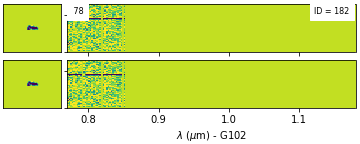

In [46]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

In [37]:
# 1D spectrum with polynomial model
Image(filename='*.1D.png'.format(root, id)) 

FileNotFoundError: [Errno 2] No such file or directory: '*.1D.png'

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 182


(182, 1, 3.29063081741333)

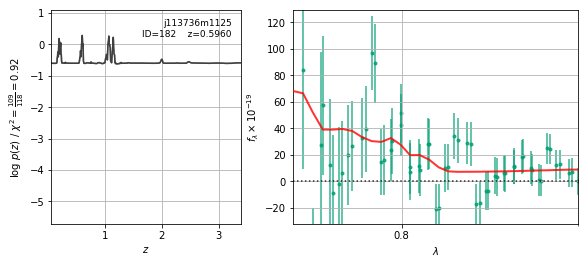

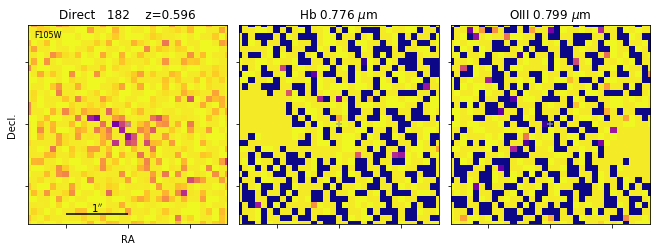

In [48]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [49]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j113736m1125_00182.1D.png
j113736m1125_00182.log_par
j113736m1125_00182.stack.fits
j113736m1125_00182.line.png
j113736m1125_00182.beams.fits
j113736m1125_00182.stack.png
j113736m1125_00182.full.fits
j113736m1125_00182.full.png
j113736m1125_00182.1D.fits


In [50]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j113736m1125_00182.stack.fits


Filename: j113736m1125_00182.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SCI         G102,78.0 ImageHDU        45   (178, 64)   float32   
  2  WHT         G102,78.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,78.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,78.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,78.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        44   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   


j113736m1125_00182.beams.fits


Filename: j113736m1125_00182.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  REF 

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [51]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 148 4
j113736m1125_00148.beams.fits


True

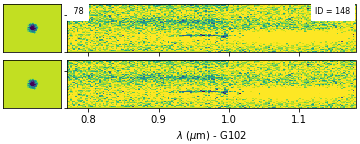

In [52]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

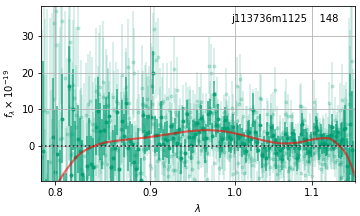

In [53]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 148


(148, 1, 10.86686086654663)

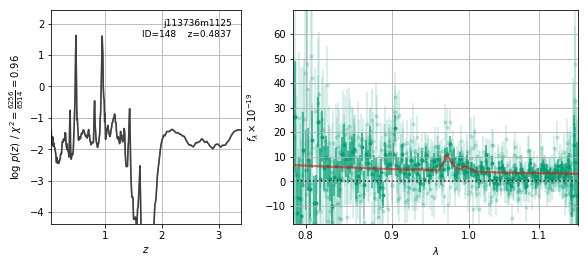

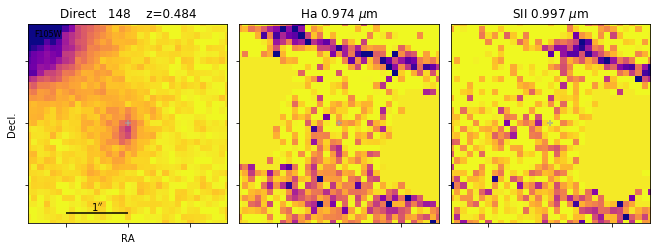

In [54]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).